# Trabajo Fin de Máster
## HateSpeech Detection
### Autor: Óscar Toimil Plaza
#### Tutores: Marcos Fernández Pichel y Mario Ezra Aragón Saenzpardo

-------------------------------------------

## Imports

In [15]:
import pandas as pd
!pip install pysentimiento
from pysentimiento import create_analyzer #
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## Variables globales

In [67]:
DATASETS_NAME = {
    'MISOCORPUS_2020_TRAIN': 'misocorpus2020_train - copia.csv',
    'MISOCORPUS_2020_VAL': 'misocorpus2020_val.csv',
    'MISOCORPUS_2020_TEST': 'misocorpus2020_test.csv',
}

DATASETS_DELIMITERS = {
    'MISOCORPUS_2020': ',',
}
SEED_VALUE = 1

-------------------------------------------

## Lectura datos

-----------------------------------------------

#### MISOCORPUS 2020

In [74]:
df_misocorpus_train = pd.read_csv ( DATASETS_NAME['MISOCORPUS_2020_TRAIN'],
        skiprows=1,
        header=None,
        names = ["tweet", "label"],
        delimiter=DATASETS_DELIMITERS['MISOCORPUS_2020'])

----------------------------

## POS (Parts Of Speech)


-----------------------------------------------

### Todos los tweets

-----------------------------------------------


In [18]:
df_misocorpus_train.head()

tweet  label
0                  @twominbae cállate puta      1
1                    @Josumovic Puta Greta      1
2  @monasterioR @julia_otero Eres patética      1
3             @GretaThunberg Loca del coño      1
4                     @GretaThunberg cerda      1

In [19]:
pos_tagger = create_analyzer("pos", lang="es")

In [20]:
#Ejemplo de la documentacion
pos_tagger.predict("Me llamo Juan Manuel Pérez y vivo en Argentina")

TokenClassificationOutput(tokens=['Me', 'llamo', 'Juan', 'Manuel', 'Pérez', 'y', 'vivo', 'en', 'Argentina'], labels=['PRON', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'CONJ', 'VERB', 'ADP', 'PROPN'])

In [21]:
#detectado un error que tienen en la implementacion de la libreria con algunos emojis como 🤦‍♀️, se eliminaron cuando había alguno de estos conflictivo en una copia del archivo
pos_tagger.predict("El feminismo de Lamas 🤦‍♀️...justificando cultura de violación y acoso, muy desatinado! Lamas representa el white feminism incapaz de ver más allá de sus privilegios. Gracias @catalinapordios por el despliegue de sensatez. https://t.co/sNJYO3oPqG")

AttributeError: 'NoneType' object has no attribute 'startswith'

In [42]:
def analyze_pos_tags(text):
    result = pos_tagger.predict(text.lower())
    pos_tags = list(zip(result.tokens, result.labels))

    print(f"Texto analizado: {text}")
    print(f"Etiquetas encontradas: {pos_tags}")

    pos_tags = [(token, label) for token, label in pos_tags if label is not None]

    if not pos_tags:
        return {}, None, []

    tag_counts = Counter([tag for _, tag in pos_tags])
    total_tags = sum(tag_counts.values())
    pos_type_percentages = {tag: (count / total_tags) * 100 for tag, count in tag_counts.items()}

    most_frequent_tag = max(tag_counts, key=tag_counts.get, default=None)

    return pos_type_percentages, most_frequent_tag, pos_tags

In [75]:
# Analizar POS en los textos
text_data = df_misocorpus_train['tweet'].tolist()
results = [analyze_pos_tags(text) for text in tqdm(text_data)]

  0%|          | 20/5034 [00:00<00:52, 94.67it/s]

Texto analizado: @twominbae cállate puta
Etiquetas encontradas: [('@twominbae', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN')]
Texto analizado: @Josumovic Puta Greta
Etiquetas encontradas: [('@josumovic', 'USER'), ('puta', 'NOUN'), ('greta', 'NOUN')]
Texto analizado: @monasterioR @julia_otero Eres patética
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('eres', 'VERB'), ('patética', 'ADJ')]
Texto analizado: @GretaThunberg Loca del coño
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('loca', 'ADJ'), ('del', 'ADP'), ('coño', 'NOUN')]
Texto analizado: @GretaThunberg cerda
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('cerda', 'NOUN')]
Texto analizado: @outmarina Cállate puta de mierda
Etiquetas encontradas: [('@outmarina', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN')]
Texto analizado: @Valeryth_ Callate puta que te dejo en visto
Etiquetas encontradas: [('@valeryth', 'USER'), ('_', 'PUNCT'), ('callate', 'VERB'),

  1%|          | 30/5034 [00:00<00:56, 89.08it/s]

Texto analizado: @LaFallaras @TeruelExiste_ Allí te puedes emborrachas loca alcohólica
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@teruelexiste', 'USER'), ('_', 'PUNCT'), ('allí', 'ADV'), ('te', 'PRON'), ('puedes', 'VERB'), ('emborrachas', 'VERB'), ('loca', 'ADJ'), ('alcohólica', 'ADJ')]
Texto analizado: Ni porque sea feminazi la hdsptm http://t.co/
Etiquetas encontradas: [('ni', 'CONJ'), ('porque', 'SCONJ'), ('sea', 'VERB'), ('feminazi', 'ADJ'), ('la', 'DET'), ('hdsptm', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: @LaFallaras @publico_es Cerda!!! Enterate!!! Que se lo ha inventado todo la mamarracha esa!! Que no t enteras!! Q no sirves pan nada!! Trozo de carne putrefacta!!!! http://t.co/
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@publico_es', 'USER'), ('cerda', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('enterate', 'VERB'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('que', 'SCONJ'), ('se', 'PRON'), ('lo', 'PRON'), ('ha', 'AUX'), ('inventado', 'VER

  1%|          | 49/5034 [00:00<00:56, 88.09it/s]

Texto analizado: @LaReinaDeNarnia Es que claro, las feminazis no lo hacen con hombres así que eso no se da en la vida real, tortilleras hdp
Etiquetas encontradas: [('@lareinadenarnia', 'USER'), ('es', 'VERB'), ('que', 'SCONJ'), ('claro', 'INTJ'), (',', 'PUNCT'), ('las', 'DET'), ('feminazis', 'NOUN'), ('no', 'ADV'), ('lo', 'PRON'), ('hacen', 'VERB'), ('con', 'ADP'), ('hombres', 'NOUN'), ('así', 'ADV'), ('que', 'SCONJ'), ('eso', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('da', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('vida', 'NOUN'), ('real', 'ADJ'), (',', 'PUNCT'), ('tortilleras', 'NOUN'), ('hdp', 'NOUN')]
Texto analizado: Mostritas #Feminazi amenazando como ellas saben. http://t.co/
Etiquetas encontradas: [('mostritas', 'NOUN'), ('hashtag', 'ADP'), ('feminazi', 'NOUN'), ('amenazando', 'VERB'), ('como', 'SCONJ'), ('ellas', 'PRON'), ('saben', 'VERB'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @alexandrahorler Sigue ahí, tienes condiciones. Vas a salir más empoderada que todas las 

  1%|▏         | 69/5034 [00:00<00:54, 91.00it/s]

Texto analizado: HORROOOOOOR está casi calato con su gorro de policía y su diploma tapando su órgano genital. Ayyy y sus tetillas, quémenlo como a las feminazis que se quitan el brasier para protestar. #Sarcasm Pd. Doble moral everywhere http://t.co/
Etiquetas encontradas: [('horrooor', 'ADJ'), ('está', 'VERB'), ('casi', 'ADV'), ('calato', 'ADJ'), ('con', 'ADP'), ('su', 'DET'), ('gorro', 'NOUN'), ('de', 'ADP'), ('policía', 'NOUN'), ('y', 'CONJ'), ('su', 'DET'), ('diploma', 'NOUN'), ('tapando', 'VERB'), ('su', 'DET'), ('órgano', 'NOUN'), ('genital', 'ADJ'), ('.', 'PUNCT'), ('ayyy', 'INTJ'), ('y', 'CONJ'), ('sus', 'DET'), ('tetillas', 'NOUN'), (',', 'PUNCT'), ('quémenlo', 'VERB'), ('como', 'SCONJ'), ('a', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('que', 'SCONJ'), ('se', 'PRON'), ('quitan', 'VERB'), ('el', 'DET'), ('brasier', 'NOUN'), ('para', 'ADP'), ('protestar', 'VERB'), ('.', 'PUNCT'), ('hashtag', 'INTJ'), ('sarcasm', 'NOUN'), ('pd', 'INTJ'), ('.', 'PUNCT'), ('doble', 'ADJ'), ('

  2%|▏         | 89/5034 [00:00<00:53, 91.77it/s]

Texto analizado: @arquitecta Felicidades! Te salió la carta feminazi! Con cada acto que realices en el próximo año, estarás ayudando a la caída del patriarcado.
Etiquetas encontradas: [('@arquitecta', 'USER'), ('felicidades', 'INTJ'), ('!', 'PUNCT'), ('te', 'PRON'), ('salió', 'VERB'), ('la', 'DET'), ('carta', 'NOUN'), ('feminazi', 'NOUN'), ('!', 'PUNCT'), ('con', 'ADP'), ('cada', 'DET'), ('acto', 'NOUN'), ('que', 'PRON'), ('realices', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('próximo', 'ADJ'), ('año', 'NOUN'), (',', 'PUNCT'), ('estarás', 'AUX'), ('ayudando', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('caída', 'NOUN'), ('del', 'ADP'), ('patriarcado', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @romancendoya Las feministas(Feminazis) estan manejadas por las ONG de izquierda para desestabilizar la sociedas, nunca van alzar su voz por alguien de derecha o centro. Miren el caso Tavara. Asi que a Keiko peor. Para ellas Keiko es hombre, macho, varón por que solo la atacan. #izquierdanunca
Etiquetas 

  2%|▏         | 109/5034 [00:01<00:53, 91.93it/s]

Texto analizado: @Soulshinebb callate puta tragaleche
Etiquetas encontradas: [('@soulshinebb', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('tragaleche', 'VERB')]
Texto analizado: @al99ba18 Cuidado Alba, que pueden ser violadas por los gallos y como se enteren las feminazis, te la lian parda...jajajaja
Etiquetas encontradas: [('@al99ba18', 'USER'), ('cuidado', 'INTJ'), ('alba', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('pueden', 'AUX'), ('ser', 'VERB'), ('violadas', 'VERB'), ('por', 'ADP'), ('los', 'DET'), ('gallos', 'NOUN'), ('y', 'CONJ'), ('como', 'SCONJ'), ('se', 'PRON'), ('enteren', 'VERB'), ('las', 'DET'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('te', 'PRON'), ('la', 'PRON'), ('lian', 'VERB'), ('parda', 'ADV'), ('...', 'PUNCT'), ('jaja', 'INTJ')]
Texto analizado: Cállate puta y chúpame el orto marico
Etiquetas encontradas: [('cállate', 'VERB'), ('puta', 'NOUN'), ('y', 'CONJ'), ('chúpame', 'VERB'), ('el', 'DET'), ('orto', 'NOUN'), ('marico', 'NOUN')]
Texto analizado: @PATRICI

  3%|▎         | 129/5034 [00:01<00:53, 91.45it/s]

Texto analizado: Mientras las feminazis juzgan Twitter hace su magia http://t.co/
Etiquetas encontradas: [('mientras', 'SCONJ'), ('las', 'DET'), ('feminazis', 'NOUN'), ('juzgan', 'VERB'), ('twitter', 'PROPN'), ('hace', 'VERB'), ('su', 'DET'), ('magia', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: @Vynylplayer LAS FEMINAZIS MANDAN A DECIR QUE LA AGRESORA ESTABA POSEÍDA POR UN MACHO.....???
Etiquetas encontradas: [('@vynylplayer', 'USER'), ('las', 'DET'), ('feminazis', 'NOUN'), ('mandan', 'VERB'), ('a', 'ADP'), ('decir', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('agresora', 'NOUN'), ('estaba', 'VERB'), ('poseída', 'VERB'), ('por', 'ADP'), ('un', 'DET'), ('macho', 'NOUN'), ('...', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: como te vas a comprar la remera de ansiedad de cazzu jajsak todos los problemitas boee re hater lavirgacha callate puta solo pensas en coger
Etiquetas encontradas: [('como', 'ADV'), ('te', 'PRON'), ('vas', 'AUX'), ('a', 'ADP'), ('comprar'

  3%|▎         | 149/5034 [00:01<00:54, 90.40it/s]

Texto analizado: @shababaty Y xq no van alla las feminazis a cantar y bailar en pelotas?? Ahhh es q son feminazis pero no cojudos alla las revientan
Etiquetas encontradas: [('@shababaty', 'USER'), ('y', 'CONJ'), ('xq', 'ADV'), ('no', 'ADV'), ('van', 'VERB'), ('alla', 'ADV'), ('las', 'DET'), ('feminazis', 'NOUN'), ('a', 'ADP'), ('cantar', 'VERB'), ('y', 'CONJ'), ('bailar', 'VERB'), ('en', 'ADP'), ('pelotas', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('ahhh', 'INTJ'), ('es', 'VERB'), ('q', 'SCONJ'), ('son', 'VERB'), ('feminazis', 'NOUN'), ('pero', 'CONJ'), ('no', 'INTJ'), ('cojudos', 'ADJ'), ('alla', 'ADV'), ('las', 'PRON'), ('revientan', 'VERB')]
Texto analizado: Le arruinaron las vacaciones, malditas feminazis! Otra víctima más :’( se me estruja el calzoncillo http://t.co/
Etiquetas encontradas: [('le', 'PRON'), ('arruinaron', 'VERB'), ('las', 'DET'), ('vacaciones', 'NOUN'), (',', 'PUNCT'), ('malditas', 'ADJ'), ('feminazis', 'NOUN'), ('!', 'PUNCT'), ('otra', 'DET'), ('víctima', 'NOUN'),

  3%|▎         | 169/5034 [00:01<00:56, 86.28it/s]

Texto analizado: Bonito expresar una opinión sin ser ofendido por ¡#twitter, #Feminazis, #politicos, #23Dic, #twitternoesreddeodio ! Triste leer comentarios sobre twits que no gustan y acosar al que expreso su idea, muy triste. Seamos mas gente y menos ofensivos ?. Comprensión por favor ?
Etiquetas encontradas: [('bonito', 'ADJ'), ('expresar', 'VERB'), ('una', 'DET'), ('opinión', 'NOUN'), ('sin', 'ADP'), ('ser', 'VERB'), ('ofendido', 'ADJ'), ('por', 'ADP'), ('¡', 'PUNCT'), ('hashtag', 'ADP'), ('twitter', 'NOUN'), (',', 'PUNCT'), ('hashtag', 'NOUN'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('hashtag', 'ADP'), ('politicos', 'NOUN'), (',', 'PUNCT'), ('hashtag', 'NOUN'), ('23dic', 'PROPN'), (',', 'PUNCT'), ('hashtag', 'INTJ'), ('twitternoesreddeodio', 'NOUN'), ('!', 'PUNCT'), ('triste', 'ADJ'), ('leer', 'VERB'), ('comentarios', 'NOUN'), ('sobre', 'ADP'), ('twits', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('gustan', 'VERB'), ('y', 'CONJ'), ('acosar', 'VERB'), ('al', 'ADP'), ('que', 'PRON'), 

  4%|▍         | 189/5034 [00:02<00:53, 90.41it/s]

Texto analizado: las feminazis cada día están más locas. http://t.co/
Etiquetas encontradas: [('las', 'DET'), ('feminazis', 'NOUN'), ('cada', 'DET'), ('día', 'NOUN'), ('están', 'VERB'), ('más', 'ADV'), ('locas', 'ADJ'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: Los #hombres estamos sufriendo una caza de brujas #arandina #discriminaciondegenero #casoarandina http://t.co/
Etiquetas encontradas: [('los', 'DET'), ('hashtag', 'NOUN'), ('hombres', 'NOUN'), ('estamos', 'AUX'), ('sufriendo', 'VERB'), ('una', 'DET'), ('caza', 'NOUN'), ('de', 'ADP'), ('brujas', 'NOUN'), ('hashtag', 'NOUN'), ('arandina', 'NOUN'), ('hashtag', 'NOUN'), ('discriminaciondegenero', 'NOUN'), ('hashtag', 'NOUN'), ('casoarandina', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Una féminazi ver a ver esto y se le va a salir un ojo ?? http://t.co/
Etiquetas encontradas: [('una', 'DET'), ('féminazi', 'NOUN'), ('ver', 'VERB'), ('a', 'ADP'), ('ver', 'VERB'), ('esto', 'PRON'), ('y', 'CONJ'), ('se', 'PRON'), ('le', 'PRON'

  4%|▍         | 209/5034 [00:02<00:52, 92.02it/s]

Texto analizado: @OfeFernandez_ Me podes explicar por favor que hiciste de tu vida? por que sos diputada? terminaste el colegio? hablas de macri como si fueses a entender la historia argentina, pero tenes 18 añitos pendejita, sos populista, feminazi, abortera. Pobre la gente que te banca, no entienden nada.
Etiquetas encontradas: [('@ofefernandez', 'USER'), ('_', 'PUNCT'), ('me', 'PRON'), ('podes', 'AUX'), ('explicar', 'VERB'), ('por', 'ADP'), ('favor', 'NOUN'), ('que', 'PRON'), ('hiciste', 'VERB'), ('de', 'ADP'), ('tu', 'DET'), ('vida', 'NOUN'), ('?', 'PUNCT'), ('por', 'ADP'), ('que', 'SCONJ'), ('sos', 'VERB'), ('diputada', 'NOUN'), ('?', 'PUNCT'), ('terminaste', 'VERB'), ('el', 'DET'), ('colegio', 'NOUN'), ('?', 'PUNCT'), ('hablas', 'VERB'), ('de', 'ADP'), ('macri', 'NOUN'), ('como', 'SCONJ'), ('si', 'SCONJ'), ('fueses', 'AUX'), ('a', 'ADP'), ('entender', 'VERB'), ('la', 'DET'), ('historia', 'NOUN'), ('argentina', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('tenes', 'VERB'), ('18', '

  4%|▍         | 219/5034 [00:02<00:52, 91.65it/s]

Texto analizado: @LaFallaras @CristinaSegui_ @alfonso_ussia @bertrandmyd @publico_es La pregunta es ¿Por qué os fastidia tanto que se difundan los audios? ¿No será porque desmonta todo vuestro chiringuito feminazi de creer a la mujer porque sí aunque mienta y condenar a inocentes?
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@cristinasegui', 'USER'), ('_', 'PUNCT'), ('@alfonso_ussia', 'USER'), ('@bertrandmyd', 'USER'), ('@publico_es', 'USER'), ('la', 'DET'), ('pregunta', 'NOUN'), ('es', 'VERB'), ('¿', 'PUNCT'), ('por', 'ADP'), ('qué', 'PRON'), ('os', 'PRON'), ('fastidia', 'VERB'), ('tanto', 'ADV'), ('que', 'SCONJ'), ('se', 'PRON'), ('difundan', 'VERB'), ('los', 'DET'), ('audios', 'NOUN'), ('?', 'PUNCT'), ('¿', 'PUNCT'), ('no', 'ADV'), ('será', 'VERB'), ('porque', 'SCONJ'), ('desmonta', 'VERB'), ('todo', 'DET'), ('vuestro', 'DET'), ('chiringuito', 'NOUN'), ('feminazi', 'NOUN'), ('de', 'ADP'), ('creer', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('porque', 'SCONJ'), (

  5%|▍         | 239/5034 [00:02<00:53, 89.05it/s]

Texto analizado: Jajajajajajaja ya no son feminazis ahora son femitrolas http://t.co/
Etiquetas encontradas: [('jaja', 'INTJ'), ('ya', 'ADV'), ('no', 'ADV'), ('son', 'VERB'), ('feminazis', 'NOUN'), ('ahora', 'ADV'), ('son', 'VERB'), ('femitrolas', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: @liatrueba La comunidad LBGT...... tiene dentro de sus filas a mucha gente que le hace daño en su lucha, porque mezclan cosas, lo mismo ocurre con las feminazis que para ellas todos somos violadores, machistas y retrógrados.
Etiquetas encontradas: [('@liatrueba', 'USER'), ('la', 'DET'), ('comunidad', 'NOUN'), ('lbgt', 'ADJ'), ('...', 'PUNCT'), ('tiene', 'VERB'), ('dentro', 'ADV'), ('de', 'ADP'), ('sus', 'DET'), ('filas', 'NOUN'), ('a', 'ADP'), ('mucha', 'DET'), ('gente', 'NOUN'), ('que', 'PRON'), ('le', 'PRON'), ('hace', 'VERB'), ('daño', 'NOUN'), ('en', 'ADP'), ('su', 'DET'), ('lucha', 'NOUN'), (',', 'PUNCT'), ('porque', 'SCONJ'), ('mezclan', 'VERB'), ('cosas', 'NOUN'), (',', 'PUNCT'), ('lo', 'DET'

  5%|▌         | 258/5034 [00:02<00:52, 90.48it/s]

Texto analizado: @plaqueta @casamoradaEC @mariafernandamp Pendejadas de feminazis ridiculas
Etiquetas encontradas: [('@plaqueta', 'USER'), ('@casamoradaec', 'USER'), ('@mariafernandamp', 'USER'), ('pendejadas', 'NOUN'), ('de', 'ADP'), ('feminazis', 'NOUN'), ('ridiculas', 'ADJ')]
Texto analizado: Acabo de pasar por una marcha feminazi y creo que el Rosario del pecho me vibraba como el medallón del brujo cuando tiene mounstros cerca
Etiquetas encontradas: [('acabo', 'AUX'), ('de', 'ADP'), ('pasar', 'VERB'), ('por', 'ADP'), ('una', 'DET'), ('marcha', 'NOUN'), ('feminazi', 'ADJ'), ('y', 'CONJ'), ('creo', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('rosario', 'NOUN'), ('del', 'ADP'), ('pecho', 'NOUN'), ('me', 'PRON'), ('vibraba', 'VERB'), ('como', 'SCONJ'), ('el', 'DET'), ('medallón', 'NOUN'), ('del', 'ADP'), ('brujo', 'NOUN'), ('cuando', 'SCONJ'), ('tiene', 'VERB'), ('mounstros', 'NOUN'), ('cerca', 'ADV')]
Texto analizado: @AdaColau Querría veros igual de rápido multando Okupas, payasa.
Eti

  6%|▌         | 278/5034 [00:03<00:52, 91.36it/s]

Texto analizado: @mariapaularomo @PoliciaEcuador @caathytorres @MinGobiernoEc @ComunicacionEc ¿Y cuántos indígenas d los que violaron a mujeres miembros de la @PoliciaEcuador están presos? Hasta donde sabemos, ninguno, así que no se venga a hacer la heroína, usted es una feminazi más.
Etiquetas encontradas: [('@mariapaularomo', 'USER'), ('@policiaecuador', 'USER'), ('@caathytorres', 'USER'), ('@mingobiernoec', 'USER'), ('@comunicacionec', 'USER'), ('¿', 'PUNCT'), ('y', 'CONJ'), ('cuántos', 'DET'), ('indígenas', 'NOUN'), ('d', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('violaron', 'VERB'), ('a', 'ADP'), ('mujeres', 'NOUN'), ('miembros', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('@policiaecuador', 'USER'), ('están', 'VERB'), ('presos', 'VERB'), ('?', 'PUNCT'), ('hasta', 'ADP'), ('donde', 'ADV'), ('sabemos', 'VERB'), (',', 'PUNCT'), ('ninguno', 'PRON'), (',', 'PUNCT'), ('así', 'ADV'), ('que', 'SCONJ'), ('no', 'ADV'), ('se', 'PRON'), ('venga', 'VERB'), ('a', 'ADP'), ('hacer', 'VERB'), ('la', 

  6%|▌         | 298/5034 [00:03<00:50, 93.36it/s]

Texto analizado: Esto lo ha visto histérica Greta???? Lo sabe el felón??? Y el miserable e hipócrita Bardem? Y....R. Gere???? Uffff qué disgusto se van a llevar cuándo se enteren...????? http://t.co/
Etiquetas encontradas: [('esto', 'PRON'), ('lo', 'PRON'), ('ha', 'AUX'), ('visto', 'VERB'), ('histérica', 'ADJ'), ('greta', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('lo', 'PRON'), ('sabe', 'VERB'), ('el', 'DET'), ('felón', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('y', 'CONJ'), ('el', 'DET'), ('miserable', 'ADJ'), ('e', 'CONJ'), ('hipócrita', 'ADJ'), ('bardem', 'NOUN'), ('?', 'PUNCT'), ('y', 'CONJ'), ('...', 'PUNCT'), ('r.', 'INTJ'), ('gere', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('ufff', 'INTJ'), ('qué', 'DET'), ('disgusto', 'NOUN'), ('se', 'PRON'), ('van', 'AUX'), ('a', 'ADP'), ('llevar', 'VERB'), ('cuándo', 'ADV'), ('se', 'PRON'), ('enteren', 'VERB'), ('...', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('url/', 'INTJ')]
T

  6%|▋         | 318/5034 [00:03<00:53, 88.75it/s]

Texto analizado: @Kassand77168408 @ilyvllgs @Mfmorenobel Miente, puro razonamiento de idiotas, existe claramente desde que se empieza a formar, es algo que se nota claramente #Feminazi
Etiquetas encontradas: [('@kassand77168408', 'USER'), ('@ilyvllgs', 'USER'), ('@mfmorenobel', 'USER'), ('miente', 'VERB'), (',', 'PUNCT'), ('puro', 'ADJ'), ('razonamiento', 'NOUN'), ('de', 'ADP'), ('idiotas', 'NOUN'), (',', 'PUNCT'), ('existe', 'VERB'), ('claramente', 'ADV'), ('desde', 'ADP'), ('que', 'SCONJ'), ('se', 'PRON'), ('empieza', 'AUX'), ('a', 'ADP'), ('formar', 'VERB'), (',', 'PUNCT'), ('es', 'VERB'), ('algo', 'PRON'), ('que', 'SCONJ'), ('se', 'PRON'), ('nota', 'VERB'), ('claramente', 'ADV'), ('hashtag', 'PROPN'), ('feminazi', 'NOUN')]
Texto analizado: @LaFallaras Loca, ladrona, putta, feminista, de izquierdas, toxicómana, hater, anlfabeta... verdaderamente encarna todos los valores de la izquierda como quizás solo los encarnó La Pasionaria.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('lo

  7%|▋         | 338/5034 [00:03<00:52, 90.18it/s]

Texto analizado: @24h_tve @GretaThunberg A la tonta histérica ????? ??
Etiquetas encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER'), ('a', 'ADP'), ('la', 'DET'), ('tonta', 'ADJ'), ('histérica', 'ADJ'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @elhigadodmarita Basta ver su simbolito verde y morado para saber que es una core feminazi. WTF
Etiquetas encontradas: [('@elhigadodmarita', 'USER'), ('basta', 'VERB'), ('ver', 'VERB'), ('su', 'DET'), ('simbolito', 'NOUN'), ('verde', 'ADJ'), ('y', 'CONJ'), ('morado', 'ADJ'), ('para', 'ADP'), ('saber', 'VERB'), ('que', 'SCONJ'), ('es', 'VERB'), ('una', 'DET'), ('core', 'NOUN'), ('feminazi', 'NOUN'), ('.', 'PUNCT'), ('wtf', 'INTJ')]
Texto analizado: Le cogi fastidio a las feminazis, sorryyy
Etiquetas encontradas: [('le', 'PRON'), ('cogi', 'VERB'), ('fastidio', 'NOUN'), ('a', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('sorryyy', 'ADJ')]
Texto analizado: @feminist

  7%|▋         | 348/5034 [00:03<00:51, 90.20it/s]

Texto analizado: @LaFallaras A parte de ser más mala que el cianuro y tener un corazón podrido por el resentimiento de que no te quieran ni en tu casa, estás más loca que una puta cabra
Etiquetas encontradas: [('@lafallaras', 'USER'), ('a', 'ADP'), ('parte', 'NOUN'), ('de', 'ADP'), ('ser', 'VERB'), ('más', 'ADV'), ('mala', 'ADJ'), ('que', 'SCONJ'), ('el', 'DET'), ('cianuro', 'NOUN'), ('y', 'CONJ'), ('tener', 'VERB'), ('un', 'DET'), ('corazón', 'NOUN'), ('podrido', 'ADJ'), ('por', 'ADP'), ('el', 'DET'), ('resentimiento', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('no', 'ADV'), ('te', 'PRON'), ('quieran', 'VERB'), ('ni', 'ADV'), ('en', 'ADP'), ('tu', 'DET'), ('casa', 'NOUN'), (',', 'PUNCT'), ('estás', 'VERB'), ('más', 'ADV'), ('loca', 'ADJ'), ('que', 'SCONJ'), ('una', 'DET'), ('puta', 'ADJ'), ('cabra', 'NOUN')]
Texto analizado: Esto no vende. La dictadura #feminazi si. #stopfeminazis http://t.co/
Etiquetas encontradas: [('esto', 'PRON'), ('no', 'INTJ'), ('vende', 'VERB'), ('.', 'PUNCT'),

  7%|▋         | 367/5034 [00:04<01:02, 74.69it/s]

Texto analizado: @silvitabuendia Defender a mujeres de actos violentos, educar a la sociedad el respeto, no es motivo q les digan feminazis, pero cuando quieren abortar sin ser víctimas de una violación, sino por haber sido descuidados al haber tenido un acto sexual concentido... es correcto decirles feminazis
Etiquetas encontradas: [('@silvitabuendia', 'USER'), ('defender', 'VERB'), ('a', 'ADP'), ('mujeres', 'NOUN'), ('de', 'ADP'), ('actos', 'NOUN'), ('violentos', 'ADJ'), (',', 'PUNCT'), ('educar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('sociedad', 'NOUN'), ('el', 'DET'), ('respeto', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('es', 'VERB'), ('motivo', 'NOUN'), ('q', 'SCONJ'), ('les', 'PRON'), ('digan', 'VERB'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('cuando', 'SCONJ'), ('quieren', 'VERB'), ('abortar', 'VERB'), ('sin', 'ADP'), ('ser', 'VERB'), ('víctimas', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('violación', 'NOUN'), (',', 'PUNCT'), ('sino', 'CONJ'), ('por', 'ADP'), (

  8%|▊         | 383/5034 [00:04<01:06, 69.86it/s]

Texto analizado: Ja ja ja eso que hicieron los manifestantes zapatistas a los de lgbt ,es un claro ejemplo de que si a alguna loca feminazi se le ocurre pasarse de verga con alguna imagen o representación,ya sabe a que le tira......
Etiquetas encontradas: [('ja', 'INTJ'), ('ja', 'INTJ'), ('ja', 'INTJ'), ('eso', 'PRON'), ('que', 'PRON'), ('hicieron', 'VERB'), ('los', 'DET'), ('manifestantes', 'NOUN'), ('zapatistas', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('de', 'ADP'), ('lgbt', 'NOUN'), (',', 'PUNCT'), ('es', 'VERB'), ('un', 'DET'), ('claro', 'ADJ'), ('ejemplo', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('a', 'ADP'), ('alguna', 'DET'), ('loca', 'ADJ'), ('feminazi', 'NOUN'), ('se', 'PRON'), ('le', 'PRON'), ('ocurre', 'VERB'), ('pasarse', 'VERB'), ('de', 'ADP'), ('verga', 'NOUN'), ('con', 'ADP'), ('alguna', 'DET'), ('imagen', 'NOUN'), ('o', 'CONJ'), ('representación', 'NOUN'), (',', 'PUNCT'), ('ya', 'ADV'), ('sabe', 'VERB'), ('a', 'ADP'), ('que', 'SCONJ'), ('le', 'PRON'),

  8%|▊         | 391/5034 [00:04<01:08, 67.81it/s]

Texto analizado: Woo..woo..Woo.? Detenme ese TREN #FEMINAZI de PREJUICIOS PENDEJOS q NO ayudan en NADA, sólo a hacer esta sociedad más en VERGA y de MIERDA?.Soy una MUJER de 36 años q se rasura porque me da la PUTA GANA, porque QUIERO,porque eso me da picazón tener los vellos muy largos PUNTO? http://t.co/
Etiquetas encontradas: [('woo', 'INTJ'), ('..', 'PUNCT'), ('woo', 'INTJ'), ('..', 'PUNCT'), ('woo', 'INTJ'), ('.', 'PUNCT'), ('?', 'PUNCT'), ('detenme', 'VERB'), ('ese', 'DET'), ('tren', 'NOUN'), ('hashtag', 'ADJ'), ('feminazi', 'NOUN'), ('de', 'ADP'), ('prejuicios', 'NOUN'), ('pendejos', 'ADJ'), ('q', 'PRON'), ('no', 'ADV'), ('ayudan', 'VERB'), ('en', 'ADP'), ('nada', 'PRON'), (',', 'PUNCT'), ('sólo', 'ADV'), ('a', 'ADP'), ('hacer', 'VERB'), ('esta', 'DET'), ('sociedad', 'NOUN'), ('más', 'ADV'), ('en', 'ADP'), ('verga', 'NOUN'), ('y', 'CONJ'), ('de', 'ADP'), ('mierda?.soy', 'NOUN'), ('una', 'DET'), ('mujer', 'NOUN'), ('de', 'ADP'), ('36', 'ADJ'), ('años', 'NOUN'), ('q', 'SCONJ'), ('

  8%|▊         | 405/5034 [00:04<01:09, 66.97it/s]

Texto analizado: @rfcolmenero77 @marianalongo11 Nuevo caso de violencia feminazi contra inocente hombre.......
Etiquetas encontradas: [('@rfcolmenero77', 'USER'), ('@marianalongo11', 'USER'), ('nuevo', 'ADJ'), ('caso', 'NOUN'), ('de', 'ADP'), ('violencia', 'NOUN'), ('feminazi', 'ADJ'), ('contra', 'ADP'), ('inocente', 'ADJ'), ('hombre', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: Greta cabrona deja alguna chupaíta pal resto que me llevas las pupilas como la capa de ozono. http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('cabrona', 'ADJ'), ('deja', 'VERB'), ('alguna', 'DET'), ('chupaíta', 'NOUN'), ('pa', 'ADP'), ('l', 'DET'), ('resto', 'NOUN'), ('que', 'SCONJ'), ('me', 'PRON'), ('llevas', 'VERB'), ('las', 'DET'), ('pupilas', 'NOUN'), ('como', 'SCONJ'), ('la', 'DET'), ('capa', 'NOUN'), ('de', 'ADP'), ('ozono', 'NOUN'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @LaFallaras Y tu tb te jartas a almejas pero podridas pedazo de cerda.
Etiquetas encontradas: [('@lafallaras', '

  8%|▊         | 420/5034 [00:04<01:08, 67.81it/s]

Texto analizado: @LaFallaras @populares @CiudadanosCs Eres de lo más indeseable que hay en este país. Loca de mierda.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER'), ('eres', 'VERB'), ('de', 'ADP'), ('lo', 'DET'), ('más', 'ADV'), ('indeseable', 'ADJ'), ('que', 'SCONJ'), ('hay', 'VERB'), ('en', 'ADP'), ('este', 'DET'), ('país', 'NOUN'), ('.', 'PUNCT'), ('loca', 'ADJ'), ('de', 'ADP'), ('mierda', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: eso me dijo greta thunberg el otro día esta re desubicada la puta http://t.co/
Etiquetas encontradas: [('eso', 'INTJ'), ('me', 'PRON'), ('dijo', 'VERB'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('el', 'DET'), ('otro', 'DET'), ('día', 'NOUN'), ('esta', 'PRON'), ('re', 'ADV'), ('desubicada', 'ADJ'), ('la', 'DET'), ('puta', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: @elespectador Esta pregunta no es mas que otro atentado Feminazi".
Etiquetas encontradas: [('@elespectador', 'USER'), ('esta', 'DET'), ('preg

  9%|▊         | 435/5034 [00:05<01:05, 69.75it/s]

Texto analizado: @LaFallaras @elnacionalcat @ContadorAltsasu Parece mentira que pertenezcas a la raza humana, eres un trozo de carne putrefacta, un puto cancer. Tranquila! Caeras como todos los demas, CERDA!!! http://t.co/
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@elnacionalcat', 'USER'), ('@contadoraltsasu', 'USER'), ('parece', 'VERB'), ('mentira', 'NOUN'), ('que', 'SCONJ'), ('pertenezcas', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('raza', 'NOUN'), ('humana', 'ADJ'), (',', 'PUNCT'), ('eres', 'VERB'), ('un', 'DET'), ('trozo', 'NOUN'), ('de', 'ADP'), ('carne', 'NOUN'), ('putrefacta', 'ADJ'), (',', 'PUNCT'), ('un', 'DET'), ('puto', 'ADJ'), ('cancer', 'NOUN'), ('.', 'PUNCT'), ('tranquila', 'ADJ'), ('!', 'PUNCT'), ('caeras', 'VERB'), ('como', 'SCONJ'), ('todos', 'DET'), ('los', 'DET'), ('demas', 'PRON'), (',', 'PUNCT'), ('cerda', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('url/', 'PROPN')]
Texto analizado: @Adanyelparaiso @magdent09 Ahora los putitos sales en bola com

  9%|▉         | 449/5034 [00:05<01:07, 67.79it/s]

Texto analizado: @CristinaPaezEc @marzelavila @silvitabuendia @Expresoec El error será usted misma, no el diario, feminazi...
Etiquetas encontradas: [('@cristinapaezec', 'USER'), ('@marzelavila', 'USER'), ('@silvitabuendia', 'USER'), ('@expresoec', 'USER'), ('el', 'DET'), ('error', 'NOUN'), ('será', 'VERB'), ('usted', 'PRON'), ('misma', 'ADJ'), (',', 'PUNCT'), ('no', 'INTJ'), ('el', 'DET'), ('diario', 'NOUN'), (',', 'PUNCT'), ('feminazi', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @LaFallaras @miquinta1 Te han pillado, puta loca. Vete a darte cabezazos contra la pared
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@miquinta1', 'USER'), ('te', 'PRON'), ('han', 'AUX'), ('pillado', 'VERB'), (',', 'PUNCT'), ('puta', 'NOUN'), ('loca', 'ADJ'), ('.', 'PUNCT'), ('vete', 'VERB'), ('a', 'ADP'), ('darte', 'VERB'), ('cabezazos', 'NOUN'), ('contra', 'ADP'), ('la', 'DET'), ('pared', 'NOUN')]
Texto analizado: @LaFallaras Jajaja Patética la #lobba gintonic. Otro chupito,
Etiquetas encontradas: [(

  9%|▉         | 463/5034 [00:05<01:11, 63.85it/s]

Texto analizado: Ejemplo patéticos de feminazis
Etiquetas encontradas: [('ejemplo', 'NOUN'), ('patéticos', 'ADJ'), ('de', 'ADP'), ('feminazis', 'NOUN')]
Texto analizado: @LaFallaras ¿#LOBBA? ¿No será #ZORRA?
Etiquetas encontradas: [('@lafallaras', 'USER'), ('¿', 'PUNCT'), ('hashtag', 'NOUN'), ('lobba', 'NOUN'), ('?', 'PUNCT'), ('¿', 'PUNCT'), ('no', 'INTJ'), ('será', 'VERB'), ('hashtag', 'ADV'), ('zorra', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @LaFallaras No habrá querido decir zorra?
Etiquetas encontradas: [('@lafallaras', 'USER'), ('no', 'ADV'), ('habrá', 'AUX'), ('querido', 'VERB'), ('decir', 'VERB'), ('zorra', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @LaFallaras Ando un poco perdido. Cuando te refieres a la adolescente violada te refieres a la golfa esa de la que hablan en las redes?
Etiquetas encontradas: [('@lafallaras', 'USER'), ('ando', 'VERB'), ('un', 'DET'), ('poco', 'ADV'), ('perdido', 'ADJ'), ('.', 'PUNCT'), ('cuando', 'SCONJ'), ('te', 'PRON'), ('refieres', 'VERB'), ('a

  9%|▉         | 476/5034 [00:05<01:19, 57.63it/s]

Texto analizado: @paulita_pro Si Y es terrible lo QUE pasa Aqui EN Venezuela, ESAS FEMINAZIS SON TERRORISTAS NO SON FEMINISTAS
Etiquetas encontradas: [('@paulita_pro', 'USER'), ('si', 'INTJ'), ('y', 'CONJ'), ('es', 'VERB'), ('terrible', 'ADJ'), ('lo', 'PRON'), ('que', 'PRON'), ('pasa', 'VERB'), ('aqui', 'ADV'), ('en', 'ADP'), ('venezuela', 'NOUN'), (',', 'PUNCT'), ('esas', 'DET'), ('feminazis', 'NOUN'), ('son', 'VERB'), ('terroristas', 'NOUN'), ('no', 'ADV'), ('son', 'VERB'), ('feministas', 'NOUN')]
Texto analizado: Esa feminazi si en realidad supiera lo q es un morbo q t digan n la calle capaz y arma la guerra mundial ?
Etiquetas encontradas: [('esa', 'DET'), ('feminazi', 'NOUN'), ('si', 'SCONJ'), ('en', 'ADP'), ('realidad', 'NOUN'), ('supiera', 'VERB'), ('lo', 'PRON'), ('q', 'PRON'), ('es', 'VERB'), ('un', 'DET'), ('morbo', 'NOUN'), ('q', 'PRON'), ('t', 'PRON'), ('digan', 'VERB'), ('n', 'ADP'), ('la', 'DET'), ('calle', 'NOUN'), ('capaz', 'ADJ'), ('y', 'CONJ'), ('arma', 'VERB'), ('la'

 10%|▉         | 488/5034 [00:06<01:20, 56.44it/s]

Texto analizado: @NuevaTec47 @rafaelhenrikez @VPrimero No hay que ser tan estricta. Al hombre se le asocia con la fuerza y a la mujer con la disuacion y me gustan esos roles aunque a veces yo misma me he catalogado de hombre por mi caracter. Tu comentario es el de una feminazi.
Etiquetas encontradas: [('@nuevatec47', 'USER'), ('@rafaelhenrikez', 'USER'), ('@vprimero', 'USER'), ('no', 'ADV'), ('hay', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('tan', 'ADV'), ('estricta', 'ADJ'), ('.', 'PUNCT'), ('al', 'ADP'), ('hombre', 'NOUN'), ('se', 'PRON'), ('le', 'PRON'), ('asocia', 'VERB'), ('con', 'ADP'), ('la', 'DET'), ('fuerza', 'NOUN'), ('y', 'CONJ'), ('a', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('con', 'ADP'), ('la', 'DET'), ('disuacion', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('gustan', 'VERB'), ('esos', 'DET'), ('roles', 'NOUN'), ('aunque', 'SCONJ'), ('a', 'ADP'), ('veces', 'NOUN'), ('yo', 'PRON'), ('misma', 'ADJ'), ('me', 'PRON'), ('he', 'AUX'), ('catalogado', 'VERB'), ('de', 'ADP'), (

 10%|█         | 507/5034 [00:06<01:02, 72.81it/s]

Texto analizado: Aplaudo las luchas historicas de igualdad de genero por parte de mujeres heroicas, pero lo que no se debe aplaudir hoy dia es ese feminismo radical (feminazi) que esta contribuyendo al deterioro social ( la familia ). Y el estado es complice.
Etiquetas encontradas: [('aplaudo', 'VERB'), ('las', 'DET'), ('luchas', 'NOUN'), ('historicas', 'ADJ'), ('de', 'ADP'), ('igualdad', 'NOUN'), ('de', 'ADP'), ('genero', 'NOUN'), ('por', 'ADP'), ('parte', 'NOUN'), ('de', 'ADP'), ('mujeres', 'NOUN'), ('heroicas', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('lo', 'PRON'), ('que', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('debe', 'AUX'), ('aplaudir', 'VERB'), ('hoy', 'DET'), ('dia', 'NOUN'), ('es', 'VERB'), ('ese', 'DET'), ('feminismo', 'NOUN'), ('radical', 'ADJ'), ('(', 'PUNCT'), ('feminazi', 'NOUN'), (')', 'PUNCT'), ('que', 'PRON'), ('esta', 'AUX'), ('contribuyendo', 'VERB'), ('al', 'ADP'), ('deterioro', 'NOUN'), ('social', 'ADJ'), ('(', 'PUNCT'), ('la', 'DET'), ('familia', 'NOUN'), (')

 10%|█         | 526/5034 [00:06<00:55, 80.91it/s]

Texto analizado: Que tal si las Feminazis de enlistan en el ejército. No les parece muy machista eso de enviar solo hombres a la guerra?
Etiquetas encontradas: [('que', 'SCONJ'), ('tal', 'ADJ'), ('si', 'SCONJ'), ('las', 'DET'), ('feminazis', 'NOUN'), ('de', 'PRON'), ('enlistan', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('ejército', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('les', 'PRON'), ('parece', 'VERB'), ('muy', 'ADV'), ('machista', 'ADJ'), ('eso', 'PRON'), ('de', 'ADP'), ('enviar', 'VERB'), ('solo', 'ADV'), ('hombres', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('guerra', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: Uno de los requisitos para ser feminazi es ser feisisimaaaa jajaja
Etiquetas encontradas: [('uno', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('requisitos', 'NOUN'), ('para', 'ADP'), ('ser', 'VERB'), ('feminazi', 'NOUN'), ('es', 'VERB'), ('ser', 'VERB'), ('feisisimaaa', 'ADJ'), ('jaja', 'INTJ')]
Texto analizado: @meiermq Sus tetas cambiaron el mundo jajaja es una feminazi pero discr

 11%|█         | 535/5034 [00:06<00:58, 77.12it/s]

Texto analizado: Una cosa es ayudar a víctimas reales de violencia y otra ser feminazi o loca #Quedoclaro?
Etiquetas encontradas: [('una', 'DET'), ('cosa', 'NOUN'), ('es', 'VERB'), ('ayudar', 'VERB'), ('a', 'ADP'), ('víctimas', 'NOUN'), ('reales', 'ADJ'), ('de', 'ADP'), ('violencia', 'NOUN'), ('y', 'CONJ'), ('otra', 'DET'), ('ser', 'NOUN'), ('feminazi', 'NOUN'), ('o', 'CONJ'), ('loca', 'ADJ'), ('hashtag', 'PUNCT'), ('quedoclaro', 'ADV'), ('?', 'PUNCT')]
Texto analizado: @HaroldA60148527 @InstitutoCato Estoy tomando que en los países donde hay mayor nivel de feminazis y comunistas son justamente en países donde el índice de analfabetismo se dan por distintas fallas, tanto estatales como geográficas, que impiden a un estudiante educarse debidamente.
Etiquetas encontradas: [('@harolda60148527', 'USER'), ('@institutocato', 'USER'), ('estoy', 'AUX'), ('tomando', 'VERB'), ('que', 'SCONJ'), ('en', 'ADP'), ('los', 'DET'), ('países', 'NOUN'), ('donde', 'ADV'), ('hay', 'VERB'), ('mayor', 'ADJ'),

 11%|█         | 553/5034 [00:06<00:55, 81.28it/s]

Texto analizado: ¿Os imagináis a un miembro de La Manada dando una conferencia en una universidad sobre cualquier tema relacionado con la mujer? Pensar el revuelo que eso causaría, sobretodo en el entorno feminazi. Pues eso está pasando en la UPV con la connivencia del gobierno y justicia
Etiquetas encontradas: [('¿', 'PUNCT'), ('os', 'PRON'), ('imagináis', 'VERB'), ('a', 'ADP'), ('un', 'DET'), ('miembro', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('manada', 'NOUN'), ('dando', 'VERB'), ('una', 'DET'), ('conferencia', 'NOUN'), ('en', 'ADP'), ('una', 'DET'), ('universidad', 'NOUN'), ('sobre', 'ADP'), ('cualquier', 'DET'), ('tema', 'NOUN'), ('relacionado', 'VERB'), ('con', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('?', 'PUNCT'), ('pensar', 'VERB'), ('el', 'DET'), ('revuelo', 'NOUN'), ('que', 'PRON'), ('eso', 'PRON'), ('causaría', 'VERB'), (',', 'PUNCT'), ('sobretodo', 'ADV'), ('en', 'ADP'), ('el', 'DET'), ('entorno', 'NOUN'), ('feminazi', 'NOUN'), ('.', 'PUNCT'), ('pues', 'SCONJ'), ('eso', 

 11%|█▏        | 571/5034 [00:07<00:52, 84.58it/s]

Texto analizado: #19DElParoSigue Ayer cambié opiniones con una feminista, porque le dije que muchas eran femiNAZIS. Me dijo: “¿de dónde saca usted que los Nazis eran socialistas?”. Mi respuesta fue: “del nombre Partido «NacionalSOCIALISTA» Obrero Alemán”. Fue extraño cuando me dejó hablando solo.
Etiquetas encontradas: [('hashtag', 'PROPN'), ('19delparosigue', 'NOUN'), ('ayer', 'ADV'), ('cambié', 'VERB'), ('opiniones', 'NOUN'), ('con', 'ADP'), ('una', 'DET'), ('feminista', 'NOUN'), (',', 'PUNCT'), ('porque', 'SCONJ'), ('le', 'PRON'), ('dije', 'VERB'), ('que', 'SCONJ'), ('muchas', 'PRON'), ('eran', 'VERB'), ('feminazis', 'NOUN'), ('.', 'PUNCT'), ('me', 'PRON'), ('dijo', 'VERB'), (':', 'PUNCT'), ('"', 'PUNCT'), ('¿', 'PUNCT'), ('de', 'ADP'), ('dónde', 'ADV'), ('saca', 'VERB'), ('usted', 'PRON'), ('que', 'SCONJ'), ('los', 'DET'), ('nazis', 'NOUN'), ('eran', 'VERB'), ('socialistas', 'ADJ'), ('?', 'PUNCT'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('mi', 'DET'), ('respuesta', 'NOUN'), ('fue', 'VERB'

 12%|█▏        | 591/5034 [00:07<00:49, 90.11it/s]

Texto analizado: [ RT EN ESPAÑOL] Greta Thumberg se convierte en la persona más estúpida del mundo, superando al anterior poseedor del título, un tuitero que vende chacinados.
Etiquetas encontradas: [('[', 'PUNCT'), ('rt', 'NOUN'), ('en', 'ADP'), ('español', 'NOUN'), (']', 'PUNCT'), ('greta', 'NOUN'), ('thumberg', 'NOUN'), ('se', 'PRON'), ('convierte', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('persona', 'NOUN'), ('más', 'ADV'), ('estúpida', 'ADJ'), ('del', 'ADP'), ('mundo', 'NOUN'), (',', 'PUNCT'), ('superando', 'VERB'), ('al', 'ADP'), ('anterior', 'ADJ'), ('poseedor', 'NOUN'), ('del', 'DET'), ('título', 'NOUN'), (',', 'PUNCT'), ('un', 'DET'), ('tuitero', 'NOUN'), ('que', 'PRON'), ('vende', 'VERB'), ('chacinados', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @GretaThunberg Anda a garchar pendeja de mierda
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('anda', 'VERB'), ('a', 'ADP'), ('garchar', 'VERB'), ('pendeja', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN')]
Texto analizado: Wowo que 

 12%|█▏        | 611/5034 [00:07<00:48, 91.73it/s]

Texto analizado: Para estos carnavales amiga feminista o féminazi mejor larguese de PTY porque si no morirá de rabia por la canción de carnaval. XD
Etiquetas encontradas: [('para', 'ADP'), ('estos', 'DET'), ('carnavales', 'NOUN'), ('amiga', 'NOUN'), ('feminista', 'NOUN'), ('o', 'CONJ'), ('féminazi', 'NOUN'), ('mejor', 'ADV'), ('larguese', 'VERB'), ('de', 'ADP'), ('pty', 'NOUN'), ('porque', 'SCONJ'), ('si', 'SCONJ'), ('no', 'ADV'), ('morirá', 'VERB'), ('de', 'ADP'), ('rabia', 'NOUN'), ('por', 'ADP'), ('la', 'DET'), ('canción', 'NOUN'), ('de', 'ADP'), ('carnaval', 'NOUN'), ('.', 'PUNCT'), ('xd', 'INTJ')]
Texto analizado: ?Por un 2020 sin feminazis
Etiquetas encontradas: [('?', 'PUNCT'), ('por', 'ADP'), ('un', 'DET'), ('2020', 'NOUN'), ('sin', 'ADP'), ('feminazis', 'NOUN')]
Texto analizado: @GretaThunberg Cállate la puta boca subnormal
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('cállate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('subnormal', 'NOUN')]
Texto ana

 13%|█▎        | 631/5034 [00:07<00:48, 90.36it/s]

Texto analizado: ... Es lo que pasa por ser ECOLOGISTA... y procurar obtener ENERGÍA de fuentes LIMPIAS y RENOVABLES... ... Tal como era FRANCO... y no GRETA LA MAJARETA y sus fanáticos seguidores... http://t.co/
Etiquetas encontradas: [('...', 'PUNCT'), ('es', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('pasa', 'VERB'), ('por', 'ADP'), ('ser', 'VERB'), ('ecologista', 'ADJ'), ('...', 'PUNCT'), ('y', 'CONJ'), ('procurar', 'VERB'), ('obtener', 'VERB'), ('energía', 'NOUN'), ('de', 'ADP'), ('fuentes', 'NOUN'), ('limpias', 'ADJ'), ('y', 'CONJ'), ('renovables', 'ADJ'), ('...', 'PUNCT'), ('...', 'PUNCT'), ('tal', 'ADV'), ('como', 'SCONJ'), ('era', 'VERB'), ('franco', 'ADJ'), ('...', 'PUNCT'), ('y', 'CONJ'), ('no', 'INTJ'), ('greta', 'NOUN'), ('la', 'DET'), ('majareta', 'NOUN'), ('y', 'CONJ'), ('sus', 'DET'), ('fanáticos', 'ADJ'), ('seguidores', 'NOUN'), ('...', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @GretaThunberg Me puedes comer los webos x debajo payasa
Etiquetas encontradas: [('@greta

 13%|█▎        | 651/5034 [00:07<00:48, 91.09it/s]

Texto analizado: Para esa època no era feminazi. xD http://t.co/
Etiquetas encontradas: [('para', 'ADP'), ('esa', 'DET'), ('època', 'NOUN'), ('no', 'ADV'), ('era', 'VERB'), ('feminazi', 'ADJ'), ('.', 'PUNCT'), ('xd', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: Hasta cuando @Lenin tenemos que soportar a esta inepta #FEMINAZI-Promuerte???? Ya Basta !!!! #FueraRomoFuera http://t.co/
Etiquetas encontradas: [('hasta', 'ADP'), ('cuando', 'SCONJ'), ('@lenin', 'USER'), ('tenemos', 'VERB'), ('que', 'SCONJ'), ('soportar', 'VERB'), ('a', 'ADP'), ('esta', 'DET'), ('inepta', 'ADJ'), ('hashtag', 'NOUN'), ('feminazi-promuerte', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('ya', 'ADV'), ('basta', 'INTJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('hashtag', 'INTJ'), ('fueraromofuera', 'VERB'), ('url/', 'PUNCT')]
Texto analizado: Feminazi digan algo !!!. Atención que no me dirijo al distinguido Movimiento Feminista al cual respeto y admiro por su causa justa. Me dirijo a las que han

 13%|█▎        | 671/5034 [00:08<00:47, 91.41it/s]

Texto analizado: @realjuca UNA SOLA PALABRA , FEMINAZI. de ahi x otro lado existen mujeres normales q actuan sin odio a los hombres q aceptan un halago o un piropo educado y sutil sin sentirse invadidas en su espacio y obviamente repudian las groserias y la mala educacion ,como tiene q ser
Etiquetas encontradas: [('@realjuca', 'USER'), ('una', 'DET'), ('sola', 'ADJ'), ('palabra', 'NOUN'), (',', 'PUNCT'), ('feminazi', 'NOUN'), ('.', 'PUNCT'), ('de', 'ADP'), ('ahi', 'ADV'), ('x', 'ADP'), ('otro', 'DET'), ('lado', 'NOUN'), ('existen', 'VERB'), ('mujeres', 'NOUN'), ('normales', 'ADJ'), ('q', 'PRON'), ('actuan', 'VERB'), ('sin', 'ADP'), ('odio', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('hombres', 'NOUN'), ('q', 'PRON'), ('aceptan', 'VERB'), ('un', 'DET'), ('halago', 'NOUN'), ('o', 'CONJ'), ('un', 'DET'), ('piropo', 'NOUN'), ('educado', 'ADJ'), ('y', 'CONJ'), ('sutil', 'ADJ'), ('sin', 'ADP'), ('sentirse', 'VERB'), ('invadidas', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('espacio', 'NOUN'), ('y',

 14%|█▎        | 691/5034 [00:08<00:47, 91.02it/s]

Texto analizado: Tristeza. Justo hoy, un día tan special p/ntras amadas, irremplazables y hermosas féminas, constato q la infame semilla del odio feminazi fué sembrada en Pmá. Recién tuve un desagradable intercambio c/ésta promotora del caos. Usa pseudónimo y esta es su inspiradora foto d perfil. http://t.co/
Etiquetas encontradas: [('tristeza', 'ADJ'), ('.', 'PUNCT'), ('justo', 'ADV'), ('hoy', 'ADV'), (',', 'PUNCT'), ('un', 'DET'), ('día', 'NOUN'), ('tan', 'ADV'), ('special', 'ADJ'), ('p', 'ADP'), ('/', 'CONJ'), ('ntras', 'DET'), ('amadas', 'ADJ'), (',', 'PUNCT'), ('irremplazables', 'ADJ'), ('y', 'CONJ'), ('hermosas', 'ADJ'), ('féminas', 'NOUN'), (',', 'PUNCT'), ('constato', 'VERB'), ('q', 'SCONJ'), ('la', 'DET'), ('infame', 'ADJ'), ('semilla', 'NOUN'), ('del', 'ADP'), ('odio', 'NOUN'), ('feminazi', 'NOUN'), ('fué', 'VERB'), ('sembrada', 'VERB'), ('en', 'ADP'), ('pmá', 'NOUN'), ('.', 'PUNCT'), ('recién', 'ADV'), ('tuve', 'VERB'), ('un', 'DET'), ('desagradable', 'ADJ'), ('intercambio',

 14%|█▍        | 711/5034 [00:08<00:47, 90.66it/s]

Texto analizado: Aquí Doña Rita hablando de violación de la democracia ¿Porqué esta”joven sin futuro”y”feminista de postal”,para disimular su desconocimiento de las normas municipales,trivializa el verbo violar. http://t.co/
Etiquetas encontradas: [('aquí', 'ADV'), ('doña', 'NOUN'), ('rita', 'NOUN'), ('hablando', 'VERB'), ('de', 'ADP'), ('violación', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('democracia', 'NOUN'), ('¿', 'PUNCT'), ('porqué', 'ADV'), ('esta"joven', 'DET'), ('sin', 'ADP'), ('futuro"y"feminista', 'NOUN'), ('de', 'ADP'), ('postal",para', 'NOUN'), ('disimular', 'VERB'), ('su', 'DET'), ('desconocimiento', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('normas', 'NOUN'), ('municipales', 'ADJ'), (',', 'PUNCT'), ('trivializa', 'VERB'), ('el', 'DET'), ('verbo', 'NOUN'), ('violar', 'VERB'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @gene_llerena @RarityDiane Es feminazi? No pierdas el tiempo, no razonan, son obtusas ? me bloquearon por pensar diferente, sólo buscan adeptos que pi

 15%|█▍        | 730/5034 [00:08<00:49, 86.48it/s]

Texto analizado: @raulrivas05 Como decían las abuelas, esas feminazis lo que son es unas sin oficio ni beneficio....
Etiquetas encontradas: [('@raulrivas05', 'USER'), ('como', 'ADV'), ('decían', 'VERB'), ('las', 'DET'), ('abuelas', 'NOUN'), (',', 'PUNCT'), ('esas', 'DET'), ('feminazis', 'NOUN'), ('lo', 'DET'), ('que', 'PRON'), ('son', 'VERB'), ('es', 'VERB'), ('unas', 'DET'), ('sin', 'ADP'), ('oficio', 'NOUN'), ('ni', 'CONJ'), ('beneficio', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @Singularidad_86 @marianalongo11 Seguro que no le debe costar mucho conseguir tal fin. Las feminazis parecen una parodia de la mujer.
Etiquetas encontradas: [('@singularidad_86', 'USER'), ('@marianalongo11', 'USER'), ('seguro', 'ADV'), ('que', 'SCONJ'), ('no', 'ADV'), ('le', 'PRON'), ('debe', 'AUX'), ('costar', 'VERB'), ('mucho', 'ADV'), ('conseguir', 'VERB'), ('tal', 'DET'), ('fin', 'NOUN'), ('.', 'PUNCT'), ('las', 'DET'), ('feminazis', 'NOUN'), ('parecen', 'VERB'), ('una', 'DET'), ('parodia', 'NOUN'), ('

 15%|█▍        | 749/5034 [00:09<00:48, 88.14it/s]

Texto analizado: segundo menosprecia a las amas de casa que no saben nada a comparación de ella que aprendió todo de la calle----&gt; el bailando. y encima después habla de cómo se coge a un tipo casado y encima se le caga de risa a la supuesta esposa como buena sorora feminista
Etiquetas encontradas: [('segundo', 'ADV'), ('menosprecia', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('amas', 'NOUN'), ('de', 'ADP'), ('casa', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('saben', 'VERB'), ('nada', 'PRON'), ('a', 'ADP'), ('comparación', 'NOUN'), ('de', 'ADP'), ('ella', 'PRON'), ('que', 'SCONJ'), ('aprendió', 'VERB'), ('todo', 'PRON'), ('de', 'ADP'), ('la', 'DET'), ('calle---&gt', 'NOUN'), (';', 'PUNCT'), ('el', 'DET'), ('bailando', 'NOUN'), ('.', 'PUNCT'), ('y', 'CONJ'), ('encima', 'ADV'), ('después', 'ADV'), ('habla', 'VERB'), ('de', 'ADP'), ('cómo', 'ADV'), ('se', 'PRON'), ('coge', 'VERB'), ('a', 'ADP'), ('un', 'DET'), ('tipo', 'NOUN'), ('casado', 'ADJ'), ('y', 'CONJ'), ('encima', 'ADV'), ('se', '

 15%|█▌        | 768/5034 [00:09<00:47, 89.63it/s]

Texto analizado: @Barbiebarbz6 No se q me da mas pena ... Que aplaudas al personaje de una solterona q no peleo por quien amo o que supures odio al hombre. #FemiNazi
Etiquetas encontradas: [('@barbiebarbz6', 'USER'), ('no', 'INTJ'), ('se', 'PRON'), ('q', 'SCONJ'), ('me', 'PRON'), ('da', 'VERB'), ('mas', 'ADJ'), ('pena', 'NOUN'), ('...', 'PUNCT'), ('que', 'SCONJ'), ('aplaudas', 'VERB'), ('al', 'ADP'), ('personaje', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('solterona', 'NOUN'), ('q', 'PRON'), ('no', 'ADV'), ('peleo', 'VERB'), ('por', 'ADP'), ('quien', 'PRON'), ('amo', 'VERB'), ('o', 'CONJ'), ('que', 'SCONJ'), ('supures', 'VERB'), ('odio', 'NOUN'), ('al', 'ADP'), ('hombre', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'INTJ'), ('feminazi', 'NOUN')]
Texto analizado: @CalatoPerro Para las feminazis eso sería acoso y ya estarías purgando carcel
Etiquetas encontradas: [('@calatoperro', 'USER'), ('para', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('eso', 'PRON'), ('sería', 'VERB'), ('acoso', 'NOUN

 16%|█▌        | 786/5034 [00:09<00:48, 88.45it/s]

Texto analizado: @LaLauraGuevara Bueh,eso es un punto de vista.En clases,suelo preguntarle a las feminazis si ellas conocen realmente la historia del feminismo y la mayoría ignora la suma los grandes éxitos de las mujeres a través de la historia. Ellas son feroces y hieren a los hombres sin razón. ¿Equidad,no?
Etiquetas encontradas: [('@lalauraguevara', 'USER'), ('bueh', 'INTJ'), (',', 'PUNCT'), ('eso', 'PRON'), ('es', 'VERB'), ('un', 'DET'), ('punto', 'NOUN'), ('de', 'ADP'), ('vista.en', 'NOUN'), ('clases', 'NOUN'), (',', 'PUNCT'), ('suelo', 'VERB'), ('preguntarle', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('si', 'SCONJ'), ('ellas', 'PRON'), ('conocen', 'VERB'), ('realmente', 'ADV'), ('la', 'DET'), ('historia', 'NOUN'), ('del', 'ADP'), ('feminismo', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('mayoría', 'NOUN'), ('ignora', 'VERB'), ('la', 'DET'), ('suma', 'NOUN'), ('los', 'DET'), ('grandes', 'ADJ'), ('éxitos', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'

 16%|█▌        | 805/5034 [00:09<00:47, 88.49it/s]

Texto analizado: Me parece una historia inventada de esas que abundan en Twitter para generar dizque conciencia, esta vez inventada por las feminazis. Los de las taquillas son rapidísimos, ni le hablan, ni miran a la gente. http://t.co/
Etiquetas encontradas: [('me', 'PRON'), ('parece', 'VERB'), ('una', 'DET'), ('historia', 'NOUN'), ('inventada', 'VERB'), ('de', 'ADP'), ('esas', 'PRON'), ('que', 'PRON'), ('abundan', 'VERB'), ('en', 'ADP'), ('twitter', 'NOUN'), ('para', 'ADP'), ('generar', 'VERB'), ('dizque', 'ADV'), ('conciencia', 'NOUN'), (',', 'PUNCT'), ('esta', 'DET'), ('vez', 'NOUN'), ('inventada', 'VERB'), ('por', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('.', 'PUNCT'), ('los', 'DET'), ('de', 'ADP'), ('las', 'DET'), ('taquillas', 'NOUN'), ('son', 'VERB'), ('rapidísimos', 'ADJ'), (',', 'PUNCT'), ('ni', 'CONJ'), ('le', 'PRON'), ('hablan', 'VERB'), (',', 'PUNCT'), ('ni', 'CONJ'), ('miran', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('gente', 'NOUN'), ('.', 'PUNCT'), ('url/', 'PUNCT'

 16%|█▋        | 823/5034 [00:09<00:48, 86.08it/s]

Texto analizado: @Willywild6 @lahistoriaec Jajaj díle es a quien la usa y le quita sus dolores, bruta, feminazi y seguramente tu marido te saca la puta borracho.
Etiquetas encontradas: [('@willywild6', 'USER'), ('@lahistoriaec', 'USER'), ('jajaj', 'INTJ'), ('díle', 'VERB'), ('es', 'VERB'), ('a', 'ADP'), ('quien', 'PRON'), ('la', 'PRON'), ('usa', 'VERB'), ('y', 'CONJ'), ('le', 'PRON'), ('quita', 'VERB'), ('sus', 'DET'), ('dolores', 'NOUN'), (',', 'PUNCT'), ('bruta', 'ADJ'), (',', 'PUNCT'), ('feminazi', 'NOUN'), ('y', 'CONJ'), ('seguramente', 'ADV'), ('tu', 'DET'), ('marido', 'NOUN'), ('te', 'PRON'), ('saca', 'VERB'), ('la', 'DET'), ('puta', 'NOUN'), ('borracho', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: Jajaja los comentarios de los chistes feministas. Siempre salta una feminazi que lo hace todo más gracioso ??
Etiquetas encontradas: [('jaja', 'INTJ'), ('los', 'DET'), ('comentarios', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('chistes', 'NOUN'), ('feministas', 'ADJ'), ('.', 'PUNCT'), ('sie

 17%|█▋        | 842/5034 [00:10<00:47, 88.10it/s]

Texto analizado: Esta feminazi es pulenta, flaite ordinaria.....y te voy a tratar más mal....ROTAAAAA http://t.co/
Etiquetas encontradas: [('esta', 'DET'), ('feminazi', 'NOUN'), ('es', 'VERB'), ('pulenta', 'ADJ'), (',', 'PUNCT'), ('flaite', 'NOUN'), ('ordinaria', 'ADJ'), ('...', 'PUNCT'), ('y', 'CONJ'), ('te', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('tratar', 'VERB'), ('más', 'ADV'), ('mal', 'ADV'), ('...', 'PUNCT'), ('rotaaa', 'ADJ'), ('url/', 'PUNCT')]
Texto analizado: Esto se inundo de feminazis. Que miedo escribir.
Etiquetas encontradas: [('esto', 'PRON'), ('se', 'PRON'), ('inundo', 'VERB'), ('de', 'ADP'), ('feminazis', 'NOUN'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('miedo', 'NOUN'), ('escribir', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @Fr4nk0518 A Asia Bibi (condenada por ejercer su derecho a profesar su fe cristiana) la defendió la iglesia, no vi a las feministas ni a los ? decir ni pío...la iglesia sí se pronuncia por las ejecuciones a los homosexuales en estos países...tampoco v

 17%|█▋        | 860/5034 [00:10<00:47, 87.92it/s]

Texto analizado: #ElVioladorEresTú Están de acuerdo en que la única manera de frenar a las #Feminazi es con un pelotón de fusilamiento en los encuentros feministas ? #elasesinosoyyo #AsuncionPresidencial #AlbertoFernandez #PlazaDeMayo #ChampionsLeague #BellasArtes #우린_매일_더_단단해져
Etiquetas encontradas: [('hashtag', 'NOUN'), ('elvioladorerestú', 'DET'), ('están', 'VERB'), ('de', 'ADP'), ('acuerdo', 'NOUN'), ('en', 'ADP'), ('que', 'SCONJ'), ('la', 'DET'), ('única', 'ADJ'), ('manera', 'NOUN'), ('de', 'ADP'), ('frenar', 'NOUN'), ('a', 'ADP'), ('las', 'DET'), ('hashtag', 'NOUN'), ('feminazi', 'NOUN'), ('es', 'VERB'), ('con', 'ADP'), ('un', 'DET'), ('pelotón', 'NOUN'), ('de', 'ADP'), ('fusilamiento', 'NOUN'), ('en', 'ADP'), ('los', 'DET'), ('encuentros', 'NOUN'), ('feministas', 'ADJ'), ('?', 'PUNCT'), ('hashtag', 'NOUN'), ('elasesinosoyyo', 'NOUN'), ('hashtag', 'NOUN'), ('asuncionpresidencial', 'NOUN'), ('hashtag', 'NOUN'), ('albertofernandez', 'NOUN'), ('hashtag', 'NOUN'), ('plazademayo', 'NO

 17%|█▋        | 878/5034 [00:10<00:47, 87.88it/s]

Texto analizado: la violencia no tiene genero! Niña de 2 años fue asesinada a puñaladas en Cordova Argentina. La asesina sería su propia madre, quien también se causó heridas, ante la separación de su esposo que recientemente habría abandonado la casa de la pareja. Protestaran las Feminazis? No
Etiquetas encontradas: [('la', 'DET'), ('violencia', 'NOUN'), ('no', 'ADV'), ('tiene', 'VERB'), ('genero', 'NOUN'), ('!', 'PUNCT'), ('niña', 'NOUN'), ('de', 'ADP'), ('2', 'NUM'), ('años', 'NOUN'), ('fue', 'VERB'), ('asesinada', 'VERB'), ('a', 'ADP'), ('puñaladas', 'NOUN'), ('en', 'ADP'), ('cordova', 'NOUN'), ('argentina', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('asesina', 'NOUN'), ('sería', 'VERB'), ('su', 'DET'), ('propia', 'ADJ'), ('madre', 'NOUN'), (',', 'PUNCT'), ('quien', 'PRON'), ('también', 'ADV'), ('se', 'PRON'), ('causó', 'VERB'), ('heridas', 'NOUN'), (',', 'PUNCT'), ('ante', 'ADP'), ('la', 'DET'), ('separación', 'NOUN'), ('de', 'ADP'), ('su', 'DET'), ('esposo', 'NOUN'), ('que', 'PRON'

 18%|█▊        | 896/5034 [00:10<00:47, 86.92it/s]

Texto analizado: @crhoycom El fanatismo en esas personas es mas fuerte que el sentido común, no me cansare de repetiré que esas féminazis no representan a las mujeres y menos utilizando este día para justificar ese estúpido fanatismo que es mas toxico que el coronavirus.
Etiquetas encontradas: [('@crhoycom', 'USER'), ('el', 'DET'), ('fanatismo', 'NOUN'), ('en', 'ADP'), ('esas', 'DET'), ('personas', 'NOUN'), ('es', 'VERB'), ('mas', 'ADV'), ('fuerte', 'ADJ'), ('que', 'SCONJ'), ('el', 'DET'), ('sentido', 'NOUN'), ('común', 'ADJ'), (',', 'PUNCT'), ('no', 'ADV'), ('me', 'PRON'), ('cansare', 'VERB'), ('de', 'ADP'), ('repetiré', 'VERB'), ('que', 'SCONJ'), ('esas', 'DET'), ('féminazis', 'NOUN'), ('no', 'ADV'), ('representan', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), ('y', 'CONJ'), ('menos', 'ADV'), ('utilizando', 'VERB'), ('este', 'DET'), ('día', 'NOUN'), ('para', 'ADP'), ('justificar', 'VERB'), ('ese', 'DET'), ('estúpido', 'ADJ'), ('fanatismo', 'NOUN'), ('que', 'PRON'), ('e

 18%|█▊        | 905/5034 [00:10<00:49, 83.65it/s]

Texto analizado: #JusticeForJohnnyDepp Hice un vídeo ridiculizando a las feminazis en repudio a la denuncia falsa de Amber Heard contra Johnny Depp http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('justiceforjohnnydepp', 'NOUN'), ('hice', 'VERB'), ('un', 'DET'), ('vídeo', 'NOUN'), ('ridiculizando', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('en', 'ADP'), ('repudio', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('denuncia', 'NOUN'), ('falsa', 'ADJ'), ('de', 'ADP'), ('amber', 'NOUN'), ('heard', 'VERB'), ('contra', 'ADP'), ('johnny', 'PROPN'), ('depp', 'PROPN'), ('url/', 'INTJ')]
Texto analizado: @manrevca @Ux100pre @larepublica_pe Puro caviar debe ser, porque esa premisa es ideologizada, pero efectivamente es generalización como suelen hacer las feminazis. La realidad dice que una de ellas acaba de matar a otra, así que mejor no digas mucho.
Etiquetas encontradas: [('@manrevca', 'USER'), ('@ux100pre', 'USER'), ('@larepublica_pe', 'USER'), ('puro', 'ADJ'), ('caviar'

 18%|█▊        | 925/5034 [00:11<00:46, 88.30it/s]

Texto analizado: Amazonas: «feminazis» de la antigua Grecia http://t.co/ vía @khronoshistoria
Etiquetas encontradas: [('amazonas', 'NOUN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('feminazis', 'NOUN'), ('"', 'PUNCT'), ('de', 'ADP'), ('la', 'DET'), ('antigua', 'ADJ'), ('grecia', 'NOUN'), ('url/', 'NOUN'), ('vía', 'ADP'), ('@khronoshistoria', 'USER')]
Texto analizado: @JBCPERU Todo estos x los movimientos radicales de izquierda, unas tontas q denuncian a Peluchin escudándose con la cojudes de género, incluso una burra puede garantías para su vida, luego un gay hace una farsanacusacion d homfobia, una feminazi mata otra feminazi, ahora x este comentario
Etiquetas encontradas: [('@jbcperu', 'USER'), ('todo', 'PRON'), ('estos', 'PRON'), ('x', 'ADP'), ('los', 'DET'), ('movimientos', 'NOUN'), ('radicales', 'ADJ'), ('de', 'ADP'), ('izquierda', 'NOUN'), (',', 'PUNCT'), ('unas', 'DET'), ('tontas', 'ADJ'), ('q', 'PRON'), ('denuncian', 'VERB'), ('a', 'ADP'), ('peluchin', 'NOUN'), ('escudándose', 'VERB'),

 19%|█▉        | 945/5034 [00:11<00:45, 90.25it/s]

Texto analizado: @kryspyta @java1088 @sextaNoticias Y lo dice la fiscalia general del estado nena,anda lee que veo que lo haces poco,que hace una mujer de VOX hablando aquí?a fregar! http://t.co/
Etiquetas encontradas: [('@kryspyta', 'USER'), ('@java1088', 'USER'), ('@sextanoticias', 'USER'), ('y', 'CONJ'), ('lo', 'PRON'), ('dice', 'VERB'), ('la', 'DET'), ('fiscalia', 'NOUN'), ('general', 'ADJ'), ('del', 'ADP'), ('estado', 'NOUN'), ('nena', 'NOUN'), (',', 'PUNCT'), ('anda', 'INTJ'), ('lee', 'VERB'), ('que', 'SCONJ'), ('veo', 'VERB'), ('que', 'SCONJ'), ('lo', 'PRON'), ('haces', 'VERB'), ('poco', 'ADV'), (',', 'PUNCT'), ('que', 'SCONJ'), ('hace', 'VERB'), ('una', 'DET'), ('mujer', 'NOUN'), ('de', 'ADP'), ('vox', 'NOUN'), ('hablando', 'VERB'), ('aquí?a', 'ADV'), ('fregar', 'VERB'), ('!', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @wbistuer @JavierG34 @Tajuelo80 Tú a fregar.
Etiquetas encontradas: [('@wbistuer', 'USER'), ('@javierg34', 'USER'), ('@tajuelo80', 'USER'), ('tú', 'PRON'), ('a

 19%|█▉        | 964/5034 [00:11<00:47, 85.55it/s]

Texto analizado: @Virabhadra_1 @Candy_Chasirasi Pues no Teniendo en cuenta la época en que estamos, ese árbol está muy verde, al final Greta majareta, va a tener razón con lo del cambio climático De hecho Susana ha sufrido ya su "cambio clixmatico" particular, y comienza a florecer de nievo en ella la ilusión No somos nadie...
Etiquetas encontradas: [('@virabhadra_1', 'USER'), ('@candy_chasirasi', 'USER'), ('pues', 'SCONJ'), ('no', 'INTJ'), ('teniendo', 'VERB'), ('en', 'ADP'), ('cuenta', 'NOUN'), ('la', 'DET'), ('época', 'NOUN'), ('en', 'ADP'), ('que', 'PRON'), ('estamos', 'VERB'), (',', 'PUNCT'), ('ese', 'DET'), ('árbol', 'NOUN'), ('está', 'VERB'), ('muy', 'ADV'), ('verde', 'ADJ'), (',', 'PUNCT'), ('al', 'ADP'), ('final', 'NOUN'), ('greta', 'NOUN'), ('majareta', 'NOUN'), (',', 'PUNCT'), ('va', 'AUX'), ('a', 'ADP'), ('tener', 'VERB'), ('razón', 'NOUN'), ('con', 'ADP'), ('lo', 'DET'), ('del', 'ADP'), ('cambio', 'NOUN'), ('climático', 'ADJ'), ('de', 'ADP'), ('hecho', 'NOUN'), ('susana', 

 20%|█▉        | 983/5034 [00:11<00:46, 87.73it/s]

Texto analizado: @miliherrer callate puta estupida
Etiquetas encontradas: [('@miliherrer', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('estupida', 'ADJ')]
Texto analizado: @MrZoroald A ver a mi visualmente la verdad es que me gustan, pero que puto asco. Togekiss era aguantable hasta esta generacion, que ahora puede subirse la velocidad y la vida con su dinamax y pegarle flincheos a todo dios, anda a fregar hada psicotica
Etiquetas encontradas: [('@mrzoroald', 'USER'), ('a', 'ADP'), ('ver', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('visualmente', 'ADV'), ('la', 'DET'), ('verdad', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('me', 'PRON'), ('gustan', 'VERB'), (',', 'PUNCT'), ('pero', 'CONJ'), ('que', 'SCONJ'), ('puto', 'ADJ'), ('asco', 'NOUN'), ('.', 'PUNCT'), ('togekiss', 'NOUN'), ('era', 'VERB'), ('aguantable', 'VERB'), ('hasta', 'ADP'), ('esta', 'DET'), ('generacion', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('ahora', 'ADV'), ('puede', 'AUX'), ('subirse', 'VERB'), ('la', 'DET'), ('

 20%|█▉        | 1001/5034 [00:11<00:46, 86.06it/s]

Texto analizado: @aureamariagb Cállate puta mocosa pendeja ya quisieras tener sus tenis pinche come tacos jajaja
Etiquetas encontradas: [('@aureamariagb', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('mocosa', 'NOUN'), ('pendeja', 'ADJ'), ('ya', 'ADV'), ('quisieras', 'VERB'), ('tener', 'VERB'), ('sus', 'DET'), ('tenis', 'NOUN'), ('pinche', 'INTJ'), ('come', 'VERB'), ('tacos', 'NOUN'), ('jaja', 'PUNCT')]
Texto analizado: @_Hafumi @AllisonMora26 @M0nseUwU Mi callate puta no significó nada?... umu
Etiquetas encontradas: [('@_hafumi', 'USER'), ('@allisonmora26', 'USER'), ('@m0nseuwu', 'USER'), ('mi', 'DET'), ('callate', 'VERB'), ('puta', 'NOUN'), ('no', 'ADV'), ('significó', 'VERB'), ('nada', 'PRON'), ('?', 'PUNCT'), ('...', 'PUNCT'), ('umu', 'INTJ')]
Texto analizado: @martinzamacois La he mandao a fregar literalmente
Etiquetas encontradas: [('@martinzamacois', 'USER'), ('la', 'PRON'), ('he', 'AUX'), ('mandao', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('literalmente', 'ADV')]
Texto a

 20%|██        | 1019/5034 [00:12<00:47, 84.00it/s]

Texto analizado: @cpgarcieral @ceciliasotog Ja ja otra ignorante seguramente hoy ya estaría funcionando el aeropuerto ja ja el chiste es salir a FREGAR
Etiquetas encontradas: [('@cpgarcieral', 'USER'), ('@ceciliasotog', 'USER'), ('ja', 'INTJ'), ('ja', 'INTJ'), ('otra', 'DET'), ('ignorante', 'ADJ'), ('seguramente', 'ADV'), ('hoy', 'ADV'), ('ya', 'ADV'), ('estaría', 'AUX'), ('funcionando', 'VERB'), ('el', 'DET'), ('aeropuerto', 'NOUN'), ('ja', 'INTJ'), ('ja', 'INTJ'), ('el', 'DET'), ('chiste', 'NOUN'), ('es', 'VERB'), ('salir', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB')]
Texto analizado: @ampiazurrr Jajajajaja callate puta
Etiquetas encontradas: [('@ampiazurrr', 'USER'), ('jaja', 'INTJ'), ('callate', 'VERB'), ('puta', 'NOUN')]
Texto analizado: @soniachocron creo que soy yo,debo decir que la Greta me causa rechazo desde su mirada, expresion corporal,parece un personaje que viene del futuro a fregar el pasado, no se una extraterrestre, algo asi sacado de la ciencia ficcion un personaje perv

 21%|██        | 1038/5034 [00:12<00:45, 87.17it/s]

Texto analizado: Al chile me caga Greta Thunberg, me super mega caga solo de verla estoy hasta la madre de verla. Me emputa verle su puta cara. ✌?
Etiquetas encontradas: [('al', 'ADP'), ('chile', 'NOUN'), ('me', 'PRON'), ('caga', 'VERB'), ('greta', 'NOUN'), ('thunberg', 'PROPN'), (',', 'PUNCT'), ('me', 'PRON'), ('super', 'ADV'), ('mega', 'ADV'), ('caga', 'VERB'), ('solo', 'ADV'), ('de', 'ADP'), ('verla', 'PRON'), ('estoy', 'VERB'), ('hasta', 'ADP'), ('la', 'DET'), ('madre', 'NOUN'), ('de', 'ADP'), ('verla', 'PRON'), ('.', 'PUNCT'), ('me', 'PRON'), ('emputa', 'VERB'), ('verle', 'PRON'), ('su', 'DET'), ('puta', 'ADJ'), ('cara', 'NOUN'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('mano', 'NOUN'), ('con', 'VERB'), ('señal', 'NOUN'), ('de', 'ADP'), ('victoria', 'NOUN'), ('emoji', 'ADV'), ('?', 'PUNCT')]
Texto analizado: Lo que me faltaba, que una pendeja me diga lo que tengo que consumir o dejar de hacer. No me rompas las pelotas, yo hago lo que quiero yo "Greta Thunberg en la Cumb

 21%|██        | 1057/5034 [00:12<00:45, 88.29it/s]

Texto analizado: @jpolancol67 @LazarorijasM @el_pais Caballero, no intente razonar con esta gente, son como una secta. Va usted a comparar a los campesinos asesinados en su país con los sacrificios de "Greta Majareta", viajando en un barquito de millones de euros, en ave primera clase, etc... Hombre, por dios, donde va a parar.
Etiquetas encontradas: [('@jpolancol67', 'USER'), ('@lazarorijasm', 'USER'), ('@el_pais', 'USER'), ('caballero', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('intente', 'VERB'), ('razonar', 'VERB'), ('con', 'ADP'), ('esta', 'DET'), ('gente', 'NOUN'), (',', 'PUNCT'), ('son', 'VERB'), ('como', 'SCONJ'), ('una', 'DET'), ('secta', 'NOUN'), ('.', 'PUNCT'), ('va', 'AUX'), ('usted', 'PRON'), ('a', 'ADP'), ('comparar', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('campesinos', 'NOUN'), ('asesinados', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('país', 'NOUN'), ('con', 'ADP'), ('los', 'DET'), ('sacrificios', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('greta', 'NOUN'), ('majareta', 'NOU

 21%|██▏       | 1076/5034 [00:12<00:44, 89.09it/s]

Texto analizado: Mira @GretaThunberg Pummm!! En tu puta cara!! http://t.co/
Etiquetas encontradas: [('mira', 'VERB'), ('@gretathunberg', 'USER'), ('pummm', 'INTJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('en', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('cara', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: La Greta le dice a su mami que se hagan una fotico en el sofá de su casa en Suecia y no se le ocurre usar uno de diseño exclusivo Italiano de más de 8000 mil pavos,de piel de zorra.Tocate los huevos http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('greta', 'NOUN'), ('le', 'PRON'), ('dice', 'VERB'), ('a', 'ADP'), ('su', 'DET'), ('mami', 'NOUN'), ('que', 'SCONJ'), ('se', 'PRON'), ('hagan', 'VERB'), ('una', 'DET'), ('fotico', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('sofá', 'NOUN'), ('de', 'ADP'), ('su', 'DET'), ('casa', 'NOUN'), ('en', 'ADP'), ('suecia', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('se', 'PRON'), ('le', 'PRON'), ('ocurre', 'VERB'), ('usar', 'VERB'), 

 22%|██▏       | 1094/5034 [00:13<00:45, 86.94it/s]

Texto analizado: Greta Majareta persona de ciencia. Te cagas
Etiquetas encontradas: [('greta', 'NOUN'), ('majareta', 'NOUN'), ('persona', 'NOUN'), ('de', 'ADP'), ('ciencia', 'NOUN'), ('.', 'PUNCT'), ('te', 'PRON'), ('cagas', 'VERB')]
Texto analizado: Greta Thunberg es una hija de re mil puta.
Etiquetas encontradas: [('greta', 'PROPN'), ('thunberg', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('hija', 'NOUN'), ('de', 'ADP'), ('re', 'ADV'), ('mil', 'ADJ'), ('puta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Como que tu racismo, simplemente los putos medios dan mas bombo a la puta greta http://t.co/
Etiquetas encontradas: [('como', 'ADV'), ('que', 'SCONJ'), ('tu', 'DET'), ('racismo', 'NOUN'), (',', 'PUNCT'), ('simplemente', 'ADV'), ('los', 'DET'), ('putos', 'ADJ'), ('medios', 'NOUN'), ('dan', 'VERB'), ('mas', 'ADJ'), ('bombo', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('greta', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: @crpandemonium Otra como Greta la majareta.
Etiquetas enco

 22%|██▏       | 1113/5034 [00:13<00:44, 88.23it/s]

Texto analizado: @AgustinRosety y la estúpida de Greta será feliz!
Etiquetas encontradas: [('@agustinrosety', 'USER'), ('y', 'CONJ'), ('la', 'DET'), ('estúpida', 'ADJ'), ('de', 'ADP'), ('greta', 'PROPN'), ('será', 'VERB'), ('feliz', 'ADJ'), ('!', 'PUNCT')]
Texto analizado: La gula es un pecado y yo soy un pecador Greta majareta me la pone prieta #alfredgarcía 2019
Etiquetas encontradas: [('la', 'DET'), ('gula', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('pecado', 'NOUN'), ('y', 'CONJ'), ('yo', 'PRON'), ('soy', 'VERB'), ('un', 'DET'), ('pecador', 'NOUN'), ('greta', 'ADJ'), ('majareta', 'NOUN'), ('me', 'PRON'), ('la', 'PRON'), ('pone', 'VERB'), ('prieta', 'ADJ'), ('hashtag', 'INTJ'), ('alfredgarcía', 'NOUN'), ('2019', 'NOUN')]
Texto analizado: @GretaThunberg por payasa ??????????? http://t.co/
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('por', 'ADP'), ('payasa', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: Toma @GretaThunberg En tu p

 22%|██▏       | 1131/5034 [00:13<00:44, 88.36it/s]

Texto analizado: Que facil es hacer feliz a Greta la majareta ? http://t.co/
Etiquetas encontradas: [('que', 'SCONJ'), ('facil', 'ADJ'), ('es', 'VERB'), ('hacer', 'VERB'), ('feliz', 'ADJ'), ('a', 'ADP'), ('greta', 'NOUN'), ('la', 'DET'), ('majareta', 'NOUN'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @LORENT_SALEH Eres um pendejo y la Greta otra pendeja ???
Etiquetas encontradas: [('@lorent_saleh', 'USER'), ('eres', 'VERB'), ('um', 'INTJ'), ('pendejo', 'ADJ'), ('y', 'CONJ'), ('la', 'DET'), ('greta', 'NOUN'), ('otra', 'DET'), ('pendeja', 'ADJ'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @jdpe1608 @picachu129 Greta es una pendeja también. Pinche morra títere
Etiquetas encontradas: [('@jdpe1608', 'USER'), ('@picachu129', 'USER'), ('greta', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('pendeja', 'ADJ'), ('también', 'ADV'), ('.', 'PUNCT'), ('pinche', 'ADJ'), ('morra', 'NOUN'), ('títere', 'NOUN')]
Texto analizado: Puta Greta estas q te sales http://t.co/
Etiqueta

 23%|██▎       | 1150/5034 [00:13<00:43, 88.88it/s]

Texto analizado: @OlgaAlie @EstacioSEDR @louloucruz @danteperezberen @_cavica_ @LatineEtGraece @pnique @Anarcofascista1 Y tú a fregar, mujer.
Etiquetas encontradas: [('@olgaalie', 'USER'), ('@estaciosedr', 'USER'), ('@louloucruz', 'USER'), ('@danteperezberen', 'USER'), ('@_cavica', 'USER'), ('_', 'NOUN'), ('@latineetgraece', 'USER'), ('@pnique', 'USER'), ('@anarcofascista1', 'USER'), ('y', 'CONJ'), ('tú', 'PRON'), ('a', 'ADP'), ('fregar', 'VERB'), (',', 'PUNCT'), ('mujer', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @DarthVaderATM Tu puta madre Greta, déjame en Paz!..
Etiquetas encontradas: [('@darthvaderatm', 'USER'), ('tu', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('greta', 'NOUN'), (',', 'PUNCT'), ('déjame', 'PRON'), ('en', 'ADP'), ('paz', 'NOUN'), ('!', 'PUNCT'), ('..', 'PUNCT')]
Texto analizado: "Habéis ido menos a la escuela que Greta Thunberg" Gervais se carga dos pájaros de un chiste: los famosos de Hollywood, en su cara, y la histérica climática sueca. http://t.co/
Etiquetas 

 23%|██▎       | 1169/5034 [00:13<00:43, 88.82it/s]

Texto analizado: Pendeja mentirosa! @GretaThunberg ? http://t.co/
Etiquetas encontradas: [('pendeja', 'ADJ'), ('mentirosa', 'ADJ'), ('!', 'PUNCT'), ('@gretathunberg', 'USER'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: La Greta en Time y esta loca como una de las que cambió al mundo. Solo por pelarse las tetas. Hay gente que está salvando animales en peligro de extinción, buscando curas para... http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('greta', 'NOUN'), ('en', 'ADP'), ('time', 'NOUN'), ('y', 'CONJ'), ('esta', 'DET'), ('loca', 'ADJ'), ('como', 'SCONJ'), ('una', 'PRON'), ('de', 'ADP'), ('las', 'DET'), ('que', 'PRON'), ('cambió', 'VERB'), ('al', 'ADP'), ('mundo', 'NOUN'), ('.', 'PUNCT'), ('solo', 'ADV'), ('por', 'ADP'), ('pelarse', 'VERB'), ('las', 'DET'), ('tetas', 'NOUN'), ('.', 'PUNCT'), ('hay', 'VERB'), ('gente', 'NOUN'), ('que', 'PRON'), ('está', 'AUX'), ('salvando', 'VERB'), ('animales', 'NOUN'), ('en', 'ADP'), ('peligro', 'NOUN'), ('de', 'ADP'), ('extinción', 'NO

 24%|██▎       | 1187/5034 [00:14<00:44, 86.05it/s]

Texto analizado: @ELTIEMPO Greta loca, la quiero ver en el polo norte en un barco de greenpeace haciendo algo, a cambio deviajar en primera clase
Etiquetas encontradas: [('@eltiempo', 'USER'), ('greta', 'NOUN'), ('loca', 'ADJ'), (',', 'PUNCT'), ('la', 'PRON'), ('quiero', 'VERB'), ('ver', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('polo', 'NOUN'), ('norte', 'NOUN'), ('en', 'ADP'), ('un', 'DET'), ('barco', 'NOUN'), ('de', 'ADP'), ('greenpeace', 'NOUN'), ('haciendo', 'VERB'), ('algo', 'PRON'), (',', 'PUNCT'), ('a', 'ADP'), ('cambio', 'NOUN'), ('deviajar', 'ADP'), ('en', 'ADP'), ('primera', 'ADJ'), ('clase', 'NOUN')]
Texto analizado: @todonoticias se lo pasan a la histérica de los anteojos de murciélago q no sé como se llama Greta Thunberg registra su nombre y el de su movimiento como marcas comerciales http://t.co/
Etiquetas encontradas: [('@todonoticias', 'USER'), ('se', 'PRON'), ('lo', 'PRON'), ('pasan', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('histérica', 'ADJ'), ('de', 'ADP'), ('los', 'DE

 24%|██▍       | 1206/5034 [00:14<00:43, 87.99it/s]

Texto analizado: @dlacalle Hasta mismísimos güevos de Greta Majareta.
Etiquetas encontradas: [('@dlacalle', 'USER'), ('hasta', 'ADP'), ('mismísimos', 'ADJ'), ('güevos', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('majareta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @MRethatcher @FrayJosepho El postureo de Greta la majareta es infinito
Etiquetas encontradas: [('@mrethatcher', 'USER'), ('@frayjosepho', 'USER'), ('el', 'DET'), ('postureo', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('la', 'DET'), ('majareta', 'NOUN'), ('es', 'VERB'), ('infinito', 'ADJ')]
Texto analizado: @GretaThunberg Porque hacen famosa a gente estúpida?
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('porque', 'SCONJ'), ('hacen', 'VERB'), ('famosa', 'ADJ'), ('a', 'ADP'), ('gente', 'NOUN'), ('estúpida', 'ADJ'), ('?', 'PUNCT')]
Texto analizado: una opinión clara sobre greta y es que no voy a idolatrar a una niñata histérica que nos echa la culpa a todos de “no haber tenido infancia” cuando vive entre fajos de diner

 24%|██▍       | 1224/5034 [00:14<00:43, 87.49it/s]

Texto analizado: La persona del año tiene que ser el dueño de guaymallen no Greta la pendeja activista denuncien a la Time
Etiquetas encontradas: [('la', 'DET'), ('persona', 'NOUN'), ('del', 'DET'), ('año', 'NOUN'), ('tiene', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('el', 'DET'), ('dueño', 'NOUN'), ('de', 'ADP'), ('guaymallen', 'NOUN'), ('no', 'INTJ'), ('greta', 'NOUN'), ('la', 'DET'), ('pendeja', 'ADJ'), ('activista', 'NOUN'), ('denuncien', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('time', 'NOUN')]
Texto analizado: La Greta Thunberg como la gran puta viendo como gastas en auto hoteles en vez de chimar ecológicamente en el monte. http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('como', 'SCONJ'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('viendo', 'VERB'), ('como', 'ADV'), ('gastas', 'VERB'), ('en', 'ADP'), ('auto', 'NOUN'), ('hoteles', 'NOUN'), ('en', 'ADP'), ('vez', 'NOUN'), ('de', 'ADP'), ('chimar', 'NOUN'), ('ecológicamente', 'AD

 25%|██▍       | 1243/5034 [00:14<00:42, 88.17it/s]

Texto analizado: @PublimetroChile Ojalá una estúpida foto, y la mentira tras ella, sirva para desmitificar a la pendex odiosa d Greta Thunberg y su familia. Pero para la Izquierda todo vale, no me extraña más publicidad y dinero para ellos.
Etiquetas encontradas: [('@publimetrochile', 'USER'), ('ojalá', 'INTJ'), ('una', 'DET'), ('estúpida', 'ADJ'), ('foto', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('la', 'DET'), ('mentira', 'NOUN'), ('tras', 'ADP'), ('ella', 'PRON'), (',', 'PUNCT'), ('sirva', 'VERB'), ('para', 'ADP'), ('desmitificar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('pendex', 'NOUN'), ('odiosa', 'ADJ'), ('d', 'ADP'), ('greta', 'PROPN'), ('thunberg', 'PROPN'), ('y', 'CONJ'), ('su', 'DET'), ('familia', 'NOUN'), ('.', 'PUNCT'), ('pero', 'CONJ'), ('para', 'ADP'), ('la', 'DET'), ('izquierda', 'NOUN'), ('todo', 'PRON'), ('vale', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('me', 'PRON'), ('extraña', 'VERB'), ('más', 'ADJ'), ('publicidad', 'NOUN'), ('y', 'CONJ'), ('dinero', 'NOUN'), ('para'

 25%|██▌       | 1262/5034 [00:14<00:42, 88.58it/s]

Texto analizado: @ElAguijon_ Greta Majareta tiene una jetaaaa....
Etiquetas encontradas: [('@elaguijon', 'USER'), ('_', 'PUNCT'), ('greta', 'NOUN'), ('majareta', 'NOUN'), ('tiene', 'VERB'), ('una', 'DET'), ('jetaaa', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @usethesonic @ThxGabriDiary NO. ES HORRIBLE. PEOR QUE GRETA MAJARETA
Etiquetas encontradas: [('@usethesonic', 'USER'), ('@thxgabridiary', 'USER'), ('no', 'INTJ'), ('.', 'PUNCT'), ('es', 'VERB'), ('horrible', 'ADJ'), ('.', 'PUNCT'), ('peor', 'ADJ'), ('que', 'SCONJ'), ('greta', 'PROPN'), ('majareta', 'PROPN')]
Texto analizado: @CristinaSegui_ Ok vete a fregar suelos y wc...
Etiquetas encontradas: [('@cristinasegui', 'USER'), ('_', 'PUNCT'), ('ok', 'INTJ'), ('vete', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('suelos', 'NOUN'), ('y', 'CONJ'), ('wc', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: Esa Greta Thunberg tiene cara de loca?
Etiquetas encontradas: [('esa', 'DET'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('tiene', 'VERB'), ('c

 25%|██▌       | 1271/5034 [00:15<00:44, 83.67it/s]

Texto analizado: @Espball Punto 4.Efectivamente Greta es una puta marioneta,un juguete roto por culpa de sus padres y las empresas "renovables" como Acciona,General Electric(guiño,guiño).Lo único que hace es gritar y hacerse la víctima desde una familia rica y con los gobiernos arrodillándose ante ella.
Etiquetas encontradas: [('@espball', 'USER'), ('punto', 'NOUN'), ('4.efectivamente', 'ADV'), ('greta', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('marioneta', 'NOUN'), (',', 'PUNCT'), ('un', 'DET'), ('juguete', 'NOUN'), ('roto', 'ADJ'), ('por', 'ADP'), ('culpa', 'NOUN'), ('de', 'ADP'), ('sus', 'DET'), ('padres', 'NOUN'), ('y', 'CONJ'), ('las', 'DET'), ('empresas', 'NOUN'), ('"', 'PUNCT'), ('renovables', 'ADJ'), ('"', 'PUNCT'), ('como', 'ADV'), ('acciona', 'VERB'), (',', 'PUNCT'), ('general', 'NOUN'), ('electric(guiño', 'NOUN'), (',', 'PUNCT'), ('guiño).lo', 'NOUN'), ('único', 'ADV'), ('que', 'SCONJ'), ('hace', 'VERB'), ('es', 'VERB'), ('gritar', 'VERB'), ('y', 'CONJ'), (

 26%|██▌       | 1291/5034 [00:15<00:42, 87.15it/s]

Texto analizado: Ah pinches micos imbeciles, que les hacen los pobres mariconsitos, a nadie le afecta esa pinche pintura, al contrario se ve con madre, esta gente junto con las feministas extremistas, machistas y violador@s,y deberían ser erradicados del mundo http://t.co/
Etiquetas encontradas: [('ah', 'INTJ'), ('pinches', 'ADJ'), ('micos', 'NOUN'), ('imbeciles', 'ADJ'), (',', 'PUNCT'), ('que', 'PRON'), ('les', 'PRON'), ('hacen', 'VERB'), ('los', 'DET'), ('pobres', 'ADJ'), ('mariconsitos', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('nadie', 'PRON'), ('le', 'PRON'), ('afecta', 'VERB'), ('esa', 'DET'), ('pinche', 'ADJ'), ('pintura', 'NOUN'), (',', 'PUNCT'), ('al', 'ADP'), ('contrario', 'PRON'), ('se', 'PRON'), ('ve', 'VERB'), ('con', 'ADP'), ('madre', 'NOUN'), (',', 'PUNCT'), ('esta', 'DET'), ('gente', 'NOUN'), ('junto', 'CONJ'), ('con', 'ADP'), ('las', 'DET'), ('feministas', 'NOUN'), ('extremistas', 'ADJ'), (',', 'PUNCT'), ('machistas', 'ADJ'), ('y', 'CONJ'), ('violador@s', 'ADJ'), (',', 

 26%|██▌       | 1310/5034 [00:15<00:42, 87.41it/s]

Texto analizado: @ginucita Tu eres la que no sirve, deje de andar en tw y vaya a fregar
Etiquetas encontradas: [('@ginucita', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('la', 'DET'), ('que', 'PRON'), ('no', 'ADV'), ('sirve', 'VERB'), (',', 'PUNCT'), ('deje', 'VERB'), ('de', 'ADP'), ('andar', 'VERB'), ('en', 'ADP'), ('tw', 'NOUN'), ('y', 'CONJ'), ('vaya', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB')]
Texto analizado: @MariuxNsQpA @HoneyAndCats Callate puta yo hago lo que quiera B)
Etiquetas encontradas: [('@mariuxnsqpa', 'USER'), ('@honeyandcats', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('yo', 'PRON'), ('hago', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('quiera', 'VERB'), ('b', 'INTJ'), (')', 'PUNCT')]
Texto analizado: Greta Thurnberg es una malparida boba hijueputa. Tarde o temprano se torcerá.
Etiquetas encontradas: [('greta', 'NOUN'), ('thurnberg', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('malparida', 'ADJ'), ('boba', 'NOUN'), ('hijueputa', 'ADJ'), ('.', 'PUNCT'), ('tarde', 'ADV

 26%|██▋       | 1329/5034 [00:15<00:42, 87.65it/s]

Texto analizado: @Velherro @arturote8 La mayoría ya sabíamos de que iba todo el follón ese de Greta la majareta. Pasta, pasta, àsta y más pasta...
Etiquetas encontradas: [('@velherro', 'USER'), ('@arturote8', 'USER'), ('la', 'DET'), ('mayoría', 'NOUN'), ('ya', 'ADV'), ('sabíamos', 'VERB'), ('de', 'ADP'), ('que', 'SCONJ'), ('iba', 'VERB'), ('todo', 'DET'), ('el', 'DET'), ('follón', 'NOUN'), ('ese', 'PRON'), ('de', 'ADP'), ('greta', 'NOUN'), ('la', 'DET'), ('majareta', 'NOUN'), ('.', 'PUNCT'), ('pasta', 'NOUN'), (',', 'PUNCT'), ('pasta', 'NOUN'), (',', 'PUNCT'), ('àsta', 'NOUN'), ('y', 'CONJ'), ('más', 'ADJ'), ('pasta', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @gagaloga @RedIndignada @GretaThunberg Ah, ese 'hijo' es la comunidad científica del mundo, pendeja.
Etiquetas encontradas: [('@gagaloga', 'USER'), ('@redindignada', 'USER'), ('@gretathunberg', 'USER'), ('ah', 'INTJ'), (',', 'PUNCT'), ('ese', 'DET'), ("'", 'PUNCT'), ('hijo', 'NOUN'), ("'", 'PUNCT'), ('es', 'VERB'), ('la', 'DET')

 27%|██▋       | 1348/5034 [00:15<00:41, 88.95it/s]

Texto analizado: @uta3429 O tu por la idiota Greta puede que se haya rencarnado en ti
Etiquetas encontradas: [('@uta3429', 'USER'), ('o', 'CONJ'), ('tu', 'DET'), ('por', 'ADP'), ('la', 'DET'), ('idiota', 'ADJ'), ('greta', 'NOUN'), ('puede', 'AUX'), ('que', 'SCONJ'), ('se', 'PRON'), ('haya', 'AUX'), ('rencarnado', 'VERB'), ('en', 'ADP'), ('ti', 'PRON')]
Texto analizado: Como la odio a esa greta la loca de la ecologia pendeja andate al baile culiate a alguno nose si ya tamos condenados
Etiquetas encontradas: [('como', 'ADV'), ('la', 'PRON'), ('odio', 'VERB'), ('a', 'ADP'), ('esa', 'PRON'), ('greta', 'NOUN'), ('la', 'DET'), ('loca', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('ecologia', 'NOUN'), ('pendeja', 'ADJ'), ('andate', 'VERB'), ('al', 'ADP'), ('baile', 'NOUN'), ('culiate', 'VERB'), ('a', 'ADP'), ('alguno', 'PRON'), ('nose', 'PRON'), ('si', 'SCONJ'), ('ya', 'ADV'), ('tamos', 'VERB'), ('condenados', 'ADJ')]
Texto analizado: @FalaciasProgres @AgustinLaje Lisa es inteligente, Greta es solo

 27%|██▋       | 1366/5034 [00:16<00:47, 76.53it/s]

Texto analizado: @revistavistazo A las femiNazi$ no les importa que mueran las mujeres... lo que les intere$a es el ASESINATO de Bebés inocentes en el vientre de sus Madres para VENDERLE$ el Aborto y luego el TRÁFICO DE ÓRGANO$ de sus hijos descuartizados... o enteros, que les paga más su IPPF que las mantiene.
Etiquetas encontradas: [('@revistavistazo', 'USER'), ('a', 'ADP'), ('las', 'DET'), ('feminazi$', 'NOUN'), ('no', 'ADV'), ('les', 'PRON'), ('importa', 'VERB'), ('que', 'SCONJ'), ('mueran', 'VERB'), ('las', 'DET'), ('mujeres', 'NOUN'), ('...', 'PUNCT'), ('lo', 'PRON'), ('que', 'PRON'), ('les', 'PRON'), ('intere$a', 'VERB'), ('es', 'VERB'), ('el', 'DET'), ('asesinato', 'NOUN'), ('de', 'ADP'), ('bebés', 'NOUN'), ('inocentes', 'ADJ'), ('en', 'ADP'), ('el', 'DET'), ('vientre', 'NOUN'), ('de', 'ADP'), ('sus', 'DET'), ('madres', 'NOUN'), ('para', 'ADP'), ('venderle$', 'VERB'), ('el', 'DET'), ('aborto', 'NOUN'), ('y', 'CONJ'), ('luego', 'ADV'), ('el', 'DET'), ('tráfico', 'NOUN'), ('de', 

 27%|██▋       | 1374/5034 [00:16<00:52, 69.94it/s]

Texto analizado: @monasterioR @julia_otero Tienes mucha pinta tu de agricultora... Tienes mas pinta de cerda que de ganadera.
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('tienes', 'VERB'), ('mucha', 'DET'), ('pinta', 'NOUN'), ('tu', 'DET'), ('de', 'ADP'), ('agricultora', 'NOUN'), ('...', 'PUNCT'), ('tienes', 'VERB'), ('mas', 'ADJ'), ('pinta', 'NOUN'), ('de', 'ADP'), ('cerda', 'NOUN'), ('que', 'SCONJ'), ('de', 'ADP'), ('ganadera', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas @carrizosacarlos ???? Sois la inmensa mayoría para pedir eso. La mayoría silenciosa!! Payasa! http://t.co/
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@carrizosacarlos', 'USER'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('sois', 'VERB'), ('la', 'DET'), ('inmensa', 'ADJ'), ('mayoría', 'NOUN'), ('para', 'ADP'), ('pedir', 'VERB'), ('eso', 'PRON'), ('.', 'PUNCT'), ('la', 'DET'), ('mayoría', 'NOUN'), ('silenciosa', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('pay

 28%|██▊       | 1389/5034 [00:16<00:53, 67.57it/s]

Texto analizado: @InesArrimadas Abstente Zorra y no pasaria, MALPARIDA.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('abstente', 'ADV'), ('zorra', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('pasaria', 'VERB'), (',', 'PUNCT'), ('malparida', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas Si no fueras tan estúpida no pondrías al descubierto, mirando para otros, lo quepretendes tú, afortunadamente eres tan lerda e inútil que no lo has conseguido, ni siquiera has conseguido un golpe de efecto, más bien te has un martillazo en los dedos.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('si', 'SCONJ'), ('no', 'ADV'), ('fueras', 'VERB'), ('tan', 'ADV'), ('estúpida', 'ADJ'), ('no', 'ADV'), ('pondrías', 'VERB'), ('al', 'ADP'), ('descubierto', 'NOUN'), (',', 'PUNCT'), ('mirando', 'VERB'), ('para', 'ADP'), ('otros', 'PRON'), (',', 'PUNCT'), ('lo', 'PRON'), ('quepretendes', 'PRON'), ('tú', 'PRON'), (',', 'PUNCT'), ('afortunadamente', 'ADV'), ('eres', 'VERB'), ('tan', 'ADV'), ('le

 28%|██▊       | 1403/5034 [00:16<00:53, 67.86it/s]

Texto analizado: @cayetanaAT Venga Cayetana que tú has sido mucho más ingeniosa...te estás quedando sin chistes ya? Aún antes de que haya gobierno?guarda fuerzas y chistes Pal Congreso que yo estaré comiendo palomitas porque sois el club de la comedia,payasa
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('venga', 'VERB'), ('cayetana', 'NOUN'), ('que', 'SCONJ'), ('tú', 'PRON'), ('has', 'AUX'), ('sido', 'VERB'), ('mucho', 'ADV'), ('más', 'ADV'), ('ingeniosa', 'ADJ'), ('...', 'PUNCT'), ('te', 'PRON'), ('estás', 'VERB'), ('quedando', 'VERB'), ('sin', 'ADP'), ('chistes', 'NOUN'), ('ya', 'ADV'), ('?', 'PUNCT'), ('aún', 'ADV'), ('antes', 'ADV'), ('de', 'ADP'), ('que', 'SCONJ'), ('haya', 'VERB'), ('gobierno?guarda', 'NOUN'), ('fuerzas', 'NOUN'), ('y', 'CONJ'), ('chistes', 'NOUN'), ('pa', 'ADP'), ('l', 'DET'), ('congreso', 'NOUN'), ('que', 'SCONJ'), ('yo', 'PRON'), ('estaré', 'AUX'), ('comiendo', 'VERB'), ('palomitas', 'NOUN'), ('porque', 'SCONJ'), ('sois', 'VERB'), ('el', 'DET'), ('club', '

 28%|██▊       | 1417/5034 [00:16<00:54, 66.62it/s]

Texto analizado: Un juez del TC confesó a A.Guerra que la Ley de Género se aprobó por presión mediática a pesar de no ser constitucional. Si jueces recios se achantan,imaginaos un juez mindundi: Sin pruebas y declaración contradictoria de la chica,38 años. Matarla,15 años. http://t.co/
Etiquetas encontradas: [('un', 'DET'), ('juez', 'NOUN'), ('del', 'ADP'), ('tc', 'NOUN'), ('confesó', 'VERB'), ('a', 'ADP'), ('a.guerra', 'ADP'), ('que', 'SCONJ'), ('la', 'DET'), ('ley', 'NOUN'), ('de', 'ADP'), ('género', 'NOUN'), ('se', 'PRON'), ('aprobó', 'VERB'), ('por', 'ADP'), ('presión', 'NOUN'), ('mediática', 'ADJ'), ('a', 'ADP'), ('pesar', 'NOUN'), ('de', 'ADP'), ('no', 'ADV'), ('ser', 'VERB'), ('constitucional', 'ADJ'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('jueces', 'NOUN'), ('recios', 'ADJ'), ('se', 'PRON'), ('achantan', 'VERB'), (',', 'PUNCT'), ('imaginaos', 'VERB'), ('un', 'DET'), ('juez', 'NOUN'), ('mindundi', 'ADJ'), (':', 'PUNCT'), ('sin', 'ADP'), ('pruebas', 'NOUN'), ('y', 'CONJ'), ('declarac

 28%|██▊       | 1431/5034 [00:17<00:56, 63.58it/s]

Texto analizado: @Mariabuffay_ No violaron a nadie Así de dictadoras sois las feministas que queréis prohibir informar sobre la opinión de los demás http://t.co/
Etiquetas encontradas: [('@mariabuffay', 'USER'), ('_', 'PUNCT'), ('no', 'ADV'), ('violaron', 'VERB'), ('a', 'ADP'), ('nadie', 'PRON'), ('así', 'ADV'), ('de', 'ADP'), ('dictadoras', 'NOUN'), ('sois', 'VERB'), ('las', 'DET'), ('feministas', 'NOUN'), ('que', 'PRON'), ('queréis', 'AUX'), ('prohibir', 'VERB'), ('informar', 'VERB'), ('sobre', 'ADP'), ('la', 'DET'), ('opinión', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('demás', 'PRON'), ('url/', 'NOUN')]
Texto analizado: A la ""victima"" le gusta alardear de sus relaciones sexuales con futbolistas.Lo pone la sentencia. No ha habido abuso ni violación, lo que ha habido es una encerrona. En España los menores de edad solo son "mayores" para cambiarse de sexo,para lo demás no lo son ?? #Arandina
Etiquetas encontradas: [('a', 'ADP'), ('la', 'DET'), ('"', 'PUNCT'), ('"', 'PUNCT'), ('victi

 29%|██▊       | 1446/5034 [00:17<00:54, 65.66it/s]

Texto analizado: @monasterioR @julia_otero Déjelo ya sra. Monasterio ¿No ha tenido bastante con el zasca que le han dado? Es usted patética.
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('déjelo', 'VERB'), ('ya', 'ADV'), ('sra', 'NOUN'), ('.', 'PUNCT'), ('monasterio', 'NOUN'), ('¿', 'PUNCT'), ('no', 'ADV'), ('ha', 'AUX'), ('tenido', 'VERB'), ('bastante', 'ADV'), ('con', 'ADP'), ('el', 'DET'), ('zasca', 'NOUN'), ('que', 'PRON'), ('le', 'PRON'), ('han', 'AUX'), ('dado', 'VERB'), ('?', 'PUNCT'), ('es', 'VERB'), ('usted', 'PRON'), ('patética', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas 10 escaños, loca del coño.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('10', 'NUM'), ('escaños', 'NOUN'), (',', 'PUNCT'), ('loca', 'ADJ'), ('del', 'ADP'), ('coño', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas Inés, oleis a leche, a liberales ibericos, a adoquines! Pero sobretodo a SILENCIO! Ni tu marido? Te hace ni puta caso, pesada!
Etiquetas 

 29%|██▉       | 1461/5034 [00:17<00:51, 69.62it/s]

Texto analizado: Que venga Greta aquí a pasar frío la hija de puta
Etiquetas encontradas: [('que', 'SCONJ'), ('venga', 'VERB'), ('greta', 'NOUN'), ('aquí', 'ADV'), ('a', 'ADP'), ('pasar', 'VERB'), ('frío', 'NOUN'), ('la', 'DET'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN')]
Texto analizado: @monasterioR @julia_otero Que cosa mas estúpida,eres vete a terminar tu carrera y deja de robar.
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('que', 'SCONJ'), ('cosa', 'NOUN'), ('mas', 'ADV'), ('estúpida', 'ADJ'), (',', 'PUNCT'), ('eres', 'VERB'), ('vete', 'VERB'), ('a', 'ADP'), ('terminar', 'VERB'), ('tu', 'DET'), ('carrera', 'NOUN'), ('y', 'CONJ'), ('deja', 'VERB'), ('de', 'ADP'), ('robar', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @cayetanaAT @GPPopular @populares @pablocasado_ MorroTuerto eres una rata de cloaca patetica!
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('@gppopular', 'USER'), ('@populares', 'USER'), ('@pablocasado', 'USER'), ('_', 'NOUN'), 

 29%|██▉       | 1475/5034 [00:17<00:56, 63.12it/s]

Texto analizado: @LaFallaras Das mucho asco y lo sabes. Amargada patética
Etiquetas encontradas: [('@lafallaras', 'USER'), ('das', 'VERB'), ('mucho', 'ADV'), ('asco', 'NOUN'), ('y', 'CONJ'), ('lo', 'PRON'), ('sabes', 'VERB'), ('.', 'PUNCT'), ('amargada', 'ADJ'), ('patética', 'ADJ')]
Texto analizado: @AnabelAlonso_of Menuda estúpida!!! Sigues retratándote en Twitter a diario maja.
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('menuda', 'ADV'), ('estúpida', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('sigues', 'AUX'), ('retratándote', 'VERB'), ('en', 'ADP'), ('twitter', 'NOUN'), ('a', 'ADP'), ('diario', 'NOUN'), ('maja', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Definitivamente la farlopa que te metes te tiene absolutamente descerebrada, fea de cojones,tu si que eres la peste negra cerda!
Etiquetas encontradas: [('@lafallaras', 'USER'), ('definitivamente', 'ADV'), ('la', 'DET'), ('farlopa', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('metes', 'VERB'), ('t

 30%|██▉       | 1489/5034 [00:18<00:57, 62.13it/s]

Texto analizado: @LaFallaras Yo te imagino a ti y a tu puta familia en un hospital sin insumos médicos gracias a tu mierda de ideología. Zorra asquerosa
Etiquetas encontradas: [('@lafallaras', 'USER'), ('yo', 'PRON'), ('te', 'PRON'), ('imagino', 'VERB'), ('a', 'ADP'), ('ti', 'PRON'), ('y', 'CONJ'), ('a', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('familia', 'NOUN'), ('en', 'ADP'), ('un', 'DET'), ('hospital', 'NOUN'), ('sin', 'ADP'), ('insumos', 'NOUN'), ('médicos', 'ADJ'), ('gracias', 'INTJ'), ('a', 'ADP'), ('tu', 'DET'), ('mierda', 'NOUN'), ('de', 'ADP'), ('ideología', 'NOUN'), ('.', 'PUNCT'), ('zorra', 'NOUN'), ('asquerosa', 'ADJ')]
Texto analizado: @LaFallaras Pero que estúpida eres
Etiquetas encontradas: [('@lafallaras', 'USER'), ('pero', 'CONJ'), ('que', 'SCONJ'), ('estúpida', 'ADJ'), ('eres', 'VERB')]
Texto analizado: @LaFallaras Así te atropelle un camión, zorra
Etiquetas encontradas: [('@lafallaras', 'USER'), ('así', 'ADV'), ('te', 'PRON'), ('atropelle', 'VERB'), ('un', 'DET'), (

 30%|██▉       | 1496/5034 [00:18<01:02, 57.00it/s]

Texto analizado: @LaFallaras Para que no te tengas que imaginar nada... Toma al chupiprogre de Willy Toledo en LA RUBER, para que le atienda el personal de la privada, con lo que larga él de los pijos... ¡¿No levitas ya, payasa???! http://t.co/
Etiquetas encontradas: [('@lafallaras', 'USER'), ('para', 'ADP'), ('que', 'SCONJ'), ('no', 'ADV'), ('te', 'PRON'), ('tengas', 'AUX'), ('que', 'SCONJ'), ('imaginar', 'VERB'), ('nada', 'PRON'), ('...', 'PUNCT'), ('toma', 'VERB'), ('al', 'ADP'), ('chupiprogre', 'NOUN'), ('de', 'ADP'), ('willy', 'PROPN'), ('toledo', 'PROPN'), ('en', 'ADP'), ('la', 'DET'), ('ruber', 'NOUN'), (',', 'PUNCT'), ('para', 'ADP'), ('que', 'SCONJ'), ('le', 'PRON'), ('atienda', 'VERB'), ('el', 'DET'), ('personal', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('privada', 'NOUN'), (',', 'PUNCT'), ('con', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('larga', 'VERB'), ('él', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('pijos', 'NOUN'), ('...', 'PUNCT'), ('¡', 'PUNCT'), ('¿', 'PUNCT'), ('no',

 30%|██▉       | 1508/5034 [00:18<01:04, 54.89it/s]

Texto analizado: @LaFallaras @populares Es mejor permanecer callada y parecer estupida, que abrir la boca y disipar la duda.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('es', 'VERB'), ('mejor', 'ADV'), ('permanecer', 'VERB'), ('callada', 'ADJ'), ('y', 'CONJ'), ('parecer', 'VERB'), ('estupida', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('abrir', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('y', 'CONJ'), ('disipar', 'VERB'), ('la', 'DET'), ('duda', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Seras zorra
Etiquetas encontradas: [('@lafallaras', 'USER'), ('seras', 'VERB'), ('zorra', 'NOUN')]
Texto analizado: @AnabelAlonso_of Cuando acabe todo esto te diré lo hija de puta y oportunista que fuiste. De momento voy a centrarme en lo importante pedazo de anormal. Cuanta basura sobra en este país, de izquierdas y de derechas por supuesto.
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('cuando', 'SCONJ'), ('acabe', 'VERB'), ('todo', 'DET'), ('esto', 'P

 30%|███       | 1524/5034 [00:18<00:53, 65.88it/s]

Texto analizado: @InesArrimadas Pero que palurda ignorante franquista y odiosa eres chica ahhhhh y muy repetitiva y cansina uffffff PATETICA
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('pero', 'CONJ'), ('que', 'SCONJ'), ('palurda', 'ADJ'), ('ignorante', 'ADJ'), ('franquista', 'ADJ'), ('y', 'CONJ'), ('odiosa', 'ADJ'), ('eres', 'VERB'), ('chica', 'NOUN'), ('ahhh', 'INTJ'), ('y', 'CONJ'), ('muy', 'ADV'), ('repetitiva', 'ADJ'), ('y', 'CONJ'), ('cansina', 'ADJ'), ('ufff', 'INTJ'), ('patetica', 'ADJ')]
Texto analizado: @InesArrimadas Vete a cargar payasa
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('vete', 'VERB'), ('a', 'ADP'), ('cargar', 'VERB'), ('payasa', 'NOUN')]
Texto analizado: @InesArrimadas das pena de risa. Vaya chaqueta de payasa que te has cascao. #InvestiduraRTVE
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('das', 'VERB'), ('pena', 'NOUN'), ('de', 'ADP'), ('risa', 'NOUN'), ('.', 'PUNCT'), ('vaya', 'DET'), ('chaqueta', 'NOUN'), ('de', 'ADP'), ('payasa', '

 31%|███       | 1543/5034 [00:18<00:45, 77.11it/s]

Texto analizado: @InesArrimadas grande maduro?? a los golpistas los defiendes ahora? tu puta estupidez es un orizonte infinito.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('grande', 'ADJ'), ('maduro', 'ADJ'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('a', 'ADP'), ('los', 'DET'), ('golpistas', 'NOUN'), ('los', 'PRON'), ('defiendes', 'VERB'), ('ahora', 'ADV'), ('?', 'PUNCT'), ('tu', 'DET'), ('puta', 'ADJ'), ('estupidez', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('orizonte', 'NOUN'), ('infinito', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas A ver loca de los gatos. El conflicto lo has magnificado tú. Al apoyar la detención de un gobierno electo, detener a opositores sociales, no acatar el resultado de las elecciones catalanas ni europeas. Impedir nombrar presidente a las personas que la soberanía popular eligió, etc
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('a', 'ADP'), ('ver', 'VERB'), ('loca', 'ADJ'), ('de', 'ADP'), ('los', 'DET'), ('gatos', 'NOUN'), ('.', 'PUNCT'),

 31%|███       | 1562/5034 [00:19<00:41, 82.91it/s]

Texto analizado: @Barbijaputa @melaniarf Cuanto más se generaliza y se vomita tonterías más estúpida se vuelve una.
Etiquetas encontradas: [('@barbijaputa', 'USER'), ('@melaniarf', 'USER'), ('cuanto', 'ADV'), ('más', 'ADV'), ('se', 'PRON'), ('generaliza', 'VERB'), ('y', 'CONJ'), ('se', 'PRON'), ('vomita', 'VERB'), ('tonterías', 'NOUN'), ('más', 'ADV'), ('estúpida', 'ADJ'), ('se', 'PRON'), ('vuelve', 'VERB'), ('una', 'PRON'), ('.', 'PUNCT')]
Texto analizado: @AnabelAlonso_of Qué vergueza de tuit, payasa
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('qué', 'DET'), ('vergueza', 'NOUN'), ('de', 'ADP'), ('tuit', 'NOUN'), (',', 'PUNCT'), ('payasa', 'NOUN')]
Texto analizado: @LaFallaras Menuda payasa estas echa.. ??
Etiquetas encontradas: [('@lafallaras', 'USER'), ('menuda', 'DET'), ('payasa', 'NOUN'), ('estas', 'PRON'), ('echa', 'VERB'), ('..', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @monasterioR Que poca verguenza tienes. CERDA
Etiquetas encontradas: [('@monaster

 31%|███▏      | 1581/5034 [00:19<00:40, 84.41it/s]

Texto analizado: @Irene_Montero_ Cocainómana, mala madre e hija de puta son algunas de las lindezas que le dijo a la mujer a la que agredió, ¿juntas, codo con codo, democracia? ¿DÓNDE?. Es imposible dar más vergüenza.
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('cocainómana', 'NOUN'), (',', 'PUNCT'), ('mala', 'ADJ'), ('madre', 'NOUN'), ('e', 'CONJ'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('son', 'VERB'), ('algunas', 'DET'), ('de', 'ADP'), ('las', 'DET'), ('lindezas', 'NOUN'), ('que', 'PRON'), ('le', 'PRON'), ('dijo', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('a', 'ADP'), ('la', 'PRON'), ('que', 'PRON'), ('agredió', 'VERB'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('juntas', 'ADJ'), (',', 'PUNCT'), ('codo', 'NOUN'), ('con', 'ADP'), ('codo', 'NOUN'), (',', 'PUNCT'), ('democracia', 'NOUN'), ('?', 'PUNCT'), ('¿', 'PUNCT'), ('dónde', 'ADV'), ('?', 'PUNCT'), ('.', 'PUNCT'), ('es', 'VERB'), ('imposible', 'ADV'), ('dar', 'VERB'), ('más', 'ADV'), ('

 32%|███▏      | 1599/5034 [00:19<00:40, 84.84it/s]

Texto analizado: @InesArrimadas En su intervención.. mentiras y más mentiras.. patética.. no se da cuenta de que la.población con sus votos ya no cree sus mentiras?
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('en', 'ADP'), ('su', 'DET'), ('intervención', 'NOUN'), ('..', 'PUNCT'), ('mentiras', 'NOUN'), ('y', 'CONJ'), ('más', 'ADJ'), ('mentiras', 'NOUN'), ('..', 'PUNCT'), ('patética', 'ADJ'), ('..', 'PUNCT'), ('no', 'ADV'), ('se', 'PRON'), ('da', 'VERB'), ('cuenta', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('la.población', 'DET'), ('con', 'ADP'), ('sus', 'DET'), ('votos', 'NOUN'), ('ya', 'ADV'), ('no', 'ADV'), ('cree', 'VERB'), ('sus', 'DET'), ('mentiras', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @cayetanaAT te quedaste loca? cuidado que si te muerdes con tanta rabia, te matas
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('te', 'PRON'), ('quedaste', 'VERB'), ('loca', 'ADJ'), ('?', 'PUNCT'), ('cuidado', 'INTJ'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('te', 'PRON'), ('muerdes',

 32%|███▏      | 1618/5034 [00:19<00:39, 86.05it/s]

Texto analizado: @InesArrimadas es entre penosa y patética...todavía no he decidido ...unineuronal seguro...
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('es', 'VERB'), ('entre', 'ADP'), ('penosa', 'ADJ'), ('y', 'CONJ'), ('patética', 'ADJ'), ('...', 'PUNCT'), ('todavía', 'ADV'), ('no', 'ADV'), ('he', 'AUX'), ('decidido', 'VERB'), ('...', 'PUNCT'), ('unineuronal', 'ADJ'), ('seguro', 'ADV'), ('...', 'PUNCT')]
Texto analizado: @Irene_Montero_ Libertad de expresión???? Perfecto. Eres una HDP vale eso??? Derechos??? Aver payasa vete a sacar una carera y luego ven a darnos clases. A ti nadie te voto......., soys unos arrastrados que lo único que os importa es el poder. Que el país dirá basta algún día
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('libertad', 'NOUN'), ('de', 'ADP'), ('expresión', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('perfecto', 'ADJ'), ('.', 'PUNCT'), ('eres', 'VERB'), ('una', 'DET'), ('hdp', 'NOUN'), ('vale', 'VERB'), ('eso

 32%|███▏      | 1636/5034 [00:19<00:39, 86.68it/s]

Texto analizado: @susanadiaz Y decía la zorra en el corral.
Etiquetas encontradas: [('@susanadiaz', 'USER'), ('y', 'CONJ'), ('decía', 'VERB'), ('la', 'DET'), ('zorra', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('corral', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @cayetanaAT Mírate, payasa de los cojones... http://t.co/
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('mírate', 'VERB'), (',', 'PUNCT'), ('payasa', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('cojones', 'NOUN'), ('...', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @AdaColau @openarms_fund Estás hablando a niños maldita loca ,no dando un mitin,ellos solo quieren jugar ,no cambiar el mundo .eres una acomplejada
Etiquetas encontradas: [('@adacolau', 'USER'), ('@openarms_fund', 'USER'), ('estás', 'PRON'), ('hablando', 'VERB'), ('a', 'ADP'), ('niños', 'NOUN'), ('maldita', 'ADJ'), ('loca', 'ADJ'), (',', 'PUNCT'), ('no', 'INTJ'), ('dando', 'VERB'), ('un', 'DET'), ('mitin', 'NOUN'), (',', 'PUNCT'), ('ellos', 'PRON'), ('solo', 'ADV'), (

 33%|███▎      | 1654/5034 [00:20<00:38, 86.88it/s]

Texto analizado: @InesArrimadas @CiudadanosCs ¿Dóndes estabas en la anterior legislatura, cuando pudisteis formar gobierno con Sánchez y tu jefe, Rivera, prefirió ser famosete con Malú? Eres todavía más patética y fracasada que Rivera.???
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('¿', 'PUNCT'), ('dóndes', 'INTJ'), ('estabas', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('anterior', 'ADJ'), ('legislatura', 'NOUN'), (',', 'PUNCT'), ('cuando', 'ADP'), ('pudisteis', 'AUX'), ('formar', 'VERB'), ('gobierno', 'NOUN'), ('con', 'ADP'), ('sánchez', 'PROPN'), ('y', 'CONJ'), ('tu', 'DET'), ('jefe', 'NOUN'), (',', 'PUNCT'), ('rivera', 'PROPN'), (',', 'PUNCT'), ('prefirió', 'VERB'), ('ser', 'VERB'), ('famosete', 'ADJ'), ('con', 'ADP'), ('malú', 'PROPN'), ('?', 'PUNCT'), ('eres', 'VERB'), ('todavía', 'ADV'), ('más', 'ADV'), ('patética', 'ADJ'), ('y', 'CONJ'), ('fracasada', 'ADJ'), ('que', 'SCONJ'), ('rivera', 'PROPN'), ('.', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), (

 33%|███▎      | 1673/5034 [00:20<00:39, 84.75it/s]

Texto analizado: @cayetanaAT Estoy segura de que si ETA siguiese matando tu,asquerosa,estarias callada y escondida. Eres la típica hija de puta envalentonada porque sabe que no le puede pasar nada. Se te tenían que aparecer los muertos y pedirte cuentas,so desgracià.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('estoy', 'VERB'), ('segura', 'ADJ'), ('de', 'ADP'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('eta', 'NOUN'), ('siguiese', 'AUX'), ('matando', 'VERB'), ('tu', 'DET'), (',', 'PUNCT'), ('asquerosa', 'ADJ'), (',', 'PUNCT'), ('estarias', 'VERB'), ('callada', 'ADJ'), ('y', 'CONJ'), ('escondida', 'ADJ'), ('.', 'PUNCT'), ('eres', 'VERB'), ('la', 'DET'), ('típica', 'ADJ'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('envalentonada', 'ADJ'), ('porque', 'SCONJ'), ('sabe', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('le', 'PRON'), ('puede', 'AUX'), ('pasar', 'VERB'), ('nada', 'PRON'), ('.', 'PUNCT'), ('se', 'PRON'), ('te', 'PRON'), ('tenían', 'AUX'), ('que', 'SCONJ'), ('aparecer', 'V

 34%|███▎      | 1692/5034 [00:20<00:38, 85.88it/s]

Texto analizado: @monasterioR @julia_otero No puedes ser más patética, que más quisieras tú parecerte una milésima parte a Julia, tonta que eres muy tonta
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('no', 'ADV'), ('puedes', 'VERB'), ('ser', 'VERB'), ('más', 'ADV'), ('patética', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('más', 'PRON'), ('quisieras', 'VERB'), ('tú', 'PRON'), ('parecerte', 'VERB'), ('una', 'DET'), ('milésima', 'NUM'), ('parte', 'NOUN'), ('a', 'ADP'), ('julia', 'PROPN'), (',', 'PUNCT'), ('tonta', 'ADJ'), ('que', 'SCONJ'), ('eres', 'VERB'), ('muy', 'ADV'), ('tonta', 'ADJ')]
Texto analizado: @InesArrimadas Acabaras com la Rosa Diez, com un llum. LA LOCA LOS GATOS
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('acabaras', 'VERB'), ('com', 'ADP'), ('la', 'DET'), ('rosa', 'NOUN'), ('diez', 'NUM'), (',', 'PUNCT'), ('com', 'ADP'), ('un', 'DET'), ('llum', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('loca', 'ADJ'), ('los', 'DET'), ('gatos', 'NOU

 34%|███▍      | 1710/5034 [00:20<00:38, 86.71it/s]

Texto analizado: @InesArrimadas Puta retrasada, a ver si abortas
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('puta', 'NOUN'), ('retrasada', 'ADJ'), (',', 'PUNCT'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('abortas', 'VERB')]
Texto analizado: @monasterioR @julia_otero Malfollada!
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('malfollada', 'ADJ'), ('!', 'PUNCT')]
Texto analizado: @Irene_Montero_ Y a la escolta ya le has pagado lo que le debes, zorra? Eres una ZORRA HIPÓCRITA
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('y', 'CONJ'), ('a', 'ADP'), ('la', 'DET'), ('escolta', 'NOUN'), ('ya', 'ADV'), ('le', 'PRON'), ('has', 'AUX'), ('pagado', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('le', 'PRON'), ('debes', 'VERB'), (',', 'PUNCT'), ('zorra', 'NOUN'), ('?', 'PUNCT'), ('eres', 'VERB'), ('una', 'DET'), ('zorra', 'NOUN'), ('hipócrita', 'ADJ')]
Texto analizado: @AdaColau Estás completamente loca y eres un topo del separatism

 34%|███▍      | 1728/5034 [00:21<00:38, 86.24it/s]

Texto analizado: @harryelsocio Y el agua que se ahorra Sr. @harryelsocio . Ahora que Greta Majareta y nuestro gobierno econoprogresostenible ha declara la emergencia climática. Con este tipo de grifería son todo ventajas ???
Etiquetas encontradas: [('@harryelsocio', 'USER'), ('y', 'CONJ'), ('el', 'DET'), ('agua', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('ahorra', 'VERB'), ('sr', 'NOUN'), ('.', 'PUNCT'), ('@harryelsocio', 'USER'), ('.', 'PUNCT'), ('ahora', 'ADV'), ('que', 'SCONJ'), ('greta', 'NOUN'), ('majareta', 'NOUN'), ('y', 'CONJ'), ('nuestro', 'DET'), ('gobierno', 'NOUN'), ('econoprogresostenible', 'ADJ'), ('ha', 'AUX'), ('declara', 'VERB'), ('la', 'DET'), ('emergencia', 'NOUN'), ('climática', 'ADJ'), ('.', 'PUNCT'), ('con', 'ADP'), ('este', 'DET'), ('tipo', 'NOUN'), ('de', 'ADP'), ('grifería', 'NOUN'), ('son', 'VERB'), ('todo', 'DET'), ('ventajas', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @TereMorenoAg @Miguelmarce Menos sesos que un colibrí tien

 35%|███▍      | 1747/5034 [00:21<00:38, 86.29it/s]

Texto analizado: @elconfidencial Tenía que haber registrado Greta Majareta
Etiquetas encontradas: [('@elconfidencial', 'USER'), ('tenía', 'AUX'), ('que', 'SCONJ'), ('haber', 'VERB'), ('registrado', 'VERB'), ('greta', 'NOUN'), ('majareta', 'NOUN')]
Texto analizado: @Sr_HSmith Y yo con una que sea la mitad de puta que la de la Arandina...
Etiquetas encontradas: [('@sr_hsmith', 'USER'), ('y', 'CONJ'), ('yo', 'PRON'), ('con', 'ADP'), ('una', 'PRON'), ('que', 'PRON'), ('sea', 'VERB'), ('la', 'DET'), ('mitad', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('que', 'SCONJ'), ('la', 'DET'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: La Greta será mamerta pero no pendeja, Plata es Plata. http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('greta', 'NOUN'), ('será', 'VERB'), ('mamerta', 'ADJ'), ('pero', 'CONJ'), ('no', 'INTJ'), ('pendeja', 'ADJ'), (',', 'PUNCT'), ('plata', 'NOUN'), ('es', 'VERB'), ('plata', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto 

 35%|███▌      | 1765/5034 [00:21<00:38, 84.82it/s]

Texto analizado: @cayetanaAT Hija de puta loca. Si supieras la verdad. Aca en venezuela nadie apoya a ese cobarde de guaido. Nos traiciono y se lleno de millones de dolares. Vamos a ver si investigas un poquito pendeja de mierda.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('loca', 'ADJ'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('supieras', 'VERB'), ('la', 'DET'), ('verdad', 'NOUN'), ('.', 'PUNCT'), ('aca', 'ADV'), ('en', 'ADP'), ('venezuela', 'NOUN'), ('nadie', 'PRON'), ('apoya', 'VERB'), ('a', 'ADP'), ('ese', 'DET'), ('cobarde', 'ADJ'), ('de', 'ADP'), ('guaido', 'NOUN'), ('.', 'PUNCT'), ('nos', 'PRON'), ('traiciono', 'VERB'), ('y', 'CONJ'), ('se', 'PRON'), ('lleno', 'VERB'), ('de', 'ADP'), ('millones', 'NUM'), ('de', 'ADP'), ('dolares', 'NOUN'), ('.', 'PUNCT'), ('vamos', 'AUX'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('investigas', 'VERB'), ('un', 'DET'), ('poquito', 'ADV'), ('pendeja', 'ADJ'), ('de', 'ADP'), ('mierda', 'NOUN

 35%|███▌      | 1784/5034 [00:21<00:37, 86.29it/s]

Texto analizado: @monasterioR @julia_otero Que asco de puta retardada!!! Quítate lo de la boca, lerda.
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('que', 'SCONJ'), ('asco', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('retardada', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('quítate', 'VERB'), ('lo', 'DET'), ('de', 'ADP'), ('la', 'DET'), ('boca', 'NOUN'), (',', 'PUNCT'), ('lerda', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @Irene_Montero_ @cristo01313 "Eres cocainómana, mala madre e hija de puta". Codo a codo y juntas.
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('@cristo01313', 'USER'), ('"', 'PUNCT'), ('eres', 'VERB'), ('cocainómana', 'ADJ'), (',', 'PUNCT'), ('mala', 'ADJ'), ('madre', 'NOUN'), ('e', 'CONJ'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('codo', 'NOUN'), ('a', 'ADP'), ('codo', 'NOUN'), ('y', 'CONJ'), ('juntas', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @cayetanaAT Er

 36%|███▌      | 1803/5034 [00:21<00:36, 87.37it/s]

Texto analizado: @monasterioR @julia_otero Vaya puta basura sueltas niñata. Eres lo maa mediocre q he visto, no te has divertido en tu vida, no sabes lo que es la diversión, y follar has follado poco
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('vaya', 'DET'), ('puta', 'ADJ'), ('basura', 'NOUN'), ('sueltas', 'VERB'), ('niñata', 'NOUN'), ('.', 'PUNCT'), ('eres', 'VERB'), ('lo', 'DET'), ('maa', 'ADV'), ('mediocre', 'ADJ'), ('q', 'PRON'), ('he', 'AUX'), ('visto', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('has', 'AUX'), ('divertido', 'VERB'), ('en', 'ADP'), ('tu', 'DET'), ('vida', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('sabes', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('es', 'VERB'), ('la', 'DET'), ('diversión', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('follar', 'VERB'), ('has', 'AUX'), ('follado', 'VERB'), ('poco', 'ADV')]
Texto analizado: @monasterioR @julia_otero Que payasa es la Rocio Monasterio.
Etiquetas encontradas: [('@monasterior',

 36%|███▌      | 1821/5034 [00:22<00:37, 86.03it/s]

Texto analizado: @LaFallaras No está hecha la miel para la boca de la cerda ... tú, Gotas de Oro en botes de litro y medio... eso si es que te lavas ..
Etiquetas encontradas: [('@lafallaras', 'USER'), ('no', 'ADV'), ('está', 'VERB'), ('hecha', 'VERB'), ('la', 'DET'), ('miel', 'NOUN'), ('para', 'ADP'), ('la', 'DET'), ('boca', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('cerda', 'ADJ'), ('...', 'PUNCT'), ('tú', 'PRON'), (',', 'PUNCT'), ('gotas', 'NOUN'), ('de', 'ADP'), ('oro', 'NOUN'), ('en', 'ADP'), ('botes', 'NOUN'), ('de', 'ADP'), ('litro', 'NOUN'), ('y', 'CONJ'), ('medio', 'NOUN'), ('...', 'PUNCT'), ('eso', 'PRON'), ('si', 'SCONJ'), ('es', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('lavas', 'VERB'), ('..', 'PUNCT')]
Texto analizado: @LaFallaras Hombre lo de puta y el culo te va a costar dejarlo
Etiquetas encontradas: [('@lafallaras', 'USER'), ('hombre', 'NOUN'), ('lo', 'DET'), ('de', 'ADP'), ('puta', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('culo', 'NOUN'), ('te', 'PRON'), ('va', 'AUX'),

 36%|███▋      | 1830/5034 [00:22<00:37, 85.24it/s]

Texto analizado: @LaFallaras Golfa y lobba es lo mismo?? Y zorra??
Etiquetas encontradas: [('@lafallaras', 'USER'), ('golfa', 'NOUN'), ('y', 'CONJ'), ('lobba', 'NOUN'), ('es', 'VERB'), ('lo', 'DET'), ('mismo', 'ADJ'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('y', 'CONJ'), ('zorra', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @cayetanaAT eres patética en tu vida serás NADA en Catalunya, payasa
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('eres', 'VERB'), ('patética', 'ADJ'), ('en', 'ADP'), ('tu', 'DET'), ('vida', 'NOUN'), ('serás', 'VERB'), ('nada', 'PRON'), ('en', 'ADP'), ('catalunya', 'PROPN'), (',', 'PUNCT'), ('payasa', 'NOUN')]
Texto analizado: @monasterioR Madre mía Rocío por mucho que lo pintes las trampas están claras. Eres patética
Etiquetas encontradas: [('@monasterior', 'USER'), ('madre', 'NOUN'), ('mía', 'ADJ'), ('rocío', 'NOUN'), ('por', 'ADP'), ('mucho', 'ADV'), ('que', 'SCONJ'), ('lo', 'PRON'), ('pintes', 'VERB'), ('las', 'DET'), ('trampas', 'NOUN'), ('están', '

 37%|███▋      | 1848/5034 [00:22<00:38, 83.08it/s]

Texto analizado: @LaFallaras @PeioHR Si folla es puta, ya lo sabes. Además, no sería virgen.., bueno sí, seguiría siendo la Virgen pero una virgen desvirtuada, es decir, una madre zorra, como la de todos por el solo hecho de parir previo folleteo. No sé si me explico o me estoy volviendo loco. En fin...
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@peiohr', 'USER'), ('si', 'SCONJ'), ('folla', 'VERB'), ('es', 'VERB'), ('puta', 'NOUN'), (',', 'PUNCT'), ('ya', 'ADV'), ('lo', 'PRON'), ('sabes', 'VERB'), ('.', 'PUNCT'), ('además', 'ADV'), (',', 'PUNCT'), ('no', 'ADV'), ('sería', 'VERB'), ('virgen', 'NOUN'), ('..', 'PUNCT'), (',', 'PUNCT'), ('bueno', 'INTJ'), ('sí', 'INTJ'), (',', 'PUNCT'), ('seguiría', 'AUX'), ('siendo', 'VERB'), ('la', 'DET'), ('virgen', 'NOUN'), ('pero', 'CONJ'), ('una', 'DET'), ('virgen', 'NOUN'), ('desvirtuada', 'ADJ'), (',', 'PUNCT'), ('es', 'VERB'), ('decir', 'VERB'), (',', 'PUNCT'), ('una', 'DET'), ('madre', 'NOUN'), ('zorra', 'ADJ'), (',', 'PUNCT'), ('como', '

 37%|███▋      | 1866/5034 [00:22<00:39, 81.18it/s]

Texto analizado: @susanadiaz @AmaliaTesoro2 @sanchezcastejon @CiudadanosCs Usted sí que necesita revisar su salud mental. Es una sectaria, totalitaria y anti demócrata de libro. Desprecia y humilla a otras mujeres (Nani p.e. y familias dándoselas de superioridad moral o intelectual. Es usted chusma prepotente, mala y enferma, loca por chupar del bote. http://t.co/
Etiquetas encontradas: [('@susanadiaz', 'USER'), ('@amaliatesoro2', 'USER'), ('@sanchezcastejon', 'USER'), ('@ciudadanoscs', 'USER'), ('usted', 'PRON'), ('sí', 'INTJ'), ('que', 'SCONJ'), ('necesita', 'VERB'), ('revisar', 'VERB'), ('su', 'DET'), ('salud', 'NOUN'), ('mental', 'ADJ'), ('.', 'PUNCT'), ('es', 'VERB'), ('una', 'DET'), ('sectaria', 'ADJ'), (',', 'PUNCT'), ('totalitaria', 'ADJ'), ('y', 'CONJ'), ('anti', 'ADJ'), ('demócrata', 'NOUN'), ('de', 'ADP'), ('libro', 'NOUN'), ('.', 'PUNCT'), ('desprecia', 'VERB'), ('y', 'CONJ'), ('humilla', 'VERB'), ('a', 'ADP'), ('otras', 'DET'), ('mujeres', 'NOUN'), ('(', 'PUNCT'), ('nani',

 37%|███▋      | 1884/5034 [00:22<00:37, 83.48it/s]

Texto analizado: @InesArrimadas Se nota tanto que ni tú te crees lo que dices que empiezas a ser entre penosa y patética.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('se', 'PRON'), ('nota', 'VERB'), ('tanto', 'ADV'), ('que', 'SCONJ'), ('ni', 'ADV'), ('tú', 'PRON'), ('te', 'PRON'), ('crees', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('dices', 'VERB'), ('que', 'SCONJ'), ('empiezas', 'AUX'), ('a', 'ADP'), ('ser', 'VERB'), ('entre', 'ADP'), ('penosa', 'ADJ'), ('y', 'CONJ'), ('patética', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas Que patética eres, Inés... Llamando golpe de estado a un referéndum (eso sí, ilegal) y llamando democracia a un golpe de estado. Que pena de verdad... Ponerse al lado de los corruptos, terroristas narcotraficantes y ricos y dejando de lado a los CIUDADANOS de a pie.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('que', 'SCONJ'), ('patética', 'ADJ'), ('eres', 'VERB'), (',', 'PUNCT'), ('inés', 'NOUN'), ('...', 'PUNCT'), ('llamando', 'VERB'

 38%|███▊      | 1902/5034 [00:23<00:37, 83.76it/s]

Texto analizado: @LaFallaras Puede que el servicio haya sido nefasto...pero vamos, ir haciendo fotos a las propinas de los demás es de loca de los gatos de los Simpsons!??
Etiquetas encontradas: [('@lafallaras', 'USER'), ('puede', 'AUX'), ('que', 'SCONJ'), ('el', 'DET'), ('servicio', 'NOUN'), ('haya', 'AUX'), ('sido', 'VERB'), ('nefasto', 'ADJ'), ('...', 'PUNCT'), ('pero', 'CONJ'), ('vamos', 'AUX'), (',', 'PUNCT'), ('ir', 'AUX'), ('haciendo', 'VERB'), ('fotos', 'NOUN'), ('a', 'ADP'), ('las', 'DET'), ('propinas', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('demás', 'PRON'), ('es', 'VERB'), ('de', 'ADP'), ('loca', 'ADJ'), ('de', 'ADP'), ('los', 'DET'), ('gatos', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('simpsons', 'NOUN'), ('!', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @LaFallaras Puta?La gente no está tan desesperada para ir contigo ni pagando
Etiquetas encontradas: [('@lafallaras', 'USER'), ('puta?la', 'NOUN'), ('gente', 'NOUN'), ('no', 'ADV'), ('está', 'VERB'), ('tan', 

 38%|███▊      | 1920/5034 [00:23<00:36, 84.47it/s]

Texto analizado: Alexelcapo: Tonacho por favor bombardea a las feminazis
Etiquetas encontradas: [('alexelcapo', 'NOUN'), (':', 'PUNCT'), ('tonacho', 'NOUN'), ('por', 'ADP'), ('favor', 'NOUN'), ('bombardea', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN')]
Texto analizado: @_queerdiva_ @JaredLeto Acosoooo! @LeovannaO @jaredleto denunciala y has reuniones sobre acoso de las feminazis
Etiquetas encontradas: [('@_queerdiva', 'USER'), ('_', 'INTJ'), ('@jaredleto', 'USER'), ('acosooo', 'NOUN'), ('!', 'PUNCT'), ('@leovannao', 'USER'), ('@jaredleto', 'USER'), ('denunciala', 'VERB'), ('y', 'CONJ'), ('has', 'VERB'), ('reuniones', 'NOUN'), ('sobre', 'ADP'), ('acoso', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN')]
Texto analizado: @infobae Hay estan las feminazis. Que cualquier hombre les parece violador solo porque se les canto decirle asi
Etiquetas encontradas: [('@infobae', 'USER'), ('hay', 'ADV'), ('estan', 'VERB'), ('las', 'DET'), ('feminazis', 'NOUN'), ('.', 'PUN

 38%|███▊      | 1938/5034 [00:23<00:37, 81.62it/s]

Texto analizado: @caathytorres @PoliciaEcuador No queremos feminazis en Ecuador, queremos personas que aprendan a respetarse y respetar a los demás. Soy mujer y el “preciosa” no me ofende
Etiquetas encontradas: [('@caathytorres', 'USER'), ('@policiaecuador', 'USER'), ('no', 'ADV'), ('queremos', 'VERB'), ('feminazis', 'NOUN'), ('en', 'ADP'), ('ecuador', 'PROPN'), (',', 'PUNCT'), ('queremos', 'VERB'), ('personas', 'NOUN'), ('que', 'PRON'), ('aprendan', 'VERB'), ('a', 'ADP'), ('respetarse', 'VERB'), ('y', 'CONJ'), ('respetar', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('demás', 'PRON'), ('.', 'PUNCT'), ('soy', 'VERB'), ('mujer', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('"', 'PUNCT'), ('preciosa', 'ADJ'), ('"', 'PUNCT'), ('no', 'ADV'), ('me', 'PRON'), ('ofende', 'VERB')]
Texto analizado: @YatzeU @mariieFeminist @candeherrera05 Bueno amiga, todo el mundo dice eso a todos! Pero si lo dice una feminista de la actualidad (feminazi) me inmuta!
Etiquetas encontradas: [('@yatzeu', 'USER'), ('@mariief

 39%|███▉      | 1956/5034 [00:23<00:36, 83.73it/s]

Texto analizado: @jazharb @PochoHarb2 Estamos con uds......y en contra de ese SUCUBO lolo miño. Fuera feminazis marimachos.
Etiquetas encontradas: [('@jazharb', 'USER'), ('@pochoharb2', 'USER'), ('estamos', 'VERB'), ('con', 'ADP'), ('uds', 'PRON'), ('...', 'PUNCT'), ('y', 'CONJ'), ('en', 'ADP'), ('contra', 'NOUN'), ('de', 'ADP'), ('ese', 'DET'), ('sucubo', 'NOUN'), ('lolo', 'NOUN'), ('miño', 'ADJ'), ('.', 'PUNCT'), ('fuera', 'INTJ'), ('feminazis', 'NOUN'), ('marimachos', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @garaS87 Escribir un tuit feminazi para intentar tumbar una verdad como un templo. Razón tiene Ayuso, otra cosa es que te escueza! Deberíais ser un poco más críticos y dejaros de tanto fanatismo... Ni abrir una cuenta ??? me meo
Etiquetas encontradas: [('@garas87', 'USER'), ('escribir', 'VERB'), ('un', 'DET'), ('tuit', 'NOUN'), ('feminazi', 'ADJ'), ('para', 'ADP'), ('intentar', 'VERB'), ('tumbar', 'VERB'), ('una', 'DET'), ('verdad', 'NOUN'), ('como', 'SCONJ'), ('un', 'DET'), ('

 39%|███▉      | 1975/5034 [00:24<00:35, 85.77it/s]

Texto analizado: @LaFallaras @populares @CiudadanosCs Sra.por llamarla de alguna manera,Usted no está bien de la cabeza,verdad?.Sinceramente,creo,que una persona en su sano juicio,no puede decir tantas barbaridades. Y si no tiene ningún problema mental,es usted un bicho malo,pero malo de verdad. Da hasta pena,ver lo patética que es.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER'), ('sra.por', 'NOUN'), ('llamarla', 'VERB'), ('de', 'ADP'), ('alguna', 'DET'), ('manera', 'NOUN'), (',', 'PUNCT'), ('usted', 'PRON'), ('no', 'ADV'), ('está', 'VERB'), ('bien', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('cabeza', 'NOUN'), (',', 'PUNCT'), ('verdad?.sinceramente', 'NOUN'), (',', 'PUNCT'), ('creo', 'VERB'), (',', 'PUNCT'), ('que', 'SCONJ'), ('una', 'DET'), ('persona', 'NOUN'), ('en', 'ADP'), ('su', 'DET'), ('sano', 'ADJ'), ('juicio', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('puede', 'AUX'), ('decir', 'VERB'), ('tantas', 'DET'), ('barbaridades', 'NOUN')

 40%|███▉      | 1993/5034 [00:24<00:35, 85.63it/s]

Texto analizado: @darielcalero Me salió un feminazis
Etiquetas encontradas: [('@darielcalero', 'USER'), ('me', 'PRON'), ('salió', 'VERB'), ('un', 'DET'), ('feminazis', 'NOUN')]
Texto analizado: @AbgMaribelL @mariapaularomo @PoliciaEcuador @caathytorres EXCELENTE BIEN DICHO!!!! y q mejor q Venga de otra mujer pa q no se haga la ofendida....la verdad es q leí el hilo xq pensé q había algo mejorcito pero ha sido feminazi tons lo q ud dijo lo pensé p x respeto no escribí GRACIAS X EXPRESARSE X NOSOTROS LOS ABUSADORES jajajaja
Etiquetas encontradas: [('@abgmaribell', 'USER'), ('@mariapaularomo', 'USER'), ('@policiaecuador', 'USER'), ('@caathytorres', 'USER'), ('excelente', 'ADJ'), ('bien', 'ADV'), ('dicho', 'VERB'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('y', 'CONJ'), ('q', 'SCONJ'), ('mejor', 'ADV'), ('q', 'SCONJ'), ('venga', 'VERB'), ('de', 'ADP'), ('otra', 'DET'), ('mujer', 'NOUN'), ('pa', 'ADP'), ('q', 'SCONJ'), ('no', 'ADV'), ('se', 'PRON'), ('haga', 'VERB'), ('la', 'DET'), (

 40%|███▉      | 2011/5034 [00:24<00:36, 82.55it/s]

Texto analizado: Real q jartera mk. Gracias a Dios me gusta un man porq nojoda pa aguantame otra vieja con sus películas? Nombe, ya con las q están en twitter y en todos lados haciéndole saber hasta a las hormigas que son feminazi, es suficiente.
Etiquetas encontradas: [('real', 'ADJ'), ('q', 'PART'), ('jartera', 'NOUN'), ('mk', 'NOUN'), ('.', 'PUNCT'), ('gracias', 'INTJ'), ('a', 'ADP'), ('dios', 'NOUN'), ('me', 'PRON'), ('gusta', 'VERB'), ('un', 'DET'), ('man', 'NOUN'), ('porq', 'SCONJ'), ('nojoda', 'INTJ'), ('pa', 'ADP'), ('aguantame', 'VERB'), ('otra', 'DET'), ('vieja', 'ADJ'), ('con', 'ADP'), ('sus', 'DET'), ('películas', 'NOUN'), ('?', 'PUNCT'), ('nombe', 'INTJ'), (',', 'PUNCT'), ('ya', 'ADV'), ('con', 'ADP'), ('las', 'DET'), ('q', 'PRON'), ('están', 'VERB'), ('en', 'ADP'), ('twitter', 'NOUN'), ('y', 'CONJ'), ('en', 'ADP'), ('todos', 'DET'), ('lados', 'NOUN'), ('haciéndole', 'VERB'), ('saber', 'VERB'), ('hasta', 'ADP'), ('a', 'ADP'), ('las', 'DET'), ('hormigas', 'NOUN'), ('que', '

 40%|████      | 2029/5034 [00:24<00:36, 82.34it/s]

Texto analizado: Buenos dias a todos. Menos a esta feminazi http://t.co/
Etiquetas encontradas: [('buenos', 'ADJ'), ('dias', 'NOUN'), ('a', 'ADP'), ('todos', 'PRON'), ('.', 'PUNCT'), ('menos', 'ADJ'), ('a', 'ADP'), ('esta', 'DET'), ('feminazi', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: Esta tia del PSOE es una mal nacida, como puede hacer estas declaraciones tan canallescas de una pobre niña asesinada?. Que rabia e impotencia sentirán los padres ante estas declaraciones tan canallescas sobre su pobre hija. No doy crédito la maldad y la ruindad de esta feminazi http://t.co/
Etiquetas encontradas: [('esta', 'DET'), ('tia', 'NOUN'), ('del', 'ADP'), ('psoe', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('mal', 'ADV'), ('nacida', 'ADJ'), (',', 'PUNCT'), ('como', 'ADV'), ('puede', 'AUX'), ('hacer', 'VERB'), ('estas', 'DET'), ('declaraciones', 'NOUN'), ('tan', 'ADV'), ('canallescas', 'ADJ'), ('de', 'ADP'), ('una', 'DET'), ('pobre', 'ADJ'), ('niña', 'NOUN'), ('asesinada', 'ADJ'), ('?', 'PUNCT')

 41%|████      | 2047/5034 [00:24<00:36, 82.53it/s]

Texto analizado: Y me pregunto; por qe las feminazis mejor no se van a Irán a defender a las pobres mujeres de allá???!!! http://t.co/
Etiquetas encontradas: [('y', 'CONJ'), ('me', 'PRON'), ('pregunto', 'VERB'), (';', 'PUNCT'), ('por', 'ADP'), ('qe', 'SCONJ'), ('las', 'DET'), ('feminazis', 'NOUN'), ('mejor', 'ADV'), ('no', 'ADV'), ('se', 'PRON'), ('van', 'AUX'), ('a', 'ADP'), ('irán', 'VERB'), ('a', 'ADP'), ('defender', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('pobres', 'ADJ'), ('mujeres', 'NOUN'), ('de', 'ADP'), ('allá', 'ADV'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @aetchebarne Por eso a las feminazi el empoderamiento solo les sirve para generar división social y déficit fiscal.
Etiquetas encontradas: [('@aetchebarne', 'USER'), ('por', 'ADP'), ('eso', 'PRON'), ('a', 'ADP'), ('las', 'DET'), ('feminazi', 'NOUN'), ('el', 'DET'), ('empoderamiento', 'NOUN'), ('solo', 'ADV'), ('les', 'PRON'), ('sirv

 41%|████      | 2065/5034 [00:25<00:35, 83.42it/s]

Texto analizado: Si ya creo entenderlo!!!! Es un cartel feminazi prohibiendo el sexo oral? Pregunto, he, he, pregunto. ?????. Es x lo de los contagios creo, Puedes dejar de ser una sirena o una foca para convertirte en una hamburguesa o un chorizo, no se....? creo q x ahí anda el asunto. http://t.co/
Etiquetas encontradas: [('si', 'SCONJ'), ('ya', 'ADV'), ('creo', 'VERB'), ('entenderlo', 'VERB'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('es', 'VERB'), ('un', 'DET'), ('cartel', 'NOUN'), ('feminazi', 'NOUN'), ('prohibiendo', 'VERB'), ('el', 'DET'), ('sexo', 'NOUN'), ('oral', 'ADJ'), ('?', 'PUNCT'), ('pregunto', 'VERB'), (',', 'PUNCT'), ('he', 'PRON'), (',', 'PUNCT'), ('he', 'PRON'), (',', 'PUNCT'), ('pregunto', 'VERB'), ('.', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('.', 'PUNCT'), ('es', 'VERB'), ('x', 'ADP'), ('lo', 'DET'), ('de', 'ADP'), ('los', 'DET'), ('contagios', 'NOUN'), ('creo', 'VERB'), (',', 'PUNCT'), ('puedes', 'AUX'), ('dejar', 'VERB'), ('de', 'ADP')

 41%|████▏     | 2083/5034 [00:25<00:35, 84.26it/s]

Texto analizado: @LaFallaras @RamonEspinar @IdiazAyuso @populares @ComunidadMadrid Lo de usted es para hacer una tesis,no puede ser más estúpida.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@ramonespinar', 'USER'), ('@idiazayuso', 'USER'), ('@populares', 'USER'), ('@comunidadmadrid', 'USER'), ('lo', 'DET'), ('de', 'ADP'), ('usted', 'PRON'), ('es', 'VERB'), ('para', 'ADP'), ('hacer', 'VERB'), ('una', 'DET'), ('tesis', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('puede', 'AUX'), ('ser', 'VERB'), ('más', 'ADV'), ('estúpida', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @AnabelAlonso_of Nunca me dejas de sorprender por tu fslta de inteligencia. Patética
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('nunca', 'ADV'), ('me', 'PRON'), ('dejas', 'AUX'), ('de', 'ADP'), ('sorprender', 'VERB'), ('por', 'ADP'), ('tu', 'DET'), ('fslta', 'NOUN'), ('de', 'ADP'), ('inteligencia', 'NOUN'), ('.', 'PUNCT'), ('patética', 'ADJ')]
Texto analizado: @LaFallaras Ostia tú, una payasa
Etiquetas encontrad

 42%|████▏     | 2101/5034 [00:25<00:36, 80.28it/s]

Texto analizado: @IreneMontero 2 Ambulancias en la puerta de tú casa... GETAS... FEMINAZI
Etiquetas encontradas: [('@irenemontero', 'USER'), ('2', 'NUM'), ('ambulancias', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('puerta', 'NOUN'), ('de', 'ADP'), ('tú', 'PRON'), ('casa', 'NOUN'), ('...', 'PUNCT'), ('getas', 'NOUN'), ('...', 'PUNCT'), ('feminazi', 'NOUN')]
Texto analizado: @PSOE Porque todas vuestras #Feministas son "mujeres de",a mi esta señora,no me representa.Yo he Hecho más,por el feminismo,que mil señoras como esta o Irene Montero y su chupipandi,El feminismo es hacer valer y q respeten tus actos,no odiar e insultar al que no piensa como #Feminazi
Etiquetas encontradas: [('@psoe', 'USER'), ('porque', 'SCONJ'), ('todas', 'DET'), ('vuestras', 'DET'), ('hashtag', 'NOUN'), ('feministas', 'NOUN'), ('son', 'VERB'), ('"', 'PUNCT'), ('mujeres', 'NOUN'), ('de",a', 'ADP'), ('mi', 'DET'), ('esta', 'DET'), ('señora', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('me', 'PRON'), ('representa.yo', 'VERB

 42%|████▏     | 2119/5034 [00:25<00:35, 82.10it/s]

Texto analizado: @AnabelAlonso_of Hija de puta.
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @AnabelAlonso_of Estúpida que te crees con el derecho de burlarte de las creencias de los demás... luego pide respeto
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('estúpida', 'ADJ'), ('que', 'SCONJ'), ('te', 'PRON'), ('crees', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('derecho', 'NOUN'), ('de', 'ADP'), ('burlarte', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('creencias', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('demás', 'PRON'), ('...', 'PUNCT'), ('luego', 'ADV'), ('pide', 'VERB'), ('respeto', 'NOUN')]
Texto analizado: @LaFallaras Eres una zorra, ahí lo cojas tú también
Etiquetas encontradas: [('@lafallaras', 'USER'), ('eres', 'VERB'), ('una', 'DET'), ('zorra', 'NOUN'), (',', 'PUNCT'), ('ahí', 'ADV'), ('lo', 'PRON'), ('cojas', 'VERB'), ('tú', 'PRON'), ('también', 'ADV')]
Texto analizado: @LaFallar

 42%|████▏     | 2137/5034 [00:25<00:34, 84.00it/s]

Texto analizado: @InesArrimadas Calla payasa http://t.co/
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('calla', 'VERB'), ('payasa', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: @InesArrimadas Te pasa como a Casado y al de Vox, estas amargada y rabiosa de no estar en el gobierno.Pero los españoles somos listos y ha ganado Sánchez. Todos vosotros, los amargaos me dais vergueza ajena cuando os veo en la tele. Enteraros de una puta vez gano el PSOE
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('te', 'PRON'), ('pasa', 'VERB'), ('como', 'SCONJ'), ('a', 'ADP'), ('casado', 'NOUN'), ('y', 'CONJ'), ('al', 'ADP'), ('de', 'ADP'), ('vox', 'NOUN'), (',', 'PUNCT'), ('estas', 'PRON'), ('amargada', 'ADJ'), ('y', 'CONJ'), ('rabiosa', 'ADJ'), ('de', 'ADP'), ('no', 'ADV'), ('estar', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('gobierno.pero', 'NOUN'), ('los', 'DET'), ('españoles', 'NOUN'), ('somos', 'VERB'), ('listos', 'ADJ'), ('y', 'CONJ'), ('ha', 'AUX'), ('ganado', 'VERB'), ('sánchez', 'PROPN'

 43%|████▎     | 2146/5034 [00:26<00:34, 82.97it/s]

Texto analizado: @InesArrimadas Ya eres la payasa...de dia De noche....ya sabes Lucecitas yyyyy poligono
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('ya', 'ADV'), ('eres', 'VERB'), ('la', 'DET'), ('payasa', 'NOUN'), ('...', 'PUNCT'), ('de', 'ADP'), ('dia', 'NOUN'), ('de', 'ADP'), ('noche', 'NOUN'), ('...', 'PUNCT'), ('ya', 'ADV'), ('sabes', 'VERB'), ('lucecitas', 'NOUN'), ('yyy', 'CONJ'), ('poligono', 'NOUN')]
Texto analizado: @paatri_guerrero como se puede ser tan estupida patriota?
Etiquetas encontradas: [('@paatri_guerrero', 'USER'), ('como', 'ADV'), ('se', 'PRON'), ('puede', 'VERB'), ('ser', 'VERB'), ('tan', 'ADV'), ('estupida', 'ADJ'), ('patriota', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @InesArrimadas Callate de una puta vez si eres residual montapollos
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('callate', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('si', 'SCONJ'), ('eres', 'VERB'), ('residual', 'ADJ'), ('montapollos', 'NOUN')]


 43%|████▎     | 2165/5034 [00:26<00:34, 84.09it/s]

Texto analizado: @InesArrimadas La tontaina esta no se sabe ni la historia de su puta España no es mi problema. Das asco, no sabes que el reino de León y la región leonesa no tiene que ver nada con Castilla y que Cantabria y La Rioja pudieron por qué no León.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('la', 'DET'), ('tontaina', 'NOUN'), ('esta', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('sabe', 'VERB'), ('ni', 'ADV'), ('la', 'DET'), ('historia', 'NOUN'), ('de', 'ADP'), ('su', 'DET'), ('puta', 'ADJ'), ('españa', 'NOUN'), ('no', 'ADV'), ('es', 'VERB'), ('mi', 'DET'), ('problema', 'NOUN'), ('.', 'PUNCT'), ('das', 'VERB'), ('asco', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('sabes', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('reino', 'NOUN'), ('de', 'ADP'), ('león', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('región', 'NOUN'), ('leonesa', 'NOUN'), ('no', 'ADV'), ('tiene', 'AUX'), ('que', 'SCONJ'), ('ver', 'VERB'), ('nada', 'PRON'), ('con', 'ADP'), ('castilla', 'NOUN'), ('y', 'CONJ'), (

 43%|████▎     | 2183/5034 [00:26<00:34, 82.19it/s]

Texto analizado: @annapratx Os prescribo este revolucionario y utilísimo modelo de lo más sofisticado en productos de auto-estimulación feminazi hembrista. Modelo que ha arrasado en Japón, Gran Bretaña y Estados Unidos. No os quedeis sin él. Os producirá sensaciones de placer inimaginables a las hembristas http://t.co/
Etiquetas encontradas: [('@annapratx', 'USER'), ('os', 'PRON'), ('prescribo', 'VERB'), ('este', 'DET'), ('revolucionario', 'ADJ'), ('y', 'CONJ'), ('utilísimo', 'ADJ'), ('modelo', 'NOUN'), ('de', 'ADP'), ('lo', 'DET'), ('más', 'ADV'), ('sofisticado', 'ADJ'), ('en', 'ADP'), ('productos', 'NOUN'), ('de', 'ADP'), ('auto-estimulación', 'NOUN'), ('feminazi', 'NOUN'), ('hembrista', 'ADJ'), ('.', 'PUNCT'), ('modelo', 'NOUN'), ('que', 'PRON'), ('ha', 'AUX'), ('arrasado', 'VERB'), ('en', 'ADP'), ('japón', 'NOUN'), (',', 'PUNCT'), ('gran', 'ADJ'), ('bretaña', 'NOUN'), ('y', 'CONJ'), ('estados', 'NOUN'), ('unidos', 'ADJ'), ('.', 'PUNCT'), ('no', 'ADV'), ('os', 'PRON'), ('quedeis', '

 44%|████▎     | 2201/5034 [00:26<00:34, 83.02it/s]

Texto analizado: @elprogramadear —- esas feminazis todo lo ven amenazante —- aburren
Etiquetas encontradas: [('@elprogramadear', 'USER'), ('-', 'INTJ'), ('esas', 'DET'), ('feminazis', 'NOUN'), ('todo', 'PRON'), ('lo', 'PRON'), ('ven', 'VERB'), ('amenazante', 'ADJ'), ('-', 'PUNCT'), ('aburren', 'VERB')]
Texto analizado: @InesArrimadas Eres la mejor payasa de este circo llamado España. De verdad. Felicidades. Eres como Jesucristo pero convirtiendo el agua en gasolina. Brillante. Explosivo. Como solo la mejor pirómana podría hacerlo. Los que no queremos ver un gobierno estable te lo agradecemos. ???????
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('eres', 'VERB'), ('la', 'DET'), ('mejor', 'ADJ'), ('payasa', 'NOUN'), ('de', 'ADP'), ('este', 'DET'), ('circo', 'NOUN'), ('llamado', 'VERB'), ('españa', 'NOUN'), ('.', 'PUNCT'), ('de', 'ADP'), ('verdad', 'NOUN'), ('.', 'PUNCT'), ('felicidades', 'NOUN'), ('.', 'PUNCT'), ('eres', 'VERB'), ('como', 'SCONJ'), ('jesucristo', 'NOUN'), ('pero',

 44%|████▍     | 2219/5034 [00:26<00:33, 83.29it/s]

Texto analizado: @cayetanaAT La Jirafa payasa
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('la', 'DET'), ('jirafa', 'NOUN'), ('payasa', 'NOUN')]
Texto analizado: @InesArrimadas Analfabeta mental y jurídica. Vuelve al cole estupida niñata y no@hables de temas que desconoces que causas vergüenza incluso entre los tuyos.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('analfabeta', 'ADJ'), ('mental', 'ADJ'), ('y', 'CONJ'), ('jurídica', 'ADJ'), ('.', 'PUNCT'), ('vuelve', 'VERB'), ('al', 'ADP'), ('cole', 'NOUN'), ('estupida', 'ADJ'), ('niñata', 'NOUN'), ('y', 'CONJ'), ('no@hables', 'ADV'), ('de', 'ADP'), ('temas', 'NOUN'), ('que', 'PRON'), ('desconoces', 'VERB'), ('que', 'SCONJ'), ('causas', 'VERB'), ('vergüenza', 'NOUN'), ('incluso', 'ADV'), ('entre', 'ADP'), ('los', 'DET'), ('tuyos', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas Estamos todos contigo Inés!! Sabemos que tú puedes!! Ves a llamar al telefonillo de la Moncloa hasta que te contesten!! ESTÁS MUY LOCA INÉS!! 

 44%|████▍     | 2238/5034 [00:27<00:32, 85.05it/s]

Texto analizado: @LaFallaras @TeruelExiste_ Ya está la zorra de turno marcando territorio
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@teruelexiste', 'USER'), ('_', 'PUNCT'), ('ya', 'ADV'), ('está', 'VERB'), ('la', 'DET'), ('zorra', 'NOUN'), ('de', 'ADP'), ('turno', 'NOUN'), ('marcando', 'VERB'), ('territorio', 'NOUN')]
Texto analizado: @TefaBellugo @VicGarciaNou Pensé que era un tuit sarcástico, pobres las feminazis las ponen en vergüenza tan rapido, con estas manías de cerebro
Etiquetas encontradas: [('@tefabellugo', 'USER'), ('@vicgarcianou', 'USER'), ('pensé', 'VERB'), ('que', 'SCONJ'), ('era', 'VERB'), ('un', 'DET'), ('tuit', 'NOUN'), ('sarcástico', 'ADJ'), (',', 'PUNCT'), ('pobres', 'ADJ'), ('las', 'DET'), ('feminazis', 'NOUN'), ('las', 'PRON'), ('ponen', 'VERB'), ('en', 'ADP'), ('vergüenza', 'NOUN'), ('tan', 'ADV'), ('rapido', 'ADV'), (',', 'PUNCT'), ('con', 'ADP'), ('estas', 'DET'), ('manías', 'NOUN'), ('de', 'ADP'), ('cerebro', 'NOUN')]
Texto analizado: @Alberto24horas 

 45%|████▍     | 2256/5034 [00:27<00:32, 85.31it/s]

Texto analizado: A fregar los cacharros Fav y me pasas el fairy
Etiquetas encontradas: [('a', 'ADP'), ('fregar', 'VERB'), ('los', 'DET'), ('cacharros', 'NOUN'), ('fav', 'VERB'), ('y', 'CONJ'), ('me', 'PRON'), ('pasas', 'VERB'), ('el', 'DET'), ('fairy', 'NOUN')]
Texto analizado: @CarymeSierraG Te voy a fregar
Etiquetas encontradas: [('@carymesierrag', 'USER'), ('te', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB')]
Texto analizado: Ese es mi mood cuando estoy en paz en mi cuarto, llega mami y me comienza a vocear que baje a fregar, hacer oficio y que nadie la ayuda que todos somos malagradecidos http://t.co/
Etiquetas encontradas: [('ese', 'PRON'), ('es', 'VERB'), ('mi', 'DET'), ('mood', 'NOUN'), ('cuando', 'SCONJ'), ('estoy', 'VERB'), ('en', 'ADP'), ('paz', 'NOUN'), ('en', 'ADP'), ('mi', 'DET'), ('cuarto', 'NOUN'), (',', 'PUNCT'), ('llega', 'VERB'), ('mami', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('comienza', 'AUX'), ('a', 'ADP'), ('vocear', 'VERB'), ('que', 'SCONJ'), ('baje

 45%|████▌     | 2274/5034 [00:27<00:34, 80.05it/s]

Texto analizado: Te das cuenta que estas vieja cuando te vas a fregar y terminas lavando la nevera
Etiquetas encontradas: [('te', 'PRON'), ('das', 'VERB'), ('cuenta', 'NOUN'), ('que', 'SCONJ'), ('estas', 'VERB'), ('vieja', 'ADJ'), ('cuando', 'SCONJ'), ('te', 'PRON'), ('vas', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('y', 'CONJ'), ('terminas', 'AUX'), ('lavando', 'VERB'), ('la', 'DET'), ('nevera', 'NOUN')]
Texto analizado: @robertbourdain1 Jajajaja todos y hasta las ? cara de tortilla que no conectan sus dos neuronas vienen a fregar con sus tweets faltos de intento cuando deberían estar corriendo en la barranca, así solo estarían estupiditos y no ? y estupiditos.??
Etiquetas encontradas: [('@robertbourdain1', 'USER'), ('jaja', 'INTJ'), ('todos', 'PRON'), ('y', 'CONJ'), ('hasta', 'ADP'), ('las', 'DET'), ('?', 'PUNCT'), ('cara', 'NOUN'), ('de', 'ADP'), ('tortilla', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('conectan', 'VERB'), ('sus', 'DET'), ('dos', 'NUM'), ('neuronas', 'NOUN'), ('viene

 46%|████▌     | 2292/5034 [00:27<00:33, 81.96it/s]

Texto analizado: “Es impresionante que la prensa le dé espacio a una mocosa como ella”: Bolsonaro sobre Greta Thunberg. Lea aquí la nota completa ➡️http://t.co/ http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('es', 'VERB'), ('impresionante', 'ADJ'), ('que', 'SCONJ'), ('la', 'DET'), ('prensa', 'NOUN'), ('le', 'PRON'), ('dé', 'VERB'), ('espacio', 'NOUN'), ('a', 'ADP'), ('una', 'DET'), ('mocosa', 'NOUN'), ('como', 'SCONJ'), ('ella', 'PRON'), ('"', 'PUNCT'), (':', 'PUNCT'), ('bolsonaro', 'NOUN'), ('sobre', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('.', 'PUNCT'), ('lea', 'VERB'), ('aquí', 'ADV'), ('la', 'DET'), ('nota', 'NOUN'), ('completa', 'ADJ'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('flecha', 'NOUN'), ('hacia', 'ADP'), ('la', 'DET'), ('derecha', 'NOUN'), ('emoji', 'INTJ'), ('url/', 'INTJ'), ('url/', 'NOUN')]
Texto analizado: Histérica, marioneta y majareta: los insultos que hombres españoles dedican a Greta Thunberg en Twitter. Esto no es machismo, nooo que va!!!! ? http://t

 46%|████▌     | 2310/5034 [00:28<00:33, 82.04it/s]

Texto analizado: @ewquijada @Farideraful Cuando tu le dices a tus hijos menores de edad que el varón puede tener 5 novias en la escuela, pero la hembra que NO se atreva a tener ni siquiera 1, estás educando en machismo. Cuando mandas a la niña a fregar y al niño a jugar, estás educando en machismo. ¿Quieres más?
Etiquetas encontradas: [('@ewquijada', 'USER'), ('@farideraful', 'USER'), ('cuando', 'SCONJ'), ('tu', 'DET'), ('le', 'PRON'), ('dices', 'VERB'), ('a', 'ADP'), ('tus', 'DET'), ('hijos', 'NOUN'), ('menores', 'ADJ'), ('de', 'ADP'), ('edad', 'NOUN'), ('que', 'SCONJ'), ('el', 'DET'), ('varón', 'NOUN'), ('puede', 'AUX'), ('tener', 'VERB'), ('5', 'NUM'), ('novias', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('escuela', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('la', 'DET'), ('hembra', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('atreva', 'VERB'), ('a', 'ADP'), ('tener', 'VERB'), ('ni', 'ADV'), ('siquiera', 'ADV'), ('1', 'PRON'), (',', 'PUNCT'), ('estás', 'VERB'), ('educand

 46%|████▌     | 2328/5034 [00:28<00:33, 81.76it/s]

Texto analizado: En un continente con una historia plagada de violaciones de derechos humanos, dictaduras, conflictos y violencia; expertos, especialistas y periodistas con largo camino en esas áreas, ofrecen consejos para coberturas de calidad sobre el tema. http://t.co/
Etiquetas encontradas: [('en', 'ADP'), ('un', 'DET'), ('continente', 'NOUN'), ('con', 'ADP'), ('una', 'DET'), ('historia', 'NOUN'), ('plagada', 'ADJ'), ('de', 'ADP'), ('violaciones', 'NOUN'), ('de', 'ADP'), ('derechos', 'NOUN'), ('humanos', 'NOUN'), (',', 'PUNCT'), ('dictaduras', 'NOUN'), (',', 'PUNCT'), ('conflictos', 'NOUN'), ('y', 'CONJ'), ('violencia', 'NOUN'), (';', 'PUNCT'), ('expertos', 'NOUN'), (',', 'PUNCT'), ('especialistas', 'NOUN'), ('y', 'CONJ'), ('periodistas', 'NOUN'), ('con', 'ADP'), ('largo', 'ADJ'), ('camino', 'NOUN'), ('en', 'ADP'), ('esas', 'DET'), ('áreas', 'NOUN'), (',', 'PUNCT'), ('ofrecen', 'VERB'), ('consejos', 'NOUN'), ('para', 'ADP'), ('coberturas', 'NOUN'), ('de', 'ADP'), ('calidad', 'NOUN'

 47%|████▋     | 2346/5034 [00:28<00:32, 81.61it/s]

Texto analizado: @OfeFernandez_ @Mariano_Villa Tampoco lloran y tiemblan, tampoco tantoo.. El hacer un chiste de mal gusto no te hace violador
Etiquetas encontradas: [('@ofefernandez', 'USER'), ('_', 'PUNCT'), ('@mariano_villa', 'USER'), ('tampoco', 'ADV'), ('lloran', 'VERB'), ('y', 'CONJ'), ('tiemblan', 'VERB'), (',', 'PUNCT'), ('tampoco', 'ADV'), ('tantoo', 'ADV'), ('..', 'PUNCT'), ('el', 'DET'), ('hacer', 'VERB'), ('un', 'DET'), ('chiste', 'NOUN'), ('de', 'ADP'), ('mal', 'ADJ'), ('gusto', 'NOUN'), ('no', 'ADV'), ('te', 'PRON'), ('hace', 'VERB'), ('violador', 'NOUN')]
Texto analizado: El Gobierno Nacional conoció el caso Furukawa en 2018. Hasta hoy ha tolerado que la empresa opere en impunidad. Demandamos la violación a los #DDHH de miles de personas sometidas a #EsclavitudModerna y exigimos #JusticiaYReparación #FurukawaNuncaMas @mariapaularomo @CecyChaconC http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('gobierno', 'NOUN'), ('nacional', 'ADJ'), ('conoció', 'VERB'), ('el', 'DET

 47%|████▋     | 2355/5034 [00:28<00:39, 67.19it/s]

Texto analizado: Tijuana 2019 Reloaded: El Violador eres tu en Reggaeton en un velorio.
Etiquetas encontradas: [('tijuana', 'NOUN'), ('2019', 'NOUN'), ('reloaded', 'VERB'), (':', 'PUNCT'), ('el', 'DET'), ('violador', 'NOUN'), ('eres', 'VERB'), ('tu', 'PRON'), ('en', 'ADP'), ('reggaeton', 'NOUN'), ('en', 'ADP'), ('un', 'DET'), ('velorio', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @hromeronogales “El estado opresor es un macho violador, el estado opresor es un macho violador...” ?
Etiquetas encontradas: [('@hromeronogales', 'USER'), ('"', 'PUNCT'), ('el', 'DET'), ('estado', 'NOUN'), ('opresor', 'ADJ'), ('es', 'VERB'), ('un', 'DET'), ('macho', 'NOUN'), ('violador', 'ADJ'), (',', 'PUNCT'), ('el', 'DET'), ('estado', 'NOUN'), ('opresor', 'ADJ'), ('es', 'VERB'), ('un', 'DET'), ('macho', 'NOUN'), ('violador', 'NOUN'), ('...', 'PUNCT'), ('"', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @Journal_UN_ONU @radiofrance @dwnews @RT_com @IvanDuque @IntlCrimCourt @XHNews @CruzRojaInforma masacres que in

 47%|████▋     | 2363/5034 [00:28<00:42, 63.49it/s]

Texto analizado: Informe de Naciones Unidas por crisis social en Chile: “Se han producido un elevado número de violaciones graves a los derechos humanos” http://t.co/
Etiquetas encontradas: [('informe', 'NOUN'), ('de', 'ADP'), ('naciones', 'NOUN'), ('unidas', 'ADJ'), ('por', 'ADP'), ('crisis', 'NOUN'), ('social', 'ADJ'), ('en', 'ADP'), ('chile', 'NOUN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('se', 'PRON'), ('han', 'AUX'), ('producido', 'VERB'), ('un', 'DET'), ('elevado', 'ADJ'), ('número', 'NOUN'), ('de', 'ADP'), ('violaciones', 'NOUN'), ('graves', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('derechos', 'NOUN'), ('humanos', 'ADJ'), ('"', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @Buff_Aatrox @qusadacid No estoy en desacuerdo con Rodrigo pero el a "fregar" está de más, respeta un poco más.
Etiquetas encontradas: [('@buff_aatrox', 'USER'), ('@qusadacid', 'USER'), ('no', 'ADV'), ('estoy', 'VERB'), ('en', 'ADP'), ('desacuerdo', 'ADJ'), ('con', 'ADP'), ('rodrigo', 'PROPN'), ('pero', 'CONJ'), ('el

 47%|████▋     | 2377/5034 [00:29<00:43, 61.38it/s]

Texto analizado: @PatricioJDiaz @DelfinSC Para que aprendas que nos nos da urticaria de nada con Valencia . Y ojalá acepten que por lo único que se va a fregar los ojos el Esteban Paz es por haber contratado a Valencia
Etiquetas encontradas: [('@patriciojdiaz', 'USER'), ('@delfinsc', 'USER'), ('para', 'ADP'), ('que', 'SCONJ'), ('aprendas', 'VERB'), ('que', 'SCONJ'), ('nos', 'PRON'), ('nos', 'PRON'), ('da', 'VERB'), ('urticaria', 'NOUN'), ('de', 'ADP'), ('nada', 'PRON'), ('con', 'ADP'), ('valencia', 'PROPN'), ('.', 'PUNCT'), ('y', 'CONJ'), ('ojalá', 'INTJ'), ('acepten', 'VERB'), ('que', 'SCONJ'), ('por', 'ADP'), ('lo', 'DET'), ('único', 'ADJ'), ('que', 'SCONJ'), ('se', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('los', 'DET'), ('ojos', 'NOUN'), ('el', 'DET'), ('esteban', 'NOUN'), ('paz', 'NOUN'), ('es', 'VERB'), ('por', 'ADP'), ('haber', 'AUX'), ('contratado', 'VERB'), ('a', 'ADP'), ('valencia', 'PROPN')]
Texto analizado: @wbermudezni @MiurelBermudez Quedó super, ya no la

 47%|████▋     | 2391/5034 [00:29<00:44, 60.06it/s]

Texto analizado: en las graduaciones de los otros cursos de mi escuela pasaron el remix de el violador eres tu y casi salgo a repartir piñas menos mal que en la mia no la pasaron porque istg-
Etiquetas encontradas: [('en', 'ADP'), ('las', 'DET'), ('graduaciones', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('otros', 'DET'), ('cursos', 'NOUN'), ('de', 'ADP'), ('mi', 'DET'), ('escuela', 'NOUN'), ('pasaron', 'VERB'), ('el', 'DET'), ('remix', 'NOUN'), ('de', 'ADP'), ('el', 'DET'), ('violador', 'NOUN'), ('eres', 'VERB'), ('tu', 'PRON'), ('y', 'CONJ'), ('casi', 'ADV'), ('salgo', 'VERB'), ('a', 'ADP'), ('repartir', 'VERB'), ('piñas', 'NOUN'), ('menos', 'INTJ'), ('mal', 'NOUN'), ('que', 'SCONJ'), ('en', 'ADP'), ('la', 'DET'), ('mia', 'PRON'), ('no', 'ADV'), ('la', 'PRON'), ('pasaron', 'VERB'), ('porque', 'SCONJ'), ('istg-', 'INTJ')]
Texto analizado: Es mayor el castigo por difundir que el de los mismos violadores. http://t.co/
Etiquetas encontradas: [('es', 'VERB'), ('mayor', 'ADJ'), ('el', 'DET')

 48%|████▊     | 2405/5034 [00:29<00:42, 62.43it/s]

Texto analizado: [VÍDEO] Feministes valencianes interpreten 'Un violador en el teu camí' http://t.co/
Etiquetas encontradas: [('[', 'PUNCT'), ('vídeo', 'NOUN'), (']', 'PUNCT'), ('feministes', 'NOUN'), ('valencianes', 'NOUN'), ('interpreten', 'VERB'), ("'", 'PUNCT'), ('un', 'DET'), ('violador', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('teu', 'ADJ'), ('camí', 'NOUN'), ("'", 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: La pena de prisión x violación es 6 a 12 años. Si le han condenado a 24 meses es por: 1. No fue violación 2. Le apreciaron unas atenuantes muy cualificadas 3. Fue una tentativa, la acción no se consumó No mezcléis unos delitos con otros ni 1 condena con 1 petición de fiscal http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('pena', 'NOUN'), ('de', 'ADP'), ('prisión', 'NOUN'), ('x', 'ADP'), ('violación', 'NOUN'), ('es', 'VERB'), ('6', 'NUM'), ('a', 'ADP'), ('12', 'ADJ'), ('años', 'NOUN'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('le', 'PRON'), ('han', 'AUX'), ('condenado', 'VERB'

 48%|████▊     | 2419/5034 [00:29<00:42, 61.24it/s]

Texto analizado: @Nicknonimo @JulioARuz @alfre1116 @xCanEm_ Si súper guay tendrás 60 años y te dedicas a responde los comentarios en contra del feo machista de Julio ,el don expulsado por obsesión más bien .Solo porque se la quieres mamar . Tú tampoco sabes qué música escucho yo así que por hablar todos hablamos venga ?
Etiquetas encontradas: [('@nicknonimo', 'USER'), ('@julioaruz', 'USER'), ('@alfre1116', 'USER'), ('@xcanem', 'USER'), ('_', 'PUNCT'), ('si', 'SCONJ'), ('súper', 'ADV'), ('guay', 'ADJ'), ('tendrás', 'VERB'), ('60', 'ADJ'), ('años', 'NOUN'), ('y', 'CONJ'), ('te', 'PRON'), ('dedicas', 'VERB'), ('a', 'ADP'), ('responde', 'VERB'), ('los', 'DET'), ('comentarios', 'NOUN'), ('en', 'ADP'), ('contra', 'NOUN'), ('del', 'ADP'), ('feo', 'ADJ'), ('machista', 'NOUN'), ('de', 'ADP'), ('julio', 'PROPN'), (',', 'PUNCT'), ('el', 'DET'), ('don', 'NOUN'), ('expulsado', 'VERB'), ('por', 'ADP'), ('obsesión', 'NOUN'), ('más', 'ADV'), ('bien', 'ADV'), ('.solo', 'PUNCT'), ('porque', 'SCONJ'), ('

 48%|████▊     | 2433/5034 [00:29<00:40, 64.67it/s]

Texto analizado: @SoniaVivasRive3 País machista no tanto, pues está aprobada una ley de violencia de género muy dura para con el hombre.
Etiquetas encontradas: [('@soniavivasrive3', 'USER'), ('país', 'NOUN'), ('machista', 'ADJ'), ('no', 'INTJ'), ('tanto', 'ADV'), (',', 'PUNCT'), ('pues', 'SCONJ'), ('está', 'VERB'), ('aprobada', 'VERB'), ('una', 'DET'), ('ley', 'NOUN'), ('de', 'ADP'), ('violencia', 'NOUN'), ('de', 'ADP'), ('género', 'NOUN'), ('muy', 'ADV'), ('dura', 'ADJ'), ('para', 'ADP'), ('con', 'ADP'), ('el', 'DET'), ('hombre', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: ¿Cómo va su cena tóxica? ¿Ya hablaron del feminismo y de la comunidad LGBT y sus tíos conservadores escupieron ignorancia?
Etiquetas encontradas: [('¿', 'PUNCT'), ('cómo', 'ADV'), ('va', 'VERB'), ('su', 'DET'), ('cena', 'NOUN'), ('tóxica', 'ADJ'), ('?', 'PUNCT'), ('¿', 'PUNCT'), ('ya', 'ADV'), ('hablaron', 'VERB'), ('del', 'ADP'), ('feminismo', 'NOUN'), ('y', 'CONJ'), ('de', 'ADP'), ('la', 'DET'), ('comunidad', 'NOUN'

 49%|████▊     | 2447/5034 [00:30<00:39, 65.59it/s]

Texto analizado: @marianavilab Tocador es un poco machista y misógino, no?
Etiquetas encontradas: [('@marianavilab', 'USER'), ('tocador', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('poco', 'ADV'), ('machista', 'ADJ'), ('y', 'CONJ'), ('misógino', 'ADJ'), (',', 'PUNCT'), ('no', 'INTJ'), ('?', 'PUNCT')]
Texto analizado: @upxitsaria @Jestornu2 Reaccionario, es como cuando supuestos ML dicen que hay 2 millones de catalanes que quieren la independencia, y??? Somos materialistas y no idealistas, lo que ellos se sientan es una cosa y lo que son en realidad es otra. Él feminismo solapa la lucha de clases y convierte a+
Etiquetas encontradas: [('@upxitsaria', 'USER'), ('@jestornu2', 'USER'), ('reaccionario', 'ADJ'), (',', 'PUNCT'), ('es', 'VERB'), ('como', 'SCONJ'), ('cuando', 'SCONJ'), ('supuestos', 'ADJ'), ('ml', 'NOUN'), ('dicen', 'VERB'), ('que', 'SCONJ'), ('hay', 'VERB'), ('2', 'NUM'), ('millones', 'NUM'), ('de', 'ADP'), ('catalanes', 'NOUN'), ('que', 'PRON'), ('quieren', 'VERB'), ('la', 'DET

 49%|████▉     | 2461/5034 [00:30<00:38, 66.52it/s]

Texto analizado: Estaba viendo tele con mi abuelita y pues el término "féminazi" ya llegó a "Cómo dice el dicho"... quiero desaparecer.
Etiquetas encontradas: [('estaba', 'AUX'), ('viendo', 'VERB'), ('tele', 'NOUN'), ('con', 'ADP'), ('mi', 'DET'), ('abuelita', 'NOUN'), ('y', 'CONJ'), ('pues', 'SCONJ'), ('el', 'DET'), ('término', 'NOUN'), ('"', 'PUNCT'), ('féminazi', 'NOUN'), ('"', 'PUNCT'), ('ya', 'ADV'), ('llegó', 'VERB'), ('a', 'ADP'), ('"', 'PUNCT'), ('cómo', 'ADV'), ('dice', 'VERB'), ('el', 'DET'), ('dicho', 'NOUN'), ('"', 'PUNCT'), ('...', 'PUNCT'), ('quiero', 'VERB'), ('desaparecer', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @peliradfem @ProfesorQuantum Y también es una manifestación de esa manía de esperar a que el feminismo sea una suerte de mesías que arregle todos los problemas del mundo, que si no están las feministas de chile echando baldes de agua a los incendios en Australia, es que son feminazis o terfs o algo asi
Etiquetas encontradas: [('@peliradfem', 'USER'), ('@profe

 49%|████▉     | 2468/5034 [00:30<00:40, 63.20it/s]

Texto analizado: De los creadores de "feminazi" ahora llegan los "econazis". http://t.co/
Etiquetas encontradas: [('de', 'ADP'), ('los', 'DET'), ('creadores', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), ('"', 'PUNCT'), ('ahora', 'ADV'), ('llegan', 'VERB'), ('los', 'DET'), ('"', 'PUNCT'), ('econazis', 'NOUN'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: 2019 y los machitos sigues usando feminazi, la sociedad nunca avanza
Etiquetas encontradas: [('2019', 'NOUN'), ('y', 'CONJ'), ('los', 'DET'), ('machitos', 'NOUN'), ('sigues', 'AUX'), ('usando', 'VERB'), ('feminazi', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('sociedad', 'NOUN'), ('nunca', 'ADV'), ('avanza', 'VERB')]
Texto analizado: Casi 2020 y hay gente que dice “feminazi” (?) , ughhh que asco ?
Etiquetas encontradas: [('casi', 'ADV'), ('2020', 'NOUN'), ('y', 'CONJ'), ('hay', 'VERB'), ('gente', 'NOUN'), ('que', 'PRON'), ('dice', 'VERB'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), ('"', 'PUNCT'), ('(', '

 49%|████▉     | 2482/5034 [00:30<00:43, 58.65it/s]

Texto analizado: @Pippilota_ Es 28 de Diciembre? Sino no se entiende . Feminismo de derecha ,dice.????
Etiquetas encontradas: [('@pippilota', 'USER'), ('_', 'PUNCT'), ('es', 'VERB'), ('28', 'ADJ'), ('de', 'ADP'), ('diciembre', 'NOUN'), ('?', 'PUNCT'), ('sino', 'CONJ'), ('no', 'ADV'), ('se', 'PRON'), ('entiende', 'VERB'), ('.', 'PUNCT'), ('feminismo', 'NOUN'), ('de', 'ADP'), ('derecha', 'NOUN'), (',', 'PUNCT'), ('dice', 'VERB'), ('.', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @Irene_HH88 @elisabeni Q machista eres, con mujeres como tu no necesitamos hombres
Etiquetas encontradas: [('@irene_hh88', 'USER'), ('@elisabeni', 'USER'), ('q', 'PART'), ('machista', 'ADJ'), ('eres', 'VERB'), (',', 'PUNCT'), ('con', 'ADP'), ('mujeres', 'NOUN'), ('como', 'ADP'), ('tu', 'PRON'), ('no', 'ADV'), ('necesitamos', 'VERB'), ('hombres', 'NOUN')]
Texto analizado: @JellyZombie "Feminista desde siempre" jajajajajaj wn chistoso y ególatra.
Etiquetas encontradas: [('@jellyzombie

 50%|████▉     | 2494/5034 [00:31<00:46, 55.13it/s]

Texto analizado: Encuentro tan barsa que algunos hombres hablen en contra del machismo por twitter - haciendose los proges- cuando su única "contribución" a sus hija/os fue donar el espermio. ¿La comida, la plata pa estudiar, la salud, crianza y otros dónde quedó? Pura tecla.
Etiquetas encontradas: [('encuentro', 'VERB'), ('tan', 'ADV'), ('barsa', 'ADJ'), ('que', 'SCONJ'), ('algunos', 'DET'), ('hombres', 'NOUN'), ('hablen', 'VERB'), ('en', 'ADP'), ('contra', 'ADV'), ('del', 'ADP'), ('machismo', 'NOUN'), ('por', 'ADP'), ('twitter', 'NOUN'), ('-', 'PUNCT'), ('haciendose', 'VERB'), ('los', 'DET'), ('proges-', 'NOUN'), ('cuando', 'SCONJ'), ('su', 'DET'), ('única', 'ADJ'), ('"', 'PUNCT'), ('contribución', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('sus', 'DET'), ('hija', 'NOUN'), ('/', 'PUNCT'), ('os', 'PRON'), ('fue', 'VERB'), ('donar', 'VERB'), ('el', 'DET'), ('espermio', 'NOUN'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('la', 'DET'), ('comida', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('plata', 'NOU

 50%|████▉     | 2506/5034 [00:31<00:47, 53.76it/s]

Texto analizado: Ya está bien de esta estupida cancel culture de perfección moral. A mi me la suda su vida privada y lo que haga aparte de la audiencia, seguiré viendo las películas de Greta Thun... De Woody Allen.
Etiquetas encontradas: [('ya', 'ADV'), ('está', 'VERB'), ('bien', 'ADV'), ('de', 'ADP'), ('esta', 'DET'), ('estupida', 'ADJ'), ('cancel', 'NOUN'), ('culture', 'NOUN'), ('de', 'ADP'), ('perfección', 'NOUN'), ('moral', 'ADJ'), ('.', 'PUNCT'), ('a', 'ADP'), ('mi', 'DET'), ('me', 'PRON'), ('la', 'PRON'), ('suda', 'VERB'), ('su', 'DET'), ('vida', 'NOUN'), ('privada', 'ADJ'), ('y', 'CONJ'), ('lo', 'PRON'), ('que', 'PRON'), ('haga', 'VERB'), ('aparte', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('audiencia', 'NOUN'), (',', 'PUNCT'), ('seguiré', 'AUX'), ('viendo', 'VERB'), ('las', 'DET'), ('películas', 'NOUN'), ('de', 'ADP'), ('greta', 'PROPN'), ('thun', 'NOUN'), ('...', 'PUNCT'), ('de', 'ADP'), ('woody', 'PROPN'), ('allen', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: #CuartoMilenio Iker n

 50%|█████     | 2520/5034 [00:31<00:42, 58.75it/s]

Texto analizado: #CosasDelPatriarcado (lectura recomendada) La Sociedad que no ve el delito de violación http://t.co/ http://t.co/
Etiquetas encontradas: [('hashtag', 'DET'), ('cosasdelpatriarcado', 'NOUN'), ('(', 'PUNCT'), ('lectura', 'NOUN'), ('recomendada', 'ADJ'), (')', 'PUNCT'), ('la', 'DET'), ('sociedad', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('ve', 'VERB'), ('el', 'DET'), ('delito', 'NOUN'), ('de', 'ADP'), ('violación', 'NOUN'), ('url/', 'DET'), ('url/', 'NOUN')]
Texto analizado: "Múltiples y agravadas son las situaciones que investigamos que constituyen amenazas y violaciones a los derechos humanos, no sólo de la población propiamente detenida, sino de sus familiares" http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('múltiples', 'ADJ'), ('y', 'CONJ'), ('agravadas', 'ADJ'), ('son', 'VERB'), ('las', 'DET'), ('situaciones', 'NOUN'), ('que', 'PRON'), ('investigamos', 'VERB'), ('que', 'PRON'), ('constituyen', 'VERB'), ('amenazas', 'NOUN'), ('y', 'CONJ'), ('violaciones', 'NOU

 50%|█████     | 2536/5034 [00:31<00:36, 67.90it/s]

Texto analizado: “Interesantísimo” artículo. La que está cayendo y Lo País se destapa con otra “investigación acojonante” ... “Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter http://t.co/ vía @elpais_tec”
Etiquetas encontradas: [('"', 'PUNCT'), ('interesantísimo', 'ADJ'), ('"', 'PUNCT'), ('artículo', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('que', 'PRON'), ('está', 'AUX'), ('cayendo', 'VERB'), ('y', 'CONJ'), ('lo', 'DET'), ('país', 'NOUN'), ('se', 'PRON'), ('destapa', 'VERB'), ('con', 'ADP'), ('otra', 'DET'), ('"', 'PUNCT'), ('investigación', 'NOUN'), ('acojonante', 'ADJ'), ('"', 'PUNCT'), ('...', 'PUNCT'), ('"', 'PUNCT'), ('histérica', 'ADJ'), (',', 'PUNCT'), ('marioneta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('hombres', 'NOUN'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('url/', 'PUNCT'), ('

 51%|█████     | 2553/5034 [00:31<00:33, 75.13it/s]

Texto analizado: Vergonzoso...!✊ Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter http://t.co/ vía @elpais_tec
Etiquetas encontradas: [('vergonzoso', 'ADJ'), ('...', 'PUNCT'), ('!', 'PUNCT'), ('emoji', 'DET'), ('puño', 'NOUN'), ('en', 'ADP'), ('alto', 'ADJ'), ('emoji', 'PUNCT'), (' ', 'PUNCT'), ('histérica', 'ADJ'), (',', 'PUNCT'), ('marioneta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('hombres', 'PRON'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'PROPN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('url/', 'NOUN'), ('vía', 'ADP'), ('@elpais_tec', 'USER')]
Texto analizado: El artículo, vale. El titular incorrecto porque somos muchos los hombres españoles que no coincidimos con ese perfil que se señala en el enunciado. Histérica, marioneta y majareta: los insultos que hombres españoles dedican a Greta Thunberg en Twitter http://t.co/
Etiquetas encon

 51%|█████     | 2570/5034 [00:32<00:32, 75.91it/s]

Texto analizado: Me tienen verde con la vaina que pasa en Australia, que si la culpa es de Greta que si la culpa es de el gobierno. La culpa es de TODOS NOSOTROS LOS HUMANOS QUE SOMOS UNA PUTA PLAGA!!! Comencemos a cambiar por nosotros mismos y dejar de culpar a los demás, de pana ya basta!
Etiquetas encontradas: [('me', 'PRON'), ('tienen', 'VERB'), ('verde', 'ADJ'), ('con', 'ADP'), ('la', 'DET'), ('vaina', 'NOUN'), ('que', 'PRON'), ('pasa', 'VERB'), ('en', 'ADP'), ('australia', 'PROPN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('la', 'DET'), ('culpa', 'NOUN'), ('es', 'VERB'), ('de', 'ADP'), ('greta', 'NOUN'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('la', 'DET'), ('culpa', 'NOUN'), ('es', 'VERB'), ('de', 'ADP'), ('el', 'DET'), ('gobierno', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('culpa', 'NOUN'), ('es', 'VERB'), ('de', 'ADP'), ('todos', 'DET'), ('nosotros', 'PRON'), ('los', 'DET'), ('humanos', 'NOUN'), ('que', 'SCONJ'), ('somos', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('plag

 51%|█████▏    | 2587/5034 [00:32<00:31, 78.51it/s]

Texto analizado: #SepaQue El Centro de Derechos Humanos de la Ucab hizo un llamado a las autoridades colombianas a "garantizar el debido proceso y todos los DDHH a cualquier persona sometida a un procedimiento administrativo que pueda conducir a la deportación o expulsión” http://t.co/
Etiquetas encontradas: [('hashtag', 'PUNCT'), ('sepaque', 'VERB'), ('el', 'DET'), ('centro', 'NOUN'), ('de', 'ADP'), ('derechos', 'NOUN'), ('humanos', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('ucab', 'NOUN'), ('hizo', 'VERB'), ('un', 'DET'), ('llamado', 'NOUN'), ('a', 'ADP'), ('las', 'DET'), ('autoridades', 'NOUN'), ('colombianas', 'ADJ'), ('a', 'ADP'), ('"', 'PUNCT'), ('garantizar', 'VERB'), ('el', 'DET'), ('debido', 'ADJ'), ('proceso', 'NOUN'), ('y', 'CONJ'), ('todos', 'DET'), ('los', 'DET'), ('ddhh', 'NOUN'), ('a', 'ADP'), ('cualquier', 'DET'), ('persona', 'NOUN'), ('sometida', 'ADJ'), ('a', 'ADP'), ('un', 'DET'), ('procedimiento', 'NOUN'), ('administrativo', 'ADJ'), ('que', 'PRON'), ('pueda', 'AUX'), (

 52%|█████▏    | 2604/5034 [00:32<00:29, 81.10it/s]

Texto analizado: @InesArrimadas @elmundoes que cabecita más loca tienes
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@elmundoes', 'USER'), ('que', 'SCONJ'), ('cabecita', 'NOUN'), ('más', 'ADV'), ('loca', 'ADJ'), ('tienes', 'VERB')]
Texto analizado: @InesArrimadas Ese es un hijo de puta y el periodista que lo anima un cabrón
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('ese', 'PRON'), ('es', 'VERB'), ('un', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('periodista', 'NOUN'), ('que', 'PRON'), ('lo', 'PRON'), ('anima', 'VERB'), ('un', 'DET'), ('cabrón', 'NOUN')]
Texto analizado: @cayetanaAT Son de ñordia no tenen puta ideia
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('son', 'VERB'), ('de', 'ADP'), ('ñordia', 'NOUN'), ('no', 'ADV'), ('tenen', 'VERB'), ('puta', 'ADJ'), ('ideia', 'NOUN')]
Texto analizado: @cayetanaAT No tiene ni puta idea y los que la apoyan tampoco no saben nada y se erigen como si fueran maestros
Etiquetas 

 52%|█████▏    | 2622/5034 [00:32<00:29, 81.07it/s]

Texto analizado: @toros_gyn @RubenSanchezTW Disculpa, el que llama orgía a lo que sea condenado con 38 años de cárcel por violación eres tú. Yo no soy manager de nadie y Rubén no ha dicho nada de cobrar por certificar tweet. A buen entendedor pocas palabras bastan. Y si por favor, cierra porque hace corriente
Etiquetas encontradas: [('@toros_gyn', 'USER'), ('@rubensancheztw', 'USER'), ('disculpa', 'NOUN'), (',', 'PUNCT'), ('el', 'DET'), ('que', 'PRON'), ('llama', 'VERB'), ('orgía', 'NOUN'), ('a', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('sea', 'VERB'), ('condenado', 'VERB'), ('con', 'ADP'), ('38', 'ADJ'), ('años', 'NOUN'), ('de', 'ADP'), ('cárcel', 'NOUN'), ('por', 'ADP'), ('violación', 'NOUN'), ('eres', 'VERB'), ('tú', 'PRON'), ('.', 'PUNCT'), ('yo', 'PRON'), ('no', 'ADV'), ('soy', 'VERB'), ('manager', 'NOUN'), ('de', 'ADP'), ('nadie', 'PRON'), ('y', 'CONJ'), ('rubén', 'PROPN'), ('no', 'ADV'), ('ha', 'AUX'), ('dicho', 'VERB'), ('nada', 'PRON'), ('de', 'ADP'), ('cobrar', 'VERB'), ('po

 52%|█████▏    | 2639/5034 [00:32<00:30, 79.57it/s]

Texto analizado: @InesArrimadas Perro hijo de puta ? ?
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('perro', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @Barreto06_ @marcxlxh @erickcbfarias @lfernandescrf @clifradin @CornetaSantosFC @DoentesPFutebol Depois de 38 anos? Kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk o dinheiro q gastou não era mais que obrigação
Etiquetas encontradas: [('@barreto06', 'USER'), ('_', 'NOUN'), ('@marcxlxh', 'USER'), ('@erickcbfarias', 'USER'), ('@lfernandescrf', 'USER'), ('@clifradin', 'USER'), ('@cornetasantosfc', 'USER'), ('@doentespfutebol', 'USER'), ('depois', 'ADV'), ('de', 'ADP'), ('38', 'ADJ'), ('anos', 'NOUN'), ('?', 'PUNCT'), ('kkk', 'INTJ'), ('o', 'DET'), ('dinheiro', 'NOUN'), ('q', 'PRON'), ('gastou', 'VERB'), ('não', 'ADV'), ('era', 'VERB'), ('mais', 'ADV'), ('que', 'SCONJ'), ('obrigação', 'NOUN')]
Texto analizado: - Anthony Stark-Potts. - 38 anos. - Sua família vem acima de qualq

 53%|█████▎    | 2656/5034 [00:33<00:29, 80.33it/s]

Texto analizado: "Cosas raras he visto muchas en 38 años vendiendo lotería, pero algo como esto... lógicamente no", admite el lotero http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('cosas', 'NOUN'), ('raras', 'ADJ'), ('he', 'AUX'), ('visto', 'VERB'), ('muchas', 'PRON'), ('en', 'ADP'), ('38', 'ADJ'), ('años', 'NOUN'), ('vendiendo', 'VERB'), ('lotería', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('algo', 'PRON'), ('como', 'ADP'), ('esto', 'PRON'), ('...', 'PUNCT'), ('lógicamente', 'ADV'), ('no', 'INTJ'), ('"', 'PUNCT'), (',', 'PUNCT'), ('admite', 'VERB'), ('el', 'DET'), ('lotero', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Medio millar de feministas se desplazan hasta Aranda de Duero para mostrar su apoyo a la víctima de la Arandina http://t.co/ Lo cuenta @albarakatapun http://t.co/
Etiquetas encontradas: [('medio', 'NUM'), ('millar', 'NOUN'), ('de', 'ADP'), ('feministas', 'NOUN'), ('se', 'PRON'), ('desplazan', 'VERB'), ('hasta', 'ADP'), ('aranda', 'NOUN'), ('de', 'ADP'), ('duero'

 53%|█████▎    | 2665/5034 [00:33<00:29, 79.93it/s]

Texto analizado: @cayetanaAT Caye... No tienes ni puta idea. Tu a lo tuyo, a seguir metiendo cizaña en Cataluña. No sabes ni donde esta León.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('caye', 'VERB'), ('...', 'PUNCT'), ('no', 'ADV'), ('tienes', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), ('.', 'PUNCT'), ('tu', 'DET'), ('a', 'ADP'), ('lo', 'DET'), ('tuyo', 'ADJ'), (',', 'PUNCT'), ('a', 'ADP'), ('seguir', 'VERB'), ('metiendo', 'VERB'), ('cizaña', 'NOUN'), ('en', 'ADP'), ('cataluña', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('sabes', 'VERB'), ('ni', 'ADV'), ('donde', 'ADP'), ('esta', 'DET'), ('león', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras @isaserras El escrito de acusación recuerda que al tiempo que escupían a los agentes, también les lanzaron botellas, piedras, adoquines, tiestos, macetas. La propia Serra, dirigiéndose a una agente, le gritó «eres una cocainómana», « mala madre, hija de puta" Ahora cara de corderito, claro.
Etiquetas encontradas: [('@

 53%|█████▎    | 2683/5034 [00:33<00:29, 80.21it/s]

Texto analizado: @Flamengo A comunicação é patética! 38 anos sem chegar na merda da competição e vocês só fazem isso? Ah VTNC!
Etiquetas encontradas: [('@flamengo', 'USER'), ('a', 'DET'), ('comunicação', 'NOUN'), ('é', 'VERB'), ('patética', 'ADJ'), ('!', 'PUNCT'), ('38', 'ADJ'), ('anos', 'NOUN'), ('sem', 'ADP'), ('chegar', 'VERB'), ('na', 'ADP'), ('merda', 'NOUN'), ('da', 'ADP'), ('competição', 'NOUN'), ('e', 'CONJ'), ('vocês', 'PRON'), ('só', 'ADV'), ('fazem', 'VERB'), ('isso', 'PRON'), ('?', 'PUNCT'), ('ah', 'INTJ'), ('vtnc', 'INTJ'), ('!', 'PUNCT')]
Texto analizado: Sería raro que con 38 años no se acordara el inmediato ingreso en prisión. http://t.co/
Etiquetas encontradas: [('sería', 'VERB'), ('raro', 'ADJ'), ('que', 'SCONJ'), ('con', 'ADP'), ('38', 'ADJ'), ('años', 'NOUN'), ('no', 'INTJ'), ('se', 'PRON'), ('acordara', 'VERB'), ('el', 'DET'), ('inmediato', 'ADJ'), ('ingreso', 'NOUN'), ('en', 'ADP'), ('prisión', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @la_resala

 54%|█████▎    | 2701/5034 [00:33<00:29, 80.03it/s]

Texto analizado: Independentistas, putos rojos, comunistas, ETA, tiro en la nuca, Venezuela, ETA, lobbys feminazis TRAKA TRA PAPÁ http://t.co/
Etiquetas encontradas: [('independentistas', 'ADJ'), (',', 'PUNCT'), ('putos', 'ADJ'), ('rojos', 'ADJ'), (',', 'PUNCT'), ('comunistas', 'NOUN'), (',', 'PUNCT'), ('eta', 'NOUN'), (',', 'PUNCT'), ('tiro', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('nuca', 'NOUN'), (',', 'PUNCT'), ('venezuela', 'NOUN'), (',', 'PUNCT'), ('eta', 'NOUN'), (',', 'PUNCT'), ('lobbys', 'NOUN'), ('feminazis', 'NOUN'), ('traka', 'INTJ'), ('tra', 'INTJ'), ('papá', 'NOUN'), ('url/', 'PROPN')]
Texto analizado: #ÚLTIMAHORA ? Libertad a la espera de decisión judicial para los tres condenados por el Caso #Arandina. ? @RTVE http://t.co/
Etiquetas encontradas: [('hashtag', 'INTJ'), ('últimahora', 'INTJ'), ('?', 'PUNCT'), ('libertad', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('espera', 'NOUN'), ('de', 'ADP'), ('decisión', 'NOUN'), ('judicial', 'ADJ'), ('para', 'ADP'), ('los', 'DET'), ('tr

 54%|█████▍    | 2718/5034 [00:33<00:30, 77.01it/s]

Texto analizado: Jajajaja con 38 años de cárcel los dejan libres. Poco debe confiar el Tribunal que se vaya a ratificar la pena en instancias superiores. http://t.co/
Etiquetas encontradas: [('jaja', 'INTJ'), ('con', 'ADP'), ('38', 'ADJ'), ('años', 'NOUN'), ('de', 'ADP'), ('cárcel', 'NOUN'), ('los', 'PRON'), ('dejan', 'VERB'), ('libres', 'ADJ'), ('.', 'PUNCT'), ('poco', 'ADV'), ('debe', 'AUX'), ('confiar', 'VERB'), ('el', 'DET'), ('tribunal', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('vaya', 'AUX'), ('a', 'ADP'), ('ratificar', 'VERB'), ('la', 'DET'), ('pena', 'NOUN'), ('en', 'ADP'), ('instancias', 'NOUN'), ('superiores', 'ADJ'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: ? Se mantiene la libertad provisional para los exjugadores de La Arandina condenados por abuso y agresión sobre una menor ? http://t.co/
Etiquetas encontradas: [('?', 'PUNCT'), ('se', 'PRON'), ('mantiene', 'VERB'), ('la', 'DET'), ('libertad', 'NOUN'), ('provisional', 'ADJ'), ('para', 'ADP'), ('los', 'DET'), ('

 54%|█████▍    | 2734/5034 [00:34<00:30, 75.30it/s]

Texto analizado: @susanadiaz 38 años de pobreza, miseria, enchufismo y choriceo..... Pena de mi Andalucía
Etiquetas encontradas: [('@susanadiaz', 'USER'), ('38', 'ADJ'), ('años', 'NOUN'), ('de', 'ADP'), ('pobreza', 'NOUN'), (',', 'PUNCT'), ('miseria', 'NOUN'), (',', 'PUNCT'), ('enchufismo', 'NOUN'), ('y', 'CONJ'), ('choriceo', 'NOUN'), ('...', 'PUNCT'), ('pena', 'NOUN'), ('de', 'ADP'), ('mi', 'DET'), ('andalucía', 'NOUN')]
Texto analizado: @tbanobre @Norteo65859299 @urkotxa @WTA_ever @Jesus__Mejias @Shine_McShine @CristinaSegui_ Si, toda una barbaridad que se paga con 38 años de cárcel
Etiquetas encontradas: [('@tbanobre', 'USER'), ('@norteo65859299', 'USER'), ('@urkotxa', 'USER'), ('@wta_ever', 'USER'), ('@jesus__mejias', 'USER'), ('@shine_mcshine', 'USER'), ('@cristinasegui', 'USER'), ('_', 'INTJ'), ('si', 'SCONJ'), (',', 'PUNCT'), ('toda', 'DET'), ('una', 'DET'), ('barbaridad', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('paga', 'VERB'), ('con', 'ADP'), ('38', 'ADJ'), ('años', 'NOUN'

 55%|█████▍    | 2751/5034 [00:34<00:29, 78.29it/s]

Texto analizado: @mariioalvarezzz @OpenMinded40 @Piticlina1989 Aquí se ve la nula idea que tienes de los hechos y de la sentencia. Si hubiera sido "obligada" o "llevada" hubiera tenido que ser condenado por agresión por esa penetración, y ha sido absuelto por no probarse ser inconsentido y ser de madurez similar. La felación 38 años.
Etiquetas encontradas: [('@mariioalvarezzz', 'USER'), ('@openminded40', 'USER'), ('@piticlina1989', 'USER'), ('aquí', 'ADV'), ('se', 'PRON'), ('ve', 'VERB'), ('la', 'DET'), ('nula', 'ADJ'), ('idea', 'NOUN'), ('que', 'PRON'), ('tienes', 'VERB'), ('de', 'ADP'), ('los', 'DET'), ('hechos', 'NOUN'), ('y', 'CONJ'), ('de', 'ADP'), ('la', 'DET'), ('sentencia', 'NOUN'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('hubiera', 'AUX'), ('sido', 'VERB'), ('"', 'PUNCT'), ('obligada', 'ADJ'), ('"', 'PUNCT'), ('o', 'CONJ'), ('"', 'PUNCT'), ('llevada', 'VERB'), ('"', 'PUNCT'), ('hubiera', 'AUX'), ('tenido', 'VERB'), ('que', 'SCONJ'), ('ser', 'VERB'), ('condenado', 'VERB'), ('por', 'A

 55%|█████▍    | 2768/5034 [00:34<00:28, 79.37it/s]

Texto analizado: @artskenma se você tem 19 anos você não pode casar com um homem de 38 anos pois ele é muito velho pra você mesmo esse homem sendo o tom hiddleston
Etiquetas encontradas: [('@artskenma', 'USER'), ('se', 'SCONJ'), ('você', 'PRON'), ('tem', 'VERB'), ('19', 'ADJ'), ('anos', 'NOUN'), ('você', 'PRON'), ('não', 'ADV'), ('pode', 'AUX'), ('casar', 'VERB'), ('com', 'ADP'), ('um', 'DET'), ('homem', 'NOUN'), ('de', 'ADP'), ('38', 'ADJ'), ('anos', 'NOUN'), ('pois', 'SCONJ'), ('ele', 'PRON'), ('é', 'VERB'), ('muito', 'ADV'), ('velho', 'ADJ'), ('pra', 'ADP'), ('você', 'PRON'), ('mesmo', 'ADJ'), ('esse', 'DET'), ('homem', 'NOUN'), ('sendo', 'VERB'), ('o', 'DET'), ('tom', 'NOUN'), ('hiddleston', 'NOUN')]
Texto analizado: @AntonnyXD5 @AlfaroAndate @Libertadores @FIFAcom @Alhilal_EN @Flamengo @RiverPlate @RiverLPM @BocaJrsOficial @La12tuittera @gabigol @juanferquinte10 @pretinhorodi no te hago la gran cubilla porque 38 años es una eternidad y me daban pena
Etiquetas encontradas: [('@anto

 55%|█████▌    | 2785/5034 [00:34<00:28, 79.48it/s]

Texto analizado: @francis_uu ¿Estáis seguros que este tampoco jugaba en el Arandina?
Etiquetas encontradas: [('@francis_uu', 'USER'), ('¿', 'PUNCT'), ('estáis', 'VERB'), ('seguros', 'ADJ'), ('que', 'SCONJ'), ('este', 'PRON'), ('tampoco', 'ADV'), ('jugaba', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('arandina', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @CharlotteCord11 @ferrisuko1 @bertrandmyd Imagino que aplican la misma doctrina que en este caso: Al ser en el mismo año del cambio de edad de consentimiento admiten desconocimiento de la nueva norma. No es el caso de los hombres del Arandina, que presumieron por wassap de la edad de la víctima. http://t.co/
Etiquetas encontradas: [('@charlottecord11', 'USER'), ('@ferrisuko1', 'USER'), ('@bertrandmyd', 'USER'), ('imagino', 'VERB'), ('que', 'SCONJ'), ('aplican', 'VERB'), ('la', 'DET'), ('misma', 'ADJ'), ('doctrina', 'NOUN'), ('que', 'PRON'), ('en', 'ADP'), ('este', 'DET'), ('caso', 'NOUN'), (':', 'PUNCT'), ('al', 'ADP'), ('ser', 'VERB'), ('en

 56%|█████▌    | 2802/5034 [00:35<00:28, 78.30it/s]

Texto analizado: Caso Arandina, ¿qué pasó y por qué han sido condenados los exfutbolistas a 38 años de prisión? http://t.co/
Etiquetas encontradas: [('caso', 'NOUN'), ('arandina', 'NOUN'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('qué', 'PRON'), ('pasó', 'VERB'), ('y', 'CONJ'), ('por', 'ADP'), ('qué', 'PRON'), ('han', 'AUX'), ('sido', 'VERB'), ('condenados', 'VERB'), ('los', 'DET'), ('exfutbolistas', 'NOUN'), ('a', 'ADP'), ('38', 'ADJ'), ('años', 'NOUN'), ('de', 'ADP'), ('prisión', 'NOUN'), ('?', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @DiegoCecchini @ffmateobueno Eso no serviría de nada. ¿Sabes por qué? Porque esos audios YA están transcritos en la sentencia que les condena a 38 años a cada uno y que tú, obviamente, no te has leído.
Etiquetas encontradas: [('@diegocecchini', 'USER'), ('@ffmateobueno', 'USER'), ('eso', 'PRON'), ('no', 'ADV'), ('serviría', 'VERB'), ('de', 'ADP'), ('nada', 'PRON'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('sabes', 'VERB'), ('por', 'ADP'), ('qué', 'PRON'), ('?', 'P

 56%|█████▌    | 2818/5034 [00:35<00:28, 77.48it/s]

Texto analizado: Caso Arandina: por qué te pueden caer años de cárcel por difundir los audios de la víctima http://t.co/
Etiquetas encontradas: [('caso', 'NOUN'), ('arandina', 'ADJ'), (':', 'PUNCT'), ('por', 'ADP'), ('qué', 'PRON'), ('te', 'PRON'), ('pueden', 'AUX'), ('caer', 'VERB'), ('años', 'NOUN'), ('de', 'ADP'), ('cárcel', 'NOUN'), ('por', 'ADP'), ('difundir', 'VERB'), ('los', 'DET'), ('audios', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('víctima', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: La Audiencia Provincial de Burgos dicta hoy sentencia sobre el caso Arandina http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('audiencia', 'NOUN'), ('provincial', 'ADJ'), ('de', 'ADP'), ('burgos', 'NOUN'), ('dicta', 'VERB'), ('hoy', 'ADV'), ('sentencia', 'NOUN'), ('sobre', 'ADP'), ('el', 'DET'), ('caso', 'NOUN'), ('arandina', 'ADJ'), ('url/', 'NOUN')]
Texto analizado: ?#ÚLTIMAHORA Los exjugadores del caso Arandina, culpables de agresión sexual a una menor http://t.co/
Etiquetas encontradas: 

 56%|█████▋    | 2835/5034 [00:35<00:28, 78.47it/s]

Texto analizado: @OndaCero_es @julia_otero Viendo algunos comentarios a algunos les parece poca condena 38 años por una felación. Quieren cadena perpetua?. Se observa que el movimiento feminazi sigue avanzando.
Etiquetas encontradas: [('@ondacero_es', 'USER'), ('@julia_otero', 'USER'), ('viendo', 'VERB'), ('algunos', 'DET'), ('comentarios', 'NOUN'), ('a', 'ADP'), ('algunos', 'PRON'), ('les', 'PRON'), ('parece', 'VERB'), ('poca', 'ADJ'), ('condena', 'NOUN'), ('38', 'ADJ'), ('años', 'NOUN'), ('por', 'ADP'), ('una', 'DET'), ('felación', 'NOUN'), ('.', 'PUNCT'), ('quieren', 'VERB'), ('cadena', 'NOUN'), ('perpetua', 'NOUN'), ('?', 'PUNCT'), ('.', 'PUNCT'), ('se', 'PRON'), ('observa', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('movimiento', 'NOUN'), ('feminazi', 'NOUN'), ('sigue', 'AUX'), ('avanzando', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Tiene pintas de Cura depravado. Vaya careto. 38 años de cárcel mínimo pichasss, que digo yo... http://t.co/
Etiquetas encontradas: [('tiene', 'VERB'),

 57%|█████▋    | 2852/5034 [00:35<00:27, 78.10it/s]

Texto analizado: @Toomuchlovewil2 @SoyDonNadie @tomasgepetto_ @LaFallaras Los chicos no tenían 24 cuando paso, y no puedo evitar que el caso me cree dudas, de todas formas si lo hicieron merecen ser castigado pero creo que 38 años es desproporcionado si comparamos los 5 años por asesinato que le dieron al bajuno de Lanza.
Etiquetas encontradas: [('@toomuchlovewil2', 'USER'), ('@soydonnadie', 'USER'), ('@tomasgepetto', 'USER'), ('_', 'PUNCT'), ('@lafallaras', 'USER'), ('los', 'DET'), ('chicos', 'NOUN'), ('no', 'ADV'), ('tenían', 'VERB'), ('24', 'NOUN'), ('cuando', 'ADP'), ('paso', 'VERB'), (',', 'PUNCT'), ('y', 'CONJ'), ('no', 'ADV'), ('puedo', 'AUX'), ('evitar', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('caso', 'NOUN'), ('me', 'PRON'), ('cree', 'VERB'), ('dudas', 'NOUN'), (',', 'PUNCT'), ('de', 'ADP'), ('todas', 'DET'), ('formas', 'NOUN'), ('si', 'SCONJ'), ('lo', 'PRON'), ('hicieron', 'VERB'), ('merecen', 'VERB'), ('ser', 'VERB'), ('castigado', 'ADJ'), ('pero', 'CONJ'), ('creo', 'VERB

 57%|█████▋    | 2869/5034 [00:35<00:27, 78.60it/s]

Texto analizado: @PerdigueroSIPEp A las mujeres infieles. Las musulmanas van marcadas con el pañuelo y a esas no se les toca. Y cómo además les sale gratis delinquir en España...Nos tienen entretenidos con los misóginos de la manada de Sevilla y con los torpes de la Arandina, mientras violan estos salvajes
Etiquetas encontradas: [('@perdiguerosipep', 'USER'), ('a', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), ('infieles', 'ADJ'), ('.', 'PUNCT'), ('las', 'DET'), ('musulmanas', 'NOUN'), ('van', 'VERB'), ('marcadas', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('pañuelo', 'NOUN'), ('y', 'CONJ'), ('a', 'ADP'), ('esas', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('les', 'PRON'), ('toca', 'VERB'), ('.', 'PUNCT'), ('y', 'CONJ'), ('cómo', 'ADV'), ('además', 'ADV'), ('les', 'PRON'), ('sale', 'VERB'), ('gratis', 'ADJ'), ('delinquir', 'VERB'), ('en', 'ADP'), ('españa', 'NOUN'), ('...', 'PUNCT'), ('nos', 'PRON'), ('tienen', 'VERB'), ('entretenidos', 'ADJ'), ('con', 'ADP'), ('los', 'DET'), ('misóginos', '

 57%|█████▋    | 2885/5034 [00:36<00:28, 76.20it/s]

Texto analizado: @LaFallaras Tia! Asi de amigui a amigui... no te flipes, q hay una parte q no tienes ni zorra, Puigdemont les salió rana, no queria chuparla a los d ñ a partir de ahí tu teoria se desconjuaringa, vas mal, muuu mal... para hablar de estas teorías empecemos x hablar de Madriz y Pujol...
Etiquetas encontradas: [('@lafallaras', 'USER'), ('tia', 'NOUN'), ('!', 'PUNCT'), ('asi', 'ADV'), ('de', 'ADP'), ('amigui', 'NOUN'), ('a', 'ADP'), ('amigui', 'NOUN'), ('...', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('flipes', 'VERB'), (',', 'PUNCT'), ('q', 'SCONJ'), ('hay', 'VERB'), ('una', 'DET'), ('parte', 'NOUN'), ('q', 'PRON'), ('no', 'ADV'), ('tienes', 'VERB'), ('ni', 'CONJ'), ('zorra', 'NOUN'), (',', 'PUNCT'), ('puigdemont', 'PROPN'), ('les', 'PRON'), ('salió', 'VERB'), ('rana', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('queria', 'VERB'), ('chuparla', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('d', 'ADP'), ('ñ', 'NOUN'), ('a', 'ADP'), ('partir', 'VERB'), ('de', 'ADP'), ('ahí', 'ADV'), 

 58%|█████▊    | 2902/5034 [00:36<00:27, 77.55it/s]

Texto analizado: Por si quedaba alguna duda, la Justicia en España ha muerto. El caso de los jugadores del Arandina y su escandalosa sentencia nos lo demuestran muy bien. @AlvaroBernad Te lo explica muy bien aquí ?? http://t.co/
Etiquetas encontradas: [('por', 'ADP'), ('si', 'SCONJ'), ('quedaba', 'VERB'), ('alguna', 'DET'), ('duda', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('justicia', 'NOUN'), ('en', 'ADP'), ('españa', 'NOUN'), ('ha', 'AUX'), ('muerto', 'VERB'), ('.', 'PUNCT'), ('el', 'DET'), ('caso', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('jugadores', 'NOUN'), ('del', 'ADP'), ('arandina', 'NOUN'), ('y', 'CONJ'), ('su', 'DET'), ('escandalosa', 'ADJ'), ('sentencia', 'NOUN'), ('nos', 'PRON'), ('lo', 'PRON'), ('demuestran', 'VERB'), ('muy', 'ADV'), ('bien', 'ADV'), ('.', 'PUNCT'), ('@alvarobernad', 'USER'), ('te', 'PRON'), ('lo', 'PRON'), ('explica', 'VERB'), ('muy', 'ADV'), ('bien', 'ADV'), ('aquí', 'ADV'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @LaFallaras

 58%|█████▊    | 2919/5034 [00:36<00:27, 77.54it/s]

Texto analizado: @eraseuncactus @mbasmiles Pedíais? Tú sabes lo que YO he pedido en cada caso? Vaya, no estarás acusándome sin pruebas, como han hecho con los de la Arandina?
Etiquetas encontradas: [('@eraseuncactus', 'USER'), ('@mbasmiles', 'USER'), ('pedíais', 'VERB'), ('?', 'PUNCT'), ('tú', 'PRON'), ('sabes', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('yo', 'PRON'), ('he', 'AUX'), ('pedido', 'VERB'), ('en', 'ADP'), ('cada', 'DET'), ('caso', 'NOUN'), ('?', 'PUNCT'), ('vaya', 'INTJ'), (',', 'PUNCT'), ('no', 'ADV'), ('estarás', 'AUX'), ('acusándome', 'VERB'), ('sin', 'ADP'), ('pruebas', 'NOUN'), (',', 'PUNCT'), ('como', 'SCONJ'), ('han', 'AUX'), ('hecho', 'VERB'), ('con', 'ADP'), ('los', 'DET'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: Este hilo es terrible porque narra algo real que ocurre hoy en día a un paso de nosotros y que parece que no tiene importancia, que "son así"... También quisiera saber si los que tratan de puta a la niña de la 

 58%|█████▊    | 2927/5034 [00:36<00:29, 70.94it/s]

Texto analizado: Los vecinos de Aranda de Duero se movilizan en defensa de los exjugadores de la Arandina condenados por violación http://t.co/
Etiquetas encontradas: [('los', 'DET'), ('vecinos', 'NOUN'), ('de', 'ADP'), ('aranda', 'NOUN'), ('de', 'ADP'), ('duero', 'NOUN'), ('se', 'PRON'), ('movilizan', 'VERB'), ('en', 'ADP'), ('defensa', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('exjugadores', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('condenados', 'VERB'), ('por', 'ADP'), ('violación', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Convocan una manifestación de apoyo a los exfutbolistas condenados en el caso Arandina http://t.co/
Etiquetas encontradas: [('convocan', 'VERB'), ('una', 'DET'), ('manifestación', 'NOUN'), ('de', 'ADP'), ('apoyo', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('exfutbolistas', 'NOUN'), ('condenados', 'ADJ'), ('en', 'ADP'), ('el', 'DET'), ('caso', 'NOUN'), ('arandina', 'ADJ'), ('url/', 'PROPN')]
Texto analizado: VÍDEO @EspejoPublico | Caso Arandina:

 58%|█████▊    | 2943/5034 [00:36<00:28, 73.07it/s]

Texto analizado: » Jugadores violadores del Arandina Club reciben su castigo (Detalles) http://t.co/ http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('jugadores', 'NOUN'), ('violadores', 'NOUN'), ('del', 'ADP'), ('arandina', 'NOUN'), ('club', 'NOUN'), ('reciben', 'VERB'), ('su', 'DET'), ('castigo', 'NOUN'), ('(', 'PUNCT'), ('detalles', 'NOUN'), (')', 'PUNCT'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: Greta cozzolino está acá,me vuelvo loca creo q si la llego a ver me desmayo
Etiquetas encontradas: [('greta', 'NOUN'), ('cozzolino', 'NOUN'), ('está', 'VERB'), ('acá', 'ADV'), (',', 'PUNCT'), ('me', 'PRON'), ('vuelvo', 'VERB'), ('loca', 'ADJ'), ('creo', 'VERB'), ('q', 'SCONJ'), ('si', 'SCONJ'), ('la', 'PRON'), ('llego', 'AUX'), ('a', 'ADP'), ('ver', 'VERB'), ('me', 'PRON'), ('desmayo', 'NOUN')]
Texto analizado: A veces tripeo una conversación normal y de la nada alguien sale usando el término “feminazi” o responsabilizando al feminismo poco más de la deuda externa del país

 59%|█████▉    | 2960/5034 [00:37<00:27, 74.59it/s]

Texto analizado: Alberto, cojones. Que a Greta la han puesto ahí para que simpaticemos con el ecocapitalismo y que nos puedan colar el “green new deal” y así nos frían a impuestos a la hora de cambiar el modelo de producción capitalista. Deja de tomarnos por gilipollas, por favor. http://t.co/
Etiquetas encontradas: [('alberto', 'NOUN'), (',', 'PUNCT'), ('cojones', 'INTJ'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('a', 'ADP'), ('greta', 'NOUN'), ('la', 'PRON'), ('han', 'AUX'), ('puesto', 'VERB'), ('ahí', 'ADV'), ('para', 'ADP'), ('que', 'SCONJ'), ('simpaticemos', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('ecocapitalismo', 'NOUN'), ('y', 'CONJ'), ('que', 'SCONJ'), ('nos', 'PRON'), ('puedan', 'AUX'), ('colar', 'VERB'), ('el', 'DET'), ('"', 'PUNCT'), ('green', 'ADJ'), ('new', 'ADJ'), ('deal', 'NOUN'), ('"', 'PUNCT'), ('y', 'CONJ'), ('así', 'ADV'), ('nos', 'PRON'), ('frían', 'VERB'), ('a', 'ADP'), ('impuestos', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('hora', 'NOUN'), ('de', 'ADP'), ('cambiar', 'VE

 59%|█████▉    | 2976/5034 [00:37<00:27, 75.25it/s]

Texto analizado: Bolsonaro la llamó “mocosa” y esta fue la respuesta de Greta. | #Super7FM #COP25 #COP25Madrid @GretaThunberg @jairbolsonaro #pirralha http://t.co/
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('la', 'DET'), ('llamó', 'VERB'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('y', 'CONJ'), ('esta', 'PRON'), ('fue', 'VERB'), ('la', 'DET'), ('respuesta', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('.', 'PUNCT'), ('|', 'NOUN'), ('hashtag', 'NOUN'), ('super7fm', 'NOUN'), ('hashtag', 'PROPN'), ('cop25', 'NOUN'), ('hashtag', 'PROPN'), ('cop25madrid', 'NOUN'), ('@gretathunberg', 'USER'), ('@jairbolsonaro', 'USER'), ('hashtag', 'NOUN'), ('pirralha', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter http://t.co/ ¡Madremiaaaaaa!!!! Leer todos los datos, y después a Trump y echar a correr. Pero ¿adonde?
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('marioneta', 'NOUN'), ('

 59%|█████▉    | 2993/5034 [00:37<00:26, 77.59it/s]

Texto analizado: A mis 16 años me cagué estudiando como un hijo de puta para terminar la secundaria. Greta Thunberg a sus 16 viaja por todo el mundo dando charlas movida por los hilos de Soros
Etiquetas encontradas: [('a', 'ADP'), ('mis', 'DET'), ('16', 'ADJ'), ('años', 'NOUN'), ('me', 'PRON'), ('cagué', 'VERB'), ('estudiando', 'VERB'), ('como', 'SCONJ'), ('un', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('para', 'ADP'), ('terminar', 'VERB'), ('la', 'DET'), ('secundaria', 'NOUN'), ('.', 'PUNCT'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('a', 'ADP'), ('sus', 'DET'), ('16', 'NOUN'), ('viaja', 'VERB'), ('por', 'ADP'), ('todo', 'DET'), ('el', 'DET'), ('mundo', 'NOUN'), ('dando', 'VERB'), ('charlas', 'NOUN'), ('movida', 'NOUN'), ('por', 'ADP'), ('los', 'DET'), ('hilos', 'NOUN'), ('de', 'ADP'), ('soros', 'NOUN')]
Texto analizado: Greta Thunberg orgullosa de los que reusan las mismas rolas cada puta vez que tocan: http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('thun

 60%|█████▉    | 3010/5034 [00:37<00:25, 78.19it/s]

Texto analizado: joder entro en twitter pa veros hacer el gilipollas con la greta
Etiquetas encontradas: [('joder', 'INTJ'), ('entro', 'VERB'), ('en', 'ADP'), ('twitter', 'NOUN'), ('pa', 'ADP'), ('veros', 'VERB'), ('hacer', 'VERB'), ('el', 'DET'), ('gilipollas', 'NOUN'), ('con', 'ADP'), ('la', 'DET'), ('greta', 'NOUN')]
Texto analizado: Hay que ser muy idiota para jalarle bolas a una niña de 16 años que de paso se llama Greta.
Etiquetas encontradas: [('hay', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('muy', 'ADV'), ('idiota', 'ADJ'), ('para', 'ADP'), ('jalarle', 'VERB'), ('bolas', 'NOUN'), ('a', 'ADP'), ('una', 'DET'), ('niña', 'NOUN'), ('de', 'ADP'), ('16', 'ADJ'), ('años', 'NOUN'), ('que', 'PRON'), ('de', 'ADP'), ('paso', 'NOUN'), ('se', 'PRON'), ('llama', 'VERB'), ('greta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg http://t.co/ #tech http://t.co/
Etiquetas encontradas: [('histérica', 'ADJ

 60%|██████    | 3027/5034 [00:38<00:25, 78.09it/s]

Texto analizado: Los días con #Greta me trae loca #FelizViernes http://t.co/
Etiquetas encontradas: [('los', 'DET'), ('días', 'NOUN'), ('con', 'ADP'), ('hashtag', 'DET'), ('greta', 'ADJ'), ('me', 'PRON'), ('trae', 'VERB'), ('loca', 'ADJ'), ('hashtag', 'NOUN'), ('felizviernes', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg en Twitter http://t.co/
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('marioneta', 'NOUN'), ('y', 'CONJ'), ('niñata', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('los', 'DET'), ('hombres', 'NOUN'), ('españoles', 'ADJ'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: Me paso al bando del Dukito sois todos unos hijos de puta me cago en el Amazonas ya a Greta que vais
Etiquetas encontradas: [('me', 'PRON'), ('paso', 'VERB'), ('

 60%|██████    | 3044/5034 [00:38<00:26, 75.90it/s]

Texto analizado: @Josep75031556 @CarlotaSegui @PabloIglesias Claro, Greta también canta de puta madre. http://t.co/
Etiquetas encontradas: [('@josep75031556', 'USER'), ('@carlotasegui', 'USER'), ('@pabloiglesias', 'USER'), ('claro', 'INTJ'), (',', 'PUNCT'), ('greta', 'PROPN'), ('también', 'ADV'), ('canta', 'VERB'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: MUJERCITAS (2019) Por fin la he visto y puedo gritarlo: que Greta Gerwig no esté nominada a mejor directora es una puta barbaridad, pero aún más injusto es que no haya nominación para tremenda fotografía. Y Saoirse Roman está maravillosa. No veo el Oscar de Scarlett tan claro... http://t.co/
Etiquetas encontradas: [('mujercitas', 'NOUN'), ('(', 'PUNCT'), ('2019', 'NOUN'), (')', 'PUNCT'), ('por', 'ADP'), ('fin', 'NOUN'), ('la', 'PRON'), ('he', 'AUX'), ('visto', 'VERB'), ('y', 'CONJ'), ('puedo', 'AUX'), ('gritarlo', 'VERB'), (':', 'PUNCT'), ('que', 'SCONJ'), ('greta', 'NOUN'),

 61%|██████    | 3062/5034 [00:38<00:25, 78.80it/s]

Texto analizado: Confirmado: Greta Thunberg estará en la marcha climática de este viernes en Madrid http://t.co/ http://t.co/
Etiquetas encontradas: [('confirmado', 'ADJ'), (':', 'PUNCT'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('estará', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('marcha', 'NOUN'), ('climática', 'ADJ'), ('de', 'ADP'), ('este', 'DET'), ('viernes', 'NOUN'), ('en', 'ADP'), ('madrid', 'NOUN'), ('url/', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: #ÚltimaHora #COP25 |Greta Thunberg llega a Madrid para participar en la Cumbre del Clima http://t.co/ http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('últimahora', 'INTJ'), ('hashtag', 'ADP'), ('cop25', 'NOUN'), ('|greta', 'NOUN'), ('thunberg', 'NOUN'), ('llega', 'VERB'), ('a', 'ADP'), ('madrid', 'NOUN'), ('para', 'ADP'), ('participar', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('cumbre', 'NOUN'), ('del', 'ADP'), ('clima', 'NOUN'), ('url/', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: ?#ÚLTIMAHORA Greta Thunberg llega a Mad

 61%|██████    | 3078/5034 [00:38<00:24, 78.59it/s]

Texto analizado: La gente más patética del universo son los Greta-haters. No porque ella sea algo sagrado. Sino porque odian que una niña pueda imprecar a los podersos del mundo su negligencia y complicidad en la crisis climática.
Etiquetas encontradas: [('la', 'DET'), ('gente', 'NOUN'), ('más', 'ADV'), ('patética', 'ADJ'), ('del', 'ADP'), ('universo', 'NOUN'), ('son', 'VERB'), ('los', 'DET'), ('greta-haters', 'NOUN'), ('.', 'PUNCT'), ('no', 'INTJ'), ('porque', 'SCONJ'), ('ella', 'PRON'), ('sea', 'VERB'), ('algo', 'PRON'), ('sagrado', 'ADJ'), ('.', 'PUNCT'), ('sino', 'CONJ'), ('porque', 'SCONJ'), ('odian', 'VERB'), ('que', 'SCONJ'), ('una', 'DET'), ('niña', 'NOUN'), ('pueda', 'AUX'), ('imprecar', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('podersos', 'NOUN'), ('del', 'ADP'), ('mundo', 'NOUN'), ('su', 'DET'), ('negligencia', 'NOUN'), ('y', 'CONJ'), ('complicidad', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('crisis', 'NOUN'), ('climática', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: Nunca conocí 

 61%|██████▏   | 3095/5034 [00:38<00:24, 79.33it/s]

Texto analizado: @serlly5 Si convences a CR7 para que lo lleve, si. La gente es gilipollas
Etiquetas encontradas: [('@serlly5', 'USER'), ('si', 'SCONJ'), ('convences', 'VERB'), ('a', 'ADP'), ('cr7', 'PROPN'), ('para', 'ADP'), ('que', 'SCONJ'), ('lo', 'PRON'), ('lleve', 'VERB'), (',', 'PUNCT'), ('si', 'SCONJ'), ('.', 'PUNCT'), ('la', 'DET'), ('gente', 'NOUN'), ('es', 'VERB'), ('gilipollas', 'ADJ')]
Texto analizado: @greta_pm Mira que yo soy frikilla de la tele aunque no la vea eh...conozco a to Dios, pero debo estar haciéndome mayor o yo que sé porque NO ME SUENA UNA PUTA MIERDA ninguno ???
Etiquetas encontradas: [('@greta_pm', 'USER'), ('mira', 'VERB'), ('que', 'SCONJ'), ('yo', 'PRON'), ('soy', 'VERB'), ('frikilla', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('tele', 'NOUN'), ('aunque', 'SCONJ'), ('no', 'ADV'), ('la', 'PRON'), ('vea', 'VERB'), ('eh', 'INTJ'), ('...', 'PUNCT'), ('conozco', 'VERB'), ('a', 'ADP'), ('to', 'ADP'), ('dios', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('debo', 'AUX

 62%|██████▏   | 3112/5034 [00:39<00:23, 80.97it/s]

Texto analizado: Bolsonaro califica de mocosa a la activista climática Greta Thunberg - http://t.co/ http://t.co/
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('califica', 'VERB'), ('de', 'ADP'), ('mocosa', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('activista', 'NOUN'), ('climática', 'ADJ'), ('greta', 'ADJ'), ('thunberg', 'NOUN'), ('-', 'PUNCT'), ('url/', 'PROPN'), ('url/', 'PROPN')]
Texto analizado: @laksmymarcela Jaja que idiota eres! ahora andan con su paja del patriarcado, sencillamente Greta no generó los votos suficientes, creo q si lo merecia pero tampoco es para involucrar esa paja del machismo.
Etiquetas encontradas: [('@laksmymarcela', 'USER'), ('jaja', 'INTJ'), ('que', 'SCONJ'), ('idiota', 'ADJ'), ('eres', 'VERB'), ('!', 'PUNCT'), ('ahora', 'ADV'), ('andan', 'VERB'), ('con', 'ADP'), ('su', 'DET'), ('paja', 'NOUN'), ('del', 'ADP'), ('patriarcado', 'NOUN'), (',', 'PUNCT'), ('sencillamente', 'ADV'), ('greta', 'NOUN'), ('no', 'ADV'), ('generó', 'VERB'), ('los', 'DET'), ('votos', 

 62%|██████▏   | 3129/5034 [00:39<00:24, 76.74it/s]

Texto analizado: Histérica, puta y majareta: los insultos que hombres españoles dedican a Greta Thunberg en Twitter Un análisis de más de 400.000 tuits muestra cómo hablan los españoles de la activista sueca http://t.co/
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('puta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('hombres', 'NOUN'), ('españoles', 'ADJ'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('un', 'DET'), ('análisis', 'NOUN'), ('de', 'ADP'), ('más', 'ADJ'), ('de', 'ADP'), ('400.000', 'NUM'), ('tuits', 'NOUN'), ('muestra', 'VERB'), ('cómo', 'ADV'), ('hablan', 'VERB'), ('los', 'DET'), ('españoles', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('activista', 'NOUN'), ('sueca', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Hay gente pelotuda, como los que siguen a Greta. Y gente viva, como los padres de Greta. http://t.co/
Etiqueta

 62%|██████▏   | 3146/5034 [00:39<00:24, 78.02it/s]

Texto analizado: diagrama de barras que te hagas donde puedas poner que de los que llaman puta a Greta el 66% son Hs, sobre el total de Hs que tuitean (45.000) serían solo el 0,016%. Eso es un porcentaje despreciable y haría que todas las quejas sobre los señoros valieran una mierda.
Etiquetas encontradas: [('diagrama', 'NOUN'), ('de', 'ADP'), ('barras', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('hagas', 'VERB'), ('donde', 'ADV'), ('puedas', 'AUX'), ('poner', 'VERB'), ('que', 'SCONJ'), ('de', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('llaman', 'VERB'), ('puta', 'NOUN'), ('a', 'ADP'), ('greta', 'NOUN'), ('el', 'DET'), ('66%', 'ADJ'), ('son', 'VERB'), ('hs', 'NOUN'), (',', 'PUNCT'), ('sobre', 'ADP'), ('el', 'DET'), ('total', 'NOUN'), ('de', 'ADP'), ('hs', 'NOUN'), ('que', 'PRON'), ('tuitean', 'VERB'), ('(', 'PUNCT'), ('45.000', 'ADJ'), (')', 'PUNCT'), ('serían', 'VERB'), ('solo', 'ADV'), ('el', 'DET'), ('0,016%', 'ADV'), ('.', 'PUNCT'), ('eso', 'PRON'), ('es', 'VERB'), ('un', 'DET'), ('

 63%|██████▎   | 3163/5034 [00:39<00:23, 78.52it/s]

Texto analizado: Histérica, estupida, puta y marioneta son los insultos que hombres dedican a Greta Thunberg en Twitter. ¿En serio no ven la violencia hacía las mujeres? Sin importar su edad, color de piel, condición social, si son casadas o solteras, las mujeres son víctimas de violencia. http://t.co/
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('estupida', 'ADJ'), (',', 'PUNCT'), ('puta', 'NOUN'), ('y', 'CONJ'), ('marioneta', 'NOUN'), ('son', 'VERB'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('hombres', 'NOUN'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('en', 'ADP'), ('serio', 'ADJ'), ('no', 'ADV'), ('ven', 'VERB'), ('la', 'DET'), ('violencia', 'NOUN'), ('hacía', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), ('?', 'PUNCT'), ('sin', 'ADP'), ('importar', 'VERB'), ('su', 'DET'), ('edad', 'NOUN'), (',', 'PUNCT'), ('color', 'NOUN'), ('de', 'ADP'), ('piel', 

 63%|██████▎   | 3180/5034 [00:39<00:23, 79.15it/s]

Texto analizado: Acabo de soñar que a familia de Greta Thunberg me adoptaban e tiña un irmán maior que fumaba porros e co que me levaba de puta madre. Ademáis os pais escondianme do exército británico
Etiquetas encontradas: [('acabo', 'AUX'), ('de', 'ADP'), ('soñar', 'VERB'), ('que', 'SCONJ'), ('a', 'DET'), ('familia', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('me', 'PRON'), ('adoptaban', 'VERB'), ('e', 'CONJ'), ('tiña', 'VERB'), ('un', 'DET'), ('irmán', 'NOUN'), ('maior', 'ADJ'), ('que', 'SCONJ'), ('fumaba', 'VERB'), ('porros', 'NOUN'), ('e', 'CONJ'), ('co', 'ADP'), ('que', 'PRON'), ('me', 'PRON'), ('levaba', 'VERB'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('.', 'PUNCT'), ('ademáis', 'INTJ'), ('os', 'DET'), ('pais', 'NOUN'), ('escondianme', 'VERB'), ('do', 'ADP'), ('exército', 'NOUN'), ('británico', 'NOUN')]
Texto analizado: Qué bien habla Greta Thunberg en la cumbre del clima, ante todos menos los 3 países más contaminantes del mundo, porque ah, no

 64%|██████▎   | 3197/5034 [00:40<00:23, 78.57it/s]

Texto analizado: Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg | Tecnología | EL PAÍS http://t.co/
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('marioneta', 'NOUN'), ('y', 'CONJ'), ('niñata', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('los', 'DET'), ('hombres', 'NOUN'), ('españoles', 'NOUN'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'NOUN'), (' ', 'DET'), ('tecnología', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'NOUN'), (' ', 'PUNCT'), ('el', 'DET'), ('país', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Mira que soy la primera en quejarme de x chistes y bromas pero lo de la Greta no hace daño a nadie llamadme loca
Etiquetas encontradas: [('mira', 'VERB'), ('que', 'SCONJ'), ('soy', 'VERB'), ('la', 'DET'), ('primera', 'ADJ'), ('en', 'ADP'), ('quejarme', 'VERB'), ('de', 'ADP'), ('x', 'DET'), ('chistes', 'NOUN'), ('y', 'CONJ'), ('brom

 64%|██████▍   | 3214/5034 [00:40<00:23, 76.55it/s]

Texto analizado: Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter http://t.co/ por @jordipc @borjandrinot y @ruben_casa @el_pais @GretaThunberg #COP25Madrid
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('marioneta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('hombres', 'NOUN'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('url/', 'NOUN'), ('por', 'ADP'), ('@jordipc', 'USER'), ('@borjandrinot', 'USER'), ('y', 'CONJ'), ('@ruben_casa', 'USER'), ('@el_pais', 'USER'), ('@gretathunberg', 'USER'), ('hashtag', 'NOUN'), ('cop25madrid', 'NOUN')]
Texto analizado: Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg Revelador http://t.co/ vía @elpais_tec
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('puta', 'NOUN'), ('y', 'CONJ'), ('majareta

 64%|██████▍   | 3231/5034 [00:40<00:22, 78.72it/s]

Texto analizado: @LeoSuarez00 @HydeTheWicked @Thortur1 @JMilei @GretaThunberg Ah coño, un pubertario idiota xd
Etiquetas encontradas: [('@leosuarez00', 'USER'), ('@hydethewicked', 'USER'), ('@thortur1', 'USER'), ('@jmilei', 'USER'), ('@gretathunberg', 'USER'), ('ah', 'INTJ'), ('coño', 'INTJ'), (',', 'PUNCT'), ('un', 'DET'), ('pubertario', 'NOUN'), ('idiota', 'ADJ'), ('xd', 'INTJ')]
Texto analizado: El Presidente de Brasil, Jair Bolsonaro, arremetió contra la activista Greta Thunberg, llamándola 'mocosa', por sus dichos sobre atentado que dejó 2 indígenas muertos. http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('presidente', 'NOUN'), ('de', 'ADP'), ('brasil', 'NOUN'), (',', 'PUNCT'), ('jair', 'NOUN'), ('bolsonaro', 'NOUN'), (',', 'PUNCT'), ('arremetió', 'VERB'), ('contra', 'ADP'), ('la', 'DET'), ('activista', 'NOUN'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), (',', 'PUNCT'), ('llamándola', 'VERB'), ("'", 'PUNCT'), ('mocosa', 'NOUN'), ("'", 'PUNCT'), (',', 'PUNCT'), ('por', 'ADP'), (

 65%|██████▍   | 3248/5034 [00:40<00:22, 79.82it/s]

Texto analizado: Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter - http://t.co/
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('marioneta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('hombres', 'NOUN'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('-', 'PUNCT'), ('url/', 'NOUN')]
Texto analizado: Bolsonaro llama “mocosa” a Greta Thunberg http://t.co/ a través de @ABCDigital
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('llama', 'VERB'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('url/', 'PUNCT'), ('a', 'ADP'), ('través', 'NOUN'), ('de', 'ADP'), ('@abcdigital', 'USER')]
Texto analizado: @greta_granados @NekaVilchez Cuál es el problema en decir que son venezolanos si lo fueron??, y no vengan con su estúpida xenofobia, a 

 65%|██████▍   | 3265/5034 [00:41<00:22, 78.94it/s]

Texto analizado: Muchos la llamarán gilipollas o que hay gente más importante que ella realizando la misma lucha. Pero he de decir que esa gente no nos ha dejado tan buenos memes. Descansa en paz, Greta Tintin Eleonora Ernman Thunberg. #RIPGreta http://t.co/
Etiquetas encontradas: [('muchos', 'PRON'), ('la', 'PRON'), ('llamarán', 'VERB'), ('gilipollas', 'ADJ'), ('o', 'CONJ'), ('que', 'SCONJ'), ('hay', 'VERB'), ('gente', 'NOUN'), ('más', 'ADV'), ('importante', 'ADJ'), ('que', 'SCONJ'), ('ella', 'PRON'), ('realizando', 'VERB'), ('la', 'DET'), ('misma', 'ADJ'), ('lucha', 'NOUN'), ('.', 'PUNCT'), ('pero', 'CONJ'), ('he', 'AUX'), ('de', 'ADP'), ('decir', 'VERB'), ('que', 'SCONJ'), ('esa', 'DET'), ('gente', 'NOUN'), ('no', 'ADV'), ('nos', 'PRON'), ('ha', 'AUX'), ('dejado', 'VERB'), ('tan', 'ADV'), ('buenos', 'ADJ'), ('memes', 'NOUN'), ('.', 'PUNCT'), ('descansa', 'VERB'), ('en', 'ADP'), ('paz', 'NOUN'), (',', 'PUNCT'), ('greta', 'NOUN'), ('tintin', 'NOUN'), ('eleonora', 'NOUN'), ('ernman', '

 65%|██████▌   | 3282/5034 [00:41<00:21, 80.02it/s]

Texto analizado: Ejemplo español Histérica, marioneta y majareta: los insultos que hombres españoles dedican a Greta Thunberg en Twitter http://t.co/ vía @elpais_tec
Etiquetas encontradas: [('ejemplo', 'NOUN'), ('español', 'NOUN'), ('histérica', 'ADJ'), (',', 'PUNCT'), ('marioneta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('hombres', 'NOUN'), ('españoles', 'NOUN'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('url/', 'NOUN'), ('vía', 'ADP'), ('@elpais_tec', 'USER')]
Texto analizado: #Brasil ?? Jair Bolsonaro habla sobre Greta Thunberg: "Increíble como la prensa le ha dado tanto espacio a la mocosa esa" Yo: http://t.co/
Etiquetas encontradas: [('hashtag', 'PUNCT'), ('brasil', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('jair', 'NOUN'), ('bolsonaro', 'NOUN'), ('habla', 'VERB'), ('sobre', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'PROPN'), (':', 'PUN

 65%|██████▌   | 3291/5034 [00:41<00:24, 71.20it/s]

Texto analizado: @publico_es @P_Feminista No hay que opinar aquí, contra los derechos humanos no se puede opinar, siguiente pregunta
Etiquetas encontradas: [('@publico_es', 'USER'), ('@p_feminista', 'USER'), ('no', 'ADV'), ('hay', 'AUX'), ('que', 'SCONJ'), ('opinar', 'VERB'), ('aquí', 'ADV'), (',', 'PUNCT'), ('contra', 'ADP'), ('los', 'DET'), ('derechos', 'NOUN'), ('humanos', 'NOUN'), ('no', 'ADV'), ('se', 'PRON'), ('puede', 'AUX'), ('opinar', 'VERB'), (',', 'PUNCT'), ('siguiente', 'ADJ'), ('pregunta', 'NOUN')]
Texto analizado: hay tantas razones por las que se puede webear a Camila Flores, que lo del peluche, aparte de machista, es ???
Etiquetas encontradas: [('hay', 'VERB'), ('tantas', 'DET'), ('razones', 'NOUN'), ('por', 'ADP'), ('las', 'DET'), ('que', 'PRON'), ('se', 'PRON'), ('puede', 'AUX'), ('webear', 'VERB'), ('a', 'ADP'), ('camila', 'NOUN'), ('flores', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('lo', 'DET'), ('del', 'DET'), ('peluche', 'NOUN'), (',', 'PUNCT'), ('aparte', 'ADV

 66%|██████▌   | 3306/5034 [00:41<00:27, 63.08it/s]

Texto analizado: #LajeyWinterconNelly Magistral conferencia desenmascarando la mentira Ideológica de Género y Feminista. @NickyMarquez1 @AgustinLaje @NellyCuadrosC http://t.co/
Etiquetas encontradas: [('hashtag', 'PROPN'), ('lajeywinterconnelly', 'DET'), ('magistral', 'ADJ'), ('conferencia', 'NOUN'), ('desenmascarando', 'VERB'), ('la', 'DET'), ('mentira', 'NOUN'), ('ideológica', 'ADJ'), ('de', 'ADP'), ('género', 'NOUN'), ('y', 'CONJ'), ('feminista', 'NOUN'), ('.', 'PUNCT'), ('@nickymarquez1', 'USER'), ('@agustinlaje', 'USER'), ('@nellycuadrosc', 'USER'), ('url/', 'PROPN')]
Texto analizado: El más Machista de 2019. Saca una foto de mujeres de su familia trabajando mientras él insulta a sus familiares y no hace nada. Que desaparezca de la faz de la tierra estos machirulos de Público http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('más', 'ADV'), ('machista', 'ADJ'), ('de', 'ADP'), ('2019', 'NOUN'), ('.', 'PUNCT'), ('saca', 'VERB'), ('una', 'DET'), ('foto', 'NOUN'), ('de', 'ADP'), ('m

 66%|██████▌   | 3313/5034 [00:41<00:28, 59.80it/s]

Texto analizado: a fregar lo que queda sucio y seguiré viendo The Commitments 1991. voy por el minuto 3 ?
Etiquetas encontradas: [('a', 'ADP'), ('fregar', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('queda', 'VERB'), ('sucio', 'ADJ'), ('y', 'CONJ'), ('seguiré', 'AUX'), ('viendo', 'VERB'), ('the', 'DET'), ('commitments', 'NOUN'), ('1991', 'NOUN'), ('.', 'PUNCT'), ('voy', 'VERB'), ('por', 'ADP'), ('el', 'DET'), ('minuto', 'NOUN'), ('3', 'NUM'), ('?', 'PUNCT')]
Texto analizado: @lussssyyy @GarroboXXI JAJAJJAJAJAJAJAJJAJA bueno m han ayudado a fregar
Etiquetas encontradas: [('@lusssyyy', 'USER'), ('@garroboxxi', 'USER'), ('jaja', 'INTJ'), ('bueno', 'INTJ'), ('m', 'PRON'), ('han', 'AUX'), ('ayudado', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB')]
Texto analizado: @pillarwamuu *No hace mucho más a parte de it a fregar los platos y leer mientras duerme, echándole alguna mirada de vez en cuando asegurándose de que estaba bien*
Etiquetas encontradas: [('@pillarwamuu', 'USER'), ('*', 'PUNCT'), ('no',

 66%|██████▌   | 3327/5034 [00:42<00:28, 59.72it/s]

Texto analizado: @The_Romer_Crazy @merokas405 @hermanntertsch Pues a mí me echarían pero jamás de los jamases cargaría contra los que lo darían todo por la @guardiacivil @policia y @EjercitoTierra @EjercitoAire @EJTO_FAM_GN Antes me iría a fregar a váteres.
Etiquetas encontradas: [('@the_romer_crazy', 'USER'), ('@merokas405', 'USER'), ('@hermanntertsch', 'USER'), ('pues', 'SCONJ'), ('a', 'ADP'), ('mí', 'PRON'), ('me', 'PRON'), ('echarían', 'VERB'), ('pero', 'CONJ'), ('jamás', 'ADV'), ('de', 'ADP'), ('los', 'DET'), ('jamases', 'NOUN'), ('cargaría', 'VERB'), ('contra', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('lo', 'PRON'), ('darían', 'VERB'), ('todo', 'PRON'), ('por', 'ADP'), ('la', 'DET'), ('@guardiacivil', 'USER'), ('@policia', 'USER'), ('y', 'CONJ'), ('@ejercitotierra', 'USER'), ('@ejercitoaire', 'USER'), ('@ejto_fam_gn', 'USER'), ('antes', 'ADV'), ('me', 'PRON'), ('iría', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('a', 'ADP'), ('váteres', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: 

 66%|██████▋   | 3341/5034 [00:42<00:28, 58.73it/s]

Texto analizado: @P_Feminista Manda cojones, reivindicáis derechos basados en el sexo y luego os llenáis la boca hablando de privilegios masculinos...
Etiquetas encontradas: [('@p_feminista', 'USER'), ('manda', 'VERB'), ('cojones', 'NOUN'), (',', 'PUNCT'), ('reivindicáis', 'VERB'), ('derechos', 'NOUN'), ('basados', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('sexo', 'NOUN'), ('y', 'CONJ'), ('luego', 'ADV'), ('os', 'PRON'), ('llenáis', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('hablando', 'VERB'), ('de', 'ADP'), ('privilegios', 'NOUN'), ('masculinos', 'ADJ'), ('...', 'PUNCT')]
Texto analizado: @CarlaFaesler Busquen la de Sin piyama de Becky G y Natti Natasha... Yo digo que hasta feminista es ? (cc. @mariafernandamp)
Etiquetas encontradas: [('@carlafaesler', 'USER'), ('busquen', 'VERB'), ('la', 'DET'), ('de', 'ADP'), ('sin', 'ADP'), ('piyama', 'NOUN'), ('de', 'ADP'), ('becky', 'PROPN'), ('g', 'PROPN'), ('y', 'CONJ'), ('natti', 'PROPN'), ('natasha', 'NOUN'), ('...', 'PUNCT'), ('yo', 'PRON'),

 67%|██████▋   | 3353/5034 [00:42<00:29, 57.83it/s]

Texto analizado: @misdenlaide @LuisEspinosa304 @beatrizargimon Una buena puntualización lo que dices....Crees que se puede tildar de machista a Mujica por sus declaraciones?
Etiquetas encontradas: [('@misdenlaide', 'USER'), ('@luisespinosa304', 'USER'), ('@beatrizargimon', 'USER'), ('una', 'DET'), ('buena', 'ADJ'), ('puntualización', 'NOUN'), ('lo', 'PRON'), ('que', 'PRON'), ('dices', 'VERB'), ('...', 'PUNCT'), ('crees', 'VERB'), ('que', 'SCONJ'), ('se', 'PRON'), ('puede', 'AUX'), ('tildar', 'VERB'), ('de', 'ADP'), ('machista', 'NOUN'), ('a', 'ADP'), ('mujica', 'PROPN'), ('por', 'ADP'), ('sus', 'DET'), ('declaraciones', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: Amigas, quiero decirles que este artículo me removió estos últimos 10 años de mi vida... ojo aguado, revolcones en la panza, corazón latiendo... Sí: ¡feminista hasta la muerte! Mujeres de la Universa: Gracias infinitas. Me debo a ustedes ? http://t.co/
Etiquetas encontradas: [('amigas', 'NOUN'), (',', 'PUNCT'), ('quiero', 'VERB'

 67%|██████▋   | 3365/5034 [00:42<00:29, 56.76it/s]

Texto analizado: "Ya no puedes hacer chistes de nada, ahora te crucifican", dijo @EugenioDerbez al considerar que el feminismo ha afectado a la comedia ?http://t.co/ http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('ya', 'ADV'), ('no', 'ADV'), ('puedes', 'VERB'), ('hacer', 'VERB'), ('chistes', 'NOUN'), ('de', 'ADP'), ('nada', 'PRON'), (',', 'PUNCT'), ('ahora', 'ADV'), ('te', 'PRON'), ('crucifican', 'VERB'), ('"', 'PUNCT'), (',', 'PUNCT'), ('dijo', 'VERB'), ('@eugenioderbez', 'USER'), ('al', 'ADP'), ('considerar', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('feminismo', 'NOUN'), ('ha', 'AUX'), ('afectado', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('comedia', 'NOUN'), ('?', 'PUNCT'), ('url/', 'INTJ'), ('url/', 'PUNCT')]
Texto analizado: El machismo también es comprar x cosa y pregunten: ¿te lo dio tu novio/papá?
Etiquetas encontradas: [('el', 'DET'), ('machismo', 'NOUN'), ('también', 'ADV'), ('es', 'VERB'), ('comprar', 'VERB'), ('x', 'DET'), ('cosa', 'NOUN'), ('y', 'CONJ'), ('pregunten'

 67%|██████▋   | 3377/5034 [00:42<00:29, 55.46it/s]

Texto analizado: [12/12 16:02]: Valeria me acabo de tirar a la cama y huele a ti aaaaaaa [12/12 16:02]: ju ahora si me echo siesta va a ser sad :c [12/12 16:03]: Me voy a fregar los platos :,(
Etiquetas encontradas: [('[', 'INTJ'), ('12/12', 'ADJ'), ('16:02', 'ADV'), (']', 'PUNCT'), (':', 'PUNCT'), ('valeria', 'NOUN'), ('me', 'PRON'), ('acabo', 'AUX'), ('de', 'ADP'), ('tirar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cama', 'NOUN'), ('y', 'CONJ'), ('huele', 'VERB'), ('a', 'ADP'), ('ti', 'PRON'), ('aaa', 'INTJ'), ('[', 'INTJ'), ('12/12', 'ADJ'), ('16:02', 'ADV'), (']', 'PUNCT'), (':', 'PUNCT'), ('ju', 'INTJ'), ('ahora', 'ADV'), ('si', 'SCONJ'), ('me', 'PRON'), ('echo', 'VERB'), ('siesta', 'NOUN'), ('va', 'AUX'), ('a', 'ADP'), ('ser', 'VERB'), ('sad', 'ADJ'), (':', 'PUNCT'), ('c', 'INTJ'), ('[', 'INTJ'), ('12/12', 'ADJ'), ('16:03', 'ADV'), (']', 'PUNCT'), (':', 'PUNCT'), ('me', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('los', 'DET'), ('platos', 'NOUN'), (':', 'PUNCT'), (

 67%|██████▋   | 3390/5034 [00:43<00:28, 58.45it/s]

Texto analizado: Dice el VIOLADOR Y ACOSADOR @revolufashion a las Feminazis que se recetó que NO VA DECIR QUIENES SON ... y que borrón y cuenta nueva ? http://t.co/
Etiquetas encontradas: [('dice', 'VERB'), ('el', 'DET'), ('violador', 'NOUN'), ('y', 'CONJ'), ('acosador', 'NOUN'), ('@revolufashion', 'USER'), ('a', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('recetó', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('va', 'AUX'), ('decir', 'VERB'), ('quienes', 'PRON'), ('son', 'VERB'), ('...', 'PUNCT'), ('y', 'CONJ'), ('que', 'SCONJ'), ('borrón', 'VERB'), ('y', 'CONJ'), ('cuenta', 'NOUN'), ('nueva', 'ADJ'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: ¿Cómo le explicamos que no ser FEMINAZI no la hace inmune a una violación? NO es ser sensible ni débil mental por tomarse un meme como esos a pecho. ES TENER CEREBRO, también MIEDO de que una esté en peligro... Detesto tanto pleito pero que comentario tan pendejo. http://t.co/
Etiquetas encontradas: [('¿

 68%|██████▊   | 3403/5034 [00:43<00:27, 59.17it/s]

Texto analizado: Mujeres diciendo la palabra "feminazi" y burlándose del movimiento feminista y otros wtf? de la vida.
Etiquetas encontradas: [('mujeres', 'NOUN'), ('diciendo', 'VERB'), ('la', 'DET'), ('palabra', 'NOUN'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), ('"', 'PUNCT'), ('y', 'CONJ'), ('burlándose', 'INTJ'), ('del', 'ADP'), ('movimiento', 'NOUN'), ('feminista', 'ADJ'), ('y', 'CONJ'), ('otros', 'PRON'), ('wtf', 'INTJ'), ('?', 'PUNCT'), ('de', 'ADP'), ('la', 'DET'), ('vida', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Cuando no se lee un carajo de teoría feminista pero se sienten que se las saben todas usan el término "feminazi". Que no me cansaré de decirlo, es un término misogino, antisemita y altamente ignorante.
Etiquetas encontradas: [('cuando', 'SCONJ'), ('no', 'ADV'), ('se', 'PRON'), ('lee', 'VERB'), ('un', 'DET'), ('carajo', 'NOUN'), ('de', 'ADP'), ('teoría', 'NOUN'), ('feminista', 'ADJ'), ('pero', 'CONJ'), ('se', 'PRON'), ('sienten', 'VERB'), ('que', 'SCONJ'), ('se', 'PRON'),

 68%|██████▊   | 3415/5034 [00:43<00:29, 54.51it/s]

Texto analizado: Como quieren q no odie a los hombres si mis hermanos son unos enfermos machistas q uno pasa cantando el violador este tu pero burlandose y diciendome feminazi q queremos ventajas????????
Etiquetas encontradas: [('como', 'ADV'), ('quieren', 'VERB'), ('q', 'SCONJ'), ('no', 'ADV'), ('odie', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('hombres', 'NOUN'), ('si', 'SCONJ'), ('mis', 'DET'), ('hermanos', 'NOUN'), ('son', 'VERB'), ('unos', 'DET'), ('enfermos', 'ADJ'), ('machistas', 'ADJ'), ('q', 'SCONJ'), ('uno', 'PRON'), ('pasa', 'VERB'), ('cantando', 'VERB'), ('el', 'DET'), ('violador', 'NOUN'), ('este', 'PRON'), ('tu', 'DET'), ('pero', 'CONJ'), ('burlandose', 'ADJ'), ('y', 'CONJ'), ('diciendome', 'VERB'), ('feminazi', 'NOUN'), ('q', 'SCONJ'), ('queremos', 'VERB'), ('ventajas', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: Bueno, ya les dijo "feminazi" su hater de turno o qué
Etiquetas encontradas: [('bueno', 'INTJ'), (',', 'PUNCT'), ('ya', 'ADV'), ('le

 68%|██████▊   | 3428/5034 [00:43<00:27, 57.81it/s]

Texto analizado: Mi máxima condena a este machista y repulsivo concejal #Dimisión #Ador http://t.co/
Etiquetas encontradas: [('mi', 'DET'), ('máxima', 'ADJ'), ('condena', 'NOUN'), ('a', 'ADP'), ('este', 'DET'), ('machista', 'ADJ'), ('y', 'CONJ'), ('repulsivo', 'ADJ'), ('concejal', 'NOUN'), ('hashtag', 'NOUN'), ('dimisión', 'NOUN'), ('hashtag', 'PUNCT'), ('ador', 'ADJ'), ('url/', 'ADJ')]
Texto analizado: El problema de ver las cosas con el prisma feminista es que no te lo puedes quitar. Por ejemplo, ahora estoy viendo Boom y pienso "que raro que de ocho niños haya solo una niña????"
Etiquetas encontradas: [('el', 'DET'), ('problema', 'NOUN'), ('de', 'ADP'), ('ver', 'VERB'), ('las', 'DET'), ('cosas', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('prisma', 'NOUN'), ('feminista', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('te', 'PRON'), ('lo', 'PRON'), ('puedes', 'AUX'), ('quitar', 'VERB'), ('.', 'PUNCT'), ('por', 'ADP'), ('ejemplo', 'NOUN'), (',', 'PUNCT'), ('ahora', 'ADV'), ('

 68%|██████▊   | 3440/5034 [00:44<00:28, 56.64it/s]

Texto analizado: Me he largado a mi casa cuando el cuñado de turno empezaba con los chistes de las mujeres a fregar... Y todavía me quedan todas las comidas de Navidad... De verdad es que no soporto tener que juntarme con esta gente...
Etiquetas encontradas: [('me', 'PRON'), ('he', 'AUX'), ('largado', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('casa', 'NOUN'), ('cuando', 'SCONJ'), ('el', 'DET'), ('cuñado', 'NOUN'), ('de', 'ADP'), ('turno', 'NOUN'), ('empezaba', 'VERB'), ('con', 'ADP'), ('los', 'DET'), ('chistes', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), ('a', 'ADP'), ('fregar', 'VERB'), ('...', 'PUNCT'), ('y', 'CONJ'), ('todavía', 'ADV'), ('me', 'PRON'), ('quedan', 'VERB'), ('todas', 'DET'), ('las', 'DET'), ('comidas', 'NOUN'), ('de', 'ADP'), ('navidad', 'NOUN'), ('...', 'PUNCT'), ('de', 'ADP'), ('verdad', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('soporto', 'VERB'), ('tener', 'AUX'), ('que', 'SCONJ'), ('juntarme', 'VERB'), ('con', 'ADP'), ('esta', 'DET

 68%|██████▊   | 3446/5034 [00:44<00:29, 54.49it/s]

Texto analizado: ayer me dijeron feminazi ¿o sea que pedoooo? Cesia llego me tomo de la mano y me alejo mientras me decía : no vale la pena amigo. http://t.co/
Etiquetas encontradas: [('ayer', 'ADV'), ('me', 'PRON'), ('dijeron', 'VERB'), ('feminazi', 'NOUN'), ('¿', 'PUNCT'), ('o', 'CONJ'), ('sea', 'VERB'), ('que', 'SCONJ'), ('pedooo', 'ADV'), ('?', 'PUNCT'), ('cesia', 'NOUN'), ('llego', 'VERB'), ('me', 'PRON'), ('tomo', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('mano', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('alejo', 'VERB'), ('mientras', 'SCONJ'), ('me', 'PRON'), ('decía', 'VERB'), (':', 'PUNCT'), ('no', 'ADV'), ('vale', 'VERB'), ('la', 'DET'), ('pena', 'NOUN'), ('amigo', 'NOUN'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: (RT POR FAVOR) Me encuentro en búsqueda de educ y técnicos en párvulos a quienes les motive incluir la educ feminista/disidente desde la primera infancia. Si les interesa por favor que se contacte conmigo ✊. ¡Arriba lxs niñxs y la educación feminista!?
Etiqu

 69%|██████▊   | 3459/5034 [00:44<00:27, 57.08it/s]

Texto analizado: @Kat_Guayaca @Martinminguchi @AlFaroLibre YA TENEMOS CIRCO: Lea como los machonazis atacan a las feministas. Vea el circo que ha armado el Pocho Harb y al que le apoyan ciertos periodistas. Cuáles? El logro del actual sistema es tener a una sociedad idiotizada con distintos tipos de circos Lea http://t.co/
Etiquetas encontradas: [('@kat_guayaca', 'USER'), ('@martinminguchi', 'USER'), ('@alfarolibre', 'USER'), ('ya', 'ADV'), ('tenemos', 'VERB'), ('circo', 'NOUN'), (':', 'PUNCT'), ('lea', 'VERB'), ('como', 'SCONJ'), ('los', 'DET'), ('machonazis', 'NOUN'), ('atacan', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('feministas', 'NOUN'), ('.', 'PUNCT'), ('vea', 'VERB'), ('el', 'DET'), ('circo', 'NOUN'), ('que', 'PRON'), ('ha', 'AUX'), ('armado', 'VERB'), ('el', 'DET'), ('pocho', 'NOUN'), ('harb', 'NOUN'), ('y', 'CONJ'), ('al', 'ADP'), ('que', 'PRON'), ('le', 'PRON'), ('apoyan', 'VERB'), ('ciertos', 'DET'), ('periodistas', 'NOUN'), ('.', 'PUNCT'), ('cuáles', 'PRON'), ('?', 'PUNCT')

 69%|██████▉   | 3471/5034 [00:44<00:28, 53.99it/s]

Texto analizado: El fascista le responde así a una niña:"Una mocosa como esa": Bolsonaro carga contra Greta Thunberg por denunciar asesinato de indígenas en Brasil http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('fascista', 'NOUN'), ('le', 'PRON'), ('responde', 'VERB'), ('así', 'ADV'), ('a', 'ADP'), ('una', 'DET'), ('niña:"una', 'NOUN'), ('mocosa', 'NOUN'), ('como', 'ADP'), ('esa', 'PRON'), ('"', 'PUNCT'), (':', 'PUNCT'), ('bolsonaro', 'NOUN'), ('carga', 'VERB'), ('contra', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('por', 'ADP'), ('denunciar', 'VERB'), ('asesinato', 'NOUN'), ('de', 'ADP'), ('indígenas', 'NOUN'), ('en', 'ADP'), ('brasil', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: El tercer insulto más veces dedicado a Greta Thumberg por parte de los tuiteros (hombres) españoles es, atención, PUTA. A los 16 años no puede ser juguete roto ni niña asperger explotada, pero sí puta ....¿Algo estamos haciendo mal?
Etiquetas encontradas: [('el', 'DET'), ('tercer', 'ADJ'), ('ins

 69%|██████▉   | 3486/5034 [00:44<00:25, 61.29it/s]

Texto analizado: Greta Thunberg al fin se va de España. Ya podéis dejar de hacer el gilipollas ecologista. #CambioClimático
Etiquetas encontradas: [('greta', 'NOUN'), ('thunberg', 'PROPN'), ('al', 'ADP'), ('fin', 'NOUN'), ('se', 'PRON'), ('va', 'VERB'), ('de', 'ADP'), ('españa', 'NOUN'), ('.', 'PUNCT'), ('ya', 'ADV'), ('podéis', 'AUX'), ('dejar', 'VERB'), ('de', 'ADP'), ('hacer', 'VERB'), ('el', 'DET'), ('gilipollas', 'NOUN'), ('ecologista', 'ADJ'), ('.', 'PUNCT'), ('hashtag', 'DET'), ('cambioclimático', 'NOUN')]
Texto analizado: @UNEP @unep_espanol @LeoDiCaprio @GretaThunberg En Chile es urgente! Santuario de Yerba Loca, glaciar La Paloma. En Chile el agua es manejada por privados! http://t.co/ http://t.co/
Etiquetas encontradas: [('@unep', 'USER'), ('@unep_espanol', 'USER'), ('@leodicaprio', 'USER'), ('@gretathunberg', 'USER'), ('en', 'ADP'), ('chile', 'NOUN'), ('es', 'VERB'), ('urgente', 'ADJ'), ('!', 'PUNCT'), ('santuario', 'NOUN'), ('de', 'ADP'), ('yerba', 'NOUN'), ('loca', 'ADJ')

 70%|██████▉   | 3502/5034 [00:45<00:22, 69.30it/s]

Texto analizado: ? k precisión!! ...los hombres españoles... Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg | http://t.co/ #freegreta http://t.co/
Etiquetas encontradas: [('?', 'PUNCT'), ('k', 'INTJ'), ('precisión', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('...', 'PUNCT'), ('los', 'DET'), ('hombres', 'NOUN'), ('españoles', 'ADJ'), ('...', 'PUNCT'), ('histérica', 'ADJ'), (',', 'PUNCT'), ('puta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('los', 'DET'), ('hombres', 'NOUN'), ('españoles', 'ADJ'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('|', 'PUNCT'), ('url/', 'NOUN'), ('hashtag', 'NOUN'), ('freegreta', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: ¡POLÉMICO! El comentario de Bolsonaro sobre Greta Thunberg: Impresionante que la prensa le dé espacio a una mocosa como ella #11Dic #Venezuela http://t.co/
Etiquetas encontradas: [('¡', 'PUN

 70%|██████▉   | 3518/5034 [00:45<00:21, 70.11it/s]

Texto analizado: DIRECTO | Greta Thunberg participa en la Cumbre del Clima celebrada en Madrid: http://t.co/ http://t.co/
Etiquetas encontradas: [('directo', 'ADJ'), ('|', 'INTJ'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('participa', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('cumbre', 'NOUN'), ('del', 'ADP'), ('clima', 'NOUN'), ('celebrada', 'VERB'), ('en', 'ADP'), ('madrid', 'NOUN'), (':', 'PUNCT'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: ? Aquí puedes seguir en directo el discurso de Greta Thunberg en la #COP25 http://t.co/
Etiquetas encontradas: [('?', 'PUNCT'), ('aquí', 'ADV'), ('puedes', 'VERB'), ('seguir', 'VERB'), ('en', 'ADP'), ('directo', 'NOUN'), ('el', 'DET'), ('discurso', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'PROPN'), ('en', 'ADP'), ('la', 'DET'), ('hashtag', 'NOUN'), ('cop25', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: ? Los jóvenes por el clima toman el escenario del plenario de la #COP25 tras el discurso de Greta: "¿Qué queremos? ¡Justici

 70%|███████   | 3534/5034 [00:45<00:20, 72.39it/s]

Texto analizado: #Internacional | Greta Thunberg, persona del año 2019 de la revista “Time” ➡ “Es una adolescente ordinaria que, al reunir el coraje para decir la verdad al poder, se convirtió en el ícono de una generación”, dice la publicación. Más aquí http://t.co/ http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('internacional', 'ADJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), (' ', 'PUNCT'), ('greta', 'ADJ'), ('thunberg', 'NOUN'), (',', 'PUNCT'), ('persona', 'NOUN'), ('del', 'ADP'), ('año', 'NOUN'), ('2019', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('revista', 'NOUN'), ('"', 'PUNCT'), ('time', 'NOUN'), ('"', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('flecha_hacia_la_derecha|', 'NOUN'), ('"', 'PUNCT'), ('es', 'VERB'), ('una', 'DET'), ('adolescente', 'NOUN'), ('ordinaria', 'ADJ'), ('que', 'SCONJ'), (',', 'PUNCT'), ('al', 'ADP'), ('reunir', 'VERB'), ('el', 'DET'), ('coraje', 'ADJ'), ('para', 'ADP'), ('decir', 'VERB'), ('la', 'DET'), ('verdad', 'NOUN'), ('al', 'ADP'), ('poder', 'NOU

 71%|███████   | 3550/5034 [00:45<00:20, 71.51it/s]

Texto analizado: Greta en Madrid http://t.co/ La Viñeta de @ManelFontdevila
Etiquetas encontradas: [('greta', 'NOUN'), ('en', 'ADP'), ('madrid', 'PROPN'), ('url/', 'PROPN'), ('la', 'DET'), ('viñeta', 'NOUN'), ('de', 'ADP'), ('@manelfontdevila', 'USER')]
Texto analizado: #LoMásLeído? Carmen Lomana arremete contra Greta Thunberg: «Esta niña es patética» http://t.co/
Etiquetas encontradas: [('hashtag', 'PUNCT'), ('lomásleído', 'NOUN'), ('?', 'PUNCT'), ('carmen', 'NOUN'), ('lomana', 'NOUN'), ('arremete', 'VERB'), ('contra', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('esta', 'DET'), ('niña', 'NOUN'), ('es', 'VERB'), ('patética', 'ADJ'), ('"', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: Greta Thunberg: "Hemos hecho huelgas por más de un año y no ha pasado nada. No es una solución sostenible que los niños dejen de ir a clase. No podemos esperar más" http://t.co/ #MarchaPorElClima http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('thunberg', 'PRO

 71%|███████   | 3567/5034 [00:45<00:19, 74.70it/s]

Texto analizado: Ayer entré por primera vez en mi vida en Primark. Compré. Perdóname Greta ???mañana mismo lo devuelvo. Es basura. (Puta basura como diría aquel)
Etiquetas encontradas: [('ayer', 'ADV'), ('entré', 'VERB'), ('por', 'ADP'), ('primera', 'ADJ'), ('vez', 'NOUN'), ('en', 'ADP'), ('mi', 'DET'), ('vida', 'NOUN'), ('en', 'ADP'), ('primark', 'NOUN'), ('.', 'PUNCT'), ('compré', 'VERB'), ('.', 'PUNCT'), ('perdóname', 'VERB'), ('greta', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('mañana', 'ADV'), ('mismo', 'ADJ'), ('lo', 'PRON'), ('devuelvo', 'VERB'), ('.', 'PUNCT'), ('es', 'VERB'), ('basura', 'NOUN'), ('.', 'PUNCT'), ('(', 'PUNCT'), ('puta', 'ADJ'), ('basura', 'NOUN'), ('como', 'SCONJ'), ('diría', 'VERB'), ('aquel', 'PRON'), (')', 'PUNCT')]
Texto analizado: Bolsonaro tilda a Greta de "mocosa" y ella le responde http://t.co/
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('tilda', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('mocosa', 'NOU

 71%|███████   | 3584/5034 [00:46<00:18, 77.06it/s]

Texto analizado: @JornalOGlobo Que machismo gente??
Etiquetas encontradas: [('@jornaloglobo', 'USER'), ('que', 'SCONJ'), ('machismo', 'NOUN'), ('gente', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: Esta fue la reacción de @GretaThunberg luego de que el presidente de #Brasil la llamara "mocosa" http://t.co/ http://t.co/
Etiquetas encontradas: [('esta', 'PRON'), ('fue', 'VERB'), ('la', 'DET'), ('reacción', 'NOUN'), ('de', 'ADP'), ('@gretathunberg', 'USER'), ('luego', 'ADV'), ('de', 'ADP'), ('que', 'SCONJ'), ('el', 'DET'), ('presidente', 'NOUN'), ('de', 'ADP'), ('hashtag', 'ADP'), ('brasil', 'NOUN'), ('la', 'PRON'), ('llamara', 'VERB'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: @serainaya Quienes critican son turcas o del extranjero?? Acaso no lo vieron en BBO donde a pesar de su personaje machista y loco fue ultra amado???
Etiquetas encontradas: [('@serainaya', 'USER'), ('quienes', 'PRON'), ('critican', 'VERB'), 

 72%|███████▏  | 3601/5034 [00:46<00:18, 77.76it/s]

Texto analizado: Greta Thunberg orgullosa viendo como Bad Gyal ha reciclado Hookah para hacer Zorra
Etiquetas encontradas: [('greta', 'NOUN'), ('thunberg', 'NOUN'), ('orgullosa', 'ADJ'), ('viendo', 'VERB'), ('como', 'SCONJ'), ('bad', 'ADJ'), ('gyal', 'NOUN'), ('ha', 'AUX'), ('reciclado', 'VERB'), ('hookah', 'NOUN'), ('para', 'ADP'), ('hacer', 'VERB'), ('zorra', 'NOUN')]
Texto analizado: ¿El 59% de los españoles son gilipollas, o están alienados por las mentiras de Greta Thumberg, o seguramente, como siempre El País manipula y miente? http://t.co/
Etiquetas encontradas: [('¿', 'PUNCT'), ('el', 'DET'), ('59%', 'ADJ'), ('de', 'ADP'), ('los', 'DET'), ('españoles', 'NOUN'), ('son', 'VERB'), ('gilipollas', 'ADJ'), (',', 'PUNCT'), ('o', 'CONJ'), ('están', 'VERB'), ('alienados', 'VERB'), ('por', 'ADP'), ('las', 'DET'), ('mentiras', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('thumberg', 'NOUN'), (',', 'PUNCT'), ('o', 'CONJ'), ('seguramente', 'ADV'), (',', 'PUNCT'), ('como', 'SCONJ'), ('siempre

 72%|███████▏  | 3618/5034 [00:46<00:18, 78.03it/s]

Texto analizado: Cuanto retrasado que pone que se ha muerto Greta para descargarse diciendo que la odia por decir verdades. Yo me cago en la puta España y sus putos españoles. Pais de mierda, pais de retrasados.
Etiquetas encontradas: [('cuanto', 'DET'), ('retrasado', 'NOUN'), ('que', 'SCONJ'), ('pone', 'VERB'), ('que', 'SCONJ'), ('se', 'PRON'), ('ha', 'AUX'), ('muerto', 'VERB'), ('greta', 'NOUN'), ('para', 'ADP'), ('descargarse', 'VERB'), ('diciendo', 'VERB'), ('que', 'SCONJ'), ('la', 'PRON'), ('odia', 'VERB'), ('por', 'ADP'), ('decir', 'VERB'), ('verdades', 'NOUN'), ('.', 'PUNCT'), ('yo', 'PRON'), ('me', 'PRON'), ('cago', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('españa', 'NOUN'), ('y', 'CONJ'), ('sus', 'DET'), ('putos', 'ADJ'), ('españoles', 'NOUN'), ('.', 'PUNCT'), ('pais', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), (',', 'PUNCT'), ('pais', 'NOUN'), ('de', 'ADP'), ('retrasados', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: Presidente de Brasil llama “mocosa” a Greta Th

 72%|███████▏  | 3626/5034 [00:46<00:19, 72.98it/s]

Texto analizado: Que hartura de los que defienden violadores. Tipo medio, que defiende que una chavala de 15 años es una puta, y en la misma cuenta 10 días antes dice de Greta que es una niña sin cabeza. A ver si nos ponemos de acuerdo! Las niñas pueden follar pero no hablar? #ArandaNoMeGusta
Etiquetas encontradas: [('que', 'SCONJ'), ('hartura', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('defienden', 'VERB'), ('violadores', 'NOUN'), ('.', 'PUNCT'), ('tipo', 'NOUN'), ('medio', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('defiende', 'VERB'), ('que', 'SCONJ'), ('una', 'DET'), ('chavala', 'NOUN'), ('de', 'ADP'), ('15', 'ADJ'), ('años', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('en', 'ADP'), ('la', 'DET'), ('misma', 'ADJ'), ('cuenta', 'NOUN'), ('10', 'NUM'), ('días', 'NOUN'), ('antes', 'ADV'), ('dice', 'VERB'), ('de', 'ADP'), ('greta', 'NOUN'), ('que', 'SCONJ'), ('es', 'VERB'), ('una', 'DET'), ('niña', 'NOUN'), ('sin', 'ADP'), (

 72%|███████▏  | 3643/5034 [00:46<00:18, 73.87it/s]

Texto analizado: @Hex12_ @DalasReview @eljueves Que puta mierda es esta
Etiquetas encontradas: [('@hex12', 'USER'), ('_', 'NOUN'), ('@dalasreview', 'USER'), ('@eljueves', 'USER'), ('que', 'SCONJ'), ('puta', 'ADJ'), ('mierda', 'NOUN'), ('es', 'VERB'), ('esta', 'PRON')]
Texto analizado: @DalasReview No le digas así a Luna, hijo de puta.
Etiquetas encontradas: [('@dalasreview', 'USER'), ('no', 'ADV'), ('le', 'PRON'), ('digas', 'VERB'), ('así', 'ADV'), ('a', 'ADP'), ('luna', 'NOUN'), (',', 'PUNCT'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @SoliaAlain @Caza39228849 @sandygdlperez @Dani_Konte @DalasReview por estúpida, así fácil, pero eso no justifica que una persona adulta chatee y pida fotos a una menor de edad, jaghaghkaghkaghka que forma mas patética de justificar a un pedófilo kahgkaghkaghk
Etiquetas encontradas: [('@soliaalain', 'USER'), ('@caza39228849', 'USER'), ('@sandygdlperez', 'USER'), ('@dani_konte', 'USER'), ('@dalasreview', 'USER'), 

 73%|███████▎  | 3659/5034 [00:47<00:18, 74.24it/s]

Texto analizado: Greta Thunberg en un eléctrico de Tesla podría llegar a la COP25 en 7 horas http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('un', 'DET'), ('eléctrico', 'ADJ'), ('de', 'ADP'), ('tesla', 'NOUN'), ('podría', 'AUX'), ('llegar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cop25', 'NOUN'), ('en', 'ADP'), ('7', 'NUM'), ('horas', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: La #CumbredelClima en cuatro claves: Greta, los indígenas, la terquedad de Brasil y el liderazgo español, por @JaviSkan http://t.co/ http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('hashtag', 'NOUN'), ('cumbredelclima', 'NOUN'), ('en', 'ADP'), ('cuatro', 'NUM'), ('claves', 'NOUN'), (':', 'PUNCT'), ('greta', 'NOUN'), (',', 'PUNCT'), ('los', 'DET'), ('indígenas', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('terquedad', 'NOUN'), ('de', 'ADP'), ('brasil', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('liderazgo', 'NOUN'), ('español', 'ADJ'), (',', 'PUNCT'), ('por', 'ADP'), (

 73%|███████▎  | 3675/5034 [00:47<00:18, 74.41it/s]

Texto analizado: Greta Thunberg dará una rueda de prensa antes de la manifestación por el clima http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('thunberg', 'NOUN'), ('dará', 'VERB'), ('una', 'DET'), ('rueda', 'NOUN'), ('de', 'ADP'), ('prensa', 'NOUN'), ('antes', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('manifestación', 'NOUN'), ('por', 'ADP'), ('el', 'DET'), ('clima', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Ofrecen a Greta Thunberg un burro para llegar a Madrid sin contaminar en su viaje http://t.co/
Etiquetas encontradas: [('ofrecen', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('un', 'DET'), ('burro', 'NOUN'), ('para', 'ADP'), ('llegar', 'VERB'), ('a', 'ADP'), ('madrid', 'NOUN'), ('sin', 'ADP'), ('contaminar', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('viaje', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: @DalasReview Ayer primero te metiste con Danna sin ella haberte mencionado ni nada, y ahora te metes con luna en un directo diciéndole payasa y más cuand

 73%|███████▎  | 3692/5034 [00:47<00:17, 75.59it/s]

Texto analizado: Greta y su entorno se desplazan por Lisboa en los coches eléctricos que le ofreció el Ayuntamiento http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('y', 'CONJ'), ('su', 'DET'), ('entorno', 'NOUN'), ('se', 'PRON'), ('desplazan', 'VERB'), ('por', 'ADP'), ('lisboa', 'NOUN'), ('en', 'ADP'), ('los', 'DET'), ('coches', 'NOUN'), ('eléctricos', 'ADJ'), ('que', 'PRON'), ('le', 'PRON'), ('ofreció', 'VERB'), ('el', 'DET'), ('ayuntamiento', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: @neupavertmario En ese mismo intervalo tú le habrías explicado la sentencia de la Arandina, el último videojuego con el que te distraes, lo que más te gusta de Ibai, tus tres comidas preferidas y la magnífica novia que tienes. No te quejes. ??
Etiquetas encontradas: [('@neupavertmario', 'USER'), ('en', 'ADP'), ('ese', 'DET'), ('mismo', 'ADJ'), ('intervalo', 'NOUN'), ('tú', 'PRON'), ('le', 'PRON'), ('habrías', 'AUX'), ('explicado', 'VERB'), ('la', 'DET'), ('sentencia', 'NOUN'), ('de', 'ADP'), 

 74%|███████▎  | 3708/5034 [00:47<00:18, 72.93it/s]

Texto analizado: @LaFallaras Si el que está más loco es el que sigue al loco (o la loca), yo estaré de atar. Quiero más periodistas como tú, Cristina.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('si', 'SCONJ'), ('el', 'DET'), ('que', 'PRON'), ('está', 'VERB'), ('más', 'ADV'), ('loco', 'ADJ'), ('es', 'VERB'), ('el', 'DET'), ('que', 'PRON'), ('sigue', 'VERB'), ('al', 'ADP'), ('loco', 'ADJ'), ('(', 'PUNCT'), ('o', 'CONJ'), ('la', 'DET'), ('loca', 'ADJ'), (')', 'PUNCT'), (',', 'PUNCT'), ('yo', 'PRON'), ('estaré', 'VERB'), ('de', 'ADP'), ('atar', 'VERB'), ('.', 'PUNCT'), ('quiero', 'VERB'), ('más', 'ADJ'), ('periodistas', 'NOUN'), ('como', 'SCONJ'), ('tú', 'PRON'), (',', 'PUNCT'), ('cristina', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @AnabelAlonso_of @AnabelAlonso_of me pareces una gran cómica, pero esto ya no tiene ni puta gracia.
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('@anabelalonso_of', 'USER'), ('me', 'PRON'), ('pareces', 'VERB'), ('una', 'DET'), ('gran', 'ADJ'), 

 74%|███████▍  | 3725/5034 [00:48<00:17, 75.80it/s]

Texto analizado: Los mejores memes de Greta Thunberg antes de llegar a la Cumbre del Clima de Madrid http://t.co/
Etiquetas encontradas: [('los', 'DET'), ('mejores', 'ADJ'), ('memes', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('antes', 'ADV'), ('de', 'ADP'), ('llegar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cumbre', 'NOUN'), ('del', 'ADP'), ('clima', 'NOUN'), ('de', 'ADP'), ('madrid', 'NOUN'), ('url/', 'ADP')]
Texto analizado: Greta, de Lisboa a Madrid: un final de trayecto dudoso, pero contaminante http://t.co/ #COP25Madrid
Etiquetas encontradas: [('greta', 'ADJ'), (',', 'PUNCT'), ('de', 'ADP'), ('lisboa', 'NOUN'), ('a', 'ADP'), ('madrid', 'NOUN'), (':', 'PUNCT'), ('un', 'DET'), ('final', 'NOUN'), ('de', 'ADP'), ('trayecto', 'NOUN'), ('dudoso', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('contaminante', 'ADJ'), ('url/', 'PUNCT'), ('hashtag', 'NOUN'), ('cop25madrid', 'NOUN')]
Texto analizado: Greta Thunberg llegará con hambre: sufre escasez de comida en su catama

 74%|███████▍  | 3742/5034 [00:48<00:16, 77.00it/s]

Texto analizado: Greta se une a miles de personas en una gran marcha por el clima en Madrid http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('se', 'PRON'), ('une', 'VERB'), ('a', 'ADP'), ('miles', 'NOUN'), ('de', 'ADP'), ('personas', 'NOUN'), ('en', 'ADP'), ('una', 'DET'), ('gran', 'ADJ'), ('marcha', 'NOUN'), ('por', 'ADP'), ('el', 'DET'), ('clima', 'NOUN'), ('en', 'ADP'), ('madrid', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: @DalasReview Dalas, creo que ya debes entender que en el mundo, y sobre todo en internet hay gente muy estúpida, no te estreses por eso, no lo vale
Etiquetas encontradas: [('@dalasreview', 'USER'), ('dalas', 'NOUN'), (',', 'PUNCT'), ('creo', 'VERB'), ('que', 'SCONJ'), ('ya', 'ADV'), ('debes', 'AUX'), ('entender', 'VERB'), ('que', 'SCONJ'), ('en', 'ADP'), ('el', 'DET'), ('mundo', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('sobre', 'ADP'), ('todo', 'PRON'), ('en', 'ADP'), ('internet', 'NOUN'), ('hay', 'VERB'), ('gente', 'NOUN'), ('muy', 'ADV'), ('estúpida', 

 74%|███████▍  | 3750/5034 [00:48<00:17, 74.23it/s]

Texto analizado: @josecarrerob @AVTDC3 Es verdad, dedicarme a la protección de datos no significa nada. En el tema de no subir usted la foto, esperemos que ese argumento le sirva a los denunciados por los podemitas en los audios "arandina". Y en tema turno de oficio, si fuese solo mi experiencia, sería un atrevido.
Etiquetas encontradas: [('@josecarrerob', 'USER'), ('@avtdc3', 'USER'), ('es', 'VERB'), ('verdad', 'NOUN'), (',', 'PUNCT'), ('dedicarme', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('protección', 'NOUN'), ('de', 'ADP'), ('datos', 'NOUN'), ('no', 'ADV'), ('significa', 'VERB'), ('nada', 'PRON'), ('.', 'PUNCT'), ('en', 'ADP'), ('el', 'DET'), ('tema', 'NOUN'), ('de', 'ADP'), ('no', 'ADV'), ('subir', 'VERB'), ('usted', 'PRON'), ('la', 'DET'), ('foto', 'NOUN'), (',', 'PUNCT'), ('esperemos', 'VERB'), ('que', 'SCONJ'), ('ese', 'DET'), ('argumento', 'NOUN'), ('le', 'PRON'), ('sirva', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('denunciados', 'ADJ'), ('por', 'ADP'), ('los', 'DET'), ('podemitas

 75%|███████▍  | 3767/5034 [00:48<00:16, 75.41it/s]

Texto analizado: @PerdigueroSIPEp @JuditCuevas No le pasa nada!! Su amigo sanchez buscara la solucion! Xo tranquilo q a ti te persiguen x ser policia!! El otro dia vi en varios hdlgp acosarte x ser policia y darle a rt x lo del arandina! Aqui el q no es progre a callarse!! Yo te apoyo compañero!
Etiquetas encontradas: [('@perdiguerosipep', 'USER'), ('@juditcuevas', 'USER'), ('no', 'ADV'), ('le', 'PRON'), ('pasa', 'VERB'), ('nada', 'PRON'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('su', 'DET'), ('amigo', 'NOUN'), ('sanchez', 'NOUN'), ('buscara', 'VERB'), ('la', 'DET'), ('solucion', 'NOUN'), ('!', 'PUNCT'), ('xo', 'CONJ'), ('tranquilo', 'ADJ'), ('q', 'SCONJ'), ('a', 'ADP'), ('ti', 'PRON'), ('te', 'PRON'), ('persiguen', 'VERB'), ('x', 'ADP'), ('ser', 'VERB'), ('policia', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('el', 'DET'), ('otro', 'DET'), ('dia', 'NOUN'), ('vi', 'VERB'), ('en', 'ADP'), ('varios', 'DET'), ('hdlgp', 'NOUN'), ('acosarte', 'VERB'), ('x', 'ADP'), ('ser', 'VERB'), ('policia', 'NOUN

 75%|███████▌  | 3783/5034 [00:48<00:17, 72.56it/s]

Texto analizado: @natalia84950019 @LoveUsagiMoon @Hernand62416154 @DalasReview Si están así es porque cada vez que Dross responde cuenta una cosa más estúpida que la anterior y obviamente Dalas no va a dejar que siga mintiendo tanto sobre él mismo como sobre Dalas
Etiquetas encontradas: [('@natalia84950019', 'USER'), ('@loveusagimoon', 'USER'), ('@hernand62416154', 'USER'), ('@dalasreview', 'USER'), ('si', 'SCONJ'), ('están', 'VERB'), ('así', 'ADV'), ('es', 'VERB'), ('porque', 'SCONJ'), ('cada', 'DET'), ('vez', 'NOUN'), ('que', 'SCONJ'), ('dross', 'PROPN'), ('responde', 'VERB'), ('cuenta', 'VERB'), ('una', 'DET'), ('cosa', 'NOUN'), ('más', 'ADV'), ('estúpida', 'ADJ'), ('que', 'SCONJ'), ('la', 'DET'), ('anterior', 'ADJ'), ('y', 'CONJ'), ('obviamente', 'ADV'), ('dalas', 'PROPN'), ('no', 'ADV'), ('va', 'AUX'), ('a', 'ADP'), ('dejar', 'VERB'), ('que', 'SCONJ'), ('siga', 'AUX'), ('mintiendo', 'VERB'), ('tanto', 'ADV'), ('sobre', 'ADP'), ('él', 'PRON'), ('mismo', 'ADJ'), ('como', 'CONJ'), ('

 75%|███████▌  | 3800/5034 [00:49<00:16, 75.68it/s]

Texto analizado: Durante la intervención en la #COP25 de Madrid, Greta también acusó a los países ricos que anunciaron ambiciosas metas de reducción de emisiones de "engañar" con promesas y no hacer nada. http://t.co/
Etiquetas encontradas: [('durante', 'ADP'), ('la', 'DET'), ('intervención', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('hashtag', 'NOUN'), ('cop25', 'NOUN'), ('de', 'ADP'), ('madrid', 'NOUN'), (',', 'PUNCT'), ('greta', 'NOUN'), ('también', 'ADV'), ('acusó', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('países', 'NOUN'), ('ricos', 'ADJ'), ('que', 'SCONJ'), ('anunciaron', 'VERB'), ('ambiciosas', 'ADJ'), ('metas', 'NOUN'), ('de', 'ADP'), ('reducción', 'NOUN'), ('de', 'ADP'), ('emisiones', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('engañar', 'VERB'), ('"', 'PUNCT'), ('con', 'ADP'), ('promesas', 'NOUN'), ('y', 'CONJ'), ('no', 'INTJ'), ('hacer', 'ADJ'), ('nada', 'PRON'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @kharlips @SoultanaAiman @MousemallowTV @XhanShu @DalasReview No s

 76%|███████▌  | 3816/5034 [00:49<00:16, 75.85it/s]

Texto analizado: Un candidato de Vox al Congreso por Madrid llamó “arpía” y “fulana” a la menor violada por los tres jugadores de la Arandina ¡Vox siempre contra el maltrato infantil! ¡¡Viva España!! ???? http://t.co/
Etiquetas encontradas: [('un', 'DET'), ('candidato', 'NOUN'), ('de', 'ADP'), ('vox', 'NOUN'), ('al', 'ADP'), ('congreso', 'NOUN'), ('por', 'ADP'), ('madrid', 'NOUN'), ('llamó', 'VERB'), ('"', 'PUNCT'), ('arpía', 'NOUN'), ('"', 'PUNCT'), ('y', 'CONJ'), ('"', 'PUNCT'), ('fulana', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('la', 'DET'), ('menor', 'NOUN'), ('violada', 'ADJ'), ('por', 'ADP'), ('los', 'DET'), ('tres', 'NUM'), ('jugadores', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('¡', 'PUNCT'), ('vox', 'NOUN'), ('siempre', 'ADV'), ('contra', 'ADP'), ('el', 'DET'), ('maltrato', 'NOUN'), ('infantil', 'ADJ'), ('!', 'PUNCT'), ('¡', 'PUNCT'), ('¡', 'PUNCT'), ('viva', 'INTJ'), ('españa', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 

 76%|███████▌  | 3833/5034 [00:49<00:15, 78.42it/s]

Texto analizado: Pues a Greta Thumberg seguro que no le hace ni puta gracia http://t.co/
Etiquetas encontradas: [('pues', 'SCONJ'), ('a', 'ADP'), ('greta', 'NOUN'), ('thumberg', 'NOUN'), ('seguro', 'ADV'), ('que', 'SCONJ'), ('no', 'ADV'), ('le', 'PRON'), ('hace', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('gracia', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: Si se te da bien algo no lo hagas gratis. Que puta genia, ahora puede firmar en plan 'LA GRETA ™️' http://t.co/
Etiquetas encontradas: [('si', 'SCONJ'), ('se', 'PRON'), ('te', 'PRON'), ('da', 'VERB'), ('bien', 'ADV'), ('algo', 'PRON'), ('no', 'ADV'), ('lo', 'PRON'), ('hagas', 'VERB'), ('gratis', 'ADV'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('puta', 'NOUN'), ('genia', 'NOUN'), (',', 'PUNCT'), ('ahora', 'ADV'), ('puede', 'AUX'), ('firmar', 'VERB'), ('en', 'ADP'), ('plan', 'NOUN'), ("'", 'INTJ'), ('la', 'DET'), ('greta', 'NOUN'), ("'", 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: pero sois gilipollas pensando que descalificamos a Greta po

 76%|███████▋  | 3850/5034 [00:49<00:15, 78.51it/s]

Texto analizado: No puede acabar el año sin decir que si Greta Thunberg fuera hombre no sería histérica, sería aguerrido. No estaría loca, estaría convencido de lo quiere.
Etiquetas encontradas: [('no', 'ADV'), ('puede', 'AUX'), ('acabar', 'VERB'), ('el', 'DET'), ('año', 'NOUN'), ('sin', 'ADP'), ('decir', 'VERB'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('greta', 'PROPN'), ('thunberg', 'PROPN'), ('fuera', 'VERB'), ('hombre', 'NOUN'), ('no', 'ADV'), ('sería', 'VERB'), ('histérica', 'ADJ'), (',', 'PUNCT'), ('sería', 'VERB'), ('aguerrido', 'ADJ'), ('.', 'PUNCT'), ('no', 'ADV'), ('estaría', 'VERB'), ('loca', 'ADJ'), (',', 'PUNCT'), ('estaría', 'VERB'), ('convencido', 'ADJ'), ('de', 'ADP'), ('lo', 'PRON'), ('quiere', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Traducción: Greta os recuerda que debéis reciclar. Hijos de puta, que el mundo se está acabando y seguís igual. http://t.co/
Etiquetas encontradas: [('traducción', 'NOUN'), (':', 'PUNCT'), ('greta', 'NOUN'), ('os', 'PRON'), ('recuerda', 'VER

 77%|███████▋  | 3866/5034 [00:49<00:15, 73.17it/s]

Texto analizado: De Greta Thunberg ni puta idea, pero de vosotros que no se pueden publicar más soplapolleces en menos tiempo ni duplicando la plantilla. http://t.co/
Etiquetas encontradas: [('de', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('ni', 'CONJ'), ('puta', 'ADJ'), ('idea', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('de', 'ADP'), ('vosotros', 'PRON'), ('que', 'SCONJ'), ('no', 'ADV'), ('se', 'PRON'), ('pueden', 'AUX'), ('publicar', 'VERB'), ('más', 'ADJ'), ('soplapolleces', 'NOUN'), ('en', 'ADP'), ('menos', 'ADJ'), ('tiempo', 'NOUN'), ('ni', 'CONJ'), ('duplicando', 'VERB'), ('la', 'DET'), ('plantilla', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: Temas para nochebuena: 1. Europa es ETA. 2. El bable rompe España. 3. Pedro Sánchez es un traidor. 4. La piscina del coletas. 5. Los chavales de la Arandina. 6. Nos comen los negros. Si con esto no triunfáis es que no tenéis carisma ni na.
Etiquetas encontradas: [('temas', 'NOUN'), ('para', 'ADP'), ('nochebuena', '

 77%|███████▋  | 3883/5034 [00:50<00:15, 75.35it/s]

Texto analizado: @AgenciaAfni @DocuSilenciados Por no decir que, al menos que yo sepa, la cara de estos individuos no se ha dado a conocer públicamente. No siendo así con los jugadores de fútbol del Arandina, la manada de Pamplona... Me da que cuando los responsables son extranjeros, se intenta tapar. Igual es cosa mía.....
Etiquetas encontradas: [('@agenciaafni', 'USER'), ('@docusilenciados', 'USER'), ('por', 'ADP'), ('no', 'ADV'), ('decir', 'VERB'), ('que', 'SCONJ'), (',', 'PUNCT'), ('al', 'ADP'), ('menos', 'ADV'), ('que', 'SCONJ'), ('yo', 'PRON'), ('sepa', 'VERB'), (',', 'PUNCT'), ('la', 'DET'), ('cara', 'NOUN'), ('de', 'ADP'), ('estos', 'DET'), ('individuos', 'NOUN'), ('no', 'ADV'), ('se', 'PRON'), ('ha', 'AUX'), ('dado', 'VERB'), ('a', 'ADP'), ('conocer', 'VERB'), ('públicamente', 'ADV'), ('.', 'PUNCT'), ('no', 'INTJ'), ('siendo', 'VERB'), ('así', 'ADV'), ('con', 'ADP'), ('los', 'DET'), ('jugadores', 'NOUN'), ('de', 'ADP'), ('fútbol', 'NOUN'), ('del', 'ADP'), ('arandina', 'NOUN'),

 77%|███████▋  | 3900/5034 [00:50<00:14, 76.79it/s]

Texto analizado: @vox_es Debido a esto pienso que hay dos salidas, que se empapen en el tema y opinen con propiedad o que el diputado adminta públicamente que se apresuró en su apreciación y que aunque aprueba condenas largas a verdaderos violadores, desconoce las interioridades del caso de la Arandina
Etiquetas encontradas: [('@vox_es', 'USER'), ('debido', 'SCONJ'), ('a', 'ADP'), ('esto', 'PRON'), ('pienso', 'VERB'), ('que', 'SCONJ'), ('hay', 'VERB'), ('dos', 'NUM'), ('salidas', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('se', 'PRON'), ('empapen', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('tema', 'NOUN'), ('y', 'CONJ'), ('opinen', 'VERB'), ('con', 'ADP'), ('propiedad', 'NOUN'), ('o', 'CONJ'), ('que', 'SCONJ'), ('el', 'DET'), ('diputado', 'NOUN'), ('adminta', 'VERB'), ('públicamente', 'ADV'), ('que', 'SCONJ'), ('se', 'PRON'), ('apresuró', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('apreciación', 'NOUN'), ('y', 'CONJ'), ('que', 'SCONJ'), ('aunque', 'SCONJ'), ('aprueba', 'VERB'), ('condenas'

 78%|███████▊  | 3908/5034 [00:50<00:15, 74.70it/s]

Texto analizado: Dejen de utilizar a niños para vuestras campañas de puta mierda. Ya le han jodido la vida a Greta Tumberg, no se la jofan a más niños que no saben de qué hablan http://t.co/
Etiquetas encontradas: [('dejen', 'VERB'), ('de', 'ADP'), ('utilizar', 'VERB'), ('a', 'ADP'), ('niños', 'NOUN'), ('para', 'ADP'), ('vuestras', 'DET'), ('campañas', 'NOUN'), ('de', 'ADP'), ('puta', 'ADJ'), ('mierda', 'NOUN'), ('.', 'PUNCT'), ('ya', 'ADV'), ('le', 'PRON'), ('han', 'AUX'), ('jodido', 'VERB'), ('la', 'DET'), ('vida', 'NOUN'), ('a', 'ADP'), ('greta', 'NOUN'), ('tumberg', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('se', 'PRON'), ('la', 'PRON'), ('jofan', 'VERB'), ('a', 'ADP'), ('más', 'ADJ'), ('niños', 'NOUN'), ('que', 'SCONJ'), ('no', 'ADV'), ('saben', 'VERB'), ('de', 'ADP'), ('qué', 'PRON'), ('hablan', 'VERB'), ('url/', 'NOUN')]
Texto analizado: @alvarohcrm @elespectador @PGN_COL @GretaThunberg Lo que dices es como si dijeras que hay que ser idiota para adorar a Uribe por sobre todas las

 78%|███████▊  | 3925/5034 [00:50<00:14, 75.31it/s]

Texto analizado: Este calor me pone más loca de lo que estoy ??
Etiquetas encontradas: [('este', 'DET'), ('calor', 'NOUN'), ('me', 'PRON'), ('pone', 'VERB'), ('más', 'ADV'), ('loca', 'ADJ'), ('de', 'ADP'), ('lo', 'DET'), ('que', 'PRON'), ('estoy', 'VERB'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: Tres hilos “para tontos” para entender la sentencia de la Arandina http://t.co/
Etiquetas encontradas: [('tres', 'NUM'), ('hilos', 'NOUN'), ('"', 'PUNCT'), ('para', 'ADP'), ('tontos', 'ADJ'), ('"', 'PUNCT'), ('para', 'ADP'), ('entender', 'VERB'), ('la', 'DET'), ('sentencia', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: Guillermina si ves esto tu gato Luno y Greta me tiene podrido los voy a dar en adopción. HACETE CARGO DE TUS GATOS BASURA. TE VAS Y NI CARGO LOCA
Etiquetas encontradas: [('guillermina', 'NOUN'), ('si', 'SCONJ'), ('ves', 'VERB'), ('esto', 'PRON'), ('tu', 'DET'), ('gato', 'NOUN'), ('luno', 'NOUN'), ('y', 'CONJ'), ('greta'

 78%|███████▊  | 3941/5034 [00:50<00:15, 72.39it/s]

Texto analizado: Tirarme todo el hate que queráis pero en tema de los chicos de Arandina muchos conservadores y pseudoliberales habéis metido la pata hasta el fondo. Hay cosas que están mal y son inmorales, aprovecharte de las niñas o niños lo es, no hay discusión. Es de mala persona.
Etiquetas encontradas: [('tirarme', 'VERB'), ('todo', 'DET'), ('el', 'DET'), ('hate', 'NOUN'), ('que', 'PRON'), ('queráis', 'VERB'), ('pero', 'CONJ'), ('en', 'ADP'), ('tema', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('chicos', 'NOUN'), ('de', 'ADP'), ('arandina', 'NOUN'), ('muchos', 'DET'), ('conservadores', 'ADJ'), ('y', 'CONJ'), ('pseudoliberales', 'ADJ'), ('habéis', 'AUX'), ('metido', 'VERB'), ('la', 'DET'), ('pata', 'NOUN'), ('hasta', 'ADP'), ('el', 'DET'), ('fondo', 'NOUN'), ('.', 'PUNCT'), ('hay', 'VERB'), ('cosas', 'NOUN'), ('que', 'PRON'), ('están', 'VERB'), ('mal', 'ADV'), ('y', 'CONJ'), ('son', 'VERB'), ('inmorales', 'ADJ'), (',', 'PUNCT'), ('aprovecharte', 'VERB'), ('de', 'ADP'), ('las', 'DET'),

 79%|███████▊  | 3957/5034 [00:51<00:14, 74.47it/s]

Texto analizado: Twiter obligada a eliminar los audios de la víctima, de los futbolista de Arandina por orden de la AEPD.El expediente de la (AEPD) remitió a twiter las medidas cautelares previstas en la ley y los audios han sido eliminados #justiciaparalasmujeres #Feminismo ?☮️♀️??? http://t.co/
Etiquetas encontradas: [('twiter', 'NOUN'), ('obligada', 'ADJ'), ('a', 'ADP'), ('eliminar', 'VERB'), ('los', 'DET'), ('audios', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('víctima', 'NOUN'), (',', 'PUNCT'), ('de', 'ADP'), ('los', 'DET'), ('futbolista', 'NOUN'), ('de', 'ADP'), ('arandina', 'NOUN'), ('por', 'ADP'), ('orden', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('aepd.el', 'NOUN'), ('expediente', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('(', 'PUNCT'), ('aepd', 'PROPN'), (')', 'PUNCT'), ('remitió', 'VERB'), ('a', 'ADP'), ('twiter', 'NOUN'), ('las', 'DET'), ('medidas', 'NOUN'), ('cautelares', 'ADJ'), ('previstas', 'ADJ'), ('en', 'ADP'), ('la', 'DET'), ('ley', 'NOUN'), ('y', 'CONJ'), ('los', 'DET'), 

 79%|███████▉  | 3973/5034 [00:51<00:14, 74.86it/s]

Texto analizado: Algunos machotes descerebrados y misóginos insultan a Greta. Claro que cuando ven que ella obtiene más mérito que ellos, no les queda otra que despreciar y burlarse para disimular su inseguridad herida.?? http://t.co/
Etiquetas encontradas: [('algunos', 'DET'), ('machotes', 'NOUN'), ('descerebrados', 'ADJ'), ('y', 'CONJ'), ('misóginos', 'ADJ'), ('insultan', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('.', 'PUNCT'), ('claro', 'INTJ'), ('que', 'SCONJ'), ('cuando', 'SCONJ'), ('ven', 'VERB'), ('que', 'SCONJ'), ('ella', 'PRON'), ('obtiene', 'VERB'), ('más', 'ADJ'), ('mérito', 'NOUN'), ('que', 'SCONJ'), ('ellos', 'PRON'), (',', 'PUNCT'), ('no', 'ADV'), ('les', 'PRON'), ('queda', 'VERB'), ('otra', 'PRON'), ('que', 'SCONJ'), ('despreciar', 'VERB'), ('y', 'CONJ'), ('burlarse', 'VERB'), ('para', 'ADP'), ('disimular', 'VERB'), ('su', 'DET'), ('inseguridad', 'NOUN'), ('herida', 'ADJ'), ('.', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @Alonso_GD Y 

 79%|███████▉  | 3989/5034 [00:51<00:14, 74.54it/s]

Texto analizado: Convocan una concentración en Aranda de Duero en contra de la sentencia del caso Arandina http://t.co/
Etiquetas encontradas: [('convocan', 'VERB'), ('una', 'DET'), ('concentración', 'NOUN'), ('en', 'ADP'), ('aranda', 'NOUN'), ('de', 'ADP'), ('duero', 'NOUN'), ('en', 'ADP'), ('contra', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('sentencia', 'NOUN'), ('del', 'ADP'), ('caso', 'NOUN'), ('arandina', 'ADJ'), ('url/', 'PROPN')]
Texto analizado: Histérica, puta y majareta: los insultos que hombres españoles dedican a Greta Thunbe… http://t.co/ ➜ http://t.co/ http://t.co/
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('puta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('hombres', 'NOUN'), ('españoles', 'NOUN'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunbe', 'NOUN'), ('url/', 'NOUN'), ('➜', 'NOUN'), ('url/', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Este idiota sigue el mi

 80%|███████▉  | 4005/5034 [00:51<00:13, 74.19it/s]

Texto analizado: Será que en Bolivia no hay gente digna, intachable..Dios de asesor del comité, ministro tenemos esta gente que que defiende narco, violadores y deli cuentes como Cronenbold..Jerjes Justiniano Atalá, el jurista a la sombra del poder http://t.co/
Etiquetas encontradas: [('será', 'VERB'), ('que', 'SCONJ'), ('en', 'ADP'), ('bolivia', 'NOUN'), ('no', 'ADV'), ('hay', 'VERB'), ('gente', 'NOUN'), ('digna', 'ADJ'), (',', 'PUNCT'), ('intachable', 'ADJ'), ('..', 'PUNCT'), ('dios', 'NOUN'), ('de', 'ADP'), ('asesor', 'NOUN'), ('del', 'ADP'), ('comité', 'NOUN'), (',', 'PUNCT'), ('ministro', 'NOUN'), ('tenemos', 'VERB'), ('esta', 'DET'), ('gente', 'NOUN'), ('que', 'PRON'), ('que', 'PRON'), ('defiende', 'VERB'), ('narco', 'NOUN'), (',', 'PUNCT'), ('violadores', 'NOUN'), ('y', 'CONJ'), ('deli', 'ADJ'), ('cuentes', 'NOUN'), ('como', 'SCONJ'), ('cronenbold', 'NOUN'), ('..', 'PUNCT'), ('jerjes', 'NOUN'), ('justiniano', 'NOUN'), ('atalá', 'INTJ'), (',', 'PUNCT'), ('el', 'DET'), ('jurista',

 80%|███████▉  | 4021/5034 [00:52<00:13, 72.75it/s]

Texto analizado: @alemany @SuperwomanrojaB Pues no sé en qué podrá quedar teniendo en cuenta que, a uno que asesinó a golpes a otro porque no le gustaban sus tirantes o a la manada de Manresa, les condenaron a 4 años, y a los de la Arandina les han metido 38 sin matar a nadie. Y la petición de Fiscalía no es sentencia...
Etiquetas encontradas: [('@alemany', 'USER'), ('@superwomanrojab', 'USER'), ('pues', 'SCONJ'), ('no', 'ADV'), ('sé', 'VERB'), ('en', 'ADP'), ('qué', 'PRON'), ('podrá', 'AUX'), ('quedar', 'VERB'), ('teniendo', 'VERB'), ('en', 'ADP'), ('cuenta', 'NOUN'), ('que', 'SCONJ'), (',', 'PUNCT'), ('a', 'ADP'), ('uno', 'PRON'), ('que', 'PRON'), ('asesinó', 'VERB'), ('a', 'ADP'), ('golpes', 'NOUN'), ('a', 'ADP'), ('otro', 'PRON'), ('porque', 'SCONJ'), ('no', 'ADV'), ('le', 'PRON'), ('gustaban', 'VERB'), ('sus', 'DET'), ('tirantes', 'NOUN'), ('o', 'CONJ'), ('a', 'ADP'), ('la', 'DET'), ('manada', 'NOUN'), ('de', 'ADP'), ('manresa', 'NOUN'), (',', 'PUNCT'), ('les', 'PRON'), ('condenar

 80%|████████  | 4038/5034 [00:52<00:13, 74.46it/s]

Texto analizado: INTERNACIONALES | Sin dudas Greta Thunbergo se lo tomó con humor. Mirá ? http://t.co/
Etiquetas encontradas: [('internacionales', 'ADJ'), ('|', 'INTJ'), ('sin', 'ADP'), ('dudas', 'NOUN'), ('greta', 'NOUN'), ('thunbergo', 'NOUN'), ('se', 'PRON'), ('lo', 'PRON'), ('tomó', 'VERB'), ('con', 'ADP'), ('humor', 'NOUN'), ('.', 'PUNCT'), ('mirá', 'VERB'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: ⚠️SENTENCIA CASO ARANDINA⚠️ http://t.co/
Etiquetas encontradas: [('emoji', 'PROPN'), ('advertencia', 'NOUN'), ('emoji', 'PROPN'), ('sentencia', 'NOUN'), ('caso', 'NOUN'), ('arandina', 'ADJ'), ('emoji', 'PROPN'), ('advertencia', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('url/', 'PROPN')]
Texto analizado: #Sociedad Fiscalía ya tiene los nombres de quienes difundieron los audios de la víctima de los jugadores de la Arandina ? @facua envía certificados digitales de la difusión a través de @Twitter de mensajes de la niña de 15 años víctima de violación http://t.co/
Etiquetas enco

 81%|████████  | 4055/5034 [00:52<00:12, 76.85it/s]

Texto analizado: A mi lo de Greta me parece espectacular. ¿Qué es un monigote? Puede. ¿Qué es un producto de marketing? Quizás. ¿Qué está haciendo que todo el mundo hable de ecologismo por primera vez en la puta historia? Repito: todo el mundo. Totalmente sí.
Etiquetas encontradas: [('a', 'ADP'), ('mi', 'DET'), ('lo', 'DET'), ('de', 'ADP'), ('greta', 'NOUN'), ('me', 'PRON'), ('parece', 'VERB'), ('espectacular', 'ADJ'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('qué', 'PRON'), ('es', 'VERB'), ('un', 'DET'), ('monigote', 'NOUN'), ('?', 'PUNCT'), ('puede', 'VERB'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('qué', 'PRON'), ('es', 'VERB'), ('un', 'DET'), ('producto', 'NOUN'), ('de', 'ADP'), ('marketing', 'NOUN'), ('?', 'PUNCT'), ('quizás', 'ADV'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('qué', 'PRON'), ('está', 'AUX'), ('haciendo', 'VERB'), ('que', 'SCONJ'), ('todo', 'DET'), ('el', 'DET'), ('mundo', 'NOUN'), ('hable', 'VERB'), ('de', 'ADP'), ('ecologismo', 'NOUN'), ('por', 'ADP'), ('primera', 'ADJ'), ('vez', 'NOUN'

 81%|████████  | 4072/5034 [00:52<00:12, 77.43it/s]

Texto analizado: Carabineros incumplió de forma reiterada con el deber de distinguir entre manifestantes violentos y aquellas que se movilizaron pacíficamente. http://t.co/
Etiquetas encontradas: [('carabineros', 'NOUN'), ('incumplió', 'VERB'), ('de', 'ADP'), ('forma', 'NOUN'), ('reiterada', 'ADJ'), ('con', 'ADP'), ('el', 'DET'), ('deber', 'NOUN'), ('de', 'ADP'), ('distinguir', 'VERB'), ('entre', 'ADP'), ('manifestantes', 'NOUN'), ('violentos', 'ADJ'), ('y', 'CONJ'), ('aquellas', 'PRON'), ('que', 'PRON'), ('se', 'PRON'), ('movilizaron', 'VERB'), ('pacíficamente', 'ADV'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @InesArrimadas Soys una puta mafia!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('soys', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('mafia', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: @cayetanaAT Y yo le pido a nuestro señor (que no creo en el y me la sopla), que poco a poco, la UE hunda en la puta miseria a España y que vayáis pasando todos los delincuentes po

 81%|████████  | 4088/5034 [00:52<00:12, 75.97it/s]

Texto analizado: @CochiAguilar Ojalá no le toque nunca encontrar a su hija, madre, novia, hermana adentro de una bolsa asesinada y violada Me encantaría saber que clase de trastorno mental tiene este chabon como para que le dé placer burlarse de un tema como este. Me preocupa que se reciban personas así.
Etiquetas encontradas: [('@cochiaguilar', 'USER'), ('ojalá', 'INTJ'), ('no', 'ADV'), ('le', 'PRON'), ('toque', 'VERB'), ('nunca', 'ADV'), ('encontrar', 'VERB'), ('a', 'ADP'), ('su', 'DET'), ('hija', 'NOUN'), (',', 'PUNCT'), ('madre', 'NOUN'), (',', 'PUNCT'), ('novia', 'NOUN'), (',', 'PUNCT'), ('hermana', 'NOUN'), ('adentro', 'ADV'), ('de', 'ADP'), ('una', 'DET'), ('bolsa', 'NOUN'), ('asesinada', 'VERB'), ('y', 'CONJ'), ('violada', 'VERB'), ('me', 'PRON'), ('encantaría', 'VERB'), ('saber', 'VERB'), ('que', 'SCONJ'), ('clase', 'NOUN'), ('de', 'ADP'), ('trastorno', 'NOUN'), ('mental', 'ADJ'), ('tiene', 'VERB'), ('este', 'DET'), ('chabon', 'NOUN'), ('como', 'ADV'), ('para', 'ADP'), ('que',

 81%|████████▏ | 4096/5034 [00:53<00:13, 71.15it/s]

Texto analizado: @InesArrimadas Tú no tiemes ni puta idea de lo que es la democracia
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('tú', 'PRON'), ('no', 'ADV'), ('tiemes', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), ('de', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('es', 'VERB'), ('la', 'DET'), ('democracia', 'NOUN')]
Texto analizado: Asomándome a la cocina cuando huelo que mi madre está haciendo algo rico http://t.co/
Etiquetas encontradas: [('asomándome', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cocina', 'NOUN'), ('cuando', 'SCONJ'), ('huelo', 'VERB'), ('que', 'SCONJ'), ('mi', 'DET'), ('madre', 'NOUN'), ('está', 'AUX'), ('haciendo', 'VERB'), ('algo', 'PRON'), ('rico', 'ADJ'), ('url/', 'PUNCT')]
Texto analizado: @carmenrogo10 @RubenSanchezTW Pronto tu familia no va a fregar suelos ni cargar cajas... Latinoamerica ya sufrió comunismo
Etiquetas encontradas: [('@carmenrogo10', 'USER'), ('@rubensancheztw', 'USER'), ('pronto', 'ADV'), ('tu', 'DET'), ('familia', 'NOUN'),

 82%|████████▏ | 4113/5034 [00:53<00:12, 73.52it/s]

Texto analizado: Enserio? Mi muela empieza a fregar hoy 24 cuando lo que más se hace es comer??
Etiquetas encontradas: [('enserio', 'ADV'), ('?', 'PUNCT'), ('mi', 'DET'), ('muela', 'NOUN'), ('empieza', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('hoy', 'ADV'), ('24', 'NUM'), ('cuando', 'SCONJ'), ('lo', 'DET'), ('que', 'PRON'), ('más', 'PRON'), ('se', 'PRON'), ('hace', 'VERB'), ('es', 'VERB'), ('comer', 'VERB'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @Irene_Montero_ Y mucho hijo de puta
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('y', 'CONJ'), ('mucho', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN')]
Texto analizado: @InesArrimadas Mucho se habla de la "casta política", pero también existe la "casta judicial". Individuos intocables, no digas nada sobre ellos ni sus condenas o te condenan a ti. Hay que cambiar las leyes y aplicarlas: juez que le prescriba un caso injustificadamente que vaya a la puta cárcel!
Etiquetas encontradas: [('@inesarri

 82%|████████▏ | 4129/5034 [00:53<00:12, 74.75it/s]

Texto analizado: #Internacional | @CIDH solicitó una investigación internacional sobre las violaciones ocurridas durante las recientes protestas en #Bolivia que derivaron en la muerte de 35 personas: http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('internacional', 'ADJ'), ('|', 'INTJ'), ('@cidh', 'USER'), ('solicitó', 'VERB'), ('una', 'DET'), ('investigación', 'NOUN'), ('internacional', 'ADJ'), ('sobre', 'ADP'), ('las', 'DET'), ('violaciones', 'NOUN'), ('ocurridas', 'VERB'), ('durante', 'ADP'), ('las', 'DET'), ('recientes', 'ADJ'), ('protestas', 'NOUN'), ('en', 'ADP'), ('hashtag', 'NOUN'), ('bolivia', 'NOUN'), ('que', 'PRON'), ('derivaron', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('muerte', 'NOUN'), ('de', 'ADP'), ('35', 'NUM'), ('personas', 'NOUN'), (':', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @InesArrimadas ¡¡¡¡Menudo hijo de puta....!!!!!!.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('¡', 'PUNCT'), ('¡', 'PUNCT'), ('¡', 'PUNCT'), ('menudo', 'DET'), ('hijo', 

 82%|████████▏ | 4145/5034 [00:53<00:11, 74.51it/s]

Texto analizado: @Irene_Montero_ @xelopv Leer los comentarios a este twit es darte de cuenta de que España tiene un grave problema: 1) o tiene un número significativo de enfermos mentales 2) o de gente estúpida 3) o de gente toxica con exceso de mala baba 4) o todo lo anterior A mí un país con gente así no me gusta.
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('@xelopv', 'USER'), ('leer', 'VERB'), ('los', 'DET'), ('comentarios', 'NOUN'), ('a', 'ADP'), ('este', 'DET'), ('twit', 'NOUN'), ('es', 'VERB'), ('darte', 'VERB'), ('de', 'ADP'), ('cuenta', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('españa', 'NOUN'), ('tiene', 'VERB'), ('un', 'DET'), ('grave', 'ADJ'), ('problema', 'NOUN'), (':', 'PUNCT'), ('1', 'PRON'), (')', 'PUNCT'), ('o', 'CONJ'), ('tiene', 'VERB'), ('un', 'DET'), ('número', 'NOUN'), ('significativo', 'ADJ'), ('de', 'ADP'), ('enfermos', 'NOUN'), ('mentales', 'ADJ'), ('2', 'ADV'), (')', 'PUNCT'), ('o', 'CONJ'), ('de', 'ADP'), ('gente', 'NOUN'), ('estúpid

 83%|████████▎ | 4161/5034 [00:53<00:11, 74.52it/s]

Texto analizado: @monasterioR @Anuski24158940 Cuando el socialismo se apodera de las instituciones el buenísimo jode la concordia y los malos tienen ventaja. Manta de hostias y todos a la puta calle.
Etiquetas encontradas: [('@monasterior', 'USER'), ('@anuski24158940', 'USER'), ('cuando', 'SCONJ'), ('el', 'DET'), ('socialismo', 'NOUN'), ('se', 'PRON'), ('apodera', 'VERB'), ('de', 'ADP'), ('las', 'DET'), ('instituciones', 'NOUN'), ('el', 'DET'), ('buenísimo', 'ADJ'), ('jode', 'VERB'), ('la', 'DET'), ('concordia', 'NOUN'), ('y', 'CONJ'), ('los', 'DET'), ('malos', 'ADJ'), ('tienen', 'VERB'), ('ventaja', 'NOUN'), ('.', 'PUNCT'), ('manta', 'NOUN'), ('de', 'ADP'), ('hostias', 'NOUN'), ('y', 'CONJ'), ('todos', 'PRON'), ('a', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('calle', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas Y de donde vienen tus amigos fel pp. Puta españa
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('y', 'CONJ'), ('de', 'ADP'), ('donde', 'ADV'), ('vienen', 'VERB

 83%|████████▎ | 4177/5034 [00:54<00:12, 70.63it/s]

Texto analizado: sabe que estoy sola en casa y no soy amante a la cocina, lo amo. http://t.co/
Etiquetas encontradas: [('sabe', 'VERB'), ('que', 'SCONJ'), ('estoy', 'VERB'), ('sola', 'ADJ'), ('en', 'ADP'), ('casa', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('soy', 'VERB'), ('amante', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('cocina', 'NOUN'), (',', 'PUNCT'), ('lo', 'PRON'), ('amo', 'VERB'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @monasterioR @julia_otero No has estado en el campo en tu puta vida. La gente del campo es la más concienciada con el medio ambiente no como vosotros que lo que hacéis es engañar a la gente para seguir viviendo la vida padre, vendiendo viviendas firmadas sin licencia por ejemplo.
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('no', 'ADV'), ('has', 'AUX'), ('estado', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('campo', 'NOUN'), ('en', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('vida', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('gente

 83%|████████▎ | 4194/5034 [00:54<00:11, 75.12it/s]

Texto analizado: Una manifestación contra la sentencia del caso Arandina. Y una mierda para todos los que vayáis
Etiquetas encontradas: [('una', 'DET'), ('manifestación', 'NOUN'), ('contra', 'ADP'), ('la', 'DET'), ('sentencia', 'NOUN'), ('del', 'ADP'), ('caso', 'NOUN'), ('arandina', 'NOUN'), ('.', 'PUNCT'), ('y', 'CONJ'), ('una', 'DET'), ('mierda', 'NOUN'), ('para', 'ADP'), ('todos', 'DET'), ('los', 'DET'), ('que', 'PRON'), ('vayáis', 'VERB')]
Texto analizado: #19Carlota19 #CarlotaNoEstasSola19D Telecinco es el canal de la hipocresía. Que lincha a los jugadores de la Arandina pero tapa la violación a Carlota. El canal que oculta las violaciones que comenten las manadas magrebíes.
Etiquetas encontradas: [('hashtag', 'PROPN'), ('19carlota19', 'NOUN'), ('hashtag', 'PROPN'), ('carlotanoestassola19d', 'NOUN'), ('telecinco', 'NOUN'), ('es', 'VERB'), ('el', 'DET'), ('canal', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('hipocresía', 'NOUN'), ('.', 'PUNCT'), ('que', 'PRON'), ('lincha', 'VERB'), ('a

 84%|████████▎ | 4211/5034 [00:54<00:10, 76.94it/s]

Texto analizado: Por la grandísima... no somos más irresponsables porque no podemos. Una señora que va un asiento atrás en el bus va tosiendo y tosiendo sin taparse la boca. ¡NO SEAMOS PUERCOS! Por ustedes después nos vamos a fregar todos ¡QUÉDESE EN SU CASA!
Etiquetas encontradas: [('por', 'ADP'), ('la', 'DET'), ('grandísima', 'ADJ'), ('...', 'PUNCT'), ('no', 'ADV'), ('somos', 'VERB'), ('más', 'ADV'), ('irresponsables', 'ADJ'), ('porque', 'SCONJ'), ('no', 'ADV'), ('podemos', 'VERB'), ('.', 'PUNCT'), ('una', 'DET'), ('señora', 'NOUN'), ('que', 'PRON'), ('va', 'VERB'), ('un', 'DET'), ('asiento', 'NOUN'), ('atrás', 'ADV'), ('en', 'ADP'), ('el', 'DET'), ('bus', 'NOUN'), ('va', 'AUX'), ('tosiendo', 'VERB'), ('y', 'CONJ'), ('tosiendo', 'VERB'), ('sin', 'ADP'), ('taparse', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('.', 'PUNCT'), ('¡', 'PUNCT'), ('no', 'ADV'), ('seamos', 'VERB'), ('puercos', 'ADJ'), ('!', 'PUNCT'), ('por', 'ADP'), ('ustedes', 'PRON'), ('después', 'ADV'), ('nos', 'PRON'), ('v

 84%|████████▍ | 4219/5034 [00:54<00:10, 74.19it/s]

Texto analizado: La Cumbre del Clima fracasa en su objetivo de regular los mercados de carbono http://t.co/ vía @el_pais se veía venir. Todo ha sido una puta mierda. Grande Greta
Etiquetas encontradas: [('la', 'DET'), ('cumbre', 'NOUN'), ('del', 'ADP'), ('clima', 'NOUN'), ('fracasa', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('objetivo', 'ADJ'), ('de', 'ADP'), ('regular', 'ADJ'), ('los', 'DET'), ('mercados', 'NOUN'), ('de', 'ADP'), ('carbono', 'NOUN'), ('url/', 'NOUN'), ('vía', 'ADP'), ('@el_pais', 'USER'), ('se', 'PRON'), ('veía', 'VERB'), ('venir', 'VERB'), ('.', 'PUNCT'), ('todo', 'PRON'), ('ha', 'AUX'), ('sido', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN'), ('.', 'PUNCT'), ('grande', 'ADJ'), ('greta', 'NOUN')]
Texto analizado: @noramoran_nora @Rap_Gandhi @paubarbut07 @Migarciarias @Antonio_Tajani Bueno, en Arandina hicieron un acto para apoyar a 3 supuestos violadores, es que en España esta resurgiendo un fascismo intolerante y repugnante. Y algunos como ustedes prefie

 84%|████████▍ | 4234/5034 [00:54<00:12, 65.71it/s]

Texto analizado: @Serthand Gandul....frega esos platos... No le dejes todo a la madre... Todo el día arrastrándose y quejándote....suelta ese móvil....ponte a fregar gandul
Etiquetas encontradas: [('@serthand', 'USER'), ('gandul', 'NOUN'), ('...', 'PUNCT'), ('frega', 'VERB'), ('esos', 'DET'), ('platos', 'NOUN'), ('...', 'PUNCT'), ('no', 'ADV'), ('le', 'PRON'), ('dejes', 'VERB'), ('todo', 'PRON'), ('a', 'ADP'), ('la', 'DET'), ('madre', 'NOUN'), ('...', 'PUNCT'), ('todo', 'DET'), ('el', 'DET'), ('día', 'NOUN'), ('arrastrándose', 'VERB'), ('y', 'CONJ'), ('quejándote', 'VERB'), ('...', 'PUNCT'), ('suelta', 'VERB'), ('ese', 'DET'), ('móvil', 'NOUN'), ('...', 'PUNCT'), ('ponte', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('gandul', 'NOUN')]
Texto analizado: @cayetanaAT Será contigo, su militancia dijo q le iba bien esa coalición. No veo ninguna traicion en un pacto parlamentario con partidos tan legales como el tuyo pero con menos ladrones. Y te diré más, llamar felon a alguien me parece de 

 84%|████████▍ | 4248/5034 [00:55<00:12, 61.03it/s]

Texto analizado: @cayetanaAT Pediste ayuda en el golpe de estado de Bolivia?ahhhh no que la Jeamine la loca de la biblia son amigos vuestros
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('pediste', 'VERB'), ('ayuda', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('golpe', 'NOUN'), ('de', 'ADP'), ('estado', 'NOUN'), ('de', 'ADP'), ('bolivia?ahhh', 'NOUN'), ('no', 'INTJ'), ('que', 'SCONJ'), ('la', 'DET'), ('jeamine', 'NOUN'), ('la', 'DET'), ('loca', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('biblia', 'NOUN'), ('son', 'VERB'), ('amigos', 'NOUN'), ('vuestros', 'ADJ')]
Texto analizado: Listo, me voy a fregar y a escuchar Un millón como tú en loop.
Etiquetas encontradas: [('listo', 'ADJ'), (',', 'PUNCT'), ('me', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('y', 'CONJ'), ('a', 'ADP'), ('escuchar', 'VERB'), ('un', 'DET'), ('millón', 'NUM'), ('como', 'SCONJ'), ('tú', 'PRON'), ('en', 'ADP'), ('loop', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Aproximadamente el 70-75% de las mujeres, jóv

 85%|████████▍ | 4262/5034 [00:55<00:12, 60.22it/s]

Texto analizado: No hay nada más machista que decir a tu mujer, en tonito condescendiente, te voy a ayudar a fregar ?. Un tío no es “el ayudante” ,sino el socio doméstico por decirlo de alguna forma. http://t.co/
Etiquetas encontradas: [('no', 'ADV'), ('hay', 'VERB'), ('nada', 'PRON'), ('más', 'ADV'), ('machista', 'ADJ'), ('que', 'SCONJ'), ('decir', 'VERB'), ('a', 'ADP'), ('tu', 'DET'), ('mujer', 'NOUN'), (',', 'PUNCT'), ('en', 'ADP'), ('tonito', 'NOUN'), ('condescendiente', 'ADJ'), (',', 'PUNCT'), ('te', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('ayudar', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('?', 'PUNCT'), ('.', 'PUNCT'), ('un', 'DET'), ('tío', 'NOUN'), ('no', 'ADV'), ('es', 'VERB'), ('"', 'PUNCT'), ('el', 'DET'), ('ayudante', 'NOUN'), ('"', 'PUNCT'), (',', 'PUNCT'), ('sino', 'CONJ'), ('el', 'DET'), ('socio', 'NOUN'), ('doméstico', 'ADJ'), ('por', 'ADP'), ('decirlo', 'PRON'), ('de', 'ADP'), ('alguna', 'DET'), ('forma', 'NOUN'), ('.', 'PUNCT'), ('url/', 'DET')]
Texto analizado: @I

 85%|████████▍ | 4269/5034 [00:55<00:13, 56.78it/s]

Texto analizado: Nadie: Absolutamente nadie: Yo: Voy a fregar chavales que no sé hacer otra cosa.
Etiquetas encontradas: [('nadie', 'PRON'), (':', 'PUNCT'), ('absolutamente', 'ADV'), ('nadie', 'PRON'), (':', 'PUNCT'), ('yo', 'PRON'), (':', 'PUNCT'), ('voy', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('chavales', 'NOUN'), ('que', 'SCONJ'), ('no', 'ADV'), ('sé', 'VERB'), ('hacer', 'VERB'), ('otra', 'DET'), ('cosa', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @susanadiaz @sanchezcastejon Por mirar el lado bueno a la patética situación.. podría estar Vd en el lugar de Sanchez. Eso debe animarnos.. podría ser peor.
Etiquetas encontradas: [('@susanadiaz', 'USER'), ('@sanchezcastejon', 'USER'), ('por', 'ADP'), ('mirar', 'VERB'), ('el', 'DET'), ('lado', 'NOUN'), ('bueno', 'ADJ'), ('a', 'ADP'), ('la', 'DET'), ('patética', 'ADJ'), ('situación', 'NOUN'), ('..', 'PUNCT'), ('podría', 'AUX'), ('estar', 'VERB'), ('vd', 'PRON'), ('en', 'ADP'), ('el', 'DET'), ('lugar', 'NOUN'), ('de', 'ADP'), ('sanchez', 

 85%|████████▌ | 4282/5034 [00:55<00:12, 59.19it/s]

Texto analizado: Ya somos dos. ¿Dormiste mal? —Ya se había encaminado a la cocina donde enseguida tomó la cafetera de uno de los armarios.— http://t.co/
Etiquetas encontradas: [('ya', 'ADV'), ('somos', 'VERB'), ('dos', 'NUM'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('dormiste', 'VERB'), ('mal', 'ADV'), ('?', 'PUNCT'), ('ya', 'ADV'), ('se', 'PRON'), ('había', 'AUX'), ('encaminado', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cocina', 'NOUN'), ('donde', 'ADV'), ('enseguida', 'ADV'), ('tomó', 'VERB'), ('la', 'DET'), ('cafetera', 'NOUN'), ('de', 'ADP'), ('uno', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('armarios', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @Martalolailo @JairoExtre Quién piensas que tendrá más probabilidad de cambiar su actitud: un hombre al que toda la vida se lo han hecho todo y que tiene que pasar de estar tirado en el sofá a fregar o cocinar, o una mujer que tiene que hacerlo todo y que ya está agotada?
Etiquetas encontradas: [('@martalolailo', 'USER'), ('@jairoex

 85%|████████▌ | 4296/5034 [00:56<00:11, 62.31it/s]

Texto analizado: @cayetanaAT El mismo odio q sientes tú y los adalides del Partido que representas a qué el Pueblo Catalán tenga derecho a un referéndum. De que puta democracia hablas? habiendo presos políticos en las cárceles españolas!!!
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('el', 'DET'), ('mismo', 'ADJ'), ('odio', 'NOUN'), ('q', 'PRON'), ('sientes', 'VERB'), ('tú', 'PRON'), ('y', 'CONJ'), ('los', 'DET'), ('adalides', 'NOUN'), ('del', 'ADP'), ('partido', 'NOUN'), ('que', 'PRON'), ('representas', 'VERB'), ('a', 'ADP'), ('qué', 'PRON'), ('el', 'DET'), ('pueblo', 'NOUN'), ('catalán', 'ADJ'), ('tenga', 'VERB'), ('derecho', 'NOUN'), ('a', 'ADP'), ('un', 'DET'), ('referéndum', 'NOUN'), ('.', 'PUNCT'), ('de', 'ADP'), ('que', 'DET'), ('puta', 'ADJ'), ('democracia', 'NOUN'), ('hablas', 'VERB'), ('?', 'PUNCT'), ('habiendo', 'VERB'), ('presos', 'NOUN'), ('políticos', 'NOUN'), ('en', 'ADP'), ('las', 'DET'), ('cárceles', 'NOUN'), ('españolas', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), (

 86%|████████▌ | 4310/5034 [00:56<00:11, 63.33it/s]

Texto analizado: Maravillosas nuestras compañeras de @MasMadFeminismo Más de 8.000 mujeres han comenzado con la revuelta feminista hacia el 8M y acabar con la desigualdad. #CadenaFeminista http://t.co/
Etiquetas encontradas: [('maravillosas', 'ADJ'), ('nuestras', 'DET'), ('compañeras', 'NOUN'), ('de', 'ADP'), ('@masmadfeminismo', 'USER'), ('más', 'CONJ'), ('de', 'ADP'), ('8.000', 'NUM'), ('mujeres', 'NOUN'), ('han', 'AUX'), ('comenzado', 'VERB'), ('con', 'ADP'), ('la', 'DET'), ('revuelta', 'NOUN'), ('feminista', 'ADJ'), ('hacia', 'ADP'), ('el', 'DET'), ('8', 'NOUN'), ('m', 'NOUN'), ('y', 'CONJ'), ('acabar', 'VERB'), ('con', 'ADP'), ('la', 'DET'), ('desigualdad', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'DET'), ('cadenafeminista', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: @publico_es @P_Feminista Cada vez veo menos diferencias con La razón
Etiquetas encontradas: [('@publico_es', 'USER'), ('@p_feminista', 'USER'), ('cada', 'DET'), ('vez', 'NOUN'), ('veo', 'VERB'), ('menos', 'ADJ'), ('difer

 86%|████████▌ | 4324/5034 [00:56<00:11, 61.48it/s]

Texto analizado: @PahoCardenas Pues lo mio tambien es reciente, pero la vida siempre esta hay oara cobrar todo, animo y no te sientas mal las terapias van ayudar bastante, y no te preocupes por ese machista.
Etiquetas encontradas: [('@pahocardenas', 'USER'), ('pues', 'SCONJ'), ('lo', 'DET'), ('mio', 'PRON'), ('tambien', 'ADV'), ('es', 'VERB'), ('reciente', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('la', 'DET'), ('vida', 'NOUN'), ('siempre', 'ADV'), ('esta', 'PRON'), ('hay', 'VERB'), ('oara', 'ADV'), ('cobrar', 'VERB'), ('todo', 'PRON'), (',', 'PUNCT'), ('animo', 'INTJ'), ('y', 'CONJ'), ('no', 'ADV'), ('te', 'PRON'), ('sientas', 'VERB'), ('mal', 'ADV'), ('las', 'DET'), ('terapias', 'NOUN'), ('van', 'AUX'), ('ayudar', 'VERB'), ('bastante', 'ADV'), (',', 'PUNCT'), ('y', 'CONJ'), ('no', 'ADV'), ('te', 'PRON'), ('preocupes', 'VERB'), ('por', 'ADP'), ('ese', 'DET'), ('machista', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: En la cena de anoche mi familia se revelo y sacaron su lado machista, c

 86%|████████▌ | 4338/5034 [00:56<00:11, 62.52it/s]

Texto analizado: Machismo y medios: lo peor de 2019 http://t.co/
Etiquetas encontradas: [('machismo', 'NOUN'), ('y', 'CONJ'), ('medios', 'NOUN'), (':', 'PUNCT'), ('lo', 'DET'), ('peor', 'ADJ'), ('de', 'ADP'), ('2019', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: “Las #luchaspopulares son múltiples. Tienen una dimensión #clasista y #ambiental, una dimensión #étnica, una dimensión #feminista y #antipatriarcal, una dimensión opuesta a la #xenofobia y al #racismo” (Acosta, A &amp; Cajas, J. 2019). Conoce mas en: http://t.co/ http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('las', 'DET'), ('hashtag', 'NOUN'), ('luchaspopulares', 'ADJ'), ('son', 'VERB'), ('múltiples', 'ADJ'), ('.', 'PUNCT'), ('tienen', 'VERB'), ('una', 'DET'), ('dimensión', 'NOUN'), ('hashtag', 'NOUN'), ('clasista', 'ADJ'), ('y', 'CONJ'), ('hashtag', 'NOUN'), ('ambiental', 'ADJ'), (',', 'PUNCT'), ('una', 'DET'), ('dimensión', 'NOUN'), ('hashtag', 'ADJ'), ('étnica', 'ADJ'), (',', 'PUNCT'), ('una', 'DET'), ('dimensión', 'N

 86%|████████▋ | 4352/5034 [00:56<00:10, 64.72it/s]

Texto analizado: @debiloto @LSEvozArgenta @X74Rafael No le gusta q lo abracen ni le besen la mano sea quién fuere, hombre o mujer. Quizás sea un poco machista xq es viejo y creció una sociedad machista.
Etiquetas encontradas: [('@debiloto', 'USER'), ('@lsevozargenta', 'USER'), ('@x74rafael', 'USER'), ('no', 'ADV'), ('le', 'PRON'), ('gusta', 'VERB'), ('q', 'SCONJ'), ('lo', 'PRON'), ('abracen', 'VERB'), ('ni', 'CONJ'), ('le', 'PRON'), ('besen', 'VERB'), ('la', 'DET'), ('mano', 'NOUN'), ('sea', 'VERB'), ('quién', 'PRON'), ('fuere', 'VERB'), (',', 'PUNCT'), ('hombre', 'NOUN'), ('o', 'CONJ'), ('mujer', 'NOUN'), ('.', 'PUNCT'), ('quizás', 'ADV'), ('sea', 'VERB'), ('un', 'DET'), ('poco', 'ADV'), ('machista', 'ADJ'), ('xq', 'SCONJ'), ('es', 'VERB'), ('viejo', 'ADJ'), ('y', 'CONJ'), ('creció', 'VERB'), ('una', 'DET'), ('sociedad', 'NOUN'), ('machista', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @Felicianoxyep Pues teorema como MC daba la imagen de feminista, incluso salió hablando de eso, y no se

 87%|████████▋ | 4366/5034 [00:57<00:11, 56.90it/s]

Texto analizado: @LaFallaras ¿En Malasaña hay varios centros de Salud?..¡Y te tienes que descojonar! Hablan y no tienen ni puta idea de lo que dicen. Los nuevos inquilinos de Malasaña. Cuando desde hace años la única mierda de Centro de Salud lo teníamos en la c/ Norte y era un puto zulo...
Etiquetas encontradas: [('@lafallaras', 'USER'), ('¿', 'PUNCT'), ('en', 'ADP'), ('malasaña', 'NOUN'), ('hay', 'VERB'), ('varios', 'DET'), ('centros', 'NOUN'), ('de', 'ADP'), ('salud?', 'NOUN'), ('..', 'PUNCT'), ('¡y', 'INTJ'), ('te', 'PRON'), ('tienes', 'AUX'), ('que', 'SCONJ'), ('descojonar', 'VERB'), ('!', 'PUNCT'), ('hablan', 'VERB'), ('y', 'CONJ'), ('no', 'ADV'), ('tienen', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), ('de', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('dicen', 'VERB'), ('.', 'PUNCT'), ('los', 'DET'), ('nuevos', 'ADJ'), ('inquilinos', 'NOUN'), ('de', 'ADP'), ('malasaña', 'NOUN'), ('.', 'PUNCT'), ('cuando', 'SCONJ'), ('desde', 'ADP'), ('hace', 'VERB'), ('años', 'NOUN')

 87%|████████▋ | 4372/5034 [00:57<00:12, 51.86it/s]

Texto analizado: @AnabelAlonso_of ...una puta verguenza? Mucho peor, esto no ye extrema derecha, ye nazismo puro y duro!
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('...', 'PUNCT'), ('una', 'DET'), ('puta', 'ADJ'), ('verguenza', 'NOUN'), ('?', 'PUNCT'), ('mucho', 'ADV'), ('peor', 'ADJ'), (',', 'PUNCT'), ('esto', 'PRON'), ('no', 'ADV'), ('ye', 'VERB'), ('extrema', 'ADJ'), ('derecha', 'NOUN'), (',', 'PUNCT'), ('ye', 'VERB'), ('nazismo', 'NOUN'), ('puro', 'ADJ'), ('y', 'CONJ'), ('duro', 'ADJ'), ('!', 'PUNCT')]
Texto analizado: No es gracioso. Es humillante, es absurdo, es ridículo. Esto no es ser ni socialista, ni de izquierdas, ni feminista. El laborismo británico, caricaturizando la izquierda una vez más. Pero tal vez sea algo propio del laborismo británico lo de dar vergüenza ajena. http://t.co/
Etiquetas encontradas: [('no', 'ADV'), ('es', 'VERB'), ('gracioso', 'ADJ'), ('.', 'PUNCT'), ('es', 'VERB'), ('humillante', 'ADJ'), (',', 'PUNCT'), ('es', 'VERB'), ('absurdo', 'ADJ'),

 87%|████████▋ | 4384/5034 [00:57<00:12, 50.60it/s]

Texto analizado: @AnabelAlonso_of Ahora es cuando vemos lo patética que es nuestra justicia y lo bien separados que estan los poderes. Se me revuelven las entrañas, luego esta gentuza acusa a otros de traicionar a España... Flipante
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('ahora', 'ADV'), ('es', 'VERB'), ('cuando', 'SCONJ'), ('vemos', 'VERB'), ('lo', 'ADV'), ('patética', 'ADJ'), ('que', 'SCONJ'), ('es', 'VERB'), ('nuestra', 'DET'), ('justicia', 'NOUN'), ('y', 'CONJ'), ('lo', 'ADV'), ('bien', 'ADV'), ('separados', 'ADJ'), ('que', 'SCONJ'), ('estan', 'VERB'), ('los', 'DET'), ('poderes', 'NOUN'), ('.', 'PUNCT'), ('se', 'PRON'), ('me', 'PRON'), ('revuelven', 'VERB'), ('las', 'DET'), ('entrañas', 'NOUN'), (',', 'PUNCT'), ('luego', 'ADV'), ('esta', 'DET'), ('gentuza', 'NOUN'), ('acusa', 'VERB'), ('a', 'ADP'), ('otros', 'PRON'), ('de', 'ADP'), ('traicionar', 'VERB'), ('a', 'ADP'), ('españa', 'NOUN'), ('...', 'PUNCT'), ('flipante', 'ADJ')]
Texto analizado: VOX está en contra de 

 87%|████████▋ | 4396/5034 [00:57<00:12, 51.76it/s]

Texto analizado: #LosDesayunos el borrachuzo abalos no tiene desperdicio, vaya cara más dura, y todo para seguir robando sin riesgo de ir a la cárcel. Habla de extrema derecha, y el negociando con la más ultra izquierda que se conoce la del GRAN CERDO MACHISTA.
Etiquetas encontradas: [('hashtag', 'ADP'), ('losdesayunos', 'DET'), ('el', 'DET'), ('borrachuzo', 'NOUN'), ('abalos', 'INTJ'), ('no', 'ADV'), ('tiene', 'VERB'), ('desperdicio', 'NOUN'), (',', 'PUNCT'), ('vaya', 'DET'), ('cara', 'NOUN'), ('más', 'ADV'), ('dura', 'ADJ'), (',', 'PUNCT'), ('y', 'CONJ'), ('todo', 'PRON'), ('para', 'ADP'), ('seguir', 'AUX'), ('robando', 'VERB'), ('sin', 'ADP'), ('riesgo', 'NOUN'), ('de', 'ADP'), ('ir', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cárcel', 'NOUN'), ('.', 'PUNCT'), ('habla', 'VERB'), ('de', 'ADP'), ('extrema', 'ADJ'), ('derecha', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('el', 'DET'), ('negociando', 'VERB'), ('con', 'ADP'), ('la', 'DET'), ('más', 'ADV'), ('ultra', 'ADJ'), ('izquierda', 'NOUN

 88%|████████▊ | 4408/5034 [00:58<00:11, 54.14it/s]

Texto analizado: @LaFallaras Tranquila Cristina, ya sabemos que no confías en las investigaciones de la polícia, que te parece normal llamar cocainómana, hija de puta y Mala madre a una mujer policía y que en Cataluña solo has visto violencia policisl. Por mi parte, me fio mucho más de ellos/as que de tí.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('tranquila', 'ADJ'), ('cristina', 'NOUN'), (',', 'PUNCT'), ('ya', 'ADV'), ('sabemos', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('confías', 'VERB'), ('en', 'ADP'), ('las', 'DET'), ('investigaciones', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('polícia', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('te', 'PRON'), ('parece', 'VERB'), ('normal', 'ADJ'), ('llamar', 'VERB'), ('cocainómana', 'NOUN'), (',', 'PUNCT'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('y', 'CONJ'), ('mala', 'ADJ'), ('madre', 'NOUN'), ('a', 'ADP'), ('una', 'DET'), ('mujer', 'NOUN'), ('policía', 'NOUN'), ('y', 'CONJ'), ('que', 'SCONJ'), ('en', 'ADP'), ('cataluña', 

 88%|████████▊ | 4420/5034 [00:58<00:12, 50.92it/s]

Texto analizado: [Recursos Educativos] Canción feminista “Fuckin Machy Man” #Archivo #EliSoler http://t.co/
Etiquetas encontradas: [('[', 'PUNCT'), ('recursos', 'NOUN'), ('educativos', 'ADJ'), (']', 'PUNCT'), ('canción', 'NOUN'), ('feminista', 'NOUN'), ('"', 'PUNCT'), ('fuckin', 'INTJ'), ('machy', 'NOUN'), ('man', 'NOUN'), ('"', 'PUNCT'), ('hashtag', 'NOUN'), ('archivo', 'NOUN'), ('hashtag', 'PUNCT'), ('elisoler', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: En 8vo me desperté para ir al colegio y cuando baje a la cocina me encuentro con 4 dedos de old parr que dejo mi papa y los fui envasando en un termo y me lo lleve?? a las 11 am ya estaba en temple y a las 4 pm tenía partido. Me tire cule partido ese día⚽️ y cule regaño obvio http://t.co/
Etiquetas encontradas: [('en', 'ADP'), ('8vo', 'NOUN'), ('me', 'PRON'), ('desperté', 'VERB'), ('para', 'ADP'), ('ir', 'VERB'), ('al', 'ADP'), ('colegio', 'NOUN'), ('y', 'CONJ'), ('cuando', 'SCONJ'), ('baje', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('

 88%|████████▊ | 4426/5034 [00:58<00:11, 52.27it/s]

Texto analizado: Machismo. http://t.co/
Etiquetas encontradas: [('machismo', 'INTJ'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @AlbertoRavell Se les ha advertido mil veces y desperdician el apoyo popular con diálogos, guaido se mando a fregar el mismo, no les da sospecha q cuando no pudo pasar Ramos Allup lo invitara a la cede de AD para una reunion Y justo en ese momento vino la juramentacion de Parra?
Etiquetas encontradas: [('@albertoravell', 'USER'), ('se', 'PRON'), ('les', 'PRON'), ('ha', 'AUX'), ('advertido', 'VERB'), ('mil', 'NUM'), ('veces', 'NOUN'), ('y', 'CONJ'), ('desperdician', 'VERB'), ('el', 'DET'), ('apoyo', 'NOUN'), ('popular', 'ADJ'), ('con', 'ADP'), ('diálogos', 'NOUN'), (',', 'PUNCT'), ('guaido', 'NOUN'), ('se', 'PRON'), ('mando', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('el', 'DET'), ('mismo', 'ADJ'), (',', 'PUNCT'), ('no', 'ADV'), ('les', 'PRON'), ('da', 'VERB'), ('sospecha', 'NOUN'), ('q', 'SCONJ'), ('cuando', 'SCONJ'), ('no', 'ADV'), ('pudo', 'AUX'),

 88%|████████▊ | 4438/5034 [00:58<00:11, 49.99it/s]

Texto analizado: — Soltó una leve carcajada, tomándola en brazos para llevarla a la cocina. Los rancors en naturaleza no cocinaban la carne, así que decidió hacer el cambio de ayer poco a poco, y darle carne medio hecha. — Tenemos que ir acostumbrándote, Shol. http://t.co/
Etiquetas encontradas: [('soltó', 'VERB'), ('una', 'DET'), ('leve', 'ADJ'), ('carcajada', 'NOUN'), (',', 'PUNCT'), ('tomándola', 'VERB'), ('en', 'ADP'), ('brazos', 'NOUN'), ('para', 'ADP'), ('llevarla', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cocina', 'NOUN'), ('.', 'PUNCT'), ('los', 'DET'), ('rancors', 'NOUN'), ('en', 'ADP'), ('naturaleza', 'NOUN'), ('no', 'ADV'), ('cocinaban', 'VERB'), ('la', 'DET'), ('carne', 'NOUN'), (',', 'PUNCT'), ('así', 'ADV'), ('que', 'SCONJ'), ('decidió', 'VERB'), ('hacer', 'VERB'), ('el', 'DET'), ('cambio', 'NOUN'), ('de', 'ADP'), ('ayer', 'ADV'), ('poco', 'ADV'), ('a', 'ADP'), ('poco', 'ADV'), (',', 'PUNCT'), ('y', 'CONJ'), ('darle', 'PRON'), ('carne', 'NOUN'), ('medio', 'ADV'), ('hecha',

 88%|████████▊ | 4450/5034 [00:58<00:11, 51.45it/s]

Texto analizado: La moraleja es que no tenía lo que se requería (ganas, disciplina y condición) para iniciar en el mundo del ejercicio semiprofesional. Si seguía con ese ritmo me iba a fregar las rodillas, la espalda, etc. Si algo te parece un exceso con el que no puedes, ¿por qué no renunciar?
Etiquetas encontradas: [('la', 'DET'), ('moraleja', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('tenía', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('se', 'PRON'), ('requería', 'VERB'), ('(', 'PUNCT'), ('ganas', 'NOUN'), (',', 'PUNCT'), ('disciplina', 'NOUN'), ('y', 'CONJ'), ('condición', 'NOUN'), (')', 'PUNCT'), ('para', 'ADP'), ('iniciar', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('mundo', 'NOUN'), ('del', 'ADP'), ('ejercicio', 'NOUN'), ('semiprofesional', 'ADJ'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('seguía', 'VERB'), ('con', 'ADP'), ('ese', 'DET'), ('ritmo', 'NOUN'), ('me', 'PRON'), ('iba', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('las', 'DET'), ('rodillas', 'NOUN'), (',', 'PUNCT'

 89%|████████▊ | 4462/5034 [00:59<00:11, 51.32it/s]

Texto analizado: @xPrettyLxar @lajose El verdadero agresor de las mujeres es el machismo, venga del sexo que venga, una mujer machista también es agresora de mil formas, y sí, sé que la agresión hacia nosotras viene más por parte de hombres.
Etiquetas encontradas: [('@xprettylxar', 'USER'), ('@lajose', 'USER'), ('el', 'DET'), ('verdadero', 'ADJ'), ('agresor', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), ('es', 'VERB'), ('el', 'DET'), ('machismo', 'NOUN'), (',', 'PUNCT'), ('venga', 'VERB'), ('del', 'ADP'), ('sexo', 'NOUN'), ('que', 'PRON'), ('venga', 'VERB'), (',', 'PUNCT'), ('una', 'DET'), ('mujer', 'NOUN'), ('machista', 'ADJ'), ('también', 'ADV'), ('es', 'VERB'), ('agresora', 'ADJ'), ('de', 'ADP'), ('mil', 'NUM'), ('formas', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('sí', 'INTJ'), (',', 'PUNCT'), ('sé', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('agresión', 'NOUN'), ('hacia', 'ADP'), ('nosotras', 'PRON'), ('viene', 'VERB'), ('más', 'ADV'), ('por', 'ADP'), ('parte', 'NOU

 89%|████████▉ | 4476/5034 [00:59<00:09, 58.59it/s]

Texto analizado: Os traemos una pildorita de la esperada #Mujercitas que llega el 25 de diciembre a los cines @sonypictures_es http://t.co/ http://t.co/
Etiquetas encontradas: [('os', 'PRON'), ('traemos', 'VERB'), ('una', 'DET'), ('pildorita', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('esperada', 'ADJ'), ('hashtag', 'NOUN'), ('mujercitas', 'NOUN'), ('que', 'SCONJ'), ('llega', 'VERB'), ('el', 'DET'), ('25', 'NOUN'), ('de', 'ADP'), ('diciembre', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('cines', 'NOUN'), ('@sonypictures_es', 'USER'), ('url/', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: ♀️♀️ VÍDEO | Protesta ante la Ciudad de la Justicia por las preguntas del fiscal a una denunciante de agresión sexual: "La culpa no era mía" #Feminismo #Igualdad http://t.co/ http://t.co/
Etiquetas encontradas: [('vídeo', 'NOUN'), ('|', 'INTJ'), ('protesta', 'VERB'), ('ante', 'ADP'), ('la', 'DET'), ('ciudad', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('justicia', 'NOUN'), ('por', 'ADP'), ('las', 'DET'), ('pregunt

 89%|████████▉ | 4491/5034 [00:59<00:08, 66.21it/s]

Texto analizado: Propongo un # no veo programas machista
Etiquetas encontradas: [('propongo', 'VERB'), ('un', 'DET'), ('#', 'NOUN'), ('no', 'ADV'), ('veo', 'VERB'), ('programas', 'NOUN'), ('machista', 'ADJ')]
Texto analizado: @84_vinci @DeluxeSabado Con comentarios como el tuyo, cómo vas acabar con el machismo, vamos que tu también lo serás, sino no aplaudarias al mierda del Kiko
Etiquetas encontradas: [('@84_vinci', 'USER'), ('@deluxesabado', 'USER'), ('con', 'ADP'), ('comentarios', 'NOUN'), ('como', 'SCONJ'), ('el', 'DET'), ('tuyo', 'ADJ'), (',', 'PUNCT'), ('cómo', 'ADV'), ('vas', 'AUX'), ('acabar', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('machismo', 'NOUN'), (',', 'PUNCT'), ('vamos', 'INTJ'), ('que', 'SCONJ'), ('tu', 'DET'), ('también', 'ADV'), ('lo', 'PRON'), ('serás', 'VERB'), (',', 'PUNCT'), ('sino', 'CONJ'), ('no', 'ADV'), ('aplaudarias', 'VERB'), ('al', 'ADP'), ('mierda', 'NOUN'), ('del', 'ADP'), ('kiko', 'NOUN')]
Texto analizado: @LaFallaras @ContadorAltsasu Es una puta vergü

 89%|████████▉ | 4505/5034 [00:59<00:07, 66.13it/s]

Texto analizado: Boicot de feministas a un profesor universitario en Cataluña: "Me llamaron machista y… http://t.co/ ➜ http://t.co/ http://t.co/
Etiquetas encontradas: [('boicot', 'INTJ'), ('de', 'ADP'), ('feministas', 'NOUN'), ('a', 'ADP'), ('un', 'DET'), ('profesor', 'NOUN'), ('universitario', 'ADJ'), ('en', 'ADP'), ('cataluña', 'NOUN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('me', 'PRON'), ('llamaron', 'VERB'), ('machista', 'ADJ'), ('y', 'CONJ'), ('url/', 'INTJ'), ('➜', 'INTJ'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: Ya todo se trata de feminismo.
Etiquetas encontradas: [('ya', 'ADV'), ('todo', 'PRON'), ('se', 'PRON'), ('trata', 'VERB'), ('de', 'ADP'), ('feminismo', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @monzon_cecilia @Naysalvatori Lo que dices es una construcción social, porque antes ni siquiera podías aprender a leer, eso era cosa de hombres. Las mujeres vamos haciendo lo que los hombres van permitiendo por exigencias de las luchas feministas y ser trabajadora sexual 

 90%|████████▉ | 4520/5034 [00:59<00:07, 69.08it/s]

Texto analizado: @waleska0328 ¡Hola ! Pero lo mas bueno es q se autorretrata. Se puede ser mas tonto ? Imposible y mas si se entrena Mi casa en Navidad y te pones como ejemplo del supuesto machismo. Todos son iguales : Cambio climático : Falcón y Todoterrenos Gente de barrio : Casas de lujo Unos hipócritas
Etiquetas encontradas: [('@waleska0328', 'USER'), ('¡', 'PUNCT'), ('hola', 'INTJ'), ('!', 'PUNCT'), ('pero', 'CONJ'), ('lo', 'DET'), ('mas', 'ADV'), ('bueno', 'ADJ'), ('es', 'VERB'), ('q', 'SCONJ'), ('se', 'PRON'), ('autorretrata', 'VERB'), ('.', 'PUNCT'), ('se', 'PRON'), ('puede', 'AUX'), ('ser', 'VERB'), ('mas', 'ADV'), ('tonto', 'ADJ'), ('?', 'PUNCT'), ('imposible', 'ADJ'), ('y', 'CONJ'), ('mas', 'PRON'), ('si', 'SCONJ'), ('se', 'PRON'), ('entrena', 'VERB'), ('mi', 'DET'), ('casa', 'NOUN'), ('en', 'ADP'), ('navidad', 'NOUN'), ('y', 'CONJ'), ('te', 'PRON'), ('pones', 'VERB'), ('como', 'ADP'), ('ejemplo', 'NOUN'), ('del', 'ADP'), ('supuesto', 'ADJ'), ('machismo', 'NOUN'), ('.', 'PUN

 90%|█████████ | 4535/5034 [01:00<00:07, 70.71it/s]

Texto analizado: @monasterioR Y esta puta mierda qué es???!! Tenéis la cara como el cemento -social- dice... Y la maldad a nivel de maquiavelo http://t.co/
Etiquetas encontradas: [('@monasterior', 'USER'), ('y', 'CONJ'), ('esta', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN'), ('qué', 'PRON'), ('es', 'VERB'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('tenéis', 'VERB'), ('la', 'DET'), ('cara', 'NOUN'), ('como', 'SCONJ'), ('el', 'DET'), ('cemento', 'NOUN'), ('-social-', 'ADV'), ('dice', 'VERB'), ('...', 'PUNCT'), ('y', 'CONJ'), ('la', 'DET'), ('maldad', 'NOUN'), ('a', 'ADP'), ('nivel', 'NOUN'), ('de', 'ADP'), ('maquiavelo', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: @cayetanaAT Claro. Por eso estáis "a tope" con el resto de países con ninguna democracia. El campo español, en cambio, ya se vió que os importa una puta mierda.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('claro', 'INTJ'), ('.', 'PUNCT'), ('por', 'ADP'), ('eso', 'PRON'), ('estáis', 

 90%|█████████ | 4551/5034 [01:00<00:06, 70.48it/s]

Texto analizado: @LaFallaras La unica diferencia es que el hijo de puta no se ha suicidado, la madre de la pequeña asesinada se tiro de un puente, solo demuestra que muy bien de la cabeza no estaba.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('la', 'DET'), ('unica', 'ADJ'), ('diferencia', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('no', 'ADV'), ('se', 'PRON'), ('ha', 'AUX'), ('suicidado', 'VERB'), (',', 'PUNCT'), ('la', 'DET'), ('madre', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('pequeña', 'ADJ'), ('asesinada', 'ADJ'), ('se', 'PRON'), ('tiro', 'VERB'), ('de', 'ADP'), ('un', 'DET'), ('puente', 'NOUN'), (',', 'PUNCT'), ('solo', 'ADV'), ('demuestra', 'VERB'), ('que', 'SCONJ'), ('muy', 'ADV'), ('bien', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('cabeza', 'NOUN'), ('no', 'ADV'), ('estaba', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @isaimarivent Menos mal que son los abanderados de la intolerancia y del feminismo. Estará él y

 91%|█████████ | 4568/5034 [01:00<00:06, 73.30it/s]

Texto analizado: Y a mi que digan feminazi ?? http://t.co/
Etiquetas encontradas: [('y', 'CONJ'), ('a', 'ADP'), ('mi', 'DET'), ('que', 'SCONJ'), ('digan', 'VERB'), ('feminazi', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: Sólo los que se sienten aludidos se sienten incómodos. http://t.co/ http://t.co/
Etiquetas encontradas: [('sólo', 'ADV'), ('los', 'DET'), ('que', 'PRON'), ('se', 'PRON'), ('sienten', 'VERB'), ('aludidos', 'ADJ'), ('se', 'PRON'), ('sienten', 'VERB'), ('incómodos', 'ADJ'), ('.', 'PUNCT'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: @derviche1986 @rpascualverdu Es que no son feministas. Son personas que se apropian del feminismo para repetir ideas fascistas, que incluyen que todos los hombres cis son terribles y machistas, las mujeres cis, todas ellas ángeles en la tierra y las personas trans no deberían existir.Todo muy años 40.
Etiquetas encontradas: [('@derviche1986', 'USER'), ('@rpascualverdu', 'USER'), ('es', 'VERB'), ('que', 

 91%|█████████ | 4576/5034 [01:00<00:06, 68.49it/s]

Texto analizado: @KeninisOnFire @haterjuki @Notasjukilop @DalasReview No juzgues a una mujer por su físico
Etiquetas encontradas: [('@keninisonfire', 'USER'), ('@haterjuki', 'USER'), ('@notasjukilop', 'USER'), ('@dalasreview', 'USER'), ('no', 'ADV'), ('juzgues', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('mujer', 'NOUN'), ('por', 'ADP'), ('su', 'DET'), ('físico', 'NOUN')]
Texto analizado: No seamos intolerantes! El feminismo existe porque hay mujeres q han sufrido de verdad! Y ves comentarios que le dicen inculeables? Carajo no esta bien! Aparte que te pueden revirar y decir paloma muerta! Y ahí si que no solo perdiste la batalla amigo mío, perdiste la guerra! http://t.co/
Etiquetas encontradas: [('no', 'ADV'), ('seamos', 'VERB'), ('intolerantes', 'ADJ'), ('!', 'PUNCT'), ('el', 'DET'), ('feminismo', 'NOUN'), ('existe', 'VERB'), ('porque', 'SCONJ'), ('hay', 'VERB'), ('mujeres', 'NOUN'), ('q', 'PRON'), ('han', 'AUX'), ('sufrido', 'VERB'), ('de', 'ADP'), ('verdad', 'NOUN'), ('!', 'PUNCT'), (

 91%|█████████ | 4592/5034 [01:00<00:06, 69.51it/s]

Texto analizado: @LaFallaras La OMS son esos hijos de puta que quieren que nos alimentemos de cucarachas.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('la', 'DET'), ('oms', 'NOUN'), ('son', 'VERB'), ('esos', 'DET'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('que', 'PRON'), ('quieren', 'VERB'), ('que', 'SCONJ'), ('nos', 'PRON'), ('alimentemos', 'VERB'), ('de', 'ADP'), ('cucarachas', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @Diego_Robles Que pasó hace 10 días, que yo condeno cualquier tipo de actitud e insulto racista, homófobo o machista y te bastaría conocerme un pelín para saberlo. Y que sois tremendamente pesaos... ? Feliz año, Diego. Todo lo mejor para ti y los tuyos.
Etiquetas encontradas: [('@diego_robles', 'USER'), ('que', 'SCONJ'), ('pasó', 'VERB'), ('hace', 'VERB'), ('10', 'NUM'), ('días', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('yo', 'PRON'), ('condeno', 'VERB'), ('cualquier', 'DET'), ('tipo', 'NOUN'), ('de', 'ADP'), ('actitud', 'NOUN'), ('e', 'CONJ'), ('i

 92%|█████████▏| 4608/5034 [01:01<00:05, 71.07it/s]

Texto analizado: Vea, ¿Y usted de dónde saco la "definición" de FEMINAZI?... ¡Ah verdad, la saco de la boca de los machitos y patriarcas de la izquierda que se han sentido amenazados en sus privilegios de lucha!. ?? ¿Que pensara #MiMaFeminista @MarthaCMaruland?. ? http://t.co/
Etiquetas encontradas: [('vea', 'VERB'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('y', 'CONJ'), ('usted', 'PRON'), ('de', 'ADP'), ('dónde', 'ADV'), ('saco', 'VERB'), ('la', 'DET'), ('"', 'PUNCT'), ('definición', 'NOUN'), ('"', 'PUNCT'), ('de', 'ADP'), ('feminazi', 'NOUN'), ('?', 'PUNCT'), ('...', 'PUNCT'), ('¡', 'PUNCT'), ('ah', 'INTJ'), ('verdad', 'NOUN'), (',', 'PUNCT'), ('la', 'PRON'), ('saco', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('boca', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('machitos', 'NOUN'), ('y', 'CONJ'), ('patriarcas', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('izquierda', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('han', 'AUX'), ('sentido', 'VERB'), ('amenazados', 'ADJ'), ('en', 'ADP'), ('sus', 'DET'), ('p

 92%|█████████▏| 4624/5034 [01:01<00:05, 71.20it/s]

Texto analizado: @carli_kuka @Masculinista_Pe @PetrusDCM @giulianacaccia Se confundió el quería decir matriarcado ya que según el somos feminazis, pero no tiene idea de lo que habla!
Etiquetas encontradas: [('@carli_kuka', 'USER'), ('@masculinista_pe', 'USER'), ('@petrusdcm', 'USER'), ('@giulianacaccia', 'USER'), ('se', 'PRON'), ('confundió', 'VERB'), ('el', 'DET'), ('quería', 'VERB'), ('decir', 'VERB'), ('matriarcado', 'NOUN'), ('ya', 'SCONJ'), ('que', 'SCONJ'), ('según', 'ADP'), ('el', 'DET'), ('somos', 'VERB'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('no', 'ADV'), ('tiene', 'VERB'), ('idea', 'NOUN'), ('de', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('habla', 'VERB'), ('!', 'PUNCT')]
Texto analizado: cuando los manes dicen que se sienten oprimidos y que no apoyan el feminismo porque ahora las “feminazis” están muy a la defensiva con las situaciones de acoso o cualquiero tipo de violencia que viven a diario y que para convencerlos tienen que ser más tiernas y calmadas

 92%|█████████▏| 4640/5034 [01:01<00:05, 72.79it/s]

Texto analizado: @kenhijoputa4 @ElislotedeCaro @roma_gallardo Un derrame por cada vez que llamáis feminazi a alguien. No os dan las neuronas para mejores conexiones.
Etiquetas encontradas: [('@kenhijoputa4', 'USER'), ('@elislotedecaro', 'USER'), ('@roma_gallardo', 'USER'), ('un', 'DET'), ('derrame', 'NOUN'), ('por', 'ADP'), ('cada', 'DET'), ('vez', 'NOUN'), ('que', 'PRON'), ('llamáis', 'VERB'), ('feminazi', 'NOUN'), ('a', 'ADP'), ('alguien', 'PRON'), ('.', 'PUNCT'), ('no', 'ADV'), ('os', 'PRON'), ('dan', 'VERB'), ('las', 'DET'), ('neuronas', 'NOUN'), ('para', 'ADP'), ('mejores', 'ADJ'), ('conexiones', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Si, hija da miedo oír a tanto hijo de puta, pero gana la gente de la calle, eso nos hace fuertes
Etiquetas encontradas: [('@lafallaras', 'USER'), ('si', 'SCONJ'), (',', 'PUNCT'), ('hija', 'NOUN'), ('da', 'VERB'), ('miedo', 'NOUN'), ('oír', 'VERB'), ('a', 'ADP'), ('tanto', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',',

 92%|█████████▏| 4656/5034 [01:01<00:05, 69.27it/s]

Texto analizado: @Barbijaputa ¡¿Y esta estúpida moda de denunciar cualquier soplapollez subiendo imágenes del personal sin su consentimiento?¡ Los derechos de los demás no importan con tal de dar carnaza a los followers... Patético!
Etiquetas encontradas: [('@barbijaputa', 'USER'), ('¡', 'PUNCT'), ('¿', 'PUNCT'), ('y', 'CONJ'), ('esta', 'DET'), ('estúpida', 'ADJ'), ('moda', 'NOUN'), ('de', 'ADP'), ('denunciar', 'VERB'), ('cualquier', 'DET'), ('soplapollez', 'NOUN'), ('subiendo', 'VERB'), ('imágenes', 'NOUN'), ('del', 'ADP'), ('personal', 'NOUN'), ('sin', 'ADP'), ('su', 'DET'), ('consentimiento', 'NOUN'), ('?', 'PUNCT'), ('¡', 'PUNCT'), ('los', 'DET'), ('derechos', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('demás', 'PRON'), ('no', 'ADV'), ('importan', 'VERB'), ('con', 'ADP'), ('tal', 'DET'), ('de', 'ADP'), ('dar', 'VERB'), ('carnaza', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('followers', 'NOUN'), ('...', 'PUNCT'), ('patético', 'ADJ'), ('!', 'PUNCT')]
Texto analizado: @metaltorresjt @Annnn

 93%|█████████▎| 4672/5034 [01:02<00:05, 71.92it/s]

Texto analizado: @morridelagente Ojalá vayan a hablar sobre los malos hinchas qué hay un montón, como los q tachan de “feminazis” a mujeres que solo buscan caminar tranquilas en las calles. Ojalá demuestren q el estereotipo no es cierto y no sean incentivados a ir a usar violencia, como los veo por acá.
Etiquetas encontradas: [('@morridelagente', 'USER'), ('ojalá', 'INTJ'), ('vayan', 'AUX'), ('a', 'ADP'), ('hablar', 'VERB'), ('sobre', 'ADP'), ('los', 'DET'), ('malos', 'ADJ'), ('hinchas', 'NOUN'), ('qué', 'PRON'), ('hay', 'VERB'), ('un', 'DET'), ('montón', 'NOUN'), (',', 'PUNCT'), ('como', 'SCONJ'), ('los', 'DET'), ('q', 'PRON'), ('tachan', 'VERB'), ('de', 'ADP'), ('"', 'PUNCT'), ('feminazis', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('mujeres', 'NOUN'), ('que', 'PRON'), ('solo', 'ADV'), ('buscan', 'VERB'), ('caminar', 'VERB'), ('tranquilas', 'ADJ'), ('en', 'ADP'), ('las', 'DET'), ('calles', 'NOUN'), ('.', 'PUNCT'), ('ojalá', 'INTJ'), ('demuestren', 'VERB'), ('q', 'SCONJ'), ('el', 'DET'),

 93%|█████████▎| 4688/5034 [01:02<00:04, 72.96it/s]

Texto analizado: Feminista "desde los 14 años" y "más sofisticada" que entonces, la mirada crítica de Hustvedt no pasa por alto dos temas que le fascinan, la embriología y el parto http://t.co/ vía @eldiarioCultura
Etiquetas encontradas: [('feminista', 'NOUN'), ('"', 'PUNCT'), ('desde', 'ADP'), ('los', 'DET'), ('14', 'ADJ'), ('años', 'NOUN'), ('"', 'PUNCT'), ('y', 'CONJ'), ('"', 'PUNCT'), ('más', 'ADV'), ('sofisticada', 'ADJ'), ('"', 'PUNCT'), ('que', 'SCONJ'), ('entonces', 'ADV'), (',', 'PUNCT'), ('la', 'DET'), ('mirada', 'NOUN'), ('crítica', 'ADJ'), ('de', 'ADP'), ('hustvedt', 'NOUN'), ('no', 'ADV'), ('pasa', 'VERB'), ('por', 'ADP'), ('alto', 'ADJ'), ('dos', 'NUM'), ('temas', 'NOUN'), ('que', 'PRON'), ('le', 'PRON'), ('fascinan', 'VERB'), (',', 'PUNCT'), ('la', 'DET'), ('embriología', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('parto', 'NOUN'), ('url/', 'NOUN'), ('vía', 'ADP'), ('@eldiariocultura', 'USER')]
Texto analizado: @LaFallaras @ragnampaisser @bertrandmyd Vaya par de racistas hi

 93%|█████████▎| 4696/5034 [01:02<00:04, 71.61it/s]

Texto analizado: @AnabelAlonso_of Vete a la PUTA MIERDA PESTOSO MISERABLE PÚDRETE CERDO CHORIZO FELIPIN DINOSAURIO MOMIA PANCISTA SILLONERO, estás acabadito CHUPÓN estómago agradecido, oportunista carroñero
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('vete', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN'), ('pestoso', 'ADJ'), ('miserable', 'ADJ'), ('púdrete', 'VERB'), ('cerdo', 'NOUN'), ('chorizo', 'NOUN'), ('felipin', 'NOUN'), ('dinosaurio', 'NOUN'), ('momia', 'NOUN'), ('pancista', 'NOUN'), ('sillonero', 'NOUN'), (',', 'PUNCT'), ('estás', 'VERB'), ('acabadito', 'ADJ'), ('chupón', 'NOUN'), ('estómago', 'NOUN'), ('agradecido', 'ADJ'), (',', 'PUNCT'), ('oportunista', 'ADJ'), ('carroñero', 'ADJ')]
Texto analizado: Me predisponía a tener un bello desayuno con mates, tostaditas y una linda playlist feminista pero de repente cayó a desayunar la pareja de mi vieja, ALIAS CARA DE ESCROTO. Ahora solo escuchare sus discusiones como relleno del silencio incómo

 94%|█████████▎| 4712/5034 [01:02<00:04, 72.16it/s]

Texto analizado: Valencia feminista ? http://t.co/
Etiquetas encontradas: [('valencia', 'NOUN'), ('feminista', 'NOUN'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @OriiOrozco X2 y machista ahre
Etiquetas encontradas: [('@oriiorozco', 'USER'), ('x2', 'NOUN'), ('y', 'CONJ'), ('machista', 'NOUN'), ('ahre', 'INTJ')]
Texto analizado: Disculpe? Usted no entiende nada de lo que está pasando, ni tampoco entiende la importancia del feminismo.
Etiquetas encontradas: [('disculpe', 'INTJ'), ('?', 'PUNCT'), ('usted', 'PRON'), ('no', 'ADV'), ('entiende', 'VERB'), ('nada', 'PRON'), ('de', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('está', 'AUX'), ('pasando', 'VERB'), (',', 'PUNCT'), ('ni', 'CONJ'), ('tampoco', 'ADV'), ('entiende', 'VERB'), ('la', 'DET'), ('importancia', 'NOUN'), ('del', 'ADP'), ('feminismo', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas Eres la puta ama. Ole tus ovarios!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('eres', 'VERB'), ('la', 'DET'), ('puta', 'A

 94%|█████████▍| 4728/5034 [01:02<00:04, 67.46it/s]

Texto analizado: @B0dyEl3ctric @JulioARuz Si quieres los mismos derechos entre hombres y mujeres si eres feminista y yo también. La palabra confunde pero es eso lo que significa. Lo contrario es machismo y hembrismo. Así que amiga estas en el lado correcto nos tenemos que apoyar ambos. ?
Etiquetas encontradas: [('@b0dyel3ctric', 'USER'), ('@julioaruz', 'USER'), ('si', 'SCONJ'), ('quieres', 'VERB'), ('los', 'DET'), ('mismos', 'ADJ'), ('derechos', 'NOUN'), ('entre', 'ADP'), ('hombres', 'NOUN'), ('y', 'CONJ'), ('mujeres', 'NOUN'), ('si', 'SCONJ'), ('eres', 'VERB'), ('feminista', 'NOUN'), ('y', 'CONJ'), ('yo', 'PRON'), ('también', 'ADV'), ('.', 'PUNCT'), ('la', 'DET'), ('palabra', 'NOUN'), ('confunde', 'VERB'), ('pero', 'CONJ'), ('es', 'VERB'), ('eso', 'PRON'), ('lo', 'DET'), ('que', 'PRON'), ('significa', 'VERB'), ('.', 'PUNCT'), ('lo', 'DET'), ('contrario', 'ADJ'), ('es', 'VERB'), ('machismo', 'NOUN'), ('y', 'CONJ'), ('hembrismo', 'NOUN'), ('.', 'PUNCT'), ('así', 'ADV'), ('que', 'SCONJ')

 94%|█████████▍| 4743/5034 [01:03<00:04, 69.49it/s]

Texto analizado: @LaFallaras Podemos hablar claro que si..de los puteros medios ,esos que van a club de alterne,o de los puteros hijos de puta que se tiran a menores tutelados...
Etiquetas encontradas: [('@lafallaras', 'USER'), ('podemos', 'AUX'), ('hablar', 'VERB'), ('claro', 'ADV'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('..', 'PUNCT'), ('de', 'ADP'), ('los', 'DET'), ('puteros', 'NOUN'), ('medios', 'NOUN'), (',', 'PUNCT'), ('esos', 'PRON'), ('que', 'PRON'), ('van', 'VERB'), ('a', 'ADP'), ('club', 'NOUN'), ('de', 'ADP'), ('alterne', 'ADJ'), (',', 'PUNCT'), ('o', 'CONJ'), ('de', 'ADP'), ('los', 'DET'), ('puteros', 'NOUN'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('tiran', 'VERB'), ('a', 'ADP'), ('menores', 'NOUN'), ('tutelados', 'ADJ'), ('...', 'PUNCT')]
Texto analizado: Gracias por defender el feminismo @socasmc , aguante el buen rap, afuera los machos asquerosos de las batallas. http://t.co/
Etiquetas encontradas: [('gracias', 'INTJ'), ('por'

 95%|█████████▍| 4760/5034 [01:03<00:03, 72.45it/s]

Texto analizado: Yo también usé en algún momento el término "feminazi". Qué vergüenza. Ojalá ustedes también puedan evolucionar ?
Etiquetas encontradas: [('yo', 'PRON'), ('también', 'ADV'), ('usé', 'VERB'), ('en', 'ADP'), ('algún', 'DET'), ('momento', 'NOUN'), ('el', 'DET'), ('término', 'NOUN'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('qué', 'DET'), ('vergüenza', 'NOUN'), ('.', 'PUNCT'), ('ojalá', 'INTJ'), ('ustedes', 'PRON'), ('también', 'ADV'), ('puedan', 'AUX'), ('evolucionar', 'VERB'), ('?', 'PUNCT')]
Texto analizado: Deje de hacer el "oso" leyendo un poquito. Eduquese "niña" y "niño"? http://t.co/
Etiquetas encontradas: [('deje', 'VERB'), ('de', 'ADP'), ('hacer', 'VERB'), ('el', 'DET'), ('"', 'PUNCT'), ('oso', 'NOUN'), ('"', 'PUNCT'), ('leyendo', 'VERB'), ('un', 'DET'), ('poquito', 'ADV'), ('.', 'PUNCT'), ('eduquese', 'VERB'), ('"', 'PUNCT'), ('niña', 'NOUN'), ('"', 'PUNCT'), ('y', 'CONJ'), ('"', 'PUNCT'), ('niño', 'NOUN'), ('"', 'PUNCT'), ('?', 'PUN

 95%|█████████▍| 4776/5034 [01:03<00:03, 73.64it/s]

Texto analizado: @gancho213 @Vermutin2 Esto no es problema ni es algo que preocupe al actual gobierno porque el propio gobierno dice que es feminista.
Etiquetas encontradas: [('@gancho213', 'USER'), ('@vermutin2', 'USER'), ('esto', 'PRON'), ('no', 'ADV'), ('es', 'VERB'), ('problema', 'NOUN'), ('ni', 'CONJ'), ('es', 'VERB'), ('algo', 'PRON'), ('que', 'SCONJ'), ('preocupe', 'VERB'), ('al', 'ADP'), ('actual', 'ADJ'), ('gobierno', 'NOUN'), ('porque', 'SCONJ'), ('el', 'DET'), ('propio', 'ADJ'), ('gobierno', 'NOUN'), ('dice', 'VERB'), ('que', 'SCONJ'), ('es', 'VERB'), ('feminista', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @steeler_36 @FSMex_ @EstefaniaVeloz No hay resentimientos, hay realidad. Yo tuve el privilegio de ser criada en un hogar en donde me enseñaron a ser independiente y me apoyaron con el estudio. Hay muchas mujeres que no y el feminismo es necesario para que todas tengamos las mismas oportunidades.
Etiquetas encontradas: [('@steeler_36', 'USER'), ('@fsmex', 'USER'), ('_', 'NOU

 95%|█████████▌| 4784/5034 [01:03<00:03, 72.00it/s]

Texto analizado: Criticar a Cristina Pedroche por creerse que yendo desnuda le hace un favor al feminismo (y además generar expectación y cobrar por ello) ✅ Criticar a Cristina Pedroche por su físico ❌ http://t.co/
Etiquetas encontradas: [('criticar', 'INTJ'), ('a', 'ADP'), ('cristina', 'NOUN'), ('pedroche', 'NOUN'), ('por', 'ADP'), ('creerse', 'VERB'), ('que', 'SCONJ'), ('yendo', 'VERB'), ('desnuda', 'ADJ'), ('le', 'PRON'), ('hace', 'VERB'), ('un', 'DET'), ('favor', 'NOUN'), ('al', 'ADP'), ('feminismo', 'NOUN'), ('(', 'PUNCT'), ('y', 'CONJ'), ('además', 'ADV'), ('generar', 'VERB'), ('expectación', 'NOUN'), ('y', 'CONJ'), ('cobrar', 'VERB'), ('por', 'ADP'), ('ello', 'PRON'), (')', 'PUNCT'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('botón', 'NOUN'), ('de', 'ADP'), ('marca', 'NOUN'), ('de', 'ADP'), ('verificación', 'NOUN'), ('emoji', 'NOUN'), (' ', 'PUNCT'), ('criticar', 'VERB'), ('a', 'ADP'), ('cristina', 'NOUN'), ('pedroche', 'NOUN'), ('por', 'ADP'), ('su', 'DET'), ('físico', 'ADJ'), (' ', 

 95%|█████████▌| 4800/5034 [01:03<00:03, 68.50it/s]

Texto analizado: Multa de hasta 20 millones y 5 años de cárcel por difundir los audios de la víctima de la Arandina http://t.co/
Etiquetas encontradas: [('multa', 'NOUN'), ('de', 'ADP'), ('hasta', 'ADP'), ('20', 'NUM'), ('millones', 'NUM'), ('y', 'CONJ'), ('5', 'NUM'), ('años', 'NOUN'), ('de', 'ADP'), ('cárcel', 'NOUN'), ('por', 'ADP'), ('difundir', 'VERB'), ('los', 'DET'), ('audios', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('víctima', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: @LaFallaras @ContadorAltsasu Democracia española una puta mierda
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER'), ('democracia', 'NOUN'), ('española', 'ADJ'), ('una', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN')]
Texto analizado: @AnabelAlonso_of A los subnormales le ha venido de puta madre el tema del coranavirus,y cerrar las empresas y sin coles es estar de vacaciones y cómo hace buen día vamos a la Pedriza a pasar el http://t.co/

 96%|█████████▌| 4815/5034 [01:04<00:03, 70.42it/s]

Texto analizado: La concentración, de la que se desconoce el o los convocantes, tendrá lugar a las 18.00 horas en la plaza Mayor de la capital ribereña http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('concentración', 'NOUN'), (',', 'PUNCT'), ('de', 'ADP'), ('la', 'DET'), ('que', 'PRON'), ('se', 'PRON'), ('desconoce', 'VERB'), ('el', 'DET'), ('o', 'CONJ'), ('los', 'DET'), ('convocantes', 'NOUN'), (',', 'PUNCT'), ('tendrá', 'VERB'), ('lugar', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('18.00', 'ADJ'), ('horas', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('plaza', 'NOUN'), ('mayor', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('capital', 'NOUN'), ('ribereña', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: Eres un impresentable. El abogado de La Manada acusa a los jueces de la Arandina de prevaricar por "pavor" a los medios via @El_Plural http://t.co/
Etiquetas encontradas: [('eres', 'VERB'), ('un', 'DET'), ('impresentable', 'ADJ'), ('.', 'PUNCT'), ('el', 'DET'), ('abogado', 'NOUN'), ('de', 'ADP'), 

 96%|█████████▌| 4831/5034 [01:04<00:02, 72.47it/s]

Texto analizado: - hace rato te tiraste un pedo, te fuiste a la cocina y tuve que hechar Raid Mi sobrino
Etiquetas encontradas: [('-', 'INTJ'), ('hace', 'VERB'), ('rato', 'NOUN'), ('te', 'PRON'), ('tiraste', 'VERB'), ('un', 'DET'), ('pedo', 'NOUN'), (',', 'PUNCT'), ('te', 'PRON'), ('fuiste', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cocina', 'NOUN'), ('y', 'CONJ'), ('tuve', 'AUX'), ('que', 'SCONJ'), ('hechar', 'VERB'), ('raid', 'NOUN'), ('mi', 'DET'), ('sobrino', 'NOUN')]
Texto analizado: Facua denuncia ante la Agencia Española de Protección de Datos la difusión de los audios de la víctima del Arandina via @El_Plural http://t.co/
Etiquetas encontradas: [('facua', 'NOUN'), ('denuncia', 'NOUN'), ('ante', 'ADP'), ('la', 'DET'), ('agencia', 'NOUN'), ('española', 'ADJ'), ('de', 'ADP'), ('protección', 'NOUN'), ('de', 'ADP'), ('datos', 'NOUN'), ('la', 'DET'), ('difusión', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('audios', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('víctima', 'NOUN'), ('del', 'ADP'

 96%|█████████▋| 4848/5034 [01:04<00:02, 74.12it/s]

Texto analizado: @LaFallaras @luisvk89 Petición para la Presidenta y Alcalde de Madrid: Por favor, meteros en una puta cueva y dejad que pasen estos 3 años que quedan. Cada vez que habláis, estáis representando a los ciudadanos. No queremos quedar ante toda España y el resto del mundo como subnormales. Primer aviso.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@luisvk89', 'USER'), ('petición', 'NOUN'), ('para', 'ADP'), ('la', 'DET'), ('presidenta', 'NOUN'), ('y', 'CONJ'), ('alcalde', 'NOUN'), ('de', 'ADP'), ('madrid', 'NOUN'), (':', 'PUNCT'), ('por', 'ADP'), ('favor', 'NOUN'), (',', 'PUNCT'), ('meteros', 'VERB'), ('en', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('cueva', 'NOUN'), ('y', 'CONJ'), ('dejad', 'VERB'), ('que', 'SCONJ'), ('pasen', 'VERB'), ('estos', 'DET'), ('3', 'NUM'), ('años', 'NOUN'), ('que', 'PRON'), ('quedan', 'VERB'), ('.', 'PUNCT'), ('cada', 'DET'), ('vez', 'NOUN'), ('que', 'SCONJ'), ('habláis', 'VERB'), (',', 'PUNCT'), ('estáis', 'AUX'), ('representando', 'VERB'

 97%|█████████▋| 4864/5034 [01:04<00:02, 73.76it/s]

Texto analizado: Mientras digerimos la sentencia de los chavales del #Arandina, nuestro gobierno y las CCAA siguen regando con millones de € en subvenciones a países y asociaciones de inmigrantes que permiten matrimonios infantiles. Un poquito de coherencia, por favor! Se os ha ido la cabeza? http://t.co/
Etiquetas encontradas: [('mientras', 'SCONJ'), ('digerimos', 'VERB'), ('la', 'DET'), ('sentencia', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('chavales', 'NOUN'), ('del', 'ADP'), ('hashtag', 'NOUN'), ('arandina', 'NOUN'), (',', 'PUNCT'), ('nuestro', 'DET'), ('gobierno', 'NOUN'), ('y', 'CONJ'), ('las', 'DET'), ('ccaa', 'NOUN'), ('siguen', 'AUX'), ('regando', 'VERB'), ('con', 'ADP'), ('millones', 'PRON'), ('de', 'ADP'), ('$', 'NOUN'), ('en', 'ADP'), ('subvenciones', 'NOUN'), ('a', 'ADP'), ('países', 'NOUN'), ('y', 'CONJ'), ('asociaciones', 'NOUN'), ('de', 'ADP'), ('inmigrantes', 'NOUN'), ('que', 'PRON'), ('permiten', 'VERB'), ('matrimonios', 'NOUN'), ('infantiles', 'ADJ'), ('.', 'PUNCT'),

 97%|█████████▋| 4880/5034 [01:05<00:02, 70.26it/s]

Texto analizado: #Sucesos: @facua ha denunciado ante la Agencia Española de Protección de Datos por la difusión de audios de la víctima de violación de los exjugadores del Arandina. Esto es lo que puede pasar con quien lo haya hecho http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('sucesos', 'NOUN'), (':', 'PUNCT'), ('@facua', 'USER'), ('ha', 'AUX'), ('denunciado', 'VERB'), ('ante', 'ADP'), ('la', 'DET'), ('agencia', 'NOUN'), ('española', 'ADJ'), ('de', 'ADP'), ('protección', 'NOUN'), ('de', 'ADP'), ('datos', 'NOUN'), ('por', 'ADP'), ('la', 'DET'), ('difusión', 'NOUN'), ('de', 'ADP'), ('audios', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('víctima', 'NOUN'), ('de', 'ADP'), ('violación', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('exjugadores', 'NOUN'), ('del', 'ADP'), ('arandina', 'NOUN'), ('.', 'PUNCT'), ('esto', 'PRON'), ('es', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('puede', 'AUX'), ('pasar', 'VERB'), ('con', 'ADP'), ('quien', 'PRON'), ('lo', 'PRON'), ('haya', 'AUX'), ('hecho

 97%|█████████▋| 4896/5034 [01:05<00:01, 72.13it/s]

Texto analizado: Me responde un tipo equis diciéndome feminazi y sacando definiciones inventadas/intentando corregirme, voy a ver la bio y "cree en Dios padre celestial"... Qué sorpresa.
Etiquetas encontradas: [('me', 'PRON'), ('responde', 'VERB'), ('un', 'DET'), ('tipo', 'NOUN'), ('equis', 'ADJ'), ('diciéndome', 'VERB'), ('feminazi', 'NOUN'), ('y', 'CONJ'), ('sacando', 'VERB'), ('definiciones', 'NOUN'), ('inventadas', 'VERB'), ('/', 'CONJ'), ('intentando', 'VERB'), ('corregirme', 'VERB'), (',', 'PUNCT'), ('voy', 'AUX'), ('a', 'ADP'), ('ver', 'VERB'), ('la', 'DET'), ('bio', 'NOUN'), ('y', 'CONJ'), ('"', 'PUNCT'), ('cree', 'VERB'), ('en', 'ADP'), ('dios', 'NOUN'), ('padre', 'NOUN'), ('celestial', 'ADJ'), ('"', 'PUNCT'), ('...', 'PUNCT'), ('qué', 'DET'), ('sorpresa', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: La mayoría de los que usan el hg #FelizDiaDeLaMujer son pelotudos que defienden un conjunto de células y copian y pegan mensajitos de porqué hay que valorar a la mujer mientras todo 

 97%|█████████▋| 4904/5034 [01:05<00:01, 70.76it/s]

Texto analizado: @pecaro1 @DaviSurez No soy feminazi, las feminazis no existen. En todo caso seré feminista. El argumento de "tengo mujeres en mi vida" es estúpido. Aún sin ninguna mujer cercana deberías odiar las violaciones. Por último, sabes dónde tengo que pedir ese dinero que nos dan? Es que me iría muy bien
Etiquetas encontradas: [('@pecaro1', 'USER'), ('@davisurez', 'USER'), ('no', 'ADV'), ('soy', 'VERB'), ('feminazi', 'NOUN'), (',', 'PUNCT'), ('las', 'DET'), ('feminazis', 'NOUN'), ('no', 'ADV'), ('existen', 'VERB'), ('.', 'PUNCT'), ('en', 'ADP'), ('todo', 'DET'), ('caso', 'NOUN'), ('seré', 'VERB'), ('feminista', 'NOUN'), ('.', 'PUNCT'), ('el', 'DET'), ('argumento', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('tengo', 'VERB'), ('mujeres', 'NOUN'), ('en', 'ADP'), ('mi', 'DET'), ('vida', 'NOUN'), ('"', 'PUNCT'), ('es', 'VERB'), ('estúpido', 'ADJ'), ('.', 'PUNCT'), ('aún', 'ADV'), ('sin', 'ADP'), ('ninguna', 'DET'), ('mujer', 'NOUN'), ('cercana', 'ADJ'), ('deberías', 'AUX'), ('odiar',

 98%|█████████▊| 4921/5034 [01:05<00:01, 72.35it/s]

Texto analizado: Un movimiento como el feminismo no puede tener credibilidad en este país, el feminismo ha sido creado para luchar contra la violencia de la mujer no para generar más violencia. Lastimosamente la ignorancia en este país se hace resaltar una vez más. Soy feminista no soy feminazi http://t.co/
Etiquetas encontradas: [('un', 'DET'), ('movimiento', 'NOUN'), ('como', 'SCONJ'), ('el', 'DET'), ('feminismo', 'NOUN'), ('no', 'ADV'), ('puede', 'AUX'), ('tener', 'VERB'), ('credibilidad', 'NOUN'), ('en', 'ADP'), ('este', 'DET'), ('país', 'NOUN'), (',', 'PUNCT'), ('el', 'DET'), ('feminismo', 'NOUN'), ('ha', 'AUX'), ('sido', 'VERB'), ('creado', 'VERB'), ('para', 'ADP'), ('luchar', 'VERB'), ('contra', 'ADP'), ('la', 'DET'), ('violencia', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('no', 'INTJ'), ('para', 'ADP'), ('generar', 'VERB'), ('más', 'ADJ'), ('violencia', 'NOUN'), ('.', 'PUNCT'), ('lastimosamente', 'INTJ'), ('la', 'DET'), ('ignorancia', 'NOUN'), ('en', 'ADP'), ('

 98%|█████████▊| 4937/5034 [01:05<00:01, 73.02it/s]

Texto analizado: @LaFallaras @ContadorAltsasu Visita cada x tiempo, tuit y así vamos haciendo. Que mejor eso q nada xo es para quemarlo todo. Q puta injustícia . X ser vascos. #altsasukoakaske
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER'), ('visita', 'VERB'), ('cada', 'DET'), ('x', 'DET'), ('tiempo', 'NOUN'), (',', 'PUNCT'), ('tuit', 'NOUN'), ('y', 'CONJ'), ('así', 'ADV'), ('vamos', 'AUX'), ('haciendo', 'VERB'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('mejor', 'ADJ'), ('eso', 'PRON'), ('q', 'SCONJ'), ('nada', 'PRON'), ('xo', 'CONJ'), ('es', 'VERB'), ('para', 'ADP'), ('quemarlo', 'VERB'), ('todo', 'PRON'), ('.', 'PUNCT'), ('q', 'SCONJ'), ('puta', 'ADJ'), ('injustícia', 'NOUN'), ('.', 'PUNCT'), ('x', 'ADP'), ('ser', 'VERB'), ('vascos', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'INTJ'), ('altsasukoakaske', 'INTJ')]
Texto analizado: Aprovechando un hueco para poner una lavadora limpiar el piso y poner a ruperto a fregar y barrer solito
Etiquetas encontradas: [('aprove

 98%|█████████▊| 4953/5034 [01:06<00:01, 67.83it/s]

Texto analizado: Los lemas bajo los que se convocó la concentración eran “hermana yo sí te creo” y “si no me matan no me creéis” http://t.co/
Etiquetas encontradas: [('los', 'DET'), ('lemas', 'NOUN'), ('bajo', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('se', 'PRON'), ('convocó', 'VERB'), ('la', 'DET'), ('concentración', 'NOUN'), ('eran', 'VERB'), ('"', 'PUNCT'), ('hermana', 'NOUN'), ('yo', 'PRON'), ('sí', 'INTJ'), ('te', 'PRON'), ('creo', 'VERB'), ('"', 'PUNCT'), ('y', 'CONJ'), ('"', 'PUNCT'), ('si', 'SCONJ'), ('no', 'ADV'), ('me', 'PRON'), ('matan', 'VERB'), ('no', 'ADV'), ('me', 'PRON'), ('creéis', 'VERB'), ('"', 'PUNCT'), ('url/', 'PRON')]
Texto analizado: @GyfWarrick @alonso_dm Pero oye, que si quieres llorar lo malas que son las feminazis y adoctrinadoras comebebés que osan tener personajes principales en géneros de acción, no seré yo quien te lo impida. Éa, éa, éa http://t.co/
Etiquetas encontradas: [('@gyfwarrick', 'USER'), ('@alonso_dm', 'USER'), ('pero', 'CONJ'), ('oye', 'VERB'

 99%|█████████▊| 4969/5034 [01:06<00:00, 71.85it/s]

Texto analizado: Presunción de inocencia para los condenados y presunción de culpabilidad para la víctima. Lo de siempre, los de siempre. #Arandina
Etiquetas encontradas: [('presunción', 'NOUN'), ('de', 'ADP'), ('inocencia', 'NOUN'), ('para', 'ADP'), ('los', 'DET'), ('condenados', 'NOUN'), ('y', 'CONJ'), ('presunción', 'NOUN'), ('de', 'ADP'), ('culpabilidad', 'NOUN'), ('para', 'ADP'), ('la', 'DET'), ('víctima', 'NOUN'), ('.', 'PUNCT'), ('lo', 'DET'), ('de', 'ADP'), ('siempre', 'ADV'), (',', 'PUNCT'), ('los', 'DET'), ('de', 'ADP'), ('siempre', 'ADV'), ('.', 'PUNCT'), ('hashtag', 'NOUN'), ('arandina', 'NOUN')]
Texto analizado: @LaFallaras Como acabo de dejar en otro tuit, estamos en manos de hijos de puta, que defienden y justifican a grandísimos hijos de puta. Un fuerte y solidario abrazo con tu lucha, que es la de todos los biennacidos.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('como', 'SCONJ'), ('acabo', 'AUX'), ('de', 'ADP'), ('dejar', 'VERB'), ('en', 'ADP'), ('otro', 'DET'),

 99%|█████████▉| 4985/5034 [01:06<00:00, 71.86it/s]

Texto analizado: @IrantzuVarela Ojito con la puta prensa, no te fíes.
Etiquetas encontradas: [('@irantzuvarela', 'USER'), ('ojito', 'INTJ'), ('con', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('prensa', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('fíes', 'VERB'), ('.', 'PUNCT')]
Texto analizado: #LaCafeteraUKexit Buenos días resistencia. Todos esos que dicen que la condena a los violadores de la Arandina les arruina la vida, ¿tienen idea de cómo una mujer queda marcada y condicionada para SIEMPRE tras un violación? Hay una parte de la sociedad enferma
Etiquetas encontradas: [('hashtag', 'NOUN'), ('lacafeteraukexit', 'DET'), ('buenos', 'ADJ'), ('días', 'NOUN'), ('resistencia', 'NOUN'), ('.', 'PUNCT'), ('todos', 'DET'), ('esos', 'DET'), ('que', 'PRON'), ('dicen', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('condena', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('violadores', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('les', 'PRON'), ('arruina', 'VERB'), ('la', 'DET

 99%|█████████▉| 5001/5034 [01:06<00:00, 71.99it/s]

Texto analizado: Os dejo mi análisis sobre la sentencia de la Arandina, y por qué considero que la condena es injusta más allá del hecho de que tuvieran relaciones con una menor. http://t.co/
Etiquetas encontradas: [('os', 'PRON'), ('dejo', 'VERB'), ('mi', 'DET'), ('análisis', 'NOUN'), ('sobre', 'ADP'), ('la', 'DET'), ('sentencia', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('por', 'ADP'), ('qué', 'PRON'), ('considero', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('condena', 'NOUN'), ('es', 'VERB'), ('injusta', 'ADJ'), ('más', 'ADV'), ('allá', 'ADV'), ('del', 'ADP'), ('hecho', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('tuvieran', 'VERB'), ('relaciones', 'NOUN'), ('con', 'ADP'), ('una', 'DET'), ('menor', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @JesusGordilloT @LaEtxebarria @lara_santaella No creo que ella sea el tipo de persona que usa la palabra 'feminazi' de manera no sarcástica.
Etiquetas encontradas: [('@jesusgordil

100%|█████████▉| 5009/5034 [01:06<00:00, 68.03it/s]

Texto analizado: Árbitras denunciando que les manden a fregar y los partidos deben seguir como si nada. Ahora, no le llames nazi a militante de un partido neo-nazi con prácticas armadas que es una falta de respeto. http://t.co/
Etiquetas encontradas: [('árbitras', 'NOUN'), ('denunciando', 'VERB'), ('que', 'SCONJ'), ('les', 'PRON'), ('manden', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('y', 'CONJ'), ('los', 'DET'), ('partidos', 'NOUN'), ('deben', 'AUX'), ('seguir', 'VERB'), ('como', 'SCONJ'), ('si', 'SCONJ'), ('nada', 'PRON'), ('.', 'PUNCT'), ('ahora', 'ADV'), (',', 'PUNCT'), ('no', 'ADV'), ('le', 'PRON'), ('llames', 'VERB'), ('nazi', 'ADJ'), ('a', 'ADP'), ('militante', 'NOUN'), ('de', 'ADP'), ('un', 'DET'), ('partido', 'NOUN'), ('neo-nazi', 'ADJ'), ('con', 'ADP'), ('prácticas', 'NOUN'), ('armadas', 'ADJ'), ('que', 'SCONJ'), ('es', 'VERB'), ('una', 'DET'), ('falta', 'NOUN'), ('de', 'ADP'), ('respeto', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: Mamerta, medio hijueputa,

100%|█████████▉| 5023/5034 [01:07<00:00, 61.99it/s]

Texto analizado: @LaFallaras @RojaRojae Si eres un hijo de puta, es verdad que puedes ser tu
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@rojarojae', 'USER'), ('si', 'SCONJ'), ('eres', 'VERB'), ('un', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('es', 'VERB'), ('verdad', 'NOUN'), ('que', 'SCONJ'), ('puedes', 'VERB'), ('ser', 'VERB'), ('tu', 'DET')]
Texto analizado: @estepar97 Estoy demasiado confundida, por qué pone a los pederastas y a las "feminazis" (quien sabe qué significa el término para ella) en el mismo paquete?
Etiquetas encontradas: [('@estepar97', 'USER'), ('estoy', 'VERB'), ('demasiado', 'ADV'), ('confundida', 'ADJ'), (',', 'PUNCT'), ('por', 'ADP'), ('qué', 'PRON'), ('pone', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('pederastas', 'NOUN'), ('y', 'CONJ'), ('a', 'ADP'), ('las', 'DET'), ('"', 'PUNCT'), ('feminazis', 'NOUN'), ('"', 'PUNCT'), ('(', 'PUNCT'), ('quien', 'PRON'), ('sabe', 'VERB'), ('qué', 'PRON'), ('significa', 'VERB'), ('el', 'DE

100%|██████████| 5034/5034 [01:07<00:00, 74.84it/s]

Texto analizado: Algunas cuentan sus historias de violacion y ahí están hombres e incluso mujeres esperando que algún detalle no cuadre para desbaratar el testimonio. Las que protestan por sus derechos son feminazi y las que no esperan la protección de un hombre son machorras
Etiquetas encontradas: [('algunas', 'PRON'), ('cuentan', 'VERB'), ('sus', 'DET'), ('historias', 'NOUN'), ('de', 'ADP'), ('violacion', 'NOUN'), ('y', 'CONJ'), ('ahí', 'ADV'), ('están', 'VERB'), ('hombres', 'NOUN'), ('e', 'CONJ'), ('incluso', 'ADV'), ('mujeres', 'NOUN'), ('esperando', 'VERB'), ('que', 'SCONJ'), ('algún', 'DET'), ('detalle', 'NOUN'), ('no', 'ADV'), ('cuadre', 'VERB'), ('para', 'ADP'), ('desbaratar', 'VERB'), ('el', 'DET'), ('testimonio', 'NOUN'), ('.', 'PUNCT'), ('las', 'DET'), ('que', 'PRON'), ('protestan', 'VERB'), ('por', 'ADP'), ('sus', 'DET'), ('derechos', 'NOUN'), ('son', 'VERB'), ('feminazi', 'NOUN'), ('y', 'CONJ'), ('las', 'DET'), ('que', 'PRON'), ('no', 'ADV'), ('esperan', 'VERB'), ('la', 'D

In [76]:
print(results[50][2])

[('la', 'DET'), ('maldad', 'NOUN'), ('les', 'PRON'), ('regresó', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('feminazi', 'NOUN'), ('como', 'SCONJ'), ('un', 'DET'), ('boomerang', 'NOUN'), ('url/', 'INTJ')]


In [77]:
total_pos_percentages = Counter()
most_frequent_tags = {}
examples_per_pos_type = defaultdict(list)

In [78]:
for result in tqdm(results):
    if len(result) == 3:
        pos_type_percentages, most_frequent_tag, pos_tags = result
    else:
        pos_type_percentages, most_frequent_tag = result
        pos_tags = []

    total_pos_percentages.update(pos_type_percentages)
    if most_frequent_tag:
        most_frequent_tags[most_frequent_tag] = most_frequent_tags.get(most_frequent_tag, 0) + 1

    for token, pos_type in pos_tags:
        if len(examples_per_pos_type[pos_type]) < 10:
            examples_per_pos_type[pos_type].append(token)  # Guardar hasta 10 ejemplos por tipo


100%|██████████| 5034/5034 [00:00<00:00, 91931.65it/s]


In [79]:
total_tags_across_texts = sum(total_pos_percentages.values())
overall_pos_percentages = {tag: (count / total_tags_across_texts) * 100 for tag, count in total_pos_percentages.items()}

In [80]:
print("\nPorcentajes de Tipos de Palabras (POS) en tweets:")
for pos_type, percentage in overall_pos_percentages.items():
    print(f"{pos_type}: {percentage:.2f}%")


Porcentajes de Tipos de Palabras (POS) en tweets:
USER: 5.26%
VERB: 12.91%
NOUN: 21.39%
ADJ: 6.55%
ADP: 10.83%
PUNCT: 12.51%
SCONJ: 2.98%
PRON: 5.92%
DET: 10.00%
INTJ: 2.19%
ADV: 4.29%
CONJ: 2.76%
AUX: 1.36%
NUM: 0.29%
PROPN: 0.75%
PART: 0.02%


In [81]:
print("\nEjemplos de cada tipo de palabra:")
for pos_type, examples in examples_per_pos_type.items():
    print(f"{pos_type}: {examples}")


Ejemplos de cada tipo de palabra:
USER: ['@twominbae', '@josumovic', '@monasterior', '@julia_otero', '@gretathunberg', '@gretathunberg', '@outmarina', '@valeryth', '@lafallaras', '@adacolau']
VERB: ['cállate', 'eres', 'cállate', 'callate', 'dejo', 'deja', 'den', 'subir', 'creen', 'ver']
NOUN: ['puta', 'puta', 'greta', 'coño', 'cerda', 'puta', 'mierda', 'puta', 'visto', 'alcohol']
ADJ: ['patética', 'loca', 'superiores', 'feas', 'preciosas', 'loca', 'terrible', 'mismo', 'resentida', 'intensas']
ADP: ['del', 'de', 'en', 'de', 'por', 'de', 'a', 'a', 'de', 'de']
PUNCT: ['_', '?', '?', '?', '.', '.', '!', '...', ',', ',']
SCONJ: ['que', 'si', 'que', 'si', 'xq', 'que', 'pues', 'que', 'cuando', 'que']
PRON: ['te', 'me', 'que', 'se', 'se', 'ese', 'le', 'se', 'te', 'le']
DET: ['el', 'las', 'este', 'los', 'algún', 'el', 'el', 'las', 'todas', 'esas']
INTJ: ['ojalá', 'hashtag', 'url/', 'url/', 'url/', 'hdsptm', 'url/', 'url/', 'jaja', 'url/']
ADV: ['no', 'no', 'no', 'más', 'allí', 'no', 'no', 'no'

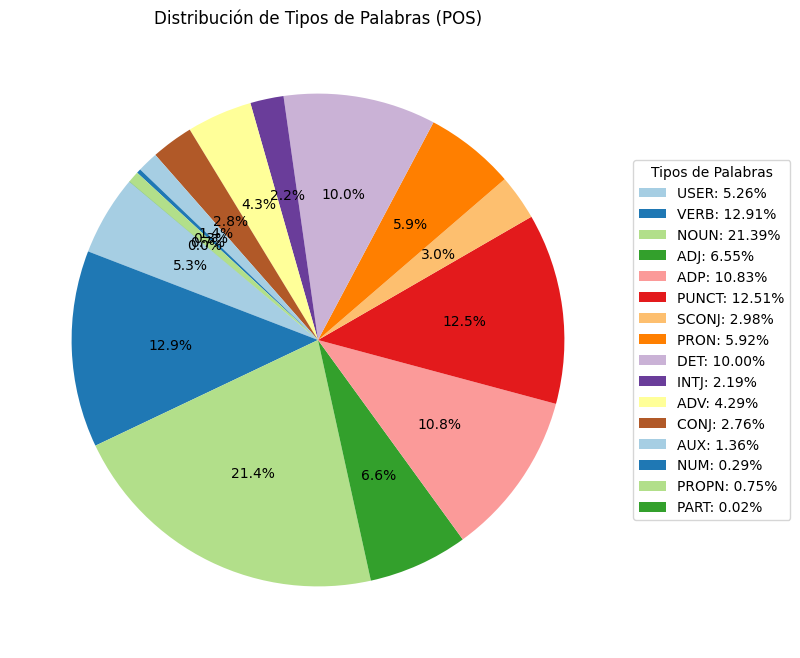

In [82]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(overall_pos_percentages.values(),  startangle=140, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
ax.set_title("Distribución de Tipos de Palabras (POS)")
legend_labels = [f"{pos_type}: {percentage:.2f}%" for pos_type, percentage in overall_pos_percentages.items()]
ax.legend(wedges, legend_labels, title="Tipos de Palabras", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

--------------------------------------------


-----------------------------------------------

### Tweets misogynous

-----------------------------------------------


In [84]:
# POS en tweets misogynous
text_misogynous = [text for text in df_misocorpus_train[df_misocorpus_train["label"] == 1]["tweet"].tolist()]
results_pos_misogynous = [analyze_pos_tags(text) for text in tqdm(text_misogynous)]

  1%|          | 12/2237 [00:00<00:38, 57.69it/s]

Texto analizado: @twominbae cállate puta
Etiquetas encontradas: [('@twominbae', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN')]
Texto analizado: @Josumovic Puta Greta
Etiquetas encontradas: [('@josumovic', 'USER'), ('puta', 'NOUN'), ('greta', 'NOUN')]
Texto analizado: @monasterioR @julia_otero Eres patética
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('eres', 'VERB'), ('patética', 'ADJ')]
Texto analizado: @GretaThunberg Loca del coño
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('loca', 'ADJ'), ('del', 'ADP'), ('coño', 'NOUN')]
Texto analizado: @GretaThunberg cerda
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('cerda', 'NOUN')]
Texto analizado: @outmarina Cállate puta de mierda
Etiquetas encontradas: [('@outmarina', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN')]
Texto analizado: @Valeryth_ Callate puta que te dejo en visto
Etiquetas encontradas: [('@valeryth', 'USER'), ('_', 'PUNCT'), ('callate', 'VERB'),

  1%|          | 19/2237 [00:00<00:37, 59.68it/s]

Texto analizado: @drummniatico No se vaya asustar! Ese es el gremio de feminazis... el cuartel de las feas, que si le dices preciosas, se ofenden, xq piensa que te le burlas, pues ellas saben que no lo son! http://t.co/
Etiquetas encontradas: [('@drummniatico', 'USER'), ('no', 'ADV'), ('se', 'PRON'), ('vaya', 'AUX'), ('asustar', 'VERB'), ('!', 'PUNCT'), ('ese', 'PRON'), ('es', 'VERB'), ('el', 'DET'), ('gremio', 'NOUN'), ('de', 'ADP'), ('feminazis', 'NOUN'), ('...', 'PUNCT'), ('el', 'DET'), ('cuartel', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('feas', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('le', 'PRON'), ('dices', 'VERB'), ('preciosas', 'ADJ'), (',', 'PUNCT'), ('se', 'PRON'), ('ofenden', 'VERB'), (',', 'PUNCT'), ('xq', 'SCONJ'), ('piensa', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('le', 'PRON'), ('burlas', 'VERB'), (',', 'PUNCT'), ('pues', 'SCONJ'), ('ellas', 'PRON'), ('saben', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('lo', 'PRON'), ('son', 'VERB'), ('!', 'PUNCT'

  1%|▏         | 33/2237 [00:00<00:34, 62.99it/s]

Texto analizado: @negromangueraa @Ironmanmark851 Los vídeos de las feminazis en pelotas algo ladillisimoooo
Etiquetas encontradas: [('@negromangueraa', 'USER'), ('@ironmanmark851', 'USER'), ('los', 'DET'), ('vídeos', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('en', 'ADP'), ('pelotas', 'NOUN'), ('algo', 'PRON'), ('ladillisimooo', 'ADJ')]
Texto analizado: @eluniversocom Quien es capaz de piropiar a las feminazis. Eso si es ser puerco. Además en la hinchada barcelonista también hay mujeres. Estas feminazis son ridículas, ahora generalizando a la hinchada de un club deportivo.
Etiquetas encontradas: [('@eluniversocom', 'USER'), ('quien', 'PRON'), ('es', 'VERB'), ('capaz', 'ADJ'), ('de', 'ADP'), ('piropiar', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('.', 'PUNCT'), ('eso', 'PRON'), ('si', 'SCONJ'), ('es', 'VERB'), ('ser', 'VERB'), ('puerco', 'ADJ'), ('.', 'PUNCT'), ('además', 'ADV'), ('en', 'ADP'), ('la', 'DET'), ('hinchada', 'NOUN'), ('barcelonista'

  2%|▏         | 46/2237 [00:00<00:38, 57.39it/s]

Texto analizado: @LaReinaDeNarnia Es que claro, las feminazis no lo hacen con hombres así que eso no se da en la vida real, tortilleras hdp
Etiquetas encontradas: [('@lareinadenarnia', 'USER'), ('es', 'VERB'), ('que', 'SCONJ'), ('claro', 'INTJ'), (',', 'PUNCT'), ('las', 'DET'), ('feminazis', 'NOUN'), ('no', 'ADV'), ('lo', 'PRON'), ('hacen', 'VERB'), ('con', 'ADP'), ('hombres', 'NOUN'), ('así', 'ADV'), ('que', 'SCONJ'), ('eso', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('da', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('vida', 'NOUN'), ('real', 'ADJ'), (',', 'PUNCT'), ('tortilleras', 'NOUN'), ('hdp', 'NOUN')]
Texto analizado: Mostritas #Feminazi amenazando como ellas saben. http://t.co/
Etiquetas encontradas: [('mostritas', 'NOUN'), ('hashtag', 'ADP'), ('feminazi', 'NOUN'), ('amenazando', 'VERB'), ('como', 'SCONJ'), ('ellas', 'PRON'), ('saben', 'VERB'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @alexandrahorler Sigue ahí, tienes condiciones. Vas a salir más empoderada que todas las 

  3%|▎         | 60/2237 [00:01<00:36, 60.06it/s]

Texto analizado: La maldad les regresó a las FemiNazi como un boomerang http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('maldad', 'NOUN'), ('les', 'PRON'), ('regresó', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('feminazi', 'NOUN'), ('como', 'SCONJ'), ('un', 'DET'), ('boomerang', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: @LaFallaras Estás loca de remate.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('estás', 'VERB'), ('loca', 'ADJ'), ('de', 'ADP'), ('remate', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @AdaColau Perra!
Etiquetas encontradas: [('@adacolau', 'USER'), ('perra', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: @SinEmbargoMX greta la loca
Etiquetas encontradas: [('@sinembargomx', 'USER'), ('greta', 'NOUN'), ('la', 'DET'), ('loca', 'ADJ')]
Texto analizado: @politikcorrecta @olinguiito Esta niña suena a marioneta feminazi con grabación incluida ?
Etiquetas encontradas: [('@politikcorrecta', 'USER'), ('@olinguiito', 'USER'), ('esta', 'DET'), ('niña', 'NOUN'), ('suena', 'VERB'), 

  3%|▎         | 67/2237 [00:01<00:35, 60.44it/s]

Texto analizado: @kimamoncita @lua_jk @YouTubeMexico @KimberlyLoaiza_ @Juandedios_P Si ya como con esa canción Feminazi se a logrado mucho felicidades ???
Etiquetas encontradas: [('@kimamoncita', 'USER'), ('@lua_jk', 'USER'), ('@youtubemexico', 'USER'), ('@kimberlyloaiza', 'USER'), ('_', 'NOUN'), ('@juandedios_p', 'USER'), ('si', 'SCONJ'), ('ya', 'ADV'), ('como', 'SCONJ'), ('con', 'ADP'), ('esa', 'DET'), ('canción', 'NOUN'), ('feminazi', 'NOUN'), ('se', 'PRON'), ('a', 'AUX'), ('logrado', 'VERB'), ('mucho', 'ADV'), ('felicidades', 'INTJ'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @LaFallaras Que pesadita eres hija!!! Cambia de disco....cerda http://t.co/
Etiquetas encontradas: [('@lafallaras', 'USER'), ('que', 'SCONJ'), ('pesadita', 'ADJ'), ('eres', 'VERB'), ('hija', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('cambia', 'VERB'), ('de', 'ADP'), ('disco', 'NOUN'), ('...', 'PUNCT'), ('cerda', 'ADJ'), ('url/', 'PUNCT')]
Texto analizado: @LaFallaras @Pei

  4%|▎         | 80/2237 [00:01<00:39, 55.07it/s]

Texto analizado: @RoloConCulo Aca a las gordas no les gustan que les digan gordas, a las feas que les digan feas, a las feminazis que son feminazis, ahora a los rolos que bailan como momias ¡qué estrés! ?
Etiquetas encontradas: [('@roloconculo', 'USER'), ('aca', 'ADV'), ('a', 'ADP'), ('las', 'DET'), ('gordas', 'ADJ'), ('no', 'ADV'), ('les', 'PRON'), ('gustan', 'VERB'), ('que', 'SCONJ'), ('les', 'PRON'), ('digan', 'VERB'), ('gordas', 'ADJ'), (',', 'PUNCT'), ('a', 'ADP'), ('las', 'DET'), ('feas', 'ADJ'), ('que', 'SCONJ'), ('les', 'PRON'), ('digan', 'VERB'), ('feas', 'ADJ'), (',', 'PUNCT'), ('a', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('que', 'PRON'), ('son', 'VERB'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('ahora', 'ADV'), ('a', 'ADP'), ('los', 'DET'), ('rolos', 'NOUN'), ('que', 'SCONJ'), ('bailan', 'VERB'), ('como', 'ADP'), ('momias', 'NOUN'), ('¡', 'PUNCT'), ('qué', 'DET'), ('estrés', 'NOUN'), ('!', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @LaFallaras @ContadorAltsasu Ojala s

  4%|▍         | 93/2237 [00:01<00:37, 56.98it/s]

Texto analizado: @LuisitoAnton Escorias de la humanidad estás feminazis.
Etiquetas encontradas: [('@luisitoanton', 'USER'), ('escorias', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('humanidad', 'NOUN'), ('estás', 'VERB'), ('feminazis', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @EsK198 @kislingerluisa Dale un hijo a la feminazi ésta pues !!!!! Gallo....
Etiquetas encontradas: [('@esk198', 'USER'), ('@kislingerluisa', 'USER'), ('dale', 'VERB'), ('un', 'DET'), ('hijo', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('feminazi', 'NOUN'), ('ésta', 'PRON'), ('pues', 'SCONJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('gallo', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @corbynbb_ @mendezdecadario @engelnava @mujerescreando1 @AgustinLaje @NickyMarquez1 Y en cuanto al aborto es criminal que digas que el feto ni siente, tú sabías q antes de las 3 semanas ya tiene corazón? Las FEMINAZI piden aborto sin límite de Edad Gestacional!!! Y para eso también aplican vandalismo q es lo único que saben hacer ht

  5%|▍         | 106/2237 [00:01<00:36, 58.70it/s]

Texto analizado: Alguna feminazi te contó esto? http://t.co/
Etiquetas encontradas: [('alguna', 'DET'), ('feminazi', 'NOUN'), ('te', 'PRON'), ('contó', 'VERB'), ('esto', 'PRON'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: Cuidado: Perras Feminazis http://t.co/
Etiquetas encontradas: [('cuidado', 'INTJ'), (':', 'PUNCT'), ('perras', 'NOUN'), ('feminazis', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: @GretaThunberg La cara de hija de puta que tenés es tremenda
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('la', 'DET'), ('cara', 'NOUN'), ('de', 'ADP'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('que', 'SCONJ'), ('tenés', 'VERB'), ('es', 'VERB'), ('tremenda', 'ADJ')]
Texto analizado: @La_Nuri @luispablob Misógino por qe? Eso no tiene nada qe ver..tu seguro eres una feminazi que si dicen algo en contra o no apoyan la causa de una mujer entonces ya uno es un misógino violador opresor..el hecho de darme cuenta del trasfondo del "movimiento greta" no me hace misógino, te 

  5%|▌         | 112/2237 [00:01<00:38, 55.01it/s]

Texto analizado: @cayetanaAT hay q ser patética para ir provocando...pero oye y las risas q consigues se agradece
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('hay', 'AUX'), ('q', 'SCONJ'), ('ser', 'VERB'), ('patética', 'ADJ'), ('para', 'ADP'), ('ir', 'AUX'), ('provocando', 'VERB'), ('...', 'PUNCT'), ('pero', 'CONJ'), ('oye', 'VERB'), ('y', 'CONJ'), ('las', 'DET'), ('risas', 'NOUN'), ('q', 'PRON'), ('consigues', 'VERB'), ('se', 'PRON'), ('agradece', 'VERB')]
Texto analizado: @RubenSanchezTW Pues porque ni hubo violación ninguna ni la "víctima" fue tal sino una pija calentorra que mintió como una cerda para meter 38 años en la cárcel a 3 chavales inocentes.
Etiquetas encontradas: [('@rubensancheztw', 'USER'), ('pues', 'SCONJ'), ('porque', 'SCONJ'), ('ni', 'CONJ'), ('hubo', 'VERB'), ('violación', 'NOUN'), ('ninguna', 'ADJ'), ('ni', 'CONJ'), ('la', 'DET'), ('"', 'PUNCT'), ('víctima', 'NOUN'), ('"', 'PUNCT'), ('fue', 'VERB'), ('tal', 'PRON'), ('sino', 'CONJ'), ('una', 'DET'), ('pija',

  5%|▌         | 123/2237 [00:02<00:50, 41.67it/s]

Texto analizado: como te vas a comprar la remera de ansiedad de cazzu jajsak todos los problemitas boee re hater lavirgacha callate puta solo pensas en coger
Etiquetas encontradas: [('como', 'ADV'), ('te', 'PRON'), ('vas', 'AUX'), ('a', 'ADP'), ('comprar', 'VERB'), ('la', 'DET'), ('remera', 'NOUN'), ('de', 'ADP'), ('ansiedad', 'NOUN'), ('de', 'ADP'), ('cazzu', 'PROPN'), ('jajsak', 'INTJ'), ('todos', 'DET'), ('los', 'DET'), ('problemitas', 'NOUN'), ('boee', 'INTJ'), ('re', 'ADV'), ('hater', 'ADJ'), ('lavirgacha', 'DET'), ('callate', 'VERB'), ('puta', 'NOUN'), ('solo', 'ADV'), ('pensas', 'VERB'), ('en', 'ADP'), ('coger', 'VERB')]
Texto analizado: @YehudGD Hasta que dejes de preguntar gilipolleces en Twitter. Venga a fregar coño.
Etiquetas encontradas: [('@yehudgd', 'USER'), ('hasta', 'ADP'), ('que', 'SCONJ'), ('dejes', 'AUX'), ('de', 'ADP'), ('preguntar', 'VERB'), ('gilipolleces', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('.', 'PUNCT'), ('venga', 'VERB'), ('a', 'ADP'), ('fregar', 'VE

  6%|▌         | 133/2237 [00:02<00:50, 41.31it/s]

Texto analizado: @silvitabuendia Jajajaja punto para las feminazis, pero esta “guerra” la va ganando la sensatez y de laaaaargo!
Etiquetas encontradas: [('@silvitabuendia', 'USER'), ('jaja', 'INTJ'), ('punto', 'NOUN'), ('para', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('esta', 'DET'), ('"', 'PUNCT'), ('guerra', 'NOUN'), ('"', 'PUNCT'), ('la', 'PRON'), ('va', 'AUX'), ('ganando', 'VERB'), ('la', 'DET'), ('sensatez', 'NOUN'), ('y', 'CONJ'), ('de', 'ADP'), ('laaargo', 'ADJ'), ('!', 'PUNCT')]
Texto analizado: @LaFallaras Que te crees Marilyn Monroe puta gorda asquerosa
Etiquetas encontradas: [('@lafallaras', 'USER'), ('que', 'SCONJ'), ('te', 'PRON'), ('crees', 'VERB'), ('marilyn', 'PROPN'), ('monroe', 'NOUN'), ('puta', 'NOUN'), ('gorda', 'NOUN'), ('asquerosa', 'ADJ')]
Texto analizado: Si a las feministas tanto les molesta Twitter y hombres en general ¡Ellas son sumamente independientes son el alfa y omega de nuestra sociedad¡ pueden crear un red socia

  7%|▋         | 150/2237 [00:02<00:34, 60.04it/s]

Texto analizado: Le arruinaron las vacaciones, malditas feminazis! Otra víctima más :’( se me estruja el calzoncillo http://t.co/
Etiquetas encontradas: [('le', 'PRON'), ('arruinaron', 'VERB'), ('las', 'DET'), ('vacaciones', 'NOUN'), (',', 'PUNCT'), ('malditas', 'ADJ'), ('feminazis', 'NOUN'), ('!', 'PUNCT'), ('otra', 'DET'), ('víctima', 'NOUN'), ('más', 'PRON'), (':(', 'PUNCT'), ('se', 'PRON'), ('me', 'PRON'), ('estruja', 'VERB'), ('el', 'DET'), ('calzoncillo', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: @rouco64 @Delamasa123 Estos cobardes jueces progres q adoptan por presión, como con la LIVG, las ideas feminazis, están diciendo que si haces lo que sea con la víctima y luego la matas y la descuartizas tienes muchas más probabilidades de salir con una pena leve. Esta sentencia es de locos #Arandina
Etiquetas encontradas: [('@rouco64', 'USER'), ('@delamasa123', 'USER'), ('estos', 'DET'), ('cobardes', 'ADJ'), ('jueces', 'NOUN'), ('progres', 'NOUN'), ('q', 'PRON'), ('adoptan', 'VERB'), 

  8%|▊         | 170/2237 [00:02<00:27, 76.15it/s]

Texto analizado: Bonito expresar una opinión sin ser ofendido por ¡#twitter, #Feminazis, #politicos, #23Dic, #twitternoesreddeodio ! Triste leer comentarios sobre twits que no gustan y acosar al que expreso su idea, muy triste. Seamos mas gente y menos ofensivos ?. Comprensión por favor ?
Etiquetas encontradas: [('bonito', 'ADJ'), ('expresar', 'VERB'), ('una', 'DET'), ('opinión', 'NOUN'), ('sin', 'ADP'), ('ser', 'VERB'), ('ofendido', 'ADJ'), ('por', 'ADP'), ('¡', 'PUNCT'), ('hashtag', 'ADP'), ('twitter', 'NOUN'), (',', 'PUNCT'), ('hashtag', 'NOUN'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('hashtag', 'ADP'), ('politicos', 'NOUN'), (',', 'PUNCT'), ('hashtag', 'NOUN'), ('23dic', 'PROPN'), (',', 'PUNCT'), ('hashtag', 'INTJ'), ('twitternoesreddeodio', 'NOUN'), ('!', 'PUNCT'), ('triste', 'ADJ'), ('leer', 'VERB'), ('comentarios', 'NOUN'), ('sobre', 'ADP'), ('twits', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('gustan', 'VERB'), ('y', 'CONJ'), ('acosar', 'VERB'), ('al', 'ADP'), ('que', 'PRON'), 

  8%|▊         | 190/2237 [00:03<00:24, 85.04it/s]

Texto analizado: Una féminazi ver a ver esto y se le va a salir un ojo ?? http://t.co/
Etiquetas encontradas: [('una', 'DET'), ('féminazi', 'NOUN'), ('ver', 'VERB'), ('a', 'ADP'), ('ver', 'VERB'), ('esto', 'PRON'), ('y', 'CONJ'), ('se', 'PRON'), ('le', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('salir', 'VERB'), ('un', 'DET'), ('ojo', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @HelenaTunon @annapratx Que frágil tenés que ser para volverte una feminazi resentida con todos los hombres por una mala experiencia
Etiquetas encontradas: [('@helenatunon', 'USER'), ('@annapratx', 'USER'), ('que', 'SCONJ'), ('frágil', 'ADJ'), ('tenés', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('para', 'ADP'), ('volverte', 'VERB'), ('una', 'DET'), ('feminazi', 'NOUN'), ('resentida', 'ADJ'), ('con', 'ADP'), ('todos', 'DET'), ('los', 'DET'), ('hombres', 'NOUN'), ('por', 'ADP'), ('una', 'DET'), ('mala', 'ADJ'), ('experiencia', 'NOUN')]
Texto analizado: @pametroya @AndreaRivera_V Eres f

  9%|▉         | 208/2237 [00:03<00:24, 84.25it/s]

Texto analizado: Esta es una bruja sin escrúpulos, cuando una lesbiana mata a su compañera ella dice que lo hizo por que reproduce conductas machistas. No acabas de entender que el asesino es asesino sin importar su género #Feminazi #silvita http://t.co/
Etiquetas encontradas: [('esta', 'PRON'), ('es', 'VERB'), ('una', 'DET'), ('bruja', 'NOUN'), ('sin', 'ADP'), ('escrúpulos', 'NOUN'), (',', 'PUNCT'), ('cuando', 'SCONJ'), ('una', 'DET'), ('lesbiana', 'NOUN'), ('mata', 'VERB'), ('a', 'ADP'), ('su', 'DET'), ('compañera', 'NOUN'), ('ella', 'PRON'), ('dice', 'VERB'), ('que', 'SCONJ'), ('lo', 'PRON'), ('hizo', 'VERB'), ('por', 'ADP'), ('que', 'SCONJ'), ('reproduce', 'VERB'), ('conductas', 'NOUN'), ('machistas', 'ADJ'), ('.', 'PUNCT'), ('no', 'ADV'), ('acabas', 'AUX'), ('de', 'ADP'), ('entender', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('asesino', 'NOUN'), ('es', 'VERB'), ('asesino', 'ADJ'), ('sin', 'ADP'), ('importar', 'VERB'), ('su', 'DET'), ('género', 'NOUN'), ('hashtag', 'PUNCT'), ('fem

 10%|▉         | 217/2237 [00:03<00:27, 73.10it/s]

Texto analizado: Qué dicen las feminazis cuando una madre le pega a su hija? Si hubiese sido un hombre con el cinto en la mano ya está en cana. Si en cambio fuese una madre contra un niño... http://t.co/
Etiquetas encontradas: [('qué', 'PRON'), ('dicen', 'VERB'), ('las', 'DET'), ('feminazis', 'NOUN'), ('cuando', 'SCONJ'), ('una', 'DET'), ('madre', 'NOUN'), ('le', 'PRON'), ('pega', 'VERB'), ('a', 'ADP'), ('su', 'DET'), ('hija', 'NOUN'), ('?', 'PUNCT'), ('si', 'SCONJ'), ('hubiese', 'AUX'), ('sido', 'VERB'), ('un', 'DET'), ('hombre', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('cinto', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('mano', 'NOUN'), ('ya', 'ADV'), ('está', 'VERB'), ('en', 'ADP'), ('cana', 'NOUN'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('en', 'ADP'), ('cambio', 'NOUN'), ('fuese', 'VERB'), ('una', 'DET'), ('madre', 'NOUN'), ('contra', 'ADP'), ('un', 'DET'), ('niño', 'NOUN'), ('...', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @LaFallaras @CristinaSegui_ @alfonso_ussia @bertrandmyd @publi

 10%|█         | 233/2237 [00:03<00:29, 69.01it/s]

Texto analizado: Voy hacer tutoriales para enseñarle a las que quieran saber como bañar a un bebé, como hacer el biberon, como ponerle un pañal y como hacer arroz carne y frijoles. Guachito de pollo con culantro y contar los 3 centavos Porque con la generacion "feminazi" Sálvese quien pueda.
Etiquetas encontradas: [('voy', 'AUX'), ('hacer', 'VERB'), ('tutoriales', 'NOUN'), ('para', 'ADP'), ('enseñarle', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('que', 'PRON'), ('quieran', 'VERB'), ('saber', 'VERB'), ('como', 'SCONJ'), ('bañar', 'VERB'), ('a', 'ADP'), ('un', 'DET'), ('bebé', 'NOUN'), (',', 'PUNCT'), ('como', 'SCONJ'), ('hacer', 'VERB'), ('el', 'DET'), ('biberon', 'NOUN'), (',', 'PUNCT'), ('como', 'SCONJ'), ('ponerle', 'PRON'), ('un', 'DET'), ('pañal', 'NOUN'), ('y', 'CONJ'), ('como', 'SCONJ'), ('hacer', 'VERB'), ('arroz', 'NOUN'), ('carne', 'NOUN'), ('y', 'CONJ'), ('frijoles', 'NOUN'), ('.', 'PUNCT'), ('guachito', 'NOUN'), ('de', 'ADP'), ('pollo', 'NOUN'), ('con', 'ADP'), ('culantro', 'NO

 11%|█         | 249/2237 [00:04<00:28, 69.70it/s]

Texto analizado: Dioos, anoche soñé que venia Greta Thunberg de intercambio a mi casa y que era una hija de puta y no paraba de joderme, ahora me cae mal
Etiquetas encontradas: [('dioos', 'INTJ'), (',', 'PUNCT'), ('anoche', 'ADV'), ('soñé', 'VERB'), ('que', 'SCONJ'), ('venia', 'VERB'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('de', 'ADP'), ('intercambio', 'NOUN'), ('a', 'ADP'), ('mi', 'DET'), ('casa', 'NOUN'), ('y', 'CONJ'), ('que', 'SCONJ'), ('era', 'VERB'), ('una', 'DET'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('paraba', 'VERB'), ('de', 'ADP'), ('joderme', 'VERB'), (',', 'PUNCT'), ('ahora', 'ADV'), ('me', 'PRON'), ('cae', 'VERB'), ('mal', 'ADV')]
Texto analizado: "Oh, estás criminalizando a la vícti...". Que sí, que a fregar.
Etiquetas encontradas: [('"', 'PUNCT'), ('oh', 'INTJ'), (',', 'PUNCT'), ('estás', 'VERB'), ('criminalizando', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('vícti', 'NOUN'), ('...', 'PUNCT'), ('"', 'PUNCT'), ('.', 'PUNCT'), (

 11%|█▏        | 257/2237 [00:04<00:28, 69.52it/s]

Texto analizado: @DioCinicoXXX JAJAJAJJAJAJJAJAJA BRUJA FEMINAZI JAJAJJAJAJAJA Me encanta.
Etiquetas encontradas: [('@diocinicoxxx', 'USER'), ('jaja', 'INTJ'), ('bruja', 'NOUN'), ('feminazi', 'NOUN'), ('jaja', 'INTJ'), ('me', 'PRON'), ('encanta', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @Larrydimick @javifrance @davidsantosvlog No pierdas el tiempo con esta fanática. O es una nofollada fracasada o tendrá algún trauma de que el padrastro o el tio le hizo algo inapropiado y ahora culpa a todos los hombres. Yo soy de la opinión de que algunas de estas feminazis fueron abusadas y traumatizadas de verdad.
Etiquetas encontradas: [('@larrydimick', 'USER'), ('@javifrance', 'USER'), ('@davidsantosvlog', 'USER'), ('no', 'ADV'), ('pierdas', 'VERB'), ('el', 'DET'), ('tiempo', 'NOUN'), ('con', 'ADP'), ('esta', 'DET'), ('fanática', 'NOUN'), ('.', 'PUNCT'), ('o', 'CONJ'), ('es', 'VERB'), ('una', 'DET'), ('nofollada', 'NOUN'), ('fracasada', 'ADJ'), ('o', 'CONJ'), ('tendrá', 'VERB'), ('algún', 'DET'),

 12%|█▏        | 272/2237 [00:04<00:28, 68.30it/s]

Texto analizado: Mi vecinito de al lado (tiene 3 años) y le iba diciendo a la tia la concha de tu madre. Yo de metida le digo la boca y me dice ' Vos cállate puta'??
Etiquetas encontradas: [('mi', 'DET'), ('vecinito', 'NOUN'), ('de', 'ADP'), ('al', 'ADP'), ('lado', 'NOUN'), ('(', 'PUNCT'), ('tiene', 'VERB'), ('3', 'NUM'), ('años', 'NOUN'), (')', 'PUNCT'), ('y', 'CONJ'), ('le', 'PRON'), ('iba', 'AUX'), ('diciendo', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('tia', 'NOUN'), ('la', 'DET'), ('concha', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('madre', 'NOUN'), ('.', 'PUNCT'), ('yo', 'PRON'), ('de', 'ADP'), ('metida', 'ADJ'), ('le', 'PRON'), ('digo', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('dice', 'VERB'), ("'", 'PUNCT'), ('vos', 'PRON'), ('cállate', 'VERB'), ('puta', 'NOUN'), ("'", 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @mariapaularomo @PoliciaEcuador @caathytorres @MinGobiernoEc @ComunicacionEc ¿Y cuántos indígenas d los que violaron a mujer

 13%|█▎        | 288/2237 [00:04<00:27, 70.25it/s]

Texto analizado: @ghitis Es una de las modernas y malditas feminazis que no debieron nacer.
Etiquetas encontradas: [('@ghitis', 'USER'), ('es', 'VERB'), ('una', 'DET'), ('de', 'ADP'), ('las', 'DET'), ('modernas', 'ADJ'), ('y', 'CONJ'), ('malditas', 'ADJ'), ('feminazis', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('debieron', 'VERB'), ('nacer', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Y así comenzaron las primeras feminazis ? http://t.co/
Etiquetas encontradas: [('y', 'CONJ'), ('así', 'ADV'), ('comenzaron', 'VERB'), ('las', 'DET'), ('primeras', 'ADJ'), ('feminazis', 'NOUN'), ('?', 'PUNCT'), ('url/', 'NOUN')]
Texto analizado: @gonzaperucarajo Conociendo la forma de vida de Higinio, dudo que él, te haya allanado. Seguro que las feminazis y sus ministerios aliados (mimp, minjus) y la Defensoría LGTB presionaron para quitarles presupuesto.
Etiquetas encontradas: [('@gonzaperucarajo', 'USER'), ('conociendo', 'VERB'), ('la', 'DET'), ('forma', 'NOUN'), ('de', 'ADP'), ('vida', 'NOUN'), ('de', 'A

 14%|█▎        | 304/2237 [00:04<00:27, 70.73it/s]

Texto analizado: ¿Incluye la glorificación d las #feminazis? http://t.co/
Etiquetas encontradas: [('¿', 'PUNCT'), ('incluye', 'VERB'), ('la', 'DET'), ('glorificación', 'PROPN'), ('d', 'ADP'), ('las', 'DET'), ('hashtag', 'INTJ'), ('feminazis', 'NOUN'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @cayetanaAT Yo no dedicaría ni un micro-segundo de mi tiempo a alguien tan insignificante como esta pseudo-ministra ... Nos queda mucho para reírnos con (de) ella ...Es una progre patética y cateta... ???? No sé qué hace @cayetanaAT o su community manager “devoting time” a este engendro.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('yo', 'PRON'), ('no', 'ADV'), ('dedicaría', 'VERB'), ('ni', 'ADV'), ('un', 'DET'), ('micro-segundo', 'ADJ'), ('de', 'ADP'), ('mi', 'DET'), ('tiempo', 'NOUN'), ('a', 'ADP'), ('alguien', 'PRON'), ('tan', 'ADV'), ('insignificante', 'ADJ'), ('como', 'ADP'), ('esta', 'DET'), ('pseudo-ministra', 'ADJ'), ('...', 'PUNCT'), ('nos', 'PRON'), ('queda', 'VERB'), ('muc

 14%|█▍        | 319/2237 [00:05<00:29, 65.61it/s]

Texto analizado: @nissulo26 @reygorila26 Javi, Greta Thunberg esta tan loca porque jugó a flower, fíjate si tiene mensaje.
Etiquetas encontradas: [('@nissulo26', 'USER'), ('@reygorila26', 'USER'), ('javi', 'PROPN'), (',', 'PUNCT'), ('greta', 'PROPN'), ('thunberg', 'PROPN'), ('esta', 'PRON'), ('tan', 'ADV'), ('loca', 'ADJ'), ('porque', 'SCONJ'), ('jugó', 'VERB'), ('a', 'ADP'), ('flower', 'NOUN'), (',', 'PUNCT'), ('fíjate', 'VERB'), ('si', 'SCONJ'), ('tiene', 'VERB'), ('mensaje', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras @__pbl Queda claro. Estás loca del C
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@__pbl', 'USER'), ('queda', 'VERB'), ('claro', 'ADJ'), ('.', 'PUNCT'), ('estás', 'VERB'), ('loca', 'ADJ'), ('del', 'ADP'), ('c', 'NOUN')]
Texto analizado: @LaFallaras TU SI QUE ERES COMICA Y PATETICA MUY PATETICA
Etiquetas encontradas: [('@lafallaras', 'USER'), ('tu', 'DET'), ('si', 'SCONJ'), ('que', 'SCONJ'), ('eres', 'VERB'), ('comica', 'ADJ'), ('y', 'CONJ'), ('patetica'

 15%|█▍        | 333/2237 [00:05<00:30, 63.44it/s]

Texto analizado: @InesArrimadas me hace gracia lo chula que te pones hablando como si tuvieras 50 escaños y no tienes una mierda so payasa
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('me', 'PRON'), ('hace', 'VERB'), ('gracia', 'NOUN'), ('lo', 'DET'), ('chula', 'ADJ'), ('que', 'SCONJ'), ('te', 'PRON'), ('pones', 'VERB'), ('hablando', 'VERB'), ('como', 'SCONJ'), ('si', 'SCONJ'), ('tuvieras', 'VERB'), ('50', 'NUM'), ('escaños', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('tienes', 'VERB'), ('una', 'DET'), ('mierda', 'NOUN'), ('so', 'ADV'), ('payasa', 'NOUN')]
Texto analizado: @24h_tve @GretaThunberg A la tonta histérica ????? ??
Etiquetas encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER'), ('a', 'ADP'), ('la', 'DET'), ('tonta', 'ADJ'), ('histérica', 'ADJ'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @elhigadodmarita Basta ver su simbolito verde y morado para saber que es una core feminazi. WTF
Etiquetas encontradas: [(

 15%|█▌        | 340/2237 [00:05<00:31, 60.30it/s]

Texto analizado: @YatzeU @mariieFeminist @candeherrera05 Y las feminazis que se creen hombre. Como quedan ahí! ??☺
Etiquetas encontradas: [('@yatzeu', 'USER'), ('@mariiefeminist', 'USER'), ('@candeherrera05', 'USER'), ('y', 'CONJ'), ('las', 'DET'), ('feminazis', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('creen', 'VERB'), ('hombre', 'NOUN'), ('.', 'PUNCT'), ('como', 'ADV'), ('quedan', 'VERB'), ('ahí', 'ADV'), ('!', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: una feminazi deseandote la muerte parte 1000 http://t.co/
Etiquetas encontradas: [('una', 'DET'), ('feminazi', 'NOUN'), ('deseandote', 'VERB'), ('la', 'DET'), ('muerte', 'NOUN'), ('parte', 'ADV'), ('1000', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: @LaFallaras Quedate con lo de loca y borracha?. Y lo de malfollada no creo, porque dudo que alguien quiera acostarse contigo siquiera?
Etiquetas encontradas: [('@lafallaras', 'USER'), ('quedate', 'VERB'), ('con', 'ADP'), ('lo', 'DET'), ('de', 'ADP'), ('loca', 'ADJ'), ('y'

 16%|█▌        | 357/2237 [00:05<00:27, 68.00it/s]

Texto analizado: "Viva el patriarcado" "vuelve a la cocina" "feminazi :v" "el patriarcado ni se inmuta" "hazme un sandwich :vv" http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('viva', 'ADJ'), ('el', 'DET'), ('patriarcado', 'NOUN'), ('"', 'PUNCT'), ('"', 'PUNCT'), ('vuelve', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cocina', 'NOUN'), ('"', 'PUNCT'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), (':', 'PUNCT'), ('v', 'INTJ'), ('"', 'PUNCT'), ('"', 'PUNCT'), ('el', 'DET'), ('patriarcado', 'NOUN'), ('ni', 'CONJ'), ('se', 'PRON'), ('inmuta', 'VERB'), ('"', 'PUNCT'), ('"', 'PUNCT'), ('hazme', 'VERB'), ('un', 'DET'), ('sandwich', 'NOUN'), (':', 'PUNCT'), ('vv', 'INTJ'), ('"', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: Greta cabrona que tenes madera atrás. ¿Cuantos árboles se cortaron para hacer eso? http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('cabrona', 'ADJ'), ('que', 'SCONJ'), ('tenes', 'VERB'), ('madera', 'NOUN'), ('atrás', 'ADV'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('cuantos', 'DE

 17%|█▋        | 376/2237 [00:05<00:23, 80.03it/s]

Texto analizado: @LaFallaras Tu si que eres gilipollas, bastarda de mierda. Eres un despojo.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('tu', 'DET'), ('si', 'SCONJ'), ('que', 'SCONJ'), ('eres', 'VERB'), ('gilipollas', 'NOUN'), (',', 'PUNCT'), ('bastarda', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ('.', 'PUNCT'), ('eres', 'VERB'), ('un', 'DET'), ('despojo', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LNRevista @GretaThunberg Dejen de joder mira si la van a poner a esta pendeja zurda como personaje del año.
Etiquetas encontradas: [('@lnrevista', 'USER'), ('@gretathunberg', 'USER'), ('dejen', 'VERB'), ('de', 'ADP'), ('joder', 'VERB'), ('mira', 'VERB'), ('si', 'SCONJ'), ('la', 'PRON'), ('van', 'AUX'), ('a', 'ADP'), ('poner', 'VERB'), ('a', 'ADP'), ('esta', 'DET'), ('pendeja', 'ADJ'), ('zurda', 'NOUN'), ('como', 'ADP'), ('personaje', 'NOUN'), ('del', 'ADP'), ('año', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @Rcm33Rodolfo Si lo que quieres es crecer en esta red, al menos sé honesto h

 18%|█▊        | 395/2237 [00:06<00:21, 83.90it/s]

Texto analizado: Woo..woo..Woo.? Detenme ese TREN #FEMINAZI de PREJUICIOS PENDEJOS q NO ayudan en NADA, sólo a hacer esta sociedad más en VERGA y de MIERDA?.Soy una MUJER de 36 años q se rasura porque me da la PUTA GANA, porque QUIERO,porque eso me da picazón tener los vellos muy largos PUNTO? http://t.co/
Etiquetas encontradas: [('woo', 'INTJ'), ('..', 'PUNCT'), ('woo', 'INTJ'), ('..', 'PUNCT'), ('woo', 'INTJ'), ('.', 'PUNCT'), ('?', 'PUNCT'), ('detenme', 'VERB'), ('ese', 'DET'), ('tren', 'NOUN'), ('hashtag', 'ADJ'), ('feminazi', 'NOUN'), ('de', 'ADP'), ('prejuicios', 'NOUN'), ('pendejos', 'ADJ'), ('q', 'PRON'), ('no', 'ADV'), ('ayudan', 'VERB'), ('en', 'ADP'), ('nada', 'PRON'), (',', 'PUNCT'), ('sólo', 'ADV'), ('a', 'ADP'), ('hacer', 'VERB'), ('esta', 'DET'), ('sociedad', 'NOUN'), ('más', 'ADV'), ('en', 'ADP'), ('verga', 'NOUN'), ('y', 'CONJ'), ('de', 'ADP'), ('mierda?.soy', 'NOUN'), ('una', 'DET'), ('mujer', 'NOUN'), ('de', 'ADP'), ('36', 'ADJ'), ('años', 'NOUN'), ('q', 'SCONJ'), ('

 19%|█▊        | 415/2237 [00:06<00:20, 88.21it/s]

Texto analizado: Yo pidiéndole a mí hija feminazi que ayude con las cosas de la casa , ella contestandome ni en pedo!! Quema ese pañuelo Mabeeeeel ???? se va a caer cuando maten el machirulo que tienen adentro ? http://t.co/
Etiquetas encontradas: [('yo', 'PRON'), ('pidiéndole', 'VERB'), ('a', 'ADP'), ('mí', 'PRON'), ('hija', 'NOUN'), ('feminazi', 'NOUN'), ('que', 'SCONJ'), ('ayude', 'VERB'), ('con', 'ADP'), ('las', 'DET'), ('cosas', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('casa', 'NOUN'), (',', 'PUNCT'), ('ella', 'PRON'), ('contestandome', 'VERB'), ('ni', 'CONJ'), ('en', 'ADP'), ('pedo', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('quema', 'VERB'), ('ese', 'DET'), ('pañuelo', 'NOUN'), ('mabeeel', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('se', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('caer', 'VERB'), ('cuando', 'SCONJ'), ('maten', 'VERB'), ('el', 'DET'), ('machirulo', 'NOUN'), ('que', 'PRON'), ('tienen', 'VERB'), ('adentro', 'ADV'), ('?', 'PUNCT'), ('url/', 'PUNCT')]
Texto

 19%|█▉        | 433/2237 [00:06<00:20, 86.76it/s]

Texto analizado: @LaFallaras @voxpopul Y la #ZORRA eres TU
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@voxpopul', 'USER'), ('y', 'CONJ'), ('la', 'DET'), ('hashtag', 'NOUN'), ('zorra', 'NOUN'), ('eres', 'VERB'), ('tu', 'PRON')]
Texto analizado: @LaFallaras @ContadorAltsasu Hay alguna asquerosidad que no le guste a esta cerda borracha??
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER'), ('hay', 'VERB'), ('alguna', 'DET'), ('asquerosidad', 'NOUN'), ('que', 'SCONJ'), ('no', 'ADV'), ('le', 'PRON'), ('guste', 'VERB'), ('a', 'ADP'), ('esta', 'DET'), ('cerda', 'NOUN'), ('borracha', 'ADJ'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @LaFallaras ¿Por que no mandas las fotos de las monjas comiendo necoras??? Vaya por delante que a mi me bautizaron y comulgue de niño,y solo voy a la iglesia a bodas y algun entierro . Pero yo me pregunto..... Como puede ser tan puta y asquerosa la zorra esta de la Cristina Fallaras .
Etiquetas encontradas: [('@lafallaras', 

 20%|██        | 452/2237 [00:06<00:20, 88.93it/s]

Texto analizado: @AdaColau Y los 5 moros del otro día en nou Barris, pedazo de zorra??? Te la sopla la víctima??? Pedazo de zorra!!!! Sigue blanqueando y siendo cómplice.... Pedazo de zorra!!!!!
Etiquetas encontradas: [('@adacolau', 'USER'), ('y', 'CONJ'), ('los', 'DET'), ('5', 'NUM'), ('moros', 'NOUN'), ('del', 'ADP'), ('otro', 'DET'), ('día', 'NOUN'), ('en', 'ADP'), ('nou', 'ADJ'), ('barris', 'NOUN'), (',', 'PUNCT'), ('pedazo', 'NOUN'), ('de', 'ADP'), ('zorra', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('te', 'PRON'), ('la', 'PRON'), ('sopla', 'VERB'), ('la', 'DET'), ('víctima', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('pedazo', 'NOUN'), ('de', 'ADP'), ('zorra', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('sigue', 'AUX'), ('blanqueando', 'VERB'), ('y', 'CONJ'), ('siendo', 'VERB'), ('cómplice', 'ADJ'), ('...', 'PUNCT'), ('pedazo', 'NOUN'), ('de', 'ADP'), ('zorra', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @C

 21%|██        | 471/2237 [00:06<00:19, 91.19it/s]

Texto analizado: @LaFallaras @ahorapodemos @iunida @PSOE @Esquerra_ERC @compromis @SofCast de Fallaras está rabiosa por que nadie le hace caso
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@ahorapodemos', 'USER'), ('@iunida', 'USER'), ('@psoe', 'USER'), ('@esquerra_erc', 'USER'), ('@compromis', 'USER'), ('@sofcast', 'USER'), ('de', 'ADP'), ('fallaras', 'NOUN'), ('está', 'VERB'), ('rabiosa', 'ADJ'), ('por', 'ADP'), ('que', 'SCONJ'), ('nadie', 'PRON'), ('le', 'PRON'), ('hace', 'VERB'), ('caso', 'NOUN')]
Texto analizado: Hay una tuitera cuyo nombre no voy a decir por no hacerle 'famosa' a #Nubianaki, q se ha dado el lujo de estudiar en el extranjero y de ser una mantenida de mierda, a punta del esfuerzo de un ONVRE, su padre. Y aún así tiene el descaro de ser feminazi y quejarse del patriarcado.
Etiquetas encontradas: [('hay', 'VERB'), ('una', 'DET'), ('tuitera', 'NOUN'), ('cuyo', 'DET'), ('nombre', 'NOUN'), ('no', 'ADV'), ('voy', 'AUX'), ('a', 'ADP'), ('decir', 'VERB'), ('por', 'ADP

 22%|██▏       | 491/2237 [00:07<00:19, 91.08it/s]

Texto analizado: @sdaquino He de hacer la observación que de todas las empelotadas feminazis esta es la que calculo que pesa menos de 150lbs y si sebastian... ????
Etiquetas encontradas: [('@sdaquino', 'USER'), ('he', 'AUX'), ('de', 'ADP'), ('hacer', 'VERB'), ('la', 'DET'), ('observación', 'NOUN'), ('que', 'PRON'), ('de', 'ADP'), ('todas', 'DET'), ('las', 'DET'), ('empelotadas', 'ADJ'), ('feminazis', 'NOUN'), ('esta', 'PRON'), ('es', 'VERB'), ('la', 'DET'), ('que', 'PRON'), ('calculo', 'VERB'), ('que', 'SCONJ'), ('pesa', 'VERB'), ('menos', 'ADJ'), ('de', 'ADP'), ('150lbs', 'NOUN'), ('y', 'CONJ'), ('si', 'SCONJ'), ('sebastian', 'PROPN'), ('...', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: Vuestro ídolo, feminazis. El jefecito que les paga el sueldo por hacer shows en media calle. http://t.co/
Etiquetas encontradas: [('vuestro', 'DET'), ('ídolo', 'NOUN'), (',', 'PUNCT'), ('feminazis', 'NOUN'), ('.', 'PUNCT'), ('el', 'DET'), ('jefecito', 'NOUN'), ('que', 'PR

 23%|██▎       | 511/2237 [00:07<00:19, 90.44it/s]

Texto analizado: Según lógica feminazi, un hombre caballeroso puede ser tildado de acosador. Lo que buscan es que en un futuro la mujer no sepa que es la caballerosidad. http://t.co/
Etiquetas encontradas: [('según', 'ADP'), ('lógica', 'NOUN'), ('feminazi', 'NOUN'), (',', 'PUNCT'), ('un', 'DET'), ('hombre', 'NOUN'), ('caballeroso', 'ADJ'), ('puede', 'AUX'), ('ser', 'VERB'), ('tildado', 'VERB'), ('de', 'ADP'), ('acosador', 'ADJ'), ('.', 'PUNCT'), ('lo', 'PRON'), ('que', 'PRON'), ('buscan', 'VERB'), ('es', 'VERB'), ('que', 'SCONJ'), ('en', 'ADP'), ('un', 'DET'), ('futuro', 'NOUN'), ('la', 'DET'), ('mujer', 'NOUN'), ('no', 'ADV'), ('sepa', 'VERB'), ('que', 'SCONJ'), ('es', 'VERB'), ('la', 'DET'), ('caballerosidad', 'NOUN'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @Eltio_Concho @pulpitoalagalle Y las feminazis: “el violador eres tú” La realidad: la que abrió las patas fui yo!
Etiquetas encontradas: [('@eltio_concho', 'USER'), ('@pulpitoalagalle', 'USER'), ('y', 'CONJ'), ('las',

 24%|██▎       | 531/2237 [00:07<00:19, 87.88it/s]

Texto analizado: @El_Omicroniano @paurubiof Ya estas tortilleras feminazis rompe mucho los huevos
Etiquetas encontradas: [('@el_omicroniano', 'USER'), ('@paurubiof', 'USER'), ('ya', 'ADV'), ('estas', 'DET'), ('tortilleras', 'NOUN'), ('feminazis', 'NOUN'), ('rompe', 'VERB'), ('mucho', 'ADV'), ('los', 'DET'), ('huevos', 'NOUN')]
Texto analizado: @MilagrosLeivaG Yo pensé que era una loca feminazi de 26 años, por la cara en algunas fotos. Ahora que veo que es una chiquilla de 16, todo mi respeto.
Etiquetas encontradas: [('@milagrosleivag', 'USER'), ('yo', 'PRON'), ('pensé', 'VERB'), ('que', 'SCONJ'), ('era', 'VERB'), ('una', 'DET'), ('loca', 'ADJ'), ('feminazi', 'NOUN'), ('de', 'ADP'), ('26', 'ADJ'), ('años', 'NOUN'), (',', 'PUNCT'), ('por', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('en', 'ADP'), ('algunas', 'DET'), ('fotos', 'NOUN'), ('.', 'PUNCT'), ('ahora', 'ADV'), ('que', 'SCONJ'), ('veo', 'VERB'), ('que', 'SCONJ'), ('es', 'VERB'), ('una', 'DET'), ('chiquilla', 'NOUN'), ('de', 'ADP'), 

 25%|██▍       | 549/2237 [00:07<00:19, 88.58it/s]

Texto analizado: A sido feminazi, con razón http://t.co/
Etiquetas encontradas: [('a', 'AUX'), ('sido', 'VERB'), ('feminazi', 'NOUN'), (',', 'PUNCT'), ('con', 'ADP'), ('razón', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: El mejor meme anti-Feminazi que he visto. http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('mejor', 'ADJ'), ('meme', 'NOUN'), ('anti-feminazi', 'ADJ'), ('que', 'SCONJ'), ('he', 'AUX'), ('visto', 'VERB'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @barbitarcic Imaginate, ya me ven como una feminazi jipi con 3 neuronas, se les revienta la matrix. ?
Etiquetas encontradas: [('@barbitarcic', 'USER'), ('imaginate', 'VERB'), (',', 'PUNCT'), ('ya', 'ADV'), ('me', 'PRON'), ('ven', 'VERB'), ('como', 'SCONJ'), ('una', 'DET'), ('feminazi', 'NOUN'), ('jipi', 'NOUN'), ('con', 'ADP'), ('3', 'NUM'), ('neuronas', 'NOUN'), (',', 'PUNCT'), ('se', 'PRON'), ('les', 'PRON'), ('revienta', 'VERB'), ('la', 'DET'), ('matrix', 'NOUN'), ('.', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado:

 25%|██▌       | 568/2237 [00:08<00:18, 89.42it/s]

Texto analizado: @lahistoriaec @mariapaularomo @PoliciaEcuador @caathytorres He visto a tantos policias con chicas que son mucho para ellos... Por lo que dudo que uno de ellos le haya dicho preciosa a esa feminazi..
Etiquetas encontradas: [('@lahistoriaec', 'USER'), ('@mariapaularomo', 'USER'), ('@policiaecuador', 'USER'), ('@caathytorres', 'USER'), ('he', 'AUX'), ('visto', 'VERB'), ('a', 'ADP'), ('tantos', 'DET'), ('policias', 'NOUN'), ('con', 'ADP'), ('chicas', 'NOUN'), ('que', 'PRON'), ('son', 'VERB'), ('mucho', 'ADV'), ('para', 'ADP'), ('ellos', 'PRON'), ('...', 'PUNCT'), ('por', 'ADP'), ('lo', 'DET'), ('que', 'PRON'), ('dudo', 'VERB'), ('que', 'SCONJ'), ('uno', 'PRON'), ('de', 'ADP'), ('ellos', 'PRON'), ('le', 'PRON'), ('haya', 'AUX'), ('dicho', 'VERB'), ('preciosa', 'ADJ'), ('a', 'ADP'), ('esa', 'DET'), ('feminazi', 'NOUN'), ('..', 'PUNCT')]
Texto analizado: Feminazi: "No me vas a coger, mi cuerpo es un templo" - "El partenón... se está cayendo a pedazos... lo primero que se cayó

 26%|██▋       | 588/2237 [00:08<00:18, 91.33it/s]

Texto analizado: Los Nazi de Hitler son niños de pecho al lado de las FemiNazi en el siglo 21 http://t.co/
Etiquetas encontradas: [('los', 'DET'), ('nazi', 'NOUN'), ('de', 'ADP'), ('hitler', 'NOUN'), ('son', 'VERB'), ('niños', 'NOUN'), ('de', 'ADP'), ('pecho', 'NOUN'), ('al', 'ADP'), ('lado', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('feminazi', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('siglo', 'NOUN'), ('21', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: Aunque hubiera ido de manera consentida... Por ahí saldrán quienes dirán que lo hizo para llamar la atención, porque fijo que era una feminazi y escogió meterse en una bolsa negra para que se viera más dramático... http://t.co/
Etiquetas encontradas: [('aunque', 'SCONJ'), ('hubiera', 'AUX'), ('ido', 'VERB'), ('de', 'ADP'), ('manera', 'NOUN'), ('consentida', 'ADJ'), ('...', 'PUNCT'), ('por', 'ADP'), ('ahí', 'ADV'), ('saldrán', 'VERB'), ('quienes', 'PRON'), ('dirán', 'VERB'), ('que', 'SCONJ'), ('lo', 'PRON'), ('hizo', 'VERB'), ('para', 'ADP

 27%|██▋       | 608/2237 [00:08<00:17, 91.76it/s]

Texto analizado: @hectorbecerrilr Debe ser Feminazi por omitir a "a" "o" Tienen estiércol en el cerebro.
Etiquetas encontradas: [('@hectorbecerrilr', 'USER'), ('debe', 'AUX'), ('ser', 'VERB'), ('feminazi', 'NOUN'), ('por', 'ADP'), ('omitir', 'VERB'), ('a', 'ADP'), ('"', 'PUNCT'), ('a', 'ADP'), ('"', 'PUNCT'), ('"', 'PUNCT'), ('o', 'CONJ'), ('"', 'PUNCT'), ('tienen', 'VERB'), ('estiércol', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('cerebro', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Suelen ser en su mayoría feminazis http://t.co/
Etiquetas encontradas: [('suelen', 'AUX'), ('ser', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('mayoría', 'NOUN'), ('feminazis', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: Soy yo o el movimiento #Feminazi odia las familias naturales, a los hombres y todo lo que no sea mujer y/o femenino?
Etiquetas encontradas: [('soy', 'VERB'), ('yo', 'PRON'), ('o', 'CONJ'), ('el', 'DET'), ('movimiento', 'NOUN'), ('hashtag', 'NOUN'), ('feminazi', 'NOUN'), ('odia', 'VERB'), ('las', '

 28%|██▊       | 628/2237 [00:08<00:18, 89.00it/s]

Texto analizado: @rosaliavt Qué tal la crisis medioambiental desde tu avión privado. Vas a ir a Greta Majareta.
Etiquetas encontradas: [('@rosaliavt', 'USER'), ('qué', 'PRON'), ('tal', 'ADJ'), ('la', 'DET'), ('crisis', 'NOUN'), ('medioambiental', 'ADJ'), ('desde', 'ADP'), ('tu', 'DET'), ('avión', 'NOUN'), ('privado', 'ADJ'), ('.', 'PUNCT'), ('vas', 'AUX'), ('a', 'ADP'), ('ir', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('majareta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: la puta greta ha hecho que el edificio multiusos se prende fuego
Etiquetas encontradas: [('la', 'DET'), ('puta', 'NOUN'), ('greta', 'NOUN'), ('ha', 'AUX'), ('hecho', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('edificio', 'NOUN'), ('multiusos', 'ADJ'), ('se', 'PRON'), ('prende', 'VERB'), ('fuego', 'ADV')]
Texto analizado: La Greta cada vez es más gilipollas ?
Etiquetas encontradas: [('la', 'DET'), ('greta', 'NOUN'), ('cada', 'DET'), ('vez', 'NOUN'), ('es', 'VERB'), ('más', 'ADV'), ('gilipollas', 'ADJ'), ('?', 'PUNCT')]

 29%|██▉       | 647/2237 [00:08<00:17, 90.73it/s]

Texto analizado: Plgp esas feminazis se pasan de vagina porque si digo de verga sería el patriarcado ????? http://t.co/
Etiquetas encontradas: [('plgp', 'INTJ'), ('esas', 'DET'), ('feminazis', 'NOUN'), ('se', 'PRON'), ('pasan', 'VERB'), ('de', 'ADP'), ('vagina', 'NOUN'), ('porque', 'SCONJ'), ('si', 'SCONJ'), ('digo', 'VERB'), ('de', 'ADP'), ('verga', 'NOUN'), ('sería', 'VERB'), ('el', 'DET'), ('patriarcado', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: Buenos días preciosas!!!! *Todas las feminazis se ofenden *
Etiquetas encontradas: [('buenos', 'ADJ'), ('días', 'NOUN'), ('preciosas', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('*', 'PUNCT'), ('todas', 'DET'), ('las', 'DET'), ('feminazis', 'NOUN'), ('se', 'PRON'), ('ofenden', 'VERB'), ('*', 'PUNCT')]
Texto analizado: @Lady_biela Casi lo q piden las feminazis, matar a un hijo en el vientre ??
Etiquetas encontradas: [('@lady_biela', 'USER'), ('casi', 'ADV'), ('lo', 'PRON'), ('q'

 29%|██▉       | 657/2237 [00:08<00:17, 90.30it/s]

Texto analizado: @mpilartroyaf @ramirogarciaf @GretaThunberg Otra vieja blanca feminazi que se traga todas las mentiras de una pseudo activista
Etiquetas encontradas: [('@mpilartroyaf', 'USER'), ('@ramirogarciaf', 'USER'), ('@gretathunberg', 'USER'), ('otra', 'DET'), ('vieja', 'ADJ'), ('blanca', 'ADJ'), ('feminazi', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('traga', 'VERB'), ('todas', 'DET'), ('las', 'DET'), ('mentiras', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('pseudo', 'ADJ'), ('activista', 'NOUN')]
Texto analizado: @urievictorious Exclamó la desconocida! Rubius, tiene el derecho de vender lo que quiera, cuando quiera. Además que tiene el dinero para comprarse todas las putas del mundo y no pajearse. Saludos feminazi.
Etiquetas encontradas: [('@urievictorious', 'USER'), ('exclamó', 'VERB'), ('la', 'DET'), ('desconocida', 'ADJ'), ('!', 'PUNCT'), ('rubius', 'NOUN'), (',', 'PUNCT'), ('tiene', 'VERB'), ('el', 'DET'), ('derecho', 'NOUN'), ('de', 'ADP'), ('vender', 'VERB'), ('lo', 'DET'),

 30%|███       | 676/2237 [00:09<00:17, 87.63it/s]

Texto analizado: Ahí tienen su "esas feminazis son unas exageradas". http://t.co/
Etiquetas encontradas: [('ahí', 'ADV'), ('tienen', 'VERB'), ('su', 'DET'), ('"', 'PUNCT'), ('esas', 'DET'), ('feminazis', 'NOUN'), ('son', 'VERB'), ('unas', 'DET'), ('exageradas', 'ADJ'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @VillamilBMauro Algunas mujeres ya estan al borde fe las ''feminazis'' ..no captan un gracejo o humor negro...Arrecha la joda!!
Etiquetas encontradas: [('@villamilbmauro', 'USER'), ('algunas', 'DET'), ('mujeres', 'NOUN'), ('ya', 'ADV'), ('estan', 'VERB'), ('al', 'ADP'), ('borde', 'NOUN'), ('fe', 'ADP'), ('las', 'DET'), ("''", 'PUNCT'), ('feminazis', 'NOUN'), ("''", 'PUNCT'), ('..', 'PUNCT'), ('no', 'ADV'), ('captan', 'VERB'), ('un', 'DET'), ('gracejo', 'NOUN'), ('o', 'CONJ'), ('humor', 'NOUN'), ('negro', 'ADJ'), ('...', 'PUNCT'), ('arrecha', 'ADJ'), ('la', 'DET'), ('joda', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @adrianagalvezj Distingui

 31%|███       | 694/2237 [00:09<00:17, 86.28it/s]

Texto analizado: Y con “quemar” me refiero a exponerlas públicamente, no al acto de quemar a alguien con fuego. Mejor aclaro por aquello de que alguna feminazi venga a darle vuelta a todo lo que puse lol
Etiquetas encontradas: [('y', 'CONJ'), ('con', 'ADP'), ('"', 'PUNCT'), ('quemar', 'VERB'), ('"', 'PUNCT'), ('me', 'PRON'), ('refiero', 'VERB'), ('a', 'ADP'), ('exponerlas', 'VERB'), ('públicamente', 'ADV'), (',', 'PUNCT'), ('no', 'INTJ'), ('al', 'ADP'), ('acto', 'NOUN'), ('de', 'ADP'), ('quemar', 'VERB'), ('a', 'ADP'), ('alguien', 'PRON'), ('con', 'ADP'), ('fuego', 'NOUN'), ('.', 'PUNCT'), ('mejor', 'ADV'), ('aclaro', 'VERB'), ('por', 'ADP'), ('aquello', 'PRON'), ('de', 'ADP'), ('que', 'SCONJ'), ('alguna', 'DET'), ('feminazi', 'NOUN'), ('venga', 'VERB'), ('a', 'ADP'), ('darle', 'VERB'), ('vuelta', 'NOUN'), ('a', 'ADP'), ('todo', 'DET'), ('lo', 'PRON'), ('que', 'PRON'), ('puse', 'VERB'), ('lol', 'INTJ')]
Texto analizado: Vota ya! La Twittera mas Guapa, Hermosa, Sexy, Rica, Mamacita 2019

 32%|███▏      | 713/2237 [00:09<00:17, 85.80it/s]

Texto analizado: @LaEtxebarria @Alvisepf Lucía "la tonta del culo" Etxebarría, feminista, menos cuando los violadores atacan sus dogmas progres.
Etiquetas encontradas: [('@laetxebarria', 'USER'), ('@alvisepf', 'USER'), ('lucía', 'NOUN'), ('"', 'PUNCT'), ('la', 'DET'), ('tonta', 'ADJ'), ('del', 'ADP'), ('culo', 'NOUN'), ('"', 'PUNCT'), ('etxebarría', 'PROPN'), (',', 'PUNCT'), ('feminista', 'NOUN'), (',', 'PUNCT'), ('menos', 'ADV'), ('cuando', 'SCONJ'), ('los', 'DET'), ('violadores', 'NOUN'), ('atacan', 'VERB'), ('sus', 'DET'), ('dogmas', 'NOUN'), ('progres', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: Féminazis tijeresticas brutas ?? http://t.co/
Etiquetas encontradas: [('féminazis', 'NOUN'), ('tijeresticas', 'NOUN'), ('brutas', 'ADJ'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @cuervotb @Scarayado @cestico_rosso @lavozdegalicia Pues mira, me parece más ético defender a los jueces, juristas y policías que intentan proteger a las mujeres que atacarlos sistemáticamen

 33%|███▎      | 732/2237 [00:09<00:17, 87.91it/s]

Texto analizado: @GirautaOficial @bechoch El feminismo es un club de aspirantes a multiorgásmicas
Etiquetas encontradas: [('@girautaoficial', 'USER'), ('@bechoch', 'USER'), ('el', 'DET'), ('feminismo', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('club', 'NOUN'), ('de', 'ADP'), ('aspirantes', 'NOUN'), ('a', 'ADP'), ('multiorgásmicas', 'NOUN')]
Texto analizado: @isaacfcorrales @alonso_dm Efectivamente , que todos recuerden que hay partidos que defienden una justicia no feminista que se inventa abusos sexuales. La menor, a parte de apuntarlos en su chorvoagenda, le dijo a sus amigas que iba a repetir. Ya sabes la típica violada que luego intenta repetir.?
Etiquetas encontradas: [('@isaacfcorrales', 'USER'), ('@alonso_dm', 'USER'), ('efectivamente', 'ADV'), (',', 'PUNCT'), ('que', 'SCONJ'), ('todos', 'PRON'), ('recuerden', 'VERB'), ('que', 'SCONJ'), ('hay', 'VERB'), ('partidos', 'NOUN'), ('que', 'PRON'), ('defienden', 'VERB'), ('una', 'DET'), ('justicia', 'NOUN'), ('no', 'INTJ'), ('feminista'

 34%|███▎      | 752/2237 [00:10<00:16, 90.07it/s]

Texto analizado: @albertomedina71 Bueno pero ese movimiento que llaman ahora "feminismo", pero que no tienen nada que ver con la reivindicacion de los derechos de las mujeres,,, se ponen en ridiculo ellas solas, y el esquema este de mesclar ideologias politicas con derechos femeninos es la muestra.
Etiquetas encontradas: [('@albertomedina71', 'USER'), ('bueno', 'INTJ'), ('pero', 'CONJ'), ('ese', 'DET'), ('movimiento', 'NOUN'), ('que', 'PRON'), ('llaman', 'VERB'), ('ahora', 'ADV'), ('"', 'PUNCT'), ('feminismo', 'NOUN'), ('"', 'PUNCT'), (',', 'PUNCT'), ('pero', 'CONJ'), ('que', 'SCONJ'), ('no', 'ADV'), ('tienen', 'VERB'), ('nada', 'PRON'), ('que', 'SCONJ'), ('ver', 'VERB'), ('con', 'ADP'), ('la', 'DET'), ('reivindicacion', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('derechos', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), (',', 'PUNCT'), (',', 'PUNCT'), (',', 'PUNCT'), ('se', 'PRON'), ('ponen', 'VERB'), ('en', 'ADP'), ('ridiculo', 'NOUN'), ('ellas', 'PRON'), ('solas', 'ADJ')

 35%|███▍      | 772/2237 [00:10<00:16, 90.01it/s]

Texto analizado: #FEMINAZISMO No tienen nada que ver con las Feministas de los años 50 que consiguieron el derecho al voto. La Feminazi es la criminal que realiza vandalismo impunemente, promueve la Misandria y solo 1 de cada 10 mujeres se sienten representadas por esa ideología http://t.co/
Etiquetas encontradas: [('hashtag', 'DET'), ('feminazismo', 'NOUN'), ('no', 'ADV'), ('tienen', 'VERB'), ('nada', 'PRON'), ('que', 'SCONJ'), ('ver', 'VERB'), ('con', 'ADP'), ('las', 'DET'), ('feministas', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('años', 'NOUN'), ('50', 'NUM'), ('que', 'SCONJ'), ('consiguieron', 'VERB'), ('el', 'DET'), ('derecho', 'NOUN'), ('al', 'ADP'), ('voto', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('feminazi', 'NOUN'), ('es', 'VERB'), ('la', 'DET'), ('criminal', 'NOUN'), ('que', 'PRON'), ('realiza', 'VERB'), ('vandalismo', 'NOUN'), ('impunemente', 'ADV'), (',', 'PUNCT'), ('promueve', 'VERB'), ('la', 'DET'), ('misandria', 'NOUN'), ('y', 'CONJ'), ('solo', 'ADV'), ('1', 'PRON'), ('

 35%|███▌      | 792/2237 [00:10<00:15, 90.97it/s]

Texto analizado: @ivonne6800 Que fàcil es generalizar. Despuès como siempre, se contradicen criticando a las feminazis con que todos somos violadores?????????????????
Etiquetas encontradas: [('@ivonne6800', 'USER'), ('que', 'SCONJ'), ('fàcil', 'ADJ'), ('es', 'VERB'), ('generalizar', 'VERB'), ('.', 'PUNCT'), ('despuès', 'ADV'), ('como', 'SCONJ'), ('siempre', 'ADV'), (',', 'PUNCT'), ('se', 'PRON'), ('contradicen', 'VERB'), ('criticando', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('con', 'ADP'), ('que', 'SCONJ'), ('todos', 'PRON'), ('somos', 'VERB'), ('violadores', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: Locas feminazis seguidoras de la venenosa de la Lorena Peña http://t.co/
Etiquetas encontradas: [('locas', 'ADJ'), ('feminazis', 'NOUN'), ('seguidoras', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('venenosa', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('lorena', 'NOUN'), ('peña', 'NOUN'), ('url/', 'PROPN')]
Texto analizado: @FloresJudith7 Ni la

 36%|███▋      | 811/2237 [00:10<00:16, 86.62it/s]

Texto analizado: @joseantoniokast A todos los COMUNISTAS, SOCIALISTAS, FÉMINISTAS Y FÉMINAZIS, los invito muy cordialmente a que se vayan a vivir a Venezuela un mes, si resisten al comunismo (sin IPhone, sin cine, sin agua, sin luz, sin Nike, sin Adidas, sin Samsung, sin Wifi sin Netflix) los respeto!
Etiquetas encontradas: [('@joseantoniokast', 'USER'), ('a', 'ADP'), ('todos', 'DET'), ('los', 'DET'), ('comunistas', 'NOUN'), (',', 'PUNCT'), ('socialistas', 'NOUN'), (',', 'PUNCT'), ('féministas', 'NOUN'), ('y', 'CONJ'), ('féminazis', 'NOUN'), (',', 'PUNCT'), ('los', 'PRON'), ('invito', 'VERB'), ('muy', 'ADV'), ('cordialmente', 'ADV'), ('a', 'ADP'), ('que', 'SCONJ'), ('se', 'PRON'), ('vayan', 'AUX'), ('a', 'ADP'), ('vivir', 'VERB'), ('a', 'ADP'), ('venezuela', 'NOUN'), ('un', 'DET'), ('mes', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('resisten', 'VERB'), ('al', 'ADP'), ('comunismo', 'NOUN'), ('(', 'PUNCT'), ('sin', 'ADP'), ('iphone', 'NOUN'), (',', 'PUNCT'), ('sin', 'ADP'), ('cine', 'NOU

 37%|███▋      | 820/2237 [00:10<00:21, 67.00it/s]

Texto analizado: @DianaDi71870961 @JairRui0218 @ktikariza Exclamó la princesa, típico lenguaje de una petrista feminazi, como no tienen argumentos recurren a la vulgaridad, que triste que una mujer se exprese así
Etiquetas encontradas: [('@dianadi71870961', 'USER'), ('@jairrui0218', 'USER'), ('@ktikariza', 'USER'), ('exclamó', 'VERB'), ('la', 'DET'), ('princesa', 'NOUN'), (',', 'PUNCT'), ('típico', 'ADJ'), ('lenguaje', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('petrista', 'NOUN'), ('feminazi', 'NOUN'), (',', 'PUNCT'), ('como', 'SCONJ'), ('no', 'ADV'), ('tienen', 'VERB'), ('argumentos', 'NOUN'), ('recurren', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('vulgaridad', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('triste', 'ADJ'), ('que', 'SCONJ'), ('una', 'DET'), ('mujer', 'NOUN'), ('se', 'PRON'), ('exprese', 'VERB'), ('así', 'ADV')]
Texto analizado: STAAAAAAAP, ESTÁN QUEMANDO EL MEME DE LAS FEMINAZI MUY RÁPIDO.
Etiquetas encontradas: [('staaap', 'INTJ'), (',', 'PUNCT'), ('están', 'AUX'), ('quema

 37%|███▋      | 835/2237 [00:11<00:27, 50.20it/s]

Texto analizado: Que tipo de Feminazi resentida, maneja esta cuenta ??? http://t.co/
Etiquetas encontradas: [('que', 'DET'), ('tipo', 'NOUN'), ('de', 'ADP'), ('feminazi', 'NOUN'), ('resentida', 'ADJ'), (',', 'PUNCT'), ('maneja', 'VERB'), ('esta', 'DET'), ('cuenta', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: Os estáis riendo mucho con las feminazis locas del coñø y su bailecito... pero de esas 200 del vídeo, seguro que 50 acabaron en casa haciendo la cena, libre y voluntariamente y las otras 150 viven con sus padres y mamá les hizo la cena. Harto de tanta ? feminazi!!!
Etiquetas encontradas: [('os', 'PRON'), ('estáis', 'AUX'), ('riendo', 'VERB'), ('mucho', 'ADV'), ('con', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('locas', 'ADJ'), ('del', 'ADP'), ('coñø', 'NOUN'), ('y', 'CONJ'), ('su', 'DET'), ('bailecito', 'NOUN'), ('...', 'PUNCT'), ('pero', 'CONJ'), ('de', 'ADP'), ('esas', 'DET'), ('200', 'NUM'), ('del', 'ADP'), ('vídeo', 'NOUN'),

 38%|███▊      | 841/2237 [00:11<00:28, 49.75it/s]

Texto analizado: Por un 2020 sin feminazis aborteras que odian al patriarcado, te lo pedimos Señor! #MakeAWish
Etiquetas encontradas: [('por', 'ADP'), ('un', 'DET'), ('2020', 'NOUN'), ('sin', 'ADP'), ('feminazis', 'NOUN'), ('aborteras', 'ADJ'), ('que', 'SCONJ'), ('odian', 'VERB'), ('al', 'ADP'), ('patriarcado', 'NOUN'), (',', 'PUNCT'), ('te', 'PRON'), ('lo', 'PRON'), ('pedimos', 'VERB'), ('señor', 'NOUN'), ('!', 'PUNCT'), ('hashtag', 'DET'), ('makeawish', 'NOUN')]
Texto analizado: Oye tu! feminazi!!! Te has dado cuenta que eres la antítesis de lo que demandas? Solo demuestras ignorancia, brutalidad y falta total de empatía. http://t.co/
Etiquetas encontradas: [('oye', 'VERB'), ('tu', 'DET'), ('!', 'PUNCT'), ('feminazi', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('te', 'PRON'), ('has', 'AUX'), ('dado', 'VERB'), ('cuenta', 'NOUN'), ('que', 'SCONJ'), ('eres', 'VERB'), ('la', 'DET'), ('antítesis', 'NOUN'), ('de', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('demandas', 'VERB'),

 38%|███▊      | 852/2237 [00:11<00:31, 43.74it/s]

Texto analizado: Este es el movimiento feminazi que no me representa! http://t.co/
Etiquetas encontradas: [('este', 'PRON'), ('es', 'VERB'), ('el', 'DET'), ('movimiento', 'NOUN'), ('feminazi', 'ADJ'), ('que', 'PRON'), ('no', 'INTJ'), ('me', 'PRON'), ('representa', 'VERB'), ('!', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @cristiancrespoj Asi terminan todas las feminazis, #OJOALDATO
Etiquetas encontradas: [('@cristiancrespoj', 'USER'), ('asi', 'ADV'), ('terminan', 'VERB'), ('todas', 'DET'), ('las', 'DET'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('hashtag', 'INTJ'), ('ojoaldato', 'NOUN')]
Texto analizado: Que dicen las feminazis? No que toda mujer es buena y todo hombre es malo? Cc @Vynylplayer @ProfHoax__ @EmmitNx2 http://t.co/
Etiquetas encontradas: [('que', 'SCONJ'), ('dicen', 'VERB'), ('las', 'DET'), ('feminazis', 'NOUN'), ('?', 'PUNCT'), ('no', 'INTJ'), ('que', 'SCONJ'), ('toda', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('buena', 'ADJ'), ('y', 'CONJ'), ('todo', 'DET'), ('hombre'

 39%|███▊      | 862/2237 [00:12<00:31, 43.43it/s]

Texto analizado: Yo No puedo creer la cantidad de comentarios de Feminazis pidiendo la renuncia del Papa, fue una mujer la que agarro la mano del Papa un Sr. mayor y no conforme con eso lo apretaba y no lo soltaba ? Qué les pasa??? ?
Etiquetas encontradas: [('yo', 'PRON'), ('no', 'ADV'), ('puedo', 'AUX'), ('creer', 'VERB'), ('la', 'DET'), ('cantidad', 'NOUN'), ('de', 'ADP'), ('comentarios', 'NOUN'), ('de', 'ADP'), ('feminazis', 'NOUN'), ('pidiendo', 'VERB'), ('la', 'DET'), ('renuncia', 'NOUN'), ('del', 'ADP'), ('papa', 'NOUN'), (',', 'PUNCT'), ('fue', 'VERB'), ('una', 'DET'), ('mujer', 'NOUN'), ('la', 'DET'), ('que', 'PRON'), ('agarro', 'VERB'), ('la', 'DET'), ('mano', 'NOUN'), ('del', 'ADP'), ('papa', 'NOUN'), ('un', 'DET'), ('sr', 'NOUN'), ('.', 'PUNCT'), ('mayor', 'ADJ'), ('y', 'CONJ'), ('no', 'ADV'), ('conforme', 'ADV'), ('con', 'ADP'), ('eso', 'PRON'), ('lo', 'PRON'), ('apretaba', 'VERB'), ('y', 'CONJ'), ('no', 'ADV'), ('lo', 'PRON'), ('soltaba', 'VERB'), ('?', 'PUNCT'), ('qué', '

 39%|███▉      | 872/2237 [00:12<00:30, 45.08it/s]

Texto analizado: Me da risa pensar en que las feminazi tengan una árbol de navidad en sus casas, siendo que querían a la iglesia fuera del estado. Lo del árbol lo inculcó la iglesia :v ? ?
Etiquetas encontradas: [('me', 'PRON'), ('da', 'VERB'), ('risa', 'NOUN'), ('pensar', 'VERB'), ('en', 'ADP'), ('que', 'SCONJ'), ('las', 'DET'), ('feminazi', 'NOUN'), ('tengan', 'VERB'), ('una', 'DET'), ('árbol', 'NOUN'), ('de', 'ADP'), ('navidad', 'NOUN'), ('en', 'ADP'), ('sus', 'DET'), ('casas', 'NOUN'), (',', 'PUNCT'), ('siendo', 'VERB'), ('que', 'SCONJ'), ('querían', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('iglesia', 'NOUN'), ('fuera', 'ADV'), ('del', 'ADP'), ('estado', 'NOUN'), ('.', 'PUNCT'), ('lo', 'DET'), ('del', 'ADP'), ('árbol', 'NOUN'), ('lo', 'PRON'), ('inculcó', 'VERB'), ('la', 'DET'), ('iglesia', 'NOUN'), (':', 'PUNCT'), ('v', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @okdiario @cakealatake Cada vez que una feminazi comunista habla de erradicar @vox_es lo que habla es de vo

 39%|███▉      | 883/2237 [00:12<00:27, 48.47it/s]

Texto analizado: @josejimenezr6 Fastidiosas y las feminazis!
Etiquetas encontradas: [('@josejimenezr6', 'USER'), ('fastidiosas', 'ADJ'), ('y', 'CONJ'), ('las', 'DET'), ('feminazis', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: @barvak Cada día están más locas las feminazis.
Etiquetas encontradas: [('@barvak', 'USER'), ('cada', 'DET'), ('día', 'NOUN'), ('están', 'VERB'), ('más', 'ADV'), ('locas', 'ADJ'), ('las', 'DET'), ('feminazis', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @Daniescox @25Laconte No es novedad todas las feminazis son tortillera por eso odian tanto al varón.??
Etiquetas encontradas: [('@daniescox', 'USER'), ('@25laconte', 'USER'), ('no', 'ADV'), ('es', 'VERB'), ('novedad', 'NOUN'), ('todas', 'DET'), ('las', 'DET'), ('feminazis', 'NOUN'), ('son', 'VERB'), ('tortillera', 'NOUN'), ('por', 'ADP'), ('eso', 'PRON'), ('odian', 'VERB'), ('tanto', 'ADV'), ('al', 'DET'), ('varón', 'NOUN'), ('.', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @ladelmar_ @2000DeComapan Seño

 40%|███▉      | 894/2237 [00:12<00:26, 50.75it/s]

Texto analizado: Me sigo riendo de esto a pesar que es viejo video! #feminazis #redpill #mgtow #sigma http://t.co/
Etiquetas encontradas: [('me', 'PRON'), ('sigo', 'VERB'), ('riendo', 'VERB'), ('de', 'ADP'), ('esto', 'PRON'), ('a', 'ADP'), ('pesar', 'NOUN'), ('que', 'SCONJ'), ('es', 'VERB'), ('viejo', 'ADJ'), ('video', 'NOUN'), ('!', 'PUNCT'), ('hashtag', 'NOUN'), ('feminazis', 'NOUN'), ('hashtag', 'NOUN'), ('redpill', 'NOUN'), ('hashtag', 'NOUN'), ('mgtow', 'NOUN'), ('hashtag', 'NOUN'), ('sigma', 'INTJ'), ('url/', 'NOUN')]
Texto analizado: @infobae Ya salió alguna feminazi a decir que el bullyng se hubiese evitado con el aborto legal?
Etiquetas encontradas: [('@infobae', 'USER'), ('ya', 'ADV'), ('salió', 'VERB'), ('alguna', 'PRON'), ('feminazi', 'NOUN'), ('a', 'ADP'), ('decir', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('bullyng', 'NOUN'), ('se', 'PRON'), ('hubiese', 'AUX'), ('evitado', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('aborto', 'NOUN'), ('legal', 'ADJ'), ('?', 'PUNCT')]
Texto

 40%|████      | 905/2237 [00:12<00:29, 45.85it/s]

Texto analizado: Jajajs dedicado para las feminazis... http://t.co/
Etiquetas encontradas: [('jajajs', 'INTJ'), ('dedicado', 'VERB'), ('para', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('...', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: #JusticeForJohnnyDepp Hice un vídeo ridiculizando a las feminazis en repudio a la denuncia falsa de Amber Heard contra Johnny Depp http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('justiceforjohnnydepp', 'NOUN'), ('hice', 'VERB'), ('un', 'DET'), ('vídeo', 'NOUN'), ('ridiculizando', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('en', 'ADP'), ('repudio', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('denuncia', 'NOUN'), ('falsa', 'ADJ'), ('de', 'ADP'), ('amber', 'NOUN'), ('heard', 'VERB'), ('contra', 'ADP'), ('johnny', 'PROPN'), ('depp', 'PROPN'), ('url/', 'INTJ')]
Texto analizado: @manrevca @Ux100pre @larepublica_pe Puro caviar debe ser, porque esa premisa es ideologizada, pero efectivamente es generalización como suelen hacer l

 41%|████      | 910/2237 [00:13<00:35, 36.96it/s]

Texto analizado: @DafneHuilca Osea q fuiste producto de una violacion de tu padre hacia tu madre? Felizmente no existían las feminazis, sino, no hubieses nacido srta conjunto de células troll.
Etiquetas encontradas: [('@dafnehuilca', 'USER'), ('osea', 'ADV'), ('q', 'SCONJ'), ('fuiste', 'VERB'), ('producto', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('violacion', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('padre', 'NOUN'), ('hacia', 'ADP'), ('tu', 'DET'), ('madre', 'NOUN'), ('?', 'PUNCT'), ('felizmente', 'ADV'), ('no', 'ADV'), ('existían', 'VERB'), ('las', 'DET'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('sino', 'CONJ'), (',', 'PUNCT'), ('no', 'ADV'), ('hubieses', 'AUX'), ('nacido', 'VERB'), ('srta', 'NOUN'), ('conjunto', 'NOUN'), ('de', 'ADP'), ('células', 'NOUN'), ('troll', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: El patriarcado no existe !!!! Dale rt hasta q le llegue a una féminazi! ! http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('patriarcado', 'NOUN'), ('no', 'ADV'), ('existe', '

 41%|████      | 915/2237 [00:13<00:46, 28.66it/s]

Texto analizado: @lauragamorra Eso es porque sos feminazi ??
Etiquetas encontradas: [('@lauragamorra', 'USER'), ('eso', 'PRON'), ('es', 'VERB'), ('porque', 'SCONJ'), ('sos', 'VERB'), ('feminazi', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @LManchone O sea, que como personas INTELIGENTES debemos dejar que vengan 4 estupidas sin personalidad a dañar un espacio para que sean "escuchadas"? No mijock! de verdad que asco la gente como tu y como las feminazis! si levante arena bueno... no me interesa! razona.
Etiquetas encontradas: [('@lmanchone', 'USER'), ('o', 'CONJ'), ('sea', 'VERB'), (',', 'PUNCT'), ('que', 'SCONJ'), ('como', 'SCONJ'), ('personas', 'NOUN'), ('inteligentes', 'ADJ'), ('debemos', 'AUX'), ('dejar', 'VERB'), ('que', 'SCONJ'), ('vengan', 'VERB'), ('4', 'NUM'), ('estupidas', 'ADJ'), ('sin', 'ADP'), ('personalidad', 'NOUN'), ('a', 'ADP'), ('dañar', 'VERB'), ('un', 'DET'), ('espacio', 'NOUN'), ('para', 'ADP'), ('que', 'SCONJ'), ('sean', 'VERB'), ('"', 'PUNCT'), ('es

 41%|████▏     | 924/2237 [00:13<00:40, 32.49it/s]

Texto analizado: @JBCPERU Todo estos x los movimientos radicales de izquierda, unas tontas q denuncian a Peluchin escudándose con la cojudes de género, incluso una burra puede garantías para su vida, luego un gay hace una farsanacusacion d homfobia, una feminazi mata otra feminazi, ahora x este comentario
Etiquetas encontradas: [('@jbcperu', 'USER'), ('todo', 'PRON'), ('estos', 'PRON'), ('x', 'ADP'), ('los', 'DET'), ('movimientos', 'NOUN'), ('radicales', 'ADJ'), ('de', 'ADP'), ('izquierda', 'NOUN'), (',', 'PUNCT'), ('unas', 'DET'), ('tontas', 'ADJ'), ('q', 'PRON'), ('denuncian', 'VERB'), ('a', 'ADP'), ('peluchin', 'NOUN'), ('escudándose', 'VERB'), ('con', 'ADP'), ('la', 'DET'), ('cojudes', 'NOUN'), ('de', 'ADP'), ('género', 'NOUN'), (',', 'PUNCT'), ('incluso', 'ADV'), ('una', 'DET'), ('burra', 'ADJ'), ('puede', 'VERB'), ('garantías', 'NOUN'), ('para', 'ADP'), ('su', 'DET'), ('vida', 'NOUN'), (',', 'PUNCT'), ('luego', 'ADV'), ('un', 'DET'), ('gay', 'NOUN'), ('hace', 'VERB'), ('una', 'DE

 42%|████▏     | 932/2237 [00:13<00:39, 32.66it/s]

Texto analizado: @laufeyzn cállate puta furra
Etiquetas encontradas: [('@laufeyzn', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('furra', 'NOUN')]
Texto analizado: @putavidajdr Callate puta perra asquerosa de mierda
Etiquetas encontradas: [('@putavidajdr', 'USER'), ('callate', 'VERB'), ('puta', 'ADJ'), ('perra', 'NOUN'), ('asquerosa', 'ADJ'), ('de', 'ADP'), ('mierda', 'NOUN')]
Texto analizado: @eljueves @Karlostentador Es un ensayo, en breve se suspenden por puta, te violo a fregar....
Etiquetas encontradas: [('@eljueves', 'USER'), ('@karlostentador', 'USER'), ('es', 'VERB'), ('un', 'DET'), ('ensayo', 'NOUN'), (',', 'PUNCT'), ('en', 'ADP'), ('breve', 'ADJ'), ('se', 'PRON'), ('suspenden', 'VERB'), ('por', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('te', 'PRON'), ('violo', 'VERB'), ('a', 'ADP'), ('fregar', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @DraGoogle @toi_fa Y tu con la tuya y mas siendo mujer ,x cuantos vas ya ,tienes la camada ? Pues animo y a x la siguiente y en un paron

 42%|████▏     | 937/2237 [00:14<00:38, 33.80it/s]

Texto analizado: @maIagradecida @Romantizarte ves? Ya cállate, puta
Etiquetas encontradas: [('@maiagradecida', 'USER'), ('@romantizarte', 'USER'), ('ves', 'VERB'), ('?', 'PUNCT'), ('ya', 'ADV'), ('cállate', 'VERB'), (',', 'PUNCT'), ('puta', 'NOUN')]
Texto analizado: @kryspyta @java1088 @sextaNoticias Y lo dice la fiscalia general del estado nena,anda lee que veo que lo haces poco,que hace una mujer de VOX hablando aquí?a fregar! http://t.co/
Etiquetas encontradas: [('@kryspyta', 'USER'), ('@java1088', 'USER'), ('@sextanoticias', 'USER'), ('y', 'CONJ'), ('lo', 'PRON'), ('dice', 'VERB'), ('la', 'DET'), ('fiscalia', 'NOUN'), ('general', 'ADJ'), ('del', 'ADP'), ('estado', 'NOUN'), ('nena', 'NOUN'), (',', 'PUNCT'), ('anda', 'INTJ'), ('lee', 'VERB'), ('que', 'SCONJ'), ('veo', 'VERB'), ('que', 'SCONJ'), ('lo', 'PRON'), ('haces', 'VERB'), ('poco', 'ADV'), (',', 'PUNCT'), ('que', 'SCONJ'), ('hace', 'VERB'), ('una', 'DET'), ('mujer', 'NOUN'), ('de', 'ADP'), ('vox', 'NOUN'), ('hablando', 'VERB'),

 42%|████▏     | 945/2237 [00:14<00:38, 33.47it/s]

Texto analizado: @RominaAldacor Cállate puta jajajaja
Etiquetas encontradas: [('@rominaaldacor', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('jaja', 'NOUN')]
Texto analizado: @BaraGirls1 @GalernaCule Ves!! Jajaja lo que te acabo de decir jajaja, ahora la mandas a fregar y se indigna
Etiquetas encontradas: [('@baragirls1', 'USER'), ('@galernacule', 'USER'), ('ves', 'VERB'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('jaja', 'INTJ'), ('lo', 'PRON'), ('que', 'PRON'), ('te', 'PRON'), ('acabo', 'AUX'), ('de', 'ADP'), ('decir', 'VERB'), ('jaja', 'INTJ'), (',', 'PUNCT'), ('ahora', 'ADV'), ('la', 'PRON'), ('mandas', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('y', 'CONJ'), ('se', 'PRON'), ('indigna', 'VERB')]
Texto analizado: @RadClaudia Callate puta loca
Etiquetas encontradas: [('@radclaudia', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('loca', 'ADJ')]
Texto analizado: @iagofrv Comeme la boca y callate, puta.
Etiquetas encontradas: [('@iagofrv', 'USER'), ('comeme', 'VERB'), ('la', 'DET'), ('b

 43%|████▎     | 954/2237 [00:14<00:35, 35.77it/s]

Texto analizado: @zukaritas__ callate puta el mio tienr gd y bts
Etiquetas encontradas: [('@zukaritas', 'USER'), ('_', 'INTJ'), ('_', 'INTJ'), ('callate', 'VERB'), ('puta', 'NOUN'), ('el', 'DET'), ('mio', 'PRON'), ('tienr', 'VERB'), ('gd', 'NOUN'), ('y', 'CONJ'), ('bts', 'NOUN')]
Texto analizado: Chicas, que si estudiáis psicología no valéis una puta mierda. Mejor a fregar o yo qué sé. http://t.co/
Etiquetas encontradas: [('chicas', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('estudiáis', 'VERB'), ('psicología', 'NOUN'), ('no', 'ADV'), ('valéis', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN'), ('.', 'PUNCT'), ('mejor', 'ADV'), ('a', 'ADP'), ('fregar', 'VERB'), ('o', 'CONJ'), ('yo', 'PRON'), ('qué', 'PRON'), ('sé', 'VERB'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: Mugres cucarachas se kieren pasar de listas y mamonas conmigo pero se ban a fregar los are tragarse sus palabras a todos juntos
Etiquetas encontradas: [('mugres', 'NOUN'), ('cucarachas'

 43%|████▎     | 958/2237 [00:14<00:48, 26.60it/s]

Texto analizado: @GretaThunberg No es culpa de los Gobiernos o de las corporaciones? Vete a tomar por culo tonta de los cojones.
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('no', 'ADV'), ('es', 'VERB'), ('culpa', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('gobiernos', 'NOUN'), ('o', 'CONJ'), ('de', 'ADP'), ('las', 'DET'), ('corporaciones', 'NOUN'), ('?', 'PUNCT'), ('vete', 'VERB'), ('a', 'ADP'), ('tomar', 'VERB'), ('por', 'ADP'), ('culo', 'NOUN'), ('tonta', 'ADJ'), ('de', 'ADP'), ('los', 'DET'), ('cojones', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: "Estamos creando una generación de blandengues" -Los blandengues que se ofenden por la pintura de Zapata, por el aborto, por los gays y por la escuincla loca de Greta Thunberg. Hay que joderse, coño!
Etiquetas encontradas: [('"', 'PUNCT'), ('estamos', 'AUX'), ('creando', 'VERB'), ('una', 'DET'), ('generación', 'NOUN'), ('de', 'ADP'), ('blandengues', 'ADJ'), ('"', 'PUNCT'), ('-los', 'DET'), ('blandengues', 'ADJ'), ('que', 'PRON'), ('se

 43%|████▎     | 962/2237 [00:15<00:57, 22.26it/s]

Texto analizado: Unas ganas de tirarle una cebollita a la ventana de Greta y que le agarre un ataque epiléptico, zurda estúpida.
Etiquetas encontradas: [('unas', 'DET'), ('ganas', 'NOUN'), ('de', 'ADP'), ('tirarle', 'VERB'), ('una', 'DET'), ('cebollita', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('ventana', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('y', 'CONJ'), ('que', 'SCONJ'), ('le', 'PRON'), ('agarre', 'VERB'), ('un', 'DET'), ('ataque', 'NOUN'), ('epiléptico', 'ADJ'), (',', 'PUNCT'), ('zurda', 'NOUN'), ('estúpida', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @CNNEE Greta es una estupida útil por los izquierdozos y verdosos....
Etiquetas encontradas: [('@cnnee', 'USER'), ('greta', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('estupida', 'ADJ'), ('útil', 'ADJ'), ('por', 'ADP'), ('los', 'DET'), ('izquierdozos', 'ADJ'), ('y', 'CONJ'), ('verdosos', 'ADJ'), ('...', 'PUNCT')]
Texto analizado: Greta, a robar a tu puta casa. Localcoño. http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), (',', '

 43%|████▎     | 968/2237 [00:15<00:59, 21.17it/s]

Texto analizado: Mira callate puta tonta http://t.co/
Etiquetas encontradas: [('mira', 'VERB'), ('callate', 'VERB'), ('puta', 'NOUN'), ('tonta', 'ADJ'), ('url/', 'INTJ')]
Texto analizado: @alexaqb_ Cállate, puta
Etiquetas encontradas: [('@alexaqb', 'USER'), ('_', 'PUNCT'), ('cállate', 'VERB'), (',', 'PUNCT'), ('puta', 'NOUN')]
Texto analizado: @paatri_guerrero Patri, leer es para los hombres, tú a fregar.
Etiquetas encontradas: [('@paatri_guerrero', 'USER'), ('patri', 'NOUN'), (',', 'PUNCT'), ('leer', 'VERB'), ('es', 'VERB'), ('para', 'ADP'), ('los', 'DET'), ('hombres', 'NOUN'), (',', 'PUNCT'), ('tú', 'PRON'), ('a', 'ADP'), ('fregar', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @SebasGar__ Ya cállate, puta
Etiquetas encontradas: [('@sebasgar', 'USER'), ('_', 'INTJ'), ('_', 'INTJ'), ('ya', 'ADV'), ('cállate', 'VERB'), (',', 'PUNCT'), ('puta', 'NOUN')]
Texto analizado: @FinaOstia A fregar escaleras la ponía yo en Año Nuevo. A la guapita de cara.
Etiquetas encontradas: [('@finaostia', 'USER

 44%|████▎     | 976/2237 [00:15<00:46, 27.10it/s]

Texto analizado: @mayracupolo_ VOS CALLATE PUTA
Etiquetas encontradas: [('@mayracupolo', 'USER'), ('_', 'INTJ'), ('vos', 'PRON'), ('callate', 'VERB'), ('puta', 'NOUN')]
Texto analizado: @miliherrer callate puta estupida
Etiquetas encontradas: [('@miliherrer', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('estupida', 'ADJ')]
Texto analizado: @MrZoroald A ver a mi visualmente la verdad es que me gustan, pero que puto asco. Togekiss era aguantable hasta esta generacion, que ahora puede subirse la velocidad y la vida con su dinamax y pegarle flincheos a todo dios, anda a fregar hada psicotica
Etiquetas encontradas: [('@mrzoroald', 'USER'), ('a', 'ADP'), ('ver', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('visualmente', 'ADV'), ('la', 'DET'), ('verdad', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('me', 'PRON'), ('gustan', 'VERB'), (',', 'PUNCT'), ('pero', 'CONJ'), ('que', 'SCONJ'), ('puto', 'ADJ'), ('asco', 'NOUN'), ('.', 'PUNCT'), ('togekiss', 'NOUN'), ('era', 'VERB'), ('aguantable', 'VERB')

 44%|████▍     | 983/2237 [00:15<00:44, 28.21it/s]

Texto analizado: @timmyfucker09 @NewsweekEspanol @GretaThunberg La verdad es que si. Esta estúpida no hace nada y se lleva todas las alavanzas de idiotas. No merece ni que le digan "feliz cumpleaños" con lo inútil que es.
Etiquetas encontradas: [('@timmyfucker09', 'USER'), ('@newsweekespanol', 'USER'), ('@gretathunberg', 'USER'), ('la', 'DET'), ('verdad', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('.', 'PUNCT'), ('esta', 'DET'), ('estúpida', 'ADJ'), ('no', 'ADV'), ('hace', 'VERB'), ('nada', 'PRON'), ('y', 'CONJ'), ('se', 'PRON'), ('lleva', 'VERB'), ('todas', 'DET'), ('las', 'DET'), ('alavanzas', 'NOUN'), ('de', 'ADP'), ('idiotas', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('merece', 'VERB'), ('ni', 'ADV'), ('que', 'SCONJ'), ('le', 'PRON'), ('digan', 'VERB'), ('"', 'PUNCT'), ('feliz', 'ADJ'), ('cumpleaños', 'NOUN'), ('"', 'PUNCT'), ('con', 'ADP'), ('lo', 'DET'), ('inútil', 'ADJ'), ('que', 'SCONJ'), ('es', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Ese hombre merece un pre

 44%|████▍     | 986/2237 [00:15<00:45, 27.44it/s]

Texto analizado: @LORENT_SALEH ya entendemos por qué tu llamas imbécil el presidente de los Estados Unidos @realDonaldTrump, y porque tu indignación cuando Trump le dice mocosa a GRETA, ? la niña BOBA manipulada por los liberales y la izquierda. ?? http://t.co/
Etiquetas encontradas: [('@lorent_saleh', 'USER'), ('ya', 'ADV'), ('entendemos', 'VERB'), ('por', 'ADP'), ('qué', 'PRON'), ('tu', 'DET'), ('llamas', 'VERB'), ('imbécil', 'NOUN'), ('el', 'DET'), ('presidente', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('estados', 'NOUN'), ('unidos', 'ADJ'), ('@realdonaldtrump', 'USER'), (',', 'PUNCT'), ('y', 'CONJ'), ('porque', 'SCONJ'), ('tu', 'DET'), ('indignación', 'NOUN'), ('cuando', 'SCONJ'), ('trump', 'NOUN'), ('le', 'PRON'), ('dice', 'VERB'), ('mocosa', 'NOUN'), ('a', 'ADP'), ('greta', 'NOUN'), (',', 'PUNCT'), ('?', 'PUNCT'), ('la', 'DET'), ('niña', 'NOUN'), ('boba', 'ADJ'), ('manipulada', 'ADJ'), ('por', 'ADP'), ('los', 'DET'), ('liberales', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('izquierd

 44%|████▍     | 992/2237 [00:16<00:49, 24.98it/s]

Texto analizado: @aureamariagb Cállate puta mocosa pendeja ya quisieras tener sus tenis pinche come tacos jajaja
Etiquetas encontradas: [('@aureamariagb', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('mocosa', 'NOUN'), ('pendeja', 'ADJ'), ('ya', 'ADV'), ('quisieras', 'VERB'), ('tener', 'VERB'), ('sus', 'DET'), ('tenis', 'NOUN'), ('pinche', 'INTJ'), ('come', 'VERB'), ('tacos', 'NOUN'), ('jaja', 'PUNCT')]
Texto analizado: @_Hafumi @AllisonMora26 @M0nseUwU Mi callate puta no significó nada?... umu
Etiquetas encontradas: [('@_hafumi', 'USER'), ('@allisonmora26', 'USER'), ('@m0nseuwu', 'USER'), ('mi', 'DET'), ('callate', 'VERB'), ('puta', 'NOUN'), ('no', 'ADV'), ('significó', 'VERB'), ('nada', 'PRON'), ('?', 'PUNCT'), ('...', 'PUNCT'), ('umu', 'INTJ')]
Texto analizado: @martinzamacois La he mandao a fregar literalmente
Etiquetas encontradas: [('@martinzamacois', 'USER'), ('la', 'PRON'), ('he', 'AUX'), ('mandao', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('literalmente', 'ADV')]
Texto a

 45%|████▍     | 1000/2237 [00:16<00:44, 28.00it/s]

Texto analizado: @MalenaMassa @alferdez Callate tilinga anda a fregar sacando fotos pedorras
Etiquetas encontradas: [('@malenamassa', 'USER'), ('@alferdez', 'USER'), ('callate', 'VERB'), ('tilinga', 'NOUN'), ('anda', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('sacando', 'VERB'), ('fotos', 'NOUN'), ('pedorras', 'ADJ')]
Texto analizado: @AvionPresidEsp Por favor!! Antes el falcon que la greta majareta!!
Etiquetas encontradas: [('@avionpresidesp', 'USER'), ('por', 'ADP'), ('favor', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('antes', 'ADV'), ('el', 'DET'), ('falcon', 'NOUN'), ('que', 'SCONJ'), ('la', 'DET'), ('greta', 'NOUN'), ('majareta', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: Vos puberto, cuando te sientas mal pensa en la malparida de Greta que con la edad que tiene se hizo famosa por hablar al pedo, ni hablar de los dolares que debe tener la mugrienta comunista, sumale el sindrome que tiene, no olvidemos que se romantizan enfermedades hoy día.
Etiquetas encontradas: [

 45%|████▍     | 1006/2237 [00:16<00:46, 26.29it/s]

Texto analizado: Me descojono ? todo esto para decir que algunos la tienen pequeña ... no eres seria mujer, anda vete un rato a fregar a ver si se te pasa la angustia ? http://t.co/
Etiquetas encontradas: [('me', 'PRON'), ('descojono', 'VERB'), ('?', 'PUNCT'), ('todo', 'DET'), ('esto', 'PRON'), ('para', 'ADP'), ('decir', 'VERB'), ('que', 'SCONJ'), ('algunos', 'PRON'), ('la', 'PRON'), ('tienen', 'VERB'), ('pequeña', 'ADJ'), ('...', 'PUNCT'), ('no', 'ADV'), ('eres', 'VERB'), ('seria', 'ADJ'), ('mujer', 'NOUN'), (',', 'PUNCT'), ('anda', 'VERB'), ('vete', 'VERB'), ('un', 'DET'), ('rato', 'NOUN'), ('a', 'ADP'), ('fregar', 'NOUN'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('se', 'PRON'), ('te', 'PRON'), ('pasa', 'VERB'), ('la', 'DET'), ('angustia', 'NOUN'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: callate puta o te secuestro tu celular http://t.co/
Etiquetas encontradas: [('callate', 'VERB'), ('puta', 'NOUN'), ('o', 'CONJ'), ('te', 'PRON'), ('secuestro', 'VERB'), ('tu', 'DET

 45%|████▌     | 1012/2237 [00:16<00:46, 26.47it/s]

Texto analizado: @cpgarcieral @ceciliasotog Ja ja otra ignorante seguramente hoy ya estaría funcionando el aeropuerto ja ja el chiste es salir a FREGAR
Etiquetas encontradas: [('@cpgarcieral', 'USER'), ('@ceciliasotog', 'USER'), ('ja', 'INTJ'), ('ja', 'INTJ'), ('otra', 'DET'), ('ignorante', 'ADJ'), ('seguramente', 'ADV'), ('hoy', 'ADV'), ('ya', 'ADV'), ('estaría', 'AUX'), ('funcionando', 'VERB'), ('el', 'DET'), ('aeropuerto', 'NOUN'), ('ja', 'INTJ'), ('ja', 'INTJ'), ('el', 'DET'), ('chiste', 'NOUN'), ('es', 'VERB'), ('salir', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB')]
Texto analizado: @ampiazurrr Jajajajaja callate puta
Etiquetas encontradas: [('@ampiazurrr', 'USER'), ('jaja', 'INTJ'), ('callate', 'VERB'), ('puta', 'NOUN')]
Texto analizado: @soniachocron creo que soy yo,debo decir que la Greta me causa rechazo desde su mirada, expresion corporal,parece un personaje que viene del futuro a fregar el pasado, no se una extraterrestre, algo asi sacado de la ciencia ficcion un personaje perv

 45%|████▌     | 1015/2237 [00:17<00:46, 26.25it/s]

Texto analizado: las bolas llenas tengo de la greta esa cerra el ocote pendeja virga a quien carajo le importa
Etiquetas encontradas: [('las', 'DET'), ('bolas', 'NOUN'), ('llenas', 'ADJ'), ('tengo', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('greta', 'NOUN'), ('esa', 'PRON'), ('cerra', 'VERB'), ('el', 'DET'), ('ocote', 'NOUN'), ('pendeja', 'ADJ'), ('virga', 'NOUN'), ('a', 'ADP'), ('quien', 'PRON'), ('carajo', 'NOUN'), ('le', 'PRON'), ('importa', 'VERB')]
Texto analizado: Cá puta de greta
Etiquetas encontradas: [('cá', 'ADV'), ('puta', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN')]
Texto analizado: Greta me parece la típica prima GILIPOLLAS que mientras cenas en navidad te suelta una parrafada copiada de el discurso de cualquier orador barato sobre un mundo que solo puede ser utópico y si no le das la razón o das algun matiz se enfada, llora y te llama FASCISTA or whatever.
Etiquetas encontradas: [('greta', 'NOUN'), ('me', 'PRON'), ('parece', 'VERB'), ('la', 'DET'), ('típica', 'ADJ'), ('prima'

 46%|████▌     | 1022/2237 [00:17<00:43, 28.17it/s]

Texto analizado: El por culo q están dando con la @GretaThunberg ( una puta cria q va dando lecciones de moral y es la primera q no hace nada ) , las palabras vuelan y se las lleva el viento . Ns como hay subnormales q se creen las cosas de esta payasa
Etiquetas encontradas: [('el', 'DET'), ('por', 'ADP'), ('culo', 'NOUN'), ('q', 'PRON'), ('están', 'AUX'), ('dando', 'VERB'), ('con', 'ADP'), ('la', 'DET'), ('@gretathunberg', 'USER'), ('(', 'PUNCT'), ('una', 'DET'), ('puta', 'ADJ'), ('cria', 'NOUN'), ('q', 'PRON'), ('va', 'AUX'), ('dando', 'VERB'), ('lecciones', 'NOUN'), ('de', 'ADP'), ('moral', 'NOUN'), ('y', 'CONJ'), ('es', 'VERB'), ('la', 'DET'), ('primera', 'NOUN'), ('q', 'PRON'), ('no', 'ADV'), ('hace', 'VERB'), ('nada', 'PRON'), (')', 'PUNCT'), (',', 'PUNCT'), ('las', 'DET'), ('palabras', 'NOUN'), ('vuelan', 'VERB'), ('y', 'CONJ'), ('se', 'PRON'), ('las', 'PRON'), ('lleva', 'VERB'), ('el', 'DET'), ('viento', 'NOUN'), ('.', 'PUNCT'), ('ns', 'INTJ'), ('como', 'ADV'), ('hay', 'VERB'),

 46%|████▌     | 1029/2237 [00:17<00:45, 26.51it/s]

Texto analizado: Lo que me faltaba, que una pendeja me diga lo que tengo que consumir o dejar de hacer. No me rompas las pelotas, yo hago lo que quiero yo "Greta Thunberg en la Cumbre del Clima: "Ya no tenemos tiempo para dejar de lado la ciencia"" http://t.co/
Etiquetas encontradas: [('lo', 'DET'), ('que', 'PRON'), ('me', 'PRON'), ('faltaba', 'VERB'), (',', 'PUNCT'), ('que', 'SCONJ'), ('una', 'DET'), ('pendeja', 'ADJ'), ('me', 'PRON'), ('diga', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('tengo', 'AUX'), ('que', 'SCONJ'), ('consumir', 'VERB'), ('o', 'CONJ'), ('dejar', 'VERB'), ('de', 'ADP'), ('hacer', 'VERB'), ('.', 'PUNCT'), ('no', 'ADV'), ('me', 'PRON'), ('rompas', 'VERB'), ('las', 'DET'), ('pelotas', 'NOUN'), (',', 'PUNCT'), ('yo', 'PRON'), ('hago', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('quiero', 'VERB'), ('yo', 'PRON'), ('"', 'PUNCT'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cumbre', 'NOUN'), ('del', 'ADP'), ('clima', 'NOUN'), (':', 'PUNCT'), (

 46%|████▌     | 1032/2237 [00:17<00:49, 24.21it/s]

Texto analizado: @arturote8 Amos a ver Arturo,, si te pasas los dias metiendote con Greta la majareta,, pues normal que te mande lluvias e inundaciones!! Mándale unas gominolas y veras como para de llover ????
Etiquetas encontradas: [('@arturote8', 'USER'), ('amos', 'VERB'), ('a', 'ADP'), ('ver', 'VERB'), ('arturo', 'NOUN'), (',', 'PUNCT'), (',', 'PUNCT'), ('si', 'SCONJ'), ('te', 'PRON'), ('pasas', 'VERB'), ('los', 'DET'), ('dias', 'NOUN'), ('metiendote', 'VERB'), ('con', 'ADP'), ('greta', 'NOUN'), ('la', 'DET'), ('majareta', 'NOUN'), (',', 'PUNCT'), (',', 'PUNCT'), ('pues', 'SCONJ'), ('normal', 'ADJ'), ('que', 'SCONJ'), ('te', 'PRON'), ('mande', 'VERB'), ('lluvias', 'NOUN'), ('e', 'CONJ'), ('inundaciones', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('mándale', 'VERB'), ('unas', 'DET'), ('gominolas', 'NOUN'), ('y', 'CONJ'), ('veras', 'VERB'), ('como', 'SCONJ'), ('para', 'VERB'), ('de', 'ADP'), ('llover', 'VERB'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @LORENT_SA

 46%|████▋     | 1038/2237 [00:18<00:56, 21.12it/s]

Texto analizado: @elmundociencia @GretaThunberg @nature @MarJungle Claro sí...Igualito lograr la "supremacía cuántica" q haber dejado el cole, no ser un genio ni saber de Medio Ambiente y tener problemas mentales y q tu logro "científico" sea dejar el bachillerato obligatorio para pegarte 1 par de gritos de loca en una feria Igualito.
Etiquetas encontradas: [('@elmundociencia', 'USER'), ('@gretathunberg', 'USER'), ('@nature', 'USER'), ('@marjungle', 'USER'), ('claro', 'INTJ'), ('sí', 'INTJ'), ('...', 'PUNCT'), ('igualito', 'ADJ'), ('lograr', 'VERB'), ('la', 'DET'), ('"', 'PUNCT'), ('supremacía', 'NOUN'), ('cuántica', 'NOUN'), ('"', 'PUNCT'), ('q', 'SCONJ'), ('haber', 'AUX'), ('dejado', 'VERB'), ('el', 'DET'), ('cole', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('ser', 'VERB'), ('un', 'DET'), ('genio', 'NOUN'), ('ni', 'CONJ'), ('saber', 'VERB'), ('de', 'ADP'), ('medio', 'ADJ'), ('ambiente', 'NOUN'), ('y', 'CONJ'), ('tener', 'VERB'), ('problemas', 'NOUN'), ('mentales', 'ADJ'), ('y', 'CONJ')

 47%|████▋     | 1041/2237 [00:18<00:57, 20.73it/s]

Texto analizado: @elhigadodmarita Cuánto te extrañeee....!!!...te dejo un dato que destruirá a esa niña tonta de Greta ...!!!.. http://t.co/
Etiquetas encontradas: [('@elhigadodmarita', 'USER'), ('cuánto', 'ADV'), ('te', 'PRON'), ('extrañeee', 'VERB'), ('...', 'PUNCT'), ('!!!', 'PUNCT'), ('...', 'PUNCT'), ('te', 'PRON'), ('dejo', 'VERB'), ('un', 'DET'), ('dato', 'NOUN'), ('que', 'PRON'), ('destruirá', 'VERB'), ('a', 'ADP'), ('esa', 'DET'), ('niña', 'NOUN'), ('tonta', 'ADJ'), ('de', 'ADP'), ('greta', 'NOUN'), ('...', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('..', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: Dios es que que mal me cae la puta greta ostia vaya niña mas subnormal gorda gorda puta gorda
Etiquetas encontradas: [('dios', 'INTJ'), ('es', 'VERB'), ('que', 'SCONJ'), ('que', 'SCONJ'), ('mal', 'ADV'), ('me', 'PRON'), ('cae', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('greta', 'NOUN'), ('ostia', 'INTJ'), ('vaya', 'DET'), ('niña', 'NOUN'), ('mas', 'ADV'), ('subnorma

 47%|████▋     | 1047/2237 [00:18<00:55, 21.60it/s]

Texto analizado: @MariaPopi6 @Lauralagartija @spanishrevorg Y DESPUÉS ME VIENEN A HABLAR DE LA PELOTUDA DE GRETA THUNBERG...
Etiquetas encontradas: [('@mariapopi6', 'USER'), ('@lauralagartija', 'USER'), ('@spanishrevorg', 'USER'), ('y', 'CONJ'), ('después', 'ADV'), ('me', 'PRON'), ('vienen', 'AUX'), ('a', 'ADP'), ('hablar', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('pelotuda', 'NOUN'), ('de', 'ADP'), ('greta', 'PROPN'), ('thunberg', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: Que payasa eres Greta Thunberg
Etiquetas encontradas: [('que', 'SCONJ'), ('payasa', 'NOUN'), ('eres', 'VERB'), ('greta', 'NOUN'), ('thunberg', 'NOUN')]
Texto analizado: Que VERGÜENZA DE PREGUNTA ES ESTA??? QUE LE FOLLEN AL PUTO ÁRBOL DE MIERDA A GREENPEACE A GRETA TUS MUERTOS Y A SU PUTA MADRE. YODITA I LOVE YOU MADAFAKIN PEQUEÑO❤️ http://t.co/
Etiquetas encontradas: [('que', 'SCONJ'), ('vergüenza', 'NOUN'), ('de', 'ADP'), ('pregunta', 'NOUN'), ('es', 'VERB'), ('esta', 'PRON'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 

 47%|████▋     | 1053/2237 [00:18<00:51, 23.07it/s]

Texto analizado: @GretaThunberg Loca!! deja Europa y vete nadando a China que es el mayor contaminante del mundo. Vete a Egipto. Estoy harta de tus imbecilidades y el juego manejo político con el que titiritean. Cuando te vea protestando en China, gritando etc... Igual cambio de opinión
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('loca', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('deja', 'VERB'), ('europa', 'NOUN'), ('y', 'CONJ'), ('vete', 'VERB'), ('nadando', 'VERB'), ('a', 'ADP'), ('china', 'NOUN'), ('que', 'SCONJ'), ('es', 'VERB'), ('el', 'DET'), ('mayor', 'ADJ'), ('contaminante', 'NOUN'), ('del', 'ADP'), ('mundo', 'NOUN'), ('.', 'PUNCT'), ('vete', 'VERB'), ('a', 'ADP'), ('egipto', 'NOUN'), ('.', 'PUNCT'), ('estoy', 'VERB'), ('harta', 'VERB'), ('de', 'ADP'), ('tus', 'DET'), ('imbecilidades', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('juego', 'NOUN'), ('manejo', 'NOUN'), ('político', 'ADJ'), ('con', 'ADP'), ('el', 'DET'), ('que', 'PRON'), ('titiritean', 'VERB'), ('.', 'PUNCT'), 

 47%|████▋     | 1059/2237 [00:18<00:50, 23.27it/s]

Texto analizado: Un oceano de distancia entre el joven Slat y la histérica Gr*t* Y "Este vídeo evidencia la manipulación política que se le ha dado al discurso de Greta Thunberg" on YouTube http://t.co/
Etiquetas encontradas: [('un', 'DET'), ('oceano', 'NOUN'), ('de', 'ADP'), ('distancia', 'NOUN'), ('entre', 'ADP'), ('el', 'DET'), ('joven', 'ADJ'), ('slat', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('histérica', 'ADJ'), ('gr*t', 'NOUN'), ('*', 'PUNCT'), ('y', 'CONJ'), ('"', 'PUNCT'), ('este', 'DET'), ('vídeo', 'NOUN'), ('evidencia', 'VERB'), ('la', 'DET'), ('manipulación', 'NOUN'), ('política', 'ADJ'), ('que', 'PRON'), ('se', 'PRON'), ('le', 'PRON'), ('ha', 'AUX'), ('dado', 'VERB'), ('al', 'ADP'), ('discurso', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('"', 'PUNCT'), ('on', 'ADP'), ('youtube', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: Hablan de la pelotuda de Greta (perdón no me la banco) y no de este chabón que es un genio, y desde los 16 viene desarrollando est

 48%|████▊     | 1063/2237 [00:19<00:47, 24.66it/s]

Texto analizado: Mira @GretaThunberg Pummm!! En tu puta cara!! http://t.co/
Etiquetas encontradas: [('mira', 'VERB'), ('@gretathunberg', 'USER'), ('pummm', 'INTJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('en', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('cara', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: La Greta le dice a su mami que se hagan una fotico en el sofá de su casa en Suecia y no se le ocurre usar uno de diseño exclusivo Italiano de más de 8000 mil pavos,de piel de zorra.Tocate los huevos http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('greta', 'NOUN'), ('le', 'PRON'), ('dice', 'VERB'), ('a', 'ADP'), ('su', 'DET'), ('mami', 'NOUN'), ('que', 'SCONJ'), ('se', 'PRON'), ('hagan', 'VERB'), ('una', 'DET'), ('fotico', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('sofá', 'NOUN'), ('de', 'ADP'), ('su', 'DET'), ('casa', 'NOUN'), ('en', 'ADP'), ('suecia', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('se', 'PRON'), ('le', 'PRON'), ('ocurre', 'VERB'), ('usar', 'VERB'), 

 48%|████▊     | 1066/2237 [00:19<00:58, 19.85it/s]

Texto analizado: Ni que no hubieran niños enfermos y con hambre en África y Latam para que estén detrás del culo de una boba Hp resentida!! http://t.co/
Etiquetas encontradas: [('ni', 'CONJ'), ('que', 'SCONJ'), ('no', 'INTJ'), ('hubieran', 'VERB'), ('niños', 'NOUN'), ('enfermos', 'ADJ'), ('y', 'CONJ'), ('con', 'ADP'), ('hambre', 'NOUN'), ('en', 'ADP'), ('áfrica', 'NOUN'), ('y', 'CONJ'), ('latam', 'NOUN'), ('para', 'ADP'), ('que', 'SCONJ'), ('estén', 'VERB'), ('detrás', 'ADV'), ('del', 'ADP'), ('culo', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('boba', 'ADJ'), ('hp', 'NOUN'), ('resentida', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @clorprocaina Por fin puedo interactuar con notificaciones y mensajes ? Efectivamente, "Greta majareta" cansa, pero hay veces que no se puede evitar el ver todo lo que pasa fuera que, inevitablemente se une a lo de aquí, que no es poco... Es un sin vivir tanto "jeta majareta" suelto ?
Etiquetas encontradas: [('@clorprocaina', 'US

 48%|████▊     | 1072/2237 [00:19<01:01, 18.80it/s]

Texto analizado: @AtienzaCortes @canepoblete ?Patetica esta niñita ..por que no se quedo atras??? Greta cuanto vale tu show de victima eres manipuladora nadie te lo cree
Etiquetas encontradas: [('@atienzacortes', 'USER'), ('@canepoblete', 'USER'), ('?', 'PUNCT'), ('patetica', 'ADJ'), ('esta', 'DET'), ('niñita', 'NOUN'), ('..', 'PUNCT'), ('por', 'ADP'), ('que', 'SCONJ'), ('no', 'ADV'), ('se', 'PRON'), ('quedo', 'VERB'), ('atras', 'ADV'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('greta', 'NOUN'), ('cuanto', 'ADV'), ('vale', 'VERB'), ('tu', 'DET'), ('show', 'NOUN'), ('de', 'ADP'), ('victima', 'NOUN'), ('eres', 'VERB'), ('manipuladora', 'ADJ'), ('nadie', 'PRON'), ('te', 'PRON'), ('lo', 'PRON'), ('cree', 'VERB')]
Texto analizado: @24h_tve @GretaThunberg La más grande tonta el Mundo!! No sabes cómo juego en Lego y habla de cambio de tiempo ???? http://t.co/
Etiquetas encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER'), ('la', 'DET'), ('más', 'ADV'), ('grande', 'ADJ'), ('to

 48%|████▊     | 1075/2237 [00:19<00:56, 20.62it/s]

Texto analizado: La Greta esa es una payasa, fin.
Etiquetas encontradas: [('la', 'DET'), ('greta', 'NOUN'), ('esa', 'PRON'), ('es', 'VERB'), ('una', 'DET'), ('payasa', 'NOUN'), (',', 'PUNCT'), ('fin', 'INTJ'), ('.', 'PUNCT')]
Texto analizado: Si es que sois gilipollas.... ala, agradecérselo a Greta y todos los lameculos de la COP25 http://t.co/
Etiquetas encontradas: [('si', 'SCONJ'), ('es', 'VERB'), ('que', 'SCONJ'), ('sois', 'VERB'), ('gilipollas', 'ADJ'), ('...', 'PUNCT'), ('ala', 'INTJ'), (',', 'PUNCT'), ('agradecérselo', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('y', 'CONJ'), ('todos', 'DET'), ('los', 'DET'), ('lameculos', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('cop25', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: Ese es el problema de esta pelotuda: le caga la cabeza a otros chicos http://t.co/ - http://t.co/
Etiquetas encontradas: [('ese', 'DET'), ('es', 'VERB'), ('el', 'DET'), ('problema', 'NOUN'), ('de', 'ADP'), ('esta', 'PRON'), ('pelotuda', 'ADJ'), (':', 'PUNCT'), ('le', 'P

 48%|████▊     | 1081/2237 [00:20<01:00, 19.23it/s]

Texto analizado: @Lega_Fernando Lo que estoy diciendo que ese puesto de un ACTOR y un CANTANTE no sirve para nada frente a un CIENTÍFICO, y ahora no me saques a la puta Greta, que ha hecho más que estos dos.
Etiquetas encontradas: [('@lega_fernando', 'USER'), ('lo', 'PRON'), ('que', 'PRON'), ('estoy', 'AUX'), ('diciendo', 'VERB'), ('que', 'SCONJ'), ('ese', 'DET'), ('puesto', 'NOUN'), ('de', 'ADP'), ('un', 'DET'), ('actor', 'NOUN'), ('y', 'CONJ'), ('un', 'DET'), ('cantante', 'NOUN'), ('no', 'ADV'), ('sirve', 'VERB'), ('para', 'ADP'), ('nada', 'PRON'), ('frente', 'ADP'), ('a', 'ADP'), ('un', 'DET'), ('científico', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('ahora', 'ADV'), ('no', 'ADV'), ('me', 'PRON'), ('saques', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('puta', 'NOUN'), ('greta', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('ha', 'AUX'), ('hecho', 'VERB'), ('más', 'PRON'), ('que', 'SCONJ'), ('estos', 'DET'), ('dos', 'NUM'), ('.', 'PUNCT')]
Texto analizado: @GretaThunberg Esta es tonta perdid

 48%|████▊     | 1084/2237 [00:20<01:02, 18.43it/s]

Texto analizado: Como que tu racismo, simplemente los putos medios dan mas bombo a la puta greta http://t.co/
Etiquetas encontradas: [('como', 'ADV'), ('que', 'SCONJ'), ('tu', 'DET'), ('racismo', 'NOUN'), (',', 'PUNCT'), ('simplemente', 'ADV'), ('los', 'DET'), ('putos', 'ADJ'), ('medios', 'NOUN'), ('dan', 'VERB'), ('mas', 'ADJ'), ('bombo', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('greta', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: @crpandemonium Otra como Greta la majareta.
Etiquetas encontradas: [('@crpandemonium', 'USER'), ('otra', 'PRON'), ('como', 'SCONJ'), ('greta', 'NOUN'), ('la', 'DET'), ('majareta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Anda a estudiar greta hija de puta. http://t.co/
Etiquetas encontradas: [('anda', 'VERB'), ('a', 'ADP'), ('estudiar', 'VERB'), ('greta', 'NOUN'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @eljueves Bien. Sale Greta que puede que sea la más gilipollas de todas.
Etiqu

 49%|████▊     | 1088/2237 [00:20<01:03, 17.96it/s]

Texto analizado: Interesante @GretaThunberg adolecente histerica, ignora Geología basica calla lo mucho que contaminan los volcanes. Y los datos que guarda el árbol de Dalarna de más de 9500 años en su natal Suecia. El clima siempre cambia hay manchas solares y movimiento http://t.co/
Etiquetas encontradas: [('interesante', 'ADJ'), ('@gretathunberg', 'USER'), ('adolecente', 'NOUN'), ('histerica', 'ADJ'), (',', 'PUNCT'), ('ignora', 'VERB'), ('geología', 'NOUN'), ('basica', 'ADJ'), ('calla', 'VERB'), ('lo', 'DET'), ('mucho', 'ADV'), ('que', 'SCONJ'), ('contaminan', 'VERB'), ('los', 'DET'), ('volcanes', 'NOUN'), ('.', 'PUNCT'), ('y', 'CONJ'), ('los', 'DET'), ('datos', 'NOUN'), ('que', 'PRON'), ('guarda', 'VERB'), ('el', 'DET'), ('árbol', 'NOUN'), ('de', 'ADP'), ('dalarna', 'NOUN'), ('de', 'ADP'), ('más', 'ADJ'), ('de', 'ADP'), ('9500', 'NUM'), ('años', 'NOUN'), ('en', 'ADP'), ('su', 'DET'), ('natal', 'ADJ'), ('suecia', 'NOUN'), ('.', 'PUNCT'), ('el', 'DET'), ('clima', 'NOUN'), ('siempre',

 49%|████▉     | 1092/2237 [00:20<01:05, 17.49it/s]

Texto analizado: @BNChile Después del paseo por la @BNChile, te puedes dirigir al @ANdeChile y recorrer la exposición "Brujería en Chile colonial", con piezas fabricadas por las loceras, Greta Cerda y Marta Contreras y dibujos de la ilustradora Marcela Trujillo, #Maliki. DE l. A V. de 9:00 a 17:00 hrs. http://t.co/
Etiquetas encontradas: [('@bnchile', 'USER'), ('después', 'ADV'), ('del', 'ADP'), ('paseo', 'NOUN'), ('por', 'ADP'), ('la', 'DET'), ('@bnchile', 'USER'), (',', 'PUNCT'), ('te', 'PRON'), ('puedes', 'AUX'), ('dirigir', 'VERB'), ('al', 'ADP'), ('@andechile', 'USER'), ('y', 'CONJ'), ('recorrer', 'VERB'), ('la', 'DET'), ('exposición', 'NOUN'), ('"', 'PUNCT'), ('brujería', 'NOUN'), ('en', 'ADP'), ('chile', 'NOUN'), ('colonial', 'ADJ'), ('"', 'PUNCT'), (',', 'PUNCT'), ('con', 'ADP'), ('piezas', 'NOUN'), ('fabricadas', 'VERB'), ('por', 'ADP'), ('las', 'DET'), ('loceras', 'NOUN'), (',', 'PUNCT'), ('greta', 'NOUN'), ('cerda', 'NOUN'), ('y', 'CONJ'), ('marta', 'NOUN'), ('contreras', 'N

 49%|████▉     | 1101/2237 [00:21<00:39, 28.71it/s]

Texto analizado: tio me están entrando ganas de ahogar a Greta con una puta bolsa de plástico
Etiquetas encontradas: [('tio', 'INTJ'), ('me', 'PRON'), ('están', 'AUX'), ('entrando', 'VERB'), ('ganas', 'NOUN'), ('de', 'ADP'), ('ahogar', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('con', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('bolsa', 'NOUN'), ('de', 'ADP'), ('plástico', 'NOUN')]
Texto analizado: @Manu_Litoo Puta Greta ajaja
Etiquetas encontradas: [('@manu_litoo', 'USER'), ('puta', 'INTJ'), ('greta', 'NOUN'), ('jaja', 'NOUN')]
Texto analizado: @AgustinRosety y la estúpida de Greta será feliz!
Etiquetas encontradas: [('@agustinrosety', 'USER'), ('y', 'CONJ'), ('la', 'DET'), ('estúpida', 'ADJ'), ('de', 'ADP'), ('greta', 'PROPN'), ('será', 'VERB'), ('feliz', 'ADJ'), ('!', 'PUNCT')]
Texto analizado: La gula es un pecado y yo soy un pecador Greta majareta me la pone prieta #alfredgarcía 2019
Etiquetas encontradas: [('la', 'DET'), ('gula', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('pecado', '

 50%|████▉     | 1110/2237 [00:21<00:33, 33.51it/s]

Texto analizado: @Riverbelfast Jajajaja excelentr que manden para el inodoro a la loca esa de la greta madre loca de carretera
Etiquetas encontradas: [('@riverbelfast', 'USER'), ('jaja', 'INTJ'), ('excelentr', 'INTJ'), ('que', 'SCONJ'), ('manden', 'VERB'), ('para', 'ADP'), ('el', 'DET'), ('inodoro', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('loca', 'ADJ'), ('esa', 'PRON'), ('de', 'ADP'), ('la', 'DET'), ('greta', 'NOUN'), ('madre', 'NOUN'), ('loca', 'ADJ'), ('de', 'ADP'), ('carretera', 'NOUN')]
Texto analizado: @IsaacParejo Pero... ¿Y lo bonita, feminista y progre que ha quedado la sentencia? Solo falta que tuviera epílogo firmado por Greta Majareta y hubiera sido leida por los jueces bailando "el violador eres tu". Machete al machote, el violador eres tu, etc.
Etiquetas encontradas: [('@isaacparejo', 'USER'), ('pero', 'CONJ'), ('...', 'PUNCT'), ('¿', 'PUNCT'), ('y', 'CONJ'), ('lo', 'DET'), ('bonita', 'ADJ'), (',', 'PUNCT'), ('feminista', 'NOUN'), ('y', 'CONJ'), ('progre', 'ADJ'), ('que', 

 50%|█████     | 1119/2237 [00:21<00:31, 35.31it/s]

Texto analizado: @pedroj20 GRETA TUS PADRES DEBERÍAN ESTAR EN LA CARCEL HIJA DE PUTA
Etiquetas encontradas: [('@pedroj20', 'USER'), ('greta', 'NOUN'), ('tus', 'DET'), ('padres', 'NOUN'), ('deberían', 'VERB'), ('estar', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('carcel', 'NOUN'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN')]
Texto analizado: ¡Creo que Greta Thunberg es una niña histerica! Por momentos ella dice cosas bastante sensatas, pero ¿puede ser un poco menos histérica por todo? ¡Gracias de antemano! http://t.co/
Etiquetas encontradas: [('¡', 'PUNCT'), ('creo', 'VERB'), ('que', 'SCONJ'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('niña', 'NOUN'), ('histerica', 'ADJ'), ('!', 'PUNCT'), ('por', 'ADP'), ('momentos', 'NOUN'), ('ella', 'PRON'), ('dice', 'VERB'), ('cosas', 'NOUN'), ('bastante', 'ADV'), ('sensatas', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('¿', 'PUNCT'), ('puede', 'AUX'), ('ser', 'VERB'), ('un', 'DET'), ('poco', 'ADV'), ('menos', 'ADV')

 50%|█████     | 1127/2237 [00:21<00:31, 35.11it/s]

Texto analizado: @sebastianpinera La juventud te exije?... Baboso ctm, dale tribuna a la pendeja de greta, saco de huevas
Etiquetas encontradas: [('@sebastianpinera', 'USER'), ('la', 'DET'), ('juventud', 'NOUN'), ('te', 'PRON'), ('exije', 'VERB'), ('?', 'PUNCT'), ('...', 'PUNCT'), ('baboso', 'ADJ'), ('ctm', 'NOUN'), (',', 'PUNCT'), ('dale', 'VERB'), ('tribuna', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('pendeja', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), (',', 'PUNCT'), ('saco', 'NOUN'), ('de', 'ADP'), ('huevas', 'NOUN')]
Texto analizado: @elespectador @GretaThunberg @RevistaCromos La Greta loca a la carrera, pero por el billete sin más comentarios y punto.
Etiquetas encontradas: [('@elespectador', 'USER'), ('@gretathunberg', 'USER'), ('@revistacromos', 'USER'), ('la', 'DET'), ('greta', 'NOUN'), ('loca', 'ADJ'), ('a', 'ADP'), ('la', 'DET'), ('carrera', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('por', 'ADP'), ('el', 'DET'), ('billete', 'NOUN'), ('sin', 'ADP'), ('más', 'ADJ'), ('comentar

 51%|█████     | 1136/2237 [00:21<00:28, 39.25it/s]

Texto analizado: Si la jeta de Greta Thunberg no tiene ni puta idea sobre medio ambiente, ¿os imagináis la idea que tiene el Bardem, aprendiz de la Greta? ¿Por qué será que los rojos vomunistas que mejor viven, son los que más se quejan y reubinfican? ¿Miedo a perder el chollo? http://t.co/
Etiquetas encontradas: [('si', 'SCONJ'), ('la', 'DET'), ('jeta', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'PROPN'), ('no', 'ADV'), ('tiene', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), ('sobre', 'ADP'), ('medio', 'ADJ'), ('ambiente', 'NOUN'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('os', 'PRON'), ('imagináis', 'VERB'), ('la', 'DET'), ('idea', 'NOUN'), ('que', 'PRON'), ('tiene', 'VERB'), ('el', 'DET'), ('bardem', 'NOUN'), (',', 'PUNCT'), ('aprendiz', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('greta', 'NOUN'), ('?', 'PUNCT'), ('¿', 'PUNCT'), ('por', 'ADP'), ('qué', 'PRON'), ('será', 'VERB'), ('que', 'SCONJ'), ('los', 'DET'), ('rojos', 'ADJ'), ('vomunistas', 'NOUN'), ('que', 'PRON'

 51%|█████     | 1145/2237 [00:22<00:28, 38.37it/s]

Texto analizado: @24h_tve @GretaThunberg A ver gilipollas de TVE...tontos del culo de Mature y tú, Greta, salida de un aborto de mejillón escandinavo, cuando os vais a enterar que nos pasamos vuestra profética visión del mundo por el forro.
Etiquetas encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER'), ('a', 'ADP'), ('ver', 'VERB'), ('gilipollas', 'NOUN'), ('de', 'ADP'), ('tve', 'PROPN'), ('...', 'PUNCT'), ('tontos', 'NOUN'), ('del', 'ADP'), ('culo', 'NOUN'), ('de', 'ADP'), ('mature', 'NOUN'), ('y', 'CONJ'), ('tú', 'PRON'), (',', 'PUNCT'), ('greta', 'NOUN'), (',', 'PUNCT'), ('salida', 'NOUN'), ('de', 'ADP'), ('un', 'DET'), ('aborto', 'NOUN'), ('de', 'ADP'), ('mejillón', 'NOUN'), ('escandinavo', 'ADJ'), (',', 'PUNCT'), ('cuando', 'ADV'), ('os', 'PRON'), ('vais', 'AUX'), ('a', 'ADP'), ('enterar', 'VERB'), ('que', 'SCONJ'), ('nos', 'PRON'), ('pasamos', 'VERB'), ('vuestra', 'DET'), ('profética', 'ADJ'), ('visión', 'NOUN'), ('del', 'ADP'), ('mundo', 'NOUN'), ('por', 'ADP'), ('el'

 52%|█████▏    | 1155/2237 [00:22<00:25, 42.16it/s]

Texto analizado: tengo un asperger que ni la puta greta
Etiquetas encontradas: [('tengo', 'VERB'), ('un', 'DET'), ('asperger', 'NOUN'), ('que', 'PRON'), ('ni', 'CONJ'), ('la', 'DET'), ('puta', 'ADJ'), ('greta', 'NOUN')]
Texto analizado: Greta tuitea sobre su viaje en "tren abarrotado"; empresa ferroviaria responde que lo hizo en primera clase http://t.co/ Esta muchachita boba, piensa que el mundo le rendira pletesia esta Loca esta mocosa FARSANTE
Etiquetas encontradas: [('greta', 'NOUN'), ('tuitea', 'VERB'), ('sobre', 'ADP'), ('su', 'DET'), ('viaje', 'NOUN'), ('en', 'ADP'), ('"', 'PUNCT'), ('tren', 'NOUN'), ('abarrotado', 'ADJ'), ('"', 'PUNCT'), (';', 'PUNCT'), ('empresa', 'NOUN'), ('ferroviaria', 'ADJ'), ('responde', 'VERB'), ('que', 'SCONJ'), ('lo', 'PRON'), ('hizo', 'VERB'), ('en', 'ADP'), ('primera', 'ADJ'), ('clase', 'NOUN'), ('url/', 'PUNCT'), ('esta', 'DET'), ('muchachita', 'NOUN'), ('boba', 'ADJ'), (',', 'PUNCT'), ('piensa', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('mundo', '

 52%|█████▏    | 1165/2237 [00:22<00:25, 42.14it/s]

Texto analizado: @elEconomistaes Preguntadle a Greta Majareta.
Etiquetas encontradas: [('@eleconomistaes', 'USER'), ('preguntadle', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('majareta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Esta tía es gilipollas. ¿No entiende que hay gente cuyo único medio de transporte a la península o a cualquier otro sitio es coger un puto avión? ¿Qué pretende, que los que vivimos en una isla vayamos en un bonito catamarán como Greta hasta la otra orilla? http://t.co/
Etiquetas encontradas: [('esta', 'DET'), ('tía', 'NOUN'), ('es', 'VERB'), ('gilipollas', 'ADJ'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('no', 'ADV'), ('entiende', 'VERB'), ('que', 'SCONJ'), ('hay', 'VERB'), ('gente', 'NOUN'), ('cuyo', 'DET'), ('único', 'ADJ'), ('medio', 'NOUN'), ('de', 'ADP'), ('transporte', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('península', 'NOUN'), ('o', 'CONJ'), ('a', 'ADP'), ('cualquier', 'DET'), ('otro', 'DET'), ('sitio', 'NOUN'), ('es', 'VERB'), ('coger', 'VERB'), ('un', 'DET'),

 53%|█████▎    | 1175/2237 [00:22<00:25, 41.33it/s]

Texto analizado: La niña rata tiene menos años que Greta Thunberg y parece de la edad de Carmen Sevilla. http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('niña', 'NOUN'), ('rata', 'NOUN'), ('tiene', 'VERB'), ('menos', 'ADJ'), ('años', 'NOUN'), ('que', 'SCONJ'), ('greta', 'PROPN'), ('thunberg', 'PROPN'), ('y', 'CONJ'), ('parece', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('edad', 'NOUN'), ('de', 'ADP'), ('carmen', 'PROPN'), ('sevilla', 'PROPN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @OsogordoIntenso @MaceWinduRIGHT @RussianVolga @NicoTorn1 Pero pondría de los pelos a la hija de puta de Greta
Etiquetas encontradas: [('@osogordointenso', 'USER'), ('@macewinduright', 'USER'), ('@russianvolga', 'USER'), ('@nicotorn1', 'USER'), ('pero', 'CONJ'), ('pondría', 'VERB'), ('de', 'ADP'), ('los', 'DET'), ('pelos', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN')]
Texto analizado: @ELTIEMPO Greta loca, la quiero ve

 53%|█████▎    | 1180/2237 [00:23<00:27, 37.82it/s]

Texto analizado: @albertoplaza Greta, otro tongo más de la izquierda y los ambientalistas....anda en primera clase y se hace la tonta. Además tiene una cara de diablo fatal
Etiquetas encontradas: [('@albertoplaza', 'USER'), ('greta', 'NOUN'), (',', 'PUNCT'), ('otro', 'DET'), ('tongo', 'NOUN'), ('más', 'PRON'), ('de', 'ADP'), ('la', 'DET'), ('izquierda', 'NOUN'), ('y', 'CONJ'), ('los', 'DET'), ('ambientalistas', 'NOUN'), ('...', 'PUNCT'), ('anda', 'VERB'), ('en', 'ADP'), ('primera', 'ADJ'), ('clase', 'NOUN'), ('y', 'CONJ'), ('se', 'PRON'), ('hace', 'VERB'), ('la', 'DET'), ('tonta', 'ADJ'), ('.', 'PUNCT'), ('además', 'ADV'), ('tiene', 'VERB'), ('una', 'DET'), ('cara', 'NOUN'), ('de', 'ADP'), ('diablo', 'NOUN'), ('fatal', 'ADJ')]
Texto analizado: Y despues hay que escuchar a la pelotuda de greta tanberga diciendo que le robaron la infancia http://t.co/
Etiquetas encontradas: [('y', 'CONJ'), ('despues', 'ADV'), ('hay', 'AUX'), ('que', 'SCONJ'), ('escuchar', 'VERB'), ('a', 'ADP'), ('la', 'D

 53%|█████▎    | 1191/2237 [00:23<00:24, 42.34it/s]

Texto analizado: @elespectador @GretaThunberg @RevistaCromos Es una pendeja
Etiquetas encontradas: [('@elespectador', 'USER'), ('@gretathunberg', 'USER'), ('@revistacromos', 'USER'), ('es', 'VERB'), ('una', 'DET'), ('pendeja', 'NOUN')]
Texto analizado: @GretaThunberg Deja de vender humo pendeja. Le estás infectando la cabeza a miles de jóvenes con tus estupideces. No sos el personaje del año. Sólo sos una fea noticia pasajera.
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('deja', 'VERB'), ('de', 'ADP'), ('vender', 'VERB'), ('humo', 'NOUN'), ('pendeja', 'ADJ'), ('.', 'PUNCT'), ('le', 'PRON'), ('estás', 'VERB'), ('infectando', 'VERB'), ('la', 'DET'), ('cabeza', 'NOUN'), ('a', 'ADP'), ('miles', 'NOUN'), ('de', 'ADP'), ('jóvenes', 'NOUN'), ('con', 'ADP'), ('tus', 'DET'), ('estupideces', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('sos', 'VERB'), ('el', 'DET'), ('personaje', 'NOUN'), ('del', 'ADP'), ('año', 'NOUN'), ('.', 'PUNCT'), ('sólo', 'ADV'), ('sos', 'VERB'), ('una', 'DET'), ('fea

 54%|█████▎    | 1202/2237 [00:23<00:21, 47.59it/s]

Texto analizado: @Anmavital @diego_gon Greta majareta la ecolojeta.
Etiquetas encontradas: [('@anmavital', 'USER'), ('@diego_gon', 'USER'), ('greta', 'PROPN'), ('majareta', 'NOUN'), ('la', 'DET'), ('ecolojeta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @EFEverde @GretaThunberg A veces esta escuintla hace unas caras d loca q de verdad dan miedo, asi ni ganas d apoyarla?
Etiquetas encontradas: [('@efeverde', 'USER'), ('@gretathunberg', 'USER'), ('a', 'ADP'), ('veces', 'NOUN'), ('esta', 'DET'), ('escuintla', 'NOUN'), ('hace', 'VERB'), ('unas', 'DET'), ('caras', 'NOUN'), ('d', 'ADP'), ('loca', 'ADJ'), ('q', 'PRON'), ('de', 'ADP'), ('verdad', 'NOUN'), ('dan', 'VERB'), ('miedo', 'NOUN'), (',', 'PUNCT'), ('asi', 'ADV'), ('ni', 'ADV'), ('ganas', 'NOUN'), ('d', 'ADP'), ('apoyarla', 'VERB'), ('?', 'PUNCT')]
Texto analizado: A veces hace falta que te digan que sos una pelotuda. Pero bueno, siempre termino haciendo lo mismo ? http://t.co/
Etiquetas encontradas: [('a', 'ADP'), ('veces', 'NOUN'), ('

 54%|█████▍    | 1212/2237 [00:23<00:21, 47.37it/s]

Texto analizado: La persona del año tiene que ser el dueño de guaymallen no Greta la pendeja activista denuncien a la Time
Etiquetas encontradas: [('la', 'DET'), ('persona', 'NOUN'), ('del', 'DET'), ('año', 'NOUN'), ('tiene', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('el', 'DET'), ('dueño', 'NOUN'), ('de', 'ADP'), ('guaymallen', 'NOUN'), ('no', 'INTJ'), ('greta', 'NOUN'), ('la', 'DET'), ('pendeja', 'ADJ'), ('activista', 'NOUN'), ('denuncien', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('time', 'NOUN')]
Texto analizado: La Greta Thunberg como la gran puta viendo como gastas en auto hoteles en vez de chimar ecológicamente en el monte. http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('como', 'SCONJ'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('viendo', 'VERB'), ('como', 'ADV'), ('gastas', 'VERB'), ('en', 'ADP'), ('auto', 'NOUN'), ('hoteles', 'NOUN'), ('en', 'ADP'), ('vez', 'NOUN'), ('de', 'ADP'), ('chimar', 'NOUN'), ('ecológicamente', 'AD

 55%|█████▍    | 1223/2237 [00:23<00:22, 45.27it/s]

Texto analizado: Kien es la greta tumber esa? Asco de niña, menuda payasa. Lastima se pierda por esas zonas
Etiquetas encontradas: [('kien', 'PRON'), ('es', 'VERB'), ('la', 'DET'), ('greta', 'NOUN'), ('tumber', 'NOUN'), ('esa', 'PRON'), ('?', 'PUNCT'), ('asco', 'NOUN'), ('de', 'ADP'), ('niña', 'NOUN'), (',', 'PUNCT'), ('menuda', 'ADJ'), ('payasa', 'NOUN'), ('.', 'PUNCT'), ('lastima', 'NOUN'), ('se', 'PRON'), ('pierda', 'VERB'), ('por', 'ADP'), ('esas', 'DET'), ('zonas', 'NOUN')]
Texto analizado: @elenepelopolle Otra vez la puta niña intentando llamar la atención me riéndose con la greta tumberta
Etiquetas encontradas: [('@elenepelopolle', 'USER'), ('otra', 'DET'), ('vez', 'NOUN'), ('la', 'DET'), ('puta', 'ADJ'), ('niña', 'NOUN'), ('intentando', 'VERB'), ('llamar', 'VERB'), ('la', 'DET'), ('atención', 'NOUN'), ('me', 'PRON'), ('riéndose', 'VERB'), ('con', 'ADP'), ('la', 'DET'), ('greta', 'NOUN'), ('tumberta', 'NOUN')]
Texto analizado: @DB_Presse Vamos que la Greta Majareta ha ido de pos

 55%|█████▌    | 1234/2237 [00:24<00:22, 44.70it/s]

Texto analizado: Entré al Twitter de la pelotuda de Greta y quién dijo que uno no podía sacar algo lindo? Mira ese paisaje! http://t.co/
Etiquetas encontradas: [('entré', 'VERB'), ('al', 'ADP'), ('twitter', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('pelotuda', 'ADJ'), ('de', 'ADP'), ('greta', 'NOUN'), ('y', 'CONJ'), ('quién', 'PRON'), ('dijo', 'VERB'), ('que', 'SCONJ'), ('uno', 'PRON'), ('no', 'ADV'), ('podía', 'AUX'), ('sacar', 'VERB'), ('algo', 'PRON'), ('lindo', 'ADJ'), ('?', 'PUNCT'), ('mira', 'VERB'), ('ese', 'DET'), ('paisaje', 'NOUN'), ('!', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @Natlo29 Dame jamón en el avión Greta la majareta ???
Etiquetas encontradas: [('@natlo29', 'USER'), ('dame', 'VERB'), ('jamón', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('avión', 'NOUN'), ('greta', 'NOUN'), ('la', 'DET'), ('majareta', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @ReporteYa @GretaThunberg @realDonaldTrump @albertoyoan Es increíble Q una estúpida niña arree 

 56%|█████▌    | 1245/2237 [00:24<00:20, 48.74it/s]

Texto analizado: Caminé media cuadra solamente para tirar la caja de puchos en un tacho de basura aprendé hija de puta @GretaThunberg
Etiquetas encontradas: [('caminé', 'VERB'), ('media', 'DET'), ('cuadra', 'NOUN'), ('solamente', 'ADV'), ('para', 'ADP'), ('tirar', 'VERB'), ('la', 'DET'), ('caja', 'NOUN'), ('de', 'ADP'), ('puchos', 'NOUN'), ('en', 'ADP'), ('un', 'DET'), ('tacho', 'NOUN'), ('de', 'ADP'), ('basura', 'NOUN'), ('aprendé', 'VERB'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('@gretathunberg', 'USER')]
Texto analizado: Su condición de Asperger, no la da licencia para odiar al resto del mundo que no tenga sus ideas, no todos tenemos los medios de los que ella dispone, y lo peor es que cada vez la dan más eco. Vaya a estudiar mocosa @GretaThunberg, antes de que te roben más la infancia! http://t.co/
Etiquetas encontradas: [('su', 'DET'), ('condición', 'NOUN'), ('de', 'ADP'), ('asperger', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('la', 'PRON'), ('da', 'VERB'), ('licencia'

 56%|█████▌    | 1255/2237 [00:24<00:21, 46.17it/s]

Texto analizado: Esa Greta Thunberg tiene cara de loca?
Etiquetas encontradas: [('esa', 'DET'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('tiene', 'VERB'), ('cara', 'NOUN'), ('de', 'ADP'), ('loca', 'ADJ'), ('?', 'PUNCT')]
Texto analizado: @_esther_sanz @harryelsocio Ostras! El novio ideal de Greta Majareta! Un First Dates ya, por favor. Pero con subtítulos, o solo le entenderán en su pueblo.
Etiquetas encontradas: [('@_esther_sanz', 'USER'), ('@harryelsocio', 'USER'), ('ostras', 'INTJ'), ('!', 'PUNCT'), ('el', 'DET'), ('novio', 'NOUN'), ('ideal', 'ADJ'), ('de', 'ADP'), ('greta', 'NOUN'), ('majareta', 'NOUN'), ('!', 'PUNCT'), ('un', 'DET'), ('first', 'ADJ'), ('dates', 'NOUN'), ('ya', 'ADV'), (',', 'PUNCT'), ('por', 'ADP'), ('favor', 'NOUN'), ('.', 'PUNCT'), ('pero', 'CONJ'), ('con', 'ADP'), ('subtítulos', 'NOUN'), (',', 'PUNCT'), ('o', 'CONJ'), ('solo', 'ADV'), ('le', 'PRON'), ('entenderán', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('pueblo', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: PERO

 57%|█████▋    | 1265/2237 [00:24<00:24, 40.38it/s]

Texto analizado: Que cabrona la Greta que decía que había calentamiento global... Pero calentamiento de que si ESTAMOS A -2 GRADOS. En fin hipocresía...
Etiquetas encontradas: [('que', 'SCONJ'), ('cabrona', 'ADJ'), ('la', 'DET'), ('greta', 'NOUN'), ('que', 'PRON'), ('decía', 'VERB'), ('que', 'SCONJ'), ('había', 'VERB'), ('calentamiento', 'NOUN'), ('global', 'ADJ'), ('...', 'PUNCT'), ('pero', 'CONJ'), ('calentamiento', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('estamos', 'VERB'), ('a', 'ADP'), ('-2', 'DET'), ('grados', 'NOUN'), ('.', 'PUNCT'), ('en', 'ADP'), ('fin', 'NOUN'), ('hipocresía', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @GretaThunberg Hay que ser inútil e idiota, para creer a una niñata, que no le falta de nada. Pasate por África o por muchos países de Asia, vive como ellos, y después nos dices si es más importante el cambio climático, o los niños que se mueren de hambre.
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('hay', 'AUX'), ('que', 'SCONJ'),

 57%|█████▋    | 1270/2237 [00:25<00:25, 38.27it/s]

Texto analizado: Pero de esto no se hablará, es mas importante la gilipollas de la Greta http://t.co/
Etiquetas encontradas: [('pero', 'CONJ'), ('de', 'ADP'), ('esto', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('hablará', 'VERB'), (',', 'PUNCT'), ('es', 'VERB'), ('mas', 'ADV'), ('importante', 'ADJ'), ('la', 'DET'), ('gilipollas', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('greta', 'NOUN'), ('url/', 'PROPN')]
Texto analizado: Toda la progresía temerosa del "Apocalipsis" de Greta Majareta y acojonados porque, en el momento más frío del invierno, nieva, llueve y hay mala mar. Si es que hay que sentir lástima por ellos.
Etiquetas encontradas: [('toda', 'DET'), ('la', 'DET'), ('progresía', 'NOUN'), ('temerosa', 'ADJ'), ('del', 'ADP'), ('"', 'PUNCT'), ('apocalipsis', 'NOUN'), ('"', 'PUNCT'), ('de', 'ADP'), ('greta', 'NOUN'), ('majareta', 'NOUN'), ('y', 'CONJ'), ('acojonados', 'ADJ'), ('porque', 'SCONJ'), (',', 'PUNCT'), ('en', 'ADP'), ('el', 'DET'), ('momento', 'NOUN'), ('más', 'ADV'), ('frío', '

 57%|█████▋    | 1274/2237 [00:25<00:28, 34.07it/s]

Texto analizado: @RevistaSemana @GretaThunberg @SosSemana Pendeja no se baña y hablando guevonadas http://t.co/
Etiquetas encontradas: [('@revistasemana', 'USER'), ('@gretathunberg', 'USER'), ('@sossemana', 'USER'), ('pendeja', 'ADJ'), ('no', 'ADV'), ('se', 'PRON'), ('baña', 'VERB'), ('y', 'CONJ'), ('hablando', 'VERB'), ('guevonadas', 'ADJ'), ('url/', 'NOUN')]
Texto analizado: @el_pais Que Greta es gilipollas.
Etiquetas encontradas: [('@el_pais', 'USER'), ('que', 'SCONJ'), ('greta', 'NOUN'), ('es', 'VERB'), ('gilipollas', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: que pendeja forra la greta, igual ella no, los empresarios que la usan http://t.co/
Etiquetas encontradas: [('que', 'SCONJ'), ('pendeja', 'ADJ'), ('forra', 'ADJ'), ('la', 'DET'), ('greta', 'NOUN'), (',', 'PUNCT'), ('igual', 'ADV'), ('ella', 'PRON'), ('no', 'INTJ'), (',', 'PUNCT'), ('los', 'DET'), ('empresarios', 'NOUN'), ('que', 'PRON'), ('la', 'PRON'), ('usan', 'VERB'), ('url/', 'PUNCT')]
Texto analizado: Hola @GretaThunberg f

 57%|█████▋    | 1282/2237 [00:25<00:36, 26.25it/s]

Texto analizado: @sallelorier "la violada ". No tiene límites ninguno . Toda la cabeza llena de materia fecal
Etiquetas encontradas: [('@sallelorier', 'USER'), ('"', 'PUNCT'), ('la', 'DET'), ('violada', 'ADJ'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('no', 'ADV'), ('tiene', 'VERB'), ('límites', 'NOUN'), ('ninguno', 'PRON'), ('.', 'PUNCT'), ('toda', 'DET'), ('la', 'DET'), ('cabeza', 'NOUN'), ('llena', 'ADJ'), ('de', 'ADP'), ('materia', 'NOUN'), ('fecal', 'ADJ')]
Texto analizado: @MGavian @LuchoXBolivia callate puta del orto, analfabeta!
Etiquetas encontradas: [('@mgavian', 'USER'), ('@luchoxbolivia', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('del', 'ADP'), ('orto', 'NOUN'), (',', 'PUNCT'), ('analfabeta', 'ADJ'), ('!', 'PUNCT')]
Texto analizado: Callate il Ylenia cállate puta asquerosa. No tienes ni protagonismo sucia #TentacionesDBTFinal1
Etiquetas encontradas: [('callate', 'VERB'), ('il', 'ADJ'), ('ylenia', 'NOUN'), ('cállate', 'VERB'), ('puta', 'ADJ'), ('asquerosa', 'ADJ'), ('.', 'PUN

 57%|█████▋    | 1285/2237 [00:25<00:38, 24.99it/s]

Texto analizado: ingles o te cojo o te violo
Etiquetas encontradas: [('ingles', 'NOUN'), ('o', 'CONJ'), ('te', 'PRON'), ('cojo', 'VERB'), ('o', 'CONJ'), ('te', 'PRON'), ('violo', 'VERB')]
Texto analizado: @lonchesbv Cállate puta, tu te quieres coger a mi perro
Etiquetas encontradas: [('@lonchesbv', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), (',', 'PUNCT'), ('tu', 'DET'), ('te', 'PRON'), ('quieres', 'VERB'), ('coger', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('perro', 'NOUN')]
Texto analizado: Alacama que mañana tengo que hacer cosas de mujer Es decir Levantarme tarde y ponerme a fregar los platos a la velocidad de la luz
Etiquetas encontradas: [('alacama', 'NOUN'), ('que', 'SCONJ'), ('mañana', 'ADV'), ('tengo', 'AUX'), ('que', 'SCONJ'), ('hacer', 'VERB'), ('cosas', 'NOUN'), ('de', 'ADP'), ('mujer', 'NOUN'), ('es', 'VERB'), ('decir', 'VERB'), ('levantarme', 'VERB'), ('tarde', 'ADV'), ('y', 'CONJ'), ('ponerme', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('los', 'DET'), ('platos', 'NOUN

 58%|█████▊    | 1291/2237 [00:26<00:42, 22.36it/s]

Texto analizado: @CaroFerrez_ @OsogordoIntenso Callate puta, anda abortar a la puta que te pario, boluda
Etiquetas encontradas: [('@caroferrez', 'USER'), ('_', 'PUNCT'), ('@osogordointenso', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), (',', 'PUNCT'), ('anda', 'VERB'), ('abortar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('puta', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('pario', 'VERB'), (',', 'PUNCT'), ('boluda', 'ADJ')]
Texto analizado: @Gissell42198726 @ZYTJavier Señora callese y larguese a fregar pinche bicth.
Etiquetas encontradas: [('@gissell42198726', 'USER'), ('@zytjavier', 'USER'), ('señora', 'NOUN'), ('callese', 'VERB'), ('y', 'CONJ'), ('larguese', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('pinche', 'ADJ'), ('bicth', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @BatGirl_2019 Greta es una pendeja manipulada que cree que tiene voz propia
Etiquetas encontradas: [('@batgirl_2019', 'USER'), ('greta', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('pendeja', 'ADJ'), ('manipulada', 'ADJ

 58%|█████▊    | 1297/2237 [00:26<00:40, 23.06it/s]

Texto analizado: @GretaThunberg Gilipollas
Etiquetas encontradas: [('@gretathunberg', 'USER'), ('gilipollas', 'NOUN')]
Texto analizado: Querida Greta, si dejas de leer los papeles que te ponen delante, lees por tu cuenta y maduras un poco, en unos pocos años la dicotomía "corporaciones-gobiernos" vs. "gente" te parecerá pueril, simplista, muy estúpida y sobre todo falsa. Date tiempo, Greta. http://t.co/
Etiquetas encontradas: [('querida', 'ADJ'), ('greta', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('dejas', 'VERB'), ('de', 'ADP'), ('leer', 'VERB'), ('los', 'DET'), ('papeles', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('ponen', 'VERB'), ('delante', 'ADV'), (',', 'PUNCT'), ('lees', 'VERB'), ('por', 'ADP'), ('tu', 'DET'), ('cuenta', 'NOUN'), ('y', 'CONJ'), ('maduras', 'VERB'), ('un', 'DET'), ('poco', 'ADV'), (',', 'PUNCT'), ('en', 'ADP'), ('unos', 'DET'), ('pocos', 'ADJ'), ('años', 'NOUN'), ('la', 'DET'), ('dicotomía', 'NOUN'), ('"', 'PUNCT'), ('corporaciones-gobiernos', 'NOUN'), ('"', 'P

 58%|█████▊    | 1306/2237 [00:26<00:30, 30.76it/s]

Texto analizado: @PODEMOS @IreneMontero Claro y tu pones por eso pones a una tía a fregar tu casoplon. Anda vete a cargar vende obreros. Tu eres la primera machista que eres un perro flauta acomplejada.
Etiquetas encontradas: [('@podemos', 'USER'), ('@irenemontero', 'USER'), ('claro', 'INTJ'), ('y', 'CONJ'), ('tu', 'DET'), ('pones', 'VERB'), ('por', 'ADP'), ('eso', 'PRON'), ('pones', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('tía', 'NOUN'), ('a', 'ADP'), ('fregar', 'VERB'), ('tu', 'DET'), ('casoplon', 'NOUN'), ('.', 'PUNCT'), ('anda', 'INTJ'), ('vete', 'VERB'), ('a', 'ADP'), ('cargar', 'VERB'), ('vende', 'VERB'), ('obreros', 'NOUN'), ('.', 'PUNCT'), ('tu', 'DET'), ('eres', 'VERB'), ('la', 'DET'), ('primera', 'ADJ'), ('machista', 'NOUN'), ('que', 'SCONJ'), ('eres', 'VERB'), ('un', 'DET'), ('perro', 'NOUN'), ('flauta', 'NOUN'), ('acomplejada', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @ginucita Tu eres la que no sirve, deje de andar en tw y vaya a fregar
Etiquetas encontradas: [('@ginucita'

 59%|█████▊    | 1312/2237 [00:26<00:25, 36.49it/s]

Texto analizado: @europapress Greta, a la puta mierda!!!
Etiquetas encontradas: [('@europapress', 'USER'), ('greta', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: Voy a raidear con una pajita de plástico jodete hija de puta @GretaThunberg http://t.co/
Etiquetas encontradas: [('voy', 'AUX'), ('a', 'ADP'), ('raidear', 'VERB'), ('con', 'ADP'), ('una', 'DET'), ('pajita', 'NOUN'), ('de', 'ADP'), ('plástico', 'NOUN'), ('jodete', 'VERB'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('@gretathunberg', 'USER'), ('url/', 'INTJ')]
Texto analizado: Porque me resultaría un coñazo llegar a Nueva York tardando 8 días en barco. Mi dinero y tiempo son limitados, que le vamos a hacer ?? http://t.co/ La opción del catamarán se la cedo a Greta Majareta. http://t.co/
Etiquetas encontradas: [('porque', 'SCONJ'), ('me', 'PRON'), ('resultaría', 'VERB'), ('un', 'DET'), ('coñazo', 'NOUN'), ('lleg

 59%|█████▉    | 1322/2237 [00:26<00:23, 39.34it/s]

Texto analizado: Y me sigue cargando la pendeja Greta pffffff
Etiquetas encontradas: [('y', 'CONJ'), ('me', 'PRON'), ('sigue', 'AUX'), ('cargando', 'VERB'), ('la', 'DET'), ('pendeja', 'ADJ'), ('greta', 'NOUN'), ('pfff', 'INTJ')]
Texto analizado: @Velherro @arturote8 La mayoría ya sabíamos de que iba todo el follón ese de Greta la majareta. Pasta, pasta, àsta y más pasta...
Etiquetas encontradas: [('@velherro', 'USER'), ('@arturote8', 'USER'), ('la', 'DET'), ('mayoría', 'NOUN'), ('ya', 'ADV'), ('sabíamos', 'VERB'), ('de', 'ADP'), ('que', 'SCONJ'), ('iba', 'VERB'), ('todo', 'DET'), ('el', 'DET'), ('follón', 'NOUN'), ('ese', 'PRON'), ('de', 'ADP'), ('greta', 'NOUN'), ('la', 'DET'), ('majareta', 'NOUN'), ('.', 'PUNCT'), ('pasta', 'NOUN'), (',', 'PUNCT'), ('pasta', 'NOUN'), (',', 'PUNCT'), ('àsta', 'NOUN'), ('y', 'CONJ'), ('más', 'ADJ'), ('pasta', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @gagaloga @RedIndignada @GretaThunberg Ah, ese 'hijo' es la comunidad científica del mundo, pendeja.


 60%|█████▉    | 1333/2237 [00:27<00:20, 45.11it/s]

Texto analizado: El forro hijo de puta de Tinelli me hace acordar a la boluda de Greta echándonos la culpa a todos de que sus viejos le arruinaron la infancia. http://t.co/ http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('forro', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('de', 'ADP'), ('tinelli', 'NOUN'), ('me', 'PRON'), ('hace', 'VERB'), ('acordar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('boluda', 'ADJ'), ('de', 'ADP'), ('greta', 'NOUN'), ('echándonos', 'VERB'), ('la', 'DET'), ('culpa', 'NOUN'), ('a', 'ADP'), ('todos', 'PRON'), ('de', 'ADP'), ('que', 'SCONJ'), ('sus', 'DET'), ('viejos', 'ADJ'), ('le', 'PRON'), ('arruinaron', 'VERB'), ('la', 'DET'), ('infancia', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: A Greta la critico por ser una puta marioneta no por ser vegana o no, este chaval es un niño de 12 años q se ha hecho viral por decir q le gustan los pilotes si de vd pensáis q es comparable empezad a medicaos y a ser posible d

 60%|██████    | 1343/2237 [00:27<00:19, 45.27it/s]

Texto analizado: @uta3429 O tu por la idiota Greta puede que se haya rencarnado en ti
Etiquetas encontradas: [('@uta3429', 'USER'), ('o', 'CONJ'), ('tu', 'DET'), ('por', 'ADP'), ('la', 'DET'), ('idiota', 'ADJ'), ('greta', 'NOUN'), ('puede', 'AUX'), ('que', 'SCONJ'), ('se', 'PRON'), ('haya', 'AUX'), ('rencarnado', 'VERB'), ('en', 'ADP'), ('ti', 'PRON')]
Texto analizado: Como la odio a esa greta la loca de la ecologia pendeja andate al baile culiate a alguno nose si ya tamos condenados
Etiquetas encontradas: [('como', 'ADV'), ('la', 'PRON'), ('odio', 'VERB'), ('a', 'ADP'), ('esa', 'PRON'), ('greta', 'NOUN'), ('la', 'DET'), ('loca', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('ecologia', 'NOUN'), ('pendeja', 'ADJ'), ('andate', 'VERB'), ('al', 'ADP'), ('baile', 'NOUN'), ('culiate', 'VERB'), ('a', 'ADP'), ('alguno', 'PRON'), ('nose', 'PRON'), ('si', 'SCONJ'), ('ya', 'ADV'), ('tamos', 'VERB'), ('condenados', 'ADJ')]
Texto analizado: @FalaciasProgres @AgustinLaje Lisa es inteligente, Greta es solo

 61%|██████    | 1354/2237 [00:27<00:19, 46.15it/s]

Texto analizado: Hace demasiado calor que venga la joven que se cree la salvodara del mundo Greta Thumberg....que nos venga a salvar de este clima......patetica y ridicula la niña, aunque esta manipulada por sus padres y por grupos economicos
Etiquetas encontradas: [('hace', 'VERB'), ('demasiado', 'ADJ'), ('calor', 'NOUN'), ('que', 'SCONJ'), ('venga', 'VERB'), ('la', 'DET'), ('joven', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('cree', 'VERB'), ('la', 'DET'), ('salvodara', 'VERB'), ('del', 'ADP'), ('mundo', 'NOUN'), ('greta', 'NOUN'), ('thumberg', 'NOUN'), ('...', 'PUNCT'), ('que', 'SCONJ'), ('nos', 'PRON'), ('venga', 'AUX'), ('a', 'ADP'), ('salvar', 'VERB'), ('de', 'ADP'), ('este', 'DET'), ('clima', 'NOUN'), ('...', 'PUNCT'), ('patetica', 'ADJ'), ('y', 'CONJ'), ('ridicula', 'ADJ'), ('la', 'DET'), ('niña', 'NOUN'), (',', 'PUNCT'), ('aunque', 'SCONJ'), ('esta', 'PRON'), ('manipulada', 'ADJ'), ('por', 'ADP'), ('sus', 'DET'), ('padres', 'NOUN'), ('y', 'CONJ'), ('por', 'ADP'), ('grupos', 'N

 61%|██████    | 1365/2237 [00:27<00:17, 48.96it/s]

Texto analizado: @InesArrimadas te va a saltar el contestador hija de puta
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('te', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('saltar', 'VERB'), ('el', 'DET'), ('contestador', 'NOUN'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN')]
Texto analizado: @InesArrimadas No trabajéis tanto!! Que lo mismo un día de estos empezáis a cotizar!! Para eso yastamos el pueblo!! Por cierto hay que acatar las sentencias o no?? Vete ya estúpida y deja de rallarnos!!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('no', 'ADV'), ('trabajéis', 'VERB'), ('tanto', 'ADV'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('que', 'SCONJ'), ('lo', 'DET'), ('mismo', 'ADJ'), ('un', 'DET'), ('día', 'NOUN'), ('de', 'ADP'), ('estos', 'PRON'), ('empezáis', 'AUX'), ('a', 'ADP'), ('cotizar', 'VERB'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('para', 'ADP'), ('eso', 'PRON'), ('yastamos', 'VERB'), ('el', 'DET'), ('pueblo', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('por', 'ADP'), ('cierto', 'A

 61%|██████▏   | 1375/2237 [00:28<00:19, 45.08it/s]

Texto analizado: @InesArrimadas @carrizosacarlos ???? Sois la inmensa mayoría para pedir eso. La mayoría silenciosa!! Payasa! http://t.co/
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@carrizosacarlos', 'USER'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('sois', 'VERB'), ('la', 'DET'), ('inmensa', 'ADJ'), ('mayoría', 'NOUN'), ('para', 'ADP'), ('pedir', 'VERB'), ('eso', 'PRON'), ('.', 'PUNCT'), ('la', 'DET'), ('mayoría', 'NOUN'), ('silenciosa', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('payasa', 'NOUN'), ('!', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @InesArrimadas Acuéstate payasa!!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('acuéstate', 'VERB'), ('payasa', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @InesArrimadas Pero que dices loca!! ??? http://t.co/
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('pero', 'CONJ'), ('que', 'SCONJ'), ('dices', 'VERB'), ('loca', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 

 62%|██████▏   | 1385/2237 [00:28<00:19, 42.98it/s]

Texto analizado: @InesArrimadas Tómese la pastilla señora. La veo en dos años a la par que a "la loca de los gatos" @rosadiezglez...
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('tómese', 'VERB'), ('la', 'DET'), ('pastilla', 'NOUN'), ('señora', 'NOUN'), ('.', 'PUNCT'), ('la', 'PRON'), ('veo', 'VERB'), ('en', 'ADP'), ('dos', 'NUM'), ('años', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('par', 'NOUN'), ('que', 'SCONJ'), ('a', 'ADP'), ('"', 'PUNCT'), ('la', 'DET'), ('loca', 'ADJ'), ('de', 'ADP'), ('los', 'DET'), ('gatos', 'NOUN'), ('"', 'PUNCT'), ('@rosadiezglez', 'USER'), ('...', 'PUNCT')]
Texto analizado: @InesArrimadas Arrimadas eres un rollo porque no dices algo nuevo te estoy oyendo en la investidura y eres patética.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('arrimadas', 'NOUN'), ('eres', 'VERB'), ('un', 'DET'), ('rollo', 'NOUN'), ('porque', 'SCONJ'), ('no', 'ADV'), ('dices', 'VERB'), ('algo', 'PRON'), ('nuevo', 'ADJ'), ('te', 'PRON'), ('estoy', 'AUX'), ('oyendo', 'VERB'

 62%|██████▏   | 1395/2237 [00:28<00:18, 44.35it/s]

Texto analizado: @InesArrimadas @guardiacivil @PSOE 10 diputados y bajando,eres patética
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@guardiacivil', 'USER'), ('@psoe', 'USER'), ('10', 'NUM'), ('diputados', 'NOUN'), ('y', 'CONJ'), ('bajando', 'VERB'), (',', 'PUNCT'), ('eres', 'VERB'), ('patética', 'ADJ')]
Texto analizado: @InesArrimadas Montapollos eres muy patética, no te da vergüenza hacer tanto el ridiculo? Pero claro con los diputados que has sacado... lo único que puedes hacer es intentar hacer ruido para recordarnos que por desgracia no habéis desaparecido,pero sigue así que nos darás una alegría ??
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('montapollos', 'NOUN'), ('eres', 'VERB'), ('muy', 'ADV'), ('patética', 'ADJ'), (',', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('da', 'VERB'), ('vergüenza', 'NOUN'), ('hacer', 'VERB'), ('tanto', 'ADV'), ('el', 'DET'), ('ridiculo', 'NOUN'), ('?', 'PUNCT'), ('pero', 'CONJ'), ('claro', 'INTJ'), ('con', 'ADP'), ('los', 'DET'), (

 63%|██████▎   | 1406/2237 [00:28<00:18, 45.31it/s]

Texto analizado: @cayetanaAT @AsambleaVE cállate pedazo de loca anda vete con guaidó a la plazo donde se autoproclamo
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('@asambleave', 'USER'), ('cállate', 'VERB'), ('pedazo', 'NOUN'), ('de', 'ADP'), ('loca', 'ADJ'), ('anda', 'VERB'), ('vete', 'VERB'), ('con', 'ADP'), ('guaidó', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('plazo', 'NOUN'), ('donde', 'ADV'), ('se', 'PRON'), ('autoproclamo', 'NOUN')]
Texto analizado: @cayetanaAT Mi sentimiento hacia vosotros no solo es de odio también me produces una gran repulsión, como los de tu calaña. Te deseo lo peor para este nuevo año y si puede ser tu fin mejor que mejor "políticamente" claro, como dice la estúpida de tu compañera Ayuso cuando insulta. ??
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('mi', 'DET'), ('sentimiento', 'NOUN'), ('hacia', 'ADP'), ('vosotros', 'PRON'), ('no', 'ADV'), ('solo', 'ADV'), ('es', 'VERB'), ('de', 'ADP'), ('odio', 'NOUN'), ('también', 'ADV'), ('me', 'PRON'), ('produ

 63%|██████▎   | 1416/2237 [00:29<00:19, 43.12it/s]

Texto analizado: @FedericoHaDicho @karloxt1 Ni son canallas los del Arandina, ni los de Pamplona. Los primeros mi tocaron a la tipa ( q no tiene pruebas), los segundos accedieron a hacer realidad su fantasía de sexo en grupo ( y aportaron 3 videos como prueba). El juez González fue el único q no prevaricó.
Etiquetas encontradas: [('@federicohadicho', 'USER'), ('@karloxt1', 'USER'), ('ni', 'CONJ'), ('son', 'VERB'), ('canallas', 'ADJ'), ('los', 'DET'), ('del', 'ADP'), ('arandina', 'NOUN'), (',', 'PUNCT'), ('ni', 'CONJ'), ('los', 'DET'), ('de', 'ADP'), ('pamplona', 'NOUN'), ('.', 'PUNCT'), ('los', 'DET'), ('primeros', 'ADJ'), ('mi', 'DET'), ('tocaron', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('tipa', 'NOUN'), ('(', 'PUNCT'), ('q', 'PRON'), ('no', 'ADV'), ('tiene', 'VERB'), ('pruebas', 'NOUN'), (')', 'PUNCT'), (',', 'PUNCT'), ('los', 'DET'), ('segundos', 'ADJ'), ('accedieron', 'VERB'), ('a', 'ADP'), ('hacer', 'VERB'), ('realidad', 'NOUN'), ('su', 'DET'), ('fantasía', 'NOUN'), ('de', 'ADP'), 

 64%|██████▎   | 1426/2237 [00:29<00:18, 43.73it/s]

Texto analizado: La hija de puta de Greta me cambió la temperatura y en vez de 16 grados con fan al máximo me lo puso en calor a 26 grados sin mover aire. Esto es personal.
Etiquetas encontradas: [('la', 'DET'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('me', 'PRON'), ('cambió', 'VERB'), ('la', 'DET'), ('temperatura', 'NOUN'), ('y', 'CONJ'), ('en', 'ADP'), ('vez', 'NOUN'), ('de', 'ADP'), ('16', 'ADJ'), ('grados', 'NOUN'), ('con', 'ADP'), ('fan', 'NOUN'), ('al', 'ADP'), ('máximo', 'NOUN'), ('me', 'PRON'), ('lo', 'PRON'), ('puso', 'VERB'), ('en', 'ADP'), ('calor', 'NOUN'), ('a', 'ADP'), ('26', 'NUM'), ('grados', 'NOUN'), ('sin', 'ADP'), ('mover', 'VERB'), ('aire', 'NOUN'), ('.', 'PUNCT'), ('esto', 'PRON'), ('es', 'VERB'), ('personal', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @alexisaguirre72 ? quién es la payasa con coletas de colores en diagonal a la niñata de Greta?
Etiquetas encontradas: [('@alexisaguirre72', 'USER'), ('?', 'PUNCT'), ('quién

 64%|██████▍   | 1436/2237 [00:29<00:18, 44.02it/s]

Texto analizado: Me hace gracia esas películas de muchachitos guiris que se pierden en la Selva o en el monte y todo acaba muy mal, esos guiris luego vienen a Canarias a perderse en putos senderos de mierda marcados en verde y hay que sacar el helicoptero, de eso no dice nada la puta Greta. http://t.co/
Etiquetas encontradas: [('me', 'PRON'), ('hace', 'VERB'), ('gracia', 'NOUN'), ('esas', 'DET'), ('películas', 'NOUN'), ('de', 'ADP'), ('muchachitos', 'NOUN'), ('guiris', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('pierden', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('selva', 'NOUN'), ('o', 'CONJ'), ('en', 'ADP'), ('el', 'DET'), ('monte', 'NOUN'), ('y', 'CONJ'), ('todo', 'PRON'), ('acaba', 'VERB'), ('muy', 'ADV'), ('mal', 'ADV'), (',', 'PUNCT'), ('esos', 'DET'), ('guiris', 'NOUN'), ('luego', 'ADV'), ('vienen', 'VERB'), ('a', 'ADP'), ('canarias', 'NOUN'), ('a', 'ADP'), ('perderse', 'VERB'), ('en', 'ADP'), ('putos', 'ADJ'), ('senderos', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ('marcados', 

 64%|██████▍   | 1441/2237 [00:29<00:18, 42.34it/s]

Texto analizado: @InesArrimadas 10 escaños, loca del coño.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('10', 'NUM'), ('escaños', 'NOUN'), (',', 'PUNCT'), ('loca', 'ADJ'), ('del', 'ADP'), ('coño', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas Inés, oleis a leche, a liberales ibericos, a adoquines! Pero sobretodo a SILENCIO! Ni tu marido? Te hace ni puta caso, pesada!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('inés', 'NOUN'), (',', 'PUNCT'), ('oleis', 'VERB'), ('a', 'ADP'), ('leche', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('liberales', 'NOUN'), ('ibericos', 'ADJ'), (',', 'PUNCT'), ('a', 'ADP'), ('adoquines', 'NOUN'), ('!', 'PUNCT'), ('pero', 'CONJ'), ('sobretodo', 'ADV'), ('a', 'ADP'), ('silencio', 'NOUN'), ('!', 'PUNCT'), ('ni', 'CONJ'), ('tu', 'DET'), ('marido', 'NOUN'), ('?', 'PUNCT'), ('te', 'PRON'), ('hace', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('caso', 'NOUN'), (',', 'PUNCT'), ('pesada', 'ADJ'), ('!', 'PUNCT')]
Texto analizado: @InesArrimadas Y tu

 65%|██████▌   | 1456/2237 [00:29<00:17, 43.54it/s]

Texto analizado: @catracalivre Hipócrita apocalíptica histérica (como os petistas) A impostora Greta na revista francesa http://t.co/
Etiquetas encontradas: [('@catracalivre', 'USER'), ('hipócrita', 'ADJ'), ('apocalíptica', 'ADJ'), ('histérica', 'ADJ'), ('(', 'PUNCT'), ('como', 'SCONJ'), ('os', 'DET'), ('petistas', 'NOUN'), (')', 'PUNCT'), ('a', 'DET'), ('impostora', 'NOUN'), ('greta', 'ADJ'), ('na', 'ADP'), ('revista', 'NOUN'), ('francesa', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: @FradeCelso @GretaThunberg Tú eres una persona muy tonta
Etiquetas encontradas: [('@fradecelso', 'USER'), ('@gretathunberg', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('una', 'DET'), ('persona', 'NOUN'), ('muy', 'ADV'), ('tonta', 'ADJ')]
Texto analizado: @20m Pero en el TIMES aparece La Greta... La niña tonta esa! Hay que reconocer a los verdaderos... Los verdaderos HEROES Gracias por su tiempo su ayuda y su amor a la humanidad
Etiquetas encontradas: [('@20', 'USER'), ('m', 'NOUN'), ('pero', 'CONJ'), ('

 65%|██████▌   | 1461/2237 [00:30<00:19, 38.98it/s]

Texto analizado: @AnabelAlonso_of actriz vintage que te creias Raphael jajajaja eres muy patetica
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('actriz', 'NOUN'), ('vintage', 'ADJ'), ('que', 'SCONJ'), ('te', 'PRON'), ('creias', 'VERB'), ('raphael', 'NOUN'), ('jaja', 'INTJ'), ('eres', 'VERB'), ('muy', 'ADV'), ('patetica', 'ADJ')]
Texto analizado: @LaFallaras Que tiparraca más obsena y estúpida.. ??
Etiquetas encontradas: [('@lafallaras', 'USER'), ('que', 'SCONJ'), ('tiparraca', 'ADJ'), ('más', 'ADV'), ('obsena', 'ADJ'), ('y', 'CONJ'), ('estúpida', 'ADJ'), ('..', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @AnabelAlonso_of Hija de puta canalla...si.ponemos aqui todo lo que te deseamos y no dudes que te llegará, nos cierran esto...adi que no escupas hacia arriba retrasada!
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('canalla', 'NOUN'), ('...', 'PUNCT'), ('si.ponemos', 'INTJ'), ('aqui', 'ADV'), ('todo', '

 66%|██████▌   | 1471/2237 [00:30<00:18, 42.55it/s]

Texto analizado: @AnabelAlonso_of Menuda estúpida!!! Sigues retratándote en Twitter a diario maja.
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('menuda', 'ADV'), ('estúpida', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('sigues', 'AUX'), ('retratándote', 'VERB'), ('en', 'ADP'), ('twitter', 'NOUN'), ('a', 'ADP'), ('diario', 'NOUN'), ('maja', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Definitivamente la farlopa que te metes te tiene absolutamente descerebrada, fea de cojones,tu si que eres la peste negra cerda!
Etiquetas encontradas: [('@lafallaras', 'USER'), ('definitivamente', 'ADV'), ('la', 'DET'), ('farlopa', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('metes', 'VERB'), ('te', 'PRON'), ('tiene', 'VERB'), ('absolutamente', 'ADV'), ('descerebrada', 'ADJ'), (',', 'PUNCT'), ('fea', 'ADJ'), ('de', 'ADP'), ('cojones', 'NOUN'), (',', 'PUNCT'), ('tu', 'DET'), ('si', 'SCONJ'), ('que', 'SCONJ'), ('eres', 'VERB'), ('la', 'DET'), ('peste', 'NOUN'), ('negra', 'ADJ'

 66%|██████▋   | 1483/2237 [00:30<00:16, 46.35it/s]

Texto analizado: @LaFallaras Yo te imagino a ti y a tu puta familia en un hospital sin insumos médicos gracias a tu mierda de ideología. Zorra asquerosa
Etiquetas encontradas: [('@lafallaras', 'USER'), ('yo', 'PRON'), ('te', 'PRON'), ('imagino', 'VERB'), ('a', 'ADP'), ('ti', 'PRON'), ('y', 'CONJ'), ('a', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('familia', 'NOUN'), ('en', 'ADP'), ('un', 'DET'), ('hospital', 'NOUN'), ('sin', 'ADP'), ('insumos', 'NOUN'), ('médicos', 'ADJ'), ('gracias', 'INTJ'), ('a', 'ADP'), ('tu', 'DET'), ('mierda', 'NOUN'), ('de', 'ADP'), ('ideología', 'NOUN'), ('.', 'PUNCT'), ('zorra', 'NOUN'), ('asquerosa', 'ADJ')]
Texto analizado: @LaFallaras Pero que estúpida eres
Etiquetas encontradas: [('@lafallaras', 'USER'), ('pero', 'CONJ'), ('que', 'SCONJ'), ('estúpida', 'ADJ'), ('eres', 'VERB')]
Texto analizado: @LaFallaras Así te atropelle un camión, zorra
Etiquetas encontradas: [('@lafallaras', 'USER'), ('así', 'ADV'), ('te', 'PRON'), ('atropelle', 'VERB'), ('un', 'DET'), (

 67%|██████▋   | 1495/2237 [00:30<00:14, 51.06it/s]

Texto analizado: @LaFallaras De los 6 casos anteriores desde el mismo 1 que TR he puesto donde la violencia ha sido ejercida por mujeres nada no? Te dan igual? Yo no te maldigo. Yo te escupo a la cara. Cerda
Etiquetas encontradas: [('@lafallaras', 'USER'), ('de', 'ADP'), ('los', 'DET'), ('6', 'NUM'), ('casos', 'NOUN'), ('anteriores', 'ADJ'), ('desde', 'ADP'), ('el', 'DET'), ('mismo', 'ADJ'), ('1', 'PRON'), ('que', 'PRON'), ('tr', 'PRON'), ('he', 'AUX'), ('puesto', 'VERB'), ('donde', 'ADV'), ('la', 'DET'), ('violencia', 'NOUN'), ('ha', 'AUX'), ('sido', 'VERB'), ('ejercida', 'VERB'), ('por', 'ADP'), ('mujeres', 'NOUN'), ('nada', 'PRON'), ('no', 'INTJ'), ('?', 'PUNCT'), ('te', 'PRON'), ('dan', 'VERB'), ('igual', 'ADJ'), ('?', 'PUNCT'), ('yo', 'PRON'), ('no', 'ADV'), ('te', 'PRON'), ('maldigo', 'VERB'), ('.', 'PUNCT'), ('yo', 'PRON'), ('te', 'PRON'), ('escupo', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('.', 'PUNCT'), ('cerda', 'ADJ')]
Texto analizado: @LaFallaras Tú si que e

 67%|██████▋   | 1508/2237 [00:31<00:15, 48.09it/s]

Texto analizado: @LaFallaras La mejor manera de demostrar la bajeza y cobardia humana es ensuciar la memoria y el recuerdo de una persona muerta. Es vd patética y digna de lástima en vida, en muerte tanta paz llevé como descanso deje.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('la', 'DET'), ('mejor', 'ADJ'), ('manera', 'NOUN'), ('de', 'ADP'), ('demostrar', 'VERB'), ('la', 'DET'), ('bajeza', 'NOUN'), ('y', 'CONJ'), ('cobardia', 'NOUN'), ('humana', 'ADJ'), ('es', 'VERB'), ('ensuciar', 'VERB'), ('la', 'DET'), ('memoria', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('recuerdo', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('persona', 'NOUN'), ('muerta', 'ADJ'), ('.', 'PUNCT'), ('es', 'VERB'), ('vd', 'NOUN'), ('patética', 'ADJ'), ('y', 'CONJ'), ('digna', 'ADJ'), ('de', 'ADP'), ('lástima', 'NOUN'), ('en', 'ADP'), ('vida', 'NOUN'), (',', 'PUNCT'), ('en', 'ADP'), ('muerte', 'NOUN'), ('tanta', 'DET'), ('paz', 'NOUN'), ('llevé', 'VERB'), ('como', 'SCONJ'), ('descanso', 'NOUN'), ('deje', 'VERB'), ('

 68%|██████▊   | 1513/2237 [00:31<00:18, 39.76it/s]

Texto analizado: @InesArrimadas patética como siempre. http://t.co/
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('patética', 'ADJ'), ('como', 'SCONJ'), ('siempre', 'ADV'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @cayetanaAT Tómate la puta pastilla de una puta veeeeeeeeeezzzzzzzzz
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('tómate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('pastilla', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('veeezzz', 'NOUN')]
Texto analizado: @InesArrimadas No se ha enterado la pobre. Te acuerdas de Rivera y su bolsillo mágico?????Pue eso.... Ves ahora donde está tu colega ????? Eres patética y ya ves el resultado que tienes en las urnas, aprende educación que brilla x tu ausencia
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('no', 'ADV'), ('se', 'PRON'), ('ha', 'AUX'), ('enterado', 'VERB'), ('la', 'DET'), ('pobre', 'ADJ'), ('.', 'PUNCT'), ('te', 'PRON'), ('acuerdas', 'VERB'), ('de', 'ADP'), ('rivera', 'NOUN'), ('y', 

 68%|██████▊   | 1518/2237 [00:31<00:20, 34.38it/s]

Texto analizado: @InesArrimadas Inesita... eres tan patética
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('inesita', 'NOUN'), ('...', 'PUNCT'), ('eres', 'VERB'), ('tan', 'ADV'), ('patética', 'ADJ')]
Texto analizado: @InesArrimadas No te canses patética. Habrá gobierno y tu seguiras ladrando a la luna.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('no', 'ADV'), ('te', 'PRON'), ('canses', 'VERB'), ('patética', 'ADJ'), ('.', 'PUNCT'), ('habrá', 'VERB'), ('gobierno', 'NOUN'), ('y', 'CONJ'), ('tu', 'DET'), ('seguiras', 'AUX'), ('ladrando', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('luna', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas ¡Patética! Lo no hicisteis con 57 diputados para una mayoría absoluta, pretendeis imponerlo ahora con 10. ¡Vergüenza !
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('¡', 'PUNCT'), ('patética', 'ADJ'), ('!', 'PUNCT'), ('lo', 'PRON'), ('no', 'ADV'), ('hicisteis', 'VERB'), ('con', 'ADP'), ('57', 'NUM'), ('diputados', 'NOUN'), ('para',

 68%|██████▊   | 1526/2237 [00:31<00:22, 31.10it/s]

Texto analizado: @InesArrimadas @CiudadanosCs Se llama democracia, payasa facha fracasada...
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('se', 'PRON'), ('llama', 'VERB'), ('democracia', 'NOUN'), (',', 'PUNCT'), ('payasa', 'NOUN'), ('facha', 'NOUN'), ('fracasada', 'ADJ'), ('...', 'PUNCT')]
Texto analizado: @InesArrimadas Eres una payasa
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('eres', 'VERB'), ('una', 'DET'), ('payasa', 'NOUN')]
Texto analizado: @InesArrimadas @CiudadanosCs Eres una perra mala eh
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('eres', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), ('mala', 'ADJ'), ('eh', 'INTJ')]
Texto analizado: @InesArrimadas Eres muy muy payasa http://t.co/
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('eres', 'VERB'), ('muy', 'ADV'), ('muy', 'ADV'), ('payasa', 'ADJ'), ('url/', 'INTJ')]
Texto analizado: @InesArrimadas PATÉTICA! Ya has hablado con Rosa Díez? Sois tal p

 68%|██████▊   | 1530/2237 [00:31<00:23, 30.37it/s]

Texto analizado: @InesArrimadas Pero quieres dejar de llamar a gente que pasa de ti, que está donde está porque pasa de ti y que se sustentan en votos que pasan de ti, pedazo loca? Eres como un martillo hidráulico, pesada!!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('pero', 'CONJ'), ('quieres', 'VERB'), ('dejar', 'VERB'), ('de', 'ADP'), ('llamar', 'VERB'), ('a', 'ADP'), ('gente', 'NOUN'), ('que', 'PRON'), ('pasa', 'VERB'), ('de', 'ADP'), ('ti', 'PRON'), (',', 'PUNCT'), ('que', 'PRON'), ('está', 'VERB'), ('donde', 'ADV'), ('está', 'VERB'), ('porque', 'SCONJ'), ('pasa', 'VERB'), ('de', 'ADP'), ('ti', 'PRON'), ('y', 'CONJ'), ('que', 'PRON'), ('se', 'PRON'), ('sustentan', 'VERB'), ('en', 'ADP'), ('votos', 'NOUN'), ('que', 'PRON'), ('pasan', 'VERB'), ('de', 'ADP'), ('ti', 'PRON'), (',', 'PUNCT'), ('pedazo', 'NOUN'), ('loca', 'ADJ'), ('?', 'PUNCT'), ('eres', 'VERB'), ('como', 'SCONJ'), ('un', 'DET'), ('martillo', 'NOUN'), ('hidráulico', 'ADJ'), (',', 'PUNCT'), ('pesada', 'ADJ'), ('

 69%|██████▉   | 1538/2237 [00:32<00:22, 30.97it/s]

Texto analizado: @InesArrimadas Tiene la misma capacidad de reacción e interpretación de la realidad que cuando subió a la tribuna del Parlament tras el simulacro de DUI y se leyó los papelitos que se había traído de casa sin enterarse de lo que estaba pasando a su alrededor. Resulta tan cansina como patética.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('tiene', 'VERB'), ('la', 'DET'), ('misma', 'ADJ'), ('capacidad', 'NOUN'), ('de', 'ADP'), ('reacción', 'NOUN'), ('e', 'CONJ'), ('interpretación', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('realidad', 'NOUN'), ('que', 'PRON'), ('cuando', 'ADP'), ('subió', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('tribuna', 'NOUN'), ('del', 'ADP'), ('parlament', 'NOUN'), ('tras', 'ADP'), ('el', 'DET'), ('simulacro', 'NOUN'), ('de', 'ADP'), ('dui', 'NOUN'), ('y', 'CONJ'), ('se', 'PRON'), ('leyó', 'VERB'), ('los', 'DET'), ('papelitos', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('había', 'AUX'), ('traído', 'VERB'), ('de', 'ADP'), ('casa', 'NOUN'), ('sin'

 69%|██████▉   | 1546/2237 [00:32<00:23, 29.88it/s]

Texto analizado: La Izquierda Indigenista ha llegado a poner leyes inútiles que favorezcan a ese sector sin importar que sean corruptos . La Izquierda de Mesa propone lo mismo,pero favoreciendo a las Feminazis . ¿Quieres feminazis Mexicanas que queman y destruyen Universidades y libros? http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('izquierda', 'NOUN'), ('indigenista', 'ADJ'), ('ha', 'AUX'), ('llegado', 'VERB'), ('a', 'ADP'), ('poner', 'VERB'), ('leyes', 'NOUN'), ('inútiles', 'ADJ'), ('que', 'PRON'), ('favorezcan', 'VERB'), ('a', 'ADP'), ('ese', 'DET'), ('sector', 'NOUN'), ('sin', 'ADP'), ('importar', 'VERB'), ('que', 'SCONJ'), ('sean', 'VERB'), ('corruptos', 'ADJ'), ('.', 'PUNCT'), ('la', 'DET'), ('izquierda', 'NOUN'), ('de', 'ADP'), ('mesa', 'NOUN'), ('propone', 'VERB'), ('lo', 'DET'), ('mismo', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('favoreciendo', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('quieres', 'VERB'), ('feminazi

 69%|██████▉   | 1550/2237 [00:32<00:23, 29.63it/s]

Texto analizado: @LaFallaras Ahora va a ser peor un putero contagiando a una trabajadora sexual que una loca en una manifestación contagiando a miles de personas.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('ahora', 'ADV'), ('va', 'AUX'), ('a', 'ADP'), ('ser', 'VERB'), ('peor', 'ADV'), ('un', 'DET'), ('putero', 'NOUN'), ('contagiando', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('trabajadora', 'NOUN'), ('sexual', 'NOUN'), ('que', 'SCONJ'), ('una', 'DET'), ('loca', 'ADJ'), ('en', 'ADP'), ('una', 'DET'), ('manifestación', 'NOUN'), ('contagiando', 'VERB'), ('a', 'ADP'), ('miles', 'NOUN'), ('de', 'ADP'), ('personas', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @AnabelAlonso_of Hola, hija de puta.
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('hola', 'INTJ'), (',', 'PUNCT'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Bueno, lo de malfollada si puede ser.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('bueno', 'INTJ'), (',', 'P

 70%|██████▉   | 1558/2237 [00:32<00:22, 30.49it/s]

Texto analizado: @InesArrimadas Montapollos, cada dia q pasa te acercas mas a la loca Rosa Diez, cansina,pesada y sobre todo MEN TI RO SA
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('montapollos', 'NOUN'), (',', 'PUNCT'), ('cada', 'DET'), ('dia', 'NOUN'), ('q', 'PRON'), ('pasa', 'VERB'), ('te', 'PRON'), ('acercas', 'VERB'), ('mas', 'ADV'), ('a', 'ADP'), ('la', 'DET'), ('loca', 'ADJ'), ('rosa', 'NOUN'), ('diez', 'NUM'), (',', 'PUNCT'), ('cansina', 'ADJ'), (',', 'PUNCT'), ('pesada', 'ADJ'), ('y', 'CONJ'), ('sobre', 'ADP'), ('todo', 'PRON'), ('men', 'NOUN'), ('ti', 'NOUN'), ('ro', 'INTJ'), ('sa', 'NOUN')]
Texto analizado: @Irene_Montero_ Que golfa eres...
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('que', 'SCONJ'), ('golfa', 'NOUN'), ('eres', 'VERB'), ('...', 'PUNCT')]
Texto analizado: @InesArrimadas Que tia mas payasa.?
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('que', 'DET'), ('tia', 'NOUN'), ('mas', 'ADV'), ('payasa', 'ADJ'), ('.', 'PUNCT'), 

 70%|███████   | 1566/2237 [00:33<00:20, 32.71it/s]

Texto analizado: @cayetanaAT Que te pasa vieja loca.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('que', 'SCONJ'), ('te', 'PRON'), ('pasa', 'VERB'), ('vieja', 'ADJ'), ('loca', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas @cayetanaAT Ponerlo en práctica vosotros y vuestros socios.. Puta necia http://t.co/
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@cayetanaat', 'USER'), ('ponerlo', 'PRON'), ('en', 'ADP'), ('práctica', 'NOUN'), ('vosotros', 'PRON'), ('y', 'CONJ'), ('vuestros', 'DET'), ('socios', 'NOUN'), ('..', 'PUNCT'), ('puta', 'INTJ'), ('necia', 'ADJ'), ('url/', 'INTJ')]
Texto analizado: @InesArrimadas Patética amoral ni vergüenza de seguir hablando?consigue un terapeuta estás desiquilibrada
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('patética', 'ADJ'), ('amoral', 'ADJ'), ('ni', 'CONJ'), ('vergüenza', 'NOUN'), ('de', 'ADP'), ('seguir', 'AUX'), ('hablando?consigue', 'VERB'), ('un', 'DET'), ('terapeuta', 'NOUN'), ('estás', 'VERB'), ('desiquilibrada',

 70%|███████   | 1574/2237 [00:33<00:22, 29.96it/s]

Texto analizado: @Irene_Montero_ Cocainómana, mala madre e hija de puta son algunas de las lindezas que le dijo a la mujer a la que agredió, ¿juntas, codo con codo, democracia? ¿DÓNDE?. Es imposible dar más vergüenza.
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('cocainómana', 'NOUN'), (',', 'PUNCT'), ('mala', 'ADJ'), ('madre', 'NOUN'), ('e', 'CONJ'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('son', 'VERB'), ('algunas', 'DET'), ('de', 'ADP'), ('las', 'DET'), ('lindezas', 'NOUN'), ('que', 'PRON'), ('le', 'PRON'), ('dijo', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('a', 'ADP'), ('la', 'PRON'), ('que', 'PRON'), ('agredió', 'VERB'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('juntas', 'ADJ'), (',', 'PUNCT'), ('codo', 'NOUN'), ('con', 'ADP'), ('codo', 'NOUN'), (',', 'PUNCT'), ('democracia', 'NOUN'), ('?', 'PUNCT'), ('¿', 'PUNCT'), ('dónde', 'ADV'), ('?', 'PUNCT'), ('.', 'PUNCT'), ('es', 'VERB'), ('imposible', 'ADV'), ('dar', 'VERB'), ('más', 'ADV'), ('

 71%|███████   | 1582/2237 [00:33<00:20, 31.72it/s]

Texto analizado: @susanadiaz @sanchezcastejon @CiudadanosCs Callate ya payasa!!!! Dedicate a buscar los millones de los ERES panda de ladrones.
Etiquetas encontradas: [('@susanadiaz', 'USER'), ('@sanchezcastejon', 'USER'), ('@ciudadanoscs', 'USER'), ('callate', 'VERB'), ('ya', 'ADV'), ('payasa', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('dedicate', 'VERB'), ('a', 'ADP'), ('buscar', 'VERB'), ('los', 'DET'), ('millones', 'NUM'), ('de', 'ADP'), ('los', 'DET'), ('eres', 'VERB'), ('panda', 'NOUN'), ('de', 'ADP'), ('ladrones', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas @CiudadanosCs Vete a la puta mierda,so lerda, Estas desesperada porque sabes que vais a desaparecer,tonta más que tonta y lianta
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('vete', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN'), (',', 'PUNCT'), ('so', 'ADV'), ('lerda', 'ADJ'), (',', 'PUNCT'), ('estas', 'PRON'), ('desesperada', 'ADJ'), 

 71%|███████   | 1586/2237 [00:33<00:20, 31.42it/s]

Texto analizado: @InesArrimadas Inés la loca del pueblo.....
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('inés', 'NOUN'), ('la', 'DET'), ('loca', 'ADJ'), ('del', 'ADP'), ('pueblo', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @cayetanaAT Mira a tu alrededor que tienes miles de ladrones con pulserita de bandera de España, algunos en la cárcel, y piensa quien va a ser tu vicepresidente, y llora, zorra fascista.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('mira', 'VERB'), ('a', 'ADP'), ('tu', 'DET'), ('alrededor', 'NOUN'), ('que', 'SCONJ'), ('tienes', 'VERB'), ('miles', 'PRON'), ('de', 'ADP'), ('ladrones', 'NOUN'), ('con', 'ADP'), ('pulserita', 'NOUN'), ('de', 'ADP'), ('bandera', 'NOUN'), ('de', 'ADP'), ('españa', 'NOUN'), (',', 'PUNCT'), ('algunos', 'PRON'), ('en', 'ADP'), ('la', 'DET'), ('cárcel', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('piensa', 'VERB'), ('quien', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('ser', 'VERB'), ('tu', 'DET'), ('vicepresidente', 'NOUN'), (',', 'PUN

 71%|███████▏  | 1595/2237 [00:33<00:20, 31.70it/s]

Texto analizado: @monasterioR @elEconomistaes No pagar a los trabajadores,no pagar licencia de obras, estafar con apartamentos, eso es traición de uno que va de patriota3y no es más que una puta mierda pinchada en un palo, o sea tu bastarda xenófoba.
Etiquetas encontradas: [('@monasterior', 'USER'), ('@eleconomistaes', 'USER'), ('no', 'ADV'), ('pagar', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('trabajadores', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('pagar', 'VERB'), ('licencia', 'NOUN'), ('de', 'ADP'), ('obras', 'NOUN'), (',', 'PUNCT'), ('estafar', 'VERB'), ('con', 'ADP'), ('apartamentos', 'NOUN'), (',', 'PUNCT'), ('eso', 'PRON'), ('es', 'VERB'), ('traición', 'NOUN'), ('de', 'ADP'), ('uno', 'PRON'), ('que', 'PRON'), ('va', 'VERB'), ('de', 'ADP'), ('patriota3y', 'NOUN'), ('no', 'ADV'), ('es', 'VERB'), ('más', 'PRON'), ('que', 'SCONJ'), ('una', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN'), ('pinchada', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('palo', 'NOUN'), (',', 'PUNCT'), ('o', 'CONJ'), 

 72%|███████▏  | 1603/2237 [00:34<00:20, 30.44it/s]

Texto analizado: @cayetanaAT CAYETANA, LOCA DE MIERDA. TE INFORMO, EN VENEZUELA EL PUEBLO QUIERE A SU PRESIDENTE NICOLÁS MADURO MOROS Y LUCHAREMOS POR ÉL, CON NUESTRA SANGRE SI ES NECESARIO!! ESTÁS MEANDO FUERA DEL PEROL. ATIENDE TU PEO EN ESPAÑA QUE ESO ESTÁ FEO, PERO ES PEO DE USTEDES!!!
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('cayetana', 'NOUN'), (',', 'PUNCT'), ('loca', 'ADJ'), ('de', 'ADP'), ('mierda', 'NOUN'), ('.', 'PUNCT'), ('te', 'PRON'), ('informo', 'VERB'), (',', 'PUNCT'), ('en', 'ADP'), ('venezuela', 'NOUN'), ('el', 'DET'), ('pueblo', 'NOUN'), ('quiere', 'VERB'), ('a', 'ADP'), ('su', 'DET'), ('presidente', 'NOUN'), ('nicolás', 'NOUN'), ('maduro', 'ADJ'), ('moros', 'NOUN'), ('y', 'CONJ'), ('lucharemos', 'VERB'), ('por', 'ADP'), ('él', 'PRON'), (',', 'PUNCT'), ('con', 'ADP'), ('nuestra', 'DET'), ('sangre', 'NOUN'), ('si', 'SCONJ'), ('es', 'VERB'), ('necesario', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('estás', 'VERB'), ('meando', 'VERB'), ('fuera', 'ADV'), ('del', '

 72%|███████▏  | 1612/2237 [00:34<00:18, 34.66it/s]

Texto analizado: @InesArrimadas Estas Loca!!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('estas', 'PRON'), ('loca', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @InesArrimadas es entre penosa y patética...todavía no he decidido ...unineuronal seguro...
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('es', 'VERB'), ('entre', 'ADP'), ('penosa', 'ADJ'), ('y', 'CONJ'), ('patética', 'ADJ'), ('...', 'PUNCT'), ('todavía', 'ADV'), ('no', 'ADV'), ('he', 'AUX'), ('decidido', 'VERB'), ('...', 'PUNCT'), ('unineuronal', 'ADJ'), ('seguro', 'ADV'), ('...', 'PUNCT')]
Texto analizado: @Irene_Montero_ Libertad de expresión???? Perfecto. Eres una HDP vale eso??? Derechos??? Aver payasa vete a sacar una carera y luego ven a darnos clases. A ti nadie te voto......., soys unos arrastrados que lo único que os importa es el poder. Que el país dirá basta algún día
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('libertad', 'NOUN'), ('de', 'ADP'), ('expresión', 'NO

 72%|███████▏  | 1621/2237 [00:34<00:16, 37.82it/s]

Texto analizado: @monasterioR Prueba en el circo que como payasa lo bordas
Etiquetas encontradas: [('@monasterior', 'USER'), ('prueba', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('circo', 'NOUN'), ('que', 'PRON'), ('como', 'ADP'), ('payasa', 'NOUN'), ('lo', 'PRON'), ('bordas', 'VERB')]
Texto analizado: @InesArrimadas Lo que has hecho con el cartel de hoy, con el CV de la portavoz socialista, bruja, que eres una bruja, no tiene nombre. Ridícula y patética
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('lo', 'PRON'), ('que', 'PRON'), ('has', 'AUX'), ('hecho', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('cartel', 'NOUN'), ('de', 'ADP'), ('hoy', 'ADV'), (',', 'PUNCT'), ('con', 'ADP'), ('el', 'DET'), ('cv', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('portavoz', 'NOUN'), ('socialista', 'ADJ'), (',', 'PUNCT'), ('bruja', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('eres', 'VERB'), ('una', 'DET'), ('bruja', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('tiene', 'VERB'), ('nombre', 'NOUN'), ('.', 'PUNCT

 73%|███████▎  | 1630/2237 [00:34<00:15, 39.58it/s]

Texto analizado: @susanadiaz @sanchezcastejon @CiudadanosCs Susana la golfa, ursupadora de caudales públicos a la trena y despojada de todos tus bienes , y los de tus descendientes. Justicia ya.
Etiquetas encontradas: [('@susanadiaz', 'USER'), ('@sanchezcastejon', 'USER'), ('@ciudadanoscs', 'USER'), ('susana', 'PROPN'), ('la', 'DET'), ('golfa', 'NOUN'), (',', 'PUNCT'), ('ursupadora', 'NOUN'), ('de', 'ADP'), ('caudales', 'NOUN'), ('públicos', 'ADJ'), ('a', 'ADP'), ('la', 'DET'), ('trena', 'NOUN'), ('y', 'CONJ'), ('despojada', 'VERB'), ('de', 'ADP'), ('todos', 'DET'), ('tus', 'DET'), ('bienes', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('los', 'DET'), ('de', 'ADP'), ('tus', 'DET'), ('descendientes', 'NOUN'), ('.', 'PUNCT'), ('justicia', 'NOUN'), ('ya', 'ADV'), ('.', 'PUNCT')]
Texto analizado: @susanadiaz Y decía la zorra en el corral.
Etiquetas encontradas: [('@susanadiaz', 'USER'), ('y', 'CONJ'), ('decía', 'VERB'), ('la', 'DET'), ('zorra', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('corral',

 73%|███████▎  | 1639/2237 [00:35<00:14, 40.90it/s]

Texto analizado: @InesArrimadas No se puede ser más patética,¿y vuestros acuerdos con la extrema derecha?
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('no', 'ADV'), ('se', 'PRON'), ('puede', 'VERB'), ('ser', 'VERB'), ('más', 'ADV'), ('patética,¿y', 'ADJ'), ('vuestros', 'DET'), ('acuerdos', 'NOUN'), ('con', 'ADP'), ('la', 'DET'), ('extrema', 'ADJ'), ('derecha', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @InesArrimadas La verdad es que es divertido ver como cada vez que habla es usted más y más patética, Doña Inés
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('la', 'DET'), ('verdad', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('es', 'VERB'), ('divertido', 'ADJ'), ('ver', 'VERB'), ('como', 'SCONJ'), ('cada', 'DET'), ('vez', 'NOUN'), ('que', 'PRON'), ('habla', 'VERB'), ('es', 'VERB'), ('usted', 'PRON'), ('más', 'ADV'), ('y', 'CONJ'), ('más', 'ADV'), ('patética', 'ADJ'), (',', 'PUNCT'), ('doña', 'NOUN'), ('inés', 'NOUN')]
Texto analizado: @cayetanaAT Jodete perra
Etiquetas enc

 74%|███████▎  | 1649/2237 [00:35<00:14, 41.55it/s]

Texto analizado: @SuiGnris Siempre las feminazis jalan agua para su molino. En ves de aportar a luchas pendientes, todo lo ideologizan y lo unico que causan es rechazo y repudio de los demas
Etiquetas encontradas: [('@suignris', 'USER'), ('siempre', 'ADV'), ('las', 'DET'), ('feminazis', 'NOUN'), ('jalan', 'VERB'), ('agua', 'NOUN'), ('para', 'ADP'), ('su', 'DET'), ('molino', 'NOUN'), ('.', 'PUNCT'), ('en', 'ADP'), ('ves', 'NOUN'), ('de', 'ADP'), ('aportar', 'VERB'), ('a', 'ADP'), ('luchas', 'NOUN'), ('pendientes', 'ADJ'), (',', 'PUNCT'), ('todo', 'PRON'), ('lo', 'PRON'), ('ideologizan', 'VERB'), ('y', 'CONJ'), ('lo', 'DET'), ('unico', 'ADJ'), ('que', 'PRON'), ('causan', 'VERB'), ('es', 'VERB'), ('rechazo', 'NOUN'), ('y', 'CONJ'), ('repudio', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('demas', 'PRON')]
Texto analizado: @InesArrimadas Irrelevanta y mamarracha. Menudo espectáculo de loca del coño.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('irrelevanta', 'ADJ'), ('y', 'CONJ'), ('ma

 74%|███████▍  | 1654/2237 [00:35<00:15, 38.28it/s]

Texto analizado: @cayetanaAT Eres una mala persona. Callate de una puta vez.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('eres', 'VERB'), ('una', 'DET'), ('mala', 'ADJ'), ('persona', 'NOUN'), ('.', 'PUNCT'), ('callate', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @Irene_Montero_ No te creo absolutamente nada, eres falsa como Iglesias, solo buscáis vuestro particular beneficio. Para vivir de puta madre sin dar un palo al agua. Dejar de engañar a la gente.
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('creo', 'VERB'), ('absolutamente', 'ADV'), ('nada', 'PRON'), (',', 'PUNCT'), ('eres', 'VERB'), ('falsa', 'ADJ'), ('como', 'SCONJ'), ('iglesias', 'NOUN'), (',', 'PUNCT'), ('solo', 'ADV'), ('buscáis', 'VERB'), ('vuestro', 'DET'), ('particular', 'ADJ'), ('beneficio', 'NOUN'), ('.', 'PUNCT'), ('para', 'ADP'), ('vivir', 'VERB'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOU

 74%|███████▍  | 1663/2237 [00:35<00:14, 39.52it/s]

Texto analizado: @InesArrimadas @elmundoes Y de que eres patética cuando te vas a conveder, http://t.co/
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@elmundoes', 'USER'), ('y', 'CONJ'), ('de', 'ADP'), ('que', 'SCONJ'), ('eres', 'VERB'), ('patética', 'ADJ'), ('cuando', 'ADV'), ('te', 'PRON'), ('vas', 'AUX'), ('a', 'ADP'), ('conveder', 'VERB'), (',', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @cayetanaAT Estoy segura de que si ETA siguiese matando tu,asquerosa,estarias callada y escondida. Eres la típica hija de puta envalentonada porque sabe que no le puede pasar nada. Se te tenían que aparecer los muertos y pedirte cuentas,so desgracià.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('estoy', 'VERB'), ('segura', 'ADJ'), ('de', 'ADP'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('eta', 'NOUN'), ('siguiese', 'AUX'), ('matando', 'VERB'), ('tu', 'DET'), (',', 'PUNCT'), ('asquerosa', 'ADJ'), (',', 'PUNCT'), ('estarias', 'VERB'), ('callada', 'ADJ'), ('y', 'CONJ'), ('escondida', 'ADJ'),

 75%|███████▍  | 1673/2237 [00:36<00:13, 41.11it/s]

Texto analizado: @InesArrimadas @CelaaIsabel Hija mía...más hija de puta no la paren...
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@celaaisabel', 'USER'), ('hija', 'NOUN'), ('mía', 'ADJ'), ('...', 'PUNCT'), ('más', 'ADV'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('no', 'ADV'), ('la', 'PRON'), ('paren', 'VERB'), ('...', 'PUNCT')]
Texto analizado: @InesArrimadas @CiudadanosCs Y de que te sirven los estudios si tu no la llegas ni a la suela de sus zapatos,eres muy patética, no sabes ni hacer política
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('y', 'CONJ'), ('de', 'ADP'), ('que', 'SCONJ'), ('te', 'PRON'), ('sirven', 'VERB'), ('los', 'DET'), ('estudios', 'NOUN'), ('si', 'SCONJ'), ('tu', 'DET'), ('no', 'ADV'), ('la', 'PRON'), ('llegas', 'VERB'), ('ni', 'ADV'), ('a', 'ADP'), ('la', 'DET'), ('suela', 'NOUN'), ('de', 'ADP'), ('sus', 'DET'), ('zapatos', 'NOUN'), (',', 'PUNCT'), ('eres', 'VERB'), ('muy', 'ADV'), ('patética', 'ADJ'), (',',

 75%|███████▌  | 1683/2237 [00:36<00:13, 41.26it/s]

Texto analizado: @monasterioR Rocío Ridícula Monasterio, tan facil como no ir al cine. Con tus ideologías tendrías que estar haciendo las tareas de la casa y sirviendo a tu marido. Una mujer que tiene quejas sobre la igualdad de género dice mucho. Patética!!!
Etiquetas encontradas: [('@monasterior', 'USER'), ('rocío', 'NOUN'), ('ridícula', 'ADJ'), ('monasterio', 'NOUN'), (',', 'PUNCT'), ('tan', 'ADV'), ('facil', 'ADJ'), ('como', 'SCONJ'), ('no', 'ADV'), ('ir', 'VERB'), ('al', 'ADP'), ('cine', 'NOUN'), ('.', 'PUNCT'), ('con', 'ADP'), ('tus', 'DET'), ('ideologías', 'NOUN'), ('tendrías', 'AUX'), ('que', 'SCONJ'), ('estar', 'AUX'), ('haciendo', 'VERB'), ('las', 'DET'), ('tareas', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('casa', 'NOUN'), ('y', 'CONJ'), ('sirviendo', 'VERB'), ('a', 'ADP'), ('tu', 'DET'), ('marido', 'NOUN'), ('.', 'PUNCT'), ('una', 'DET'), ('mujer', 'NOUN'), ('que', 'PRON'), ('tiene', 'VERB'), ('quejas', 'NOUN'), ('sobre', 'ADP'), ('la', 'DET'), ('igualdad', 'NOUN'), ('de', 'A

 76%|███████▌  | 1692/2237 [00:36<00:13, 39.50it/s]

Texto analizado: @Irene_Montero_ @cristo01313 Eres patética tienes una cara durisima cada día das más nauseas
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('@cristo01313', 'USER'), ('eres', 'VERB'), ('patética', 'ADJ'), ('tienes', 'VERB'), ('una', 'DET'), ('cara', 'NOUN'), ('durisima', 'ADJ'), ('cada', 'DET'), ('día', 'NOUN'), ('das', 'VERB'), ('más', 'ADJ'), ('nauseas', 'NOUN')]
Texto analizado: @monasterioR @julia_otero Qué patética eres... ridícula, das vergüenza ajena...
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('qué', 'ADV'), ('patética', 'ADJ'), ('eres', 'VERB'), ('...', 'PUNCT'), ('ridícula', 'ADJ'), (',', 'PUNCT'), ('das', 'VERB'), ('vergüenza', 'NOUN'), ('ajena', 'ADJ'), ('...', 'PUNCT')]
Texto analizado: @monasterioR @julia_otero Tiene vd toda la pinta de haber recogido garbanzos toda su vida Sra monasterio, vamos una agricultora de pro sobre todo vestida de verde. Es patetica
Etiquetas encontradas: [('@monasterior', '

 76%|███████▌  | 1702/2237 [00:36<00:12, 43.03it/s]

Texto analizado: @monasterioR A llorar a la llorería, payasa.
Etiquetas encontradas: [('@monasterior', 'USER'), ('a', 'ADP'), ('llorar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('llorería', 'NOUN'), (',', 'PUNCT'), ('payasa', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @susanadiaz @ParlamentoAnd Tú de vergüenza a tope no? No la has usado nunca! Golfa! Viene a darnos lecciones la de los eres y la de las listas de espera!
Etiquetas encontradas: [('@susanadiaz', 'USER'), ('@parlamentoand', 'USER'), ('tú', 'PRON'), ('de', 'ADP'), ('vergüenza', 'NOUN'), ('a', 'ADP'), ('tope', 'NOUN'), ('no', 'INTJ'), ('?', 'PUNCT'), ('no', 'ADV'), ('la', 'PRON'), ('has', 'AUX'), ('usado', 'VERB'), ('nunca', 'ADV'), ('!', 'PUNCT'), ('golfa', 'NOUN'), ('!', 'PUNCT'), ('viene', 'VERB'), ('a', 'ADP'), ('darnos', 'VERB'), ('lecciones', 'NOUN'), ('la', 'DET'), ('de', 'ADP'), ('los', 'DET'), ('eres', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('de', 'ADP'), ('las', 'DET'), ('listas', 'NOUN'), ('de', 'ADP'), ('espera', 'NO

 77%|███████▋  | 1712/2237 [00:36<00:11, 44.16it/s]

Texto analizado: @InesArrimadas @CiudadanosCs hija de puta, deja de joder. Los perdedores se meten la lengua al culo
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('deja', 'VERB'), ('de', 'ADP'), ('joder', 'VERB'), ('.', 'PUNCT'), ('los', 'DET'), ('perdedores', 'NOUN'), ('se', 'PRON'), ('meten', 'VERB'), ('la', 'DET'), ('lengua', 'NOUN'), ('al', 'ADP'), ('culo', 'NOUN')]
Texto analizado: @Irene_Montero_ @MayoralRafa @Yolanda_Diaz_ @AntonGomezReino @Pam_Angela_ Hija perra
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('@mayoralrafa', 'USER'), ('@yolanda_diaz', 'USER'), ('_', 'PUNCT'), ('@antongomezreino', 'USER'), ('@pam_angela', 'USER'), ('_', 'PUNCT'), ('hija', 'NOUN'), ('perra', 'NOUN')]
Texto analizado: @InesArrimadas Patética a este ritmo vais a desaparecer, que por otra parte es lo que os mereceis.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('patética'

 77%|███████▋  | 1717/2237 [00:37<00:12, 42.39it/s]

Texto analizado: @harryelsocio Y el agua que se ahorra Sr. @harryelsocio . Ahora que Greta Majareta y nuestro gobierno econoprogresostenible ha declara la emergencia climática. Con este tipo de grifería son todo ventajas ???
Etiquetas encontradas: [('@harryelsocio', 'USER'), ('y', 'CONJ'), ('el', 'DET'), ('agua', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('ahorra', 'VERB'), ('sr', 'NOUN'), ('.', 'PUNCT'), ('@harryelsocio', 'USER'), ('.', 'PUNCT'), ('ahora', 'ADV'), ('que', 'SCONJ'), ('greta', 'NOUN'), ('majareta', 'NOUN'), ('y', 'CONJ'), ('nuestro', 'DET'), ('gobierno', 'NOUN'), ('econoprogresostenible', 'ADJ'), ('ha', 'AUX'), ('declara', 'VERB'), ('la', 'DET'), ('emergencia', 'NOUN'), ('climática', 'ADJ'), ('.', 'PUNCT'), ('con', 'ADP'), ('este', 'DET'), ('tipo', 'NOUN'), ('de', 'ADP'), ('grifería', 'NOUN'), ('son', 'VERB'), ('todo', 'DET'), ('ventajas', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @TereMorenoAg @Miguelmarce Menos sesos que un colibrí tien

 77%|███████▋  | 1727/2237 [00:37<00:12, 40.52it/s]

Texto analizado: @Mr_floG @todoesmentiratv @Aymar_mtb puta Greta y puto feminismo.
Etiquetas encontradas: [('@mr_flog', 'USER'), ('@todoesmentiratv', 'USER'), ('@aymar_mtb', 'USER'), ('puta', 'ADJ'), ('greta', 'NOUN'), ('y', 'CONJ'), ('puto', 'ADJ'), ('feminismo', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @cayetanaAT A cagar la vía, estúpida ignorant!!
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('a', 'ADP'), ('cagar', 'VERB'), ('la', 'DET'), ('vía', 'NOUN'), (',', 'PUNCT'), ('estúpida', 'ADJ'), ('ignorant', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @InesArrimadas Funciona?!!!!!, para quién??!!!! Da gracias a que te haya recibido, yo no lo hubiera hecho por bocaclanclas y estupida¡!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('funciona', 'VERB'), ('?', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), (',', 'PUNCT'), ('para', 'ADP'), ('quién', 'PRON'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('da', 'VERB'), (

 78%|███████▊  | 1737/2237 [00:37<00:11, 42.53it/s]

Texto analizado: @Sr_HSmith Y yo con una que sea la mitad de puta que la de la Arandina...
Etiquetas encontradas: [('@sr_hsmith', 'USER'), ('y', 'CONJ'), ('yo', 'PRON'), ('con', 'ADP'), ('una', 'PRON'), ('que', 'PRON'), ('sea', 'VERB'), ('la', 'DET'), ('mitad', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('que', 'SCONJ'), ('la', 'DET'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: La Greta será mamerta pero no pendeja, Plata es Plata. http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('greta', 'NOUN'), ('será', 'VERB'), ('mamerta', 'ADJ'), ('pero', 'CONJ'), ('no', 'INTJ'), ('pendeja', 'ADJ'), (',', 'PUNCT'), ('plata', 'NOUN'), ('es', 'VERB'), ('plata', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: Yo: dale zorra vení Greta: mañana nos juntamos gil YO NECESITO AMOR, CARIÑO Y TERNURA HOY DESCONSIDERADA DEL ORTO HOY NECESITO ?
Etiquetas encontradas: [('yo', 'PRON'), (':', 'PUNCT'), ('dale', 'VERB'), ('zorra', 'NOUN'), ('vení', 'VERB'

 78%|███████▊  | 1748/2237 [00:37<00:11, 44.32it/s]

Texto analizado: @InesArrimadas llorando para que uno de los 120 diputados del PSOE haga decaer la investidura. Chica, ya basta, eres patética.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('llorando', 'VERB'), ('para', 'ADP'), ('que', 'SCONJ'), ('uno', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('120', 'ADJ'), ('diputados', 'NOUN'), ('del', 'ADP'), ('psoe', 'NOUN'), ('haga', 'VERB'), ('decaer', 'VERB'), ('la', 'DET'), ('investidura', 'NOUN'), ('.', 'PUNCT'), ('chica', 'NOUN'), (',', 'PUNCT'), ('ya', 'ADV'), ('basta', 'VERB'), (',', 'PUNCT'), ('eres', 'VERB'), ('patética', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas Estás loca, el odio te ha trastornado. La buena noticia es que tiene tratamiento.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('estás', 'VERB'), ('loca', 'ADJ'), (',', 'PUNCT'), ('el', 'DET'), ('odio', 'NOUN'), ('te', 'PRON'), ('ha', 'AUX'), ('trastornado', 'VERB'), ('.', 'PUNCT'), ('la', 'DET'), ('buena', 'ADJ'), ('noticia', 'NOUN'), ('es', 'VERB'),

 79%|███████▊  | 1759/2237 [00:38<00:10, 47.55it/s]

Texto analizado: @InesArrimadas tu tendrás muchos titulos, pero no le llegas ni a los tacones d Adriana lastra, tu solos eres una pija que a mamado toda la vida del fanquismo, eres una sinvergüenza, y muy mala persona, quien te crees con 10 putos escaños estupida.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('tu', 'DET'), ('tendrás', 'VERB'), ('muchos', 'DET'), ('titulos', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('no', 'ADV'), ('le', 'PRON'), ('llegas', 'VERB'), ('ni', 'ADV'), ('a', 'ADP'), ('los', 'DET'), ('tacones', 'NOUN'), ('d', 'ADP'), ('adriana', 'PROPN'), ('lastra', 'PROPN'), (',', 'PUNCT'), ('tu', 'DET'), ('solos', 'NOUN'), ('eres', 'VERB'), ('una', 'DET'), ('pija', 'NOUN'), ('que', 'PRON'), ('a', 'AUX'), ('mamado', 'VERB'), ('toda', 'DET'), ('la', 'DET'), ('vida', 'NOUN'), ('del', 'ADP'), ('fanquismo', 'NOUN'), (',', 'PUNCT'), ('eres', 'VERB'), ('una', 'DET'), ('sinvergüenza', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('muy', 'ADV'), ('mala', 'ADJ'), ('persona', 'NOUN

 79%|███████▉  | 1770/2237 [00:38<00:09, 47.70it/s]

Texto analizado: @InesArrimadas @CiudadanosCs ESTAS ACABADA, YA LO QUE TE FALTABBA ES MANIPULAR DIPUTADOS DE OTROS PARTIDOS, PATETICA NO, LO SIGUIENTE.....
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('estas', 'PRON'), ('acabada', 'VERB'), (',', 'PUNCT'), ('ya', 'ADV'), ('lo', 'DET'), ('que', 'PRON'), ('te', 'PRON'), ('faltabba', 'VERB'), ('es', 'VERB'), ('manipular', 'VERB'), ('diputados', 'NOUN'), ('de', 'ADP'), ('otros', 'DET'), ('partidos', 'NOUN'), (',', 'PUNCT'), ('patetica', 'ADJ'), ('no', 'INTJ'), (',', 'PUNCT'), ('lo', 'DET'), ('siguiente', 'ADJ'), ('...', 'PUNCT')]
Texto analizado: @InesArrimadas Eres patética!!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('eres', 'VERB'), ('patética', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @InesArrimadas En Venezuela no tienen ni puta idea de quién eres. Enferma.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('en', 'ADP'), ('venezuela', 'NOUN'), ('no', 'ADV'), ('tienen', 'VER

 80%|███████▉  | 1780/2237 [00:38<00:09, 45.86it/s]

Texto analizado: @InesArrimadas @elmundoes La altanería con que presenta su propuesta es vergonzosa Que falta de escrúpulos políticos tiene esta mujer Es capaz de vender su alma, si fuera que existiera, al diablo con tal de sentarse en un sillón ministrable Agur chochin, nos veremos por las Rambla sin ser di puta di
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@elmundoes', 'USER'), ('la', 'DET'), ('altanería', 'NOUN'), ('con', 'ADP'), ('que', 'PRON'), ('presenta', 'VERB'), ('su', 'DET'), ('propuesta', 'NOUN'), ('es', 'VERB'), ('vergonzosa', 'ADJ'), ('que', 'SCONJ'), ('falta', 'NOUN'), ('de', 'ADP'), ('escrúpulos', 'NOUN'), ('políticos', 'NOUN'), ('tiene', 'VERB'), ('esta', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('capaz', 'ADJ'), ('de', 'ADP'), ('vender', 'VERB'), ('su', 'DET'), ('alma', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('fuera', 'VERB'), ('que', 'SCONJ'), ('existiera', 'VERB'), (',', 'PUNCT'), ('al', 'ADP'), ('diablo', 'NOUN'), ('con', 'ADP'), ('tal', 'DET'), ('de

 80%|████████  | 1790/2237 [00:38<00:10, 41.89it/s]

Texto analizado: @InesArrimadas Cállate ya, PAYASA!!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('cállate', 'VERB'), ('ya', 'ADV'), (',', 'PUNCT'), ('payasa', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @cayetanaAT Y vais a acabar rabiando mucho, patética canalla sin vergüenza ??
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('y', 'CONJ'), ('vais', 'AUX'), ('a', 'ADP'), ('acabar', 'VERB'), ('rabiando', 'VERB'), ('mucho', 'ADV'), (',', 'PUNCT'), ('patética', 'ADJ'), ('canalla', 'NOUN'), ('sin', 'ADP'), ('vergüenza', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @InesArrimadas @rosadiezglez ¡cuidado! Que esta viene a quitarte el puesto de loca de los gatos
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@rosadiezglez', 'USER'), ('¡', 'PUNCT'), ('cuidado', 'INTJ'), ('!', 'PUNCT'), ('que', 'SCONJ'), ('esta', 'PRON'), ('viene', 'AUX'), ('a', 'ADP'), ('quitarte', 'VERB'), ('el', 'DET'), ('puesto', 'NOUN'), ('de', 'ADP'), ('loca', 'ADJ'), ('de', 'AD

 80%|████████  | 1800/2237 [00:38<00:09, 43.85it/s]

Texto analizado: @susanadiaz @ParlamentoAnd Cabrona si es culpa tuya Susanita.
Etiquetas encontradas: [('@susanadiaz', 'USER'), ('@parlamentoand', 'USER'), ('cabrona', 'ADJ'), ('si', 'SCONJ'), ('es', 'VERB'), ('culpa', 'NOUN'), ('tuya', 'ADJ'), ('susanita', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas @guardiacivil @PSOE Artimañas_Arrimadas. ..Payasa
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@guardiacivil', 'USER'), ('@psoe', 'USER'), ('artimañas_arrimadas', 'NOUN'), ('.', 'PUNCT'), ('..', 'PUNCT'), ('payasa', 'NOUN')]
Texto analizado: @LaFallaras @ivanedlm A ti te querría ver yo en los años de Plomo protegiendo tu nuca y la de los tuyos, payasa.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@ivanedlm', 'USER'), ('a', 'ADP'), ('ti', 'PRON'), ('te', 'PRON'), ('querría', 'VERB'), ('ver', 'VERB'), ('yo', 'PRON'), ('en', 'ADP'), ('los', 'DET'), ('años', 'NOUN'), ('de', 'ADP'), ('plomo', 'NOUN'), ('protegiendo', 'VERB'), ('tu', 'DET'), ('nuca', 'NOUN'), ('y', 'C

 81%|████████  | 1811/2237 [00:39<00:09, 45.75it/s]

Texto analizado: @LaFallaras @AlmeidaPP_ @populares @podemosmad @IUMadridCiudad Es que eres patetica. Una quinceañera en un cuerpo de señora.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@almeidapp', 'USER'), ('_', 'NOUN'), ('@populares', 'USER'), ('@podemosmad', 'USER'), ('@iumadridciudad', 'USER'), ('es', 'VERB'), ('que', 'SCONJ'), ('eres', 'VERB'), ('patetica', 'ADJ'), ('.', 'PUNCT'), ('una', 'DET'), ('quinceañera', 'NOUN'), ('en', 'ADP'), ('un', 'DET'), ('cuerpo', 'NOUN'), ('de', 'ADP'), ('señora', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras @isaserras Cocainómana!! hija de puta!! Que no te quieren ni los tuyos!
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@isaserras', 'USER'), ('cocainómana', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('que', 'SCONJ'), ('no', 'ADV'), ('te', 'PRON'), ('quieren', 'VERB'), ('ni', 'ADV'), ('los', 'DET'), ('tuyos', 'ADJ'), ('!', 'PUNCT')]
Texto analiz

 81%|████████  | 1816/2237 [00:39<00:09, 43.64it/s]

Texto analizado: @LaFallaras @ContadorAltsasu Puta alcoholica, que se le dé voz a una persona que va borracha a un plató es muy grave
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER'), ('puta', 'NOUN'), ('alcoholica', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('se', 'PRON'), ('le', 'PRON'), ('dé', 'VERB'), ('voz', 'NOUN'), ('a', 'ADP'), ('una', 'DET'), ('persona', 'NOUN'), ('que', 'PRON'), ('va', 'VERB'), ('borracha', 'ADJ'), ('a', 'ADP'), ('un', 'DET'), ('plató', 'NOUN'), ('es', 'VERB'), ('muy', 'ADV'), ('grave', 'ADJ')]
Texto analizado: @LaFallaras Hola asquerosa cada vez que dices 1 palabra por la tele vox sube 10 diputados cochina cerda.....
Etiquetas encontradas: [('@lafallaras', 'USER'), ('hola', 'INTJ'), ('asquerosa', 'ADJ'), ('cada', 'DET'), ('vez', 'NOUN'), ('que', 'SCONJ'), ('dices', 'VERB'), ('1', 'DET'), ('palabra', 'NOUN'), ('por', 'ADP'), ('la', 'DET'), ('tele', 'NOUN'), ('vox', 'PRON'), ('sube', 'VERB'), ('10', 'NUM'), ('diputados', 'NOUN'), (

 82%|████████▏ | 1826/2237 [00:39<00:09, 41.99it/s]

Texto analizado: @LaFallaras Deja ya de una puta vez de crispar a la gente. Empieza por ti a se más coherente y no decir payasadas a todas las horas. Ni tienes vergüenza ni la has conocido nunca. Apesta tus comentarios. Eres nociva para salud. Cuando seas más coherente, dejarás de ser residuo humano.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('deja', 'VERB'), ('ya', 'ADV'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('de', 'ADP'), ('crispar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('gente', 'NOUN'), ('.', 'PUNCT'), ('empieza', 'VERB'), ('por', 'ADP'), ('ti', 'PRON'), ('a', 'ADP'), ('se', 'PRON'), ('más', 'ADV'), ('coherente', 'ADJ'), ('y', 'CONJ'), ('no', 'ADV'), ('decir', 'VERB'), ('payasadas', 'NOUN'), ('a', 'ADP'), ('todas', 'DET'), ('las', 'DET'), ('horas', 'NOUN'), ('.', 'PUNCT'), ('ni', 'CONJ'), ('tienes', 'VERB'), ('vergüenza', 'NOUN'), ('ni', 'CONJ'), ('la', 'PRON'), ('has', 'AUX'), ('conocido', 'VERB'), ('nunca', 'ADV'), ('.', 'PUNCT'), ('apesta', '

 82%|████████▏ | 1836/2237 [00:39<00:09, 40.23it/s]

Texto analizado: @monasterioR Eres patética. Por cierto la niña no ha cenado .
Etiquetas encontradas: [('@monasterior', 'USER'), ('eres', 'VERB'), ('patética', 'ADJ'), ('.', 'PUNCT'), ('por', 'ADP'), ('cierto', 'ADJ'), ('la', 'DET'), ('niña', 'NOUN'), ('no', 'ADV'), ('ha', 'AUX'), ('cenado', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @cayetanaAT @MasDeUno @OndaCero_es Yo hago un llamamiento contra la simplicidad de tu “diálogo” contra tu falta de verdad y oportunismo, y por que te largues de una puta vez, pesada.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('@masdeuno', 'USER'), ('@ondacero_es', 'USER'), ('yo', 'PRON'), ('hago', 'VERB'), ('un', 'DET'), ('llamamiento', 'NOUN'), ('contra', 'ADP'), ('la', 'DET'), ('simplicidad', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('"', 'PUNCT'), ('diálogo', 'NOUN'), ('"', 'PUNCT'), ('contra', 'ADP'), ('tu', 'DET'), ('falta', 'NOUN'), ('de', 'ADP'), ('verdad', 'NOUN'), ('y', 'CONJ'), ('oportunismo', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('por', '

 83%|████████▎ | 1846/2237 [00:40<00:09, 39.77it/s]

Texto analizado: @LaFallaras Lo de puro puta lo has dicho tú. Lo de poner el culo me cuesta creer que alguien lo acepte. Engáaaaa, otro chupito.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('lo', 'DET'), ('de', 'ADP'), ('puro', 'ADJ'), ('puta', 'NOUN'), ('lo', 'PRON'), ('has', 'AUX'), ('dicho', 'VERB'), ('tú', 'PRON'), ('.', 'PUNCT'), ('lo', 'DET'), ('de', 'ADP'), ('poner', 'VERB'), ('el', 'DET'), ('culo', 'NOUN'), ('me', 'PRON'), ('cuesta', 'VERB'), ('creer', 'VERB'), ('que', 'SCONJ'), ('alguien', 'PRON'), ('lo', 'PRON'), ('acepte', 'VERB'), ('.', 'PUNCT'), ('engáaaa', 'INTJ'), (',', 'PUNCT'), ('otro', 'DET'), ('chupito', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras @PeioHR Si folla es puta, ya lo sabes. Además, no sería virgen.., bueno sí, seguiría siendo la Virgen pero una virgen desvirtuada, es decir, una madre zorra, como la de todos por el solo hecho de parir previo folleteo. No sé si me explico o me estoy volviendo loco. En fin...
Etiquetas encontradas: [('@lafalla

 83%|████████▎ | 1856/2237 [00:40<00:09, 40.33it/s]

Texto analizado: @InesArrimadas Choni, eres patética.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('choni', 'NOUN'), (',', 'PUNCT'), ('eres', 'VERB'), ('patética', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas Haz un favor a la humanidad, y CÁLLATE LA PUTA BOCA. Posrfavar!!!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('haz', 'VERB'), ('un', 'DET'), ('favor', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('humanidad', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('cállate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('.', 'PUNCT'), ('posrfavar', 'INTJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @cayetanaAT Que vieja tan estúpida la Calvo... que le pregunte a Zapatero si le importa Venezuela.....bastante que nos visita
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('que', 'SCONJ'), ('vieja', 'ADJ'), ('tan', 'ADV'), ('estúpida', 'ADJ'), ('la', 'DET'), ('calvo', 'NOUN'), ('...', 'PUNCT'), ('que', 'SCONJ'), ('le', 'PRON'), ('pregunte'

 83%|████████▎ | 1866/2237 [00:40<00:09, 40.80it/s]

Texto analizado: @monasterioR Estás como una puta regadera.
Etiquetas encontradas: [('@monasterior', 'USER'), ('estás', 'VERB'), ('como', 'SCONJ'), ('una', 'DET'), ('puta', 'ADJ'), ('regadera', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @cayetanaAT No sea estúpida! Nadie está dando golpe parlamentario!!!! Sólo que a Guaidó no lo quiere nadie!!!!!!
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('no', 'ADV'), ('sea', 'VERB'), ('estúpida', 'ADJ'), ('!', 'PUNCT'), ('nadie', 'PRON'), ('está', 'AUX'), ('dando', 'VERB'), ('golpe', 'NOUN'), ('parlamentario', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('sólo', 'ADV'), ('que', 'SCONJ'), ('a', 'ADP'), ('guaidó', 'NOUN'), ('no', 'ADV'), ('lo', 'PRON'), ('quiere', 'VERB'), ('nadie', 'PRON'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @InesArrimadas Eres patética,así sin más calificativo
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('eres', 'VERB'), ('patética', 'ADJ'), (',', 'PUNCT'), ('así', 'ADV'), ('si

 84%|████████▎ | 1871/2237 [00:40<00:11, 32.58it/s]

Texto analizado: @InesArrimadas Empezando por tu marido!!! El corre,ve y dile de los Pujol!!!! A ver si se entera España de una “puta vez” que tu marido es uno de los chorizos del 3% ...... hipócrita, vividora y lame culos!!! Y’a está bien de tanto rollo!!!!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('empezando', 'VERB'), ('por', 'ADP'), ('tu', 'DET'), ('marido', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('el', 'DET'), ('corre', 'VERB'), (',', 'PUNCT'), ('ve', 'VERB'), ('y', 'CONJ'), ('dile', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('pujol', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('se', 'PRON'), ('entera', 'VERB'), ('españa', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('"', 'PUNCT'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('"', 'PUNCT'), ('que', 'SCONJ'), ('tu', 'DET'), ('marido', 'NOUN'), ('es', 'VERB'), ('uno', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('chorizos', 'NOUN'), ('del', 'ADP'), ('3%', 'NOUN')

 84%|████████▍ | 1875/2237 [00:41<00:12, 27.89it/s]

Texto analizado: @Irene_Montero_ De que cultura hablas, so perra! La única cultura que tú conoces es la de agacharte al pilón del jefe de la cuadrilla de bandoleros neocomunistas pestosos, ese es tu C. V. ?
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('de', 'ADP'), ('que', 'DET'), ('cultura', 'NOUN'), ('hablas', 'VERB'), (',', 'PUNCT'), ('so', 'INTJ'), ('perra', 'NOUN'), ('!', 'PUNCT'), ('la', 'DET'), ('única', 'ADJ'), ('cultura', 'NOUN'), ('que', 'PRON'), ('tú', 'PRON'), ('conoces', 'VERB'), ('es', 'VERB'), ('la', 'DET'), ('de', 'ADP'), ('agacharte', 'VERB'), ('al', 'ADP'), ('pilón', 'NOUN'), ('del', 'ADP'), ('jefe', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('cuadrilla', 'NOUN'), ('de', 'ADP'), ('bandoleros', 'NOUN'), ('neocomunistas', 'ADJ'), ('pestosos', 'ADJ'), (',', 'PUNCT'), ('ese', 'PRON'), ('es', 'VERB'), ('tu', 'DET'), ('c.', 'NOUN'), ('v.', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @InesArrimadas Se nota tanto que ni tú te crees lo que dices que empiezas

 84%|████████▍ | 1879/2237 [00:41<00:14, 24.72it/s]

Texto analizado: @InesArrimadas insultar y luego poner la coletilla "políticamente" hace menor el insulto? Eres politicamete asquerosa y me paro ahí porque te diría muchas más cosas políticamente claro está. A mamarla estúpida, políticamente.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('insultar', 'VERB'), ('y', 'CONJ'), ('luego', 'ADV'), ('poner', 'VERB'), ('la', 'DET'), ('coletilla', 'NOUN'), ('"', 'PUNCT'), ('políticamente', 'ADV'), ('"', 'PUNCT'), ('hace', 'VERB'), ('menor', 'ADJ'), ('el', 'DET'), ('insulto', 'NOUN'), ('?', 'PUNCT'), ('eres', 'VERB'), ('politicamete', 'ADV'), ('asquerosa', 'ADJ'), ('y', 'CONJ'), ('me', 'PRON'), ('paro', 'VERB'), ('ahí', 'ADV'), ('porque', 'SCONJ'), ('te', 'PRON'), ('diría', 'VERB'), ('muchas', 'DET'), ('más', 'ADJ'), ('cosas', 'NOUN'), ('políticamente', 'ADV'), ('claro', 'ADV'), ('está', 'VERB'), ('.', 'PUNCT'), ('a', 'ADP'), ('mamarla', 'VERB'), ('estúpida', 'ADJ'), (',', 'PUNCT'), ('políticamente', 'ADV'), ('.', 'PUNCT')]
Texto analizado

 84%|████████▍ | 1885/2237 [00:41<00:15, 22.34it/s]

Texto analizado: @LaFallaras @paulasusaetas @emesotomayor Hay que estar subnormal para leer a una loca alcoholica
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@paulasusaetas', 'USER'), ('@emesotomayor', 'USER'), ('hay', 'AUX'), ('que', 'SCONJ'), ('estar', 'VERB'), ('subnormal', 'ADJ'), ('para', 'ADP'), ('leer', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('loca', 'ADJ'), ('alcoholica', 'NOUN')]
Texto analizado: @LaFallaras Perra mala
Etiquetas encontradas: [('@lafallaras', 'USER'), ('perra', 'NOUN'), ('mala', 'ADJ')]
Texto analizado: @LaFallaras Rebájalo con agua loca, así a palo seco te puede hacer daño.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('rebájalo', 'VERB'), ('con', 'ADP'), ('agua', 'NOUN'), ('loca', 'ADJ'), (',', 'PUNCT'), ('así', 'ADV'), ('a', 'ADP'), ('palo', 'NOUN'), ('seco', 'ADJ'), ('te', 'PRON'), ('puede', 'AUX'), ('hacer', 'VERB'), ('daño', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Tu eres gilipollas!! Gilipollas no, Tonta del culo!! Perdón, tonta 

 84%|████████▍ | 1888/2237 [00:41<00:16, 21.21it/s]

Texto analizado: @LaFallaras Supongo que te referirás a la hija de puta que ha matado a sus dos hijas y luego se ha suicidado. Podía haber empezado por matarse ella Donde están las feminazis??????
Etiquetas encontradas: [('@lafallaras', 'USER'), ('supongo', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('referirás', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('que', 'PRON'), ('ha', 'AUX'), ('matado', 'VERB'), ('a', 'ADP'), ('sus', 'DET'), ('dos', 'NUM'), ('hijas', 'NOUN'), ('y', 'CONJ'), ('luego', 'ADV'), ('se', 'PRON'), ('ha', 'AUX'), ('suicidado', 'VERB'), ('.', 'PUNCT'), ('podía', 'AUX'), ('haber', 'AUX'), ('empezado', 'VERB'), ('por', 'ADP'), ('matarse', 'VERB'), ('ella', 'PRON'), ('donde', 'ADV'), ('están', 'VERB'), ('las', 'DET'), ('feminazis', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @LaFallaras Cristina, tengo cuatro botellas de varón dandy caducadas! Quisiera regalartelas para que te las tomes en cócte

 85%|████████▍ | 1894/2237 [00:42<00:18, 18.26it/s]

Texto analizado: @LaFallaras Puta?La gente no está tan desesperada para ir contigo ni pagando
Etiquetas encontradas: [('@lafallaras', 'USER'), ('puta?la', 'NOUN'), ('gente', 'NOUN'), ('no', 'ADV'), ('está', 'VERB'), ('tan', 'ADV'), ('desesperada', 'ADJ'), ('para', 'ADP'), ('ir', 'VERB'), ('contigo', 'PRON'), ('ni', 'CONJ'), ('pagando', 'VERB')]
Texto analizado: @cayetanaAT Si se nota cada vez que tu abres la boca para hechar pestes y miserias a este pais que tanto defiendes para que vivan mejor los ricos y poderoso..... patética
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('si', 'SCONJ'), ('se', 'PRON'), ('nota', 'VERB'), ('cada', 'DET'), ('vez', 'NOUN'), ('que', 'SCONJ'), ('tu', 'DET'), ('abres', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('para', 'ADP'), ('hechar', 'VERB'), ('pestes', 'NOUN'), ('y', 'CONJ'), ('miserias', 'NOUN'), ('a', 'ADP'), ('este', 'DET'), ('pais', 'NOUN'), ('que', 'PRON'), ('tanto', 'ADV'), ('defiendes', 'VERB'), ('para', 'ADP'), ('que', 'SCONJ'), ('vivan', 

 85%|████████▍ | 1899/2237 [00:42<00:17, 18.87it/s]

Texto analizado: @cayetanaAT Y tiene que venir una extranjera a explicarnos lo que no pasa en nuestro país, . ¿Por qué no te dedicas al criticar al tuyo? Cierra la boca ante el pais que te da de comer, estupida.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('y', 'CONJ'), ('tiene', 'AUX'), ('que', 'SCONJ'), ('venir', 'VERB'), ('una', 'DET'), ('extranjera', 'NOUN'), ('a', 'ADP'), ('explicarnos', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('no', 'ADV'), ('pasa', 'VERB'), ('en', 'ADP'), ('nuestro', 'DET'), ('país', 'NOUN'), (',', 'PUNCT'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('por', 'ADP'), ('qué', 'PRON'), ('no', 'ADV'), ('te', 'PRON'), ('dedicas', 'VERB'), ('al', 'ADP'), ('criticar', 'VERB'), ('al', 'ADP'), ('tuyo', 'PRON'), ('?', 'PUNCT'), ('cierra', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('ante', 'ADP'), ('el', 'DET'), ('pais', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('da', 'VERB'), ('de', 'ADP'), ('comer', 'NOUN'), (',', 'PUNCT'), ('estupida', 'ADJ'), ('.', 'PUNCT')]
Texto analiza

 85%|████████▌ | 1904/2237 [00:42<00:17, 19.07it/s]

Texto analizado: @LaFallaras Ya se te ha ido la mano otra vez con la medicación, payasa.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('ya', 'ADV'), ('se', 'PRON'), ('te', 'PRON'), ('ha', 'AUX'), ('ido', 'VERB'), ('la', 'DET'), ('mano', 'NOUN'), ('otra', 'DET'), ('vez', 'NOUN'), ('con', 'ADP'), ('la', 'DET'), ('medicación', 'NOUN'), (',', 'PUNCT'), ('payasa', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Eres una puta mentirosa, tú que has dejado...el corcho de la botella o te lo has metido en el culo?
Etiquetas encontradas: [('@lafallaras', 'USER'), ('eres', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('mentirosa', 'ADJ'), (',', 'PUNCT'), ('tú', 'PRON'), ('que', 'SCONJ'), ('has', 'AUX'), ('dejado', 'VERB'), ('...', 'PUNCT'), ('el', 'DET'), ('corcho', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('botella', 'NOUN'), ('o', 'CONJ'), ('te', 'PRON'), ('lo', 'PRON'), ('has', 'AUX'), ('metido', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('culo', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @La

 85%|████████▌ | 1906/2237 [00:42<00:19, 17.23it/s]

Texto analizado: Socialismo/Comunismo Feminazis LGBTI Los Grillos Corona Virus Cancer SIDA La Chikis Paul Cahuenas Kevin Alvarado Franklin Nuques Alex Arroyo Barcedemente MenaChino http://t.co/
Etiquetas encontradas: [('socialismo', 'NOUN'), ('/', 'CONJ'), ('comunismo', 'NOUN'), ('feminazis', 'NOUN'), ('lgbti', 'ADJ'), ('los', 'DET'), ('grillos', 'NOUN'), ('corona', 'NOUN'), ('virus', 'NOUN'), ('cancer', 'NOUN'), ('sida', 'NOUN'), ('la', 'DET'), ('chikis', 'NOUN'), ('paul', 'PROPN'), ('cahuenas', 'PROPN'), ('kevin', 'PROPN'), ('alvarado', 'NOUN'), ('franklin', 'PROPN'), ('nuques', 'NOUN'), ('alex', 'PROPN'), ('arroyo', 'NOUN'), ('barcedemente', 'ADV'), ('menachino', 'NOUN'), ('url/', 'PROPN')]
Texto analizado: @CanguroOk Yo nunca dije q no sea ofensivo... creo que esta mas que claro que mi intención es ofenderlas a las pelotudas malcogidas esas. Esque mostrar el culo es poco para las atrocidades q hacen estas FemiNazi criminales... mira: http://t.co/
Etiquetas encontradas: [('@canguroo

 85%|████████▌ | 1912/2237 [00:43<00:16, 19.76it/s]

Texto analizado: @_queerdiva_ @JaredLeto Acosoooo! @LeovannaO @jaredleto denunciala y has reuniones sobre acoso de las feminazis
Etiquetas encontradas: [('@_queerdiva', 'USER'), ('_', 'INTJ'), ('@jaredleto', 'USER'), ('acosooo', 'NOUN'), ('!', 'PUNCT'), ('@leovannao', 'USER'), ('@jaredleto', 'USER'), ('denunciala', 'VERB'), ('y', 'CONJ'), ('has', 'VERB'), ('reuniones', 'NOUN'), ('sobre', 'ADP'), ('acoso', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN')]
Texto analizado: @infobae Hay estan las feminazis. Que cualquier hombre les parece violador solo porque se les canto decirle asi
Etiquetas encontradas: [('@infobae', 'USER'), ('hay', 'ADV'), ('estan', 'VERB'), ('las', 'DET'), ('feminazis', 'NOUN'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('cualquier', 'DET'), ('hombre', 'NOUN'), ('les', 'PRON'), ('parece', 'VERB'), ('violador', 'ADJ'), ('solo', 'ADV'), ('porque', 'SCONJ'), ('se', 'PRON'), ('les', 'PRON'), ('canto', 'VERB'), ('decirle', 'VERB'), ('asi', 'ADV')]
Texto analizado: E

 86%|████████▌ | 1919/2237 [00:43<00:13, 23.12it/s]

Texto analizado: Mayra Couto: He perdido trabajo por decir lo que pienso.http://t.co/ con las justas llega a feminazi, alguien q le preste un sencillo para un tinte decente
Etiquetas encontradas: [('mayra', 'PROPN'), ('couto', 'NOUN'), (':', 'PUNCT'), ('he', 'AUX'), ('perdido', 'VERB'), ('trabajo', 'NOUN'), ('por', 'ADP'), ('decir', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('pienso.url/', 'VERB'), ('con', 'ADP'), ('las', 'DET'), ('justas', 'ADJ'), ('llega', 'VERB'), ('a', 'ADP'), ('feminazi', 'NOUN'), (',', 'PUNCT'), ('alguien', 'PRON'), ('q', 'PRON'), ('le', 'PRON'), ('preste', 'VERB'), ('un', 'DET'), ('sencillo', 'ADJ'), ('para', 'ADP'), ('un', 'DET'), ('tinte', 'NOUN'), ('decente', 'ADJ')]
Texto analizado: @lauracamilavs Para las putas feminazis todo es violación
Etiquetas encontradas: [('@lauracamilavs', 'USER'), ('para', 'ADP'), ('las', 'DET'), ('putas', 'NOUN'), ('feminazis', 'NOUN'), ('todo', 'PRON'), ('es', 'VERB'), ('violación', 'NOUN')]
Texto analizado: Que respondan "las da

 86%|████████▌ | 1925/2237 [00:43<00:13, 22.44it/s]

Texto analizado: Y pues la niña terminó en ceiba en plena plaza bailando y cantando a todo pulmón el himno de las feminazis ???
Etiquetas encontradas: [('y', 'CONJ'), ('pues', 'SCONJ'), ('la', 'DET'), ('niña', 'NOUN'), ('terminó', 'VERB'), ('en', 'ADP'), ('ceiba', 'NOUN'), ('en', 'ADP'), ('plena', 'ADJ'), ('plaza', 'NOUN'), ('bailando', 'VERB'), ('y', 'CONJ'), ('cantando', 'VERB'), ('a', 'ADP'), ('todo', 'DET'), ('pulmón', 'NOUN'), ('el', 'DET'), ('himno', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: Así como los movimientos feminazis deberían aparecer movimientos masculeados (masculinos) para combatir el abuso,el maltrato y la violencia femenina......
Etiquetas encontradas: [('así', 'ADV'), ('como', 'SCONJ'), ('los', 'DET'), ('movimientos', 'NOUN'), ('feminazis', 'ADJ'), ('deberían', 'AUX'), ('aparecer', 'VERB'), ('movimientos', 'NOUN'), ('masculeados', 'ADJ'), ('(', 'PUNCT'), ('masculinos', 'ADJ'), (')

 86%|████████▋ | 1933/2237 [00:43<00:10, 28.24it/s]

Texto analizado: ¡¿Por qué tienen que 'mariquitizar' todo?! ?? Dejen al hermoso Yoda como está. No soy fan de Star Wars, pero basta de que todo sea LGBTQ. Temo que algún día la comunidad se vuelva loca como las feminazis. ? http://t.co/
Etiquetas encontradas: [('¡', 'PUNCT'), ('¿', 'PUNCT'), ('por', 'ADP'), ('qué', 'PRON'), ('tienen', 'VERB'), ('que', 'SCONJ'), ("'", 'PUNCT'), ('mariquitizar', 'VERB'), ("'", 'PUNCT'), ('todo', 'PRON'), ('?', 'PUNCT'), ('!', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('dejen', 'VERB'), ('al', 'ADP'), ('hermoso', 'ADJ'), ('yoda', 'NOUN'), ('como', 'ADV'), ('está', 'VERB'), ('.', 'PUNCT'), ('no', 'ADV'), ('soy', 'VERB'), ('fan', 'NOUN'), ('de', 'ADP'), ('star', 'NOUN'), ('wars', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('basta', 'VERB'), ('de', 'ADP'), ('que', 'SCONJ'), ('todo', 'PRON'), ('sea', 'VERB'), ('lgbtq', 'ADJ'), ('.', 'PUNCT'), ('temo', 'VERB'), ('que', 'SCONJ'), ('algún', 'DET'), ('día', 'NOUN'), ('la', 'DET'), ('comunidad', 'NOUN'), ('se', 'P

 87%|████████▋ | 1939/2237 [00:44<00:11, 25.12it/s]

Texto analizado: El problema es como vas a hacer para que una feminazi, que se desnuda en una plaza pública recordandonos a chewbacca, lo entienda? http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('problema', 'NOUN'), ('es', 'VERB'), ('como', 'ADV'), ('vas', 'AUX'), ('a', 'ADP'), ('hacer', 'VERB'), ('para', 'ADP'), ('que', 'SCONJ'), ('una', 'DET'), ('feminazi', 'NOUN'), (',', 'PUNCT'), ('que', 'PRON'), ('se', 'PRON'), ('desnuda', 'VERB'), ('en', 'ADP'), ('una', 'DET'), ('plaza', 'NOUN'), ('pública', 'ADJ'), ('recordandonos', 'VERB'), ('a', 'ADP'), ('chewbacca', 'NOUN'), (',', 'PUNCT'), ('lo', 'PRON'), ('entienda', 'VERB'), ('?', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @JorgeMaciel1978 @Ester124en Pero si dibujas a un niño destrosado en el vientre de su madre , un hombre teniendo sexo con otro hombre O una tendencia feminista eres lo máximo te diría esta descerebradas feminazis ???
Etiquetas encontradas: [('@jorgemaciel1978', 'USER'), ('@ester124en', 'USER'), ('pero', 'CONJ'), 

 87%|████████▋ | 1948/2237 [00:44<00:09, 30.78it/s]

Texto analizado: Está loca de mierda queriendo un boicot feminazi a Polar y esas jevitas ni siquiera viven aquí, todas viven afuera muy cómodas y tranquilas de la vida disfrutando de la plata que genera su modelaje. http://t.co/
Etiquetas encontradas: [('está', 'VERB'), ('loca', 'ADJ'), ('de', 'ADP'), ('mierda', 'NOUN'), ('queriendo', 'VERB'), ('un', 'DET'), ('boicot', 'NOUN'), ('feminazi', 'ADJ'), ('a', 'ADP'), ('polar', 'NOUN'), ('y', 'CONJ'), ('esas', 'DET'), ('jevitas', 'NOUN'), ('ni', 'ADV'), ('siquiera', 'ADV'), ('viven', 'VERB'), ('aquí', 'ADV'), (',', 'PUNCT'), ('todas', 'PRON'), ('viven', 'VERB'), ('afuera', 'ADV'), ('muy', 'ADV'), ('cómodas', 'ADJ'), ('y', 'CONJ'), ('tranquilas', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('vida', 'NOUN'), ('disfrutando', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('plata', 'NOUN'), ('que', 'PRON'), ('genera', 'VERB'), ('su', 'DET'), ('modelaje', 'NOUN'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @jazharb @PochoHarb2 Estamos con uds......y e

 87%|████████▋ | 1956/2237 [00:44<00:08, 32.93it/s]

Texto analizado: @smilelalis Dejen de sufrir y póngase a luchar más bien por los suyos. Las feminazis (que parecen más hombres) luchan y marchan contra la violencia, pero hace parte de ella ?. Mismas seguramente que crítica al corrupto, pero se porta como tal (no pagan pasaje)
Etiquetas encontradas: [('@smilelalis', 'USER'), ('dejen', 'VERB'), ('de', 'ADP'), ('sufrir', 'VERB'), ('y', 'CONJ'), ('póngase', 'VERB'), ('a', 'ADP'), ('luchar', 'VERB'), ('más', 'ADV'), ('bien', 'ADV'), ('por', 'ADP'), ('los', 'DET'), ('suyos', 'PRON'), ('.', 'PUNCT'), ('las', 'DET'), ('feminazis', 'NOUN'), ('(', 'PUNCT'), ('que', 'PRON'), ('parecen', 'VERB'), ('más', 'ADJ'), ('hombres', 'NOUN'), (')', 'PUNCT'), ('luchan', 'VERB'), ('y', 'CONJ'), ('marchan', 'VERB'), ('contra', 'ADP'), ('la', 'DET'), ('violencia', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('hace', 'VERB'), ('parte', 'NOUN'), ('de', 'ADP'), ('ella', 'PRON'), ('?', 'PUNCT'), ('.', 'PUNCT'), ('mismas', 'ADJ'), ('seguramente', 'ADV'), ('que', 'SC

 88%|████████▊ | 1964/2237 [00:44<00:07, 34.24it/s]

Texto analizado: @LaFallaras Patética , ya no distinguías ni el plato .
Etiquetas encontradas: [('@lafallaras', 'USER'), ('patética', 'ADJ'), (',', 'PUNCT'), ('ya', 'ADV'), ('no', 'ADV'), ('distinguías', 'VERB'), ('ni', 'ADV'), ('el', 'DET'), ('plato', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Tranquila PALETA, q a ti no t violaran. Con esa cara de cerda y lo fea que eres no t tocan ni con un palo. Ya no t digo la peste de olor a tabaco que sale de tu bocaza. Eso tumba a un elefante??? http://t.co/
Etiquetas encontradas: [('@lafallaras', 'USER'), ('tranquila', 'ADJ'), ('paleta', 'NOUN'), (',', 'PUNCT'), ('q', 'SCONJ'), ('a', 'ADP'), ('ti', 'PRON'), ('no', 'ADV'), ('t', 'PRON'), ('violaran', 'VERB'), ('.', 'PUNCT'), ('con', 'ADP'), ('esa', 'DET'), ('cara', 'NOUN'), ('de', 'ADP'), ('cerda', 'ADJ'), ('y', 'CONJ'), ('lo', 'DET'), ('fea', 'ADJ'), ('que', 'SCONJ'), ('eres', 'VERB'), ('no', 'ADV'), ('t', 'PRON'), ('tocan', 'VERB'), ('ni', 'ADV'), ('con', 'ADP'), ('un', 'DET'), ('p

 88%|████████▊ | 1968/2237 [00:44<00:08, 31.99it/s]

Texto analizado: @LaFallaras Según he escuchado por las cantinas y los bares... más que loba usted es un poco zorra.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('según', 'ADV'), ('he', 'AUX'), ('escuchado', 'VERB'), ('por', 'ADP'), ('las', 'DET'), ('cantinas', 'NOUN'), ('y', 'CONJ'), ('los', 'DET'), ('bares', 'NOUN'), ('...', 'PUNCT'), ('más', 'ADV'), ('que', 'SCONJ'), ('loba', 'NOUN'), ('usted', 'PRON'), ('es', 'VERB'), ('un', 'DET'), ('poco', 'ADV'), ('zorra', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Tú eres una puta fanática y el drama es que te conozcan tres personas más q tú puta madre y el desgraciado q te engendró.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('fanática', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('drama', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('conozcan', 'VERB'), ('tres', 'NUM'), ('personas', 'NOUN'), ('más', 'PRON'), ('q', 'SCONJ'), ('tú', 'PRON'), ('put

 88%|████████▊ | 1976/2237 [00:45<00:07, 32.99it/s]

Texto analizado: @LaFallaras Estas loca del coño!
Etiquetas encontradas: [('@lafallaras', 'USER'), ('estas', 'DET'), ('loca', 'ADJ'), ('del', 'ADP'), ('coño', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: @LaFallaras @cuatroaldia Más bien una zorra.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@cuatroaldia', 'USER'), ('más', 'ADV'), ('bien', 'ADV'), ('una', 'DET'), ('zorra', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Esta loca la pobre.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('esta', 'DET'), ('loca', 'ADJ'), ('la', 'DET'), ('pobre', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Además de lerda, portera. Una joya. Que te irás de este mundo, quiera Dios dentro de muchos años, sin haber vivido la inteligencia en tu puta vida lo sabe Cristo. #LasChicasDeBambiyElSigloDeLasLerdas.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('además', 'ADV'), ('de', 'ADP'), ('lerda', 'ADJ'), (',', 'PUNCT'), ('portera', 'NOUN'), ('.', 'PUNCT'), ('una', 'DET'), ('joya', 'NOUN

 89%|████████▉ | 1986/2237 [00:45<00:06, 37.26it/s]

Texto analizado: @AbgMaribelL @mariapaularomo @PoliciaEcuador @caathytorres EXCELENTE BIEN DICHO!!!! y q mejor q Venga de otra mujer pa q no se haga la ofendida....la verdad es q leí el hilo xq pensé q había algo mejorcito pero ha sido feminazi tons lo q ud dijo lo pensé p x respeto no escribí GRACIAS X EXPRESARSE X NOSOTROS LOS ABUSADORES jajajaja
Etiquetas encontradas: [('@abgmaribell', 'USER'), ('@mariapaularomo', 'USER'), ('@policiaecuador', 'USER'), ('@caathytorres', 'USER'), ('excelente', 'ADJ'), ('bien', 'ADV'), ('dicho', 'VERB'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('y', 'CONJ'), ('q', 'SCONJ'), ('mejor', 'ADV'), ('q', 'SCONJ'), ('venga', 'VERB'), ('de', 'ADP'), ('otra', 'DET'), ('mujer', 'NOUN'), ('pa', 'ADP'), ('q', 'SCONJ'), ('no', 'ADV'), ('se', 'PRON'), ('haga', 'VERB'), ('la', 'DET'), ('ofendida', 'ADJ'), ('...', 'PUNCT'), ('la', 'DET'), ('verdad', 'NOUN'), ('es', 'VERB'), ('q', 'SCONJ'), ('leí', 'VERB'), ('el', 'DET'), ('hilo', 'NOUN'), ('xq', 'SCONJ'), ('pen

 89%|████████▉ | 1995/2237 [00:45<00:06, 39.52it/s]

Texto analizado: Feminazis en el sexo: Dame más duro, jalame el cabello, nalgueame, ahorcame, háblame sucio. Aaaahhh... Pero si a un hombre se le ocurre decirles "Preciosa": Sucio, pervertido, acosador, el violador eres tú.
Etiquetas encontradas: [('feminazis', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('sexo', 'NOUN'), (':', 'PUNCT'), ('dame', 'VERB'), ('más', 'ADV'), ('duro', 'ADJ'), (',', 'PUNCT'), ('jalame', 'VERB'), ('el', 'DET'), ('cabello', 'NOUN'), (',', 'PUNCT'), ('nalgueame', 'VERB'), (',', 'PUNCT'), ('ahorcame', 'VERB'), (',', 'PUNCT'), ('háblame', 'VERB'), ('sucio', 'ADJ'), ('.', 'PUNCT'), ('aaahhh', 'INTJ'), ('...', 'PUNCT'), ('pero', 'CONJ'), ('si', 'SCONJ'), ('a', 'ADP'), ('un', 'DET'), ('hombre', 'NOUN'), ('se', 'PRON'), ('le', 'PRON'), ('ocurre', 'VERB'), ('decirles', 'VERB'), ('"', 'PUNCT'), ('preciosa', 'ADJ'), ('"', 'PUNCT'), (':', 'PUNCT'), ('sucio', 'ADJ'), (',', 'PUNCT'), ('pervertido', 'ADJ'), (',', 'PUNCT'), ('acosador', 'ADJ'), (',', 'PUNCT'), ('el', 'DET'), ('vi

 90%|████████▉ | 2004/2237 [00:45<00:05, 39.25it/s]

Texto analizado: Real q jartera mk. Gracias a Dios me gusta un man porq nojoda pa aguantame otra vieja con sus películas? Nombe, ya con las q están en twitter y en todos lados haciéndole saber hasta a las hormigas que son feminazi, es suficiente.
Etiquetas encontradas: [('real', 'ADJ'), ('q', 'PART'), ('jartera', 'NOUN'), ('mk', 'NOUN'), ('.', 'PUNCT'), ('gracias', 'INTJ'), ('a', 'ADP'), ('dios', 'NOUN'), ('me', 'PRON'), ('gusta', 'VERB'), ('un', 'DET'), ('man', 'NOUN'), ('porq', 'SCONJ'), ('nojoda', 'INTJ'), ('pa', 'ADP'), ('aguantame', 'VERB'), ('otra', 'DET'), ('vieja', 'ADJ'), ('con', 'ADP'), ('sus', 'DET'), ('películas', 'NOUN'), ('?', 'PUNCT'), ('nombe', 'INTJ'), (',', 'PUNCT'), ('ya', 'ADV'), ('con', 'ADP'), ('las', 'DET'), ('q', 'PRON'), ('están', 'VERB'), ('en', 'ADP'), ('twitter', 'NOUN'), ('y', 'CONJ'), ('en', 'ADP'), ('todos', 'DET'), ('lados', 'NOUN'), ('haciéndole', 'VERB'), ('saber', 'VERB'), ('hasta', 'ADP'), ('a', 'ADP'), ('las', 'DET'), ('hormigas', 'NOUN'), ('que', '

 90%|████████▉ | 2008/2237 [00:46<00:06, 37.95it/s]

Texto analizado: @matiasmirandas1 @rocanlovergdl @matt231105 @Tomas_17_Fer @s21318564 @SoyTorete @DalasReview @eldiariodedross no no quiero ir obligame perra
Etiquetas encontradas: [('@matiasmirandas1', 'USER'), ('@rocanlovergdl', 'USER'), ('@matt231105', 'USER'), ('@tomas_17_fer', 'USER'), ('@s21318564', 'USER'), ('@soytorete', 'USER'), ('@dalasreview', 'USER'), ('@eldiariodedross', 'USER'), ('no', 'INTJ'), ('no', 'ADV'), ('quiero', 'VERB'), ('ir', 'VERB'), ('obligame', 'VERB'), ('perra', 'NOUN')]
Texto analizado: @centuriondevox Todas las feminazis, tienen la manía de ir enseñando las tetas por la calle. Debe ser un residuo atávico. ?
Etiquetas encontradas: [('@centuriondevox', 'USER'), ('todas', 'DET'), ('las', 'DET'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('tienen', 'VERB'), ('la', 'DET'), ('manía', 'NOUN'), ('de', 'ADP'), ('ir', 'AUX'), ('enseñando', 'VERB'), ('las', 'DET'), ('tetas', 'NOUN'), ('por', 'ADP'), ('la', 'DET'), ('calle', 'NOUN'), ('.', 'PUNCT'), ('debe', 'AUX'), ('se

 90%|████████▉ | 2012/2237 [00:46<00:07, 30.96it/s]

Texto analizado: @hwangmyeongji @DalasReview ¡Payasa, asco que das!
Etiquetas encontradas: [('@hwangmyeongji', 'USER'), ('@dalasreview', 'USER'), ('¡', 'PUNCT'), ('payasa', 'NOUN'), (',', 'PUNCT'), ('asco', 'NOUN'), ('que', 'SCONJ'), ('das', 'VERB'), ('!', 'PUNCT')]
Texto analizado: @centuriondevox Es que como cantan las feministas: "la talla 38 le apretaba el chocho". ??????
Etiquetas encontradas: [('@centuriondevox', 'USER'), ('es', 'VERB'), ('que', 'SCONJ'), ('como', 'ADV'), ('cantan', 'VERB'), ('las', 'DET'), ('feministas', 'NOUN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('la', 'DET'), ('talla', 'NOUN'), ('38', 'ADJ'), ('le', 'PRON'), ('apretaba', 'VERB'), ('el', 'DET'), ('chocho', 'NOUN'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @jeisadler @Leo65Diego @Hunk87804827 @DalasReview Jajaja ESTÚPIDA X1010191919 IGNORANTE X8282828282 No mames si estás bien retrasada.
Etiquetas encontradas: [('@jeisadler', 'USER'), ('@leo65diego', 'USER'),

 90%|█████████ | 2019/2237 [00:46<00:08, 26.27it/s]

Texto analizado: Esta tia del PSOE es una mal nacida, como puede hacer estas declaraciones tan canallescas de una pobre niña asesinada?. Que rabia e impotencia sentirán los padres ante estas declaraciones tan canallescas sobre su pobre hija. No doy crédito la maldad y la ruindad de esta feminazi http://t.co/
Etiquetas encontradas: [('esta', 'DET'), ('tia', 'NOUN'), ('del', 'ADP'), ('psoe', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('mal', 'ADV'), ('nacida', 'ADJ'), (',', 'PUNCT'), ('como', 'ADV'), ('puede', 'AUX'), ('hacer', 'VERB'), ('estas', 'DET'), ('declaraciones', 'NOUN'), ('tan', 'ADV'), ('canallescas', 'ADJ'), ('de', 'ADP'), ('una', 'DET'), ('pobre', 'ADJ'), ('niña', 'NOUN'), ('asesinada', 'ADJ'), ('?', 'PUNCT'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('rabia', 'NOUN'), ('e', 'CONJ'), ('impotencia', 'NOUN'), ('sentirán', 'VERB'), ('los', 'DET'), ('padres', 'NOUN'), ('ante', 'ADP'), ('estas', 'DET'), ('declaraciones', 'NOUN'), ('tan', 'ADV'), ('canallescas', 'ADJ'), ('sobre', 'ADP'), (

 91%|█████████ | 2025/2237 [00:46<00:08, 24.86it/s]

Texto analizado: @flakka82 @CarlitoS_lim @CabritaRe No existe??? Mmmm entonces todo eso de los trans y los gays y eso... Que es? Feminazi... Abogan a la seleccion de quien vive y quien muere!! Acciones de las mujeres, pues tienen muchos metodos anticonceptivos. Cual es tu metodo abortivo favorito?
Etiquetas encontradas: [('@flakka82', 'USER'), ('@carlitos_lim', 'USER'), ('@cabritare', 'USER'), ('no', 'ADV'), ('existe', 'VERB'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('mmm', 'INTJ'), ('entonces', 'SCONJ'), ('todo', 'DET'), ('eso', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('trans', 'NOUN'), ('y', 'CONJ'), ('los', 'DET'), ('gays', 'NOUN'), ('y', 'CONJ'), ('eso', 'PRON'), ('...', 'PUNCT'), ('que', 'SCONJ'), ('es', 'VERB'), ('?', 'PUNCT'), ('feminazi', 'NOUN'), ('...', 'PUNCT'), ('abogan', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('seleccion', 'NOUN'), ('de', 'ADP'), ('quien', 'PRON'), ('vive', 'VERB'), ('y', 'CONJ'), ('quien', 'PRON'), ('muere', 'VERB'), ('!', 'PUNCT'), ('!', 'PUNCT')

 91%|█████████ | 2031/2237 [00:47<00:08, 23.77it/s]

Texto analizado: @moises_paz @its_yuniikua @arvg093 @iecalderon @GabyGnazzo @flormizrachi @ZulayRL Shhh! Amigo este post esta lleno de feminazis Te van a linchar bro?
Etiquetas encontradas: [('@moises_paz', 'USER'), ('@its_yuniikua', 'USER'), ('@arvg093', 'USER'), ('@iecalderon', 'USER'), ('@gabygnazzo', 'USER'), ('@flormizrachi', 'USER'), ('@zulayrl', 'USER'), ('shhh', 'INTJ'), ('!', 'PUNCT'), ('amigo', 'NOUN'), ('este', 'DET'), ('post', 'NOUN'), ('esta', 'PRON'), ('lleno', 'ADJ'), ('de', 'ADP'), ('feminazis', 'NOUN'), ('te', 'PRON'), ('van', 'AUX'), ('a', 'ADP'), ('linchar', 'VERB'), ('bro', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: Al igual que los LGTBXYZ, las feminazis solo buscan la depravacion de la sociedad corriempo a los niños. En esta imagen pueden observar abuso infantil, cuando deberia estar jugando, estudiando, y con su inocencia intacta. Depende de nosotros oponernos … http://t.co/ http://t.co/
Etiquetas encontradas: [('al', 'ADP'), ('igual', 'ADV'), ('que', 'SCONJ'), ('

 91%|█████████ | 2034/2237 [00:47<00:08, 23.30it/s]

Texto analizado: @gemmavillarroel @InesArrimadas @CiudadanosCs Inesno seas feminazis por unos votos de unas radicales.
Etiquetas encontradas: [('@gemmavillarroel', 'USER'), ('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('inesno', 'NOUN'), ('seas', 'VERB'), ('feminazis', 'NOUN'), ('por', 'ADP'), ('unos', 'DET'), ('votos', 'NOUN'), ('de', 'ADP'), ('unas', 'DET'), ('radicales', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Y me pregunto; por qe las feminazis mejor no se van a Irán a defender a las pobres mujeres de allá???!!! http://t.co/
Etiquetas encontradas: [('y', 'CONJ'), ('me', 'PRON'), ('pregunto', 'VERB'), (';', 'PUNCT'), ('por', 'ADP'), ('qe', 'SCONJ'), ('las', 'DET'), ('feminazis', 'NOUN'), ('mejor', 'ADV'), ('no', 'ADV'), ('se', 'PRON'), ('van', 'AUX'), ('a', 'ADP'), ('irán', 'VERB'), ('a', 'ADP'), ('defender', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('pobres', 'ADJ'), ('mujeres', 'NOUN'), ('de', 'ADP'), ('allá', 'ADV'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('!',

 91%|█████████ | 2040/2237 [00:47<00:08, 23.49it/s]

Texto analizado: No me digan que esto no es tierno? Para demostrar el amor por alguien,no hay edad,sólo para los puritanos y para las feminazis. http://t.co/
Etiquetas encontradas: [('no', 'ADV'), ('me', 'PRON'), ('digan', 'VERB'), ('que', 'SCONJ'), ('esto', 'PRON'), ('no', 'ADV'), ('es', 'VERB'), ('tierno', 'ADJ'), ('?', 'PUNCT'), ('para', 'ADP'), ('demostrar', 'VERB'), ('el', 'DET'), ('amor', 'NOUN'), ('por', 'ADP'), ('alguien', 'PRON'), (',', 'PUNCT'), ('no', 'ADV'), ('hay', 'VERB'), ('edad', 'NOUN'), (',', 'PUNCT'), ('sólo', 'ADV'), ('para', 'ADP'), ('los', 'DET'), ('puritanos', 'NOUN'), ('y', 'CONJ'), ('para', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @CogedTuppers es que las putas feminazis macho las cosas que sueltan por la boca no son ni medio normales a veces ?
Etiquetas encontradas: [('@cogedtuppers', 'USER'), ('es', 'VERB'), ('que', 'SCONJ'), ('las', 'DET'), ('putas', 'NOUN'), ('feminazis', 'NOUN'), ('macho', 'NOUN'), (

 91%|█████████▏| 2043/2237 [00:47<00:08, 22.72it/s]

Texto analizado: @EvilChuckBeast @TIGRIDIA10 Cuando hice la carrera (93-97) las chicas nos sacaban una proporción de 5-1, o algo así. Alguna de ellas es hoy feminista radical o "feminazi", que proclama que todos somos malos malísimos y que ella no tuvo oportunidades (ha trabajado en NYC).
Etiquetas encontradas: [('@evilchuckbeast', 'USER'), ('@tigridia10', 'USER'), ('cuando', 'ADP'), ('hice', 'VERB'), ('la', 'DET'), ('carrera', 'NOUN'), ('(', 'PUNCT'), ('93-97', 'NOUN'), (')', 'PUNCT'), ('las', 'DET'), ('chicas', 'NOUN'), ('nos', 'PRON'), ('sacaban', 'VERB'), ('una', 'DET'), ('proporción', 'NOUN'), ('de', 'ADP'), ('5-1', 'ADJ'), (',', 'PUNCT'), ('o', 'CONJ'), ('algo', 'PRON'), ('así', 'ADV'), ('.', 'PUNCT'), ('alguna', 'PRON'), ('de', 'ADP'), ('ellas', 'PRON'), ('es', 'VERB'), ('hoy', 'ADV'), ('feminista', 'NOUN'), ('radical', 'ADJ'), ('o', 'CONJ'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), ('"', 'PUNCT'), (',', 'PUNCT'), ('que', 'PRON'), ('proclama', 'VERB'), ('que', 'SCONJ'), ('todos', '

 91%|█████████▏| 2046/2237 [00:47<00:10, 18.99it/s]

Texto analizado: @CreasyOsito @utbh_altavoz Pero el chaval recibe indiscriminadamente solo por haber reaccionado como reaccionaría cualquiera. Los y las feminazis le están comiendo la cabeza los jóvenes. Porque ella si puede agredir y cuando se defiende él le agreden todos de manera brutal??
Etiquetas encontradas: [('@creasyosito', 'USER'), ('@utbh_altavoz', 'USER'), ('pero', 'CONJ'), ('el', 'DET'), ('chaval', 'NOUN'), ('recibe', 'VERB'), ('indiscriminadamente', 'ADV'), ('solo', 'ADV'), ('por', 'ADP'), ('haber', 'AUX'), ('reaccionado', 'VERB'), ('como', 'ADV'), ('reaccionaría', 'VERB'), ('cualquiera', 'PRON'), ('.', 'PUNCT'), ('los', 'DET'), ('y', 'CONJ'), ('las', 'DET'), ('feminazis', 'NOUN'), ('le', 'PRON'), ('están', 'AUX'), ('comiendo', 'VERB'), ('la', 'DET'), ('cabeza', 'NOUN'), ('los', 'DET'), ('jóvenes', 'NOUN'), ('.', 'PUNCT'), ('porque', 'SCONJ'), ('ella', 'PRON'), ('si', 'SCONJ'), ('puede', 'AUX'), ('agredir', 'VERB'), ('y', 'CONJ'), ('cuando', 'SCONJ'), ('se', 'PRON'), ('def

 92%|█████████▏| 2051/2237 [00:48<00:10, 17.13it/s]

Texto analizado: @camisan75 @JMVivancoHRW No saben cuánto le ha costado y costará al mundo en materia de valores las “desinteresadas” donaciones de este ser: Feminazis, aborto legal, pedofilia, lobbies gay, etc., La familia a punto de desaparecer
Etiquetas encontradas: [('@camisan75', 'USER'), ('@jmvivancohrw', 'USER'), ('no', 'ADV'), ('saben', 'VERB'), ('cuánto', 'ADV'), ('le', 'PRON'), ('ha', 'AUX'), ('costado', 'VERB'), ('y', 'CONJ'), ('costará', 'VERB'), ('al', 'ADP'), ('mundo', 'NOUN'), ('en', 'ADP'), ('materia', 'NOUN'), ('de', 'ADP'), ('valores', 'NOUN'), ('las', 'DET'), ('"', 'PUNCT'), ('desinteresadas', 'ADJ'), ('"', 'PUNCT'), ('donaciones', 'NOUN'), ('de', 'ADP'), ('este', 'DET'), ('ser', 'NOUN'), (':', 'PUNCT'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('aborto', 'NOUN'), ('legal', 'ADJ'), (',', 'PUNCT'), ('pedofilia', 'NOUN'), (',', 'PUNCT'), ('lobbies', 'NOUN'), ('gay', 'ADJ'), (',', 'PUNCT'), ('etc.', 'INTJ'), (',', 'PUNCT'), ('la', 'DET'), ('familia', 'NOUN'), ('a', 'ADP')

 92%|█████████▏| 2061/2237 [00:48<00:05, 29.97it/s]

Texto analizado: @carlitosleon7 @StevenCaldern9 @eldiarionegro @julioarbizu ni es periodista la flaca, es bachiller de derecho de la PUCP y es de la argollita de la feminazi Miroquesada q escribe en el diario familiar q tampoco es periodista y q habla de Estado opresor pero cobra bien del mismo
Etiquetas encontradas: [('@carlitosleon7', 'USER'), ('@stevencaldern9', 'USER'), ('@eldiarionegro', 'USER'), ('@julioarbizu', 'USER'), ('ni', 'CONJ'), ('es', 'VERB'), ('periodista', 'NOUN'), ('la', 'DET'), ('flaca', 'ADJ'), (',', 'PUNCT'), ('es', 'VERB'), ('bachiller', 'NOUN'), ('de', 'ADP'), ('derecho', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('pucp', 'NOUN'), ('y', 'CONJ'), ('es', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('argollita', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('feminazi', 'NOUN'), ('miroquesada', 'ADJ'), ('q', 'PRON'), ('escribe', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('diario', 'NOUN'), ('familiar', 'ADJ'), ('q', 'PRON'), ('tampoco', 'ADV'), ('es', 'VERB'), ('periodista', 'NOUN'),

 93%|█████████▎| 2072/2237 [00:48<00:04, 40.42it/s]

Texto analizado: @LeticiaDolera Esta es la del puto coñazo de la serie de movistar? Imposible pasar del capítulo 3 ni haciendo un esfuerzo, patética
Etiquetas encontradas: [('@leticiadolera', 'USER'), ('esta', 'PRON'), ('es', 'VERB'), ('la', 'DET'), ('del', 'ADP'), ('puto', 'ADJ'), ('coñazo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('serie', 'NOUN'), ('de', 'ADP'), ('movistar', 'NOUN'), ('?', 'PUNCT'), ('imposible', 'ADJ'), ('pasar', 'VERB'), ('del', 'ADP'), ('capítulo', 'NOUN'), ('3', 'NUM'), ('ni', 'CONJ'), ('haciendo', 'VERB'), ('un', 'DET'), ('esfuerzo', 'NOUN'), (',', 'PUNCT'), ('patética', 'ADJ')]
Texto analizado: @LaFallaras Cristina, estás enferma? O estáa loca? O quizás vienes de otro planeta? Siempre pensando en follar. Sea lo que sea, siempre acabas en el mismo
Etiquetas encontradas: [('@lafallaras', 'USER'), ('cristina', 'NOUN'), (',', 'PUNCT'), ('estás', 'VERB'), ('enferma', 'ADJ'), ('?', 'PUNCT'), ('o', 'CONJ'), ('estáa', 'VERB'), ('loca', 'ADJ'), ('?', 'PUNCT'), ('o', 'CO

 93%|█████████▎| 2083/2237 [00:48<00:03, 45.32it/s]

Texto analizado: @LaFallaras Maldita tú y tú Puta raza.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('maldita', 'ADJ'), ('tú', 'PRON'), ('y', 'CONJ'), ('tú', 'DET'), ('puta', 'ADJ'), ('raza', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras @sanchezcastejon Te imaginas si nos devuelven el oro robado, las obras de arte...coño! Y los millones de los Eres? Te imaginas? Pá qué te vas a imaginar eso....pá qué!! Payasa.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@sanchezcastejon', 'USER'), ('te', 'PRON'), ('imaginas', 'VERB'), ('si', 'SCONJ'), ('nos', 'PRON'), ('devuelven', 'VERB'), ('el', 'DET'), ('oro', 'NOUN'), ('robado', 'VERB'), (',', 'PUNCT'), ('las', 'DET'), ('obras', 'NOUN'), ('de', 'ADP'), ('arte', 'NOUN'), ('...', 'PUNCT'), ('coño', 'INTJ'), ('!', 'PUNCT'), ('y', 'CONJ'), ('los', 'DET'), ('millones', 'NUM'), ('de', 'ADP'), ('los', 'DET'), ('eres', 'VERB'), ('?', 'PUNCT'), ('te', 'PRON'), ('imaginas', 'VERB'), ('?', 'PUNCT'), ('pá', 'ADP'), ('qué', 'PRON'), ('te', 

 94%|█████████▎| 2095/2237 [00:49<00:02, 47.97it/s]

Texto analizado: @LaFallaras No veo yo a Ortega que sea racista u homofobico, o que tenga problemas con la. Sanidad publica.. (eso lo dice una alcoholica delirante como tu) lo que si que no veo es que una enfermera sea una Feminazi, perraflauta, o despojo parasito del Estado, como muchas de tus chiringuitos
Etiquetas encontradas: [('@lafallaras', 'USER'), ('no', 'ADV'), ('veo', 'VERB'), ('yo', 'PRON'), ('a', 'ADP'), ('ortega', 'PROPN'), ('que', 'SCONJ'), ('sea', 'VERB'), ('racista', 'ADJ'), ('u', 'CONJ'), ('homofobico', 'ADJ'), (',', 'PUNCT'), ('o', 'CONJ'), ('que', 'SCONJ'), ('tenga', 'VERB'), ('problemas', 'NOUN'), ('con', 'ADP'), ('la', 'DET'), ('.', 'PUNCT'), ('sanidad', 'NOUN'), ('publica', 'ADJ'), ('..', 'PUNCT'), ('(', 'PUNCT'), ('eso', 'PRON'), ('lo', 'PRON'), ('dice', 'VERB'), ('una', 'DET'), ('alcoholica', 'NOUN'), ('delirante', 'ADJ'), ('como', 'ADP'), ('tu', 'PRON'), (')', 'PUNCT'), ('lo', 'DET'), ('que', 'PRON'), ('si', 'INTJ'), ('que', 'SCONJ'), ('no', 'ADV'), ('veo', 'VE

 94%|█████████▍| 2101/2237 [00:49<00:02, 50.65it/s]

Texto analizado: @LaFallaras ¿Estás diciendo que AL MENOS 4 de cada 10 mujeres son PUTAS? Porque claro, no puede haber putero sin puta... ?
Etiquetas encontradas: [('@lafallaras', 'USER'), ('¿', 'PUNCT'), ('estás', 'VERB'), ('diciendo', 'VERB'), ('que', 'SCONJ'), ('al', 'ADP'), ('menos', 'ADJ'), ('4', 'NUM'), ('de', 'ADP'), ('cada', 'DET'), ('10', 'NUM'), ('mujeres', 'NOUN'), ('son', 'VERB'), ('putas', 'NOUN'), ('?', 'PUNCT'), ('porque', 'SCONJ'), ('claro', 'INTJ'), (',', 'PUNCT'), ('no', 'ADV'), ('puede', 'AUX'), ('haber', 'VERB'), ('putero', 'NOUN'), ('sin', 'ADP'), ('puta', 'NOUN'), ('...', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @AnabelAlonso_of Es estupida esta mujer. Simplemente
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('es', 'VERB'), ('estupida', 'ADJ'), ('esta', 'DET'), ('mujer', 'NOUN'), ('.', 'PUNCT'), ('simplemente', 'ADV')]
Texto analizado: @AnabelAlonso_of Hija de puta.
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('hija', 'NOUN'), ('de', 'ADP'), (

 94%|█████████▍| 2112/2237 [00:49<00:03, 40.03it/s]

Texto analizado: @AnabelAlonso_of Se ser más payasa que este puto personaje
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('se', 'VERB'), ('ser', 'VERB'), ('más', 'ADV'), ('payasa', 'NOUN'), ('que', 'SCONJ'), ('este', 'DET'), ('puto', 'ADJ'), ('personaje', 'NOUN')]
Texto analizado: @LaFallaras @populares Tú no sabes de virus, ni de nada. Eres una estúpida consumada.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('tú', 'PRON'), ('no', 'ADV'), ('sabes', 'VERB'), ('de', 'ADP'), ('virus', 'NOUN'), (',', 'PUNCT'), ('ni', 'CONJ'), ('de', 'ADP'), ('nada', 'PRON'), ('.', 'PUNCT'), ('eres', 'VERB'), ('una', 'DET'), ('estúpida', 'ADJ'), ('consumada', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @AnabelAlonso_of Querida Anabel, ¿ se puede tener menos clase que tú? El papel de tonta del pijo en el cine lo bordas porque ya vienes entrenada de casa. Muy entrenada. No te veo criticando otros robos de más calado. ERES muy patética.
Etiquetas encontradas: [('@anabelalonso

 95%|█████████▍| 2117/2237 [00:49<00:03, 32.66it/s]

Texto analizado: @cayetanaAT @policia Tu eres imbécil o eres idiota? Fue una pelota de goma de un compañero, ya se demostró, pero tú, hija de puta, mintiendo para fomentar la violencia
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('@policia', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('imbécil', 'ADJ'), ('o', 'CONJ'), ('eres', 'VERB'), ('idiota', 'ADJ'), ('?', 'PUNCT'), ('fue', 'VERB'), ('una', 'DET'), ('pelota', 'NOUN'), ('de', 'ADP'), ('goma', 'NOUN'), ('de', 'ADP'), ('un', 'DET'), ('compañero', 'NOUN'), (',', 'PUNCT'), ('ya', 'ADV'), ('se', 'PRON'), ('demostró', 'VERB'), (',', 'PUNCT'), ('pero', 'CONJ'), ('tú', 'PRON'), (',', 'PUNCT'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('mintiendo', 'VERB'), ('para', 'ADP'), ('fomentar', 'VERB'), ('la', 'DET'), ('violencia', 'NOUN')]
Texto analizado: @cayetanaAT La malfollada
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('la', 'DET'), ('malfollada', 'NOUN')]
Texto analizado: @monasterioR La Montera está encan

 95%|█████████▍| 2121/2237 [00:49<00:03, 30.12it/s]

Texto analizado: @InesArrimadas Jajajaja, eres #patética #montapollos ?????. #hipócrita de ?
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('jaja', 'INTJ'), (',', 'PUNCT'), ('eres', 'VERB'), ('hashtag', 'DET'), ('patética', 'ADJ'), ('hashtag', 'NOUN'), ('montapollos', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('.', 'PUNCT'), ('hashtag', 'PROPN'), ('hipócrita', 'ADJ'), ('de', 'ADP'), ('?', 'PUNCT')]
Texto analizado: @AdaColau @LaFallaras Piensa en los que somos independentistas en nuestra propia casa: Nazis Golpistas Terroristas Criminales Catalanufos -as Hijos de puta Cateta Te voy a matar Cada día odio más a España y no quería que me pasara
Etiquetas encontradas: [('@adacolau', 'USER'), ('@lafallaras', 'USER'), ('piensa', 'VERB'), ('en', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('somos', 'VERB'), ('independentistas', 'ADJ'), ('en', 'ADP'), ('nuestra', 'DET'), ('propia', 'ADJ'), ('casa', 'NOUN'), (':', 'PUNCT'), ('nazis', 'NOUN'), ('golpistas', 'NOUN'), ('terrorist

 95%|█████████▌| 2133/2237 [00:50<00:02, 39.95it/s]

Texto analizado: @cayetanaAT Que tía más patética
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('que', 'SCONJ'), ('tía', 'NOUN'), ('más', 'ADV'), ('patética', 'ADJ')]
Texto analizado: @InesArrimadas Envidiosa ,payasa , chaquetera, Albert tuvo la inteligencia de retirarse, tú no sé a qué esperas no vales para nada, solo para meter mierda
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('envidiosa', 'ADJ'), (',', 'PUNCT'), ('payasa', 'NOUN'), (',', 'PUNCT'), ('chaquetera', 'NOUN'), (',', 'PUNCT'), ('albert', 'PROPN'), ('tuvo', 'VERB'), ('la', 'DET'), ('inteligencia', 'NOUN'), ('de', 'ADP'), ('retirarse', 'VERB'), (',', 'PUNCT'), ('tú', 'PRON'), ('no', 'ADV'), ('sé', 'VERB'), ('a', 'ADP'), ('qué', 'PRON'), ('esperas', 'VERB'), ('no', 'ADV'), ('vales', 'VERB'), ('para', 'ADP'), ('nada', 'PRON'), (',', 'PUNCT'), ('solo', 'ADV'), ('para', 'ADP'), ('meter', 'VERB'), ('mierda', 'NOUN')]
Texto analizado: @InesArrimadas Callate de una puta vez niña pija. ? ? ? ?
Etiquetas encontradas: [(

 96%|█████████▌| 2146/2237 [00:50<00:01, 48.51it/s]

Texto analizado: @paatri_guerrero como se puede ser tan estupida patriota?
Etiquetas encontradas: [('@paatri_guerrero', 'USER'), ('como', 'ADV'), ('se', 'PRON'), ('puede', 'VERB'), ('ser', 'VERB'), ('tan', 'ADV'), ('estupida', 'ADJ'), ('patriota', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @InesArrimadas Callate de una puta vez si eres residual montapollos
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('callate', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('si', 'SCONJ'), ('eres', 'VERB'), ('residual', 'ADJ'), ('montapollos', 'NOUN')]
Texto analizado: @InesArrimadas Y lo dices tu payasa, que vives del cuento!! ?? Hay q ser hdp.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('y', 'CONJ'), ('lo', 'PRON'), ('dices', 'VERB'), ('tu', 'DET'), ('payasa', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('vives', 'VERB'), ('del', 'ADP'), ('cuento', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('hay', 'AUX'), ('q', 'SCONJ'), ('ser'

 96%|█████████▋| 2157/2237 [00:50<00:01, 45.07it/s]

Texto analizado: @cayetanaAT Trite ignoramterastrera par chupar del bote. Ni puta idea de que es politica ni que es el pueblo. Hechate un revocon a ver si se te quita esta mala leche
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('trite', 'NOUN'), ('ignoramterastrera', 'VERB'), ('par', 'ADP'), ('chupar', 'VERB'), ('del', 'ADP'), ('bote', 'NOUN'), ('.', 'PUNCT'), ('ni', 'CONJ'), ('puta', 'ADJ'), ('idea', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('es', 'VERB'), ('politica', 'NOUN'), ('ni', 'CONJ'), ('que', 'SCONJ'), ('es', 'VERB'), ('el', 'DET'), ('pueblo', 'NOUN'), ('.', 'PUNCT'), ('hechate', 'VERB'), ('un', 'DET'), ('revocon', 'NOUN'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('se', 'PRON'), ('te', 'PRON'), ('quita', 'VERB'), ('esta', 'DET'), ('mala', 'ADJ'), ('leche', 'NOUN')]
Texto analizado: @Irene_Montero_ De qué habla esta sinvergüenza? No ha dado un palo al agua en su perra vida. Lo único un braguetazo con un bolivariano de mierda. Fascistas al poder de la mano del hij

 97%|█████████▋| 2167/2237 [00:50<00:01, 43.14it/s]

Texto analizado: @InesArrimadas Si es que con la payasa está te tienes que reír...?????
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('si', 'SCONJ'), ('es', 'VERB'), ('que', 'SCONJ'), ('con', 'ADP'), ('la', 'DET'), ('payasa', 'NOUN'), ('está', 'VERB'), ('te', 'PRON'), ('tienes', 'AUX'), ('que', 'SCONJ'), ('reír', 'VERB'), ('...', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @InesArrimadas Estas totalmente loca
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('estas', 'VERB'), ('totalmente', 'ADV'), ('loca', 'ADJ')]
Texto analizado: @cayetanaAT usted es una hija de la gran puta, fascista usted si es una criminal por desear lo peor para sus companyeros de profession.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('usted', 'PRON'), ('es', 'VERB'), ('una', 'DET'), ('hija', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), (',', 'PUNCT'), ('fascista', 'ADJ'), ('usted', 'PRON'), ('si', 'SCONJ'), ('es', 'VERB'), ('una', 'DET'

 97%|█████████▋| 2178/2237 [00:51<00:01, 45.85it/s]

Texto analizado: @cayetanaAT Una loca total y muy mediocre
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('una', 'DET'), ('loca', 'ADJ'), ('total', 'ADJ'), ('y', 'CONJ'), ('muy', 'ADV'), ('mediocre', 'ADJ')]
Texto analizado: @InesArrimadas Una vez mas tu demagogia verdulera hace que des pena. Tu odio a Catalunya viene dado por gran cerebro vacio de contenido racional. Eres patetica.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('una', 'DET'), ('vez', 'NOUN'), ('mas', 'PRON'), ('tu', 'DET'), ('demagogia', 'NOUN'), ('verdulera', 'NOUN'), ('hace', 'VERB'), ('que', 'SCONJ'), ('des', 'VERB'), ('pena', 'NOUN'), ('.', 'PUNCT'), ('tu', 'DET'), ('odio', 'NOUN'), ('a', 'ADP'), ('catalunya', 'NOUN'), ('viene', 'AUX'), ('dado', 'VERB'), ('por', 'ADP'), ('gran', 'ADJ'), ('cerebro', 'NOUN'), ('vacio', 'NOUN'), ('de', 'ADP'), ('contenido', 'NOUN'), ('racional', 'ADJ'), ('.', 'PUNCT'), ('eres', 'VERB'), ('patetica', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @monasterioR @24h_tve Eres tonta pa

 98%|█████████▊| 2183/2237 [00:51<00:01, 46.35it/s]

Texto analizado: La del orgasmo clitoriano y no vaginal seguro es española, de aquí salen todas las trastornadas feminazis
Etiquetas encontradas: [('la', 'DET'), ('del', 'ADP'), ('orgasmo', 'NOUN'), ('clitoriano', 'ADJ'), ('y', 'CONJ'), ('no', 'ADV'), ('vaginal', 'ADJ'), ('seguro', 'ADV'), ('es', 'VERB'), ('española', 'ADJ'), (',', 'PUNCT'), ('de', 'ADP'), ('aquí', 'ADV'), ('salen', 'VERB'), ('todas', 'DET'), ('las', 'DET'), ('trastornadas', 'ADJ'), ('feminazis', 'NOUN')]
Texto analizado: @elpuce @elespanolcom No existen mujeres violadoras. ¿Verdad feminazis?
Etiquetas encontradas: [('@elpuce', 'USER'), ('@elespanolcom', 'USER'), ('no', 'ADV'), ('existen', 'VERB'), ('mujeres', 'NOUN'), ('violadoras', 'ADJ'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('verdad', 'NOUN'), ('feminazis', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @Cesarsvlla La paja se la está hacemiendo en privado. El vídeo es un delito que saldriera a la luz. Me de vergüenza tu comentario feminazi. Si son losaudios de una niña a la@

 98%|█████████▊| 2193/2237 [00:51<00:01, 39.18it/s]

Texto analizado: @canuto6969 @vox_es Yo soy de centro derecha, me obstinan las feminazis, son una ridicules, creo en el libre mercado, pero las características autoritaristas vienen de ambos lados, asi q siempre hay q tener cuidado con eso
Etiquetas encontradas: [('@canuto6969', 'USER'), ('@vox_es', 'USER'), ('yo', 'PRON'), ('soy', 'VERB'), ('de', 'ADP'), ('centro', 'NOUN'), ('derecha', 'NOUN'), (',', 'PUNCT'), ('me', 'PRON'), ('obstinan', 'VERB'), ('las', 'DET'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('son', 'VERB'), ('una', 'DET'), ('ridicules', 'NOUN'), (',', 'PUNCT'), ('creo', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('libre', 'ADJ'), ('mercado', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('las', 'DET'), ('características', 'NOUN'), ('autoritaristas', 'ADJ'), ('vienen', 'VERB'), ('de', 'ADP'), ('ambos', 'DET'), ('lados', 'NOUN'), (',', 'PUNCT'), ('asi', 'SCONJ'), ('q', 'SCONJ'), ('siempre', 'ADV'), ('hay', 'AUX'), ('q', 'PART'), ('tener', 'VERB'), ('cuidado', 'NOUN'), ('con', 'ADP')

 98%|█████████▊| 2202/2237 [00:51<00:00, 38.12it/s]

Texto analizado: Feminazis de los cojones
Etiquetas encontradas: [('feminazis', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('cojones', 'NOUN')]
Texto analizado: @Cazafalacias1 @OSilenciosa 1 El feminismo radical del que se alimentan las féminazis es una patologia extrema . Un desajuste metal d primer orden cuyas ideas son incompatibles con la vida lúcida. Luchar contra lo que nos conforma trae soledad y desvarío. Shulamith Firestone desarrollo ezquizofrenia http://t.co/
Etiquetas encontradas: [('@cazafalacias1', 'USER'), ('@osilenciosa', 'USER'), ('1', 'NOUN'), ('el', 'DET'), ('feminismo', 'NOUN'), ('radical', 'ADJ'), ('del', 'ADP'), ('que', 'PRON'), ('se', 'PRON'), ('alimentan', 'VERB'), ('las', 'DET'), ('féminazis', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('patologia', 'NOUN'), ('extrema', 'ADJ'), ('.', 'PUNCT'), ('un', 'DET'), ('desajuste', 'NOUN'), ('metal', 'NOUN'), ('d', 'ADP'), ('primer', 'ADJ'), ('orden', 'NOUN'), ('cuyas', 'PRON'), ('ideas', 'NOUN'), ('son', 'VERB'), ('incompati

 99%|█████████▊| 2206/2237 [00:51<00:00, 33.40it/s]

Texto analizado: @annapratx Porque queremos seguir manteniendo lo que deseemos sin que vengáis las feminazis a decirnos lo que, según vosotras, tiene o no tiene que darnos placer.
Etiquetas encontradas: [('@annapratx', 'USER'), ('porque', 'SCONJ'), ('queremos', 'AUX'), ('seguir', 'VERB'), ('manteniendo', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('deseemos', 'VERB'), ('sin', 'ADP'), ('que', 'SCONJ'), ('vengáis', 'VERB'), ('las', 'DET'), ('feminazis', 'NOUN'), ('a', 'ADP'), ('decirnos', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), (',', 'PUNCT'), ('según', 'ADP'), ('vosotras', 'PRON'), (',', 'PUNCT'), ('tiene', 'VERB'), ('o', 'CONJ'), ('no', 'ADV'), ('tiene', 'AUX'), ('que', 'SCONJ'), ('darnos', 'PRON'), ('placer', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @BelicosMemes @diegomilos @kizetteinpink Ortega Smith dijo que hasta el mismo no comparte todo el programa. Es imposible. Yo por ejemplo no quiero toros pero si me dan a elegir entre dictadura feminazi y que haya toros, sorry, elijo toros.

 99%|█████████▉| 2215/2237 [00:52<00:00, 33.96it/s]

Texto analizado: @InesArrimadas Analfabeta mental y jurídica. Vuelve al cole estupida niñata y no@hables de temas que desconoces que causas vergüenza incluso entre los tuyos.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('analfabeta', 'ADJ'), ('mental', 'ADJ'), ('y', 'CONJ'), ('jurídica', 'ADJ'), ('.', 'PUNCT'), ('vuelve', 'VERB'), ('al', 'ADP'), ('cole', 'NOUN'), ('estupida', 'ADJ'), ('niñata', 'NOUN'), ('y', 'CONJ'), ('no@hables', 'ADV'), ('de', 'ADP'), ('temas', 'NOUN'), ('que', 'PRON'), ('desconoces', 'VERB'), ('que', 'SCONJ'), ('causas', 'VERB'), ('vergüenza', 'NOUN'), ('incluso', 'ADV'), ('entre', 'ADP'), ('los', 'DET'), ('tuyos', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas Estamos todos contigo Inés!! Sabemos que tú puedes!! Ves a llamar al telefonillo de la Moncloa hasta que te contesten!! ESTÁS MUY LOCA INÉS!! LO DE SACARLE JUGO A LA TARIFA PLANA INÉS!! NO TE SALTES MÁS LA MEDICACIÓN INÉS!! TÚ Y AYUSO, LAS GRECAS DE LA DEMOCRACIA INÉS!!
Etiquetas encontradas

100%|█████████▉| 2226/2237 [00:52<00:00, 43.38it/s]

Texto analizado: @monasterioR tienes muy poca vergüenza, bastarda http://t.co/
Etiquetas encontradas: [('@monasterior', 'USER'), ('tienes', 'VERB'), ('muy', 'ADV'), ('poca', 'ADJ'), ('vergüenza', 'NOUN'), (',', 'PUNCT'), ('bastarda', 'ADJ'), ('url/', 'PUNCT')]
Texto analizado: @InesArrimadas @CiudadanosCs El Parlamento Europeo reconoce como eurodiputado a Junqueras pese a la decisión de la JEC, eres ESTUPIDA
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('el', 'DET'), ('parlamento', 'NOUN'), ('europeo', 'ADJ'), ('reconoce', 'VERB'), ('como', 'ADV'), ('eurodiputado', 'NOUN'), ('a', 'ADP'), ('junqueras', 'NOUN'), ('pese', 'SCONJ'), ('a', 'ADP'), ('la', 'DET'), ('decisión', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('jec', 'NOUN'), (',', 'PUNCT'), ('eres', 'VERB'), ('estupida', 'ADJ')]
Texto analizado: @cayetanaAT @EmmanuelMacron Rogaría a los franceses no hagan ni caso a la paranoica individua esta con acento argentino y la expulsen inmediatamente de su terr

100%|██████████| 2237/2237 [00:52<00:00, 42.60it/s]

Texto analizado: @AgustinLaje Y ahí te das cuenta lo ridículo de las Feminazis, ya uno se les adelantó en sus concursos de belleza (el español) y ahora éstos dos huevones...jajaja!!!
Etiquetas encontradas: [('@agustinlaje', 'USER'), ('y', 'CONJ'), ('ahí', 'ADV'), ('te', 'PRON'), ('das', 'VERB'), ('cuenta', 'NOUN'), ('lo', 'DET'), ('ridículo', 'ADJ'), ('de', 'ADP'), ('las', 'DET'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('ya', 'ADV'), ('uno', 'PRON'), ('se', 'PRON'), ('les', 'PRON'), ('adelantó', 'VERB'), ('en', 'ADP'), ('sus', 'DET'), ('concursos', 'NOUN'), ('de', 'ADP'), ('belleza', 'NOUN'), ('(', 'PUNCT'), ('el', 'DET'), ('español', 'NOUN'), (')', 'PUNCT'), ('y', 'CONJ'), ('ahora', 'ADV'), ('éstos', 'DET'), ('dos', 'NUM'), ('huevones', 'NOUN'), ('...', 'PUNCT'), ('jaja', 'INTJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @SantaSuki @malanotte_ "yastá la progre feminazi, esto es la dictadura feminista"
Etiquetas encontradas: [('@santasuki', 'USER'), ('@malanotte

In [85]:
total_pos_percentages_misogynous = Counter()
most_frequent_tags_misogynous = {}
examples_per_pos_type_misogynous = defaultdict(list)

In [86]:
for result in tqdm(results_pos_misogynous):
    if len(result) == 3:
        pos_type_percentages, most_frequent_tag, pos_tags = result
    else:
        pos_type_percentages, most_frequent_tag = result
        pos_tags = []

    total_pos_percentages_misogynous.update(pos_type_percentages)
    if most_frequent_tag:
        most_frequent_tags_misogynous[most_frequent_tag] = most_frequent_tags_misogynous.get(most_frequent_tag, 0) + 1

    for token, pos_type in pos_tags:
        if len(examples_per_pos_type_misogynous[pos_type]) < 10:
            examples_per_pos_type_misogynous[pos_type].append(token)  # Guardar hasta 10 ejemplos por tipo

100%|██████████| 2237/2237 [00:00<00:00, 24697.44it/s]


In [87]:
total_tags_across_texts_misogynous = sum(total_pos_percentages_misogynous.values())
overall_pos_percentages_misogynous = {tag: (count / total_tags_across_texts_misogynous) * 100 for tag, count in total_pos_percentages_misogynous.items()}

In [88]:
print("\nPorcentajes de Tipos de Palabras (POS) en tweets misogynous:")
for pos_type, percentage in overall_pos_percentages_misogynous.items():
    print(f"{pos_type}: {percentage:.2f}%")


Porcentajes de Tipos de Palabras (POS) en tweets misogynous:
USER: 7.63%
VERB: 13.50%
NOUN: 19.73%
ADJ: 7.39%
ADP: 9.29%
PUNCT: 12.53%
SCONJ: 3.03%
PRON: 5.88%
DET: 9.55%
INTJ: 2.31%
ADV: 4.43%
CONJ: 2.75%
AUX: 1.26%
NUM: 0.20%
PROPN: 0.50%
PART: 0.02%


In [89]:
print("\nEjemplos de cada tipo de palabra en tweets misogynous:")
for pos_type, examples in examples_per_pos_type_misogynous.items():
    print(f"{pos_type}: {examples}")


Ejemplos de cada tipo de palabra en tweets misogynous:
USER: ['@twominbae', '@josumovic', '@monasterior', '@julia_otero', '@gretathunberg', '@gretathunberg', '@outmarina', '@valeryth', '@lafallaras', '@adacolau']
VERB: ['cállate', 'eres', 'cállate', 'callate', 'dejo', 'deja', 'den', 'subir', 'creen', 'ver']
NOUN: ['puta', 'puta', 'greta', 'coño', 'cerda', 'puta', 'mierda', 'puta', 'visto', 'alcohol']
ADJ: ['patética', 'loca', 'superiores', 'feas', 'preciosas', 'loca', 'terrible', 'mismo', 'resentida', 'intensas']
ADP: ['del', 'de', 'en', 'de', 'por', 'de', 'a', 'a', 'de', 'de']
PUNCT: ['_', '?', '?', '?', '.', '.', '!', '...', ',', ',']
SCONJ: ['que', 'si', 'que', 'si', 'xq', 'que', 'pues', 'que', 'cuando', 'que']
PRON: ['te', 'me', 'que', 'se', 'se', 'ese', 'le', 'se', 'te', 'le']
DET: ['el', 'las', 'este', 'los', 'algún', 'el', 'el', 'las', 'todas', 'esas']
INTJ: ['ojalá', 'hashtag', 'url/', 'url/', 'url/', 'hdsptm', 'url/', 'url/', 'jaja', 'url/']
ADV: ['no', 'no', 'no', 'más', 'al

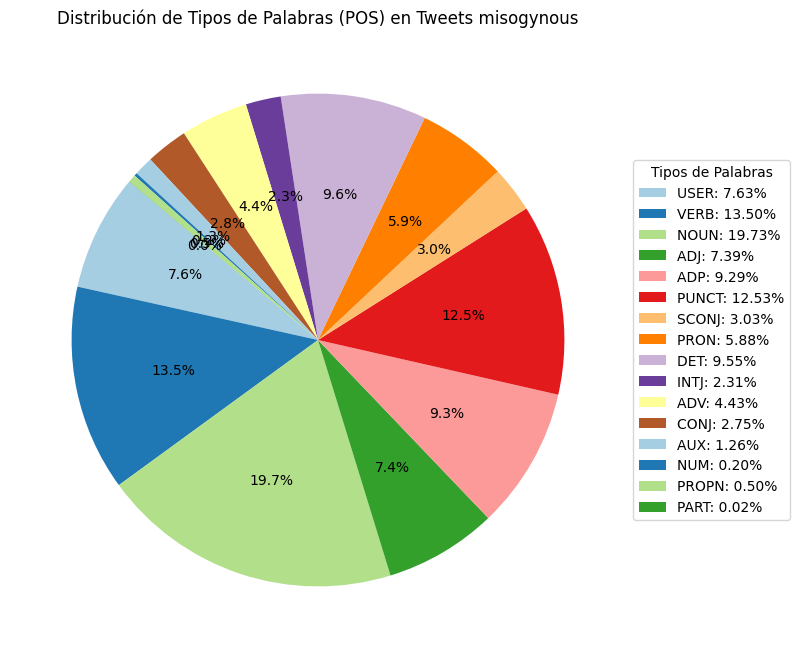

In [90]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(overall_pos_percentages_misogynous.values(),  startangle=140, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
ax.set_title("Distribución de Tipos de Palabras (POS) en Tweets misogynous")
legend_labels = [f"{pos_type}: {percentage:.2f}%" for pos_type, percentage in overall_pos_percentages_misogynous.items()]
ax.legend(wedges, legend_labels, title="Tipos de Palabras", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


-----------------------------------------------

### Tweets no misogynous

-----------------------------------------------


In [91]:
# POS en tweets no misogynous
text_not_misogynous = [text for text in df_misocorpus_train[df_misocorpus_train["label"] == 0]["tweet"].tolist()]
results_pos_not_misogynous = [analyze_pos_tags(text) for text in tqdm(text_not_misogynous)]

  0%|          | 12/2797 [00:00<00:46, 59.34it/s]

Texto analizado: @jlalarcon84 uf eso conllevaría a fregar sarten y tapadera y no se yo si me merece la pena por 2 trozos de pizza ?
Etiquetas encontradas: [('@jlalarcon84', 'USER'), ('uf', 'INTJ'), ('eso', 'PRON'), ('conllevaría', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('sarten', 'NOUN'), ('y', 'CONJ'), ('tapadera', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('se', 'VERB'), ('yo', 'PRON'), ('si', 'SCONJ'), ('me', 'PRON'), ('merece', 'VERB'), ('la', 'DET'), ('pena', 'NOUN'), ('por', 'ADP'), ('2', 'NUM'), ('trozos', 'NOUN'), ('de', 'ADP'), ('pizza', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: Yo a mi jefe: yo vuelvo al restaurante pero no a fregar platos. Disney: toma, 7 meses pa fregar que se ve que no te hemos insistido suficiente con el contrato anterior que rechazaste.
Etiquetas encontradas: [('yo', 'PRON'), ('a', 'ADP'), ('mi', 'DET'), ('jefe', 'NOUN'), (':', 'PUNCT'), ('yo', 'PRON'), ('vuelvo', 'VERB'), ('al', 'ADP'), ('restaurante', 'NOUN'), ('pero', 'CONJ'), ('no', 'INTJ'), ('a', '

  1%|          | 24/2797 [00:00<00:51, 53.92it/s]

Texto analizado: @madeinmartinez1 Yo aviso. Les digo a mis chicos, no bajéis que voy a fregar. Pues uno de mis dos hijos tiene que bajar ?
Etiquetas encontradas: [('@madeinmartinez1', 'USER'), ('yo', 'PRON'), ('aviso', 'NOUN'), ('.', 'PUNCT'), ('les', 'PRON'), ('digo', 'VERB'), ('a', 'ADP'), ('mis', 'DET'), ('chicos', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('bajéis', 'VERB'), ('que', 'SCONJ'), ('voy', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('.', 'PUNCT'), ('pues', 'SCONJ'), ('uno', 'NUM'), ('de', 'ADP'), ('mis', 'DET'), ('dos', 'NUM'), ('hijos', 'NOUN'), ('tiene', 'AUX'), ('que', 'SCONJ'), ('bajar', 'VERB'), ('?', 'PUNCT')]
Texto analizado: A fregar los platos muy fumada escuchando Hannah Montana best of both worlds
Etiquetas encontradas: [('a', 'ADP'), ('fregar', 'VERB'), ('los', 'DET'), ('platos', 'NOUN'), ('muy', 'ADV'), ('fumada', 'ADJ'), ('escuchando', 'VERB'), ('hannah', 'PROPN'), ('montana', 'NOUN'), ('best', 'ADJ'), ('of', 'ADP'), ('both', 'DET'), ('worlds', 'NOUN')]
Texto 

  1%|▏         | 36/2797 [00:00<00:49, 55.38it/s]

Texto analizado: Te das cuenta que estas vieja cuando te vas a fregar y terminas lavando la nevera
Etiquetas encontradas: [('te', 'PRON'), ('das', 'VERB'), ('cuenta', 'NOUN'), ('que', 'SCONJ'), ('estas', 'VERB'), ('vieja', 'ADJ'), ('cuando', 'SCONJ'), ('te', 'PRON'), ('vas', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('y', 'CONJ'), ('terminas', 'AUX'), ('lavando', 'VERB'), ('la', 'DET'), ('nevera', 'NOUN')]
Texto analizado: @robertbourdain1 Jajajaja todos y hasta las ? cara de tortilla que no conectan sus dos neuronas vienen a fregar con sus tweets faltos de intento cuando deberían estar corriendo en la barranca, así solo estarían estupiditos y no ? y estupiditos.??
Etiquetas encontradas: [('@robertbourdain1', 'USER'), ('jaja', 'INTJ'), ('todos', 'PRON'), ('y', 'CONJ'), ('hasta', 'ADP'), ('las', 'DET'), ('?', 'PUNCT'), ('cara', 'NOUN'), ('de', 'ADP'), ('tortilla', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('conectan', 'VERB'), ('sus', 'DET'), ('dos', 'NUM'), ('neuronas', 'NOUN'), ('viene

  2%|▏         | 42/2797 [00:00<00:49, 55.64it/s]

Texto analizado: Pero vas a fregar con esta http://t.co/ http://t.co/
Etiquetas encontradas: [('pero', 'CONJ'), ('vas', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('con', 'ADP'), ('esta', 'PRON'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: estoy en la cocina buscando una playlist bien chingona para ponerme a fregar porque EN ESTA CASA NADIE SIRVE PARA UNA VERGA COÑOELAMADREMEQUIEROIR DESESTAMIERDA
Etiquetas encontradas: [('estoy', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('cocina', 'NOUN'), ('buscando', 'VERB'), ('una', 'DET'), ('playlist', 'NOUN'), ('bien', 'ADV'), ('chingona', 'ADJ'), ('para', 'ADP'), ('ponerme', 'PRON'), ('a', 'ADP'), ('fregar', 'VERB'), ('porque', 'SCONJ'), ('en', 'ADP'), ('esta', 'DET'), ('casa', 'NOUN'), ('nadie', 'PRON'), ('sirve', 'VERB'), ('para', 'ADP'), ('una', 'DET'), ('verga', 'NOUN'), ('coñoelamadremequieroir', 'INTJ'), ('desestamierda', 'ADP')]
Texto analizado: “¿Cómo pueden dar espacio a una mocosa?” así se refirió Bolsonaro a Greta Thunberg http

  2%|▏         | 54/2797 [00:00<00:52, 52.75it/s]

Texto analizado: @observatorio14 @untipoalto Vaya puta cortina de humo para desviar la atención y hacernos culpables a nuestra generación educandonos a reciclar y mientras los petrodólares decojonandose mientras controlan patentes y soluciones que no verán la luz por la codicia de unos pocos. Pobre Greta.
Etiquetas encontradas: [('@observatorio14', 'USER'), ('@untipoalto', 'USER'), ('vaya', 'ADJ'), ('puta', 'ADJ'), ('cortina', 'NOUN'), ('de', 'ADP'), ('humo', 'NOUN'), ('para', 'ADP'), ('desviar', 'VERB'), ('la', 'DET'), ('atención', 'NOUN'), ('y', 'CONJ'), ('hacernos', 'PRON'), ('culpables', 'NOUN'), ('a', 'ADP'), ('nuestra', 'DET'), ('generación', 'NOUN'), ('educandonos', 'VERB'), ('a', 'ADP'), ('reciclar', 'VERB'), ('y', 'CONJ'), ('mientras', 'SCONJ'), ('los', 'DET'), ('petrodólares', 'NOUN'), ('decojonandose', 'VERB'), ('mientras', 'SCONJ'), ('controlan', 'VERB'), ('patentes', 'NOUN'), ('y', 'CONJ'), ('soluciones', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('verán', 'VERB'), ('la', '

  2%|▏         | 66/2797 [00:01<00:49, 55.03it/s]

Texto analizado: @ewquijada @Farideraful Cuando tu le dices a tus hijos menores de edad que el varón puede tener 5 novias en la escuela, pero la hembra que NO se atreva a tener ni siquiera 1, estás educando en machismo. Cuando mandas a la niña a fregar y al niño a jugar, estás educando en machismo. ¿Quieres más?
Etiquetas encontradas: [('@ewquijada', 'USER'), ('@farideraful', 'USER'), ('cuando', 'SCONJ'), ('tu', 'DET'), ('le', 'PRON'), ('dices', 'VERB'), ('a', 'ADP'), ('tus', 'DET'), ('hijos', 'NOUN'), ('menores', 'ADJ'), ('de', 'ADP'), ('edad', 'NOUN'), ('que', 'SCONJ'), ('el', 'DET'), ('varón', 'NOUN'), ('puede', 'AUX'), ('tener', 'VERB'), ('5', 'NUM'), ('novias', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('escuela', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('la', 'DET'), ('hembra', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('atreva', 'VERB'), ('a', 'ADP'), ('tener', 'VERB'), ('ni', 'ADV'), ('siquiera', 'ADV'), ('1', 'PRON'), (',', 'PUNCT'), ('estás', 'VERB'), ('educand

  3%|▎         | 78/2797 [00:01<00:49, 55.10it/s]

Texto analizado: ?????? Greta responde a Bolsonaro. Él me dijo mocosa. Ella agrega la palabra en su bio de TW. Ella condenó la muerte de ambientalistas indígenas de la Amazonia. A él le quedó el saco. http://t.co/
Etiquetas encontradas: [('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('greta', 'NOUN'), ('responde', 'VERB'), ('a', 'ADP'), ('bolsonaro', 'NOUN'), ('.', 'PUNCT'), ('él', 'PRON'), ('me', 'PRON'), ('dijo', 'VERB'), ('mocosa', 'NOUN'), ('.', 'PUNCT'), ('ella', 'PRON'), ('agrega', 'VERB'), ('la', 'DET'), ('palabra', 'NOUN'), ('en', 'ADP'), ('su', 'DET'), ('bio', 'NOUN'), ('de', 'ADP'), ('tw', 'NOUN'), ('.', 'PUNCT'), ('ella', 'PRON'), ('condenó', 'VERB'), ('la', 'DET'), ('muerte', 'NOUN'), ('de', 'ADP'), ('ambientalistas', 'NOUN'), ('indígenas', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('amazonia', 'NOUN'), ('.', 'PUNCT'), ('a', 'ADP'), ('él', 'PRON'), ('le', 'PRON'), ('quedó', 'VERB'), ('el', 'DET'), ('saco', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: -Me la pe

  3%|▎         | 90/2797 [00:01<00:51, 52.29it/s]

Texto analizado: @Migalcaher @LoreRecabarrenS que plata mal gastada 4 apariciones y solo para refutar los informes contundentes de @hrw_espanol @AmnistiaOnline @ComisionChilena @ONU_derechos sobre violaciones de los DDHH por parte del @GobiernodeChile y @Carabdechile hacia el pueblo Chileno @dw_espanol
Etiquetas encontradas: [('@migalcaher', 'USER'), ('@lorerecabarrens', 'USER'), ('que', 'SCONJ'), ('plata', 'NOUN'), ('mal', 'ADV'), ('gastada', 'VERB'), ('4', 'DET'), ('apariciones', 'NOUN'), ('y', 'CONJ'), ('solo', 'ADV'), ('para', 'ADP'), ('refutar', 'VERB'), ('los', 'DET'), ('informes', 'NOUN'), ('contundentes', 'ADJ'), ('de', 'ADP'), ('@hrw_espanol', 'USER'), ('@amnistiaonline', 'USER'), ('@comisionchilena', 'USER'), ('@onu_derechos', 'USER'), ('sobre', 'ADP'), ('violaciones', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('ddhh', 'NOUN'), ('por', 'ADP'), ('parte', 'NOUN'), ('del', 'ADP'), ('@gobiernodechile', 'USER'), ('y', 'CONJ'), ('@carabdechile', 'USER'), ('hacia', 'ADP'), ('el', 'DET

  4%|▎         | 102/2797 [00:01<00:50, 53.14it/s]

Texto analizado: @OfeFernandez_ @Mariano_Villa Tampoco lloran y tiemblan, tampoco tantoo.. El hacer un chiste de mal gusto no te hace violador
Etiquetas encontradas: [('@ofefernandez', 'USER'), ('_', 'PUNCT'), ('@mariano_villa', 'USER'), ('tampoco', 'ADV'), ('lloran', 'VERB'), ('y', 'CONJ'), ('tiemblan', 'VERB'), (',', 'PUNCT'), ('tampoco', 'ADV'), ('tantoo', 'ADV'), ('..', 'PUNCT'), ('el', 'DET'), ('hacer', 'VERB'), ('un', 'DET'), ('chiste', 'NOUN'), ('de', 'ADP'), ('mal', 'ADJ'), ('gusto', 'NOUN'), ('no', 'ADV'), ('te', 'PRON'), ('hace', 'VERB'), ('violador', 'NOUN')]
Texto analizado: El Gobierno Nacional conoció el caso Furukawa en 2018. Hasta hoy ha tolerado que la empresa opere en impunidad. Demandamos la violación a los #DDHH de miles de personas sometidas a #EsclavitudModerna y exigimos #JusticiaYReparación #FurukawaNuncaMas @mariapaularomo @CecyChaconC http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('gobierno', 'NOUN'), ('nacional', 'ADJ'), ('conoció', 'VERB'), ('el', 'DET

  4%|▍         | 114/2797 [00:02<00:49, 54.74it/s]

Texto analizado: La reacción al caso de la Arandina me reafirma en algo que ya sabía. La derecha es capaz de mover sus "principios" lo que haga falta (en este caso justificar la violación de menores) con tal de defender sus verdaderos principios: su "derecho" a robar, violar y matar.
Etiquetas encontradas: [('la', 'DET'), ('reacción', 'NOUN'), ('al', 'ADP'), ('caso', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('me', 'PRON'), ('reafirma', 'VERB'), ('en', 'ADP'), ('algo', 'PRON'), ('que', 'SCONJ'), ('ya', 'ADV'), ('sabía', 'VERB'), ('.', 'PUNCT'), ('la', 'DET'), ('derecha', 'NOUN'), ('es', 'VERB'), ('capaz', 'ADJ'), ('de', 'ADP'), ('mover', 'VERB'), ('sus', 'DET'), ('"', 'PUNCT'), ('principios', 'NOUN'), ('"', 'PUNCT'), ('lo', 'DET'), ('que', 'PRON'), ('haga', 'VERB'), ('falta', 'NOUN'), ('(', 'PUNCT'), ('en', 'ADP'), ('este', 'DET'), ('caso', 'NOUN'), ('justificar', 'VERB'), ('la', 'DET'), ('violación', 'NOUN'), ('de', 'ADP'), ('menores', 'NOUN'), (')', 'PUNCT'), ('con

  4%|▍         | 120/2797 [00:02<00:57, 46.18it/s]

Texto analizado: #Actualidad | Gretus amargatus: Frank Cuesta se burla de Greta Thunberg en un vídeo y recibe numerosas críticas ➡ El vídeo se titulaba “Los cinco bichos más raros que he tocado” y salió disfrazado de la joven sueca. Te lo cuenta @Sr_Nolito aquí http://t.co/ http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('actualidad', 'ADJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('gretus', 'ADJ'), ('amargatus', 'NOUN'), (':', 'PUNCT'), ('frank', 'INTJ'), ('cuesta', 'NOUN'), ('se', 'PRON'), ('burla', 'ADJ'), ('de', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('un', 'DET'), ('vídeo', 'NOUN'), ('y', 'CONJ'), ('recibe', 'VERB'), ('numerosas', 'ADJ'), ('críticas', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'PROPN'), ('flecha_hacia_la_derecha|', 'ADJ'), ('el', 'DET'), ('vídeo', 'NOUN'), ('se', 'PRON'), ('titulaba', 'VERB'), ('"', 'PUNCT'), ('los', 'DET'), ('cinco', 'NUM'), ('bichos', 'NOUN'), ('más', 'ADV'), ('raros', 'ADJ'), ('que', 'SCONJ'), ('he', 'AUX')

  5%|▍         | 130/2797 [00:02<01:07, 39.70it/s]

Texto analizado: El polémico tuit de Cristina Seguí que defendió la inocencia de los violadores del 'caso Arandina' http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('polémico', 'ADJ'), ('tuit', 'NOUN'), ('de', 'ADP'), ('cristina', 'NOUN'), ('seguí', 'VERB'), ('que', 'SCONJ'), ('defendió', 'VERB'), ('la', 'DET'), ('inocencia', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('violadores', 'NOUN'), ('del', 'ADP'), ("'", 'PUNCT'), ('caso', 'NOUN'), ('arandina', 'ADJ'), ("'", 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @gabrielboric Si se habla de colaboración activa, como dice @Diego_Schalper , en materia de violación de derechos humanos, no es para sentirse orgulloso de ello porque eso supone que hay un problema grave de convivencia que ha llevado al Estado a atropellar los derechos de la gente.
Etiquetas encontradas: [('@gabrielboric', 'USER'), ('si', 'SCONJ'), ('se', 'PRON'), ('habla', 'VERB'), ('de', 'ADP'), ('colaboración', 'NOUN'), ('activa', 'ADJ'), (',', 'PUNCT'), ('como', 'ADV'), ('

  5%|▌         | 145/2797 [00:02<00:50, 53.03it/s]

Texto analizado: @JeanineAnez @DemocratasBo O Lo van a fregar todo el esfuerzo del pueblo
Etiquetas encontradas: [('@jeanineanez', 'USER'), ('@democratasbo', 'USER'), ('o', 'CONJ'), ('lo', 'PRON'), ('van', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('todo', 'DET'), ('el', 'DET'), ('esfuerzo', 'NOUN'), ('del', 'ADP'), ('pueblo', 'NOUN')]
Texto analizado: @PatricioJDiaz @DelfinSC Para que aprendas que nos nos da urticaria de nada con Valencia . Y ojalá acepten que por lo único que se va a fregar los ojos el Esteban Paz es por haber contratado a Valencia
Etiquetas encontradas: [('@patriciojdiaz', 'USER'), ('@delfinsc', 'USER'), ('para', 'ADP'), ('que', 'SCONJ'), ('aprendas', 'VERB'), ('que', 'SCONJ'), ('nos', 'PRON'), ('nos', 'PRON'), ('da', 'VERB'), ('urticaria', 'NOUN'), ('de', 'ADP'), ('nada', 'PRON'), ('con', 'ADP'), ('valencia', 'PROPN'), ('.', 'PUNCT'), ('y', 'CONJ'), ('ojalá', 'INTJ'), ('acepten', 'VERB'), ('que', 'SCONJ'), ('por', 'ADP'), ('lo', 'DET'), ('único', 'ADJ'), ('que', 'S

  6%|▌         | 164/2797 [00:03<00:37, 70.60it/s]

Texto analizado: @NooeeeD8 El violador eres tú
Etiquetas encontradas: [('@nooeeed8', 'USER'), ('el', 'DET'), ('violador', 'NOUN'), ('eres', 'VERB'), ('tú', 'PRON')]
Texto analizado: Joven en Argentina se disfraza de "víctima de feminicidio" en su graduación http://t.co/ http://t.co/
Etiquetas encontradas: [('joven', 'NOUN'), ('en', 'ADP'), ('argentina', 'NOUN'), ('se', 'PRON'), ('disfraza', 'VERB'), ('de', 'ADP'), ('"', 'PUNCT'), ('víctima', 'NOUN'), ('de', 'ADP'), ('feminicidio', 'NOUN'), ('"', 'PUNCT'), ('en', 'ADP'), ('su', 'DET'), ('graduación', 'NOUN'), ('url/', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @lore_moyaa La querian espiar jovencita...drone violador ese
Etiquetas encontradas: [('@lore_moyaa', 'USER'), ('la', 'PRON'), ('querian', 'VERB'), ('espiar', 'VERB'), ('jovencita', 'NOUN'), ('...', 'PUNCT'), ('drone', 'NOUN'), ('violador', 'NOUN'), ('ese', 'PRON')]
Texto analizado: @glezpik Y es curioso, ¿no? Porque los argumentos contra el feminismo siempre son Not All Men, per

  7%|▋         | 182/2797 [00:03<00:33, 78.03it/s]

Texto analizado: Hoy me desperté con que un ardido bobo hijueputa me metió dizque en una lista de feminazis JAJAJAJAJAJAJAJAJAJA ¿Le dicen ustedes o le digo yo? JAJAJAJAJAJAJAJ
Etiquetas encontradas: [('hoy', 'ADV'), ('me', 'PRON'), ('desperté', 'VERB'), ('con', 'ADP'), ('que', 'SCONJ'), ('un', 'DET'), ('ardido', 'ADJ'), ('bobo', 'ADJ'), ('hijueputa', 'NOUN'), ('me', 'PRON'), ('metió', 'VERB'), ('dizque', 'ADV'), ('en', 'ADP'), ('una', 'DET'), ('lista', 'NOUN'), ('de', 'ADP'), ('feminazis', 'NOUN'), ('jaja', 'INTJ'), ('¿', 'PUNCT'), ('le', 'PRON'), ('dicen', 'VERB'), ('ustedes', 'PRON'), ('o', 'CONJ'), ('le', 'PRON'), ('digo', 'VERB'), ('yo', 'PRON'), ('?', 'PUNCT'), ('jaja', 'INTJ')]
Texto analizado: Acá esperamos un feminicidio más para recién actuar, para que las autoridades se movilicen, den castigos y luego para qué, volver a lo mismo... Edúcate amigo machito, no te sientas ofendido cuando te dicen el violador eres tú y tildes de feminazis a quienes luchan por un cambio http://t.c

  7%|▋         | 201/2797 [00:03<00:30, 84.07it/s]

Texto analizado: ¿Cómo va su cena tóxica? ¿Ya hablaron del feminismo y de la comunidad LGBT y sus tíos conservadores escupieron ignorancia?
Etiquetas encontradas: [('¿', 'PUNCT'), ('cómo', 'ADV'), ('va', 'VERB'), ('su', 'DET'), ('cena', 'NOUN'), ('tóxica', 'ADJ'), ('?', 'PUNCT'), ('¿', 'PUNCT'), ('ya', 'ADV'), ('hablaron', 'VERB'), ('del', 'ADP'), ('feminismo', 'NOUN'), ('y', 'CONJ'), ('de', 'ADP'), ('la', 'DET'), ('comunidad', 'NOUN'), ('lgbt', 'ADJ'), ('y', 'CONJ'), ('sus', 'DET'), ('tíos', 'NOUN'), ('conservadores', 'ADJ'), ('escupieron', 'VERB'), ('ignorancia', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: los avances del feminismo xd http://t.co/
Etiquetas encontradas: [('los', 'DET'), ('avances', 'NOUN'), ('del', 'ADP'), ('feminismo', 'NOUN'), ('xd', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: #Internacional | “Es impresionante que la prensa le dé espacio a una mocosa como ella” Así se refirió el presidente brasileño @jairbolsonaro a @GretaThunberg, luego de que la activista sueca co

  8%|▊         | 219/2797 [00:03<00:30, 83.18it/s]

Texto analizado: @LeonorBohme Aquí queda más que claro que el feminismo y el apoyo del género termina cuando piensas diferente al resto, no hay una "unidad" de género común, se llenan la boca con el "ni una menos" o con el "violador en tu camino", 0ero claro, piensas diferente y te quieren linchar
Etiquetas encontradas: [('@leonorbohme', 'USER'), ('aquí', 'ADV'), ('queda', 'VERB'), ('más', 'ADV'), ('que', 'SCONJ'), ('claro', 'ADJ'), ('que', 'SCONJ'), ('el', 'DET'), ('feminismo', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('apoyo', 'NOUN'), ('del', 'ADP'), ('género', 'NOUN'), ('termina', 'VERB'), ('cuando', 'SCONJ'), ('piensas', 'VERB'), ('diferente', 'ADJ'), ('al', 'ADP'), ('resto', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('hay', 'VERB'), ('una', 'DET'), ('"', 'PUNCT'), ('unidad', 'NOUN'), ('"', 'PUNCT'), ('de', 'ADP'), ('género', 'NOUN'), ('común', 'ADJ'), (',', 'PUNCT'), ('se', 'PRON'), ('llenan', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('"', 'PUNCT'), ('

  9%|▊         | 238/2797 [00:03<00:29, 87.58it/s]

Texto analizado: #LoMásLeído Alfonso Ussía y una fundadora de VOX difunden datos personales de la víctima del Arandina http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('lomásleído', 'PRON'), ('alfonso', 'PROPN'), ('ussía', 'NOUN'), ('y', 'CONJ'), ('una', 'DET'), ('fundadora', 'NOUN'), ('de', 'ADP'), ('vox', 'NOUN'), ('difunden', 'VERB'), ('datos', 'NOUN'), ('personales', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('víctima', 'NOUN'), ('del', 'ADP'), ('arandina', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Yo jamás podría ser feminazi, a mí sí me gusta que me peguen, me ahorquen, me muerdan, me insulten ... Lo siento les eh fallado
Etiquetas encontradas: [('yo', 'PRON'), ('jamás', 'ADV'), ('podría', 'VERB'), ('ser', 'VERB'), ('feminazi', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('mí', 'PRON'), ('sí', 'INTJ'), ('me', 'PRON'), ('gusta', 'VERB'), ('que', 'SCONJ'), ('me', 'PRON'), ('peguen', 'VERB'), (',', 'PUNCT'), ('me', 'PRON'), ('ahorquen', 'VERB'), (',', 'PUNCT'), ('me', 'PRON'), ('

  9%|▉         | 257/2797 [00:04<00:28, 88.87it/s]

Texto analizado: @MMagan82 El feminismo del siglo XXI. http://t.co/
Etiquetas encontradas: [('@mmagan82', 'USER'), ('el', 'DET'), ('feminismo', 'NOUN'), ('del', 'ADP'), ('siglo', 'NOUN'), ('xxi', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @alfonsvarela No sé si es el rugby lo que les pudre el cerebro, quiero creer q no pq estoy a favor del deporte. Pero tmp te vengas a hacer el piola diciéndole a una mina como vivir su feminismo. La desconstrucción es para todxs, para vos y para ellas. Si te burlas entras en un círculo d mierda
Etiquetas encontradas: [('@alfonsvarela', 'USER'), ('no', 'ADV'), ('sé', 'VERB'), ('si', 'SCONJ'), ('es', 'VERB'), ('el', 'DET'), ('rugby', 'NOUN'), ('lo', 'PRON'), ('que', 'PRON'), ('les', 'PRON'), ('pudre', 'VERB'), ('el', 'DET'), ('cerebro', 'NOUN'), (',', 'PUNCT'), ('quiero', 'VERB'), ('creer', 'VERB'), ('q', 'SCONJ'), ('no', 'INTJ'), ('pq', 'SCONJ'), ('estoy', 'VERB'), ('a', 'ADP'), ('favor', 'NOUN'), ('del', 'ADP'), ('deporte', 'NOUN'), ('

 10%|▉         | 276/2797 [00:04<00:28, 88.95it/s]

Texto analizado: Greta Thunberg viendo como soy un idiota empacando regalos y desperdicio mucho papel http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('thunberg', 'NOUN'), ('viendo', 'VERB'), ('como', 'SCONJ'), ('soy', 'VERB'), ('un', 'DET'), ('idiota', 'ADJ'), ('empacando', 'VERB'), ('regalos', 'NOUN'), ('y', 'CONJ'), ('desperdicio', 'VERB'), ('mucho', 'ADJ'), ('papel', 'NOUN'), ('url/', 'ADV')]
Texto analizado: Ya está bien de esta estupida cancel culture de perfección moral. A mi me la suda su vida privada y lo que haga aparte de la audiencia, seguiré viendo las películas de Greta Thun... De Woody Allen.
Etiquetas encontradas: [('ya', 'ADV'), ('está', 'VERB'), ('bien', 'ADV'), ('de', 'ADP'), ('esta', 'DET'), ('estupida', 'ADJ'), ('cancel', 'NOUN'), ('culture', 'NOUN'), ('de', 'ADP'), ('perfección', 'NOUN'), ('moral', 'ADJ'), ('.', 'PUNCT'), ('a', 'ADP'), ('mi', 'DET'), ('me', 'PRON'), ('la', 'PRON'), ('suda', 'VERB'), ('su', 'DET'), ('vida', 'NOUN'), ('privada', 'ADJ'), ('y'

 11%|█         | 295/2797 [00:04<00:27, 90.56it/s]

Texto analizado: Bolsonaro llama “mocosa” a Greta Thunberg http://t.co/ vía @24matins_es #10Dic #Noticias
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('llama', 'VERB'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('url/', 'PUNCT'), ('vía', 'ADP'), ('@24matins_es', 'USER'), ('hashtag', 'NOUN'), ('10dic', 'NOUN'), ('hashtag', 'NOUN'), ('noticias', 'NOUN')]
Texto analizado: Avisenle a @jairbolsonaro quién está en la Revista @time hoy ? Jair Bolsonaro llamó “mocosa” a Greta Thunberg: la reacción de la activista - Infobae http://t.co/
Etiquetas encontradas: [('avisenle', 'VERB'), ('a', 'ADP'), ('@jairbolsonaro', 'USER'), ('quién', 'PRON'), ('está', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('revista', 'NOUN'), ('@time', 'USER'), ('hoy', 'ADV'), ('?', 'PUNCT'), ('jair', 'PROPN'), ('bolsonaro', 'NOUN'), ('llamó', 'VERB'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), (':

 11%|█         | 314/2797 [00:04<00:28, 87.68it/s]

Texto analizado: Cuando vamos a sacarnos esos términos de mierda para calificar a las mujeres?! Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg | Tecnología | EL PAÍS http://t.co/
Etiquetas encontradas: [('cuando', 'ADV'), ('vamos', 'AUX'), ('a', 'ADP'), ('sacarnos', 'VERB'), ('esos', 'DET'), ('términos', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ('para', 'ADP'), ('calificar', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), ('?', 'PUNCT'), ('!', 'PUNCT'), ('histérica', 'ADJ'), (',', 'PUNCT'), ('puta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('los', 'DET'), ('hombres', 'NOUN'), ('españoles', 'NOUN'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'DET'), (' ', 'PUNCT'), ('tecnología', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'PUNCT'), (' ', 'PUNCT'), ('el', 'DET'), ('país', 'NOUN'), ('url/', 'NOUN')]
Texto

 12%|█▏        | 324/2797 [00:04<00:27, 88.67it/s]

Texto analizado: Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter http://t.co/ via @elpais_tec
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('marioneta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('hombres', 'NOUN'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('url/', 'PUNCT'), ('via', 'ADP'), ('@elpais_tec', 'USER')]
Texto analizado: Bolsonaro sorprendido por lo mediática que es Greta y la tilda de «mocosa» http://t.co/
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('sorprendido', 'ADJ'), ('por', 'ADP'), ('lo', 'DET'), ('mediática', 'ADJ'), ('que', 'PRON'), ('es', 'VERB'), ('greta', 'NOUN'), ('y', 'CONJ'), ('la', 'PRON'), ('tilda', 'VERB'), ('de', 'ADP'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('url/', 'ADJ')]
Texto analizado: “Es impresionante que la prensa le dé espa

 12%|█▏        | 343/2797 [00:05<00:28, 86.67it/s]

Texto analizado: @el_pais Muy fuerte pero a ver si por aqui tanto Eguren como Del Rio y Cipriani tomen esa decision fatal y harian bien a la Curia Catolica lleno de Pederastas, violadores y los mencionados los defiende, sobre todo a los del Sodalicio que tienen una mochila pesada
Etiquetas encontradas: [('@el_pais', 'USER'), ('muy', 'ADV'), ('fuerte', 'ADJ'), ('pero', 'CONJ'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('por', 'ADP'), ('aqui', 'ADV'), ('tanto', 'DET'), ('eguren', 'NOUN'), ('como', 'CONJ'), ('del', 'ADP'), ('rio', 'NOUN'), ('y', 'CONJ'), ('cipriani', 'NOUN'), ('tomen', 'VERB'), ('esa', 'DET'), ('decision', 'NOUN'), ('fatal', 'ADJ'), ('y', 'CONJ'), ('harian', 'VERB'), ('bien', 'ADV'), ('a', 'ADP'), ('la', 'DET'), ('curia', 'NOUN'), ('catolica', 'ADJ'), ('lleno', 'ADJ'), ('de', 'ADP'), ('pederastas', 'NOUN'), (',', 'PUNCT'), ('violadores', 'NOUN'), ('y', 'CONJ'), ('los', 'DET'), ('mencionados', 'ADJ'), ('los', 'PRON'), ('defiende', 'VERB'), (',', 'PUNCT'), ('sobre', 

 13%|█▎        | 360/2797 [00:05<00:33, 73.77it/s]

Texto analizado: @monasterioR Cállate anda que no has visto una puta película.
Etiquetas encontradas: [('@monasterior', 'USER'), ('cállate', 'VERB'), ('anda', 'INTJ'), ('que', 'SCONJ'), ('no', 'ADV'), ('has', 'AUX'), ('visto', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('película', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas QUE HIJO DE LA GRAN PUTA! PERO NO PODRANNNNNNNNNNNNNNNNNNNNNNNNNNN!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('que', 'SCONJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('!', 'PUNCT'), ('pero', 'CONJ'), ('no', 'ADV'), ('podrannn', 'VERB'), ('!', 'PUNCT')]
Texto analizado: @Irene_Montero_ La propia Isabel Serra dirigiéndose a una agente de la Policía Municipal le gritó "eres una cocainómana", "mala madre, hija de puta, con todo los que hemos luchado las mujeres contigo se pierde todo, no te quieren ni tus propios compañeros".
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('la', 'DE

 13%|█▎        | 376/2797 [00:05<00:34, 70.28it/s]

Texto analizado: @monasterioR @julia_otero "A los que tienen el toro". No has pisado un prau en la puta vida. Urbanita.
Etiquetas encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('"', 'PUNCT'), ('a', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('tienen', 'VERB'), ('el', 'DET'), ('toro', 'NOUN'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('no', 'ADV'), ('has', 'AUX'), ('pisado', 'VERB'), ('un', 'DET'), ('prau', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('vida', 'NOUN'), ('.', 'PUNCT'), ('urbanita', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @InesArrimadas Anda, pero todavía existí? ???. Los españoles como tú dices, ya os pusieron donde estáis, osea en la Puta irrelevancia. Ale a seguir echando bilis. ???
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('anda', 'VERB'), (',', 'PUNCT'), ('pero', 'CONJ'), ('todavía', 'ADV'), ('existí', 'VERB'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('.', 'PUNCT'), ('los', 'DET'), ('españoles', 'NOUN'), ('como

 14%|█▎        | 384/2797 [00:05<00:36, 66.08it/s]

Texto analizado: @Irene_Montero_ Pacifismo es llamar “hijos de puta, asesinos, vergüenza me daría ser policía…”.también lanzamiento de botellas, piedras, adoquines, tiestos, macetas, “y otros objetos contundentes como papeleras”. Pero lo importante es que la policía es una MUJER y hoy ya no toca el #YoSiTeCreo
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('pacifismo', 'NOUN'), ('es', 'VERB'), ('llamar', 'VERB'), ('"', 'PUNCT'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('asesinos', 'NOUN'), (',', 'PUNCT'), ('vergüenza', 'NOUN'), ('me', 'PRON'), ('daría', 'VERB'), ('ser', 'VERB'), ('policía".también', 'NOUN'), ('lanzamiento', 'NOUN'), ('de', 'ADP'), ('botellas', 'NOUN'), (',', 'PUNCT'), ('piedras', 'NOUN'), (',', 'PUNCT'), ('adoquines', 'NOUN'), (',', 'PUNCT'), ('tiestos', 'NOUN'), (',', 'PUNCT'), ('macetas', 'NOUN'), (',', 'PUNCT'), ('"', 'PUNCT'), ('y', 'CONJ'), ('otros', 'DET'), ('objetos', 'NOUN'), ('contundentes', 'ADJ'), ('como', 'A

 14%|█▍        | 398/2797 [00:05<00:36, 65.94it/s]

Texto analizado: ...l@s negacionistas comenzaron negando la violència entre hombres por razon de raza lengua, cultura o condicion sexual, se ha acabado con dale tu tambien, haberselo devuelto, con él si nadie ha visto nada para que vas a denunci…http://t.co/ http://t.co/
Etiquetas encontradas: [('...', 'PUNCT'), ('l@s', 'DET'), ('negacionistas', 'NOUN'), ('comenzaron', 'VERB'), ('negando', 'VERB'), ('la', 'DET'), ('violència', 'NOUN'), ('entre', 'ADP'), ('hombres', 'NOUN'), ('por', 'ADP'), ('razon', 'NOUN'), ('de', 'ADP'), ('raza', 'NOUN'), ('lengua', 'NOUN'), (',', 'PUNCT'), ('cultura', 'NOUN'), ('o', 'CONJ'), ('condicion', 'NOUN'), ('sexual', 'ADJ'), (',', 'PUNCT'), ('se', 'PRON'), ('ha', 'AUX'), ('acabado', 'VERB'), ('con', 'ADP'), ('dale', 'PRON'), ('tu', 'DET'), ('tambien', 'ADV'), (',', 'PUNCT'), ('haberselo', 'VERB'), ('devuelto', 'VERB'), (',', 'PUNCT'), ('con', 'ADP'), ('él', 'PRON'), ('si', 'SCONJ'), ('nadie', 'PRON'), ('ha', 'AUX'), ('visto', 'VERB'), ('nada', 'PRON'), ('par

 15%|█▍        | 412/2797 [00:06<00:35, 67.01it/s]

Texto analizado: Medio millar de feministas se desplazan hasta Aranda de Duero para mostrar su apoyo a la víctima de la Arandina http://t.co/ Lo cuenta @albarakatapun http://t.co/
Etiquetas encontradas: [('medio', 'NUM'), ('millar', 'NOUN'), ('de', 'ADP'), ('feministas', 'NOUN'), ('se', 'PRON'), ('desplazan', 'VERB'), ('hasta', 'ADP'), ('aranda', 'NOUN'), ('de', 'ADP'), ('duero', 'NOUN'), ('para', 'ADP'), ('mostrar', 'VERB'), ('su', 'DET'), ('apoyo', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('víctima', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('url/', 'PROPN'), ('lo', 'PRON'), ('cuenta', 'VERB'), ('@albarakatapun', 'USER'), ('url/', 'PROPN')]
Texto analizado: Unidas Podemos denuncia ante la Fiscalía a Cristina Seguí y a Alfonso Ussía por difundir los audios de la víctima de la Arandina http://t.co/
Etiquetas encontradas: [('unidas', 'ADJ'), ('podemos', 'PRON'), ('denuncia', 'VERB'), ('ante', 'ADP'), ('la', 'DET'), ('fiscalía', 'NOUN'), ('a', 'ADP'), ('cristina', 'PROPN

 15%|█▌        | 428/2797 [00:06<00:33, 70.16it/s]

Texto analizado: @InesArrimadas Y tú puta madre de donde es ? Hijo de puta
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('y', 'CONJ'), ('tú', 'PRON'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('de', 'ADP'), ('donde', 'ADV'), ('es', 'VERB'), ('?', 'PUNCT'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN')]
Texto analizado: @cayetanaAT Caye... No tienes ni puta idea. Tu a lo tuyo, a seguir metiendo cizaña en Cataluña. No sabes ni donde esta León.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('caye', 'VERB'), ('...', 'PUNCT'), ('no', 'ADV'), ('tienes', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), ('.', 'PUNCT'), ('tu', 'DET'), ('a', 'ADP'), ('lo', 'DET'), ('tuyo', 'ADJ'), (',', 'PUNCT'), ('a', 'ADP'), ('seguir', 'VERB'), ('metiendo', 'VERB'), ('cizaña', 'NOUN'), ('en', 'ADP'), ('cataluña', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('sabes', 'VERB'), ('ni', 'ADV'), ('donde', 'ADP'), ('esta', 'DET'), ('león', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras @isaserra

 16%|█▌        | 443/2797 [00:06<00:35, 65.87it/s]

Texto analizado: #LoMásLeído Rubén Sánchez ofrece las pruebas a la víctima del Arandina para denunciar a Ussía http://t.co/
Etiquetas encontradas: [('hashtag', 'INTJ'), ('lomásleído', 'PRON'), ('rubén', 'NOUN'), ('sánchez', 'PROPN'), ('ofrece', 'VERB'), ('las', 'DET'), ('pruebas', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('víctima', 'NOUN'), ('del', 'ADP'), ('arandina', 'NOUN'), ('para', 'ADP'), ('denunciar', 'VERB'), ('a', 'ADP'), ('ussía', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: @abc_es Una golfilla se lia con tres golfos, a ella la indemnizan y a ellos les caen 38 años. Podria ser un delito de abuso sexual, ya que ella es menor de 16 años, pero no de agresion sexual habiendo tantas evidencias de que la chica estaba de acuerdo.
Etiquetas encontradas: [('@abc_es', 'USER'), ('una', 'DET'), ('golfilla', 'NOUN'), ('se', 'PRON'), ('lia', 'VERB'), ('con', 'ADP'), ('tres', 'NUM'), ('golfos', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('ella', 'PRON'), ('la', 'PRON'), ('indemnizan', 'VERB'), ('

 16%|█▋        | 457/2797 [00:06<00:38, 60.17it/s]

Texto analizado: @leslieyyyy Porque en la de los de Arandina no hay pruebas de la violación y en esta si, y a los otros 38 años y a esta nada...pero vamos, no conviene darle bulo en los medios ??
Etiquetas encontradas: [('@leslieyyy', 'USER'), ('porque', 'SCONJ'), ('en', 'ADP'), ('la', 'DET'), ('de', 'ADP'), ('los', 'DET'), ('de', 'ADP'), ('arandina', 'NOUN'), ('no', 'ADV'), ('hay', 'VERB'), ('pruebas', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('violación', 'NOUN'), ('y', 'CONJ'), ('en', 'ADP'), ('esta', 'PRON'), ('si', 'SCONJ'), (',', 'PUNCT'), ('y', 'CONJ'), ('a', 'ADP'), ('los', 'DET'), ('otros', 'DET'), ('38', 'ADJ'), ('años', 'NOUN'), ('y', 'CONJ'), ('a', 'ADP'), ('esta', 'PRON'), ('nada', 'PRON'), ('...', 'PUNCT'), ('pero', 'CONJ'), ('vamos', 'INTJ'), (',', 'PUNCT'), ('no', 'ADV'), ('conviene', 'VERB'), ('darle', 'PRON'), ('bulo', 'NOUN'), ('en', 'ADP'), ('los', 'DET'), ('medios', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @juanrga @felixregueiro1 @ManuelVilas2 @Gira

 17%|█▋        | 464/2797 [00:06<00:40, 57.81it/s]

Texto analizado: Los 3 jovenes del caso Arandina: -&gt; 38 años de carcel cada uno Caso de Rodrigo Lanza que asesinó a una persona a puñetazos y patadas, siendo reincidente (había dejado tetrapléjico a un policia con anterioridad) -&gt; 5 años de carcel Que alguien me lo explique. Justicia española
Etiquetas encontradas: [('los', 'DET'), ('3', 'NUM'), ('jovenes', 'NOUN'), ('del', 'ADP'), ('caso', 'NOUN'), ('arandina', 'NOUN'), (':', 'PUNCT'), ('-&gt', 'INTJ'), (';', 'PUNCT'), ('38', 'ADJ'), ('años', 'NOUN'), ('de', 'ADP'), ('carcel', 'NOUN'), ('cada', 'DET'), ('uno', 'PRON'), ('caso', 'NOUN'), ('de', 'ADP'), ('rodrigo', 'NOUN'), ('lanza', 'NOUN'), ('que', 'PRON'), ('asesinó', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('persona', 'NOUN'), ('a', 'ADP'), ('puñetazos', 'NOUN'), ('y', 'CONJ'), ('patadas', 'NOUN'), (',', 'PUNCT'), ('siendo', 'VERB'), ('reincidente', 'ADJ'), ('(', 'PUNCT'), ('había', 'AUX'), ('dejado', 'VERB'), ('tetrapléjico', 'ADJ'), ('a', 'ADP'), ('un', 'DET'), ('policia', 'N

 17%|█▋        | 476/2797 [00:07<00:41, 55.81it/s]

Texto analizado: @gmm223 En libertad hasta que tome el Tribunal la decisión de si ingresan o no, pero si los han dejado irse será porque no van a entrar finalmente. Muy loco todo, 38 años encima y en la calle.
Etiquetas encontradas: [('@gmm223', 'USER'), ('en', 'ADP'), ('libertad', 'NOUN'), ('hasta', 'ADP'), ('que', 'SCONJ'), ('tome', 'VERB'), ('el', 'DET'), ('tribunal', 'NOUN'), ('la', 'DET'), ('decisión', 'NOUN'), ('de', 'ADP'), ('si', 'SCONJ'), ('ingresan', 'VERB'), ('o', 'CONJ'), ('no', 'INTJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('si', 'SCONJ'), ('los', 'PRON'), ('han', 'AUX'), ('dejado', 'VERB'), ('irse', 'VERB'), ('será', 'VERB'), ('porque', 'SCONJ'), ('no', 'ADV'), ('van', 'AUX'), ('a', 'ADP'), ('entrar', 'VERB'), ('finalmente', 'ADV'), ('.', 'PUNCT'), ('muy', 'ADV'), ('loco', 'ADJ'), ('todo', 'PRON'), (',', 'PUNCT'), ('38', 'ADJ'), ('años', 'NOUN'), ('encima', 'ADV'), ('y', 'CONJ'), ('en', 'ADP'), ('la', 'DET'), ('calle', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: VÍDEO ▶️| Libe

 18%|█▊        | 494/2797 [00:07<00:32, 70.18it/s]

Texto analizado: @Jesus__Mejias @Shine_McShine @CristinaSegui_ Si tu tuvieras un hijo y le metieran 38 años de carcel por tener relaciones con una menor teniendo 18 años, cambiarias tu relato. Osea que no nos des lecciones. Y recuerda que con 15 años y 11 meses te caen 38 años, 1 mes más tarde puede participar en una orgia con octogenarios.
Etiquetas encontradas: [('@jesus__mejias', 'USER'), ('@shine_mcshine', 'USER'), ('@cristinasegui', 'USER'), ('_', 'PUNCT'), ('si', 'SCONJ'), ('tu', 'DET'), ('tuvieras', 'VERB'), ('un', 'DET'), ('hijo', 'NOUN'), ('y', 'CONJ'), ('le', 'PRON'), ('metieran', 'VERB'), ('38', 'ADJ'), ('años', 'NOUN'), ('de', 'ADP'), ('carcel', 'NOUN'), ('por', 'ADP'), ('tener', 'VERB'), ('relaciones', 'NOUN'), ('con', 'ADP'), ('una', 'DET'), ('menor', 'NOUN'), ('teniendo', 'VERB'), ('18', 'ADJ'), ('años', 'NOUN'), (',', 'PUNCT'), ('cambiarias', 'VERB'), ('tu', 'DET'), ('relato', 'NOUN'), ('.', 'PUNCT'), ('osea', 'CONJ'), ('que', 'SCONJ'), ('no', 'ADV'), ('nos', 'PRON'), (

 18%|█▊        | 513/2797 [00:07<00:28, 79.45it/s]

Texto analizado: Se não ganharmos, já estamos super felizes. Zeramos brasileirão, carioca, copa Mickey e o mais importante. Libertadores depois de 38 anos !
Etiquetas encontradas: [('se', 'SCONJ'), ('não', 'ADV'), ('ganharmos', 'VERB'), (',', 'PUNCT'), ('já', 'ADV'), ('estamos', 'VERB'), ('super', 'ADV'), ('felizes', 'ADJ'), ('.', 'PUNCT'), ('zeramos', 'VERB'), ('brasileirão', 'NOUN'), (',', 'PUNCT'), ('carioca', 'NOUN'), (',', 'PUNCT'), ('copa', 'NOUN'), ('mickey', 'NOUN'), ('e', 'CONJ'), ('o', 'DET'), ('mais', 'ADV'), ('importante', 'ADJ'), ('.', 'PUNCT'), ('libertadores', 'NOUN'), ('depois', 'ADV'), ('de', 'ADP'), ('38', 'ADJ'), ('anos', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: Se agente ganhar,(e vamos ganhar) será de um gigante e se perde(que não vamos perde) será de um gigante também. Dia 21 é logo ai. 14:30 depois de 38 anos. Vou te ver @Flamengo ser campeão mundial de novo.
Etiquetas encontradas: [('se', 'SCONJ'), ('agente', 'NOUN'), ('ganhar,(e', 'VERB'), ('vamos', 'AUX'), ('

 19%|█▉        | 531/2797 [00:07<00:28, 80.08it/s]

Texto analizado: Yo no. Ya tenía plan. Pero qué se pide exactamente? #l@H0rc@ para los jugadores? 38 años no son suficientes? A Lanza por @ses1nat0 le cayeron 5. Por qué? La #víctima era hombre? http://t.co/
Etiquetas encontradas: [('yo', 'PRON'), ('no', 'INTJ'), ('.', 'PUNCT'), ('ya', 'ADV'), ('tenía', 'VERB'), ('plan', 'NOUN'), ('.', 'PUNCT'), ('pero', 'CONJ'), ('qué', 'PRON'), ('se', 'PRON'), ('pide', 'VERB'), ('exactamente', 'ADV'), ('?', 'PUNCT'), ('hashtag', 'NOUN'), ('l@h0rc@', 'NOUN'), ('para', 'ADP'), ('los', 'DET'), ('jugadores', 'NOUN'), ('?', 'PUNCT'), ('38', 'ADJ'), ('años', 'NOUN'), ('no', 'ADV'), ('son', 'VERB'), ('suficientes', 'ADJ'), ('?', 'PUNCT'), ('a', 'ADP'), ('lanza', 'NOUN'), ('por', 'ADP'), ('@ses1nat0', 'USER'), ('le', 'PRON'), ('cayeron', 'VERB'), ('5', 'NUM'), ('.', 'PUNCT'), ('por', 'ADP'), ('qué', 'PRON'), ('?', 'PUNCT'), ('la', 'DET'), ('hashtag', 'ADP'), ('víctima', 'NOUN'), ('era', 'VERB'), ('hombre', 'NOUN'), ('?', 'PUNCT'), ('url/', 'PUNCT')]
Texto an

 20%|█▉        | 550/2797 [00:08<00:26, 83.88it/s]

Texto analizado: @VictorSoutullo Hombre claro que alomejor por buena conducta, servicios alomejor sale antes... así es nuestro código penal... Pero los años a los que estaba condenado era mayor.... Al final los del arandina aver en cuantos quedan, cuántos están realmente....
Etiquetas encontradas: [('@victorsoutullo', 'USER'), ('hombre', 'NOUN'), ('claro', 'INTJ'), ('que', 'SCONJ'), ('alomejor', 'ADV'), ('por', 'ADP'), ('buena', 'ADJ'), ('conducta', 'NOUN'), (',', 'PUNCT'), ('servicios', 'NOUN'), ('alomejor', 'ADV'), ('sale', 'VERB'), ('antes', 'ADV'), ('...', 'PUNCT'), ('así', 'ADV'), ('es', 'VERB'), ('nuestro', 'DET'), ('código', 'NOUN'), ('penal', 'ADJ'), ('...', 'PUNCT'), ('pero', 'CONJ'), ('los', 'DET'), ('años', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('estaba', 'AUX'), ('condenado', 'VERB'), ('era', 'VERB'), ('mayor', 'ADJ'), ('...', 'PUNCT'), ('al', 'ADP'), ('final', 'NOUN'), ('los', 'DET'), ('del', 'ADP'), ('arandina', 'NOUN'), ('aver', 'VERB'), ('en', 'ADP'), 

 20%|██        | 569/2797 [00:08<00:25, 86.44it/s]

Texto analizado: Caso Arandina, ¿qué pasó y por qué han sido condenados los exfutbolistas a 38 años de prisión? http://t.co/
Etiquetas encontradas: [('caso', 'NOUN'), ('arandina', 'NOUN'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('qué', 'PRON'), ('pasó', 'VERB'), ('y', 'CONJ'), ('por', 'ADP'), ('qué', 'PRON'), ('han', 'AUX'), ('sido', 'VERB'), ('condenados', 'VERB'), ('los', 'DET'), ('exfutbolistas', 'NOUN'), ('a', 'ADP'), ('38', 'ADJ'), ('años', 'NOUN'), ('de', 'ADP'), ('prisión', 'NOUN'), ('?', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: @DiegoCecchini @ffmateobueno Eso no serviría de nada. ¿Sabes por qué? Porque esos audios YA están transcritos en la sentencia que les condena a 38 años a cada uno y que tú, obviamente, no te has leído.
Etiquetas encontradas: [('@diegocecchini', 'USER'), ('@ffmateobueno', 'USER'), ('eso', 'PRON'), ('no', 'ADV'), ('serviría', 'VERB'), ('de', 'ADP'), ('nada', 'PRON'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('sabes', 'VERB'), ('por', 'ADP'), ('qué', 'PRON'), ('?', 'P

 21%|██        | 587/2797 [00:08<00:25, 87.03it/s]

Texto analizado: ?#ÚLTIMAHORA Los exjugadores del caso Arandina, culpables de agresión sexual a una menor http://t.co/
Etiquetas encontradas: [('?', 'PUNCT'), ('hashtag', 'INTJ'), ('últimahora', 'INTJ'), ('los', 'DET'), ('exjugadores', 'NOUN'), ('del', 'ADP'), ('caso', 'NOUN'), ('arandina', 'INTJ'), (',', 'PUNCT'), ('culpables', 'NOUN'), ('de', 'ADP'), ('agresión', 'NOUN'), ('sexual', 'ADJ'), ('a', 'ADP'), ('una', 'DET'), ('menor', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: @batracotoxina92 @LuisGrandeRama @ValmeMp @pilar_diz Hola, claro que existen hombres así. Al igual que existe mujeres que después de tener sexo, se arrepienten y denuncian falsamente. En el caso del Arandina fútbol club, los AUDIOS recogidos, exponen claramente este último caso. Ambos casos son repudiables. Un saludo
Etiquetas encontradas: [('@batracotoxina92', 'USER'), ('@luisgranderama', 'USER'), ('@valmemp', 'USER'), ('@pilar_diz', 'USER'), ('hola', 'INTJ'), (',', 'PUNCT'), ('claro', 'INTJ'), ('que', 'SCONJ'), 

 22%|██▏       | 605/2797 [00:08<00:25, 87.13it/s]

Texto analizado: @Kike94M @SanchoSomalo @jonathanmartinz Discutir por ejemplo la sentencia de la Arandina te parece odio? Por poner un ejemplo
Etiquetas encontradas: [('@kike94', 'USER'), ('m', 'NOUN'), ('@sanchosomalo', 'USER'), ('@jonathanmartinz', 'USER'), ('discutir', 'VERB'), ('por', 'ADP'), ('ejemplo', 'NOUN'), ('la', 'DET'), ('sentencia', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('te', 'PRON'), ('parece', 'VERB'), ('odio', 'NOUN'), ('?', 'PUNCT'), ('por', 'ADP'), ('poner', 'VERB'), ('un', 'DET'), ('ejemplo', 'NOUN')]
Texto analizado: @Joel9182 @MaxJovenGay "Los acusados han sido condenados a 14 años por agresión a menor + 2 delitos x cooperación en agresión 14 + 12 + 12 = 38 años". Es nuestro ordenamiento jurídico, si no te gusta, vuelve a 1211 o a Mingorrubio.
Etiquetas encontradas: [('@joel9182', 'USER'), ('@maxjovengay', 'USER'), ('"', 'PUNCT'), ('los', 'DET'), ('acusados', 'NOUN'), ('han', 'AUX'), ('sido', 'VERB'), ('condenados', 'VERB'), ('a', 'ADP'), ('

 22%|██▏       | 623/2797 [00:08<00:26, 83.49it/s]

Texto analizado: @AboGuzmanCubero Esa madre no jugaba en la Arandina
Etiquetas encontradas: [('@aboguzmancubero', 'USER'), ('esa', 'DET'), ('madre', 'NOUN'), ('no', 'ADV'), ('jugaba', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN')]
Texto analizado: @XaviPalauCe @radioactivovel @Virabhadra_1 Un calentón 38 años y el que mató al de los tirantes en 2 años a seguir mstando
Etiquetas encontradas: [('@xavipalauce', 'USER'), ('@radioactivovel', 'USER'), ('@virabhadra_1', 'USER'), ('un', 'DET'), ('calentón', 'NOUN'), ('38', 'ADJ'), ('años', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('que', 'PRON'), ('mató', 'VERB'), ('al', 'ADP'), ('de', 'ADP'), ('los', 'DET'), ('tirantes', 'NOUN'), ('en', 'ADP'), ('2', 'NUM'), ('años', 'NOUN'), ('a', 'ADP'), ('seguir', 'AUX'), ('mstando', 'VERB')]
Texto analizado: A la espera de la vistilla sobre el ingreso en prisión de los exjugadores de la Arandina http://t.co/
Etiquetas encontradas: [('a', 'ADP'), ('la', 'DET'), ('espera', 'NOUN'), ('de', 'ADP')

 23%|██▎       | 641/2797 [00:09<00:25, 85.83it/s]

Texto analizado: Caso Arandina | Convocan una manifestación de apoyo a los exjugadores de la Arandina condenados por agresión sexual ➡ Bajo los hashtag #Yosioscreo y #Estonoacabaaquí se reunirán en la Plaza Mayor de la localidad a las 18 horas. Te lo contamos aquí http://t.co/ http://t.co/
Etiquetas encontradas: [('caso', 'NOUN'), ('arandina', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), (' ', 'PUNCT'), ('convocan', 'VERB'), ('una', 'DET'), ('manifestación', 'NOUN'), ('de', 'ADP'), ('apoyo', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('exjugadores', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('condenados', 'VERB'), ('por', 'ADP'), ('agresión', 'NOUN'), ('sexual', 'ADJ'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('flecha_hacia_la_derecha|', 'NOUN'), ('bajo', 'ADP'), ('los', 'DET'), ('hashtag', 'NOUN'), ('hashtag', 'NOUN'), ('yosioscreo', 'PRON'), ('y', 'CONJ'), ('hashtag', 'PROPN'), ('estonoacabaaquí', 'NOUN'), ('se', 'PRON'), ('reunirán', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('

 24%|██▎       | 660/2797 [00:09<00:24, 86.98it/s]

Texto analizado: @dsegoviaatienza @publico_es 38 años siguen libres los miserables y esta Fiscalía sin hacer nada. Qué justicia!!!
Etiquetas encontradas: [('@dsegoviaatienza', 'USER'), ('@publico_es', 'USER'), ('38', 'ADJ'), ('años', 'NOUN'), ('siguen', 'VERB'), ('libres', 'ADJ'), ('los', 'DET'), ('miserables', 'ADJ'), ('y', 'CONJ'), ('esta', 'DET'), ('fiscalía', 'NOUN'), ('sin', 'ADP'), ('hacer', 'VERB'), ('nada', 'PRON'), ('.', 'PUNCT'), ('qué', 'DET'), ('justicia', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @afgafasmoradas Y los de la Arandina en libertad provisional...
Etiquetas encontradas: [('@afgafasmoradas', 'USER'), ('y', 'CONJ'), ('los', 'DET'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('en', 'ADP'), ('libertad', 'NOUN'), ('provisional', 'ADJ'), ('...', 'PUNCT')]
Texto analizado: Los exjugadores de la Arandina seguirán en libertad http://t.co/
Etiquetas encontradas: [('los', 'DET'), ('exjugadores', 'NOUN'), ('de', 'ADP'), ('la', 'DET'

 24%|██▍       | 679/2797 [00:09<00:24, 87.78it/s]

Texto analizado: @CristinaSegui_ Pero tu no eras la que defensabas a los violadores de las Arandina? Que violaron a una niña de 15 años! También defiendes las violaciones en este libro de mierda?
Etiquetas encontradas: [('@cristinasegui', 'USER'), ('_', 'PUNCT'), ('pero', 'CONJ'), ('tu', 'PRON'), ('no', 'ADV'), ('eras', 'VERB'), ('la', 'DET'), ('que', 'PRON'), ('defensabas', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('violadores', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('arandina', 'NOUN'), ('?', 'PUNCT'), ('que', 'SCONJ'), ('violaron', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('niña', 'NOUN'), ('de', 'ADP'), ('15', 'ADJ'), ('años', 'NOUN'), ('!', 'PUNCT'), ('también', 'ADV'), ('defiendes', 'VERB'), ('las', 'DET'), ('violaciones', 'NOUN'), ('en', 'ADP'), ('este', 'DET'), ('libro', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @LeticiaDolera @CeliaFreijeiro @PremiosFeroz Loca por veros bailar
Etiquetas encontradas: [('@leticiadolera', 'USER'), ('@celiafreijeir

 25%|██▍       | 697/2797 [00:09<00:24, 85.35it/s]

Texto analizado: «Estos chicos son las cabezas de turco por el caso de Pamplona». Olga Navarro, abogada de Raúl Calvo, uno de los jugadores condenados a 38 años de cárcel por agresión sexual, censura que «una menor puede meter hoy en la cárcel a quien quiera» http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('estos', 'DET'), ('chicos', 'NOUN'), ('son', 'VERB'), ('las', 'DET'), ('cabezas', 'NOUN'), ('de', 'ADP'), ('turco', 'NOUN'), ('por', 'ADP'), ('el', 'DET'), ('caso', 'NOUN'), ('de', 'ADP'), ('pamplona', 'NOUN'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('olga', 'PROPN'), ('navarro', 'NOUN'), (',', 'PUNCT'), ('abogada', 'NOUN'), ('de', 'ADP'), ('raúl', 'PROPN'), ('calvo', 'ADJ'), (',', 'PUNCT'), ('uno', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('jugadores', 'NOUN'), ('condenados', 'VERB'), ('a', 'ADP'), ('38', 'ADJ'), ('años', 'NOUN'), ('de', 'ADP'), ('cárcel', 'NOUN'), ('por', 'ADP'), ('agresión', 'NOUN'), ('sexual', 'ADJ'), (',', 'PUNCT'), ('censura', 'NOUN'), ('que', 'SCONJ'), ('"', 'PU

 25%|██▌       | 706/2797 [00:09<00:25, 82.70it/s]

Texto analizado: » Jugadores violadores del Arandina Club reciben su castigo (Detalles) http://t.co/ http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('jugadores', 'NOUN'), ('violadores', 'NOUN'), ('del', 'ADP'), ('arandina', 'NOUN'), ('club', 'NOUN'), ('reciben', 'VERB'), ('su', 'DET'), ('castigo', 'NOUN'), ('(', 'PUNCT'), ('detalles', 'NOUN'), (')', 'PUNCT'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: Greta cozzolino está acá,me vuelvo loca creo q si la llego a ver me desmayo
Etiquetas encontradas: [('greta', 'NOUN'), ('cozzolino', 'NOUN'), ('está', 'VERB'), ('acá', 'ADV'), (',', 'PUNCT'), ('me', 'PRON'), ('vuelvo', 'VERB'), ('loca', 'ADJ'), ('creo', 'VERB'), ('q', 'SCONJ'), ('si', 'SCONJ'), ('la', 'PRON'), ('llego', 'AUX'), ('a', 'ADP'), ('ver', 'VERB'), ('me', 'PRON'), ('desmayo', 'NOUN')]
Texto analizado: A veces tripeo una conversación normal y de la nada alguien sale usando el término “feminazi” o responsabilizando al feminismo poco más de la deuda externa del país

 26%|██▌       | 725/2797 [00:10<00:24, 83.97it/s]

Texto analizado: #Bolsonaro insultó a #GretaThunberg y ella le respondió http://t.co/ http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('bolsonaro', 'NOUN'), ('insultó', 'VERB'), ('a', 'ADP'), ('hashtag', 'PRON'), ('gretathunberg', 'NOUN'), ('y', 'CONJ'), ('ella', 'PRON'), ('le', 'PRON'), ('respondió', 'VERB'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: Hay que admirar a @GretaThunberg. Después de que Jair Bolsonaro le llamase «pirralha» (mocosa), se lo ha puesto de biografía de Twitter. Con dos ovarios.
Etiquetas encontradas: [('hay', 'AUX'), ('que', 'SCONJ'), ('admirar', 'VERB'), ('a', 'ADP'), ('@gretathunberg', 'USER'), ('.', 'PUNCT'), ('después', 'ADV'), ('de', 'ADP'), ('que', 'SCONJ'), ('jair', 'PROPN'), ('bolsonaro', 'NOUN'), ('le', 'PRON'), ('llamase', 'VERB'), ('"', 'PUNCT'), ('pirralha', 'NOUN'), ('"', 'PUNCT'), ('(', 'PUNCT'), ('mocosa', 'NOUN'), (')', 'PUNCT'), (',', 'PUNCT'), ('se', 'PRON'), ('lo', 'PRON'), ('ha', 'AUX'), ('puesto', 'VERB'), ('de', 'ADP')

 27%|██▋       | 743/2797 [00:10<00:24, 84.46it/s]

Texto analizado: @24h_tve @GretaThunberg En @nature están gilipollas..
Etiquetas encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER'), ('en', 'ADP'), ('@nature', 'USER'), ('están', 'VERB'), ('gilipollas', 'ADJ'), ('..', 'PUNCT')]
Texto analizado: @Elenunki1 @DanidonostiMAD Greta va para 17. Comparar hablar sobre cambio climático y una agresión sexual de tres adultos sobre una menor de edad es de gilipollas integral. Y eso no es ninguna exageración.
Etiquetas encontradas: [('@elenunki1', 'USER'), ('@danidonostimad', 'USER'), ('greta', 'NOUN'), ('va', 'VERB'), ('para', 'ADP'), ('17', 'NOUN'), ('.', 'PUNCT'), ('comparar', 'VERB'), ('hablar', 'VERB'), ('sobre', 'ADP'), ('cambio', 'NOUN'), ('climático', 'ADJ'), ('y', 'CONJ'), ('una', 'DET'), ('agresión', 'NOUN'), ('sexual', 'ADJ'), ('de', 'ADP'), ('tres', 'NUM'), ('adultos', 'NOUN'), ('sobre', 'ADP'), ('una', 'DET'), ('menor', 'NOUN'), ('de', 'ADP'), ('edad', 'NOUN'), ('es', 'VERB'), ('de', 'ADP'), ('gilipollas', 'NOUN'), ('integr

 27%|██▋       | 762/2797 [00:10<00:23, 86.34it/s]

Texto analizado: #Internacional #Bolsonaro ataca a #GretaThunberg “Es impresionante que la prensa le dé espacio a una mocosa como esa” http://t.co/ http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('internacional', 'NOUN'), ('hashtag', 'NOUN'), ('bolsonaro', 'NOUN'), ('ataca', 'VERB'), ('a', 'ADP'), ('hashtag', 'NOUN'), ('gretathunberg', 'NOUN'), ('"', 'PUNCT'), ('es', 'VERB'), ('impresionante', 'ADJ'), ('que', 'SCONJ'), ('la', 'DET'), ('prensa', 'NOUN'), ('le', 'PRON'), ('dé', 'VERB'), ('espacio', 'NOUN'), ('a', 'ADP'), ('una', 'DET'), ('mocosa', 'NOUN'), ('como', 'SCONJ'), ('esa', 'PRON'), ('"', 'PUNCT'), ('url/', 'PROPN'), ('url/', 'NOUN')]
Texto analizado: ‘Histérica, marioneta y majareta: los insultos que hombres españoles dedican a Greta Thunberg en Twitter’ Un análisis de más de 400.000 tuits muestra cómo hablan los españoles de la activista sueca. http://t.co/
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('marioneta', 'NOUN'), ('y', 'CONJ'), ('majareta

 28%|██▊       | 781/2797 [00:10<00:23, 87.60it/s]

Texto analizado: #ElSoldelBajío El presidente de #Brasil, llamó "mocosa" a #GretaThunberg, después que la joven activista sueca condenara el asesinato de dos indígenas en la Amazonía. http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('elsoldelbajío', 'NOUN'), ('el', 'DET'), ('presidente', 'NOUN'), ('de', 'ADP'), ('hashtag', 'NOUN'), ('brasil', 'NOUN'), (',', 'PUNCT'), ('llamó', 'VERB'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('hashtag', 'NOUN'), ('gretathunberg', 'NOUN'), (',', 'PUNCT'), ('después', 'ADV'), ('que', 'SCONJ'), ('la', 'DET'), ('joven', 'ADJ'), ('activista', 'NOUN'), ('sueca', 'NOUN'), ('condenara', 'VERB'), ('el', 'DET'), ('asesinato', 'NOUN'), ('de', 'ADP'), ('dos', 'NUM'), ('indígenas', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('amazonía', 'NOUN'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: ‼️Una mocosa como esa‼️: @jairbolsonaro carga contra Greta Thunberg por denunciar ?asesinato de indígenas en #Brasil http://t.co/
Etiquetas

 29%|██▊       | 799/2797 [00:10<00:23, 83.53it/s]

Texto analizado: @nicetomeet_Juls Es la puta ama!! A sus pieses!!
Etiquetas encontradas: [('@nicetomeet_juls', 'USER'), ('es', 'VERB'), ('la', 'DET'), ('puta', 'NOUN'), ('ama', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('a', 'ADP'), ('sus', 'DET'), ('pieses', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: El presidente de Brasil, Jair Bolsonaro, ha tildado este martes de "mocosa" a la activista Greta Thunberg por sus críticas ante el aumento de la violencia contra los indígenas. http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('presidente', 'NOUN'), ('de', 'ADP'), ('brasil', 'NOUN'), (',', 'PUNCT'), ('jair', 'NOUN'), ('bolsonaro', 'NOUN'), (',', 'PUNCT'), ('ha', 'AUX'), ('tildado', 'VERB'), ('este', 'DET'), ('martes', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('la', 'DET'), ('activista', 'NOUN'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('por', 'ADP'), ('sus', 'DET'), ('críticas', 'NOUN'), ('ante', 'ADP'), ('el', 'DET'), ('a

 29%|██▉       | 818/2797 [00:11<00:22, 87.33it/s]

Texto analizado: #Actualidad | Al Gore, Greta Thunberg... ¿y para cuándo los científicos? ➡ La activista sueca atraerá hoy todos los focos. Preguntamos a científicos por este fenómeno social que eclipsará, incluso, a la propia cumbre. http://t.co/ http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('actualidad', 'ADJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('al', 'ADP'), ('gore', 'NOUN'), (',', 'PUNCT'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('...', 'PUNCT'), ('¿', 'PUNCT'), ('y', 'CONJ'), ('para', 'ADP'), ('cuándo', 'ADV'), ('los', 'DET'), ('científicos', 'NOUN'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('emoji', 'PROPN'), ('flecha_hacia_la_derecha|', 'NOUN'), ('la', 'DET'), ('activista', 'NOUN'), ('sueca', 'NOUN'), ('atraerá', 'VERB'), ('hoy', 'ADV'), ('todos', 'DET'), ('los', 'DET'), ('focos', 'NOUN'), ('.', 'PUNCT'), ('preguntamos', 'VERB'), ('a', 'ADP'), ('científicos', 'NOUN'), ('por', 'ADP'), ('este', 'DET'), ('fenómeno', 'NOUN'), ('social', 'ADJ'), ('que', 'PRON')

 30%|██▉       | 837/2797 [00:11<00:22, 88.46it/s]

Texto analizado: ? #EnDirecto | Greta Thunberg ➡ “No podemos permitirnos ni un día más sin que se tomen medidas” ➡ Miles de personas participarán en la concentración que comenzará en Atocha y culminará en Nuevos Ministerios, con Thunberg como principal protagonista. http://t.co/ http://t.co/
Etiquetas encontradas: [('?', 'PUNCT'), ('hashtag', 'INTJ'), ('endirecto', 'ADP'), (' ', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('flecha_hacia_la_derecha', 'NOUN'), ('emoji', 'NOUN'), (' ', 'PUNCT'), ('"', 'PUNCT'), ('no', 'ADV'), ('podemos', 'AUX'), ('permitirnos', 'VERB'), ('ni', 'CONJ'), ('un', 'DET'), ('día', 'NOUN'), ('más', 'PRON'), ('sin', 'ADP'), ('que', 'SCONJ'), ('se', 'PRON'), ('tomen', 'VERB'), ('medidas', 'NOUN'), ('"', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('flecha_hacia_la_derecha|', 'NOUN'), ('miles', 'ADJ'), ('de', 'ADP'), ('personas', 'NOUN'), ('participarán', 'VERB'), ('en', 'ADP'), ('la', 'DET')

 31%|███       | 856/2797 [00:11<00:21, 90.15it/s]

Texto analizado: En las estaciones de metro hay basuras donde viene con letra grande envases, residuos y papel, vale pues no va una tía so tonta y tira un vaso de plástico en la de papel estando la de envases al lado de verdad Greta te cortaría la mano
Etiquetas encontradas: [('en', 'ADP'), ('las', 'DET'), ('estaciones', 'NOUN'), ('de', 'ADP'), ('metro', 'NOUN'), ('hay', 'VERB'), ('basuras', 'NOUN'), ('donde', 'ADV'), ('viene', 'VERB'), ('con', 'ADP'), ('letra', 'NOUN'), ('grande', 'ADJ'), ('envases', 'NOUN'), (',', 'PUNCT'), ('residuos', 'NOUN'), ('y', 'CONJ'), ('papel', 'NOUN'), (',', 'PUNCT'), ('vale', 'INTJ'), ('pues', 'SCONJ'), ('no', 'ADV'), ('va', 'VERB'), ('una', 'DET'), ('tía', 'NOUN'), ('so', 'ADV'), ('tonta', 'ADJ'), ('y', 'CONJ'), ('tira', 'VERB'), ('un', 'DET'), ('vaso', 'NOUN'), ('de', 'ADP'), ('plástico', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('de', 'ADP'), ('papel', 'NOUN'), ('estando', 'VERB'), ('la', 'DET'), ('de', 'ADP'), ('envases', 'NOUN'), ('al', 'ADP'), ('lado',

 31%|███▏      | 876/2797 [00:11<00:21, 89.51it/s]

Texto analizado: acabo de ver mujercitas devuelta y posta me indigna mucho que greta no este nominada la puta madre
Etiquetas encontradas: [('acabo', 'AUX'), ('de', 'ADP'), ('ver', 'VERB'), ('mujercitas', 'NOUN'), ('devuelta', 'ADV'), ('y', 'CONJ'), ('posta', 'ADV'), ('me', 'PRON'), ('indigna', 'VERB'), ('mucho', 'ADV'), ('que', 'SCONJ'), ('greta', 'NOUN'), ('no', 'ADV'), ('este', 'VERB'), ('nominada', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN')]
Texto analizado: Bolsonaro califica de mocosa a la activista climática Greta Thunberg - http://t.co/ http://t.co/
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('califica', 'VERB'), ('de', 'ADP'), ('mocosa', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('activista', 'NOUN'), ('climática', 'ADJ'), ('greta', 'ADJ'), ('thunberg', 'NOUN'), ('-', 'PUNCT'), ('url/', 'PROPN'), ('url/', 'PROPN')]
Texto analizado: @laksmymarcela Jaja que idiota eres! ahora andan con su paja del patriarcado, sencillamente Greta no generó los votos suficientes, 

 32%|███▏      | 894/2797 [00:12<00:22, 85.39it/s]

Texto analizado: Histérica, puta y majareta: los insultos que hombres españoles dedican a Greta Thunberg en Twitter Un análisis de más de 400.000 tuits muestra cómo hablan los españoles de la activista sueca http://t.co/
Etiquetas encontradas: [('histérica', 'ADJ'), (',', 'PUNCT'), ('puta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('hombres', 'NOUN'), ('españoles', 'ADJ'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('un', 'DET'), ('análisis', 'NOUN'), ('de', 'ADP'), ('más', 'ADJ'), ('de', 'ADP'), ('400.000', 'NUM'), ('tuits', 'NOUN'), ('muestra', 'VERB'), ('cómo', 'ADV'), ('hablan', 'VERB'), ('los', 'DET'), ('españoles', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('activista', 'NOUN'), ('sueca', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Hay gente pelotuda, como los que siguen a Greta. Y gente viva, como los padres de Greta. http://t.co/
Etiqueta

 33%|███▎      | 912/2797 [00:12<00:22, 85.47it/s]

Texto analizado: Ya discutí con novia pero todavía tengo atragantado a Cabandie y no me vengan con que hace falta un político fiel a CFK por cuestiones de poder porque el medio ambiente NECESITA UN PUTO AMBIENTALISTA, UN ECÓLOGO O PUTA GRETA THUNBERG NO UN BOLUDO (IN)ÚTIL gracias y disculpen.
Etiquetas encontradas: [('ya', 'ADV'), ('discutí', 'VERB'), ('con', 'ADP'), ('novia', 'NOUN'), ('pero', 'CONJ'), ('todavía', 'ADV'), ('tengo', 'AUX'), ('atragantado', 'VERB'), ('a', 'ADP'), ('cabandie', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('me', 'PRON'), ('vengan', 'VERB'), ('con', 'ADP'), ('que', 'SCONJ'), ('hace', 'VERB'), ('falta', 'VERB'), ('un', 'DET'), ('político', 'NOUN'), ('fiel', 'ADJ'), ('a', 'ADP'), ('cfk', 'NOUN'), ('por', 'ADP'), ('cuestiones', 'NOUN'), ('de', 'ADP'), ('poder', 'NOUN'), ('porque', 'SCONJ'), ('el', 'DET'), ('medio', 'NOUN'), ('ambiente', 'NOUN'), ('necesita', 'VERB'), ('un', 'DET'), ('puto', 'ADJ'), ('ambientalista', 'NOUN'), (',', 'PUNCT'), ('un', 'DET'), ('ecólogo

 33%|███▎      | 930/2797 [00:12<00:21, 85.63it/s]

Texto analizado: #elIntermedio Si la intervención más esperada de una Cumbre Mundial del Clina es la de una chica de dieciséis años, una de dos; o somos gilipollas o nos importa una mierda el clima. Si Greta fuera del sudeste asiático, alabaría su coherencia y empatizaría con su situación.
Etiquetas encontradas: [('hashtag', 'NOUN'), ('elintermedio', 'DET'), ('si', 'SCONJ'), ('la', 'DET'), ('intervención', 'NOUN'), ('más', 'ADV'), ('esperada', 'ADJ'), ('de', 'ADP'), ('una', 'DET'), ('cumbre', 'NOUN'), ('mundial', 'ADJ'), ('del', 'ADP'), ('clina', 'NOUN'), ('es', 'VERB'), ('la', 'DET'), ('de', 'ADP'), ('una', 'DET'), ('chica', 'NOUN'), ('de', 'ADP'), ('dieciséis', 'NUM'), ('años', 'NOUN'), (',', 'PUNCT'), ('una', 'DET'), ('de', 'ADP'), ('dos', 'NUM'), (';', 'PUNCT'), ('o', 'CONJ'), ('somos', 'VERB'), ('gilipollas', 'ADJ'), ('o', 'CONJ'), ('nos', 'PRON'), ('importa', 'VERB'), ('una', 'DET'), ('mierda', 'NOUN'), ('el', 'DET'), ('clima', 'NOUN'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('greta', 

 34%|███▍      | 948/2797 [00:12<00:21, 85.44it/s]

Texto analizado: De verdad hay quien sigue pensando que no nos están tomando por gilipollas? Ya sólo falta que sea ella quien diga cuándo intervienen científicos de primer nivel. En fin.... http://t.co/
Etiquetas encontradas: [('de', 'ADP'), ('verdad', 'NOUN'), ('hay', 'VERB'), ('quien', 'PRON'), ('sigue', 'AUX'), ('pensando', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('nos', 'PRON'), ('están', 'AUX'), ('tomando', 'VERB'), ('por', 'ADP'), ('gilipollas', 'NOUN'), ('?', 'PUNCT'), ('ya', 'ADV'), ('sólo', 'ADV'), ('falta', 'VERB'), ('que', 'SCONJ'), ('sea', 'VERB'), ('ella', 'PRON'), ('quien', 'PRON'), ('diga', 'VERB'), ('cuándo', 'ADV'), ('intervienen', 'VERB'), ('científicos', 'NOUN'), ('de', 'ADP'), ('primer', 'ADJ'), ('nivel', 'NOUN'), ('.', 'PUNCT'), ('en', 'ADP'), ('fin', 'NOUN'), ('...', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: El punto de inflexión ha llegado. Cada generación que nos venga será más idiota que la anterior... http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('

 35%|███▍      | 966/2797 [00:12<00:21, 85.21it/s]

Texto analizado: Mundo | Greta Thunberg le respondió con ironía a Bolsonaro luego de que la tratara de “mocosa” http://t.co/ http://t.co/
Etiquetas encontradas: [('mundo', 'NOUN'), ('|', 'PUNCT'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('le', 'PRON'), ('respondió', 'VERB'), ('con', 'ADP'), ('ironía', 'NOUN'), ('a', 'ADP'), ('bolsonaro', 'NOUN'), ('luego', 'ADV'), ('de', 'ADP'), ('que', 'SCONJ'), ('la', 'PRON'), ('tratara', 'VERB'), ('de', 'ADP'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: "Una mocosa": Greta Thunberg acude a la ironía para responder a Bolsonaro http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('una', 'DET'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), (':', 'PUNCT'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('acude', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('ironía', 'NOUN'), ('para', 'ADP'), ('responder', 'VERB'), ('a', 'ADP'), ('bolsonaro', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: Bolsonaro tilda a activis

 35%|███▌      | 984/2797 [00:13<00:22, 80.43it/s]

Texto analizado: @locodelpelorojo @GretaThunberg @jordipc @borjandrinot @ruben_casa @el_pais Viendo este tuit me hago una pregunta, la mayoría de los hombres que han puesto puta son machistas, pero que pasa con las mujeres que también han puesto eso? Son hembristas? O eso no porque ese término solo existe para lo que os conviene? Sigue analizando tuits y cállate progre?
Etiquetas encontradas: [('@locodelpelorojo', 'USER'), ('@gretathunberg', 'USER'), ('@jordipc', 'USER'), ('@borjandrinot', 'USER'), ('@ruben_casa', 'USER'), ('@el_pais', 'USER'), ('viendo', 'VERB'), ('este', 'DET'), ('tuit', 'NOUN'), ('me', 'PRON'), ('hago', 'VERB'), ('una', 'DET'), ('pregunta', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('mayoría', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('hombres', 'NOUN'), ('que', 'PRON'), ('han', 'AUX'), ('puesto', 'VERB'), ('puta', 'NOUN'), ('son', 'VERB'), ('machistas', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('que', 'SCONJ'), ('pasa', 'VERB'), ('con', 'ADP'), ('las', 'DET'), ('muje

 36%|███▌      | 1003/2797 [00:13<00:21, 84.41it/s]

Texto analizado: he puesto un vídeo de esos de la Greta y los gemidos en alto en el gimnasio d vd hijos d puta dejad d rt esa mierda jajajajajajajajajajajajaja ???
Etiquetas encontradas: [('he', 'AUX'), ('puesto', 'VERB'), ('un', 'DET'), ('vídeo', 'NOUN'), ('de', 'ADP'), ('esos', 'PRON'), ('de', 'ADP'), ('la', 'DET'), ('greta', 'NOUN'), ('y', 'CONJ'), ('los', 'DET'), ('gemidos', 'NOUN'), ('en', 'ADP'), ('alto', 'ADJ'), ('en', 'ADP'), ('el', 'DET'), ('gimnasio', 'NOUN'), ('d', 'ADP'), ('vd', 'NOUN'), ('hijos', 'NOUN'), ('d', 'ADP'), ('puta', 'NOUN'), ('dejad', 'VERB'), ('d', 'PART'), ('rt', 'VERB'), ('esa', 'DET'), ('mierda', 'NOUN'), ('jaja', 'INTJ'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: Qué manera de hacer el "oso" (los había) en Madrid toda esta caterva de gilipollas que reivindican no se sabe qué de un supuesto cambio climático ¿Quién subvenciona todo este "tinglado" sospechoso? La Greta se ha ido, pero "contaminando" en coche ¡Basta ya de cuentos climáti

 37%|███▋      | 1021/2797 [00:13<00:20, 85.14it/s]

Texto analizado: @blasdelezo1984 @MiBanderaMiRey @24h_tve @MorenoDiaz_ @GretaThunberg pues resulta que esta niña a ti te deja en nada, por que llamarla loca es de ser de lo mas rastrero. Que teneis en contra? por que os jode? Aporta la visibilidad que tu no tienes al luchar contra la desertificacion, etc. y tu que haces para evitarlo? Eres negacionista?
Etiquetas encontradas: [('@blasdelezo1984', 'USER'), ('@mibanderamirey', 'USER'), ('@24h_tve', 'USER'), ('@morenodiaz', 'USER'), ('_', 'PUNCT'), ('@gretathunberg', 'USER'), ('pues', 'SCONJ'), ('resulta', 'VERB'), ('que', 'SCONJ'), ('esta', 'DET'), ('niña', 'NOUN'), ('a', 'ADP'), ('ti', 'PRON'), ('te', 'PRON'), ('deja', 'VERB'), ('en', 'ADP'), ('nada', 'PRON'), (',', 'PUNCT'), ('por', 'ADP'), ('que', 'SCONJ'), ('llamarla', 'VERB'), ('loca', 'ADJ'), ('es', 'VERB'), ('de', 'ADP'), ('ser', 'VERB'), ('de', 'ADP'), ('lo', 'DET'), ('mas', 'ADV'), ('rastrero', 'ADJ'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('teneis', 'VERB'), ('en', 'ADP'), ('contra

 37%|███▋      | 1039/2797 [00:13<00:20, 85.86it/s]

Texto analizado: Que cabía esperar de más o menos los mismos cavernícolas, que veían normal la exculpacion de la manada. Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg http://t.co/ vía @elpais_tec
Etiquetas encontradas: [('que', 'SCONJ'), ('cabía', 'AUX'), ('esperar', 'VERB'), ('de', 'ADP'), ('más', 'PRON'), ('o', 'CONJ'), ('menos', 'ADV'), ('los', 'DET'), ('mismos', 'ADJ'), ('cavernícolas', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('veían', 'VERB'), ('normal', 'ADJ'), ('la', 'DET'), ('exculpacion', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('manada', 'NOUN'), ('.', 'PUNCT'), ('histérica', 'ADJ'), (',', 'PUNCT'), ('puta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('los', 'DET'), ('hombres', 'NOUN'), ('españoles', 'ADJ'), ('dedican', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'PROPN'), ('url/', 'NOUN'), ('vía', 'ADP'), ('@elpais_tec', 'USER')]
Texto analizad

 37%|███▋      | 1048/2797 [00:13<00:20, 84.70it/s]

Texto analizado: El presidente de Brasil, Jair Bolsonaro, trató de "mocosa" a Greta Thunberg. "Greta ya dijo que los indígenas murieron porque estaban defendiendo la Amazonía (...) Es impresionante que la prensa le dé espacio a una mocosa como ella". http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('presidente', 'NOUN'), ('de', 'ADP'), ('brasil', 'NOUN'), (',', 'PUNCT'), ('jair', 'NOUN'), ('bolsonaro', 'NOUN'), (',', 'PUNCT'), ('trató', 'VERB'), ('de', 'ADP'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('.', 'PUNCT'), ('"', 'PUNCT'), ('greta', 'NOUN'), ('ya', 'ADV'), ('dijo', 'VERB'), ('que', 'SCONJ'), ('los', 'DET'), ('indígenas', 'NOUN'), ('murieron', 'VERB'), ('porque', 'SCONJ'), ('estaban', 'AUX'), ('defendiendo', 'VERB'), ('la', 'DET'), ('amazonía', 'NOUN'), ('(', 'PUNCT'), ('...', 'PUNCT'), (')', 'PUNCT'), ('es', 'VERB'), ('impresionante', 'ADJ'), ('que', 'SCONJ'), ('la', 'DET'), ('prensa', 'NOUN'), ('le', 'PRON'

 38%|███▊      | 1067/2797 [00:14<00:20, 82.53it/s]

Texto analizado: El más Machista de 2019. Saca una foto de mujeres de su familia trabajando mientras él insulta a sus familiares y no hace nada. Que desaparezca de la faz de la tierra estos machirulos de Público http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('más', 'ADV'), ('machista', 'ADJ'), ('de', 'ADP'), ('2019', 'NOUN'), ('.', 'PUNCT'), ('saca', 'VERB'), ('una', 'DET'), ('foto', 'NOUN'), ('de', 'ADP'), ('mujeres', 'NOUN'), ('de', 'ADP'), ('su', 'DET'), ('familia', 'NOUN'), ('trabajando', 'VERB'), ('mientras', 'SCONJ'), ('él', 'PRON'), ('insulta', 'VERB'), ('a', 'ADP'), ('sus', 'DET'), ('familiares', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('hace', 'VERB'), ('nada', 'PRON'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('desaparezca', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('faz', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('tierra', 'NOUN'), ('estos', 'DET'), ('machirulos', 'NOUN'), ('de', 'ADP'), ('público', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: ESPECTÁCULOS | “Como caído del cielo”

 39%|███▉      | 1086/2797 [00:14<00:20, 85.28it/s]

Texto analizado: @ESalinasm71 @rtp_bolivia @yurajsiki Bloquen tiene todo el derecho.. pero sus CALLES .. no vengan a fregar a zonas donde no viven.. asi como quisieron hacer en Cocha.. insistiendo en querer entrar a la plaza principal.. marchen en sus plazas principales
Etiquetas encontradas: [('@esalinasm71', 'USER'), ('@rtp_bolivia', 'USER'), ('@yurajsiki', 'USER'), ('bloquen', 'VERB'), ('tiene', 'VERB'), ('todo', 'DET'), ('el', 'DET'), ('derecho', 'NOUN'), ('..', 'PUNCT'), ('pero', 'CONJ'), ('sus', 'DET'), ('calles', 'NOUN'), ('..', 'PUNCT'), ('no', 'ADV'), ('vengan', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('a', 'ADP'), ('zonas', 'NOUN'), ('donde', 'ADV'), ('no', 'ADV'), ('viven', 'VERB'), ('..', 'PUNCT'), ('asi', 'ADV'), ('como', 'SCONJ'), ('quisieron', 'VERB'), ('hacer', 'VERB'), ('en', 'ADP'), ('cocha', 'NOUN'), ('..', 'PUNCT'), ('insistiendo', 'VERB'), ('en', 'ADP'), ('querer', 'VERB'), ('entrar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('plaza', 'NOUN'), ('principal', 'ADJ'),

 40%|███▉      | 1105/2797 [00:14<00:19, 86.79it/s]

Texto analizado: ¿Sigue siendo micro-machismo si a ellas les digo "princesas" y a ellos les digo "príncipes"?
Etiquetas encontradas: [('¿', 'PUNCT'), ('sigue', 'AUX'), ('siendo', 'VERB'), ('micro-machismo', 'NOUN'), ('si', 'SCONJ'), ('a', 'ADP'), ('ellas', 'PRON'), ('les', 'PRON'), ('digo', 'VERB'), ('"', 'PUNCT'), ('princesas', 'NOUN'), ('"', 'PUNCT'), ('y', 'CONJ'), ('a', 'ADP'), ('ellos', 'PRON'), ('les', 'PRON'), ('digo', 'VERB'), ('"', 'PUNCT'), ('príncipes', 'NOUN'), ('"', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @P_Feminista Manda cojones, reivindicáis derechos basados en el sexo y luego os llenáis la boca hablando de privilegios masculinos...
Etiquetas encontradas: [('@p_feminista', 'USER'), ('manda', 'VERB'), ('cojones', 'NOUN'), (',', 'PUNCT'), ('reivindicáis', 'VERB'), ('derechos', 'NOUN'), ('basados', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('sexo', 'NOUN'), ('y', 'CONJ'), ('luego', 'ADV'), ('os', 'PRON'), ('llenáis', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('hablando', 

 40%|████      | 1123/2797 [00:14<00:19, 86.62it/s]

Texto analizado: Amo el metal feminista Gregorio Boxer Colmenares Piñero Carlos Ivan Parada Porras http://t.co/
Etiquetas encontradas: [('amo', 'VERB'), ('el', 'DET'), ('metal', 'NOUN'), ('feminista', 'NOUN'), ('gregorio', 'NOUN'), ('boxer', 'NOUN'), ('colmenares', 'NOUN'), ('piñero', 'NOUN'), ('carlos', 'PROPN'), ('ivan', 'PROPN'), ('parada', 'NOUN'), ('porras', 'ADP'), ('url/', 'INTJ')]
Texto analizado: Respecto al machismo en Venezuela. Cuando critican a una mujer por: pagar en una cita, estar soltera, tener sexo casual, estudiar ciertas carreras, jugar ciertos deportes, y tantas cosas más, hay machismo.
Etiquetas encontradas: [('respecto', 'ADV'), ('al', 'ADP'), ('machismo', 'NOUN'), ('en', 'ADP'), ('venezuela', 'NOUN'), ('.', 'PUNCT'), ('cuando', 'SCONJ'), ('critican', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('mujer', 'NOUN'), ('por', 'ADP'), (':', 'PUNCT'), ('pagar', 'VERB'), ('en', 'ADP'), ('una', 'DET'), ('cita', 'NOUN'), (',', 'PUNCT'), ('estar', 'VERB'), ('soltera', 'ADJ'), ('

 41%|████      | 1141/2797 [00:14<00:19, 85.35it/s]

Texto analizado: @tecoaburto @bb0un @Prem_space Nos pasó a fregar jajaja si el. Es Gordo donde quedó yo? jajaja http://t.co/
Etiquetas encontradas: [('@tecoaburto', 'USER'), ('@bb0un', 'USER'), ('@prem_space', 'USER'), ('nos', 'PRON'), ('pasó', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('jaja', 'INTJ'), ('si', 'SCONJ'), ('el', 'DET'), ('.', 'PUNCT'), ('es', 'VERB'), ('gordo', 'ADJ'), ('donde', 'ADV'), ('quedó', 'VERB'), ('yo', 'PRON'), ('?', 'PUNCT'), ('jaja', 'INTJ'), ('url/', 'PROPN')]
Texto analizado: [12/12 16:02]: Valeria me acabo de tirar a la cama y huele a ti aaaaaaa [12/12 16:02]: ju ahora si me echo siesta va a ser sad :c [12/12 16:03]: Me voy a fregar los platos :,(
Etiquetas encontradas: [('[', 'INTJ'), ('12/12', 'ADJ'), ('16:02', 'ADV'), (']', 'PUNCT'), (':', 'PUNCT'), ('valeria', 'NOUN'), ('me', 'PRON'), ('acabo', 'AUX'), ('de', 'ADP'), ('tirar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cama', 'NOUN'), ('y', 'CONJ'), ('huele', 'VERB'), ('a', 'ADP'), ('ti', 'PRON'), ('aaa'

 41%|████▏     | 1159/2797 [00:15<00:19, 84.01it/s]

Texto analizado: Si eres mujer y apoyas a las mujeres, eres feminazi y si las odias, eres parte de "el peor enemigo de la mujer es otra mujer". Tonces que se hace? Los leo.
Etiquetas encontradas: [('si', 'SCONJ'), ('eres', 'VERB'), ('mujer', 'NOUN'), ('y', 'CONJ'), ('apoyas', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), (',', 'PUNCT'), ('eres', 'VERB'), ('feminazi', 'NOUN'), ('y', 'CONJ'), ('si', 'SCONJ'), ('las', 'PRON'), ('odias', 'VERB'), (',', 'PUNCT'), ('eres', 'VERB'), ('parte', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('el', 'DET'), ('peor', 'ADJ'), ('enemigo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('otra', 'DET'), ('mujer', 'NOUN'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('tonces', 'INTJ'), ('que', 'PRON'), ('se', 'PRON'), ('hace', 'VERB'), ('?', 'PUNCT'), ('los', 'PRON'), ('leo', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Feminazi es un término que no existe DEJEN DE UTILIZARLO COMO si EXISTIERA, las feministas pueden ser radicales y e

 42%|████▏     | 1177/2797 [00:15<00:19, 84.49it/s]

Texto analizado: El 99.5% de lxs que dicen feminazi son hombres desechados por alguna mujer que se empoderó y lo mandó a la mierda..
Etiquetas encontradas: [('el', 'DET'), ('99.5%', 'ADJ'), ('de', 'ADP'), ('lxs', 'DET'), ('que', 'PRON'), ('dicen', 'VERB'), ('feminazi', 'NOUN'), ('son', 'VERB'), ('hombres', 'NOUN'), ('desechados', 'VERB'), ('por', 'ADP'), ('alguna', 'DET'), ('mujer', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('empoderó', 'VERB'), ('y', 'CONJ'), ('lo', 'PRON'), ('mandó', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('mierda', 'NOUN'), ('..', 'PUNCT')]
Texto analizado: Me los imagino riendose por ser providas y machistas contra las feminazis y siendo tan cortos de mente de no tener mejor idea que buscar como representacion del feminismo (para reirse) los FEMICIDIOS
Etiquetas encontradas: [('me', 'PRON'), ('los', 'PRON'), ('imagino', 'VERB'), ('riendose', 'VERB'), ('por', 'ADP'), ('ser', 'VERB'), ('providas', 'ADJ'), ('y', 'CONJ'), ('machistas', 'ADJ'), ('contra', 'ADP'), ('las',

 43%|████▎     | 1195/2797 [00:15<00:18, 85.11it/s]

Texto analizado: @BChampu @bribon_resalao @vmm7773 Qué argumento puede haber contra alguien tan machista y obtuso como tú? Ninguno.
Etiquetas encontradas: [('@bchampu', 'USER'), ('@bribon_resalao', 'USER'), ('@vmm7773', 'USER'), ('qué', 'DET'), ('argumento', 'NOUN'), ('puede', 'AUX'), ('haber', 'VERB'), ('contra', 'ADP'), ('alguien', 'PRON'), ('tan', 'ADV'), ('machista', 'ADJ'), ('y', 'CONJ'), ('obtuso', 'ADJ'), ('como', 'ADP'), ('tú', 'PRON'), ('?', 'PUNCT'), ('ninguno', 'PRON'), ('.', 'PUNCT')]
Texto analizado: "Buenas, he venido aquí a ser una roja separatista feminista. Me meto en movidas por decirle a los tontos que son tontos. También os llamo incels y pollaviejas." http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('buenas', 'INTJ'), (',', 'PUNCT'), ('he', 'AUX'), ('venido', 'VERB'), ('aquí', 'ADV'), ('a', 'ADP'), ('ser', 'VERB'), ('una', 'DET'), ('roja', 'ADJ'), ('separatista', 'NOUN'), ('feminista', 'NOUN'), ('.', 'PUNCT'), ('me', 'PRON'), ('meto', 'VERB'), ('en', 'ADP'), (

 43%|████▎     | 1213/2797 [00:15<00:18, 85.05it/s]

Texto analizado: El que me quiera ver mal....Se va a fregar.....Asi son las regalas del juego... http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('que', 'PRON'), ('me', 'PRON'), ('quiera', 'VERB'), ('ver', 'VERB'), ('mal', 'ADV'), ('...', 'PUNCT'), ('se', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('...', 'PUNCT'), ('asi', 'ADV'), ('son', 'VERB'), ('las', 'DET'), ('regalas', 'NOUN'), ('del', 'ADP'), ('juego', 'NOUN'), ('...', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: Le tocaba este año a los partidos minoritarios segun acuerdo en la AN, pero pueden ver se cuadraron otra vez con el choro. Que pasaría si algún miembro de la Fracción de16 hubiese agarrado la presidencia? Hasta @rsucre se hubiese ido a Peru a fregar platos http://t.co/
Etiquetas encontradas: [('le', 'PRON'), ('tocaba', 'VERB'), ('este', 'DET'), ('año', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('partidos', 'NOUN'), ('minoritarios', 'ADJ'), ('segun', 'ADP'), ('acuerdo', 'NOUN'), ('en', 'ADP'), ('la', 'DET

 44%|████▍     | 1231/2797 [00:16<00:18, 85.37it/s]

Texto analizado: @bridijo Machismo es comportamiento de superioridad del hombre a la mujer,hembrismo es su contraparte femenina mujeres que se sienten superiores a los hombres por ser mujeres.
Etiquetas encontradas: [('@bridijo', 'USER'), ('machismo', 'NOUN'), ('es', 'VERB'), ('comportamiento', 'NOUN'), ('de', 'ADP'), ('superioridad', 'NOUN'), ('del', 'ADP'), ('hombre', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), (',', 'PUNCT'), ('hembrismo', 'NOUN'), ('es', 'VERB'), ('su', 'DET'), ('contraparte', 'NOUN'), ('femenina', 'ADJ'), ('mujeres', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('sienten', 'VERB'), ('superiores', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('hombres', 'NOUN'), ('por', 'ADP'), ('ser', 'VERB'), ('mujeres', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Che estos son los mismos q dicen sisi Frida mUy fEMiniStA pErO sEGuiA cOn sU abUSadOr http://t.co/
Etiquetas encontradas: [('che', 'INTJ'), ('estos', 'PRON'), ('son', 'VERB'), ('los', 'DET'), ('mismos', 'ADJ'), ('q', '

 45%|████▍     | 1250/2797 [00:16<00:18, 84.71it/s]

Texto analizado: "Una mocosa como esa": Bolsonaro carga contra Greta Thunberg por denunciar asesinato de indígenas en Brasil http://t.co/ @MEJOR "mocosa-o", que ASESINO y CORRUPTO de su propio Pueblo,
Etiquetas encontradas: [('"', 'PUNCT'), ('una', 'DET'), ('mocosa', 'NOUN'), ('como', 'ADP'), ('esa', 'PRON'), ('"', 'PUNCT'), (':', 'PUNCT'), ('bolsonaro', 'NOUN'), ('carga', 'VERB'), ('contra', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('por', 'ADP'), ('denunciar', 'VERB'), ('asesinato', 'NOUN'), ('de', 'ADP'), ('indígenas', 'NOUN'), ('en', 'ADP'), ('brasil', 'NOUN'), ('url/', 'PUNCT'), ('@mejor', 'USER'), ('"', 'PUNCT'), ('mocosa-o', 'NOUN'), ('"', 'PUNCT'), (',', 'PUNCT'), ('que', 'SCONJ'), ('asesino', 'ADJ'), ('y', 'CONJ'), ('corrupto', 'ADJ'), ('de', 'ADP'), ('su', 'DET'), ('propio', 'ADJ'), ('pueblo', 'NOUN'), (',', 'PUNCT')]
Texto analizado: Bolsonaro llama "mocosa" a Greta Thumberg http://t.co/
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('llama', 'VERB'), ('"', 'PUNCT')

 45%|████▌     | 1268/2797 [00:16<00:17, 85.30it/s]

Texto analizado: Bolsonaro califica de “mocosa” a la activista climática Greta Thunberg http://t.co/
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('califica', 'VERB'), ('de', 'ADP'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('la', 'DET'), ('activista', 'NOUN'), ('climática', 'ADJ'), ('greta', 'ADJ'), ('thunberg', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: ? k precisión!! ...los hombres españoles... Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg | http://t.co/ #freegreta http://t.co/
Etiquetas encontradas: [('?', 'PUNCT'), ('k', 'INTJ'), ('precisión', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('...', 'PUNCT'), ('los', 'DET'), ('hombres', 'NOUN'), ('españoles', 'ADJ'), ('...', 'PUNCT'), ('histérica', 'ADJ'), (',', 'PUNCT'), ('puta', 'NOUN'), ('y', 'CONJ'), ('majareta', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('insultos', 'NOUN'), ('que', 'PRON'), ('los', 'DET'), ('hombres', 'NOUN'), ('españoles', 'ADJ'), ('dedican'

 46%|████▌     | 1286/2797 [00:16<00:17, 85.52it/s]

Texto analizado: DIRECTO | Greta Thunberg participa en la Cumbre del Clima celebrada en Madrid: http://t.co/ http://t.co/
Etiquetas encontradas: [('directo', 'ADJ'), ('|', 'INTJ'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('participa', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('cumbre', 'NOUN'), ('del', 'ADP'), ('clima', 'NOUN'), ('celebrada', 'VERB'), ('en', 'ADP'), ('madrid', 'NOUN'), (':', 'PUNCT'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: ? Aquí puedes seguir en directo el discurso de Greta Thunberg en la #COP25 http://t.co/
Etiquetas encontradas: [('?', 'PUNCT'), ('aquí', 'ADV'), ('puedes', 'VERB'), ('seguir', 'VERB'), ('en', 'ADP'), ('directo', 'NOUN'), ('el', 'DET'), ('discurso', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'PROPN'), ('en', 'ADP'), ('la', 'DET'), ('hashtag', 'NOUN'), ('cop25', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: ? Los jóvenes por el clima toman el escenario del plenario de la #COP25 tras el discurso de Greta: "¿Qué queremos? ¡Justici

 47%|████▋     | 1304/2797 [00:16<00:17, 85.84it/s]

Texto analizado: @AlbertoPardoPar @MorenoG_Agustin Ni que Greta fuese tonta... xD
Etiquetas encontradas: [('@albertopardopar', 'USER'), ('@morenog_agustin', 'USER'), ('ni', 'CONJ'), ('que', 'SCONJ'), ('greta', 'NOUN'), ('fuese', 'VERB'), ('tonta', 'ADJ'), ('...', 'PUNCT'), ('xd', 'INTJ')]
Texto analizado: Heike Freire: "Me encanta Greta Thunberg, pero cada vez que la veo me siento fatal" #CreandoFuturo @bbva http://t.co/ http://t.co/
Etiquetas encontradas: [('heike', 'INTJ'), ('freire', 'PROPN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('me', 'PRON'), ('encanta', 'VERB'), ('greta', 'PROPN'), ('thunberg', 'PROPN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('cada', 'DET'), ('vez', 'NOUN'), ('que', 'SCONJ'), ('la', 'PRON'), ('veo', 'VERB'), ('me', 'PRON'), ('siento', 'VERB'), ('fatal', 'ADJ'), ('"', 'PUNCT'), ('hashtag', 'PROPN'), ('creandofuturo', 'VERB'), ('@bbva', 'USER'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: Y la respuesta es... casi nadie. '¿Quién quiere ser Greta Thunberg?', la tir

 47%|████▋     | 1322/2797 [00:17<00:17, 85.15it/s]

Texto analizado: ? CRÓNICA | Greta Thunberg inspira una gran Marcha por el Clima: "La esperanza no está en la COP, está aquí, con vosotros" http://t.co/ Por @belenremacha, con fotos de @OlmoCalvo y vídeos de @Alejandrov_NB, @nandoochando y @joseverdu #MarchaPorElClima http://t.co/
Etiquetas encontradas: [('?', 'PUNCT'), ('crónica', 'NOUN'), ('|', 'PUNCT'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('inspira', 'VERB'), ('una', 'DET'), ('gran', 'ADJ'), ('marcha', 'NOUN'), ('por', 'ADP'), ('el', 'DET'), ('clima', 'NOUN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('la', 'DET'), ('esperanza', 'NOUN'), ('no', 'INTJ'), ('está', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('cop', 'NOUN'), (',', 'PUNCT'), ('está', 'VERB'), ('aquí', 'ADV'), (',', 'PUNCT'), ('con', 'ADP'), ('vosotros', 'PRON'), ('"', 'PUNCT'), ('url/', 'INTJ'), ('por', 'ADP'), ('@belenremacha', 'USER'), (',', 'PUNCT'), ('con', 'ADP'), ('fotos', 'NOUN'), ('de', 'ADP'), ('@olmocalvo', 'USER'), ('y', 'CONJ'), ('vídeos', 'NOUN'), ('de', 'ADP'), ('@

 48%|████▊     | 1331/2797 [00:17<00:19, 76.06it/s]

Texto analizado: Bolsonaro llama 'mocosa' a Greta Thunberg http://t.co/ via @tvnnoticias
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('llama', 'VERB'), ("'", 'PUNCT'), ('mocosa', 'NOUN'), ("'", 'PUNCT'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('url/', 'NOUN'), ('via', 'ADP'), ('@tvnnoticias', 'USER')]
Texto analizado: No conocéis a ninguna de las dos pero tenéis muy claro que a Greta Thunberg (16) la están utilizando y le han destrozado la infancia y la violada por los del Arandina (15) es una zorra que sabía dónde se metía... son niñas o adultas según lo que os interese ¿no?
Etiquetas encontradas: [('no', 'ADV'), ('conocéis', 'VERB'), ('a', 'ADP'), ('ninguna', 'PRON'), ('de', 'ADP'), ('las', 'DET'), ('dos', 'NUM'), ('pero', 'CONJ'), ('tenéis', 'VERB'), ('muy', 'ADV'), ('claro', 'ADJ'), ('que', 'SCONJ'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'PROPN'), ('(', 'PUNCT'), ('16', 'NOUN'), (')', 'PUNCT'), ('la', 'PRON'), ('están', 'AUX'), ('utilizando', 'VERB'), ('y

 48%|████▊     | 1347/2797 [00:17<00:21, 67.11it/s]

Texto analizado: #Internacionales | Un polémico grito interrumpió el performance 'Un violador en tu camino'. http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('internacionales', 'NOUN'), ('|', 'INTJ'), ('un', 'DET'), ('polémico', 'ADJ'), ('grito', 'NOUN'), ('interrumpió', 'VERB'), ('el', 'DET'), ('performance', 'NOUN'), ("'", 'PUNCT'), ('un', 'DET'), ('violador', 'NOUN'), ('en', 'ADP'), ('tu', 'DET'), ('camino', 'NOUN'), ("'", 'PUNCT'), ('.', 'PUNCT'), ('url/', 'PROPN')]
Texto analizado: Llevarme a comer es un peo porque le meto al veganismo y comida sana, si me llevas a bailar y no es merengue/salsa estás pelando bola, al primer comentario machista entro en modo feminazi... Y seguro hay un par de cosas más que no recuerdo ahora. Yo mejor cuido a Luis ? http://t.co/
Etiquetas encontradas: [('llevarme', 'PRON'), ('a', 'ADP'), ('comer', 'VERB'), ('es', 'VERB'), ('un', 'DET'), ('peo', 'NOUN'), ('porque', 'SCONJ'), ('le', 'PRON'), ('meto', 'VERB'), ('al', 'ADP'), ('veganismo', 'NO

 49%|████▊     | 1361/2797 [00:17<00:22, 64.72it/s]

Texto analizado: Bolsonaro tilda a Greta de «mocosa» y ella lo asume en Twitter http://t.co/ #NDigital
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('tilda', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('y', 'CONJ'), ('ella', 'PRON'), ('lo', 'PRON'), ('asume', 'VERB'), ('en', 'ADP'), ('twitter', 'NOUN'), ('url/', 'PUNCT'), ('hashtag', 'NOUN'), ('ndigital', 'NOUN')]
Texto analizado: Greta Thunberg orgullosa viendo como Bad Gyal ha reciclado Hookah para hacer Zorra
Etiquetas encontradas: [('greta', 'NOUN'), ('thunberg', 'NOUN'), ('orgullosa', 'ADJ'), ('viendo', 'VERB'), ('como', 'SCONJ'), ('bad', 'ADJ'), ('gyal', 'NOUN'), ('ha', 'AUX'), ('reciclado', 'VERB'), ('hookah', 'NOUN'), ('para', 'ADP'), ('hacer', 'VERB'), ('zorra', 'NOUN')]
Texto analizado: ¿El 59% de los españoles son gilipollas, o están alienados por las mentiras de Greta Thumberg, o seguramente, como siempre El País manipula y miente? http://t.co/
Etiquetas en

 49%|████▉     | 1368/2797 [00:17<00:22, 64.37it/s]

Texto analizado: @rspolito @phillipkra1 Y lo peor es que no lo tenes a los zurdos ambientalistas, a greta, a los medios progres, a los veggies rompiendo las bolas y culpando a presidentes por lo que sucede allá, ser de izquierda es simplemente ser una puta basura de persona. Sos un genio por poner tu grano de arena.
Etiquetas encontradas: [('@rspolito', 'USER'), ('@phillipkra1', 'USER'), ('y', 'CONJ'), ('lo', 'DET'), ('peor', 'ADJ'), ('es', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('lo', 'PRON'), ('tenes', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('zurdos', 'NOUN'), ('ambientalistas', 'ADJ'), (',', 'PUNCT'), ('a', 'ADP'), ('greta', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('los', 'DET'), ('medios', 'NOUN'), ('progres', 'ADJ'), (',', 'PUNCT'), ('a', 'ADP'), ('los', 'DET'), ('veggies', 'NOUN'), ('rompiendo', 'VERB'), ('las', 'DET'), ('bolas', 'NOUN'), ('y', 'CONJ'), ('culpando', 'VERB'), ('a', 'ADP'), ('presidentes', 'NOUN'), ('por', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('sucede', 'VERB

 49%|████▉     | 1382/2797 [00:18<00:22, 64.03it/s]

Texto analizado: Me da igual que Extremoduro se vayan, me da igual Greta Thunberg, me da igual la puta Navidad y por si acaso, me cago en todo en defensa propia. Si no te gusta, cambia de canal y hasta nunca.
Etiquetas encontradas: [('me', 'PRON'), ('da', 'VERB'), ('igual', 'ADV'), ('que', 'SCONJ'), ('extremoduro', 'NOUN'), ('se', 'PRON'), ('vayan', 'VERB'), (',', 'PUNCT'), ('me', 'PRON'), ('da', 'VERB'), ('igual', 'ADV'), ('greta', 'PROPN'), ('thunberg', 'PROPN'), (',', 'PUNCT'), ('me', 'PRON'), ('da', 'VERB'), ('igual', 'ADV'), ('la', 'DET'), ('puta', 'ADJ'), ('navidad', 'NOUN'), ('y', 'CONJ'), ('por', 'ADP'), ('si', 'SCONJ'), ('acaso', 'ADV'), (',', 'PUNCT'), ('me', 'PRON'), ('cago', 'VERB'), ('en', 'ADP'), ('todo', 'PRON'), ('en', 'ADP'), ('defensa', 'NOUN'), ('propia', 'ADJ'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('no', 'ADV'), ('te', 'PRON'), ('gusta', 'VERB'), (',', 'PUNCT'), ('cambia', 'VERB'), ('de', 'ADP'), ('canal', 'NOUN'), ('y', 'CONJ'), ('hasta', 'ADP'), ('nunca', 'ADV'), ('.

 50%|████▉     | 1395/2797 [00:18<00:23, 58.82it/s]

Texto analizado: Ah nooo esta gente es verdaderamente estúpida. Claro, porque generar conciencia social e interpelar a millones de personas no sirve de nada para la lucha climática. Una acción no invalida a la otra, dejen de buscar tirar abajo el trabajo de personas como greta. http://t.co/
Etiquetas encontradas: [('ah', 'INTJ'), ('nooo', 'INTJ'), ('esta', 'DET'), ('gente', 'NOUN'), ('es', 'VERB'), ('verdaderamente', 'ADV'), ('estúpida', 'ADJ'), ('.', 'PUNCT'), ('claro', 'INTJ'), (',', 'PUNCT'), ('porque', 'SCONJ'), ('generar', 'VERB'), ('conciencia', 'NOUN'), ('social', 'ADJ'), ('e', 'CONJ'), ('interpelar', 'VERB'), ('a', 'ADP'), ('millones', 'NUM'), ('de', 'ADP'), ('personas', 'NOUN'), ('no', 'ADV'), ('sirve', 'VERB'), ('de', 'ADP'), ('nada', 'PRON'), ('para', 'ADP'), ('la', 'DET'), ('lucha', 'NOUN'), ('climática', 'ADJ'), ('.', 'PUNCT'), ('una', 'DET'), ('acción', 'NOUN'), ('no', 'ADV'), ('invalida', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('otra', 'PRON'), (',', 'PUNCT'), ('dejen', '

 50%|█████     | 1409/2797 [00:18<00:22, 60.79it/s]

Texto analizado: @SoliaAlain @Caza39228849 @sandygdlperez @Dani_Konte @DalasReview por estúpida, así fácil, pero eso no justifica que una persona adulta chatee y pida fotos a una menor de edad, jaghaghkaghkaghka que forma mas patética de justificar a un pedófilo kahgkaghkaghk
Etiquetas encontradas: [('@soliaalain', 'USER'), ('@caza39228849', 'USER'), ('@sandygdlperez', 'USER'), ('@dani_konte', 'USER'), ('@dalasreview', 'USER'), ('por', 'ADP'), ('estúpida', 'ADJ'), (',', 'PUNCT'), ('así', 'ADV'), ('fácil', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('eso', 'PRON'), ('no', 'ADV'), ('justifica', 'VERB'), ('que', 'SCONJ'), ('una', 'DET'), ('persona', 'NOUN'), ('adulta', 'ADJ'), ('chatee', 'VERB'), ('y', 'CONJ'), ('pida', 'VERB'), ('fotos', 'NOUN'), ('a', 'ADP'), ('una', 'DET'), ('menor', 'NOUN'), ('de', 'ADP'), ('edad', 'NOUN'), (',', 'PUNCT'), ('jaghaghkaghkaghka', 'INTJ'), ('que', 'SCONJ'), ('forma', 'NOUN'), ('mas', 'ADV'), ('patética', 'ADJ'), ('de', 'ADP'), ('justificar', 'VERB'), ('a'

 51%|█████     | 1423/2797 [00:18<00:21, 62.92it/s]

Texto analizado: Greta Thunberg en un eléctrico de Tesla podría llegar a la COP25 en 7 horas http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('thunberg', 'NOUN'), ('en', 'ADP'), ('un', 'DET'), ('eléctrico', 'ADJ'), ('de', 'ADP'), ('tesla', 'NOUN'), ('podría', 'AUX'), ('llegar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cop25', 'NOUN'), ('en', 'ADP'), ('7', 'NUM'), ('horas', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: La #CumbredelClima en cuatro claves: Greta, los indígenas, la terquedad de Brasil y el liderazgo español, por @JaviSkan http://t.co/ http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('hashtag', 'NOUN'), ('cumbredelclima', 'NOUN'), ('en', 'ADP'), ('cuatro', 'NUM'), ('claves', 'NOUN'), (':', 'PUNCT'), ('greta', 'NOUN'), (',', 'PUNCT'), ('los', 'DET'), ('indígenas', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('terquedad', 'NOUN'), ('de', 'ADP'), ('brasil', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('liderazgo', 'NOUN'), ('español', 'ADJ'), (',', 'PUNCT'), ('por', 'ADP'), (

 51%|█████▏    | 1436/2797 [00:19<00:24, 56.57it/s]

Texto analizado: Greta Thunberg ofrece este viernes una rueda de prensa en Madrid antes de la #marcha por el clima http://t.co/ http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('thunberg', 'NOUN'), ('ofrece', 'VERB'), ('este', 'ADV'), ('viernes', 'NOUN'), ('una', 'DET'), ('rueda', 'NOUN'), ('de', 'ADP'), ('prensa', 'NOUN'), ('en', 'ADP'), ('madrid', 'NOUN'), ('antes', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('hashtag', 'NOUN'), ('marcha', 'NOUN'), ('por', 'ADP'), ('el', 'DET'), ('clima', 'NOUN'), ('url/', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: @DalasReview Me gustaría mucho que veas estos vídeos, esta igual la parte uno, me gustaría que dieras tu opinión antes esta situación y la censura en china, muchos saludos desde isla mujeres! http://t.co/
Etiquetas encontradas: [('@dalasreview', 'USER'), ('me', 'PRON'), ('gustaría', 'VERB'), ('mucho', 'ADV'), ('que', 'SCONJ'), ('veas', 'VERB'), ('estos', 'DET'), ('vídeos', 'NOUN'), (',', 'PUNCT'), ('esta', 'DET'), ('igual', 'ADV'), ('l

 52%|█████▏    | 1442/2797 [00:19<00:24, 55.10it/s]

Texto analizado: A los de la Arandina los han metido 38 años no por violadores ni asesinos... si no por imbeciles. La Justicia española nos dice q si en lugar de violar la matas te cae menos pena... y si vas a violar, drogala antes pq así no se te resiste y tb te cae menos pena... viva España
Etiquetas encontradas: [('a', 'ADP'), ('los', 'DET'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('los', 'PRON'), ('han', 'AUX'), ('metido', 'VERB'), ('38', 'ADJ'), ('años', 'NOUN'), ('no', 'INTJ'), ('por', 'ADP'), ('violadores', 'NOUN'), ('ni', 'CONJ'), ('asesinos', 'NOUN'), ('...', 'PUNCT'), ('si', 'SCONJ'), ('no', 'INTJ'), ('por', 'ADP'), ('imbeciles', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('justicia', 'NOUN'), ('española', 'ADJ'), ('nos', 'PRON'), ('dice', 'VERB'), ('q', 'SCONJ'), ('si', 'SCONJ'), ('en', 'ADP'), ('lugar', 'NOUN'), ('de', 'ADP'), ('violar', 'VERB'), ('la', 'DET'), ('matas', 'VERB'), ('te', 'PRON'), ('cae', 'VERB'), ('menos', 'ADJ'), ('pena', 'NOUN'), ('...', 'PUNCT')

 52%|█████▏    | 1454/2797 [00:19<00:25, 52.58it/s]

Texto analizado: @LaFallaras Pedozo de cerdo HIJO DE PUTA CERDOS ASQUEROSOS DE MIERDA ESTÉ es otromas #QUÉ tiene noticias falsas PORQUÉ tiene que ir chupando CULOS POLLAS para poder subsistir POQUE ya no puede sacar no ticias de las croatas #DEL ESTADO #DEL #PEPE Y #DEL CIUDANOS y tiene chupa platanos #pep
Etiquetas encontradas: [('@lafallaras', 'USER'), ('pedozo', 'NOUN'), ('de', 'ADP'), ('cerdo', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('cerdos', 'NOUN'), ('asquerosos', 'ADJ'), ('de', 'ADP'), ('mierda', 'NOUN'), ('esté', 'NOUN'), ('es', 'VERB'), ('otromas', 'NOUN'), ('hashtag', 'NOUN'), ('qué', 'PRON'), ('tiene', 'VERB'), ('noticias', 'NOUN'), ('falsas', 'ADJ'), ('porqué', 'SCONJ'), ('tiene', 'VERB'), ('que', 'SCONJ'), ('ir', 'VERB'), ('chupando', 'VERB'), ('culos', 'ADJ'), ('pollas', 'NOUN'), ('para', 'ADP'), ('poder', 'VERB'), ('subsistir', 'VERB'), ('poque', 'INTJ'), ('ya', 'ADV'), ('no', 'ADV'), ('puede', 'AUX'), ('sacar', 'VERB'), ('no', 'INTJ'), ('ticias', '

 52%|█████▏    | 1466/2797 [00:19<00:26, 49.98it/s]

Texto analizado: @LaFallaras Si el que está más loco es el que sigue al loco (o la loca), yo estaré de atar. Quiero más periodistas como tú, Cristina.
Etiquetas encontradas: [('@lafallaras', 'USER'), ('si', 'SCONJ'), ('el', 'DET'), ('que', 'PRON'), ('está', 'VERB'), ('más', 'ADV'), ('loco', 'ADJ'), ('es', 'VERB'), ('el', 'DET'), ('que', 'PRON'), ('sigue', 'VERB'), ('al', 'ADP'), ('loco', 'ADJ'), ('(', 'PUNCT'), ('o', 'CONJ'), ('la', 'DET'), ('loca', 'ADJ'), (')', 'PUNCT'), (',', 'PUNCT'), ('yo', 'PRON'), ('estaré', 'VERB'), ('de', 'ADP'), ('atar', 'VERB'), ('.', 'PUNCT'), ('quiero', 'VERB'), ('más', 'ADJ'), ('periodistas', 'NOUN'), ('como', 'SCONJ'), ('tú', 'PRON'), (',', 'PUNCT'), ('cristina', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @AnabelAlonso_of @AnabelAlonso_of me pareces una gran cómica, pero esto ya no tiene ni puta gracia.
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('@anabelalonso_of', 'USER'), ('me', 'PRON'), ('pareces', 'VERB'), ('una', 'DET'), ('gran', 'ADJ'), 

 53%|█████▎    | 1483/2797 [00:19<00:19, 65.89it/s]

Texto analizado: @AnabelAlonso_of Que forma más estupida de morir.
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('que', 'SCONJ'), ('forma', 'NOUN'), ('más', 'ADV'), ('estupida', 'ADJ'), ('de', 'ADP'), ('morir', 'VERB'), ('.', 'PUNCT')]
Texto analizado: ‘La Resistencia’: David Broncano lanza este curioso mensaje a Greta Thunberg http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('resistencia', 'NOUN'), (':', 'PUNCT'), ('david', 'NOUN'), ('broncano', 'NOUN'), ('lanza', 'VERB'), ('este', 'DET'), ('curioso', 'ADJ'), ('mensaje', 'NOUN'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: Greta Thunberg, persona del año para la revista TIME: "El poder de la juventud" http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('thunberg', 'NOUN'), (',', 'PUNCT'), ('persona', 'NOUN'), ('del', 'ADP'), ('año', 'NOUN'), ('para', 'ADP'), ('la', 'DET'), ('revista', 'NOUN'), ('time', 'NOUN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('el', 'DET'), ('poder', 'NO

 54%|█████▎    | 1501/2797 [00:20<00:17, 75.38it/s]

Texto analizado: @LekeUwu @DalasReview Publicó un directo donde discute con tres feministas a la vez pero despues tuvo otro debate con una sola feminista
Etiquetas encontradas: [('@lekeuwu', 'USER'), ('@dalasreview', 'USER'), ('publicó', 'VERB'), ('un', 'DET'), ('directo', 'NOUN'), ('donde', 'ADV'), ('discute', 'VERB'), ('con', 'ADP'), ('tres', 'NUM'), ('feministas', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('vez', 'NOUN'), ('pero', 'CONJ'), ('despues', 'ADV'), ('tuvo', 'VERB'), ('otro', 'DET'), ('debate', 'NOUN'), ('con', 'ADP'), ('una', 'DET'), ('sola', 'ADJ'), ('feminista', 'NOUN')]
Texto analizado: @Ferr66462699 @SSadchange @PaolaaMora54 @DalasReview Antes que ponga el directo con las feministas chilenas, aclaró que eran aquellas que lo insultaban y no representaban el verdadero movimiento feminista.
Etiquetas encontradas: [('@ferr66462699', 'USER'), ('@ssadchange', 'USER'), ('@paolaamora54', 'USER'), ('@dalasreview', 'USER'), ('antes', 'ADV'), ('que', 'SCONJ'), ('ponga', 'VERB'), ('e

 54%|█████▍    | 1519/2797 [00:20<00:15, 80.41it/s]

Texto analizado: El Quilombo / El abogado de ‘La Manada’ le sacude la tontería a Sonsoles Ónega por el caso Arandina: «Las feministas ya pueden estar satisfechas» http://t.co/ vía @Periodistadigit
Etiquetas encontradas: [('el', 'DET'), ('quilombo', 'NOUN'), ('/', 'PUNCT'), ('el', 'DET'), ('abogado', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('manada', 'NOUN'), ('le', 'PRON'), ('sacude', 'VERB'), ('la', 'DET'), ('tontería', 'NOUN'), ('a', 'ADP'), ('sonsoles', 'NOUN'), ('ónega', 'NOUN'), ('por', 'ADP'), ('el', 'DET'), ('caso', 'NOUN'), ('arandina', 'NOUN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('las', 'DET'), ('feministas', 'NOUN'), ('ya', 'ADV'), ('pueden', 'AUX'), ('estar', 'VERB'), ('satisfechas', 'ADJ'), ('"', 'PUNCT'), ('url/', 'NOUN'), ('vía', 'ADP'), ('@periodistadigit', 'USER')]
Texto analizado: @josecarrerob @AVTDC3 Es verdad, dedicarme a la protección de datos no significa nada. En el tema de no subir usted la foto, esperemos que ese argumento le sirva a los denunciados por los podemit

 55%|█████▍    | 1537/2797 [00:20<00:15, 80.06it/s]

Texto analizado: @Hitzugy @WhereIsSophie_ @j24006v2 @ChanAlmy @DalasReview Claro dicen esto y después se quejan de que las feministas que se ofenden por todo, y que el mundo está en contra del humor y bla bla Tocan a su ídolo y saltan con "es un tema sensible..." "Camuflan todo con humor".
Etiquetas encontradas: [('@hitzugy', 'USER'), ('@whereissophie', 'USER'), ('_', 'PUNCT'), ('@j24006v2', 'USER'), ('@chanalmy', 'USER'), ('@dalasreview', 'USER'), ('claro', 'INTJ'), ('dicen', 'VERB'), ('esto', 'PRON'), ('y', 'CONJ'), ('después', 'ADV'), ('se', 'PRON'), ('quejan', 'VERB'), ('de', 'ADP'), ('que', 'SCONJ'), ('las', 'DET'), ('feministas', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('ofenden', 'VERB'), ('por', 'ADP'), ('todo', 'PRON'), (',', 'PUNCT'), ('y', 'CONJ'), ('que', 'SCONJ'), ('el', 'DET'), ('mundo', 'NOUN'), ('está', 'VERB'), ('en', 'ADP'), ('contra', 'NOUN'), ('del', 'ADP'), ('humor', 'NOUN'), ('y', 'CONJ'), ('bla', 'INTJ'), ('bla', 'INTJ'), ('tocan', 'VERB'), ('a', 'ADP'), ('su',

 56%|█████▌    | 1556/2797 [00:20<00:14, 84.64it/s]

Texto analizado: #Video ? Este año la revista Time eligió a Greta Thunberg como la personalidad del año 2019 http://t.co/ http://t.co/
Etiquetas encontradas: [('hashtag', 'DET'), ('video', 'NOUN'), ('?', 'PUNCT'), ('este', 'DET'), ('año', 'NOUN'), ('la', 'DET'), ('revista', 'NOUN'), ('time', 'NOUN'), ('eligió', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('como', 'ADP'), ('la', 'DET'), ('personalidad', 'NOUN'), ('del', 'ADP'), ('año', 'NOUN'), ('2019', 'NOUN'), ('url/', 'DET'), ('url/', 'NOUN')]
Texto analizado: Antonio Resines llama «rara» a Greta Thunberg http://t.co/
Etiquetas encontradas: [('antonio', 'PROPN'), ('resines', 'NOUN'), ('llama', 'VERB'), ('"', 'PUNCT'), ('rara', 'ADJ'), ('"', 'PUNCT'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: #LoMásLeído Las razones por las que Greta ha contaminado más a bordo del catamarán que si hubiera viajado en avión http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('lo

 56%|█████▋    | 1574/2797 [00:20<00:14, 83.19it/s]

Texto analizado: El vínculo que une a Greta Thunberg con los grandes 'lobbies' financieros internacionales http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('vínculo', 'NOUN'), ('que', 'PRON'), ('une', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('con', 'ADP'), ('los', 'DET'), ('grandes', 'ADJ'), ("'", 'PUNCT'), ('lobbies', 'NOUN'), ("'", 'PUNCT'), ('financieros', 'NOUN'), ('internacionales', 'ADJ'), ('url/', 'NOUN')]
Texto analizado: Greta Thunberg, personalidad del año de la revista Time. http://t.co/ http://t.co/
Etiquetas encontradas: [('greta', 'NOUN'), ('thunberg', 'NOUN'), (',', 'PUNCT'), ('personalidad', 'NOUN'), ('del', 'ADP'), ('año', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('revista', 'NOUN'), ('time', 'NOUN'), ('.', 'PUNCT'), ('url/', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: @Sara_Morante @AlbertAbascal Pués me pareces muy guapa! Comparto todo lo demás (rojaza y feminazi) y añado lo de "y a mucha honra! “
Etiquetas encontradas: [('@sara_morante', 'U

 57%|█████▋    | 1593/2797 [00:21<00:14, 85.69it/s]

Texto analizado: "El hembrismo basado en el manifiesto SCUM está haciendo que crezcan feminazis que pretenden eliminar al hombre". Si se cambia "hembrismo" por "generismo", "manifiesto SCUM" por "teoría queer", "feminazis" por "transactivistas" y "al hombre" por "a la mujer"... ¿Qué obtenemos?
Etiquetas encontradas: [('"', 'PUNCT'), ('el', 'DET'), ('hembrismo', 'NOUN'), ('basado', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('manifiesto', 'NOUN'), ('scum', 'NOUN'), ('está', 'AUX'), ('haciendo', 'VERB'), ('que', 'SCONJ'), ('crezcan', 'VERB'), ('feminazis', 'NOUN'), ('que', 'PRON'), ('pretenden', 'AUX'), ('eliminar', 'VERB'), ('al', 'ADP'), ('hombre', 'NOUN'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('se', 'PRON'), ('cambia', 'VERB'), ('"', 'PUNCT'), ('hembrismo', 'NOUN'), ('"', 'PUNCT'), ('por', 'ADP'), ('"', 'PUNCT'), ('generismo', 'NOUN'), ('"', 'PUNCT'), (',', 'PUNCT'), ('"', 'PUNCT'), ('manifiesto', 'NOUN'), ('scum', 'NOUN'), ('"', 'PUNCT'), ('por', 'ADP'), ('"', 'PUNCT'), ('teo

 57%|█████▋    | 1602/2797 [00:21<00:14, 83.59it/s]

Texto analizado: @Alvisepf Tienes una puta cara de subnormal que no puedes con ella. Estoy buscando uy tweet tuyo criminalizando a los del Arandina o los de la manada, gilipollas
Etiquetas encontradas: [('@alvisepf', 'USER'), ('tienes', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('cara', 'NOUN'), ('de', 'ADP'), ('subnormal', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('puedes', 'VERB'), ('con', 'ADP'), ('ella', 'PRON'), ('.', 'PUNCT'), ('estoy', 'AUX'), ('buscando', 'VERB'), ('uy', 'INTJ'), ('tweet', 'NOUN'), ('tuyo', 'ADJ'), ('criminalizando', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('del', 'ADP'), ('arandina', 'NOUN'), ('o', 'CONJ'), ('los', 'DET'), ('de', 'ADP'), ('la', 'DET'), ('manada', 'NOUN'), (',', 'PUNCT'), ('gilipollas', 'NOUN')]
Texto analizado: Colocar a Greta en Davos diciendo incoherencias para luego crear una falsa rivalidad con el discurso de Trump usando a los medios de comunicación comunistoides es una estrategia predecible y patética.
Etiquetas encontradas: [('colocar', 

 58%|█████▊    | 1620/2797 [00:21<00:14, 78.57it/s]

Texto analizado: El testimonio congruente de la víctima sirvió para condenar a los exfutbolistas de la Arandina http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('testimonio', 'NOUN'), ('congruente', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('víctima', 'NOUN'), ('sirvió', 'VERB'), ('para', 'ADP'), ('condenar', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('exfutbolistas', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: @Tebano10 Greta no me cae mal, me cae mal la atención mediática que genera una niña con buenas intenciones pero ni puta idea.
Etiquetas encontradas: [('@tebano10', 'USER'), ('greta', 'NOUN'), ('no', 'ADV'), ('me', 'PRON'), ('cae', 'VERB'), ('mal', 'ADV'), (',', 'PUNCT'), ('me', 'PRON'), ('cae', 'VERB'), ('mal', 'ADV'), ('la', 'DET'), ('atención', 'NOUN'), ('mediática', 'ADJ'), ('que', 'PRON'), ('genera', 'VERB'), ('una', 'DET'), ('niña', 'NOUN'), ('con', 'ADP'), ('buenas', 'ADJ'), ('intenciones', 'NOUN'), ('pero', 'CONJ'), ('ni',

 59%|█████▊    | 1637/2797 [00:21<00:14, 79.60it/s]

Texto analizado: @RataDesletrada "Una niña de 15 años, todas las de nuestras edades hemos sido tales, quiere vivir una aventura. Es una mezcla de ilusión, de ganas de fardar, de inyectarse seguridad en sí misma, estar con unos chicos mayores,futbolistas, guapos.."#Arandina http://t.co/
Etiquetas encontradas: [('@ratadesletrada', 'USER'), ('"', 'PUNCT'), ('una', 'DET'), ('niña', 'NOUN'), ('de', 'ADP'), ('15', 'ADJ'), ('años', 'NOUN'), (',', 'PUNCT'), ('todas', 'DET'), ('las', 'DET'), ('de', 'ADP'), ('nuestras', 'DET'), ('edades', 'NOUN'), ('hemos', 'AUX'), ('sido', 'VERB'), ('tales', 'PRON'), (',', 'PUNCT'), ('quiere', 'VERB'), ('vivir', 'VERB'), ('una', 'DET'), ('aventura', 'NOUN'), ('.', 'PUNCT'), ('es', 'VERB'), ('una', 'DET'), ('mezcla', 'NOUN'), ('de', 'ADP'), ('ilusión', 'NOUN'), (',', 'PUNCT'), ('de', 'ADP'), ('ganas', 'NOUN'), ('de', 'ADP'), ('fardar', 'VERB'), (',', 'PUNCT'), ('de', 'ADP'), ('inyectarse', 'VERB'), ('seguridad', 'NOUN'), ('en', 'ADP'), ('sí', 'PRON'), ('misma', 

 59%|█████▉    | 1655/2797 [00:21<00:13, 82.71it/s]

Texto analizado: @patriciamagper @MarcMiSan @EsEscribania @JosAntonioGarca @gerardotc Según se ha usado en el caso Arandina, porque está en la ley (de manera muy sensata a mi parecer), si es menor de 16 años da igual que la victima no fuese forzada al acto, aunque fuese "permitido" se considera violación, en tu propia imagen pone que reconocen la violacion
Etiquetas encontradas: [('@patriciamagper', 'USER'), ('@marcmisan', 'USER'), ('@esescribania', 'USER'), ('@josantoniogarca', 'USER'), ('@gerardotc', 'USER'), ('según', 'ADP'), ('se', 'PRON'), ('ha', 'AUX'), ('usado', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('caso', 'NOUN'), ('arandina', 'NOUN'), (',', 'PUNCT'), ('porque', 'SCONJ'), ('está', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('ley', 'NOUN'), ('(', 'PUNCT'), ('de', 'ADP'), ('manera', 'NOUN'), ('muy', 'ADV'), ('sensata', 'ADJ'), ('a', 'ADP'), ('mi', 'DET'), ('parecer', 'NOUN'), (')', 'PUNCT'), (',', 'PUNCT'), ('si', 'SCONJ'), ('es', 'VERB'), ('menor', 'ADJ'), ('de', 'ADP'), ('16', '

 60%|█████▉    | 1673/2797 [00:22<00:13, 83.24it/s]

Texto analizado: Port-au-Prince,Haiti. Hola Greta! Cuando puedas, pásate por ahi! Donde realmente hace falta hacer algo, no va nadie porque no hay forma de enriquecerse. Conclusión: el planeta os importa una puta mierda! No es más que ??? http://t.co/
Etiquetas encontradas: [('port-au-prince', 'NOUN'), (',', 'PUNCT'), ('haiti', 'NOUN'), ('.', 'PUNCT'), ('hola', 'INTJ'), ('greta', 'NOUN'), ('!', 'PUNCT'), ('cuando', 'ADV'), ('puedas', 'VERB'), (',', 'PUNCT'), ('pásate', 'VERB'), ('por', 'ADP'), ('ahi', 'ADV'), ('!', 'PUNCT'), ('donde', 'ADV'), ('realmente', 'ADV'), ('hace', 'VERB'), ('falta', 'NOUN'), ('hacer', 'VERB'), ('algo', 'PRON'), (',', 'PUNCT'), ('no', 'ADV'), ('va', 'VERB'), ('nadie', 'PRON'), ('porque', 'SCONJ'), ('no', 'ADV'), ('hay', 'VERB'), ('forma', 'NOUN'), ('de', 'ADP'), ('enriquecerse', 'VERB'), ('.', 'PUNCT'), ('conclusión', 'NOUN'), (':', 'PUNCT'), ('el', 'DET'), ('planeta', 'NOUN'), ('os', 'PRON'), ('importa', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('mierda', 'NO

 60%|██████    | 1691/2797 [00:22<00:13, 81.39it/s]

Texto analizado: Este calor me pone más loca de lo que estoy ??
Etiquetas encontradas: [('este', 'DET'), ('calor', 'NOUN'), ('me', 'PRON'), ('pone', 'VERB'), ('más', 'ADV'), ('loca', 'ADJ'), ('de', 'ADP'), ('lo', 'DET'), ('que', 'PRON'), ('estoy', 'VERB'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: Tres hilos “para tontos” para entender la sentencia de la Arandina http://t.co/
Etiquetas encontradas: [('tres', 'NUM'), ('hilos', 'NOUN'), ('"', 'PUNCT'), ('para', 'ADP'), ('tontos', 'ADJ'), ('"', 'PUNCT'), ('para', 'ADP'), ('entender', 'VERB'), ('la', 'DET'), ('sentencia', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: Guillermina si ves esto tu gato Luno y Greta me tiene podrido los voy a dar en adopción. HACETE CARGO DE TUS GATOS BASURA. TE VAS Y NI CARGO LOCA
Etiquetas encontradas: [('guillermina', 'NOUN'), ('si', 'SCONJ'), ('ves', 'VERB'), ('esto', 'PRON'), ('tu', 'DET'), ('gato', 'NOUN'), ('luno', 'NOUN'), ('y', 'CONJ'), ('greta'

 61%|██████    | 1709/2797 [00:22<00:13, 79.31it/s]

Texto analizado: Pensé que no hacía falta decirlo, pero está visto que la gente es gilipollas (not surprised). Criticar el discurso de Greta, la salvajada que están haciendo sus padres con ella y lo que representa: Necesario ✅✅ Meterse con ella: Eres un trozo de mierda ❌❌
Etiquetas encontradas: [('pensé', 'NOUN'), ('que', 'SCONJ'), ('no', 'INTJ'), ('hacía', 'VERB'), ('falta', 'VERB'), ('decirlo', 'PRON'), (',', 'PUNCT'), ('pero', 'CONJ'), ('está', 'AUX'), ('visto', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('gente', 'NOUN'), ('es', 'VERB'), ('gilipollas', 'NOUN'), ('(', 'PUNCT'), ('not', 'ADV'), ('surprised', 'ADJ'), (')', 'PUNCT'), ('.', 'PUNCT'), ('criticar', 'VERB'), ('el', 'DET'), ('discurso', 'NOUN'), ('de', 'ADP'), ('greta', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('salvajada', 'NOUN'), ('que', 'PRON'), ('están', 'AUX'), ('haciendo', 'VERB'), ('sus', 'DET'), ('padres', 'NOUN'), ('con', 'ADP'), ('ella', 'PRON'), ('y', 'CONJ'), ('lo', 'PRON'), ('que', 'PRON'), ('representa', 'VERB'

 62%|██████▏   | 1727/2797 [00:22<00:13, 80.83it/s]

Texto analizado: @KachinLi @IsaacParejo Por la moral católica. Un gran error que ha llevado a los chavales de la arandina a la cárcel injustamente.
Etiquetas encontradas: [('@kachinli', 'USER'), ('@isaacparejo', 'USER'), ('por', 'ADP'), ('la', 'DET'), ('moral', 'NOUN'), ('católica', 'NOUN'), ('.', 'PUNCT'), ('un', 'DET'), ('gran', 'ADJ'), ('error', 'NOUN'), ('que', 'PRON'), ('ha', 'AUX'), ('llevado', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('chavales', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('cárcel', 'NOUN'), ('injustamente', 'ADV'), ('.', 'PUNCT')]
Texto analizado: Sentencia ARANDINA y la justicia con PERSPECTIVA DE GÉNERO ⚡️PARTE 1 http://t.co/ vía @YouTube. Vamos muy mal..e iremos a peor.
Etiquetas encontradas: [('sentencia', 'NOUN'), ('arandina', 'ADJ'), ('y', 'CONJ'), ('la', 'DET'), ('justicia', 'NOUN'), ('con', 'ADP'), ('perspectiva', 'NOUN'), ('de', 'ADP'), ('género', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('alto', 'ADJ'), 

 62%|██████▏   | 1745/2797 [00:23<00:12, 82.14it/s]

Texto analizado: @Expresoec El machismo está en J. Porque cuando se hace público su comportamiento dice que se ha violado su privacidad pero no recuerda que los sucesos se dieron en un centro de diversión para adultos.
Etiquetas encontradas: [('@expresoec', 'USER'), ('el', 'DET'), ('machismo', 'NOUN'), ('está', 'VERB'), ('en', 'ADP'), ('j.', 'NOUN'), ('porque', 'SCONJ'), ('cuando', 'SCONJ'), ('se', 'PRON'), ('hace', 'VERB'), ('público', 'ADJ'), ('su', 'DET'), ('comportamiento', 'NOUN'), ('dice', 'VERB'), ('que', 'SCONJ'), ('se', 'PRON'), ('ha', 'AUX'), ('violado', 'VERB'), ('su', 'DET'), ('privacidad', 'NOUN'), ('pero', 'CONJ'), ('no', 'ADV'), ('recuerda', 'VERB'), ('que', 'SCONJ'), ('los', 'DET'), ('sucesos', 'NOUN'), ('se', 'PRON'), ('dieron', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('centro', 'NOUN'), ('de', 'ADP'), ('diversión', 'NOUN'), ('para', 'ADP'), ('adultos', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @KETOCONASOLE Disculpe, pero no entiendo a qué viene el comentario de lo de 

 63%|██████▎   | 1763/2797 [00:23<00:12, 82.78it/s]

Texto analizado: Los condenados del caso Arandina, en libertad en espera de la decisión judicial http://t.co/ http://t.co/
Etiquetas encontradas: [('los', 'DET'), ('condenados', 'ADJ'), ('del', 'ADP'), ('caso', 'NOUN'), ('arandina', 'ADJ'), (',', 'PUNCT'), ('en', 'ADP'), ('libertad', 'NOUN'), ('en', 'ADP'), ('espera', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('decisión', 'NOUN'), ('judicial', 'ADJ'), ('url/', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: La cantidad de cuñados que dicen que #Greta tendría que estar estudiando y que matarían porque su hijo, de la misma edad, dejara el colegio para ser futbolista y los retirara de su puta triste vida.
Etiquetas encontradas: [('la', 'DET'), ('cantidad', 'ADJ'), ('de', 'ADP'), ('cuñados', 'NOUN'), ('que', 'SCONJ'), ('dicen', 'VERB'), ('que', 'SCONJ'), ('hashtag', 'NOUN'), ('greta', 'NOUN'), ('tendría', 'VERB'), ('que', 'SCONJ'), ('estar', 'AUX'), ('estudiando', 'VERB'), ('y', 'CONJ'), ('que', 'SCONJ'), ('matarían', 'VERB'), ('porque', 'SCONJ

 64%|██████▎   | 1781/2797 [00:23<00:12, 83.77it/s]

Texto analizado: Bolsonaro tilda a activista Greta Thunberg de «mocosa» y ella lo asume en su cuenta Twitter http://t.co/ http://t.co/
Etiquetas encontradas: [('bolsonaro', 'NOUN'), ('tilda', 'VERB'), ('a', 'ADP'), ('activista', 'NOUN'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('y', 'CONJ'), ('ella', 'PRON'), ('lo', 'PRON'), ('asume', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('cuenta', 'NOUN'), ('twitter', 'NOUN'), ('url/', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: @Serekh_ Individualmente no. La cosa es que Greta no se refiere a eso. Se refiere a que tenemos que presionar a los políticos. Pero bueno, cada uno entiende lo que le da la puta gana...
Etiquetas encontradas: [('@serekh', 'USER'), ('_', 'PUNCT'), ('individualmente', 'ADV'), ('no', 'INTJ'), ('.', 'PUNCT'), ('la', 'DET'), ('cosa', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('greta', 'NOUN'), ('no', 'ADV'), ('se', 'PRON'), ('refiere', 'VERB'), ('a', 'ADP'), ('

 64%|██████▍   | 1799/2797 [00:23<00:12, 81.49it/s]

Texto analizado: No seáis imbeciles y ataquéis a Greta Thunberg , atacar a estos que son los que os están jodiendo, gilipollas. http://t.co/
Etiquetas encontradas: [('no', 'ADV'), ('seáis', 'VERB'), ('imbeciles', 'ADJ'), ('y', 'CONJ'), ('ataquéis', 'VERB'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'PROPN'), (',', 'PUNCT'), ('atacar', 'VERB'), ('a', 'ADP'), ('estos', 'PRON'), ('que', 'PRON'), ('son', 'VERB'), ('los', 'DET'), ('que', 'PRON'), ('os', 'PRON'), ('están', 'AUX'), ('jodiendo', 'VERB'), (',', 'PUNCT'), ('gilipollas', 'ADJ'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: No puedo explicarme tanto odio contra una joven activista cuyo único delito es su compromiso con la lucha por el futuro de este Planeta ? ?? Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter - http://t.co/
Etiquetas encontradas: [('no', 'ADV'), ('puedo', 'AUX'), ('explicarme', 'VERB'), ('tanto', 'DET'), ('odio', 'NOUN'), ('contra', 'ADP'), ('una', 'DET'), (

 65%|██████▍   | 1808/2797 [00:23<00:13, 73.92it/s]

Texto analizado: Dice uno de los violadores del Arandina que si esto pasa hace quince años no habría pasado nada y estaría en su casa. Hace quince años, su víctima estaba naciendo o a punto de nacer. ¡Buena elección para la metáfora! http://t.co/
Etiquetas encontradas: [('dice', 'VERB'), ('uno', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('violadores', 'NOUN'), ('del', 'ADP'), ('arandina', 'NOUN'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('esto', 'PRON'), ('pasa', 'VERB'), ('hace', 'VERB'), ('quince', 'NUM'), ('años', 'NOUN'), ('no', 'ADV'), ('habría', 'AUX'), ('pasado', 'VERB'), ('nada', 'PRON'), ('y', 'CONJ'), ('estaría', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('casa', 'NOUN'), ('.', 'PUNCT'), ('hace', 'VERB'), ('quince', 'NUM'), ('años', 'NOUN'), (',', 'PUNCT'), ('su', 'DET'), ('víctima', 'NOUN'), ('estaba', 'AUX'), ('naciendo', 'VERB'), ('o', 'CONJ'), ('a', 'ADP'), ('punto', 'NOUN'), ('de', 'ADP'), ('nacer', 'VERB'), ('.', 'PUNCT'), ('¡', 'PUNCT'), ('buena', 'ADJ'), ('elección', 'NOUN'), (

 65%|██████▌   | 1826/2797 [00:24<00:12, 78.57it/s]

Texto analizado: Lo que es una j*** barbaridad es este tweet. No, no se condena igual a las chavalas, porque las chavalas son las víctimas. Se condena igual a los agresores que son quienes cometen el delito. Y es el mismo delito, sea en un piso o en un portal.#Arandina http://t.co/
Etiquetas encontradas: [('lo', 'DET'), ('que', 'PRON'), ('es', 'VERB'), ('una', 'DET'), ('j', 'NOUN'), ('*', 'PUNCT'), ('*', 'PUNCT'), ('*', 'PUNCT'), ('barbaridad', 'NOUN'), ('es', 'VERB'), ('este', 'DET'), ('tweet', 'NOUN'), ('.', 'PUNCT'), ('no', 'INTJ'), (',', 'PUNCT'), ('no', 'ADV'), ('se', 'PRON'), ('condena', 'VERB'), ('igual', 'ADV'), ('a', 'ADP'), ('las', 'DET'), ('chavalas', 'NOUN'), (',', 'PUNCT'), ('porque', 'SCONJ'), ('las', 'DET'), ('chavalas', 'NOUN'), ('son', 'VERB'), ('las', 'DET'), ('víctimas', 'NOUN'), ('.', 'PUNCT'), ('se', 'PRON'), ('condena', 'VERB'), ('igual', 'ADV'), ('a', 'ADP'), ('los', 'DET'), ('agresores', 'NOUN'), ('que', 'PRON'), ('son', 'VERB'), ('quienes', 'PRON'), ('cometen',

 66%|██████▌   | 1844/2797 [00:24<00:11, 81.18it/s]

Texto analizado: @monasterioR Si los españoles son como tú, a la puta mierda
Etiquetas encontradas: [('@monasterior', 'USER'), ('si', 'SCONJ'), ('los', 'DET'), ('españoles', 'NOUN'), ('son', 'VERB'), ('como', 'SCONJ'), ('tú', 'PRON'), (',', 'PUNCT'), ('a', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN')]
Texto analizado: @InesArrimadas A sanchez ahí que dar un escarmiento donde le duela en toda su puta vida ...yo no creo que aguantaría sus tonterías sus manipulaciones que hace mentiroso chulo..al final España no es de el.. Es del pueblo
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('a', 'ADP'), ('sanchez', 'NOUN'), ('ahí', 'ADV'), ('que', 'SCONJ'), ('dar', 'VERB'), ('un', 'DET'), ('escarmiento', 'NOUN'), ('donde', 'ADV'), ('le', 'PRON'), ('duela', 'VERB'), ('en', 'ADP'), ('toda', 'DET'), ('su', 'DET'), ('puta', 'ADJ'), ('vida', 'NOUN'), ('...', 'PUNCT'), ('yo', 'PRON'), ('no', 'ADV'), ('creo', 'VERB'), ('que', 'SCONJ'), ('aguantaría', 'VERB'), ('sus', 'DET'), ('tonter

 67%|██████▋   | 1862/2797 [00:24<00:11, 82.59it/s]

Texto analizado: @InesArrimadas Tú no tiemes ni puta idea de lo que es la democracia
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('tú', 'PRON'), ('no', 'ADV'), ('tiemes', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), ('de', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('es', 'VERB'), ('la', 'DET'), ('democracia', 'NOUN')]
Texto analizado: Asomándome a la cocina cuando huelo que mi madre está haciendo algo rico http://t.co/
Etiquetas encontradas: [('asomándome', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cocina', 'NOUN'), ('cuando', 'SCONJ'), ('huelo', 'VERB'), ('que', 'SCONJ'), ('mi', 'DET'), ('madre', 'NOUN'), ('está', 'AUX'), ('haciendo', 'VERB'), ('algo', 'PRON'), ('rico', 'ADJ'), ('url/', 'PUNCT')]
Texto analizado: @carmenrogo10 @RubenSanchezTW Pronto tu familia no va a fregar suelos ni cargar cajas... Latinoamerica ya sufrió comunismo
Etiquetas encontradas: [('@carmenrogo10', 'USER'), ('@rubensancheztw', 'USER'), ('pronto', 'ADV'), ('tu', 'DET'), ('familia', 'NOUN'),

 67%|██████▋   | 1880/2797 [00:24<00:11, 81.35it/s]

Texto analizado: @InesArrimadas Mucho se habla de la "casta política", pero también existe la "casta judicial". Individuos intocables, no digas nada sobre ellos ni sus condenas o te condenan a ti. Hay que cambiar las leyes y aplicarlas: juez que le prescriba un caso injustificadamente que vaya a la puta cárcel!
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('mucho', 'ADV'), ('se', 'PRON'), ('habla', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('"', 'PUNCT'), ('casta', 'NOUN'), ('política', 'ADJ'), ('"', 'PUNCT'), (',', 'PUNCT'), ('pero', 'CONJ'), ('también', 'ADV'), ('existe', 'VERB'), ('la', 'DET'), ('"', 'PUNCT'), ('casta', 'NOUN'), ('judicial', 'ADJ'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('individuos', 'NOUN'), ('intocables', 'ADJ'), (',', 'PUNCT'), ('no', 'ADV'), ('digas', 'VERB'), ('nada', 'PRON'), ('sobre', 'ADP'), ('ellos', 'PRON'), ('ni', 'CONJ'), ('sus', 'DET'), ('condenas', 'NOUN'), ('o', 'CONJ'), ('te', 'PRON'), ('condenan', 'VERB'), ('a', 'ADP'), ('ti', 'PRON'), ('.', 'PUNCT')

 68%|██████▊   | 1898/2797 [00:24<00:10, 82.38it/s]

Texto analizado: Legisladoras turcas protestan entonando tema de chilenas Las Tesis contra la violación http://t.co/ vía @infobae
Etiquetas encontradas: [('legisladoras', 'NOUN'), ('turcas', 'NOUN'), ('protestan', 'VERB'), ('entonando', 'VERB'), ('tema', 'NOUN'), ('de', 'ADP'), ('chilenas', 'NOUN'), ('las', 'DET'), ('tesis', 'NOUN'), ('contra', 'ADP'), ('la', 'DET'), ('violación', 'NOUN'), ('url/', 'NOUN'), ('vía', 'ADP'), ('@infobae', 'USER')]
Texto analizado: @cayetanaAT @GPPopular @populares @pablocasado_ A mí, mientras dejes de llamar hijo de puta al candidato a Presidente del Gobierno ya me sirve.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('@gppopular', 'USER'), ('@populares', 'USER'), ('@pablocasado', 'USER'), ('_', 'PUNCT'), ('a', 'ADP'), ('mí', 'PRON'), (',', 'PUNCT'), ('mientras', 'SCONJ'), ('dejes', 'AUX'), ('de', 'ADP'), ('llamar', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('al', 'ADP'), ('candidato', 'NOUN'), ('a', 'ADP'), ('presidente', 'NOUN'), ('

 69%|██████▊   | 1917/2797 [00:25<00:10, 83.55it/s]

Texto analizado: Ayer asaltaron a Doña Roxy (la señora que nos ayuda con el aseo) en un taxi. Se podría decir que sufrió casi una violación porque además la manosearon y lastimaron. Inclusive cuando intentó huir se regresaron para tirarla piso y patearla. Dos “hombres” a una SEÑORA...
Etiquetas encontradas: [('ayer', 'ADV'), ('asaltaron', 'VERB'), ('a', 'ADP'), ('doña', 'NOUN'), ('roxy', 'NOUN'), ('(', 'PUNCT'), ('la', 'DET'), ('señora', 'NOUN'), ('que', 'PRON'), ('nos', 'PRON'), ('ayuda', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('aseo', 'NOUN'), (')', 'PUNCT'), ('en', 'ADP'), ('un', 'DET'), ('taxi', 'NOUN'), ('.', 'PUNCT'), ('se', 'PRON'), ('podría', 'AUX'), ('decir', 'VERB'), ('que', 'SCONJ'), ('sufrió', 'VERB'), ('casi', 'ADV'), ('una', 'DET'), ('violación', 'NOUN'), ('porque', 'SCONJ'), ('además', 'ADV'), ('la', 'PRON'), ('manosearon', 'VERB'), ('y', 'CONJ'), ('lastimaron', 'VERB'), ('.', 'PUNCT'), ('inclusive', 'ADV'), ('cuando', 'SCONJ'), ('intentó', 'VERB'), ('huir', 'VERB'), ('

 69%|██████▉   | 1935/2797 [00:25<00:10, 84.01it/s]

Texto analizado: @InesArrimadas cuando vosotros os reís de la cultura catalana como "els castellers", despreciais la lengüa catalana, y justificais la violencia contra catalanes, no te extrañe que a Cataluña no le hagais ni puta gracia tu ni vuestra calaña de @CiudadanosCs. #SpainIsAFascistState http://t.co/
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('cuando', 'SCONJ'), ('vosotros', 'PRON'), ('os', 'PRON'), ('reís', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('cultura', 'NOUN'), ('catalana', 'ADJ'), ('como', 'SCONJ'), ('"', 'PUNCT'), ('els', 'DET'), ('castellers', 'NOUN'), ('"', 'PUNCT'), (',', 'PUNCT'), ('despreciais', 'VERB'), ('la', 'DET'), ('lengüa', 'NOUN'), ('catalana', 'ADJ'), (',', 'PUNCT'), ('y', 'CONJ'), ('justificais', 'VERB'), ('la', 'DET'), ('violencia', 'NOUN'), ('contra', 'ADP'), ('catalanes', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('extrañe', 'VERB'), ('que', 'SCONJ'), ('a', 'ADP'), ('cataluña', 'NOUN'), ('no', 'ADV'), ('le', 'PRON'), ('hagais', '

 70%|██████▉   | 1953/2797 [00:25<00:10, 82.63it/s]

Texto analizado: @diego_gon La sentencia de los jugadores de la Arandina envía el terrible mensaje de que los jueces pueden montarse la película que quieran. Que 3 adultos -dos y medio según sentencia judicial- se monten una porno con una chica de quince años ya sabiamos que era repulsivo sin la sentencia.
Etiquetas encontradas: [('@diego_gon', 'USER'), ('la', 'DET'), ('sentencia', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('jugadores', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('arandina', 'NOUN'), ('envía', 'VERB'), ('el', 'DET'), ('terrible', 'ADJ'), ('mensaje', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('los', 'DET'), ('jueces', 'NOUN'), ('pueden', 'AUX'), ('montarse', 'VERB'), ('la', 'DET'), ('película', 'NOUN'), ('que', 'PRON'), ('quieran', 'VERB'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('3', 'NUM'), ('adultos', 'NOUN'), ('-dos', 'DET'), ('y', 'CONJ'), ('medio', 'NOUN'), ('según', 'ADP'), ('sentencia', 'NOUN'), ('judicial-', 'ADJ'), ('se', 'PRON'), ('monten', 'VERB'), ('una', 'DET'), ('po

 70%|███████   | 1971/2797 [00:25<00:09, 82.63it/s]

Texto analizado: Me levante de buen humor hasta que fui a la cocina y vi que ME HABÍAN COMIDO LA CHOCOTORTA. Estuve a nada de hacer las valijas e irme
Etiquetas encontradas: [('me', 'PRON'), ('levante', 'VERB'), ('de', 'ADP'), ('buen', 'ADJ'), ('humor', 'NOUN'), ('hasta', 'ADP'), ('que', 'SCONJ'), ('fui', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cocina', 'NOUN'), ('y', 'CONJ'), ('vi', 'VERB'), ('que', 'SCONJ'), ('me', 'PRON'), ('habían', 'AUX'), ('comido', 'VERB'), ('la', 'DET'), ('chocotorta', 'NOUN'), ('.', 'PUNCT'), ('estuve', 'VERB'), ('a', 'ADP'), ('nada', 'PRON'), ('de', 'ADP'), ('hacer', 'VERB'), ('las', 'DET'), ('valijas', 'NOUN'), ('e', 'CONJ'), ('irme', 'VERB')]
Texto analizado: Jajaja NO, ninguna trampa, alguien de ahí mismo de ese grupo se los va a fregar, los va a estafar a los pobres http://t.co/
Etiquetas encontradas: [('jaja', 'INTJ'), ('no', 'INTJ'), (',', 'PUNCT'), ('ninguna', 'DET'), ('trampa', 'NOUN'), (',', 'PUNCT'), ('alguien', 'PRON'), ('de', 'ADP'), ('ahí', 'ADV'

 71%|███████   | 1989/2797 [00:26<00:09, 82.40it/s]

Texto analizado: Las vísceras gritan más fuerte que la razón, y eso lleva a exigir a quienes imparten justicia que lo hagan desde las entrañas, a riesgo de ser señalados. Es una cuesta abajo y sin frenos hacia la demolición del Estado de Derecho. ✍ @Proserpinasb http://t.co/
Etiquetas encontradas: [('las', 'DET'), ('vísceras', 'NOUN'), ('gritan', 'VERB'), ('más', 'ADV'), ('fuerte', 'ADJ'), ('que', 'SCONJ'), ('la', 'DET'), ('razón', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('eso', 'PRON'), ('lleva', 'VERB'), ('a', 'ADP'), ('exigir', 'VERB'), ('a', 'ADP'), ('quienes', 'PRON'), ('imparten', 'VERB'), ('justicia', 'NOUN'), ('que', 'SCONJ'), ('lo', 'PRON'), ('hagan', 'VERB'), ('desde', 'ADP'), ('las', 'DET'), ('entrañas', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('riesgo', 'NOUN'), ('de', 'ADP'), ('ser', 'VERB'), ('señalados', 'VERB'), ('.', 'PUNCT'), ('es', 'VERB'), ('una', 'DET'), ('cuesta', 'NOUN'), ('abajo', 'ADV'), ('y', 'CONJ'), ('sin', 'ADP'), ('frenos', 'NOUN'), ('hacia', 'ADP'), ('la',

 71%|███████▏  | 1998/2797 [00:26<00:09, 80.09it/s]

Texto analizado: @Serthand Gandul....frega esos platos... No le dejes todo a la madre... Todo el día arrastrándose y quejándote....suelta ese móvil....ponte a fregar gandul
Etiquetas encontradas: [('@serthand', 'USER'), ('gandul', 'NOUN'), ('...', 'PUNCT'), ('frega', 'VERB'), ('esos', 'DET'), ('platos', 'NOUN'), ('...', 'PUNCT'), ('no', 'ADV'), ('le', 'PRON'), ('dejes', 'VERB'), ('todo', 'PRON'), ('a', 'ADP'), ('la', 'DET'), ('madre', 'NOUN'), ('...', 'PUNCT'), ('todo', 'DET'), ('el', 'DET'), ('día', 'NOUN'), ('arrastrándose', 'VERB'), ('y', 'CONJ'), ('quejándote', 'VERB'), ('...', 'PUNCT'), ('suelta', 'VERB'), ('ese', 'DET'), ('móvil', 'NOUN'), ('...', 'PUNCT'), ('ponte', 'VERB'), ('a', 'ADP'), ('fregar', 'VERB'), ('gandul', 'NOUN')]
Texto analizado: @cayetanaAT Será contigo, su militancia dijo q le iba bien esa coalición. No veo ninguna traicion en un pacto parlamentario con partidos tan legales como el tuyo pero con menos ladrones. Y te diré más, llamar felon a alguien me parece de 

 72%|███████▏  | 2016/2797 [00:26<00:09, 81.17it/s]

Texto analizado: Fui a la cocina y traté de hacer el menor ruido posible así no me matan Y ROMPÍ UN VASO y limpiando se me callo una OLLA no pregunten como
Etiquetas encontradas: [('fui', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('cocina', 'NOUN'), ('y', 'CONJ'), ('traté', 'VERB'), ('de', 'ADP'), ('hacer', 'VERB'), ('el', 'DET'), ('menor', 'ADJ'), ('ruido', 'NOUN'), ('posible', 'ADJ'), ('así', 'ADV'), ('no', 'ADV'), ('me', 'PRON'), ('matan', 'VERB'), ('y', 'CONJ'), ('rompí', 'VERB'), ('un', 'DET'), ('vaso', 'NOUN'), ('y', 'CONJ'), ('limpiando', 'VERB'), ('se', 'PRON'), ('me', 'PRON'), ('callo', 'VERB'), ('una', 'DET'), ('olla', 'NOUN'), ('no', 'ADV'), ('pregunten', 'VERB'), ('como', 'ADV')]
Texto analizado: @cayetanaAT Pues a ver si al final si que se os va a romper la puta España. Pero en añicos! ??
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('pues', 'SCONJ'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('al', 'ADP'), ('final', 'NOUN'), ('si', 'SCONJ'), ('que', 'SCONJ'), ('se',

 73%|███████▎  | 2034/2797 [00:26<00:09, 81.97it/s]

Texto analizado: @InesArrimadas Utilizad esos recursos para que de una puta vez haya un gobierno.
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('utilizad', 'VERB'), ('esos', 'DET'), ('recursos', 'NOUN'), ('para', 'ADP'), ('que', 'SCONJ'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('haya', 'VERB'), ('un', 'DET'), ('gobierno', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Uno ya no puede tener ni su propio negocio por que luego luego llegan a fregar y según el estado gana premio por seguridad que vergüenza ?
Etiquetas encontradas: [('uno', 'PRON'), ('ya', 'ADV'), ('no', 'ADV'), ('puede', 'AUX'), ('tener', 'VERB'), ('ni', 'ADV'), ('su', 'DET'), ('propio', 'ADJ'), ('negocio', 'NOUN'), ('por', 'ADP'), ('que', 'SCONJ'), ('luego', 'ADV'), ('luego', 'ADV'), ('llegan', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('y', 'CONJ'), ('según', 'ADP'), ('el', 'DET'), ('estado', 'NOUN'), ('gana', 'VERB'), ('premio', 'NOUN'), ('por', 'ADP'), ('seguridad', 'NOUN'), ('que', 'SCONJ')

 73%|███████▎  | 2052/2797 [00:26<00:09, 80.42it/s]

Texto analizado: @InesArrimadas Catalanes desagradecidos hijos de puta
Etiquetas encontradas: [('@inesarrimadas', 'USER'), ('catalanes', 'ADJ'), ('desagradecidos', 'ADJ'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN')]
Texto analizado: @susanadiaz @ParlamentoAnd Cómo se puede ser tan sinvergüenza!! Los sociatas no tenéis limite!! A ver si termináis todos en la puta cárcel
Etiquetas encontradas: [('@susanadiaz', 'USER'), ('@parlamentoand', 'USER'), ('cómo', 'ADV'), ('se', 'PRON'), ('puede', 'VERB'), ('ser', 'VERB'), ('tan', 'ADV'), ('sinvergüenza', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('los', 'DET'), ('sociatas', 'NOUN'), ('no', 'ADV'), ('tenéis', 'VERB'), ('limite', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('termináis', 'VERB'), ('todos', 'PRON'), ('en', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('cárcel', 'NOUN')]
Texto analizado: son las 3:30 de la mañana y yo estoy yendo a la cocina a preparar tereré
Etiquetas encontradas: [('son

 74%|███████▍  | 2070/2797 [00:27<00:09, 80.69it/s]

Texto analizado: @El_Plural El Mondongo aparte de machista, racista.
Etiquetas encontradas: [('@el_plural', 'USER'), ('el', 'DET'), ('mondongo', 'NOUN'), ('aparte', 'ADV'), ('de', 'ADP'), ('machista', 'NOUN'), (',', 'PUNCT'), ('racista', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: Yo soy re feminista,y respeto su decisión,pero no la comparto,me parece bastante absurdo exponerse de esa forma y pidiendo respeto http://t.co/
Etiquetas encontradas: [('yo', 'PRON'), ('soy', 'VERB'), ('re', 'ADV'), ('feminista', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('respeto', 'VERB'), ('su', 'DET'), ('decisión', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('no', 'ADV'), ('la', 'PRON'), ('comparto', 'VERB'), (',', 'PUNCT'), ('me', 'PRON'), ('parece', 'VERB'), ('bastante', 'ADV'), ('absurdo', 'ADJ'), ('exponerse', 'VERB'), ('de', 'ADP'), ('esa', 'DET'), ('forma', 'NOUN'), ('y', 'CONJ'), ('pidiendo', 'VERB'), ('respeto', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: #Internacionales Un español interrumpió con un 

 75%|███████▍  | 2088/2797 [00:27<00:08, 81.53it/s]

Texto analizado: +como cuestionar la dominación y violencia de los varones sobre las mujeres y la asignación de roles sociales. Para que lo puedan entender los tontos, el feminismo busca *igualdad*, decir que la mujer tiene que ser superior al hombre es hablar de un matriarcado en oposición al+
Etiquetas encontradas: [('+', 'CONJ'), ('como', 'SCONJ'), ('cuestionar', 'VERB'), ('la', 'DET'), ('dominación', 'NOUN'), ('y', 'CONJ'), ('violencia', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('varones', 'NOUN'), ('sobre', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('asignación', 'NOUN'), ('de', 'ADP'), ('roles', 'NOUN'), ('sociales', 'ADJ'), ('.', 'PUNCT'), ('para', 'ADP'), ('que', 'SCONJ'), ('lo', 'PRON'), ('puedan', 'AUX'), ('entender', 'VERB'), ('los', 'DET'), ('tontos', 'NOUN'), (',', 'PUNCT'), ('el', 'DET'), ('feminismo', 'NOUN'), ('busca', 'VERB'), ('*', 'PUNCT'), ('igualdad', 'NOUN'), ('*', 'PUNCT'), (',', 'PUNCT'), ('decir', 'VERB'), ('que', 'SCONJ'), ('la'

 75%|███████▌  | 2106/2797 [00:27<00:08, 81.60it/s]

Texto analizado: Machismo y medios: lo peor de 2019 http://t.co/
Etiquetas encontradas: [('machismo', 'NOUN'), ('y', 'CONJ'), ('medios', 'NOUN'), (':', 'PUNCT'), ('lo', 'DET'), ('peor', 'ADJ'), ('de', 'ADP'), ('2019', 'NOUN'), ('url/', 'INTJ')]
Texto analizado: “Las #luchaspopulares son múltiples. Tienen una dimensión #clasista y #ambiental, una dimensión #étnica, una dimensión #feminista y #antipatriarcal, una dimensión opuesta a la #xenofobia y al #racismo” (Acosta, A &amp; Cajas, J. 2019). Conoce mas en: http://t.co/ http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('las', 'DET'), ('hashtag', 'NOUN'), ('luchaspopulares', 'ADJ'), ('son', 'VERB'), ('múltiples', 'ADJ'), ('.', 'PUNCT'), ('tienen', 'VERB'), ('una', 'DET'), ('dimensión', 'NOUN'), ('hashtag', 'NOUN'), ('clasista', 'ADJ'), ('y', 'CONJ'), ('hashtag', 'NOUN'), ('ambiental', 'ADJ'), (',', 'PUNCT'), ('una', 'DET'), ('dimensión', 'NOUN'), ('hashtag', 'ADJ'), ('étnica', 'ADJ'), (',', 'PUNCT'), ('una', 'DET'), ('dimensión', 'N

 76%|███████▌  | 2115/2797 [00:27<00:08, 80.22it/s]

Texto analizado: @GamusinoComun @GuerraMasLarga @MasMejorAmiga Para empezar, esto, y no ni aliado ni feminista, si acaso traidores al patriarcado, pero eso ya .... cuesta http://t.co/
Etiquetas encontradas: [('@gamusinocomun', 'USER'), ('@guerramaslarga', 'USER'), ('@masmejoramiga', 'USER'), ('para', 'ADP'), ('empezar', 'VERB'), (',', 'PUNCT'), ('esto', 'PRON'), (',', 'PUNCT'), ('y', 'CONJ'), ('no', 'INTJ'), ('ni', 'CONJ'), ('aliado', 'NOUN'), ('ni', 'CONJ'), ('feminista', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('acaso', 'ADV'), ('traidores', 'NOUN'), ('al', 'ADP'), ('patriarcado', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('eso', 'PRON'), ('ya', 'ADV'), ('...', 'PUNCT'), ('cuesta', 'VERB'), ('url/', 'INTJ')]
Texto analizado: #Cultura | “Ya no quiero esto” experiencias e insumos para un feminismo popular http://t.co/ @MerCh60519529 http://t.co/
Etiquetas encontradas: [('hashtag', 'DET'), ('cultura', 'NOUN'), ('|', 'INTJ'), ('"', 'PUNCT'), ('ya', 'ADV'), ('no', 'ADV'), ('quiero', 'V

 76%|███████▌  | 2132/2797 [00:27<00:08, 74.48it/s]

Texto analizado: Me siento muy feliz de poder darme cuenta cuanto he internalizado todo lo que comprendí y aprendí gracias al feminismo, aún me falta más conciencia y autocritica, pero me siento orgullosa de la persona en la que me he convertido. http://t.co/
Etiquetas encontradas: [('me', 'PRON'), ('siento', 'VERB'), ('muy', 'ADV'), ('feliz', 'ADJ'), ('de', 'ADP'), ('poder', 'VERB'), ('darme', 'PRON'), ('cuenta', 'NOUN'), ('cuanto', 'ADV'), ('he', 'AUX'), ('internalizado', 'VERB'), ('todo', 'PRON'), ('lo', 'PRON'), ('que', 'PRON'), ('comprendí', 'VERB'), ('y', 'CONJ'), ('aprendí', 'VERB'), ('gracias', 'ADV'), ('al', 'ADP'), ('feminismo', 'NOUN'), (',', 'PUNCT'), ('aún', 'ADV'), ('me', 'PRON'), ('falta', 'VERB'), ('más', 'ADJ'), ('conciencia', 'NOUN'), ('y', 'CONJ'), ('autocritica', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('me', 'PRON'), ('siento', 'VERB'), ('orgullosa', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('persona', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('que', 'PRON'), ('me', 

 77%|███████▋  | 2149/2797 [00:28<00:08, 78.11it/s]

Texto analizado: @AnabelAlonso_of No ha dicho "un hijo puta catalán" de milagro, pero lo pensó fijo
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('no', 'ADV'), ('ha', 'AUX'), ('dicho', 'VERB'), ('"', 'PUNCT'), ('un', 'DET'), ('hijo', 'NOUN'), ('puta', 'NOUN'), ('catalán', 'ADJ'), ('"', 'PUNCT'), ('de', 'ADP'), ('milagro', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('lo', 'PRON'), ('pensó', 'VERB'), ('fijo', 'ADV')]
Texto analizado: @AnabelAlonso_of Ahora es cuando vemos lo patética que es nuestra justicia y lo bien separados que estan los poderes. Se me revuelven las entrañas, luego esta gentuza acusa a otros de traicionar a España... Flipante
Etiquetas encontradas: [('@anabelalonso_of', 'USER'), ('ahora', 'ADV'), ('es', 'VERB'), ('cuando', 'SCONJ'), ('vemos', 'VERB'), ('lo', 'ADV'), ('patética', 'ADJ'), ('que', 'SCONJ'), ('es', 'VERB'), ('nuestra', 'DET'), ('justicia', 'NOUN'), ('y', 'CONJ'), ('lo', 'ADV'), ('bien', 'ADV'), ('separados', 'ADJ'), ('que', 'SCONJ'), ('estan', 'V

 77%|███████▋  | 2166/2797 [00:28<00:07, 79.32it/s]

Texto analizado: @BertRiff007 Yo he sido muy crítico respecto de ciertas posturas de parte de algunas feministas, pero Elizabeth, uno de los errores más grandes es equiparar feminismo con machismo, no tienen nada que ver. Las posturas extremas no deben empañar las legítimas demandas femeninas.
Etiquetas encontradas: [('@bertriff007', 'USER'), ('yo', 'PRON'), ('he', 'AUX'), ('sido', 'VERB'), ('muy', 'ADV'), ('crítico', 'ADJ'), ('respecto', 'ADV'), ('de', 'ADP'), ('ciertas', 'DET'), ('posturas', 'NOUN'), ('de', 'ADP'), ('parte', 'NOUN'), ('de', 'ADP'), ('algunas', 'DET'), ('feministas', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('elizabeth', 'NOUN'), (',', 'PUNCT'), ('uno', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('errores', 'NOUN'), ('más', 'ADV'), ('grandes', 'ADJ'), ('es', 'VERB'), ('equiparar', 'VERB'), ('feminismo', 'NOUN'), ('con', 'ADP'), ('machismo', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('tienen', 'VERB'), ('nada', 'PRON'), ('que', 'SCONJ'), ('ver', 'VERB'), ('.', 'PUNCT'), (

 78%|███████▊  | 2183/2797 [00:28<00:07, 79.99it/s]

Texto analizado: Es hora de tomar las riendas de tu vida y salir de tu #ZonaDeConfort, empieza por sintonizar el 98.3 FM de tu radio y disfruta de la charla de hoy sobre El feminismo ✨ ▶: http://t.co/ ?: 98.3 fm http://t.co/
Etiquetas encontradas: [('es', 'VERB'), ('hora', 'NOUN'), ('de', 'ADP'), ('tomar', 'VERB'), ('las', 'DET'), ('riendas', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('vida', 'NOUN'), ('y', 'CONJ'), ('salir', 'VERB'), ('de', 'ADP'), ('tu', 'DET'), ('hashtag', 'NOUN'), ('zonadeconfort', 'NOUN'), (',', 'PUNCT'), ('empieza', 'VERB'), ('por', 'ADP'), ('sintonizar', 'VERB'), ('el', 'DET'), ('98.3', 'NOUN'), ('fm', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('radio', 'NOUN'), ('y', 'CONJ'), ('disfruta', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('charla', 'NOUN'), ('de', 'ADP'), ('hoy', 'ADV'), ('sobre', 'ADP'), ('el', 'DET'), ('feminismo', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('chispas', 'NOUN'), ('emoji', 'NOUN'), ('  ', 'PUNCT'), ('emoji', 'NOUN'), ('reproducir', 'VERB'), ('e

 79%|███████▊  | 2200/2797 [00:28<00:07, 77.39it/s]

Texto analizado: cupcakes en el hornooo ✌? ahora a fregar las cosas mientras espero lets goo ?
Etiquetas encontradas: [('cupcakes', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('hornooo', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('mano', 'NOUN'), ('con', 'VERB'), ('señal', 'NOUN'), ('de', 'ADP'), ('victoria', 'NOUN'), ('emoji', 'NOUN'), ('?', 'PUNCT'), ('ahora', 'ADV'), ('a', 'ADP'), ('fregar', 'VERB'), ('las', 'DET'), ('cosas', 'NOUN'), ('mientras', 'SCONJ'), ('espero', 'VERB'), ('lets', 'VERB'), ('goo', 'VERB'), ('?', 'PUNCT')]
Texto analizado: @Irene_Montero_ Ahora a explotar trabajadores, que se te da de puta madre.
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('ahora', 'ADV'), ('a', 'ADP'), ('explotar', 'VERB'), ('trabajadores', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('se', 'PRON'), ('te', 'PRON'), ('da', 'VERB'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Me puse a laburar, pero empezó a tocar Mala Fama y tuve que v

 79%|███████▉  | 2217/2797 [00:28<00:07, 79.66it/s]

Texto analizado: La moraleja es que no tenía lo que se requería (ganas, disciplina y condición) para iniciar en el mundo del ejercicio semiprofesional. Si seguía con ese ritmo me iba a fregar las rodillas, la espalda, etc. Si algo te parece un exceso con el que no puedes, ¿por qué no renunciar?
Etiquetas encontradas: [('la', 'DET'), ('moraleja', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('tenía', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('se', 'PRON'), ('requería', 'VERB'), ('(', 'PUNCT'), ('ganas', 'NOUN'), (',', 'PUNCT'), ('disciplina', 'NOUN'), ('y', 'CONJ'), ('condición', 'NOUN'), (')', 'PUNCT'), ('para', 'ADP'), ('iniciar', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('mundo', 'NOUN'), ('del', 'ADP'), ('ejercicio', 'NOUN'), ('semiprofesional', 'ADJ'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('seguía', 'VERB'), ('con', 'ADP'), ('ese', 'DET'), ('ritmo', 'NOUN'), ('me', 'PRON'), ('iba', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('las', 'DET'), ('rodillas', 'NOUN'), (',', 'PUNCT'

 80%|███████▉  | 2234/2797 [00:29<00:07, 79.80it/s]

Texto analizado: #MujeresDeAtaque | “La gente no está acostumbrada a ver a una niña con un balón. Ese machismo nace desde la idea de “esto es para nosotros, no es para ustedes”, por eso incomodamos”, @vcordoba1, futbolista profesional. Por @NTN24 y http://t.co/
Etiquetas encontradas: [('hashtag', 'PUNCT'), ('mujeresdeataque', 'NOUN'), ('|', 'PUNCT'), ('"', 'PUNCT'), ('la', 'DET'), ('gente', 'NOUN'), ('no', 'ADV'), ('está', 'VERB'), ('acostumbrada', 'ADJ'), ('a', 'ADP'), ('ver', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('niña', 'NOUN'), ('con', 'ADP'), ('un', 'DET'), ('balón', 'NOUN'), ('.', 'PUNCT'), ('ese', 'DET'), ('machismo', 'NOUN'), ('nace', 'VERB'), ('desde', 'ADP'), ('la', 'DET'), ('idea', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('esto', 'PRON'), ('es', 'VERB'), ('para', 'ADP'), ('nosotros', 'PRON'), (',', 'PUNCT'), ('no', 'INTJ'), ('es', 'VERB'), ('para', 'ADP'), ('ustedes', 'PRON'), ('"', 'PUNCT'), (',', 'PUNCT'), ('por', 'ADP'), ('eso', 'PRON'), ('incomodamos', 'VERB'), ('"', '

 80%|████████  | 2251/2797 [00:29<00:06, 81.88it/s]

Texto analizado: A lo largo de la tarde me han llamado enfermo, estúpido, que tengo nula idea de Star Wars, que me creo gracioso, que mi nick es ridículo y machista y seguro que dejo más improperios... En algo tienen razón, mi nick es ridículo. Y me encanta. http://t.co/
Etiquetas encontradas: [('a', 'ADP'), ('lo', 'DET'), ('largo', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('tarde', 'NOUN'), ('me', 'PRON'), ('han', 'AUX'), ('llamado', 'VERB'), ('enfermo', 'ADJ'), (',', 'PUNCT'), ('estúpido', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('tengo', 'VERB'), ('nula', 'ADJ'), ('idea', 'NOUN'), ('de', 'ADP'), ('star', 'NOUN'), ('wars', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('me', 'PRON'), ('creo', 'VERB'), ('gracioso', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('mi', 'DET'), ('nick', 'NOUN'), ('es', 'VERB'), ('ridículo', 'ADJ'), ('y', 'CONJ'), ('machista', 'ADJ'), ('y', 'CONJ'), ('seguro', 'ADV'), ('que', 'SCONJ'), ('dejo', 'VERB'), ('más', 'ADJ'), ('improperios', 'NOUN'), ('...', 'PUNCT'), (

 81%|████████  | 2269/2797 [00:29<00:06, 82.87it/s]

Texto analizado: Boicot de feministas a un profesor universitario en Cataluña: "Me llamaron machista y… http://t.co/ ➜ http://t.co/ http://t.co/
Etiquetas encontradas: [('boicot', 'INTJ'), ('de', 'ADP'), ('feministas', 'NOUN'), ('a', 'ADP'), ('un', 'DET'), ('profesor', 'NOUN'), ('universitario', 'ADJ'), ('en', 'ADP'), ('cataluña', 'NOUN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('me', 'PRON'), ('llamaron', 'VERB'), ('machista', 'ADJ'), ('y', 'CONJ'), ('url/', 'INTJ'), ('➜', 'INTJ'), ('url/', 'INTJ'), ('url/', 'INTJ')]
Texto analizado: Ya todo se trata de feminismo.
Etiquetas encontradas: [('ya', 'ADV'), ('todo', 'PRON'), ('se', 'PRON'), ('trata', 'VERB'), ('de', 'ADP'), ('feminismo', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @monzon_cecilia @Naysalvatori Lo que dices es una construcción social, porque antes ni siquiera podías aprender a leer, eso era cosa de hombres. Las mujeres vamos haciendo lo que los hombres van permitiendo por exigencias de las luchas feministas y ser trabajadora sexual 

 81%|████████▏ | 2278/2797 [00:29<00:07, 68.70it/s]

Texto analizado: @nubiasandovalz @KristelArianaF ¿Y qué con eso? ¿Ser fan de un equipo demuestra algun punto en torno al machismo, ignorancia de género o masculinidades tóxicas? Yo solo digo que dejemos de usar argumentos vacíos y llevemos la discusión por dónde corresponde.
Etiquetas encontradas: [('@nubiasandovalz', 'USER'), ('@kristelarianaf', 'USER'), ('¿', 'PUNCT'), ('y', 'CONJ'), ('qué', 'PRON'), ('con', 'ADP'), ('eso', 'PRON'), ('?', 'PUNCT'), ('¿', 'PUNCT'), ('ser', 'VERB'), ('fan', 'NOUN'), ('de', 'ADP'), ('un', 'DET'), ('equipo', 'NOUN'), ('demuestra', 'VERB'), ('algun', 'DET'), ('punto', 'NOUN'), ('en', 'ADP'), ('torno', 'ADJ'), ('al', 'ADP'), ('machismo', 'NOUN'), (',', 'PUNCT'), ('ignorancia', 'NOUN'), ('de', 'ADP'), ('género', 'NOUN'), ('o', 'CONJ'), ('masculinidades', 'NOUN'), ('tóxicas', 'ADJ'), ('?', 'PUNCT'), ('yo', 'PRON'), ('solo', 'ADV'), ('digo', 'VERB'), ('que', 'SCONJ'), ('dejemos', 'VERB'), ('de', 'ADP'), ('usar', 'VERB'), ('argumentos', 'NOUN'), ('vacíos', 'AD

 82%|████████▏ | 2293/2797 [00:30<00:07, 63.14it/s]

Texto analizado: @cayetanaAT @policia Puta españa y puta la policia. Poco les pasó.
Etiquetas encontradas: [('@cayetanaat', 'USER'), ('@policia', 'USER'), ('puta', 'NOUN'), ('españa', 'NOUN'), ('y', 'CONJ'), ('puta', 'NOUN'), ('la', 'DET'), ('policia', 'NOUN'), ('.', 'PUNCT'), ('poco', 'ADV'), ('les', 'PRON'), ('pasó', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Le tengo que explicar lo de que si quieres bolsa y cosas así porque me han prohibido que vaya a fregar el suelo con la cara del puto crío que como lo enganche va a llorar con razón.
Etiquetas encontradas: [('le', 'PRON'), ('tengo', 'AUX'), ('que', 'SCONJ'), ('explicar', 'VERB'), ('lo', 'DET'), ('de', 'ADP'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('quieres', 'VERB'), ('bolsa', 'NOUN'), ('y', 'CONJ'), ('cosas', 'NOUN'), ('así', 'ADV'), ('porque', 'SCONJ'), ('me', 'PRON'), ('han', 'AUX'), ('prohibido', 'VERB'), ('que', 'SCONJ'), ('vaya', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('el', 'DET'), ('suelo', 'NOUN'), ('con', 'ADP'), ('la', 

 82%|████████▏ | 2307/2797 [00:30<00:07, 62.69it/s]

Texto analizado: @LaFallaras Vaya dos chorizos de mierda pedazos h.p. lo que cobran por nada y los que les votaron cobran una puta ruina de jubilación. Que se podrán .
Etiquetas encontradas: [('@lafallaras', 'USER'), ('vaya', 'VERB'), ('dos', 'NUM'), ('chorizos', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ('pedazos', 'NOUN'), ('h.p', 'INTJ'), ('.', 'PUNCT'), ('lo', 'DET'), ('que', 'PRON'), ('cobran', 'VERB'), ('por', 'ADP'), ('nada', 'PRON'), ('y', 'CONJ'), ('los', 'DET'), ('que', 'PRON'), ('les', 'PRON'), ('votaron', 'VERB'), ('cobran', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('ruina', 'NOUN'), ('de', 'ADP'), ('jubilación', 'NOUN'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('se', 'PRON'), ('podrán', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Militar el feminismo es también abrirle los ojos a una compa que no es sorora porque aún no tiene la capacidad de entender ciertas cosas, es hablar con paciencia y amor para generar consciencia
Etiquetas encontradas: [('militar', 'VERB'), ('el', 'DET')

 83%|████████▎ | 2321/2797 [00:30<00:07, 64.49it/s]

Texto analizado: @LaFallaras A mí, me robo mi virginidad un hijo de puta en los 80,si me lo hace ahora, lo denuncio seguro, pero, éso ya es agua pasada, que le den, yo, vivo ahora muy tranquila, ???
Etiquetas encontradas: [('@lafallaras', 'USER'), ('a', 'ADP'), ('mí', 'PRON'), (',', 'PUNCT'), ('me', 'PRON'), ('robo', 'VERB'), ('mi', 'DET'), ('virginidad', 'NOUN'), ('un', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('en', 'ADP'), ('los', 'DET'), ('80,si', 'NOUN'), ('me', 'PRON'), ('lo', 'PRON'), ('hace', 'VERB'), ('ahora', 'ADV'), (',', 'PUNCT'), ('lo', 'PRON'), ('denuncio', 'VERB'), ('seguro', 'ADV'), (',', 'PUNCT'), ('pero', 'CONJ'), (',', 'PUNCT'), ('éso', 'PRON'), ('ya', 'ADV'), ('es', 'VERB'), ('agua', 'NOUN'), ('pasada', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('le', 'PRON'), ('den', 'VERB'), (',', 'PUNCT'), ('yo', 'PRON'), (',', 'PUNCT'), ('vivo', 'VERB'), ('ahora', 'ADV'), ('muy', 'ADV'), ('tranquila', 'ADJ'), (',', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?'

 83%|████████▎ | 2335/2797 [00:30<00:07, 64.69it/s]

Texto analizado: @AinhoaGBilbao X cierto, x comentarios cómo éste se confunde feminismo con feminazi...
Etiquetas encontradas: [('@ainhoagbilbao', 'USER'), ('x', 'ADP'), ('cierto', 'ADJ'), (',', 'PUNCT'), ('x', 'ADP'), ('comentarios', 'NOUN'), ('cómo', 'ADV'), ('éste', 'PRON'), ('se', 'PRON'), ('confunde', 'VERB'), ('feminismo', 'NOUN'), ('con', 'ADP'), ('feminazi', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: Usar el término feminazi es de ignorantes amigos
Etiquetas encontradas: [('usar', 'VERB'), ('el', 'DET'), ('término', 'NOUN'), ('feminazi', 'NOUN'), ('es', 'VERB'), ('de', 'ADP'), ('ignorantes', 'ADJ'), ('amigos', 'NOUN')]
Texto analizado: Menos mal el patriarcado es un invento de las "feminazi" http://t.co/
Etiquetas encontradas: [('menos', 'ADV'), ('mal', 'ADV'), ('el', 'DET'), ('patriarcado', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('invento', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), ('"', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: La típi

 84%|████████▍ | 2349/2797 [00:30<00:07, 61.34it/s]

Texto analizado: @SweetRe50149906 @SoyTorete @Manuuup24 @netrox1234 @CosmicoMapache @cinefilterman @DalasReview @eldiariodedross @DalasReview es un hijo de puta, abusador de menores que debería estar preso. Y el perro de Javi Oliveira sale a defender a esta escoria, siendo que el tiene hijos. Pura mierda hay que tener para apoyar esta clase de escoria.
Etiquetas encontradas: [('@sweetre50149906', 'USER'), ('@soytorete', 'USER'), ('@manuuup24', 'USER'), ('@netrox1234', 'USER'), ('@cosmicomapache', 'USER'), ('@cinefilterman', 'USER'), ('@dalasreview', 'USER'), ('@eldiariodedross', 'USER'), ('@dalasreview', 'USER'), ('es', 'VERB'), ('un', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('abusador', 'VERB'), ('de', 'ADP'), ('menores', 'NOUN'), ('que', 'PRON'), ('debería', 'VERB'), ('estar', 'VERB'), ('preso', 'VERB'), ('.', 'PUNCT'), ('y', 'CONJ'), ('el', 'DET'), ('perro', 'NOUN'), ('de', 'ADP'), ('javi', 'PROPN'), ('oliveira', 'PROPN'), ('sale', 'VERB'), ('a', '

 84%|████████▍ | 2356/2797 [00:31<00:07, 58.24it/s]

Texto analizado: @LaFallaras Jajajajajaj lo que queda en evidencia es que vosotros no tenéis ni puta idea de lo que es la ultraderecha y que cualquiera que no sea de izquierdas es "fascista".
Etiquetas encontradas: [('@lafallaras', 'USER'), ('jaja', 'INTJ'), ('lo', 'DET'), ('que', 'PRON'), ('queda', 'VERB'), ('en', 'ADP'), ('evidencia', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('vosotros', 'PRON'), ('no', 'ADV'), ('tenéis', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), ('de', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('es', 'VERB'), ('la', 'DET'), ('ultraderecha', 'NOUN'), ('y', 'CONJ'), ('que', 'SCONJ'), ('cualquiera', 'PRON'), ('que', 'PRON'), ('no', 'ADV'), ('sea', 'VERB'), ('de', 'ADP'), ('izquierdas', 'NOUN'), ('es', 'VERB'), ('"', 'PUNCT'), ('fascista', 'ADJ'), ('"', 'PUNCT'), ('.', 'PUNCT')]
Texto analizado: @shivwolf @Zascanitario @isaserras @Nosolopam A todos. Pero vosotros no defendeis a las mujeres, sólo llorais y sacais la mierda para dar "zascas" a las que ll

 85%|████████▍ | 2370/2797 [00:31<00:07, 60.33it/s]

Texto analizado: Vea, ¿Y usted de dónde saco la "definición" de FEMINAZI?... ¡Ah verdad, la saco de la boca de los machitos y patriarcas de la izquierda que se han sentido amenazados en sus privilegios de lucha!. ?? ¿Que pensara #MiMaFeminista @MarthaCMaruland?. ? http://t.co/
Etiquetas encontradas: [('vea', 'VERB'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('y', 'CONJ'), ('usted', 'PRON'), ('de', 'ADP'), ('dónde', 'ADV'), ('saco', 'VERB'), ('la', 'DET'), ('"', 'PUNCT'), ('definición', 'NOUN'), ('"', 'PUNCT'), ('de', 'ADP'), ('feminazi', 'NOUN'), ('?', 'PUNCT'), ('...', 'PUNCT'), ('¡', 'PUNCT'), ('ah', 'INTJ'), ('verdad', 'NOUN'), (',', 'PUNCT'), ('la', 'PRON'), ('saco', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('boca', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('machitos', 'NOUN'), ('y', 'CONJ'), ('patriarcas', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('izquierda', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('han', 'AUX'), ('sentido', 'VERB'), ('amenazados', 'ADJ'), ('en', 'ADP'), ('sus', 'DET'), ('p

 85%|████████▌ | 2384/2797 [00:31<00:06, 63.85it/s]

Texto analizado: @carli_kuka @Masculinista_Pe @PetrusDCM @giulianacaccia Se confundió el quería decir matriarcado ya que según el somos feminazis, pero no tiene idea de lo que habla!
Etiquetas encontradas: [('@carli_kuka', 'USER'), ('@masculinista_pe', 'USER'), ('@petrusdcm', 'USER'), ('@giulianacaccia', 'USER'), ('se', 'PRON'), ('confundió', 'VERB'), ('el', 'DET'), ('quería', 'VERB'), ('decir', 'VERB'), ('matriarcado', 'NOUN'), ('ya', 'SCONJ'), ('que', 'SCONJ'), ('según', 'ADP'), ('el', 'DET'), ('somos', 'VERB'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('no', 'ADV'), ('tiene', 'VERB'), ('idea', 'NOUN'), ('de', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('habla', 'VERB'), ('!', 'PUNCT')]
Texto analizado: cuando los manes dicen que se sienten oprimidos y que no apoyan el feminismo porque ahora las “feminazis” están muy a la defensiva con las situaciones de acoso o cualquiero tipo de violencia que viven a diario y que para convencerlos tienen que ser más tiernas y calmadas

 86%|████████▌ | 2398/2797 [00:31<00:06, 59.69it/s]

Texto analizado: @arciyoel @Susan2114940690 @ororindo jajajaja, soy feminazi
Etiquetas encontradas: [('@arciyoel', 'USER'), ('@susan2114940690', 'USER'), ('@ororindo', 'USER'), ('jaja', 'INTJ'), (',', 'PUNCT'), ('soy', 'VERB'), ('feminazi', 'NOUN')]
Texto analizado: @kenhijoputa4 @ElislotedeCaro @roma_gallardo Un derrame por cada vez que llamáis feminazi a alguien. No os dan las neuronas para mejores conexiones.
Etiquetas encontradas: [('@kenhijoputa4', 'USER'), ('@elislotedecaro', 'USER'), ('@roma_gallardo', 'USER'), ('un', 'DET'), ('derrame', 'NOUN'), ('por', 'ADP'), ('cada', 'DET'), ('vez', 'NOUN'), ('que', 'PRON'), ('llamáis', 'VERB'), ('feminazi', 'NOUN'), ('a', 'ADP'), ('alguien', 'PRON'), ('.', 'PUNCT'), ('no', 'ADV'), ('os', 'PRON'), ('dan', 'VERB'), ('las', 'DET'), ('neuronas', 'NOUN'), ('para', 'ADP'), ('mejores', 'ADJ'), ('conexiones', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Si, hija da miedo oír a tanto hijo de puta, pero gana la gente de la calle, eso nos hac

 86%|████████▌ | 2411/2797 [00:31<00:06, 57.11it/s]

Texto analizado: "Esta misma semana, Hugo Guerra (quien ya ha atacado a otras mujeres, como Marisa Glave) calificó a la Ministra de Economía y Finanzas, María Antonieta Alva como “la mocosita”, además de señalar de “feminazi” a toda aquella mujer que lo critique." http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('esta', 'DET'), ('misma', 'ADJ'), ('semana', 'NOUN'), (',', 'PUNCT'), ('hugo', 'ADJ'), ('guerra', 'NOUN'), ('(', 'PUNCT'), ('quien', 'PRON'), ('ya', 'ADV'), ('ha', 'AUX'), ('atacado', 'VERB'), ('a', 'ADP'), ('otras', 'DET'), ('mujeres', 'NOUN'), (',', 'PUNCT'), ('como', 'SCONJ'), ('marisa', 'NOUN'), ('glave', 'NOUN'), (')', 'PUNCT'), ('calificó', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('ministra', 'NOUN'), ('de', 'ADP'), ('economía', 'NOUN'), ('y', 'CONJ'), ('finanzas', 'NOUN'), (',', 'PUNCT'), ('maría', 'PROPN'), ('antonieta', 'NOUN'), ('alva', 'NOUN'), ('como', 'SCONJ'), ('"', 'PUNCT'), ('la', 'DET'), ('mocosita', 'NOUN'), ('"', 'PUNCT'), (',', 'PUNCT'), ('además', 'ADV')

 87%|████████▋ | 2423/2797 [00:32<00:06, 54.18it/s]

Texto analizado: Es como seguir diciendo “feminazi”, son palabras que no se deben replicar, ni de un lado ni del otro.
Etiquetas encontradas: [('es', 'VERB'), ('como', 'SCONJ'), ('seguir', 'VERB'), ('diciendo', 'VERB'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), ('"', 'PUNCT'), (',', 'PUNCT'), ('son', 'VERB'), ('palabras', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('deben', 'AUX'), ('replicar', 'VERB'), (',', 'PUNCT'), ('ni', 'CONJ'), ('de', 'ADP'), ('un', 'DET'), ('lado', 'NOUN'), ('ni', 'CONJ'), ('del', 'ADP'), ('otro', 'PRON'), ('.', 'PUNCT')]
Texto analizado: Me indigna cómo cualquier tipo se cree con derecho a grabar a una mujer que ha tenido ese percance y compartirlo para burlarse. Le respondo a mi amigo. Ya después me dijo feminazi ?? y nos bloqueamos mutuamente. 2/2 http://t.co/
Etiquetas encontradas: [('me', 'PRON'), ('indigna', 'VERB'), ('cómo', 'ADV'), ('cualquier', 'DET'), ('tipo', 'NOUN'), ('se', 'PRON'), ('cree', 'VERB'), ('con', 'ADP'), ('derecho', 'NOUN'), ('

 87%|████████▋ | 2430/2797 [00:32<00:06, 56.12it/s]

Texto analizado: El hombre que gritó "a casa, a hacer la cena" en una protesta contra la violencia machista es de Nuevas Generaciones. Ya ha sido retirado de la militancia http://t.co/
Etiquetas encontradas: [('el', 'DET'), ('hombre', 'NOUN'), ('que', 'SCONJ'), ('gritó', 'VERB'), ('"', 'PUNCT'), ('a', 'ADP'), ('casa', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('hacer', 'VERB'), ('la', 'DET'), ('cena', 'NOUN'), ('"', 'PUNCT'), ('en', 'ADP'), ('una', 'DET'), ('protesta', 'NOUN'), ('contra', 'ADP'), ('la', 'DET'), ('violencia', 'NOUN'), ('machista', 'ADJ'), ('es', 'VERB'), ('de', 'ADP'), ('nuevas', 'ADJ'), ('generaciones', 'NOUN'), ('.', 'PUNCT'), ('ya', 'ADV'), ('ha', 'AUX'), ('sido', 'VERB'), ('retirado', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('militancia', 'NOUN'), ('url/', 'PUNCT')]
Texto analizado: @LeticiaDolera Brecha salarial no sé,pero qué echaste a la puta calle a una actriz por la estar embarazada eso sí que lo sabemos todos.
Etiquetas encontradas: [('@leticiadolera', 'USER'), ('

 87%|████████▋ | 2442/2797 [00:32<00:06, 52.25it/s]

Texto analizado: Feminista "desde los 14 años" y "más sofisticada" que entonces, la mirada crítica de Hustvedt no pasa por alto dos temas que le fascinan, la embriología y el parto http://t.co/ vía @eldiarioCultura
Etiquetas encontradas: [('feminista', 'NOUN'), ('"', 'PUNCT'), ('desde', 'ADP'), ('los', 'DET'), ('14', 'ADJ'), ('años', 'NOUN'), ('"', 'PUNCT'), ('y', 'CONJ'), ('"', 'PUNCT'), ('más', 'ADV'), ('sofisticada', 'ADJ'), ('"', 'PUNCT'), ('que', 'SCONJ'), ('entonces', 'ADV'), (',', 'PUNCT'), ('la', 'DET'), ('mirada', 'NOUN'), ('crítica', 'ADJ'), ('de', 'ADP'), ('hustvedt', 'NOUN'), ('no', 'ADV'), ('pasa', 'VERB'), ('por', 'ADP'), ('alto', 'ADJ'), ('dos', 'NUM'), ('temas', 'NOUN'), ('que', 'PRON'), ('le', 'PRON'), ('fascinan', 'VERB'), (',', 'PUNCT'), ('la', 'DET'), ('embriología', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('parto', 'NOUN'), ('url/', 'NOUN'), ('vía', 'ADP'), ('@eldiariocultura', 'USER')]
Texto analizado: @LaFallaras @ragnampaisser @bertrandmyd Vaya par de racistas hi

 88%|████████▊ | 2457/2797 [00:32<00:05, 62.50it/s]

Texto analizado: @FrankyAker Eso no es feminismo directamente.
Etiquetas encontradas: [('@frankyaker', 'USER'), ('eso', 'PRON'), ('no', 'ADV'), ('es', 'VERB'), ('feminismo', 'NOUN'), ('directamente', 'ADV'), ('.', 'PUNCT')]
Texto analizado: @LaFallaras Jajajjaja ésta mujer tiene unos monólogos de puta madre, venga,cada vez que se diga Venezuela,un chupito.?
Etiquetas encontradas: [('@lafallaras', 'USER'), ('jaja', 'INTJ'), ('ésta', 'DET'), ('mujer', 'NOUN'), ('tiene', 'VERB'), ('unos', 'DET'), ('monólogos', 'NOUN'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), (',', 'PUNCT'), ('venga', 'VERB'), (',', 'PUNCT'), ('cada', 'DET'), ('vez', 'NOUN'), ('que', 'SCONJ'), ('se', 'PRON'), ('diga', 'VERB'), ('venezuela', 'NOUN'), (',', 'PUNCT'), ('un', 'DET'), ('chupito', 'NOUN'), ('.', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @AleSerrate @JeanineAnez @evoespueblo Yo cuestiono cualquier ataque que tenga base en el machismo o en temas sexuales. Lo cual no significa que se tenga que pasar por

 88%|████████▊ | 2472/2797 [00:33<00:04, 66.79it/s]

Texto analizado: Escucho y leo gente refiriéndose al feminismo como «feminazi», viene a mi pensamiento el Zyklon B, pesticida usado para el exterminio en tiempos del Tercer Reich. Y no entiendo como, ahora, en tiempos de innovación las mujeres pueden lograr campos de concentración contra hombres.
Etiquetas encontradas: [('escucho', 'VERB'), ('y', 'CONJ'), ('leo', 'VERB'), ('gente', 'NOUN'), ('refiriéndose', 'VERB'), ('al', 'ADP'), ('feminismo', 'NOUN'), ('como', 'ADV'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), ('"', 'PUNCT'), (',', 'PUNCT'), ('viene', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('pensamiento', 'NOUN'), ('el', 'DET'), ('zyklon', 'NOUN'), ('b', 'NOUN'), (',', 'PUNCT'), ('pesticida', 'ADJ'), ('usado', 'VERB'), ('para', 'ADP'), ('el', 'DET'), ('exterminio', 'NOUN'), ('en', 'ADP'), ('tiempos', 'NOUN'), ('del', 'ADP'), ('tercer', 'ADJ'), ('reich', 'NOUN'), ('.', 'PUNCT'), ('y', 'CONJ'), ('no', 'ADV'), ('entiendo', 'VERB'), ('como', 'ADV'), (',', 'PUNCT'), ('ahora', 'ADV'), (',', 'PUN

 89%|████████▉ | 2488/2797 [00:33<00:04, 72.41it/s]

Texto analizado: @radiactivaa Ya sabemos que no podemos discutir de feminismo con un varon, que se pudra en su nube de pedos, nosotras sigamos luchando sin menospreciar el talento de otros que no tiene nada que ver
Etiquetas encontradas: [('@radiactivaa', 'USER'), ('ya', 'ADV'), ('sabemos', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('podemos', 'AUX'), ('discutir', 'VERB'), ('de', 'ADP'), ('feminismo', 'NOUN'), ('con', 'ADP'), ('un', 'DET'), ('varon', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('se', 'PRON'), ('pudra', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('nube', 'NOUN'), ('de', 'ADP'), ('pedos', 'NOUN'), (',', 'PUNCT'), ('nosotras', 'PRON'), ('sigamos', 'AUX'), ('luchando', 'VERB'), ('sin', 'ADP'), ('menospreciar', 'VERB'), ('el', 'DET'), ('talento', 'NOUN'), ('de', 'ADP'), ('otros', 'PRON'), ('que', 'PRON'), ('no', 'ADV'), ('tiene', 'VERB'), ('nada', 'PRON'), ('que', 'SCONJ'), ('ver', 'VERB')]
Texto analizado: "El machismo es la fábrica de hombres violentos; asesina el machismo, lo

 90%|████████▉ | 2506/2797 [00:33<00:03, 77.37it/s]

Texto analizado: Gracias por defender el feminismo @socasmc , aguante el buen rap, afuera los machos asquerosos de las batallas. http://t.co/
Etiquetas encontradas: [('gracias', 'INTJ'), ('por', 'ADP'), ('defender', 'VERB'), ('el', 'DET'), ('feminismo', 'NOUN'), ('@socasmc', 'USER'), (',', 'PUNCT'), ('aguante', 'VERB'), ('el', 'DET'), ('buen', 'ADJ'), ('rap', 'NOUN'), (',', 'PUNCT'), ('afuera', 'ADV'), ('los', 'DET'), ('machos', 'NOUN'), ('asquerosos', 'ADJ'), ('de', 'ADP'), ('las', 'DET'), ('batallas', 'NOUN'), ('.', 'PUNCT'), ('url/', 'INTJ')]
Texto analizado: - Penas de cárcel a violadores que no cumplen. - Políticos catalanes a los que Europa les da la razón. - Star Wars con propaganda feminista. Tu cuñado está deseando que llegue la cena familiar de Navidad.
Etiquetas encontradas: [('-', 'DET'), ('penas', 'NOUN'), ('de', 'ADP'), ('cárcel', 'NOUN'), ('a', 'ADP'), ('violadores', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('cumplen', 'VERB'), ('.', 'PUNCT'), ('-', 'DET'), ('políticos',

 90%|█████████ | 2524/2797 [00:33<00:03, 80.43it/s]

Texto analizado: @__sailor__twift Yo los llamo jabones en cuanto me dicen "feminazi" jejejejeje
Etiquetas encontradas: [('@__sailor__twift', 'USER'), ('yo', 'PRON'), ('los', 'PRON'), ('llamo', 'VERB'), ('jabones', 'NOUN'), ('en', 'ADP'), ('cuanto', 'ADV'), ('me', 'PRON'), ('dicen', 'VERB'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), ('"', 'PUNCT'), ('jejejejeje', 'INTJ')]
Texto analizado: Si ustedes creen que burlarse de una compañera que interpreta lenguaje de señas nos va a hacer ver a nosotras como féminazis no solo son estúpidos, también demuestran su bajeza.
Etiquetas encontradas: [('si', 'SCONJ'), ('ustedes', 'PRON'), ('creen', 'VERB'), ('que', 'SCONJ'), ('burlarse', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('compañera', 'NOUN'), ('que', 'PRON'), ('interpreta', 'VERB'), ('lenguaje', 'NOUN'), ('de', 'ADP'), ('señas', 'NOUN'), ('nos', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('hacer', 'VERB'), ('ver', 'VERB'), ('a', 'ADP'), ('nosotras', 'PRON'), ('como', 'SCONJ'), ('féminazis', 'NOUN'), ('n

 91%|█████████ | 2542/2797 [00:33<00:03, 80.66it/s]

Texto analizado: ENTREVISTA | "Hace falta un feminismo alternativo al del PSOE" http://t.co/ @JDSato habla con @Clara_Serra_
Etiquetas encontradas: [('entrevista', 'NOUN'), ('|', 'PUNCT'), ('"', 'PUNCT'), ('hace', 'VERB'), ('falta', 'NOUN'), ('un', 'DET'), ('feminismo', 'NOUN'), ('alternativo', 'ADJ'), ('al', 'ADP'), ('del', 'ADP'), ('psoe', 'NOUN'), ('"', 'PUNCT'), ('url/', 'PROPN'), ('@jdsato', 'USER'), ('habla', 'VERB'), ('con', 'ADP'), ('@clara_serra', 'USER'), ('_', 'PUNCT')]
Texto analizado: @IrvingGatell Sólo soy una lectora común y corriente, desde la primavera árabe espero las libertades que cualquier feminista podría esperar en un cambio de régimen. Evidentemente, la precisión es tus datos es fiable.
Etiquetas encontradas: [('@irvinggatell', 'USER'), ('sólo', 'ADV'), ('soy', 'VERB'), ('una', 'DET'), ('lectora', 'NOUN'), ('común', 'ADJ'), ('y', 'CONJ'), ('corriente', 'ADJ'), (',', 'PUNCT'), ('desde', 'ADP'), ('la', 'DET'), ('primavera', 'NOUN'), ('árabe', 'NOUN'), ('espero', '

 91%|█████████▏| 2559/2797 [00:34<00:03, 77.15it/s]

Texto analizado: ¡¡ATENCIÓN!! VENGO A DENUNCIAR ESTE ASCO DE CUENTA. No hace falta decir demasiado al respecto; Es una cuenta 100% machista, que busca "ser la voz de la generación." Se llama así mismo "Guerrero" (Warrior) y tiene un programa para convertir a los hombres en alguien como él. http://t.co/
Etiquetas encontradas: [('¡', 'PUNCT'), ('¡', 'PUNCT'), ('atención', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('vengo', 'AUX'), ('a', 'ADP'), ('denunciar', 'VERB'), ('este', 'DET'), ('asco', 'NOUN'), ('de', 'ADP'), ('cuenta', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('hace', 'VERB'), ('falta', 'AUX'), ('decir', 'VERB'), ('demasiado', 'ADV'), ('al', 'ADP'), ('respecto', 'NOUN'), (';', 'PUNCT'), ('es', 'VERB'), ('una', 'DET'), ('cuenta', 'NOUN'), ('100%', 'ADV'), ('machista', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('busca', 'VERB'), ('"', 'PUNCT'), ('ser', 'VERB'), ('la', 'DET'), ('voz', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('generación', 'NOUN'), ('.', 'PUNCT'), ('"', 'PUNCT'), ('se',

 92%|█████████▏| 2576/2797 [00:34<00:02, 78.27it/s]

Texto analizado: También si usan el termino "feminazi" ni me hablen. Hasta vi a alguien escribirlo "feminaci" ?
Etiquetas encontradas: [('también', 'ADV'), ('si', 'SCONJ'), ('usan', 'VERB'), ('el', 'DET'), ('termino', 'NOUN'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), ('"', 'PUNCT'), ('ni', 'ADV'), ('me', 'PRON'), ('hablen', 'VERB'), ('.', 'PUNCT'), ('hasta', 'ADP'), ('vi', 'VERB'), ('a', 'ADP'), ('alguien', 'PRON'), ('escribirlo', 'VERB'), ('"', 'PUNCT'), ('feminaci', 'NOUN'), ('"', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @Maka_Artist a lo del arandina, que supongo que sea el motivo de ese hilo pero que en cualquier caso desmonta lo de que no se puede se puede decir que alguien de más de 21 años o una profesora con un alumno no pueden tener sexo con un chico de 15, pero no se puede decir que no se puede nunca
Etiquetas encontradas: [('@maka_artist', 'USER'), ('a', 'ADP'), ('lo', 'DET'), ('del', 'ADP'), ('arandina', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('supongo', 'VERB'), ('que',

 93%|█████████▎| 2592/2797 [00:34<00:02, 77.59it/s]

Texto analizado: @JuanitaCalamid2 @Giliprogre23 @Pasajera73 @RubenSanchezTW @fiscal_es La psicóloga que atendió a la chica asegura que le dijo que le dijo que el sexo fue consentido http://t.co/
Etiquetas encontradas: [('@juanitacalamid2', 'USER'), ('@giliprogre23', 'USER'), ('@pasajera73', 'USER'), ('@rubensancheztw', 'USER'), ('@fiscal_es', 'USER'), ('la', 'DET'), ('psicóloga', 'NOUN'), ('que', 'PRON'), ('atendió', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('chica', 'NOUN'), ('asegura', 'VERB'), ('que', 'SCONJ'), ('le', 'PRON'), ('dijo', 'VERB'), ('que', 'SCONJ'), ('le', 'PRON'), ('dijo', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('sexo', 'NOUN'), ('fue', 'VERB'), ('consentido', 'ADJ'), ('url/', 'INTJ')]
Texto analizado: @GMezquina @MichMejiaF @DebbieRace1 @JoeDredd2019 Al parecer esté es un caso de una obsesión enfermiza que tiene el señor con una tuitera que quizá no le hizo caso, pero aquí que no venga a fregar porque se tragara sus palabra, esta es la hora que el poco hombre no da la

 93%|█████████▎| 2608/2797 [00:34<00:02, 76.28it/s]

Texto analizado: @IrantzuVarela @Santi_ABASCAL @ivanedlm Seguro que le invitan, el señor de los chiringuitos no ha pagado cultura en su puta existencia. Por eso tiene la cabeza llena de la mierda que tiene.
Etiquetas encontradas: [('@irantzuvarela', 'USER'), ('@santi_abascal', 'USER'), ('@ivanedlm', 'USER'), ('seguro', 'ADV'), ('que', 'SCONJ'), ('le', 'PRON'), ('invitan', 'VERB'), (',', 'PUNCT'), ('el', 'DET'), ('señor', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('chiringuitos', 'NOUN'), ('no', 'ADV'), ('ha', 'AUX'), ('pagado', 'VERB'), ('cultura', 'NOUN'), ('en', 'ADP'), ('su', 'DET'), ('puta', 'ADJ'), ('existencia', 'NOUN'), ('.', 'PUNCT'), ('por', 'ADP'), ('eso', 'PRON'), ('tiene', 'VERB'), ('la', 'DET'), ('cabeza', 'NOUN'), ('llena', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('mierda', 'NOUN'), ('que', 'PRON'), ('tiene', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @susanadiaz 38 años a la puta cola de España, con miles de enchufados y siendo la CCAA con más paro y nivel de fracaso escolar.

 94%|█████████▍| 2625/2797 [00:34<00:02, 77.50it/s]

Texto analizado: «A esta #feminazi le dieron su merecido. Le palmearon la nalga; porque la culpa era de ella, de dónde estaba y cómo vestía» ...Opinión especial de las machistas y machirulos. http://t.co/
Etiquetas encontradas: [('"', 'PUNCT'), ('a', 'ADP'), ('esta', 'DET'), ('hashtag', 'ADJ'), ('feminazi', 'NOUN'), ('le', 'PRON'), ('dieron', 'VERB'), ('su', 'DET'), ('merecido', 'ADJ'), ('.', 'PUNCT'), ('le', 'PRON'), ('palmearon', 'VERB'), ('la', 'DET'), ('nalga', 'NOUN'), (';', 'PUNCT'), ('porque', 'SCONJ'), ('la', 'DET'), ('culpa', 'NOUN'), ('era', 'VERB'), ('de', 'ADP'), ('ella', 'PRON'), (',', 'PUNCT'), ('de', 'ADP'), ('dónde', 'ADV'), ('estaba', 'VERB'), ('y', 'CONJ'), ('cómo', 'ADV'), ('vestía', 'VERB'), ('"', 'PUNCT'), ('...', 'PUNCT'), ('opinión', 'NOUN'), ('especial', 'ADJ'), ('de', 'ADP'), ('las', 'DET'), ('machistas', 'ADJ'), ('y', 'CONJ'), ('machirulos', 'ADJ'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: y profundo. Pero NO se puede decir que una mujer ya es femin

 94%|█████████▍| 2642/2797 [00:35<00:02, 77.28it/s]

Texto analizado: A ver, el caso Arandina: Ella tenía 15 años. Los menores de 16 años no están capacitados para consentir relaciones sexuales. Da igual si fue consentido por ella o no. Ella no puede consentir. http://t.co/
Etiquetas encontradas: [('a', 'ADP'), ('ver', 'VERB'), (',', 'PUNCT'), ('el', 'DET'), ('caso', 'NOUN'), ('arandina', 'ADJ'), (':', 'PUNCT'), ('ella', 'PRON'), ('tenía', 'VERB'), ('15', 'ADJ'), ('años', 'NOUN'), ('.', 'PUNCT'), ('los', 'DET'), ('menores', 'NOUN'), ('de', 'ADP'), ('16', 'ADJ'), ('años', 'NOUN'), ('no', 'ADV'), ('están', 'VERB'), ('capacitados', 'ADJ'), ('para', 'ADP'), ('consentir', 'VERB'), ('relaciones', 'NOUN'), ('sexuales', 'ADJ'), ('.', 'PUNCT'), ('da', 'VERB'), ('igual', 'ADV'), ('si', 'SCONJ'), ('fue', 'VERB'), ('consentido', 'VERB'), ('por', 'ADP'), ('ella', 'PRON'), ('o', 'CONJ'), ('no', 'INTJ'), ('.', 'PUNCT'), ('ella', 'PRON'), ('no', 'ADV'), ('puede', 'AUX'), ('consentir', 'VERB'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: #Sucesos

 95%|█████████▌| 2659/2797 [00:35<00:01, 78.97it/s]

Texto analizado: La mayoría de los que usan el hg #FelizDiaDeLaMujer son pelotudos que defienden un conjunto de células y copian y pegan mensajitos de porqué hay que valorar a la mujer mientras todo el año nos viven diciendo feminazis y que merecemos morir por aborteras asquerosas.
Etiquetas encontradas: [('la', 'DET'), ('mayoría', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('usan', 'VERB'), ('el', 'DET'), ('hg', 'NOUN'), ('hashtag', 'CONJ'), ('felizdiadelamujer', 'NOUN'), ('son', 'VERB'), ('pelotudos', 'ADJ'), ('que', 'PRON'), ('defienden', 'VERB'), ('un', 'DET'), ('conjunto', 'NOUN'), ('de', 'ADP'), ('células', 'NOUN'), ('y', 'CONJ'), ('copian', 'VERB'), ('y', 'CONJ'), ('pegan', 'VERB'), ('mensajitos', 'NOUN'), ('de', 'ADP'), ('porqué', 'ADV'), ('hay', 'AUX'), ('que', 'SCONJ'), ('valorar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('mientras', 'SCONJ'), ('todo', 'DET'), ('el', 'DET'), ('año', 'NOUN'), ('nos', 'PRON'), ('viven', 'VERB'), ('diciendo', 'VERB

 96%|█████████▌| 2676/2797 [00:35<00:01, 79.54it/s]

Texto analizado: Todos los días agregan algo nuevo a su repertorio patriarcal, además de llamarnos putas, locas, machorras, brujas, feminazis, ahora también nos tachan de estridentes, no deja de ser una crítica machista y misógina, como cuando se nos dice: si gritas nadie te va querer. http://t.co/
Etiquetas encontradas: [('todos', 'DET'), ('los', 'DET'), ('días', 'NOUN'), ('agregan', 'VERB'), ('algo', 'PRON'), ('nuevo', 'ADJ'), ('a', 'ADP'), ('su', 'DET'), ('repertorio', 'NOUN'), ('patriarcal', 'ADJ'), (',', 'PUNCT'), ('además', 'ADV'), ('de', 'ADP'), ('llamarnos', 'VERB'), ('putas', 'NOUN'), (',', 'PUNCT'), ('locas', 'ADJ'), (',', 'PUNCT'), ('machorras', 'ADJ'), (',', 'PUNCT'), ('brujas', 'NOUN'), (',', 'PUNCT'), ('feminazis', 'NOUN'), (',', 'PUNCT'), ('ahora', 'ADV'), ('también', 'ADV'), ('nos', 'PRON'), ('tachan', 'VERB'), ('de', 'ADP'), ('estridentes', 'ADJ'), (',', 'PUNCT'), ('no', 'ADV'), ('deja', 'AUX'), ('de', 'ADP'), ('ser', 'VERB'), ('una', 'DET'), ('crítica', 'NOUN'), ('mac

 96%|█████████▋| 2693/2797 [00:35<00:01, 80.97it/s]

Texto analizado: Al rato que ya no me vean no empiecen a fregar con “¡ay es que no me dijiste!” #Porfi
Etiquetas encontradas: [('al', 'ADP'), ('rato', 'NOUN'), ('que', 'SCONJ'), ('ya', 'ADV'), ('no', 'ADV'), ('me', 'PRON'), ('vean', 'VERB'), ('no', 'ADV'), ('empiecen', 'AUX'), ('a', 'ADP'), ('fregar', 'VERB'), ('con', 'ADP'), ('"', 'PUNCT'), ('¡', 'PUNCT'), ('ay', 'INTJ'), ('es', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('me', 'PRON'), ('dijiste', 'VERB'), ('!', 'PUNCT'), ('"', 'PUNCT'), ('hashtag', 'INTJ'), ('porfi', 'ADV')]
Texto analizado: #ENMundo Jair Bolsonaro calificó como “mocosa” a Greta Thunberg http://t.co/ http://t.co/
Etiquetas encontradas: [('hashtag', 'NOUN'), ('enmundo', 'ADP'), ('jair', 'NOUN'), ('bolsonaro', 'NOUN'), ('calificó', 'VERB'), ('como', 'SCONJ'), ('"', 'PUNCT'), ('mocosa', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('greta', 'NOUN'), ('thunberg', 'NOUN'), ('url/', 'NOUN'), ('url/', 'NOUN')]
Texto analizado: Por qué verga no se mueren? Voy a salir a acribillar 

 97%|█████████▋| 2711/2797 [00:36<00:01, 79.60it/s]

Texto analizado: @puringerMe Mierda de sociedad, si no es poco el que estos casos (Arandina y similares) te remuevan recuerdos muy desagradables, además "de premio" tienes que aguantar a auténticas basuras humanas. Como hombre siento vergüenza ajena. De corazón, un enorme abrazo. ?
Etiquetas encontradas: [('@puringerme', 'USER'), ('mierda', 'NOUN'), ('de', 'ADP'), ('sociedad', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('no', 'ADV'), ('es', 'VERB'), ('poco', 'ADV'), ('el', 'DET'), ('que', 'SCONJ'), ('estos', 'DET'), ('casos', 'NOUN'), ('(', 'PUNCT'), ('arandina', 'NOUN'), ('y', 'CONJ'), ('similares', 'ADJ'), (')', 'PUNCT'), ('te', 'PRON'), ('remuevan', 'VERB'), ('recuerdos', 'NOUN'), ('muy', 'ADV'), ('desagradables', 'ADJ'), (',', 'PUNCT'), ('además', 'ADV'), ('"', 'PUNCT'), ('de', 'ADP'), ('premio', 'NOUN'), ('"', 'PUNCT'), ('tienes', 'AUX'), ('que', 'SCONJ'), ('aguantar', 'VERB'), ('a', 'ADP'), ('auténticas', 'ADJ'), ('basuras', 'NOUN'), ('humanas', 'ADJ'), ('.', 'PUNCT'), ('como', 'A

 97%|█████████▋| 2719/2797 [00:36<00:01, 74.26it/s]

Texto analizado: La Asamblea Feminista de Aranda, @AFA_Aranda, convoca una concentración y pide «apoyo físico y emocional». Hoy hemos sabido que los violadores en grupo van a permanecer en libertad provisional pese a los 38 años de condena. #YoSiTeCreo #Arandina http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('asamblea', 'NOUN'), ('feminista', 'NOUN'), ('de', 'ADP'), ('aranda', 'INTJ'), (',', 'PUNCT'), ('@afa_aranda', 'USER'), (',', 'PUNCT'), ('convoca', 'VERB'), ('una', 'DET'), ('concentración', 'NOUN'), ('y', 'CONJ'), ('pide', 'VERB'), ('"', 'PUNCT'), ('apoyo', 'NOUN'), ('físico', 'ADJ'), ('y', 'CONJ'), ('emocional', 'ADJ'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('hoy', 'ADV'), ('hemos', 'AUX'), ('sabido', 'VERB'), ('que', 'SCONJ'), ('los', 'DET'), ('violadores', 'NOUN'), ('en', 'ADP'), ('grupo', 'NOUN'), ('van', 'AUX'), ('a', 'ADP'), ('permanecer', 'VERB'), ('en', 'ADP'), ('libertad', 'NOUN'), ('provisional', 'ADJ'), ('pese', 'SCONJ'), ('a', 'ADP'), ('los', 'DET'), ('38', 'ADJ'), ('a

 98%|█████████▊| 2737/2797 [00:36<00:00, 77.68it/s]

Texto analizado: lo personal es político y aquí un ejemplo. Por cierto, también hay que recalcar que derrocar al sistema no sólo es menester, sino que TIENE que ser por medio del feminismo. http://t.co/
Etiquetas encontradas: [('lo', 'DET'), ('personal', 'ADJ'), ('es', 'VERB'), ('político', 'ADJ'), ('y', 'CONJ'), ('aquí', 'ADV'), ('un', 'DET'), ('ejemplo', 'NOUN'), ('.', 'PUNCT'), ('por', 'ADP'), ('cierto', 'ADJ'), (',', 'PUNCT'), ('también', 'ADV'), ('hay', 'AUX'), ('que', 'SCONJ'), ('recalcar', 'VERB'), ('que', 'SCONJ'), ('derrocar', 'VERB'), ('al', 'ADP'), ('sistema', 'NOUN'), ('no', 'ADV'), ('sólo', 'ADV'), ('es', 'VERB'), ('menester', 'ADJ'), (',', 'PUNCT'), ('sino', 'CONJ'), ('que', 'SCONJ'), ('tiene', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('por', 'ADP'), ('medio', 'NOUN'), ('del', 'ADP'), ('feminismo', 'NOUN'), ('.', 'PUNCT'), ('url/', 'SCONJ')]
Texto analizado: @cuatro tiene q dejar de trabajar con @cristina_segui2 , es un personaje q está difundiendo en redes detalles de 

 98%|█████████▊| 2754/2797 [00:36<00:00, 78.99it/s]

Texto analizado: La Sala de la Audiencia Provincial de Burgos ha decidido mantener en libertad provisional a los exfutbolistas condenados a 38 años de prisión por agresión sexual a una menor. http://t.co/
Etiquetas encontradas: [('la', 'DET'), ('sala', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('audiencia', 'NOUN'), ('provincial', 'ADJ'), ('de', 'ADP'), ('burgos', 'NOUN'), ('ha', 'AUX'), ('decidido', 'VERB'), ('mantener', 'VERB'), ('en', 'ADP'), ('libertad', 'NOUN'), ('provisional', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('exfutbolistas', 'NOUN'), ('condenados', 'VERB'), ('a', 'ADP'), ('38', 'ADJ'), ('años', 'NOUN'), ('de', 'ADP'), ('prisión', 'NOUN'), ('por', 'ADP'), ('agresión', 'NOUN'), ('sexual', 'ADJ'), ('a', 'ADP'), ('una', 'DET'), ('menor', 'NOUN'), ('.', 'PUNCT'), ('url/', 'PUNCT')]
Texto analizado: Me acabo de ganar la primera denominación de feminazi pública: me agarré con un tipo que forzaba a la mesera a quedarse en su mesa sin soltarla del carpo. Me importa un bledo lo que me 

 99%|█████████▉| 2771/2797 [00:36<00:00, 79.09it/s]

Texto analizado: @esRadio_CyL El titular está mal. Manifestación de trogloditas en apoyo a los violadores de Arandina
Etiquetas encontradas: [('@esradio_cyl', 'USER'), ('el', 'DET'), ('titular', 'NOUN'), ('está', 'VERB'), ('mal', 'ADV'), ('.', 'PUNCT'), ('manifestación', 'NOUN'), ('de', 'ADP'), ('trogloditas', 'NOUN'), ('en', 'ADP'), ('apoyo', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('violadores', 'NOUN'), ('de', 'ADP'), ('arandina', 'NOUN')]
Texto analizado: Cuando llegó al Tribunal Supremo el caso de La manada se abrió la puerta que ayer veíamos en el caso de la Arandina. El Tribunal Supremo decía que la condena debía ser la suma de la violación de cada uno, más todas las otras como cooperadores necesarios.
Etiquetas encontradas: [('cuando', 'ADP'), ('llegó', 'VERB'), ('al', 'ADP'), ('tribunal', 'NOUN'), ('supremo', 'ADJ'), ('el', 'DET'), ('caso', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('manada', 'NOUN'), ('se', 'PRON'), ('abrió', 'VERB'), ('la', 'DET'), ('puerta', 'NOUN'), ('que', 'P

100%|█████████▉| 2788/2797 [00:37<00:00, 78.81it/s]

Texto analizado: @LaFallaras @RojaRojae Si eres un hijo de puta, es verdad que puedes ser tu
Etiquetas encontradas: [('@lafallaras', 'USER'), ('@rojarojae', 'USER'), ('si', 'SCONJ'), ('eres', 'VERB'), ('un', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('es', 'VERB'), ('verdad', 'NOUN'), ('que', 'SCONJ'), ('puedes', 'VERB'), ('ser', 'VERB'), ('tu', 'DET')]
Texto analizado: @estepar97 Estoy demasiado confundida, por qué pone a los pederastas y a las "feminazis" (quien sabe qué significa el término para ella) en el mismo paquete?
Etiquetas encontradas: [('@estepar97', 'USER'), ('estoy', 'VERB'), ('demasiado', 'ADV'), ('confundida', 'ADJ'), (',', 'PUNCT'), ('por', 'ADP'), ('qué', 'PRON'), ('pone', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('pederastas', 'NOUN'), ('y', 'CONJ'), ('a', 'ADP'), ('las', 'DET'), ('"', 'PUNCT'), ('feminazis', 'NOUN'), ('"', 'PUNCT'), ('(', 'PUNCT'), ('quien', 'PRON'), ('sabe', 'VERB'), ('qué', 'PRON'), ('significa', 'VERB'), ('el', 'DE

100%|██████████| 2797/2797 [00:37<00:00, 75.20it/s]

Texto analizado: Los que usan el término “feminazi” para referirse a las mujeres que protestan por sus derechos y ser escuchadas son los mismos que defienden a ignorantes e imbéciles como Javierhalamadrid.
Etiquetas encontradas: [('los', 'DET'), ('que', 'PRON'), ('usan', 'VERB'), ('el', 'DET'), ('término', 'NOUN'), ('"', 'PUNCT'), ('feminazi', 'NOUN'), ('"', 'PUNCT'), ('para', 'ADP'), ('referirse', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), ('que', 'PRON'), ('protestan', 'VERB'), ('por', 'ADP'), ('sus', 'DET'), ('derechos', 'NOUN'), ('y', 'CONJ'), ('ser', 'VERB'), ('escuchadas', 'VERB'), ('son', 'VERB'), ('los', 'DET'), ('mismos', 'ADJ'), ('que', 'PRON'), ('defienden', 'VERB'), ('a', 'ADP'), ('ignorantes', 'ADJ'), ('e', 'CONJ'), ('imbéciles', 'ADJ'), ('como', 'SCONJ'), ('javierhalamadrid', 'PROPN'), ('.', 'PUNCT')]
Texto analizado: @patriciagamarra Realmente ese señor es super agresivo con los que no piensan como él: habla de destruir a las "feminazis" y no sé qué tant

In [92]:
total_pos_percentages_not_misogynous = Counter()
most_frequent_tags_not_misogynous = {}
examples_per_pos_type_not_misogynous = defaultdict(list)

In [93]:
for result in tqdm(results_pos_not_misogynous):
    if len(result) == 3:
        pos_type_percentages, most_frequent_tag, pos_tags = result
    else:
        pos_type_percentages, most_frequent_tag = result
        pos_tags = []

    total_pos_percentages_not_misogynous.update(pos_type_percentages)
    if most_frequent_tag:
        most_frequent_tags_not_misogynous[most_frequent_tag] = most_frequent_tags_not_misogynous.get(most_frequent_tag, 0) + 1

    for token, pos_type in pos_tags:
        if len(examples_per_pos_type_not_misogynous[pos_type]) < 10:
            examples_per_pos_type_not_misogynous[pos_type].append(token)  # Guardar hasta 10 ejemplos por tipo


100%|██████████| 2797/2797 [00:00<00:00, 51006.16it/s]


In [94]:
total_tags_across_texts_not_misogynous = sum(total_pos_percentages_not_misogynous.values())
overall_pos_percentages_not_misogynous = {tag: (count / total_tags_across_texts_not_misogynous) * 100 for tag, count in total_pos_percentages_not_misogynous.items()}

In [95]:
print("\nPorcentajes de Tipos de Palabras (POS) en tweets no misogynous:")
for pos_type, percentage in overall_pos_percentages_not_misogynous.items():
    print(f"{pos_type}: {percentage:.2f}%")


Porcentajes de Tipos de Palabras (POS) en tweets no misogynous:
USER: 3.36%
INTJ: 2.09%
PRON: 5.95%
VERB: 12.44%
ADP: 12.06%
NOUN: 22.71%
CONJ: 2.77%
ADV: 4.18%
SCONJ: 2.94%
DET: 10.36%
NUM: 0.35%
PUNCT: 12.50%
AUX: 1.44%
ADJ: 5.88%
PROPN: 0.95%
PART: 0.02%


In [96]:
print("\nEjemplos de cada tipo de palabra en tweets no misogynous:")
for pos_type, examples in examples_per_pos_type_not_misogynous.items():
    print(f"{pos_type}: {examples}")


Ejemplos de cada tipo de palabra en tweets no misogynous:
USER: ['@jlalarcon84', '@elkillbulls', '@omarfermoselle', '@mariamonte_16', '@hammonyorkdista', '@alfredodelmazo', '@carymesierrag', '@esku_eh', '@leonardobaffi', '@madeinmartinez1']
INTJ: ['uf', 'no', 'bueno', 'url/', 'c', 'haber', 'ojalá', 'porfa', 'url/', 'url/']
PRON: ['eso', 'yo', 'me', 'yo', 'yo', 'se', 'te', 'que', 'todos', 'me']
VERB: ['conllevaría', 'fregar', 'se', 'merece', 'vuelvo', 'fregar', 'toma', 'fregar', 've', 'insistido']
ADP: ['a', 'por', 'de', 'a', 'al', 'a', 'pa', 'con', 'a', 'a']
NOUN: ['sarten', 'tapadera', 'pena', 'trozos', 'pizza', 'jefe', 'restaurante', 'platos', 'disney', 'meses']
CONJ: ['y', 'y', 'pero', 'y', 'y', 'y', 'y', 'y', 'y', 'pero']
ADV: ['no', 'no', 'ahora', 'asi', 'no', 'cuando', 'ingeliz', 'primero', 'aún', 'no']
SCONJ: ['si', 'que', 'que', 'que', 'xq', 'xq', 'que', 'cuando', 'que', 'que']
DET: ['la', 'mi', 'el', 'las', 'el', 'el', 'tu', 'los', 'los', 'el']
NUM: ['2', '7', 'mil', 'uno', '

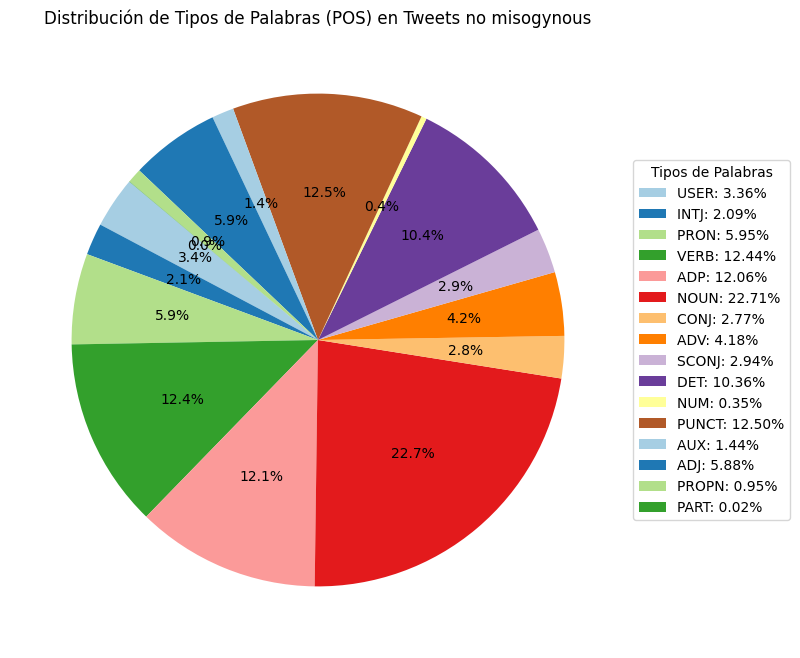

In [97]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(overall_pos_percentages_not_misogynous.values(),  startangle=140, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
ax.set_title("Distribución de Tipos de Palabras (POS) en Tweets no misogynous")
legend_labels = [f"{pos_type}: {percentage:.2f}%" for pos_type, percentage in overall_pos_percentages_not_misogynous.items()]
ax.legend(wedges, legend_labels, title="Tipos de Palabras", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


-----------------------------------------------

### Comparación entre tweets misogynous y no misogynous

-----------------------------------------------


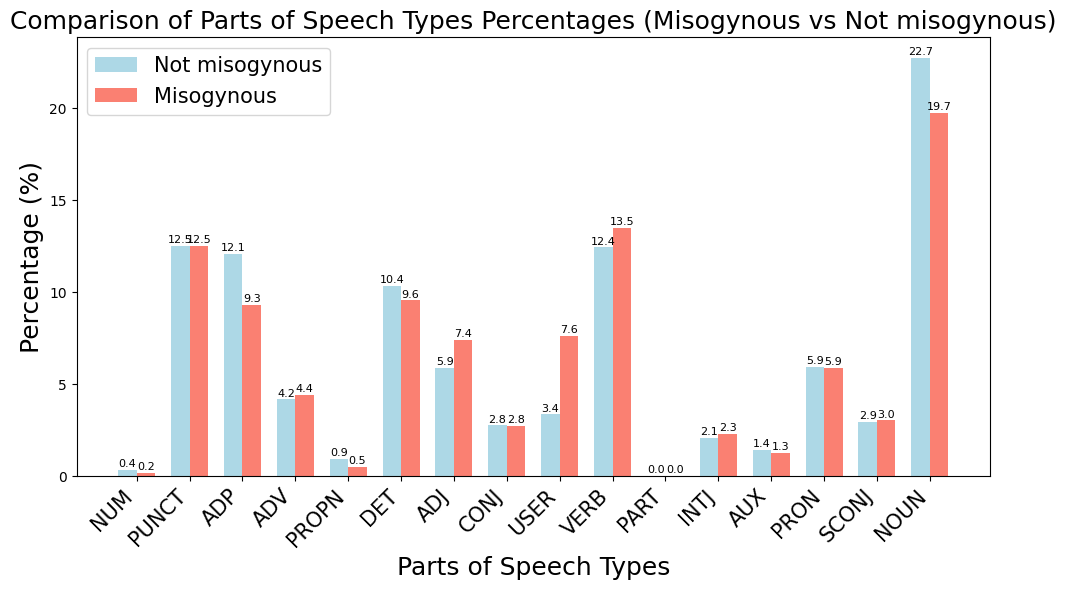

In [101]:

all_pos_tags = list(set(overall_pos_percentages_not_misogynous.keys()).union(set(overall_pos_percentages_misogynous.keys())))

not_misogynous_percentages = [overall_pos_percentages_not_misogynous.get(tag, 0) for tag in all_pos_tags]
misogynous_percentages = [overall_pos_percentages_misogynous.get(tag, 0) for tag in all_pos_tags]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(all_pos_tags))

bar1 = ax.bar(index - bar_width/2, not_misogynous_percentages, bar_width, label='Not misogynous', color='lightblue')
bar2 = ax.bar(index + bar_width/2, misogynous_percentages, bar_width, label='Misogynous', color='salmon')

for i, v in enumerate(not_misogynous_percentages):
  ax.text(index[i] - bar_width/2, v + 0.15, f'{v:.1f}', ha='center', fontsize=8, color='black')
for i, v in enumerate(misogynous_percentages):
  ax.text(index[i] + bar_width/2, v + 0.15, f'{v:.1f}', ha='center', fontsize=8, color='black')

ax.set_xlabel('Parts of Speech Types', fontsize=18)
ax.set_ylabel('Percentage (%)', fontsize=18)
ax.set_title('Comparison of Parts of Speech Types Percentages (Misogynous vs Not misogynous)', fontsize=18)
ax.set_xticks(index)
ax.set_xticklabels(all_pos_tags, rotation=45, ha='right', fontsize=15)
ax.legend(fontsize=15)

plt.tight_layout()
plt.show()